# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/14rep_50noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/15rep_50noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/16rep_50noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/14rep_50noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/15rep_50noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/16rep_50noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 2
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.323270        0.200792  0.050435  0.298915  0.017996   
       0.5    0.308858        0.190139  0.058081  0.227367  0.098483   
       1.0    0.299089        0.183833  0.079857  0.195310  0.130878   
       1.5    0.300625        0.160594  0.092135  0.158053  0.149287   
       2.0    0.321597        0.145224  0.087918  0.153270  0.178158   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.201447  0.009249  0.040422  0.048604  0.000000  
       0.5   0.206774  0.009602  0.040796  0.048681  0.001351  
       1.0   0.193792  0.007248  0.038536  0.049459  0.003707  
       1.5   0.208425  0.005090  0.031834  0.047657  0.005989  
       2.0   0.215070  0.004451  0.036132  0.047973  0.008189

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.295315        0.203393  0.049610  0.292473  0.020236   
       0.5    0.308635        0.193374  0.063498  0.224816  0.096572   
       1.0    0.316315        0.167790  0.076483  0.173016  0.136922   
       1.5    0.293168        0.150126  0.080139  0.151612  0.154617   
       2.0    0.336588        0.140768  0.093232  0.155929  0.162030   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.182364  0.009452  0.037824  0.049237  0.000000  
       0.5   0.206564  0.009152  0.042411  0.050945  0.001493  
       1.0   0.184857  0.006527  0.039555  0.053101  0.003947  
       1.5   0.204852  0.005174  0.034135  0.046941  0.006795  
       2.0   0.234007  0.003985  0.033247  0.046931  0.009454

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.301919        0.184715  0.048514  0.300995  0.018765   
       0.5    0.299963        0.194686  0.058806  0.209113  0.097677   
       1.0    0.314211        0.175666  0.077071  0.198237  0.139392   
       1.5    0.299727        0.142107  0.091906  0.174584  0.157836   
       2.0    0.316302        0.141924  0.082011  0.165989  0.168674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.193786  0.009556  0.040998  0.048033  0.000000  
       0.5   0.219451  0.009102  0.036419  0.046605  0.001683  
       1.0   0.210507  0.007004  0.035882  0.049751  0.003645  
       1.5   0.215837  0.005234  0.033106  0.045991  0.005947  
       2.0   0.235387  0.004494  0.032592  0.048974  0.008666

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.306835        0.196300  0.049520  0.297461  0.018999   
         0.5    0.294176        0.191253  0.066647  0.219071  0.098908   
         1.0    0.281081        0.173394  0.091657  0.189419  0.137529   
         1.5    0.253518        0.147751  0.095273  0.174440  0.158912   
         2.0    0.259032        0.138154  0.080518  0.185153  0.184340   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.192532  0.009419  0.039748  0.048625  0.000000  
         0.5   0.210918  0.009308  0.039874  0.049246  0.000997  
         1.0   0.196308  0.007052  0.037956  0.052079  0.002507  
         1.5   0.209571  0.005455  0.032896  0.048936  0.004192  
         2.0   0.228648  0.004703  0.033707  0.051064  0.005944

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   6.082450e+01  3.899512e+01      36.613773  5.713511e+01   
         0.5   5.538406e+06  3.416540e+06  344332.669390  2.171875e+06   
         1.0   6.008267e+06  4.662727e+06  462373.586426  3.085718e+06   
         1.5   6.485439e+06  5.310017e+06  554912.379294  3.298947e+06   
         2.0   6.415486e+06  5.190249e+06  566931.143128  3.915949e+06   

                                                                        \
                        PMK           PMD          GPPS            Idi   
Strain   Time                                                            
Strain 1 0.0   2.526772e+01  5.244708e+01  5.224924e+01      18.570128   
         0.5   7.245888e+05  3.693198e+06  3.434109e+06  644015.479446   
         1.0   1.007824e+06  5.672140e+06  3.775778e+06  818224.848520   
         1.5   1.040757e+06  6.644986e+06  3.835444e+06  959319.192627   
         2.0   1.193798e+06  6.910470e+06  4.031659e+06  996547.021123   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          29.506563  
         0.5      291039.746583  
         1.0      397862.073805  
         1.5      456847.298316  
         2.0      510421.964397

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


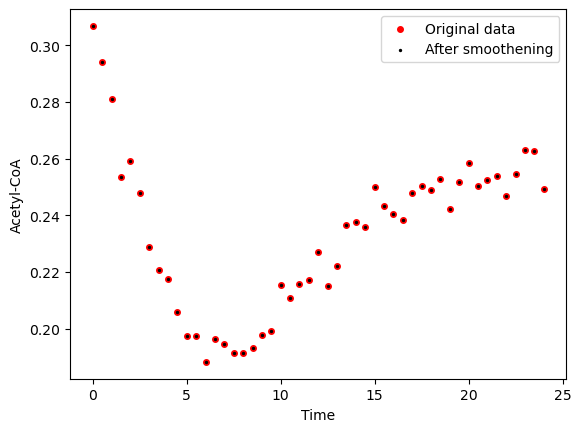

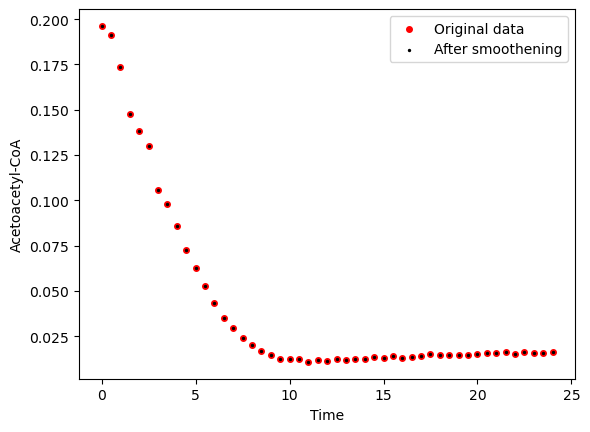

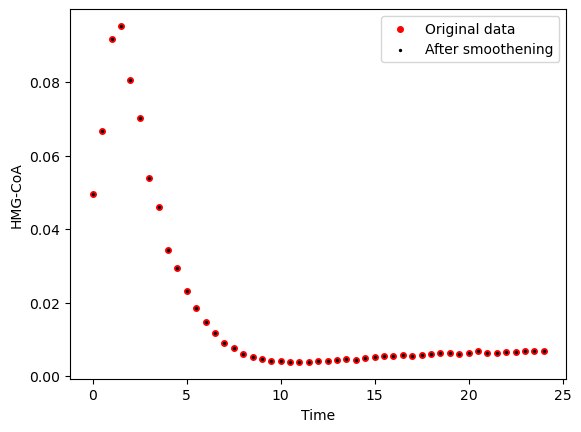

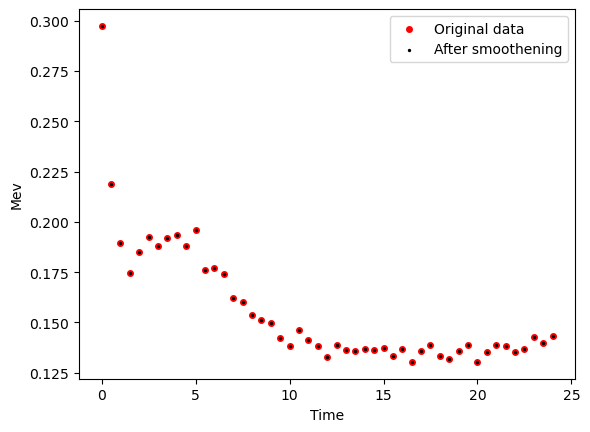

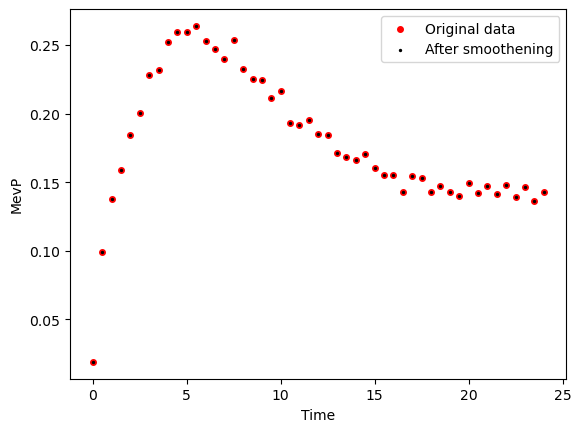

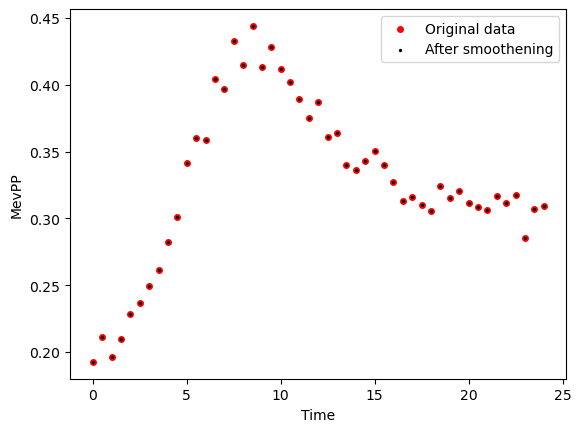

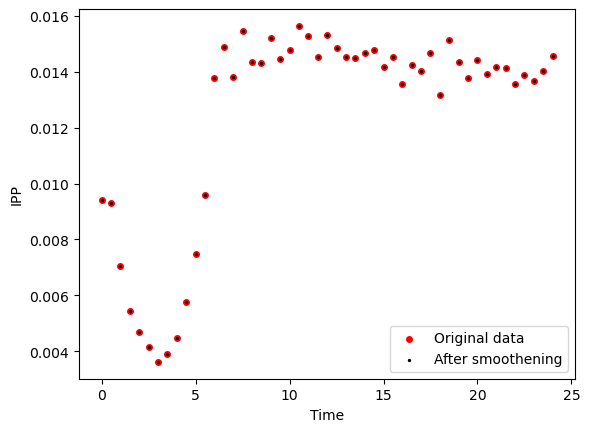

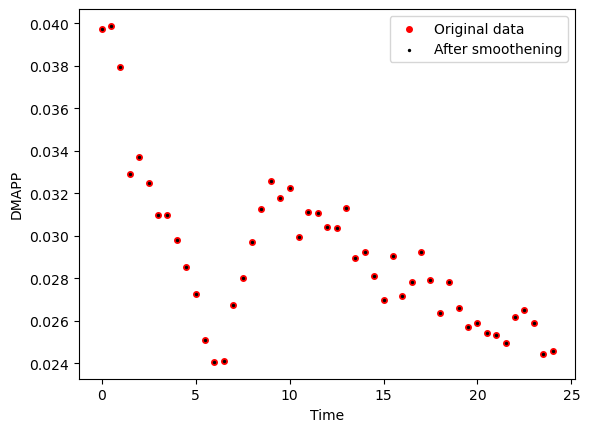

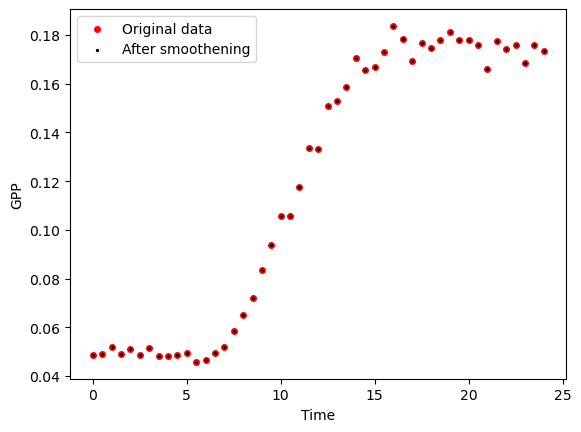

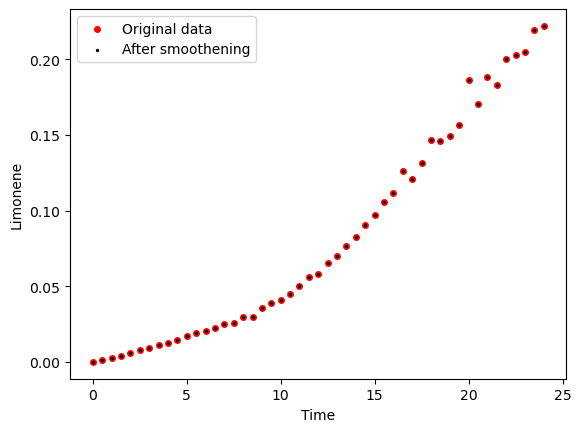

Strain Strain 2


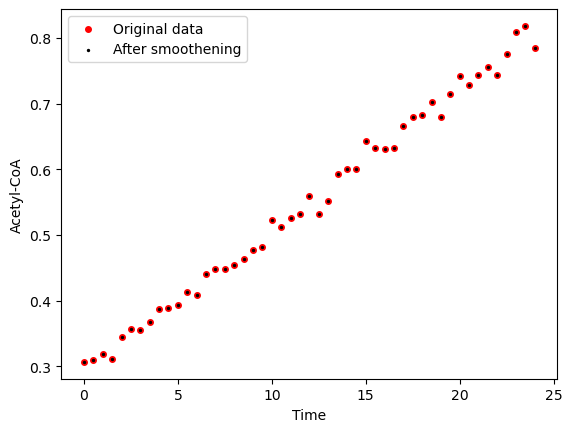

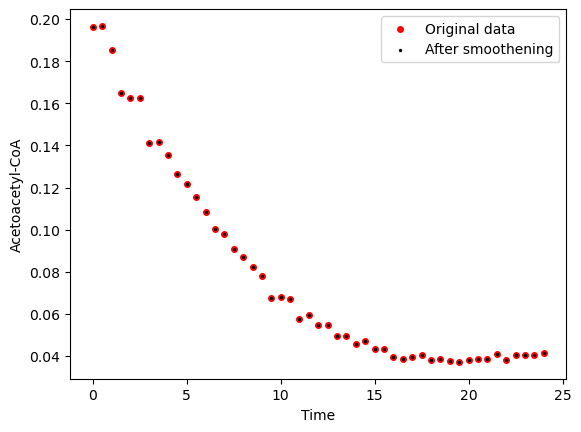

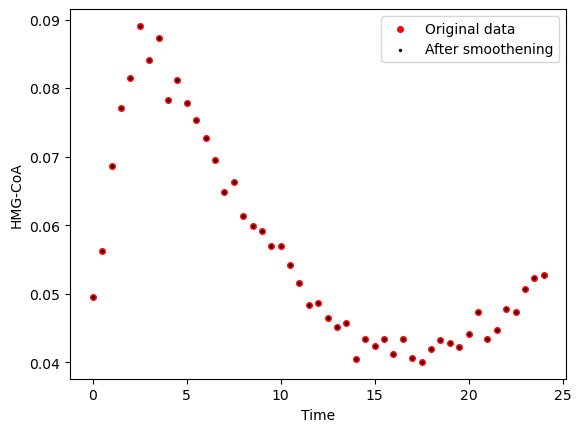

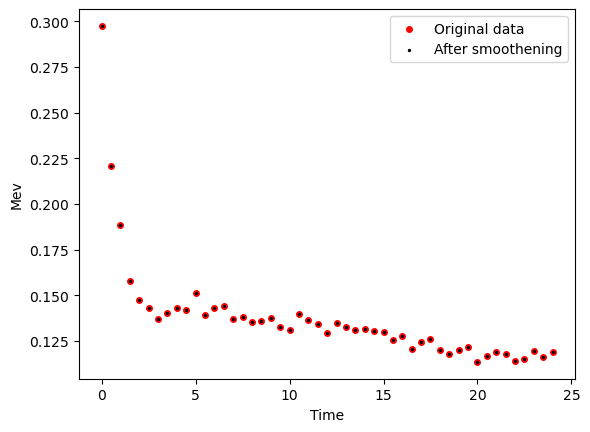

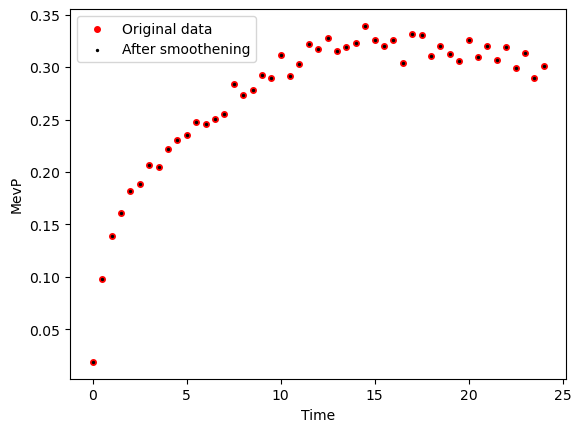

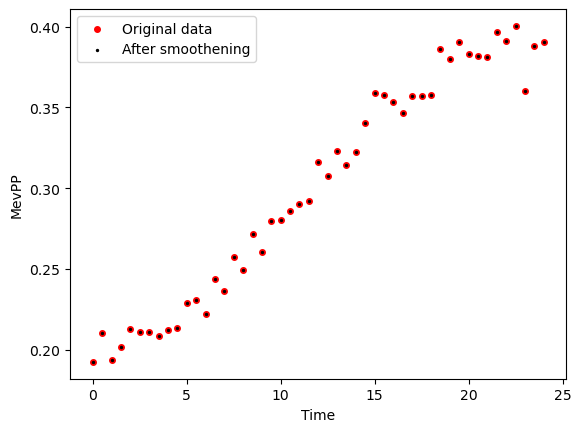

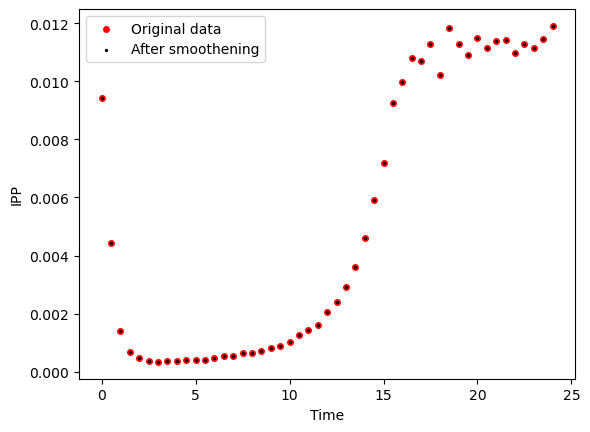

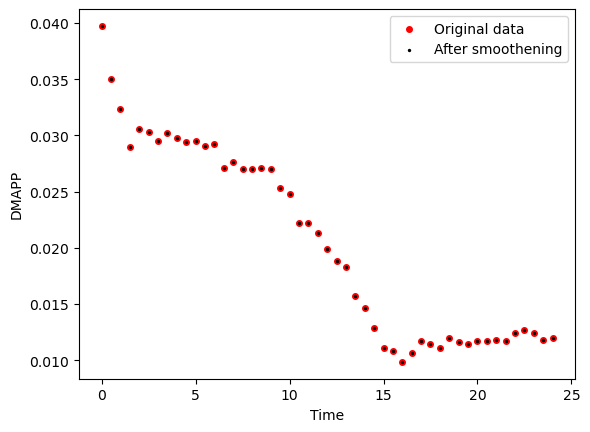

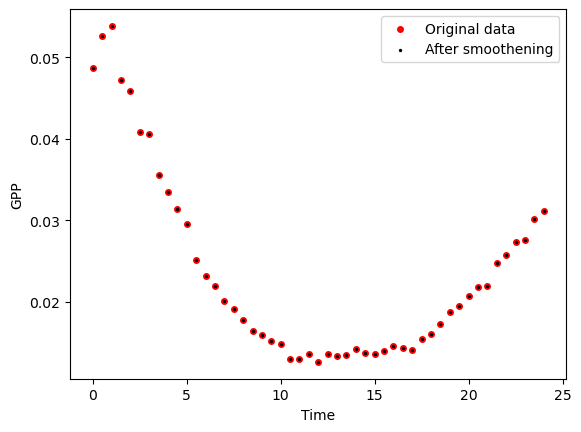

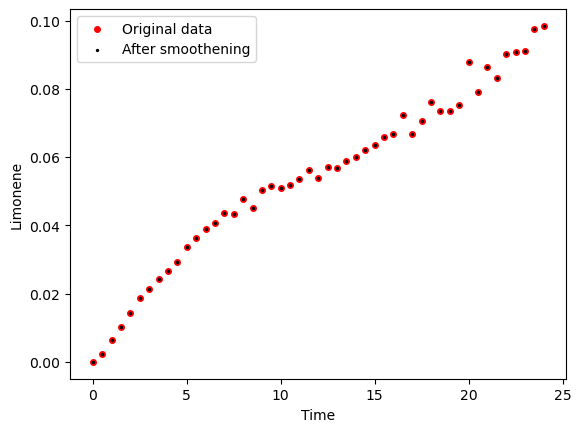

Strain Strain 3


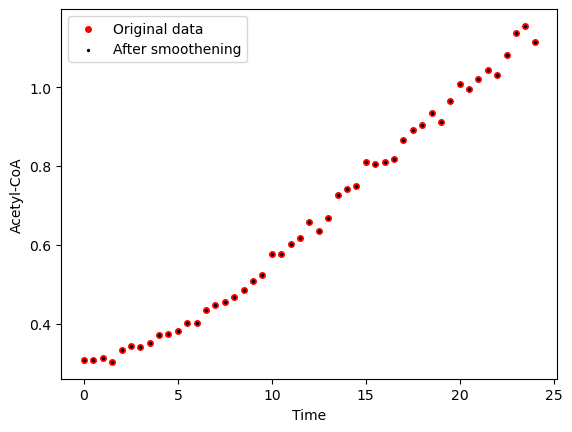

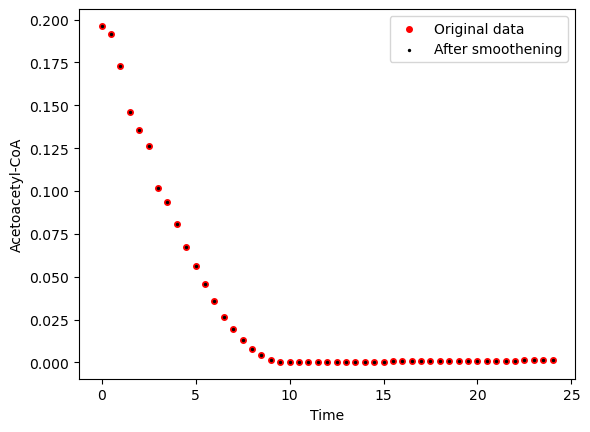

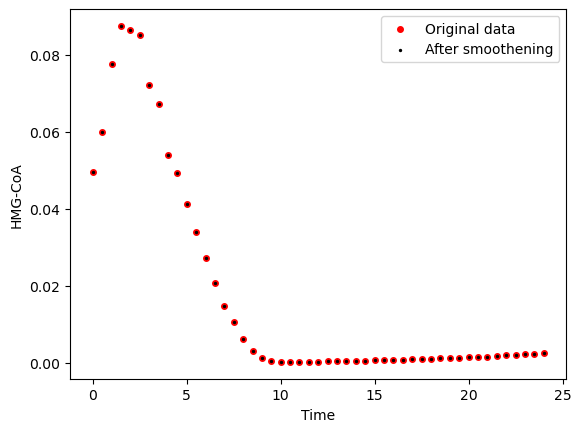

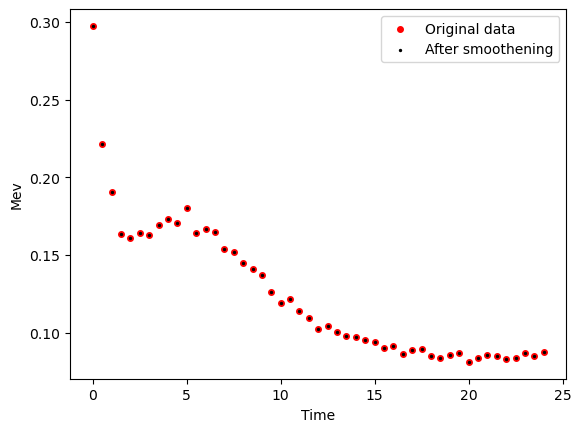

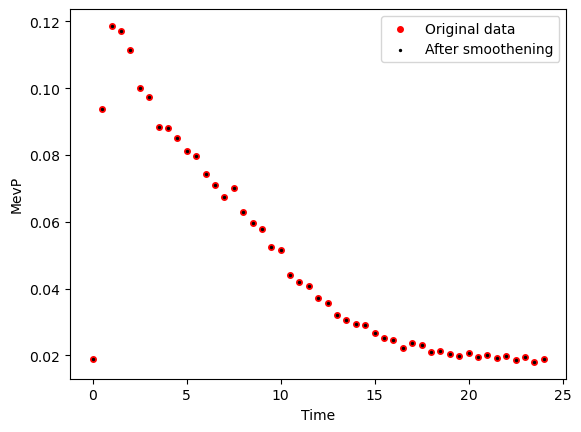

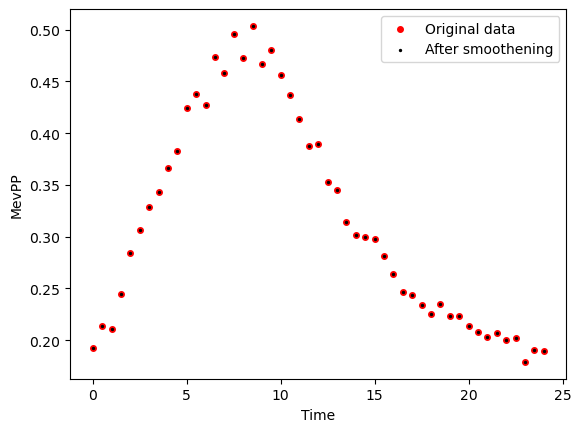

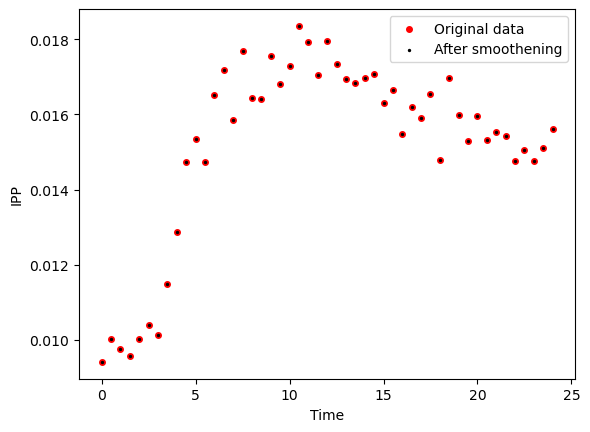

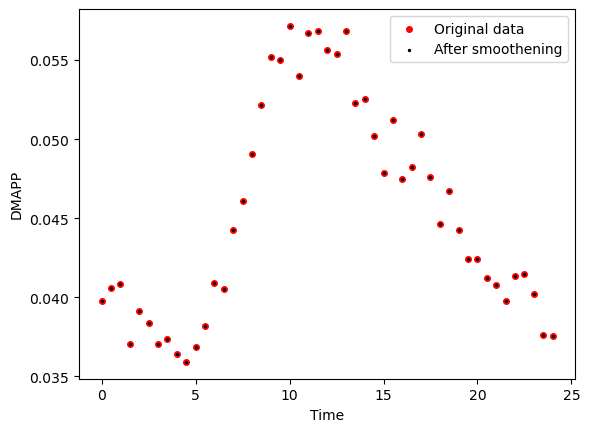

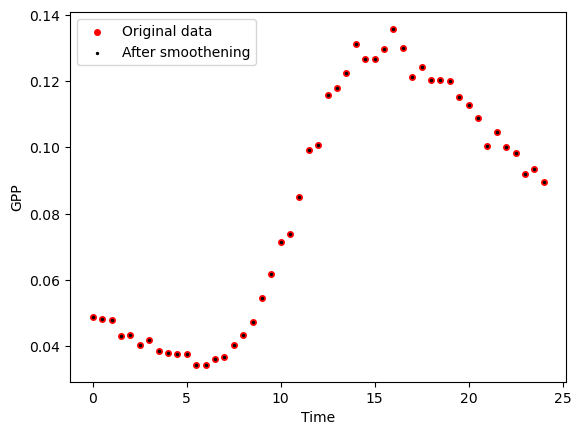

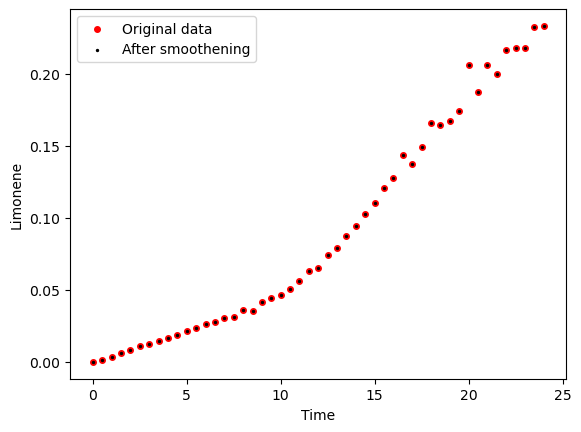

Strain WT


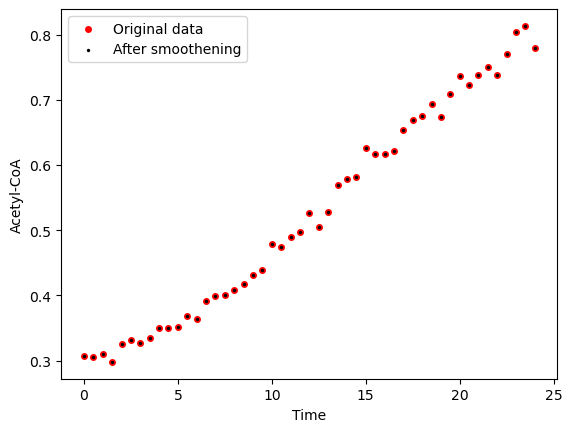

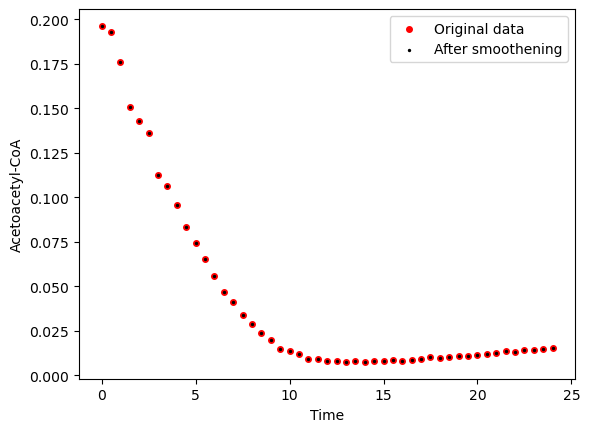

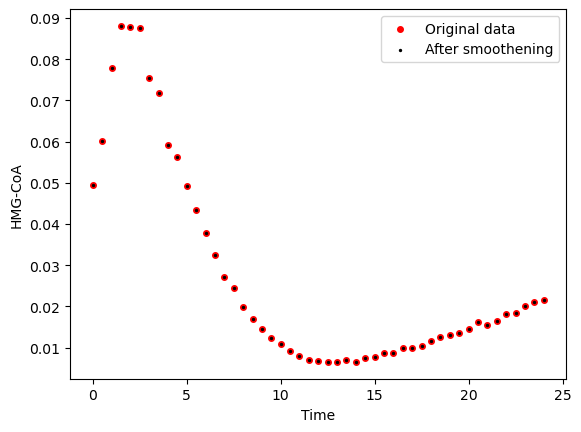

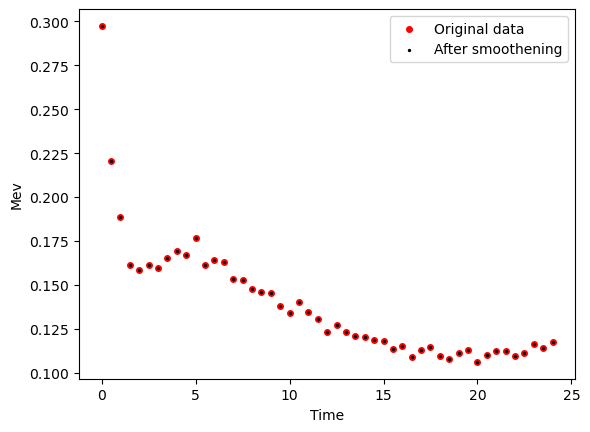

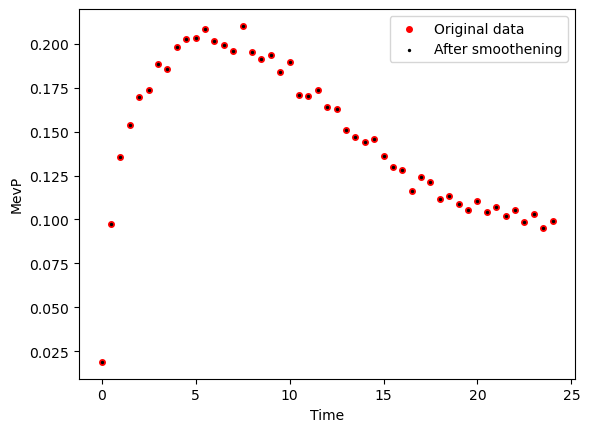

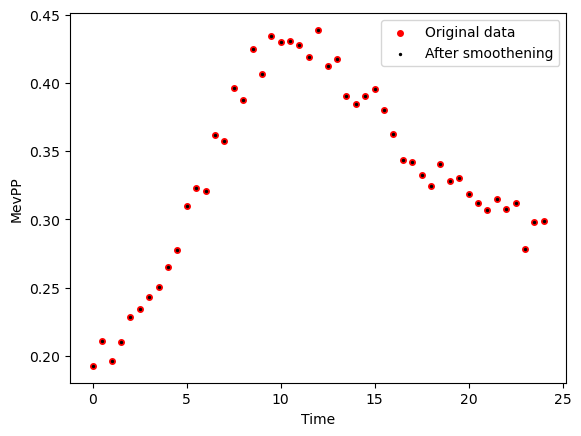

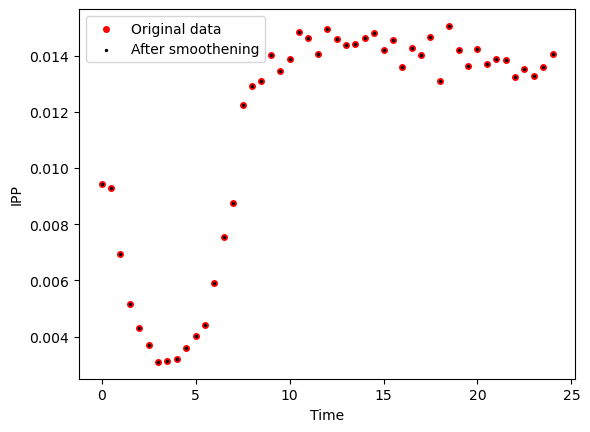

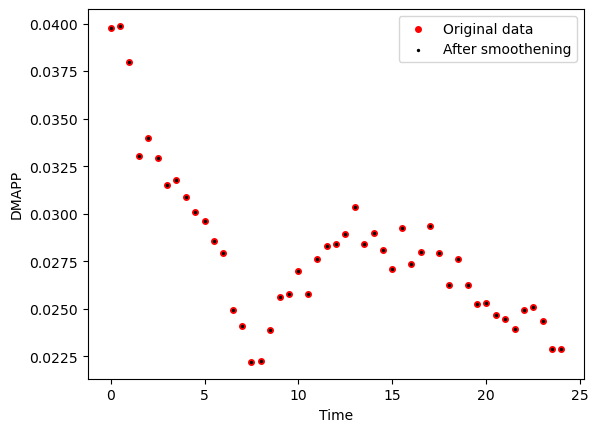

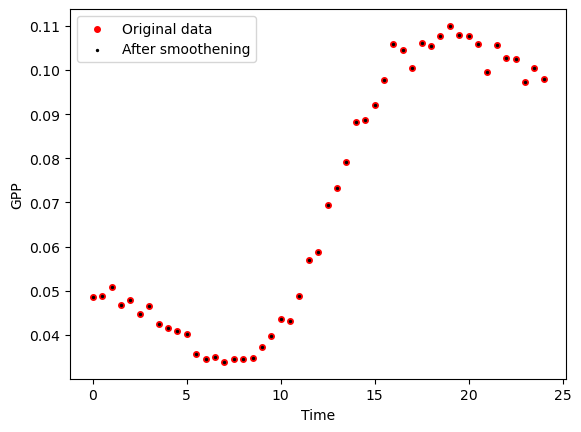

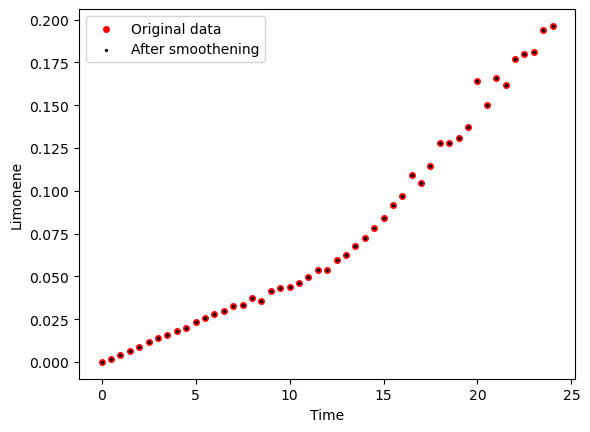

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


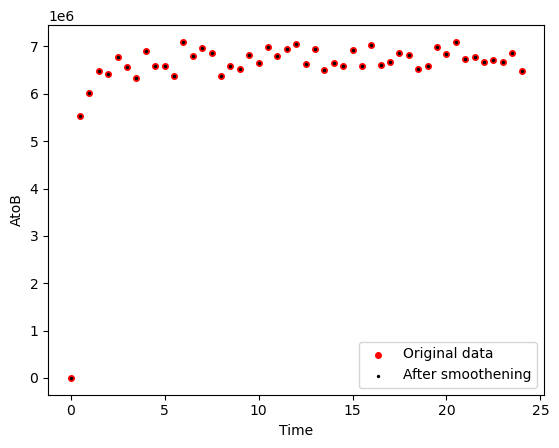

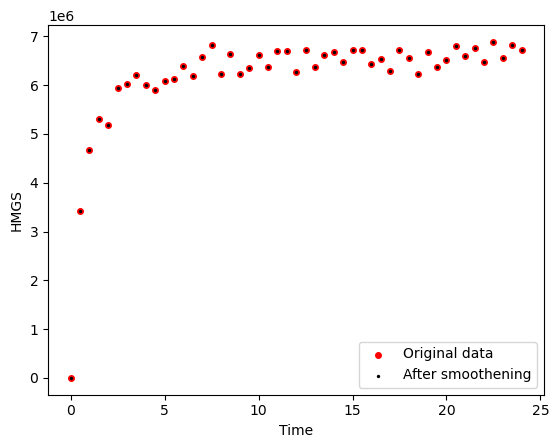

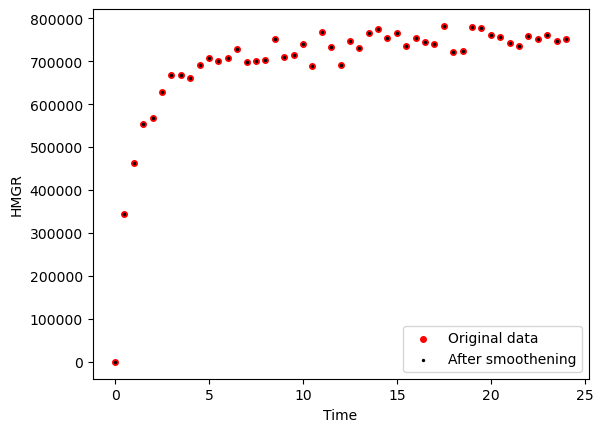

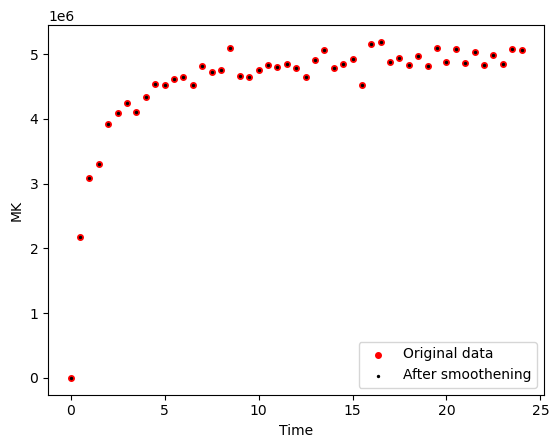

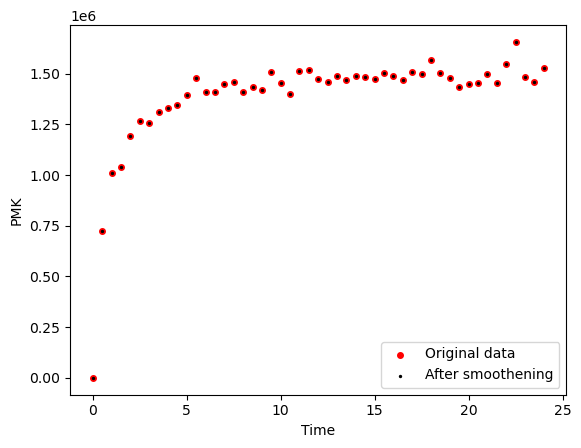

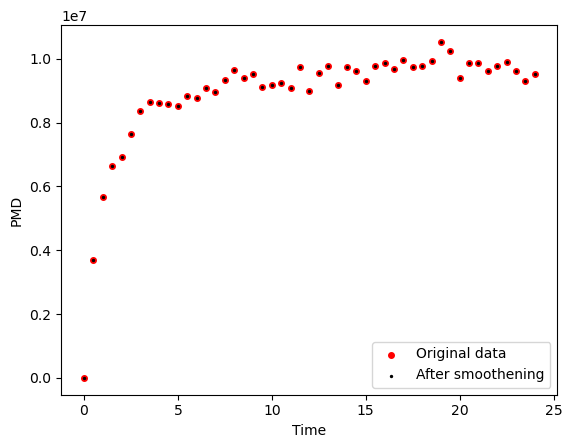

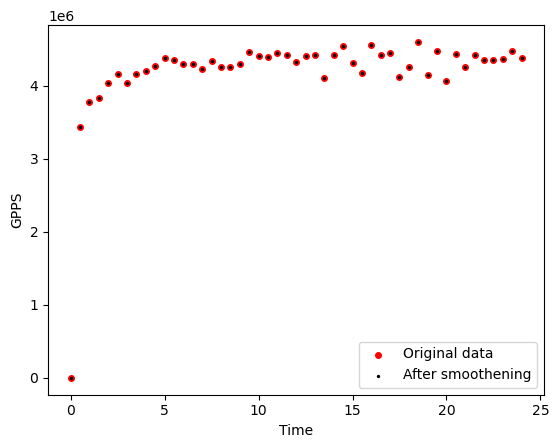

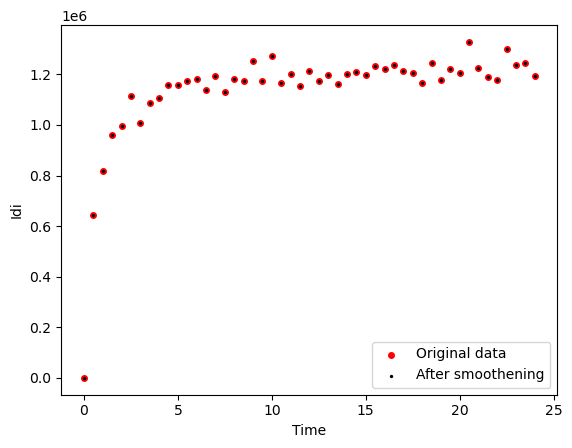

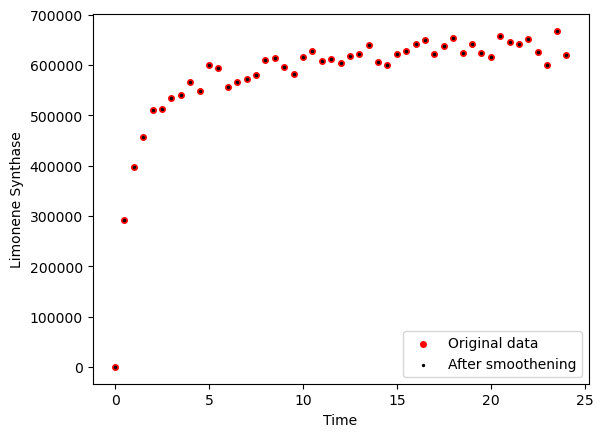

Strain Strain 2


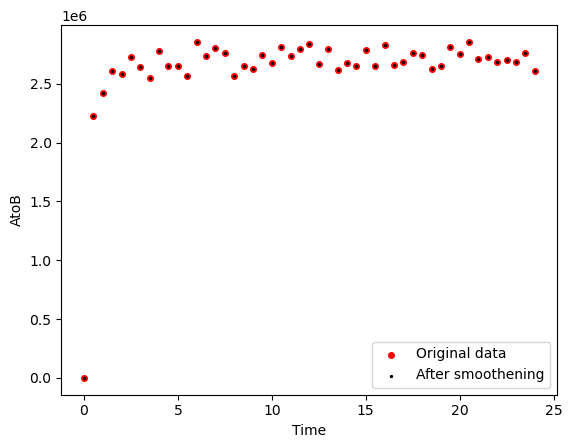

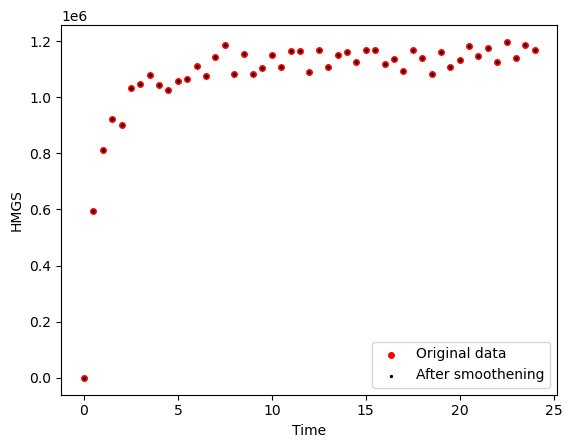

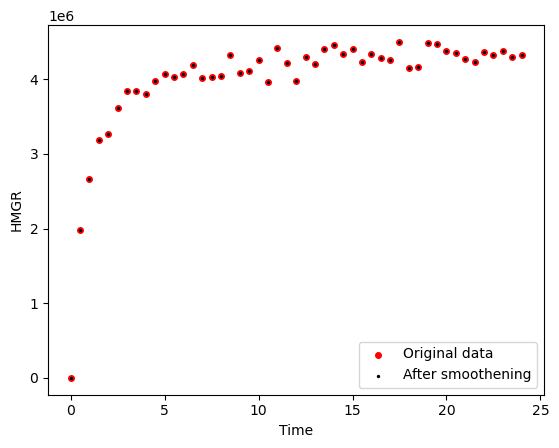

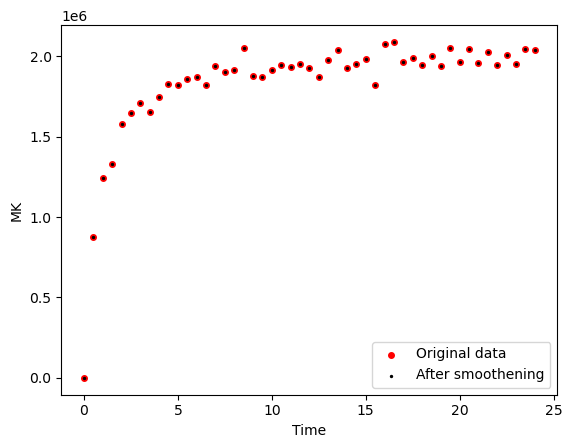

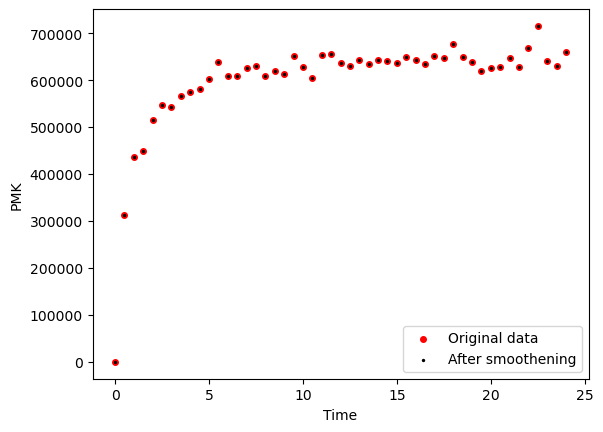

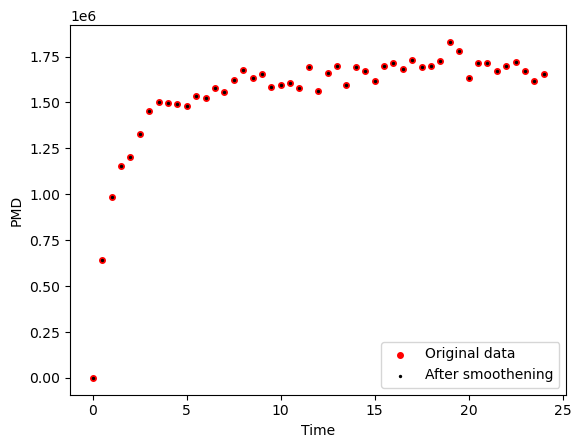

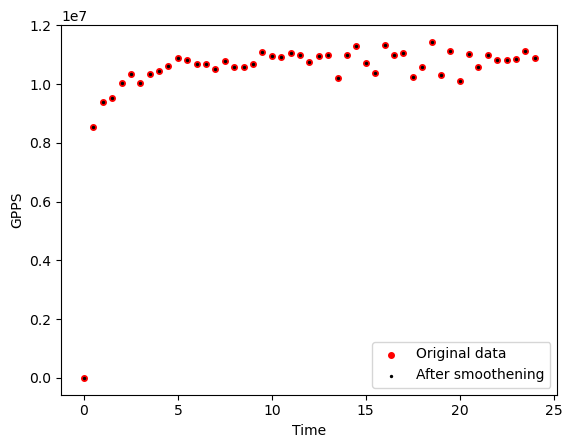

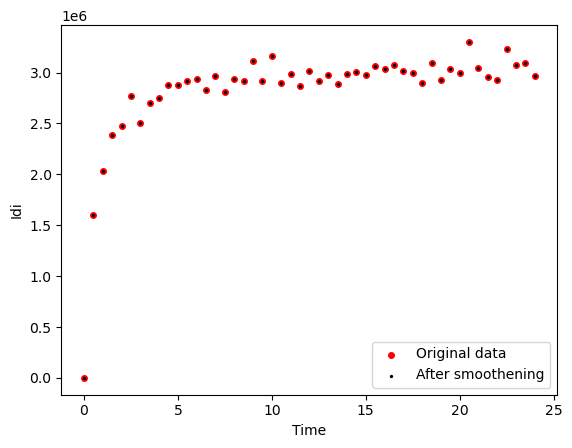

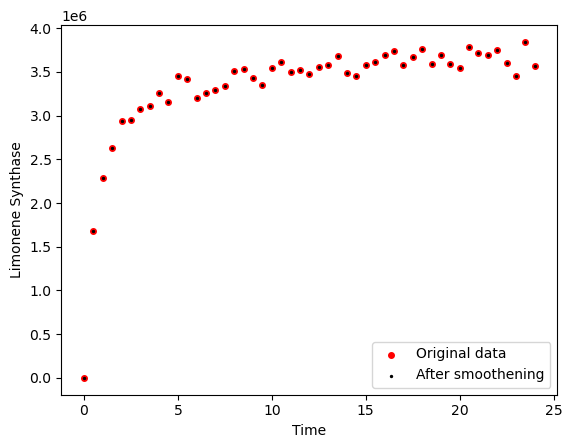

Strain Strain 3


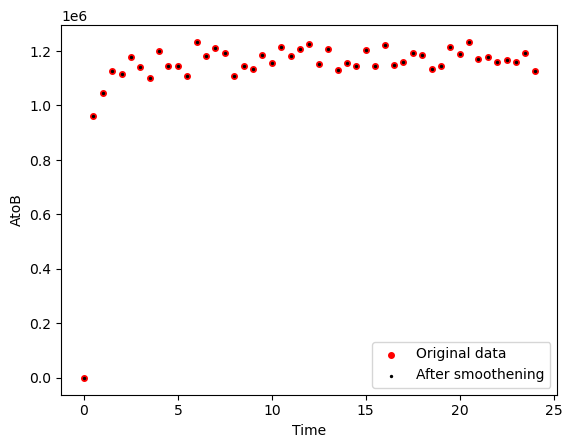

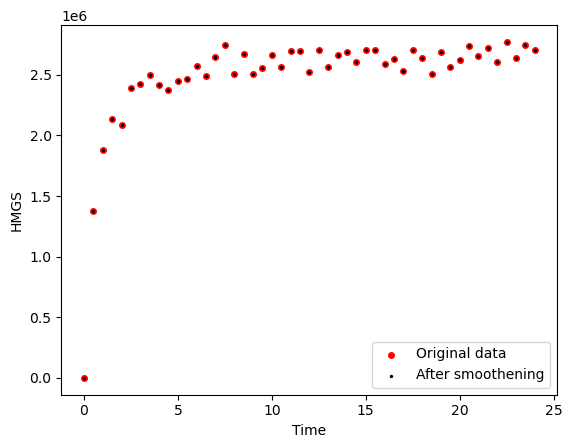

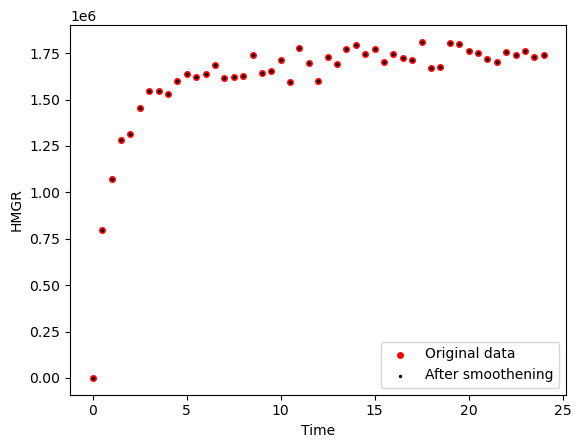

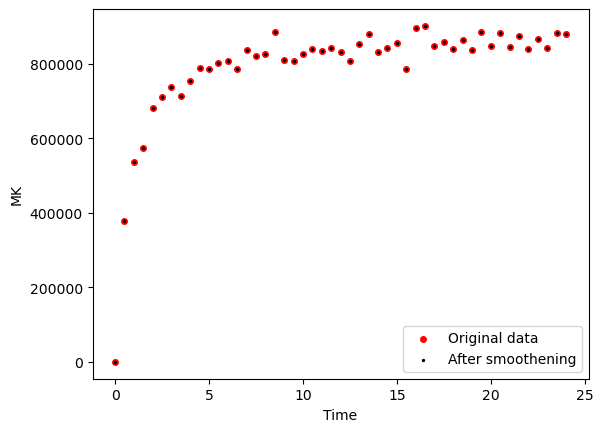

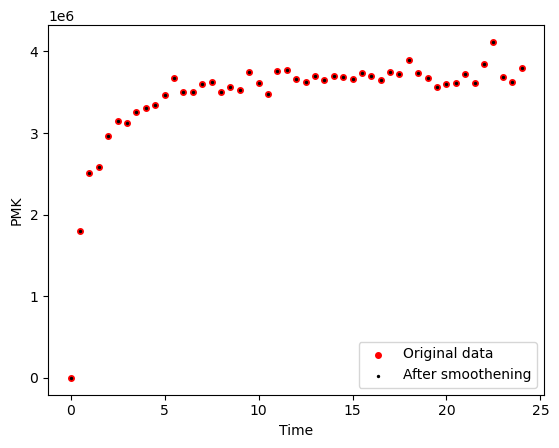

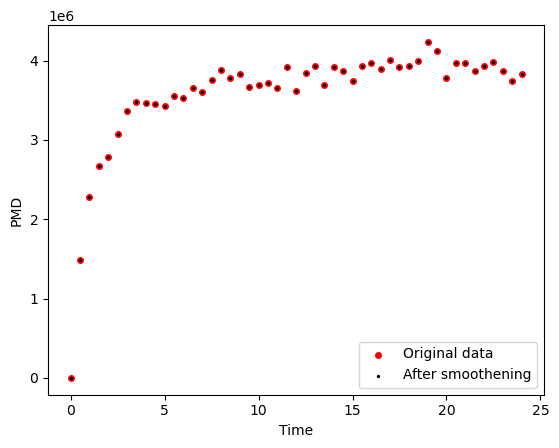

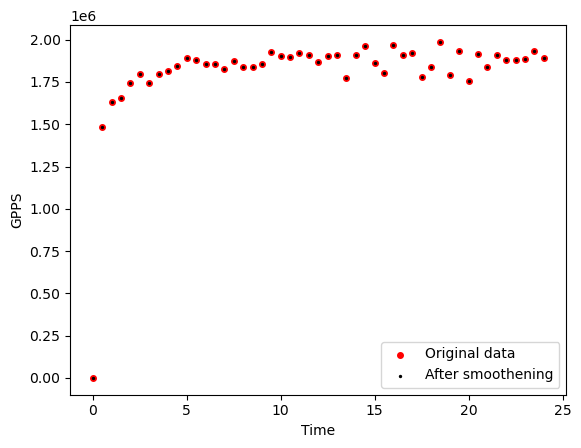

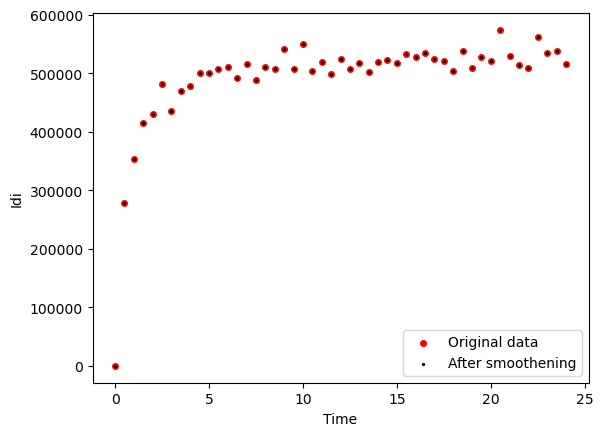

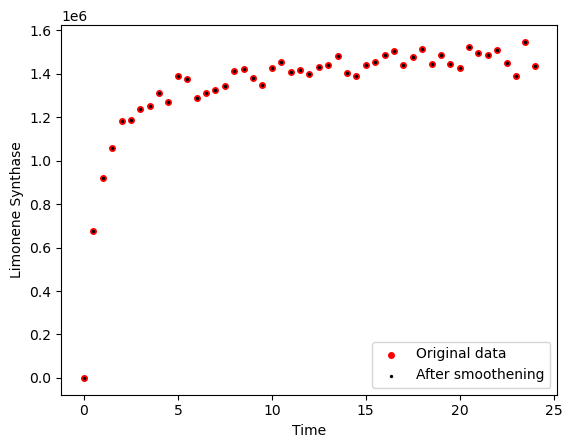

Strain WT


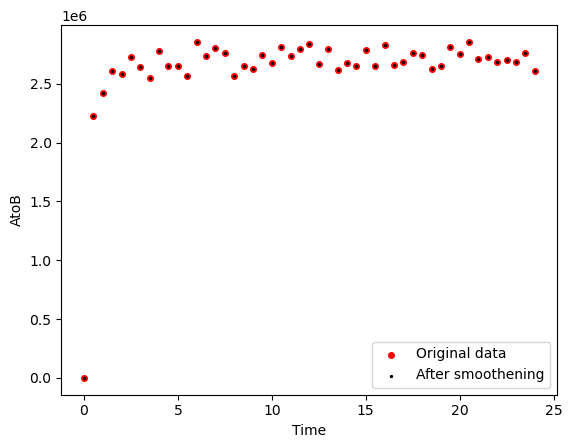

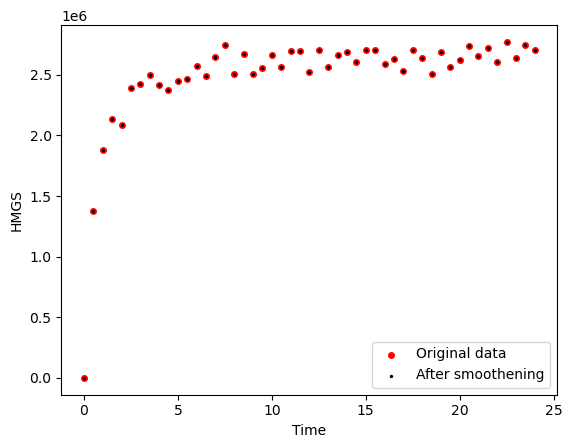

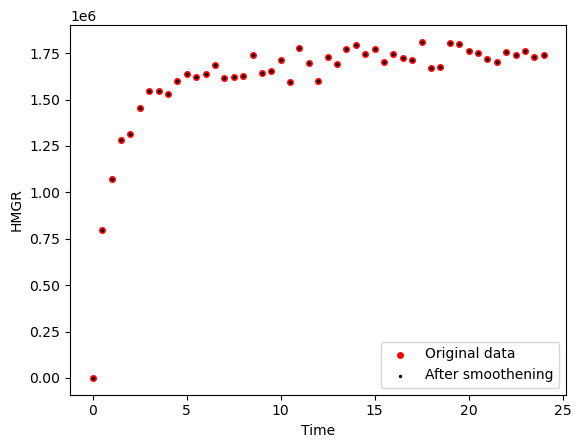

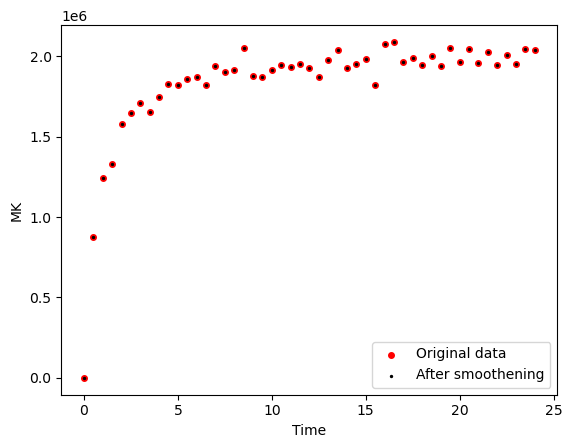

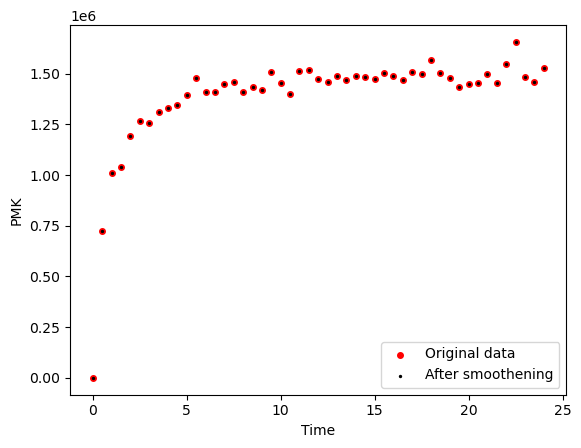

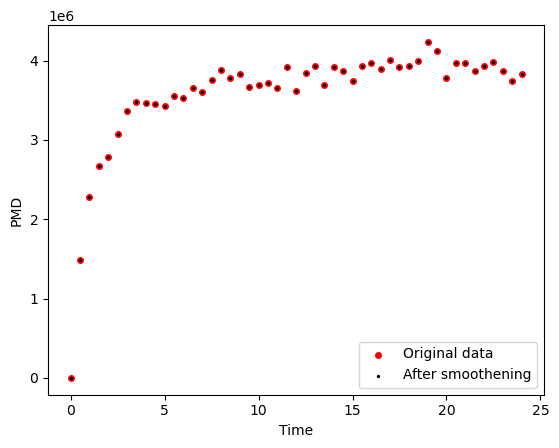

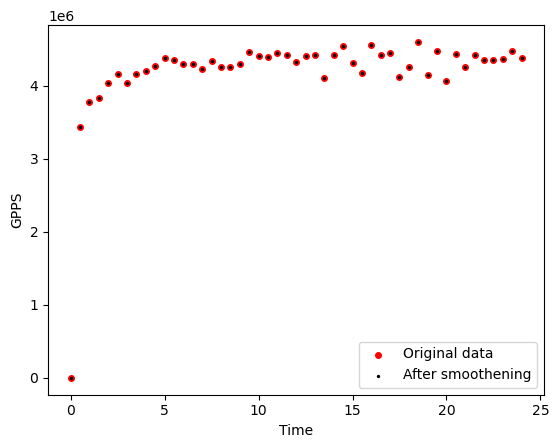

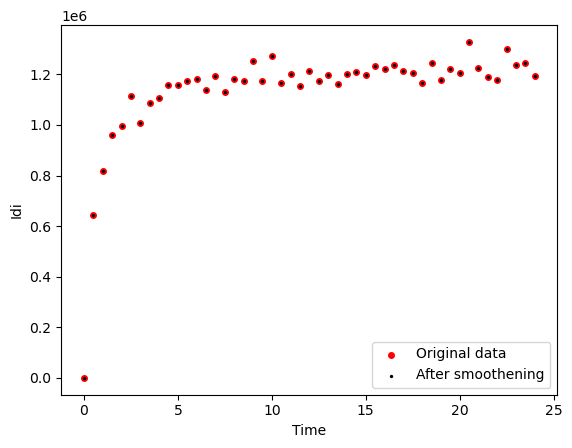

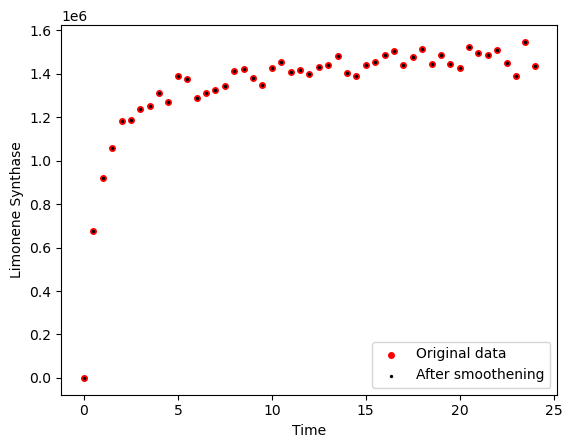

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative

df_allSmooth=estimate_state_derivative(df_allSmooth,3,2)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.306835        0.196300  0.049520  0.297461  0.018999   
         0.5    0.294176        0.191253  0.066647  0.219071  0.098908   
         1.0    0.281081        0.173394  0.091657  0.189419  0.137529   
         1.5    0.253518        0.147751  0.095273  0.174440  0.158912   
         2.0    0.259032        0.138154  0.080518  0.185153  0.184340   
...                  ...             ...       ...       ...       ...   
WT       22.0   0.738345        0.012901  0.018069  0.109817  0.105639   
         22.5   0.770211        0.014053  0.018318  0.111490  0.098735   
         23.0   0.805004        0.014205  0.020042  0.116194  0.103061   
         23.5   0.813565        0.014590  0.021115  0.113995  0.095381   
         24.0   0.780417        0.015142  0.021647  0.117237  0.099266   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.192532  0.009419  0.039748  0.048625  0.000000  ...   
         0.5   0.210918  0.009308  0.039874  0.049246  0.000997  ...   
         1.0   0.196308  0.007052  0.037956  0.052079  0.002507  ...   
         1.5   0.209571  0.005455  0.032896  0.048936  0.004192  ...   
         2.0   0.228648  0.004703  0.033707  0.051064  0.005944  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       22.0  0.307623  0.013238  0.024957  0.102780  0.177122  ...   
         22.5  0.311999  0.013522  0.025088  0.102596  0.179716  ...   
         23.0  0.278256  0.013289  0.024371  0.097335  0.181039  ...   
         23.5  0.297893  0.013601  0.022872  0.100397  0.194043  ...   
         24.0  0.298573  0.014081  0.022880  0.097876  0.196281  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.024880        0.002720  0.026372 -0.205517  0.201108   
         0.5    -0.025754       -0.022906  0.042138 -0.108042  0.118530   
         1.0    -0.040658       -0.043502  0.028626 -0.044631  0.060004   
         1.5    -0.022049       -0.035240 -0.011140 -0.004266  0.046811   
         2.0    -0.005570       -0.017861 -0.025060  0.017857  0.041468   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019262        0.000447  0.001871 -0.000877 -0.003252   
         22.5    0.066659        0.001304  0.001973  0.006378 -0.002577   
         23.0    0.043354        0.000538  0.002797  0.002505 -0.003354   
         23.5   -0.024587        0.000937  0.001605  0.001043 -0.003795   
         24.0   -0.108006        0.001271  0.000524  0.011928  0.019335   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.069767  0.001922  0.002295 -0.000970  0.001481  
         0.5   0.003776 -0.002368 -0.001792  0.003455  0.002507  
         1.0  -0.001347 -0.003853 -0.006978 -0.000309  0.003195  
         1.5   0.032340 -0.002348 -0.004249 -0.001015  0.003437  
         2.0   0.027274 -0.001302 -0.000407 -0.000303  0.003860  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.003163 -0.000312  0.001156 -0.002951  0.017687  
         22.5 -0.029366  0.000051 -0.000586 -0.005445  0.003917  
         23.0 -0.014106  0.000079 -0.002216 -0.002199  0.014327  
         23.5  0.020317  0.000792 -0.001491  0.000541  0.015242  
         24.0 -0.017596  0.001128  0.001522 -0.010626 -0.006292

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

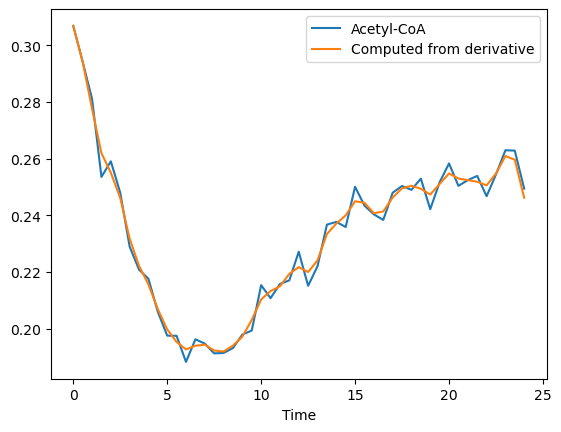

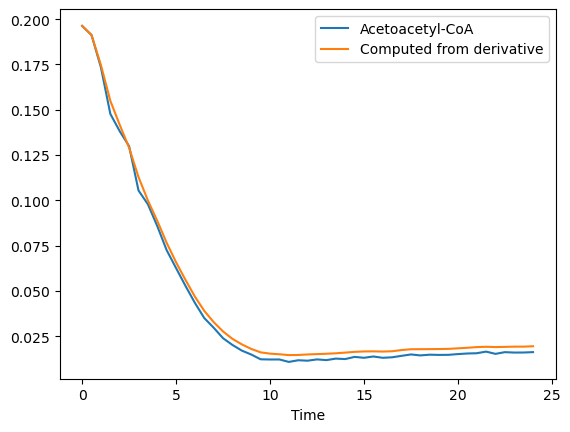

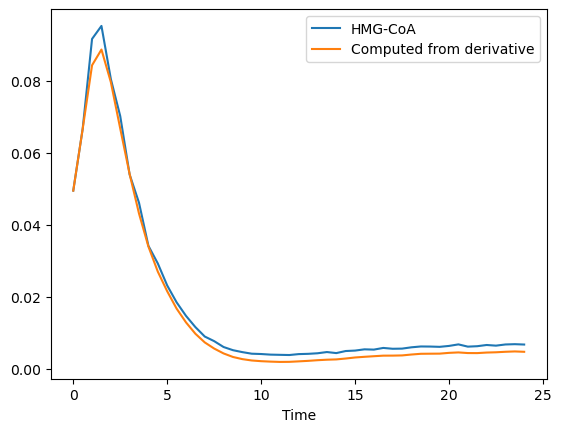

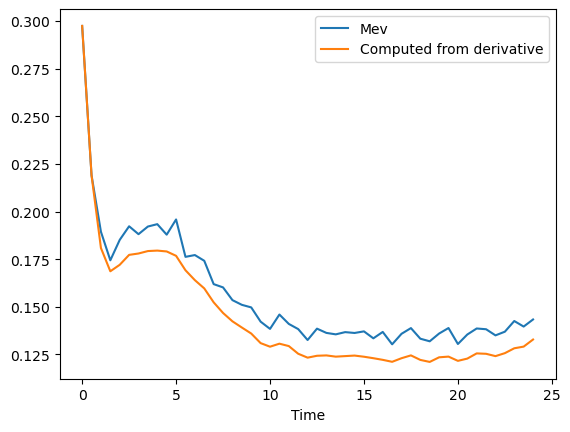

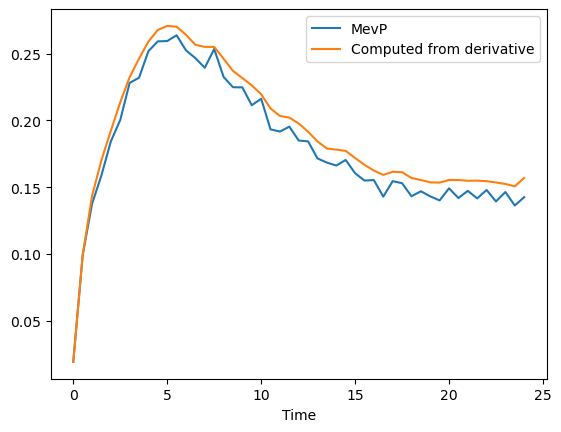

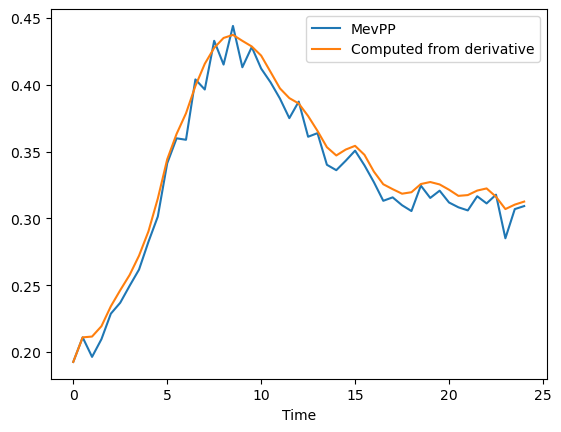

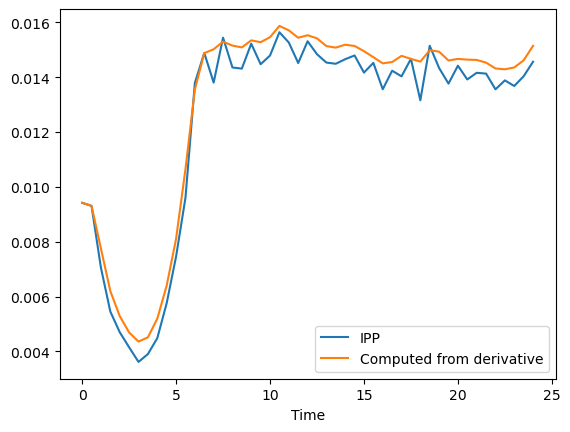

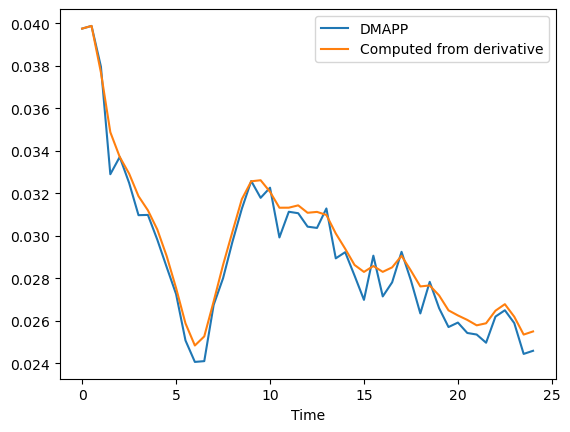

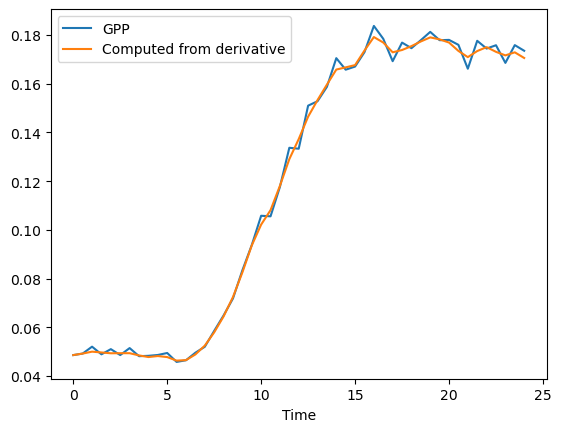

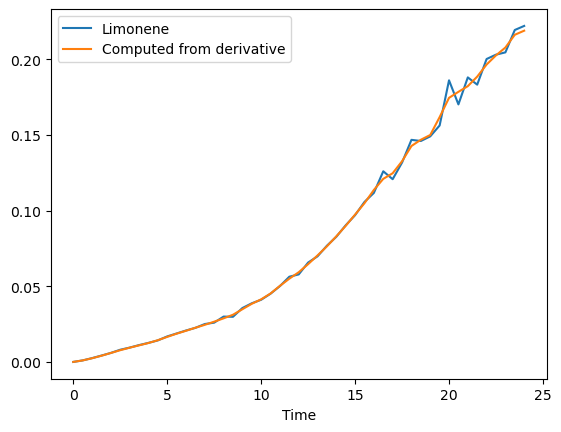

'Time profile from derivative vs. actual profile for Strain 2'

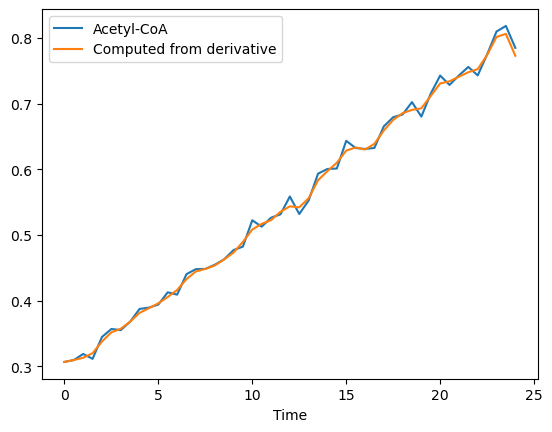

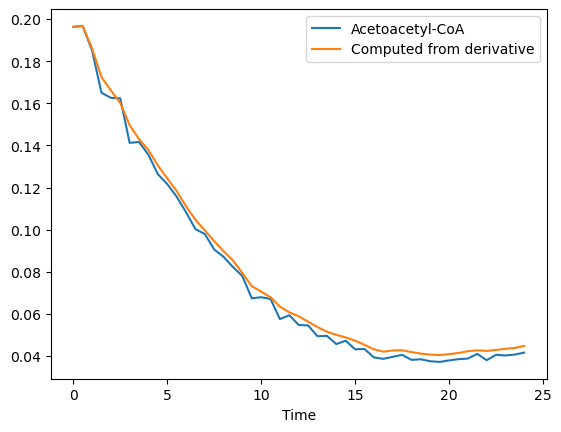

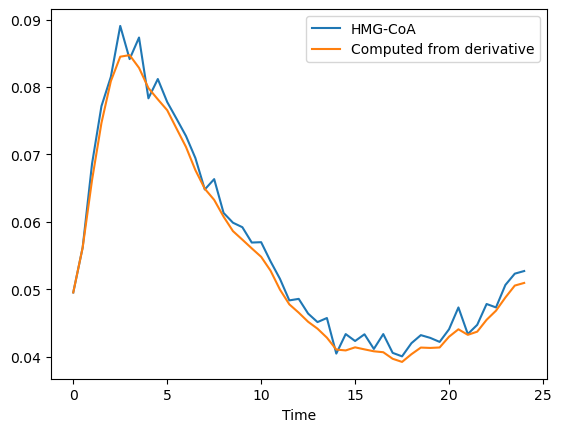

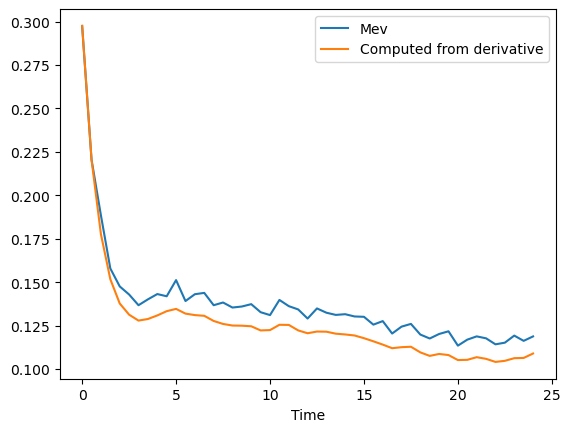

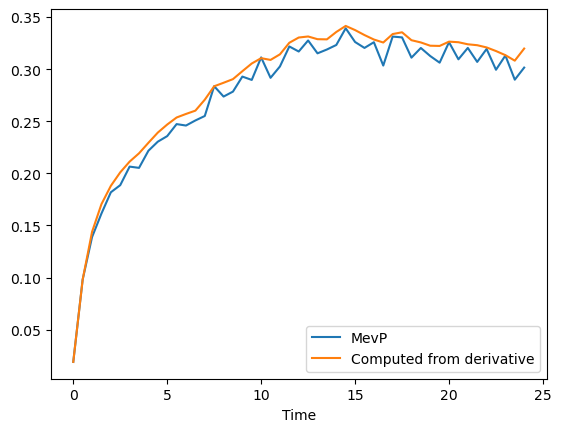

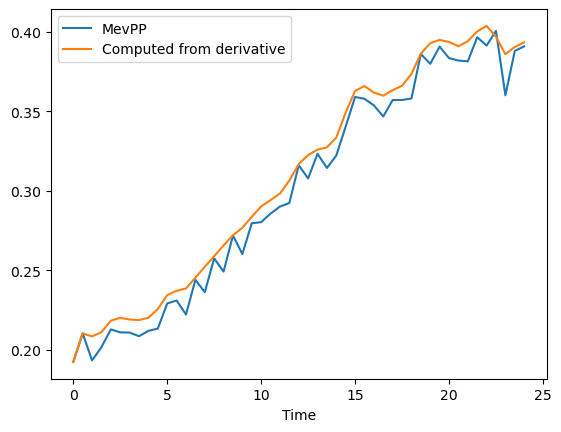

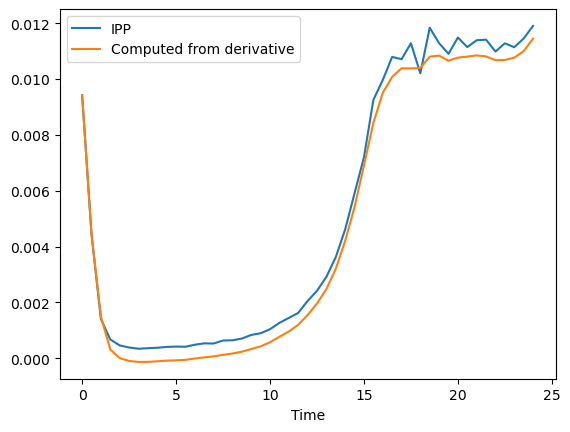

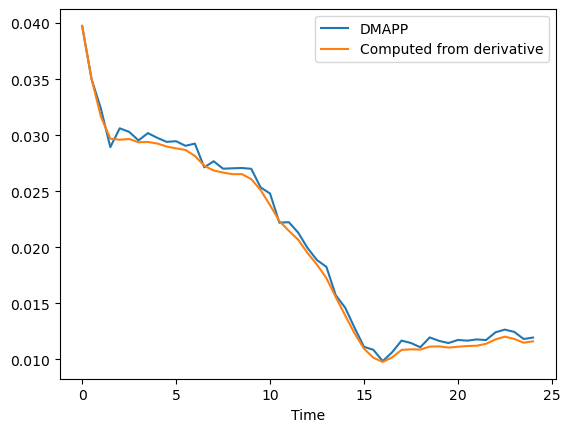

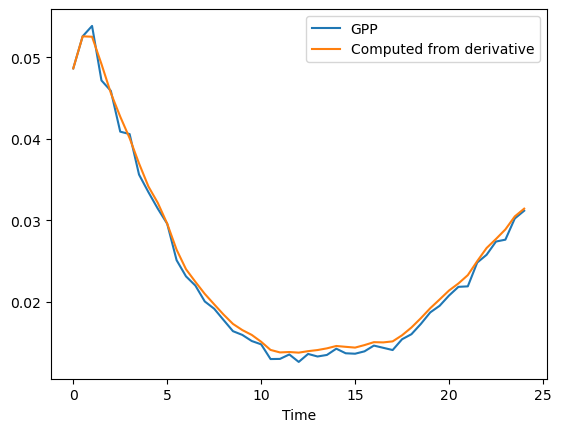

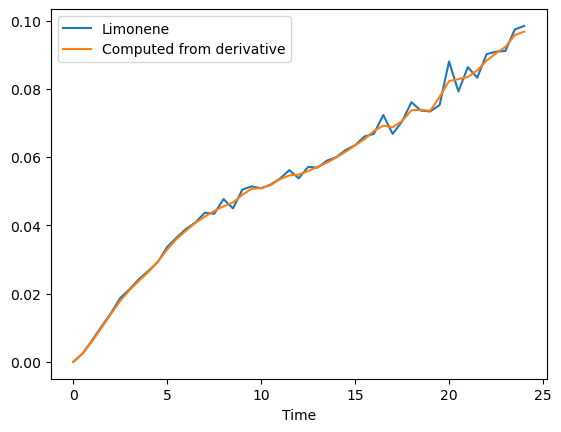

'Time profile from derivative vs. actual profile for Strain 3'

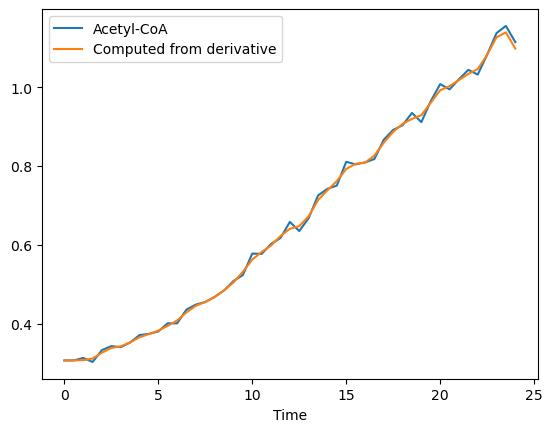

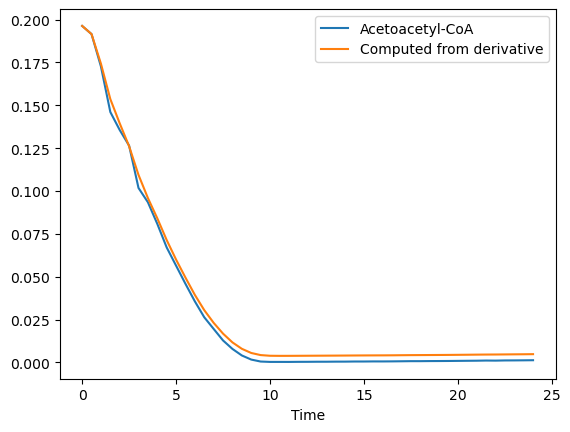

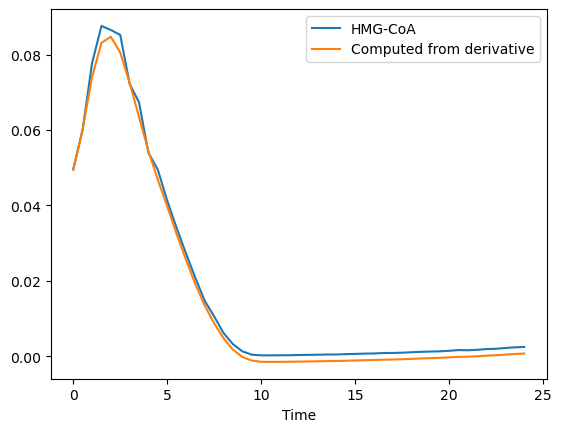

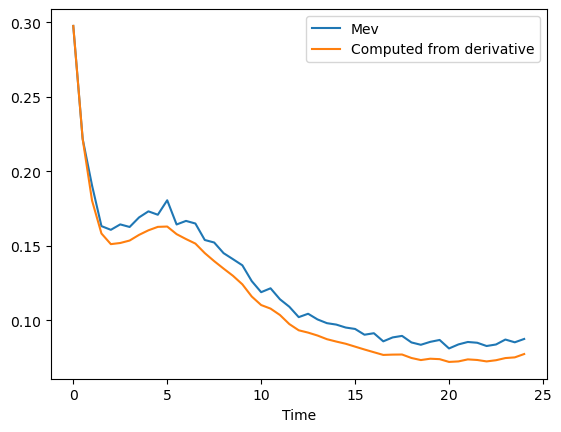

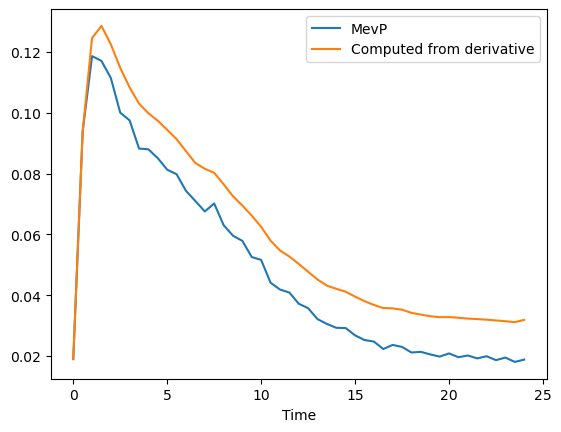

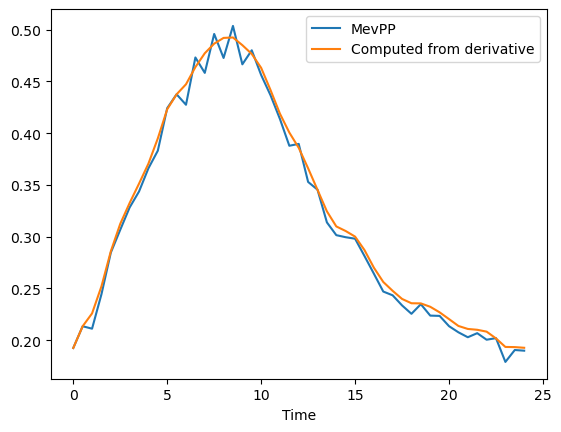

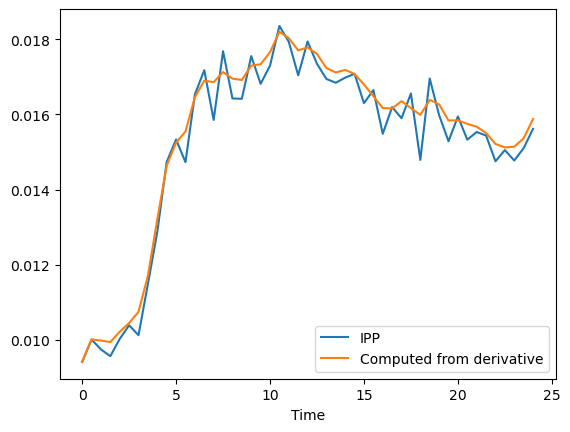

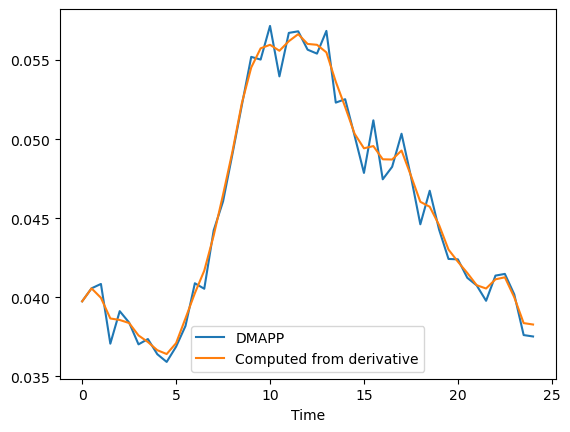

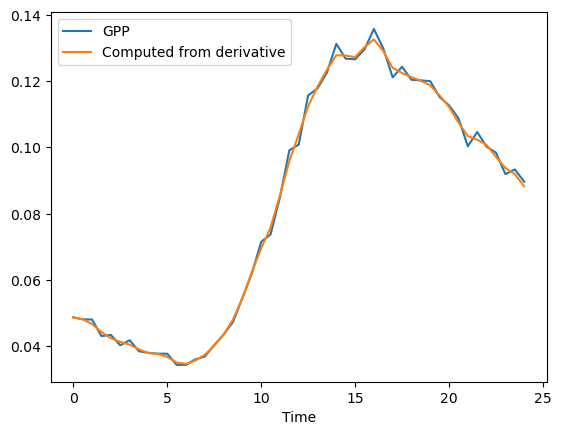

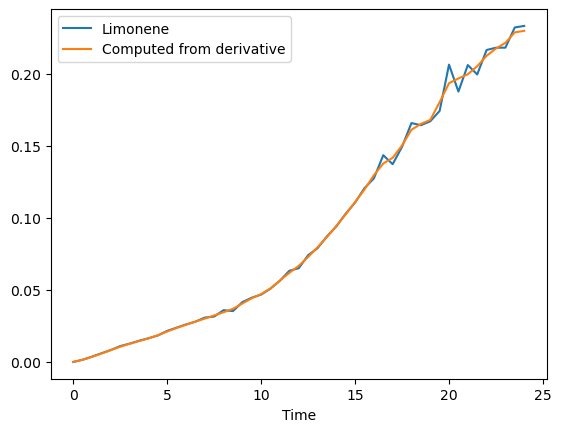

'Time profile from derivative vs. actual profile for WT'

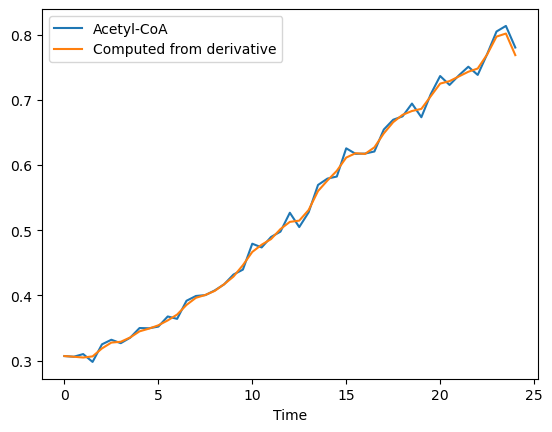

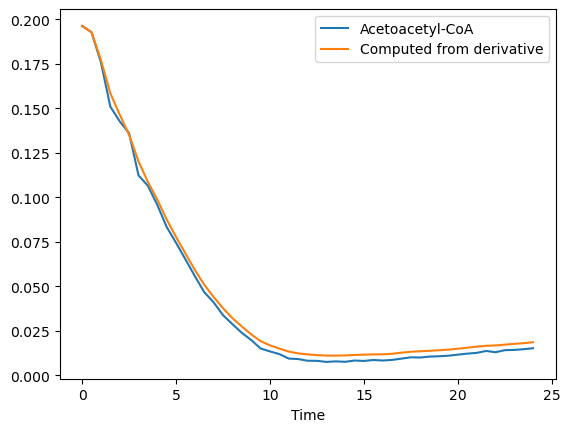

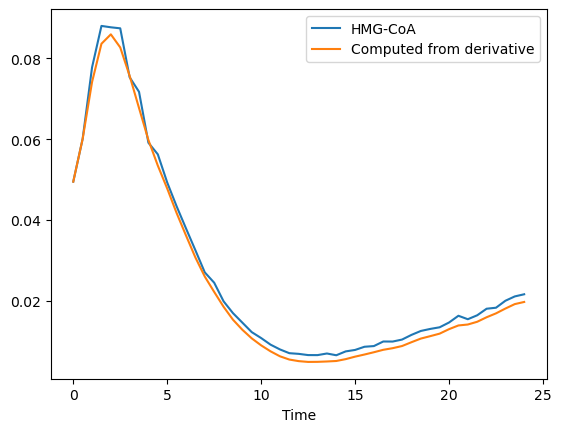

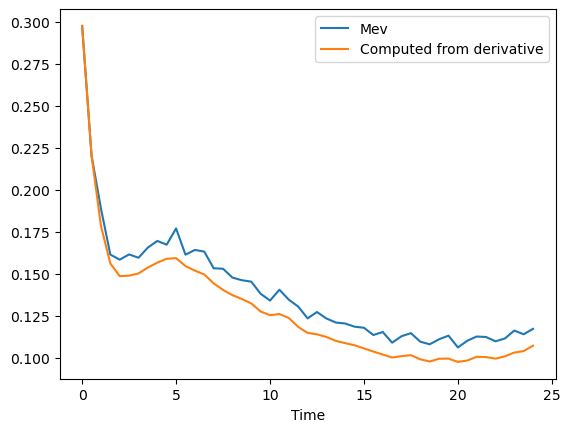

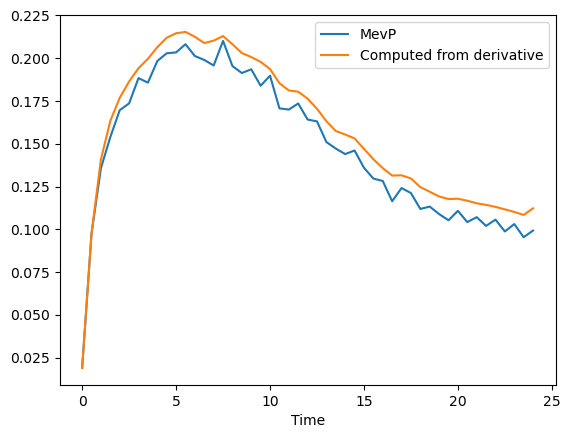

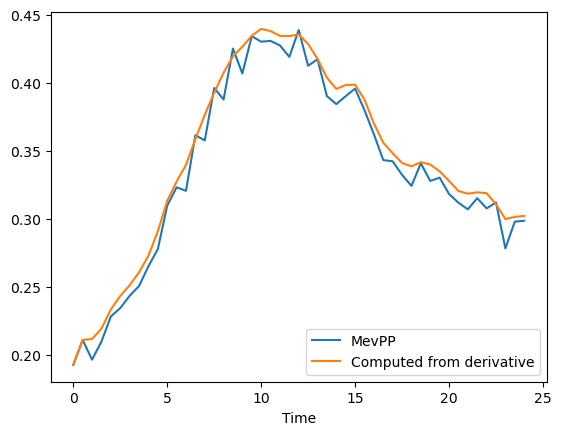

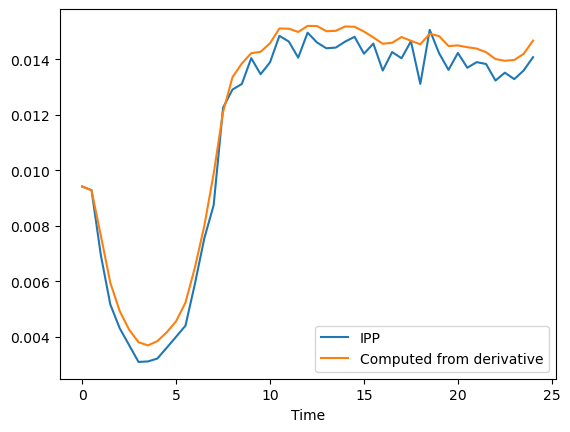

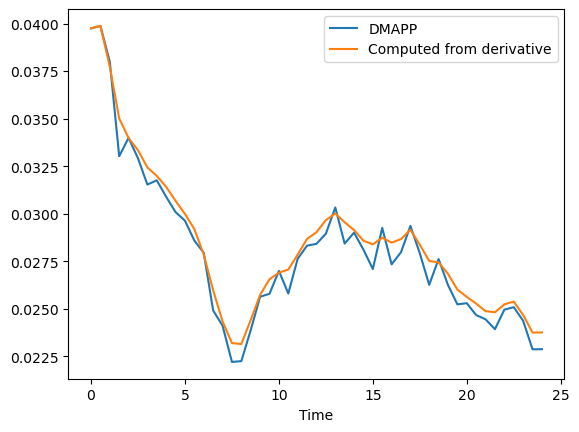

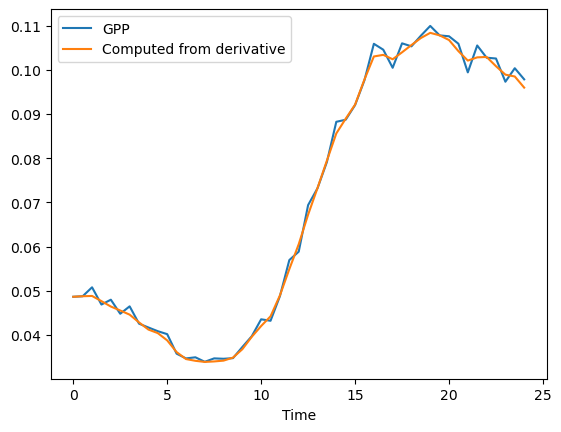

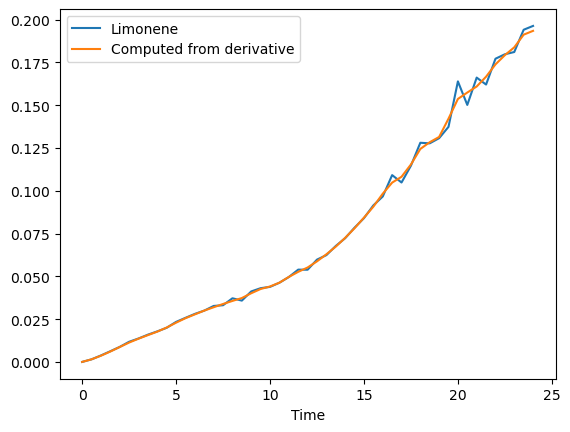

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   6.082450e+01  3.899512e+01  3.661377e+01  5.713511e+01   
         0.5   5.538406e+06  3.416540e+06  3.443327e+05  2.171875e+06   
         1.0   6.008267e+06  4.662727e+06  4.623736e+05  3.085718e+06   
         1.5   6.485439e+06  5.310017e+06  5.549124e+05  3.298947e+06   
         2.0   6.415486e+06  5.190249e+06  5.669311e+05  3.915949e+06   
...                     ...           ...           ...           ...   
WT       22.0  2.683851e+06  2.606296e+06  1.757308e+06  1.941467e+06   
         22.5  2.702559e+06  2.769807e+06  1.738575e+06  2.004032e+06   
         23.0  2.680786e+06  2.636006e+06  1.763431e+06  1.947997e+06   
         23.5  2.758393e+06  2.745514e+06  1.727355e+06  2.043042e+06   
         24.0  2.606989e+06  2.704465e+06  1.741959e+06  2.036250e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         0.5   7.245888e+05  3.693198e+06  3.434109e+06  6.440155e+05   
         1.0   1.007824e+06  5.672140e+06  3.775778e+06  8.182248e+05   
         1.5   1.040757e+06  6.644986e+06  3.835444e+06  9.593192e+05   
         2.0   1.193798e+06  6.910470e+06  4.031659e+06  9.965470e+05   
...                     ...           ...           ...           ...   
WT       22.0  1.547960e+06  3.929979e+06  4.346621e+06  1.177278e+06   
         22.5  1.656168e+06  3.978757e+06  4.351801e+06  1.299988e+06   
         23.0  1.484961e+06  3.864928e+06  4.369831e+06  1.237057e+06   
         23.5  1.457198e+06  3.740833e+06  4.479246e+06  1.244988e+06   
         24.0  1.525354e+06  3.829426e+06  4.375923e+06  1.193247e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       2.950656e+01   0.306835        0.196300  0.049520   
         0.5       2.910397e+05   0.294176        0.191253  0.066647   
         1.0       3.978621e+05   0.281081        0.173394  0.091657   
         1.5       4.568473e+05   0.253518        0.147751  0.095273   
         2.0       5.104220e+05   0.259032        0.138154  0.080518   
...                         ...        ...             ...       ...   
WT       22.0      1.509479e+06   0.738345        0.012901  0.018069   
         22.5      1.450854e+06   0.770211        0.014053  0.018318   
         23.0      1.388846e+06   0.805004        0.014205  0.020042   
         23.5      1.545789e+06   0.813565        0.014590  0.021115   
         24.0      1.436464e+06   0.780417        0.015142  0.021647   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.297461  0.018999  0.192532  0.009419  0.039748  0.048625   
         0.5   0.219071  0.098908  0.210918  0.009308  0.039874  0.049246   
         1.0   0.189419  0.137529  0.196308  0.007052  0.037956  0.052079   
         1.5   0.174440  0.158912  0.209571  0.005455  0.032896  0.048936   
         2.0   0.185153  0.184340  0.228648  0.004703  0.033707  0.051064   
...                 ...       ...       ...       ...       ...       ...   
WT       22.0  0.109817  0.105639  0.307623  0.013238  0.024957  0.102780   
         22.5  0.111490  0.098735  0.311999  0.013522  0.025088  0.102596   
         23.0  0.116194  0.103061  0.278256  0.013289  0.024371  0.097335   
         23.5  0.113995  0.095381  0.297

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.024880        0.002720  0.026372 -0.205517  0.201108   
         0.5    -0.025754       -0.022906  0.042138 -0.108042  0.118530   
         1.0    -0.040658       -0.043502  0.028626 -0.044631  0.060004   
         1.5    -0.022049       -0.035240 -0.011140 -0.004266  0.046811   
         2.0    -0.005570       -0.017861 -0.025060  0.017857  0.041468   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019262        0.000447  0.001871 -0.000877 -0.003252   
         22.5    0.066659        0.001304  0.001973  0.006378 -0.002577   
         23.0    0.043354        0.000538  0.002797  0.002505 -0.003354   
         23.5   -0.024587        0.000937  0.001605  0.001043 -0.003795   
         24.0   -0.108006        0.001271  0.000524  0.011928  0.019335   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.069767  0.001922  0.002295 -0.000970  0.001481  
         0.5   0.003776 -0.002368 -0.001792  0.003455  0.002507  
         1.0  -0.001347 -0.003853 -0.006978 -0.000309  0.003195  
         1.5   0.032340 -0.002348 -0.004249 -0.001015  0.003437  
         2.0   0.027274 -0.001302 -0.000407 -0.000303  0.003860  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.003163 -0.000312  0.001156 -0.002951  0.017687  
         22.5 -0.029366  0.000051 -0.000586 -0.005445  0.003917  
         23.0 -0.014106  0.000079 -0.002216 -0.002199  0.014327  
         23.5  0.020317  0.000792 -0.001491  0.000541  0.015242  
         24.0 -0.017596  0.001128  0.001522 -0.010626 -0.006292  

[196 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 6.038939E+188 | 1.073062E+114
     2 |       74 | 9.359645E+129 |  3.595551E+84
     3 |      138 |  4.891376E+97 |  1.090910E+82
     4 |      202 |  4.667144E+85 |  2.153443E+71
     5 |      266 |  2.797179E+81 |  1.613278E+55
     6 |      330 |  9.797650E+71 |  1.613278E+55
     7 |      394 |  8.468743E+61 |  1.471809E+49
     8 |      458 |  9.710450E+56 |  4.700876E+37
     9 |      522 |  5.017199E+50 |  4.700876E+37
    10 |      586 |  2.924772E+48 |  5.911932E+30
    11 |      650 |  5.589642E+46 |  5.911932E+30
    12 |      714 |  2.011859E+41 |  5.911932E+30
    13 |      778 |  1.012178E+41 |  3.729798E+30
    14 |      842 |  3.595363E+39 |  2.069434E+25
    15 |      906 |  5.182592E+36 |  2.426458E+22
    16 |      970 |  3.057694E+32 |  2.426458E+22
    17 |     1034 |  1.207194E+31 |  1.621711E+21
    18 |     1098 |  2.805038E+29 |  2.244583E+14
    19 |     1162 |  8.438

   162 |    10314 |  3.297967E+01 |  2.687233E+01
   163 |    10378 |  3.197635E+01 |  2.687233E+01
   164 |    10442 |  3.130966E+01 |  2.687233E+01
   165 |    10506 |  3.091383E+01 |  2.687233E+01
   166 |    10570 |  3.035913E+01 |  2.687233E+01
   167 |    10634 |  3.089652E+01 |  2.687233E+01
   168 |    10698 |  3.060534E+01 |  2.687233E+01
   169 |    10762 |  3.049791E+01 |  2.687233E+01
   170 |    10826 |  3.027357E+01 |  2.687233E+01
   171 |    10890 |  3.049411E+01 |  2.687233E+01
   172 |    10954 |  3.073575E+01 |  2.687233E+01
   173 |    11018 |  3.058676E+01 |  2.687233E+01
   174 |    11082 |  3.024455E+01 |  2.687233E+01
   175 |    11146 |  2.996170E+01 |  2.687233E+01
   176 |    11210 |  3.026022E+01 |  2.687233E+01
   177 |    11274 |  2.978097E+01 |  2.687233E+01
   178 |    11338 |  2.980592E+01 |  2.687233E+01
   179 |    11402 |  2.945728E+01 |  2.687233E+01
   180 |    11466 |  2.929965E+01 |  2.687233E+01
   181 |    11530 |  2.941674E+01 |  2.687233E+01


   326 |    20810 |  2.481766E+01 |  2.442301E+01
   327 |    20874 |  2.464275E+01 |  2.442301E+01
   328 |    20938 |  2.460684E+01 |  2.442301E+01
   329 |    21002 |  2.461287E+01 |  2.442301E+01
   330 |    21066 |  2.457707E+01 |  2.438220E+01
   331 |    21130 |  2.454739E+01 |  2.438220E+01
   332 |    21194 |  2.457460E+01 |  2.435366E+01
   333 |    21258 |  2.458172E+01 |  2.424529E+01
   334 |    21322 |  2.454162E+01 |  2.424529E+01
   335 |    21386 |  2.454288E+01 |  2.424529E+01
   336 |    21450 |  2.451635E+01 |  2.424529E+01
   337 |    21514 |  2.452471E+01 |  2.424529E+01
   338 |    21578 |  2.455630E+01 |  2.424529E+01
   339 |    21642 |  2.453108E+01 |  2.424529E+01
   340 |    21706 |  2.459249E+01 |  2.424529E+01
   341 |    21770 |  2.454762E+01 |  2.424529E+01
   342 |    21834 |  2.458423E+01 |  2.421279E+01
   343 |    21898 |  2.461233E+01 |  2.421279E+01
   344 |    21962 |  2.456849E+01 |  2.421279E+01
   345 |    22026 |  2.458673E+01 |  2.421279E+01


   490 |    31306 |  2.242383E+01 |  2.220246E+01
   491 |    31370 |  2.243949E+01 |  2.220246E+01
   492 |    31434 |  2.241560E+01 |  2.220246E+01
   493 |    31498 |  2.245437E+01 |  2.220246E+01
   494 |    31562 |  2.242002E+01 |  2.220246E+01
   495 |    31626 |  2.237069E+01 |  2.217261E+01
   496 |    31690 |  2.237804E+01 |  2.217261E+01
   497 |    31754 |  2.237857E+01 |  2.217261E+01
   498 |    31818 |  2.234315E+01 |  2.217261E+01
   499 |    31882 |  2.225718E+01 |  2.214326E+01
   500 |    31946 |  2.231407E+01 |  2.214326E+01
   501 |    32010 |  2.236010E+01 |  2.214326E+01
   502 |    32074 |  2.233432E+01 |  2.214326E+01
   503 |    32138 |  2.224305E+01 |  2.214326E+01
   504 |    32202 |  2.222448E+01 |  2.213539E+01
   505 |    32266 |  2.223920E+01 |  2.210344E+01
   506 |    32330 |  2.220325E+01 |  2.198378E+01
   507 |    32394 |  2.215716E+01 |  2.198378E+01
   508 |    32458 |  2.218098E+01 |  2.198378E+01
   509 |    32522 |  2.219310E+01 |  2.198378E+01


   654 |    41802 |  2.136670E+01 |  2.135702E+01
   655 |    41866 |  2.136493E+01 |  2.135311E+01
   656 |    41930 |  2.136104E+01 |  2.134931E+01
   657 |    41994 |  2.135777E+01 |  2.134931E+01
   658 |    42058 |  2.135702E+01 |  2.134931E+01
   659 |    42122 |  2.134985E+01 |  2.134094E+01
   660 |    42186 |  2.134600E+01 |  2.133901E+01
   661 |    42250 |  2.133785E+01 |  2.133217E+01
   662 |    42314 |  2.133400E+01 |  2.132409E+01
   663 |    42378 |  2.132722E+01 |  2.131854E+01
   664 |    42442 |  2.131934E+01 |  2.130996E+01
   665 |    42506 |  2.131389E+01 |  2.130177E+01
   666 |    42570 |  2.130737E+01 |  2.129503E+01
   667 |    42634 |  2.129718E+01 |  2.128619E+01
   668 |    42698 |  2.128963E+01 |  2.128078E+01
   669 |    42762 |  2.128173E+01 |  2.127417E+01
   670 |    42826 |  2.127641E+01 |  2.126277E+01
   671 |    42890 |  2.126595E+01 |  2.125932E+01
   672 |    42954 |  2.126068E+01 |  2.125230E+01
   673 |    43018 |  2.125755E+01 |  2.124802E+01


   818 |    52298 |  2.004077E+01 |  2.002101E+01
   819 |    52362 |  2.003664E+01 |  2.001574E+01
   820 |    52426 |  2.001794E+01 |  2.000455E+01
   821 |    52490 |  2.000778E+01 |  1.998903E+01
   822 |    52554 |  2.000618E+01 |  1.998903E+01
   823 |    52618 |  2.000663E+01 |  1.998903E+01
   824 |    52682 |  1.999990E+01 |  1.998586E+01
   825 |    52746 |  1.999614E+01 |  1.998206E+01
   826 |    52810 |  1.999364E+01 |  1.998206E+01
   827 |    52874 |  1.998499E+01 |  1.996737E+01
   828 |    52938 |  1.998010E+01 |  1.996737E+01
   829 |    53002 |  1.997939E+01 |  1.996599E+01
   830 |    53066 |  1.997244E+01 |  1.994796E+01
   831 |    53130 |  1.996636E+01 |  1.994796E+01
   832 |    53194 |  1.996247E+01 |  1.994796E+01
   833 |    53258 |  1.995255E+01 |  1.993564E+01
   834 |    53322 |  1.995311E+01 |  1.993564E+01
   835 |    53386 |  1.995745E+01 |  1.993564E+01
   836 |    53450 |  1.995150E+01 |  1.993540E+01
   837 |    53514 |  1.996049E+01 |  1.993526E+01


   982 |    62794 |  1.970038E+01 |  1.969870E+01
   983 |    62858 |  1.969986E+01 |  1.969870E+01
   984 |    62922 |  1.969923E+01 |  1.969842E+01
   985 |    62986 |  1.969829E+01 |  1.969730E+01
   986 |    63050 |  1.969742E+01 |  1.969596E+01
   987 |    63114 |  1.969676E+01 |  1.969502E+01
   988 |    63178 |  1.969597E+01 |  1.969469E+01
   989 |    63242 |  1.969594E+01 |  1.969411E+01
   990 |    63306 |  1.969509E+01 |  1.969303E+01
   991 |    63370 |  1.969396E+01 |  1.969163E+01
   992 |    63434 |  1.969307E+01 |  1.969148E+01
   993 |    63498 |  1.969238E+01 |  1.969147E+01
   994 |    63562 |  1.969191E+01 |  1.969129E+01
   995 |    63626 |  1.969157E+01 |  1.969004E+01
   996 |    63690 |  1.969190E+01 |  1.969004E+01
   997 |    63754 |  1.969106E+01 |  1.968929E+01
   998 |    63818 |  1.969018E+01 |  1.968898E+01
   999 |    63882 |  1.969002E+01 |  1.968898E+01
  1000 |    63946 |  1.968972E+01 |  1.968823E+01
  1001 |    64010 |  1.968895E+01 |  1.968823E+01


  1146 |    73290 |  1.953095E+01 |  1.952716E+01
  1147 |    73354 |  1.952877E+01 |  1.952716E+01
  1148 |    73418 |  1.952821E+01 |  1.952697E+01
  1149 |    73482 |  1.952785E+01 |  1.952548E+01
  1150 |    73546 |  1.952722E+01 |  1.952548E+01
  1151 |    73610 |  1.952664E+01 |  1.952541E+01
  1152 |    73674 |  1.952590E+01 |  1.952500E+01
  1153 |    73738 |  1.952554E+01 |  1.952447E+01
  1154 |    73802 |  1.952546E+01 |  1.952447E+01
  1155 |    73866 |  1.952467E+01 |  1.952361E+01
  1156 |    73930 |  1.952429E+01 |  1.952339E+01
  1157 |    73994 |  1.952341E+01 |  1.952247E+01
  1158 |    74058 |  1.952277E+01 |  1.952143E+01
  1159 |    74122 |  1.952203E+01 |  1.952035E+01
  1160 |    74186 |  1.952165E+01 |  1.951869E+01
  1161 |    74250 |  1.952037E+01 |  1.951754E+01
  1162 |    74314 |  1.951902E+01 |  1.951734E+01
  1163 |    74378 |  1.951828E+01 |  1.951712E+01
  1164 |    74442 |  1.951780E+01 |  1.951646E+01
  1165 |    74506 |  1.951697E+01 |  1.951516E+01


  1310 |    83786 |  1.943037E+01 |  1.942898E+01
  1311 |    83850 |  1.942926E+01 |  1.942805E+01
  1312 |    83914 |  1.942914E+01 |  1.942805E+01
  1313 |    83978 |  1.942867E+01 |  1.942744E+01
  1314 |    84042 |  1.942824E+01 |  1.942694E+01
  1315 |    84106 |  1.942808E+01 |  1.942694E+01
  1316 |    84170 |  1.942715E+01 |  1.942664E+01
  1317 |    84234 |  1.942620E+01 |  1.942524E+01
  1318 |    84298 |  1.942572E+01 |  1.942461E+01
  1319 |    84362 |  1.942505E+01 |  1.942416E+01
  1320 |    84426 |  1.942469E+01 |  1.942357E+01
  1321 |    84490 |  1.942430E+01 |  1.942357E+01
  1322 |    84554 |  1.942394E+01 |  1.942338E+01
  1323 |    84618 |  1.942374E+01 |  1.942284E+01
  1324 |    84682 |  1.942345E+01 |  1.942249E+01
  1325 |    84746 |  1.942314E+01 |  1.942208E+01
  1326 |    84810 |  1.942235E+01 |  1.942061E+01
  1327 |    84874 |  1.942119E+01 |  1.941971E+01
  1328 |    84938 |  1.942058E+01 |  1.941971E+01
  1329 |    85002 |  1.942035E+01 |  1.941957E+01


  1474 |    94282 |  1.936748E+01 |  1.936709E+01
  1475 |    94346 |  1.936730E+01 |  1.936685E+01
  1476 |    94410 |  1.936712E+01 |  1.936685E+01
  1477 |    94474 |  1.936693E+01 |  1.936679E+01
  1478 |    94538 |  1.936688E+01 |  1.936660E+01
  1479 |    94602 |  1.936658E+01 |  1.936631E+01
  1480 |    94666 |  1.936645E+01 |  1.936602E+01
  1481 |    94730 |  1.936632E+01 |  1.936602E+01
  1482 |    94794 |  1.936623E+01 |  1.936602E+01
  1483 |    94858 |  1.936609E+01 |  1.936583E+01
  1484 |    94922 |  1.936580E+01 |  1.936515E+01
  1485 |    94986 |  1.936555E+01 |  1.936515E+01
  1486 |    95050 |  1.936526E+01 |  1.936492E+01
  1487 |    95114 |  1.936481E+01 |  1.936428E+01
  1488 |    95178 |  1.936458E+01 |  1.936424E+01
  1489 |    95242 |  1.936443E+01 |  1.936424E+01
  1490 |    95306 |  1.936444E+01 |  1.936414E+01
  1491 |    95370 |  1.936433E+01 |  1.936403E+01
  1492 |    95434 |  1.936422E+01 |  1.936398E+01
  1493 |    95498 |  1.936382E+01 |  1.936297E+01


  1638 |   104778 |  1.927893E+01 |  1.927783E+01
  1639 |   104842 |  1.927837E+01 |  1.927767E+01
  1640 |   104906 |  1.927778E+01 |  1.927715E+01
  1641 |   104970 |  1.927720E+01 |  1.927582E+01
  1642 |   105034 |  1.927656E+01 |  1.927563E+01
  1643 |   105098 |  1.927596E+01 |  1.927537E+01
  1644 |   105162 |  1.927564E+01 |  1.927474E+01
  1645 |   105226 |  1.927491E+01 |  1.927379E+01
  1646 |   105290 |  1.927421E+01 |  1.927328E+01
  1647 |   105354 |  1.927340E+01 |  1.927277E+01
  1648 |   105418 |  1.927256E+01 |  1.927113E+01
  1649 |   105482 |  1.927223E+01 |  1.927113E+01
  1650 |   105546 |  1.927136E+01 |  1.927066E+01
  1651 |   105610 |  1.927031E+01 |  1.926945E+01
  1652 |   105674 |  1.926985E+01 |  1.926814E+01
  1653 |   105738 |  1.926905E+01 |  1.926814E+01
  1654 |   105802 |  1.926892E+01 |  1.926814E+01
  1655 |   105866 |  1.926895E+01 |  1.926751E+01
  1656 |   105930 |  1.926835E+01 |  1.926694E+01
  1657 |   105994 |  1.926744E+01 |  1.926694E+01


  1802 |   115274 |  1.908030E+01 |  1.907607E+01
  1803 |   115338 |  1.907826E+01 |  1.907328E+01
  1804 |   115402 |  1.907666E+01 |  1.907328E+01
  1805 |   115466 |  1.907699E+01 |  1.907328E+01
  1806 |   115530 |  1.907840E+01 |  1.907259E+01
  1807 |   115594 |  1.907567E+01 |  1.907226E+01
  1808 |   115658 |  1.907390E+01 |  1.907074E+01
  1809 |   115722 |  1.907166E+01 |  1.906640E+01
  1810 |   115786 |  1.907155E+01 |  1.906640E+01
  1811 |   115850 |  1.907051E+01 |  1.906495E+01
  1812 |   115914 |  1.906684E+01 |  1.906174E+01
  1813 |   115978 |  1.906521E+01 |  1.905989E+01
  1814 |   116042 |  1.906098E+01 |  1.905893E+01
  1815 |   116106 |  1.906098E+01 |  1.905893E+01
  1816 |   116170 |  1.905849E+01 |  1.905317E+01
  1817 |   116234 |  1.905479E+01 |  1.905087E+01
  1818 |   116298 |  1.905203E+01 |  1.904937E+01
  1819 |   116362 |  1.904822E+01 |  1.904481E+01
  1820 |   116426 |  1.904663E+01 |  1.904077E+01
  1821 |   116490 |  1.904255E+01 |  1.903728E+01


  1966 |   125770 |  1.880864E+01 |  1.880742E+01
  1967 |   125834 |  1.880780E+01 |  1.880647E+01
  1968 |   125898 |  1.880722E+01 |  1.880634E+01
  1969 |   125962 |  1.880639E+01 |  1.880464E+01
  1970 |   126026 |  1.880588E+01 |  1.880445E+01
  1971 |   126090 |  1.880658E+01 |  1.880445E+01
  1972 |   126154 |  1.880539E+01 |  1.880337E+01
  1973 |   126218 |  1.880501E+01 |  1.880337E+01
  1974 |   126282 |  1.880376E+01 |  1.880108E+01
  1975 |   126346 |  1.880232E+01 |  1.880088E+01
  1976 |   126410 |  1.880193E+01 |  1.879819E+01
  1977 |   126474 |  1.880015E+01 |  1.879744E+01
  1978 |   126538 |  1.879845E+01 |  1.879688E+01
  1979 |   126602 |  1.879783E+01 |  1.879590E+01
  1980 |   126666 |  1.879675E+01 |  1.879419E+01
  1981 |   126730 |  1.879600E+01 |  1.879419E+01
  1982 |   126794 |  1.879614E+01 |  1.879419E+01
  1983 |   126858 |  1.879538E+01 |  1.879275E+01
  1984 |   126922 |  1.879403E+01 |  1.879275E+01
  1985 |   126986 |  1.879319E+01 |  1.879131E+01


  2130 |   136266 |  1.859483E+01 |  1.859149E+01
  2131 |   136330 |  1.859262E+01 |  1.859058E+01
  2132 |   136394 |  1.859170E+01 |  1.858997E+01
  2133 |   136458 |  1.859056E+01 |  1.858867E+01
  2134 |   136522 |  1.858987E+01 |  1.858791E+01
  2135 |   136586 |  1.858878E+01 |  1.858731E+01
  2136 |   136650 |  1.858761E+01 |  1.858560E+01
  2137 |   136714 |  1.858716E+01 |  1.858253E+01
  2138 |   136778 |  1.858469E+01 |  1.858253E+01
  2139 |   136842 |  1.858436E+01 |  1.858253E+01
  2140 |   136906 |  1.858332E+01 |  1.858091E+01
  2141 |   136970 |  1.858280E+01 |  1.858091E+01
  2142 |   137034 |  1.858186E+01 |  1.857947E+01
  2143 |   137098 |  1.858157E+01 |  1.857942E+01
  2144 |   137162 |  1.858104E+01 |  1.857942E+01
  2145 |   137226 |  1.858003E+01 |  1.857868E+01
  2146 |   137290 |  1.857932E+01 |  1.857825E+01
  2147 |   137354 |  1.857895E+01 |  1.857795E+01
  2148 |   137418 |  1.857848E+01 |  1.857647E+01
  2149 |   137482 |  1.857791E+01 |  1.857445E+01


  2294 |   146762 |  1.847267E+01 |  1.847178E+01
  2295 |   146826 |  1.847216E+01 |  1.847092E+01
  2296 |   146890 |  1.847147E+01 |  1.847092E+01
  2297 |   146954 |  1.847121E+01 |  1.847008E+01
  2298 |   147018 |  1.847090E+01 |  1.846985E+01
  2299 |   147082 |  1.846968E+01 |  1.846837E+01
  2300 |   147146 |  1.846966E+01 |  1.846837E+01
  2301 |   147210 |  1.846935E+01 |  1.846837E+01
  2302 |   147274 |  1.846872E+01 |  1.846761E+01
  2303 |   147338 |  1.846865E+01 |  1.846743E+01
  2304 |   147402 |  1.846809E+01 |  1.846705E+01
  2305 |   147466 |  1.846840E+01 |  1.846701E+01
  2306 |   147530 |  1.846803E+01 |  1.846701E+01
  2307 |   147594 |  1.846764E+01 |  1.846588E+01
  2308 |   147658 |  1.846724E+01 |  1.846588E+01
  2309 |   147722 |  1.846719E+01 |  1.846588E+01
  2310 |   147786 |  1.846633E+01 |  1.846588E+01
  2311 |   147850 |  1.846622E+01 |  1.846532E+01
  2312 |   147914 |  1.846575E+01 |  1.846496E+01
  2313 |   147978 |  1.846510E+01 |  1.846431E+01


  2458 |   157258 |  1.839039E+01 |  1.838665E+01
  2459 |   157322 |  1.838814E+01 |  1.838433E+01
  2460 |   157386 |  1.838653E+01 |  1.838344E+01
  2461 |   157450 |  1.838601E+01 |  1.838119E+01
  2462 |   157514 |  1.838375E+01 |  1.838119E+01
  2463 |   157578 |  1.838260E+01 |  1.837973E+01
  2464 |   157642 |  1.838285E+01 |  1.837973E+01
  2465 |   157706 |  1.838251E+01 |  1.837973E+01
  2466 |   157770 |  1.838244E+01 |  1.837964E+01
  2467 |   157834 |  1.838129E+01 |  1.837957E+01
  2468 |   157898 |  1.837963E+01 |  1.837674E+01
  2469 |   157962 |  1.837961E+01 |  1.837591E+01
  2470 |   158026 |  1.837841E+01 |  1.837591E+01
  2471 |   158090 |  1.837752E+01 |  1.837361E+01
  2472 |   158154 |  1.837748E+01 |  1.837361E+01
  2473 |   158218 |  1.837602E+01 |  1.837361E+01
  2474 |   158282 |  1.837631E+01 |  1.837361E+01
  2475 |   158346 |  1.837532E+01 |  1.837234E+01
  2476 |   158410 |  1.837335E+01 |  1.837027E+01
  2477 |   158474 |  1.837187E+01 |  1.837027E+01


  2622 |   167754 |  1.827062E+01 |  1.826922E+01
  2623 |   167818 |  1.826911E+01 |  1.826851E+01
  2624 |   167882 |  1.826803E+01 |  1.826690E+01
  2625 |   167946 |  1.826729E+01 |  1.826662E+01
  2626 |   168010 |  1.826681E+01 |  1.826505E+01
  2627 |   168074 |  1.826598E+01 |  1.826505E+01
  2628 |   168138 |  1.826554E+01 |  1.826404E+01
  2629 |   168202 |  1.826459E+01 |  1.826319E+01
  2630 |   168266 |  1.826323E+01 |  1.826067E+01
  2631 |   168330 |  1.826056E+01 |  1.825933E+01
  2632 |   168394 |  1.825991E+01 |  1.825929E+01
  2633 |   168458 |  1.825851E+01 |  1.825731E+01
  2634 |   168522 |  1.825780E+01 |  1.825649E+01
  2635 |   168586 |  1.825725E+01 |  1.825585E+01
  2636 |   168650 |  1.825622E+01 |  1.825524E+01
  2637 |   168714 |  1.825566E+01 |  1.825504E+01
  2638 |   168778 |  1.825474E+01 |  1.825405E+01
  2639 |   168842 |  1.825416E+01 |  1.825301E+01
  2640 |   168906 |  1.825391E+01 |  1.825239E+01
  2641 |   168970 |  1.825302E+01 |  1.825178E+01


  2786 |   178250 |  1.815029E+01 |  1.814965E+01
  2787 |   178314 |  1.814972E+01 |  1.814894E+01
  2788 |   178378 |  1.814955E+01 |  1.814846E+01
  2789 |   178442 |  1.814947E+01 |  1.814799E+01
  2790 |   178506 |  1.814883E+01 |  1.814760E+01
  2791 |   178570 |  1.814811E+01 |  1.814643E+01
  2792 |   178634 |  1.814666E+01 |  1.814555E+01
  2793 |   178698 |  1.814589E+01 |  1.814506E+01
  2794 |   178762 |  1.814508E+01 |  1.814407E+01
  2795 |   178826 |  1.814430E+01 |  1.814316E+01
  2796 |   178890 |  1.814371E+01 |  1.814270E+01
  2797 |   178954 |  1.814288E+01 |  1.814223E+01
  2798 |   179018 |  1.814231E+01 |  1.814140E+01
  2799 |   179082 |  1.814205E+01 |  1.814140E+01
  2800 |   179146 |  1.814173E+01 |  1.813985E+01
  2801 |   179210 |  1.814043E+01 |  1.813958E+01
  2802 |   179274 |  1.814017E+01 |  1.813941E+01
  2803 |   179338 |  1.813988E+01 |  1.813891E+01
  2804 |   179402 |  1.813944E+01 |  1.813815E+01
  2805 |   179466 |  1.813861E+01 |  1.813728E+01


  2950 |   188746 |  1.806677E+01 |  1.806606E+01
  2951 |   188810 |  1.806650E+01 |  1.806593E+01
  2952 |   188874 |  1.806592E+01 |  1.806535E+01
  2953 |   188938 |  1.806563E+01 |  1.806484E+01
  2954 |   189002 |  1.806517E+01 |  1.806484E+01
  2955 |   189066 |  1.806514E+01 |  1.806459E+01
  2956 |   189130 |  1.806527E+01 |  1.806457E+01
  2957 |   189194 |  1.806492E+01 |  1.806457E+01
  2958 |   189258 |  1.806513E+01 |  1.806457E+01
  2959 |   189322 |  1.806486E+01 |  1.806403E+01
  2960 |   189386 |  1.806455E+01 |  1.806374E+01
  2961 |   189450 |  1.806459E+01 |  1.806363E+01
  2962 |   189514 |  1.806429E+01 |  1.806342E+01
  2963 |   189578 |  1.806391E+01 |  1.806342E+01
  2964 |   189642 |  1.806402E+01 |  1.806318E+01
  2965 |   189706 |  1.806306E+01 |  1.806240E+01
  2966 |   189770 |  1.806285E+01 |  1.806218E+01
  2967 |   189834 |  1.806259E+01 |  1.806179E+01
  2968 |   189898 |  1.806227E+01 |  1.806159E+01
  2969 |   189962 |  1.806177E+01 |  1.806094E+01


  3114 |   199242 |  1.802061E+01 |  1.802021E+01
  3115 |   199306 |  1.802056E+01 |  1.802021E+01
  3116 |   199370 |  1.802034E+01 |  1.801989E+01
  3117 |   199434 |  1.802004E+01 |  1.801940E+01
  3118 |   199498 |  1.801969E+01 |  1.801938E+01
  3119 |   199562 |  1.801939E+01 |  1.801919E+01
  3120 |   199626 |  1.801922E+01 |  1.801889E+01
  3121 |   199690 |  1.801908E+01 |  1.801880E+01
  3122 |   199754 |  1.801892E+01 |  1.801869E+01
  3123 |   199818 |  1.801883E+01 |  1.801835E+01
  3124 |   199882 |  1.801851E+01 |  1.801823E+01
  3125 |   199946 |  1.801843E+01 |  1.801823E+01
  3126 |   200010 |  1.801826E+01 |  1.801786E+01
  3127 |   200074 |  1.801806E+01 |  1.801753E+01
  3128 |   200138 |  1.801770E+01 |  1.801744E+01
  3129 |   200202 |  1.801743E+01 |  1.801700E+01
  3130 |   200266 |  1.801723E+01 |  1.801669E+01
  3131 |   200330 |  1.801693E+01 |  1.801649E+01
  3132 |   200394 |  1.801675E+01 |  1.801647E+01
  3133 |   200458 |  1.801641E+01 |  1.801588E+01


  3278 |   209738 |  1.798722E+01 |  1.798678E+01
  3279 |   209802 |  1.798699E+01 |  1.798645E+01
  3280 |   209866 |  1.798660E+01 |  1.798618E+01
  3281 |   209930 |  1.798641E+01 |  1.798610E+01
  3282 |   209994 |  1.798639E+01 |  1.798605E+01
  3283 |   210058 |  1.798612E+01 |  1.798568E+01
  3284 |   210122 |  1.798585E+01 |  1.798543E+01
  3285 |   210186 |  1.798556E+01 |  1.798515E+01
  3286 |   210250 |  1.798529E+01 |  1.798470E+01
  3287 |   210314 |  1.798507E+01 |  1.798470E+01
  3288 |   210378 |  1.798469E+01 |  1.798434E+01
  3289 |   210442 |  1.798412E+01 |  1.798386E+01
  3290 |   210506 |  1.798395E+01 |  1.798315E+01
  3291 |   210570 |  1.798395E+01 |  1.798315E+01
  3292 |   210634 |  1.798366E+01 |  1.798284E+01
  3293 |   210698 |  1.798337E+01 |  1.798281E+01
  3294 |   210762 |  1.798299E+01 |  1.798272E+01
  3295 |   210826 |  1.798272E+01 |  1.798191E+01
  3296 |   210890 |  1.798237E+01 |  1.798191E+01
  3297 |   210954 |  1.798215E+01 |  1.798191E+01


  3442 |   220234 |  1.794778E+01 |  1.794696E+01
  3443 |   220298 |  1.794732E+01 |  1.794673E+01
  3444 |   220362 |  1.794692E+01 |  1.794666E+01
  3445 |   220426 |  1.794665E+01 |  1.794618E+01
  3446 |   220490 |  1.794663E+01 |  1.794604E+01
  3447 |   220554 |  1.794632E+01 |  1.794560E+01
  3448 |   220618 |  1.794582E+01 |  1.794506E+01
  3449 |   220682 |  1.794567E+01 |  1.794506E+01
  3450 |   220746 |  1.794524E+01 |  1.794460E+01
  3451 |   220810 |  1.794505E+01 |  1.794448E+01
  3452 |   220874 |  1.794502E+01 |  1.794403E+01
  3453 |   220938 |  1.794480E+01 |  1.794403E+01
  3454 |   221002 |  1.794447E+01 |  1.794403E+01
  3455 |   221066 |  1.794431E+01 |  1.794384E+01
  3456 |   221130 |  1.794437E+01 |  1.794384E+01
  3457 |   221194 |  1.794416E+01 |  1.794362E+01
  3458 |   221258 |  1.794386E+01 |  1.794348E+01
  3459 |   221322 |  1.794351E+01 |  1.794283E+01
  3460 |   221386 |  1.794303E+01 |  1.794235E+01
  3461 |   221450 |  1.794270E+01 |  1.794213E+01


  3606 |   230730 |  1.790955E+01 |  1.790923E+01
  3607 |   230794 |  1.790943E+01 |  1.790923E+01
  3608 |   230858 |  1.790913E+01 |  1.790809E+01
  3609 |   230922 |  1.790831E+01 |  1.790777E+01
  3610 |   230986 |  1.790763E+01 |  1.790703E+01
  3611 |   231050 |  1.790719E+01 |  1.790675E+01
  3612 |   231114 |  1.790695E+01 |  1.790631E+01
  3613 |   231178 |  1.790653E+01 |  1.790555E+01
  3614 |   231242 |  1.790550E+01 |  1.790471E+01
  3615 |   231306 |  1.790489E+01 |  1.790466E+01
  3616 |   231370 |  1.790470E+01 |  1.790433E+01
  3617 |   231434 |  1.790418E+01 |  1.790346E+01
  3618 |   231498 |  1.790358E+01 |  1.790234E+01
  3619 |   231562 |  1.790247E+01 |  1.789996E+01
  3620 |   231626 |  1.790098E+01 |  1.789915E+01
  3621 |   231690 |  1.789978E+01 |  1.789854E+01
  3622 |   231754 |  1.789906E+01 |  1.789814E+01
  3623 |   231818 |  1.789800E+01 |  1.789670E+01
  3624 |   231882 |  1.789693E+01 |  1.789573E+01
  3625 |   231946 |  1.789585E+01 |  1.789418E+01


  3770 |   241226 |  1.781778E+01 |  1.781684E+01
  3771 |   241290 |  1.781731E+01 |  1.781649E+01
  3772 |   241354 |  1.781694E+01 |  1.781632E+01
  3773 |   241418 |  1.781642E+01 |  1.781527E+01
  3774 |   241482 |  1.781642E+01 |  1.781513E+01
  3775 |   241546 |  1.781535E+01 |  1.781408E+01
  3776 |   241610 |  1.781496E+01 |  1.781400E+01
  3777 |   241674 |  1.781486E+01 |  1.781358E+01
  3778 |   241738 |  1.781468E+01 |  1.781358E+01
  3779 |   241802 |  1.781423E+01 |  1.781229E+01
  3780 |   241866 |  1.781332E+01 |  1.781057E+01
  3781 |   241930 |  1.781183E+01 |  1.781057E+01
  3782 |   241994 |  1.781075E+01 |  1.780983E+01
  3783 |   242058 |  1.781015E+01 |  1.780933E+01
  3784 |   242122 |  1.780956E+01 |  1.780811E+01
  3785 |   242186 |  1.780874E+01 |  1.780811E+01
  3786 |   242250 |  1.780870E+01 |  1.780802E+01
  3787 |   242314 |  1.780780E+01 |  1.780648E+01
  3788 |   242378 |  1.780739E+01 |  1.780648E+01
  3789 |   242442 |  1.780716E+01 |  1.780648E+01


  3934 |   251722 |  1.777241E+01 |  1.777220E+01
  3935 |   251786 |  1.777226E+01 |  1.777209E+01
  3936 |   251850 |  1.777195E+01 |  1.777166E+01
  3937 |   251914 |  1.777186E+01 |  1.777163E+01
  3938 |   251978 |  1.777175E+01 |  1.777145E+01
  3939 |   252042 |  1.777156E+01 |  1.777130E+01
  3940 |   252106 |  1.777147E+01 |  1.777118E+01
  3941 |   252170 |  1.777136E+01 |  1.777089E+01
  3942 |   252234 |  1.777122E+01 |  1.777089E+01
  3943 |   252298 |  1.777101E+01 |  1.777085E+01
  3944 |   252362 |  1.777073E+01 |  1.777033E+01
  3945 |   252426 |  1.777049E+01 |  1.777023E+01
  3946 |   252490 |  1.777025E+01 |  1.776999E+01
  3947 |   252554 |  1.777006E+01 |  1.776976E+01
  3948 |   252618 |  1.777000E+01 |  1.776968E+01
  3949 |   252682 |  1.777006E+01 |  1.776968E+01
  3950 |   252746 |  1.776990E+01 |  1.776966E+01
  3951 |   252810 |  1.776955E+01 |  1.776911E+01
  3952 |   252874 |  1.776956E+01 |  1.776911E+01
  3953 |   252938 |  1.776946E+01 |  1.776898E+01


  4098 |   262218 |  1.772892E+01 |  1.772857E+01
  4099 |   262282 |  1.772878E+01 |  1.772808E+01
  4100 |   262346 |  1.772837E+01 |  1.772766E+01
  4101 |   262410 |  1.772825E+01 |  1.772766E+01
  4102 |   262474 |  1.772773E+01 |  1.772733E+01
  4103 |   262538 |  1.772742E+01 |  1.772646E+01
  4104 |   262602 |  1.772717E+01 |  1.772646E+01
  4105 |   262666 |  1.772692E+01 |  1.772646E+01
  4106 |   262730 |  1.772682E+01 |  1.772646E+01
  4107 |   262794 |  1.772684E+01 |  1.772611E+01
  4108 |   262858 |  1.772659E+01 |  1.772611E+01
  4109 |   262922 |  1.772640E+01 |  1.772611E+01
  4110 |   262986 |  1.772653E+01 |  1.772610E+01
  4111 |   263050 |  1.772648E+01 |  1.772610E+01
  4112 |   263114 |  1.772632E+01 |  1.772570E+01
  4113 |   263178 |  1.772597E+01 |  1.772550E+01
  4114 |   263242 |  1.772571E+01 |  1.772530E+01
  4115 |   263306 |  1.772560E+01 |  1.772500E+01
  4116 |   263370 |  1.772537E+01 |  1.772500E+01
  4117 |   263434 |  1.772547E+01 |  1.772500E+01


  4262 |   272714 |  1.767484E+01 |  1.767375E+01
  4263 |   272778 |  1.767503E+01 |  1.767375E+01
  4264 |   272842 |  1.767462E+01 |  1.767325E+01
  4265 |   272906 |  1.767539E+01 |  1.767325E+01
  4266 |   272970 |  1.767510E+01 |  1.767325E+01
  4267 |   273034 |  1.767526E+01 |  1.767325E+01
  4268 |   273098 |  1.767460E+01 |  1.767222E+01
  4269 |   273162 |  1.767362E+01 |  1.767117E+01
  4270 |   273226 |  1.767380E+01 |  1.767117E+01
  4271 |   273290 |  1.767460E+01 |  1.767117E+01
  4272 |   273354 |  1.767478E+01 |  1.767117E+01
  4273 |   273418 |  1.767392E+01 |  1.767117E+01
  4274 |   273482 |  1.767298E+01 |  1.767112E+01
  4275 |   273546 |  1.767258E+01 |  1.767095E+01
  4276 |   273610 |  1.767083E+01 |  1.766691E+01
  4277 |   273674 |  1.766836E+01 |  1.766606E+01
  4278 |   273738 |  1.766686E+01 |  1.766535E+01
  4279 |   273802 |  1.766648E+01 |  1.766495E+01
  4280 |   273866 |  1.766688E+01 |  1.766485E+01
  4281 |   273930 |  1.766572E+01 |  1.766439E+01


  4426 |   283210 |  1.760739E+01 |  1.760632E+01
  4427 |   283274 |  1.760672E+01 |  1.760561E+01
  4428 |   283338 |  1.760516E+01 |  1.760396E+01
  4429 |   283402 |  1.760413E+01 |  1.760273E+01
  4430 |   283466 |  1.760326E+01 |  1.760259E+01
  4431 |   283530 |  1.760259E+01 |  1.760168E+01
  4432 |   283594 |  1.760230E+01 |  1.760152E+01
  4433 |   283658 |  1.760178E+01 |  1.760050E+01
  4434 |   283722 |  1.760127E+01 |  1.760013E+01
  4435 |   283786 |  1.760012E+01 |  1.759763E+01
  4436 |   283850 |  1.759909E+01 |  1.759763E+01
  4437 |   283914 |  1.759861E+01 |  1.759683E+01
  4438 |   283978 |  1.759773E+01 |  1.759575E+01
  4439 |   284042 |  1.759698E+01 |  1.759575E+01
  4440 |   284106 |  1.759614E+01 |  1.759527E+01
  4441 |   284170 |  1.759532E+01 |  1.759379E+01
  4442 |   284234 |  1.759473E+01 |  1.759267E+01
  4443 |   284298 |  1.759354E+01 |  1.759243E+01
  4444 |   284362 |  1.759227E+01 |  1.759136E+01
  4445 |   284426 |  1.759179E+01 |  1.759069E+01


  4590 |   293706 |  1.749331E+01 |  1.749292E+01
  4591 |   293770 |  1.749334E+01 |  1.749270E+01
  4592 |   293834 |  1.749331E+01 |  1.749270E+01
  4593 |   293898 |  1.749348E+01 |  1.749270E+01
  4594 |   293962 |  1.749338E+01 |  1.749260E+01
  4595 |   294026 |  1.749295E+01 |  1.749213E+01
  4596 |   294090 |  1.749277E+01 |  1.749171E+01
  4597 |   294154 |  1.749225E+01 |  1.749171E+01
  4598 |   294218 |  1.749183E+01 |  1.749091E+01
  4599 |   294282 |  1.749126E+01 |  1.749039E+01
  4600 |   294346 |  1.749138E+01 |  1.749039E+01
  4601 |   294410 |  1.749136E+01 |  1.749039E+01
  4602 |   294474 |  1.749016E+01 |  1.748961E+01
  4603 |   294538 |  1.748974E+01 |  1.748898E+01
  4604 |   294602 |  1.748890E+01 |  1.748802E+01
  4605 |   294666 |  1.748857E+01 |  1.748754E+01
  4606 |   294730 |  1.748853E+01 |  1.748754E+01
  4607 |   294794 |  1.748857E+01 |  1.748754E+01
  4608 |   294858 |  1.748846E+01 |  1.748713E+01
  4609 |   294922 |  1.748768E+01 |  1.748675E+01


  4754 |   304202 |  1.743096E+01 |  1.743013E+01
  4755 |   304266 |  1.743085E+01 |  1.743013E+01
  4756 |   304330 |  1.743084E+01 |  1.743013E+01
  4757 |   304394 |  1.743056E+01 |  1.742998E+01
  4758 |   304458 |  1.743048E+01 |  1.742998E+01
  4759 |   304522 |  1.743025E+01 |  1.742965E+01
  4760 |   304586 |  1.742976E+01 |  1.742895E+01
  4761 |   304650 |  1.742961E+01 |  1.742895E+01
  4762 |   304714 |  1.742934E+01 |  1.742895E+01
  4763 |   304778 |  1.742927E+01 |  1.742880E+01
  4764 |   304842 |  1.742921E+01 |  1.742880E+01
  4765 |   304906 |  1.742891E+01 |  1.742829E+01
  4766 |   304970 |  1.742843E+01 |  1.742751E+01
  4767 |   305034 |  1.742808E+01 |  1.742751E+01
  4768 |   305098 |  1.742776E+01 |  1.742688E+01
  4769 |   305162 |  1.742749E+01 |  1.742688E+01
  4770 |   305226 |  1.742729E+01 |  1.742688E+01
  4771 |   305290 |  1.742747E+01 |  1.742669E+01
  4772 |   305354 |  1.742702E+01 |  1.742602E+01
  4773 |   305418 |  1.742665E+01 |  1.742602E+01


  4918 |   314698 |  1.735450E+01 |  1.735338E+01
  4919 |   314762 |  1.735363E+01 |  1.735254E+01
  4920 |   314826 |  1.735290E+01 |  1.735187E+01
  4921 |   314890 |  1.735169E+01 |  1.734977E+01
  4922 |   314954 |  1.735017E+01 |  1.734882E+01
  4923 |   315018 |  1.734962E+01 |  1.734853E+01
  4924 |   315082 |  1.734876E+01 |  1.734789E+01
  4925 |   315146 |  1.734739E+01 |  1.734618E+01
  4926 |   315210 |  1.734566E+01 |  1.734388E+01
  4927 |   315274 |  1.734457E+01 |  1.734241E+01
  4928 |   315338 |  1.734283E+01 |  1.734146E+01
  4929 |   315402 |  1.734237E+01 |  1.734122E+01
  4930 |   315466 |  1.734200E+01 |  1.734043E+01
  4931 |   315530 |  1.734179E+01 |  1.734027E+01
  4932 |   315594 |  1.734075E+01 |  1.734014E+01
  4933 |   315658 |  1.734024E+01 |  1.733803E+01
  4934 |   315722 |  1.733982E+01 |  1.733803E+01
  4935 |   315786 |  1.733899E+01 |  1.733591E+01
  4936 |   315850 |  1.733800E+01 |  1.733591E+01
  4937 |   315914 |  1.733699E+01 |  1.733544E+01


  5082 |   325194 |  1.715776E+01 |  1.715553E+01
  5083 |   325258 |  1.715643E+01 |  1.715496E+01
  5084 |   325322 |  1.715575E+01 |  1.715370E+01
  5085 |   325386 |  1.715507E+01 |  1.715370E+01
  5086 |   325450 |  1.715383E+01 |  1.715226E+01
  5087 |   325514 |  1.715326E+01 |  1.715226E+01
  5088 |   325578 |  1.715407E+01 |  1.715201E+01
  5089 |   325642 |  1.715341E+01 |  1.715201E+01
  5090 |   325706 |  1.715197E+01 |  1.715005E+01
  5091 |   325770 |  1.715130E+01 |  1.714961E+01
  5092 |   325834 |  1.715011E+01 |  1.714850E+01
  5093 |   325898 |  1.714939E+01 |  1.714738E+01
  5094 |   325962 |  1.714792E+01 |  1.714631E+01
  5095 |   326026 |  1.714796E+01 |  1.714586E+01
  5096 |   326090 |  1.714604E+01 |  1.714426E+01
  5097 |   326154 |  1.714528E+01 |  1.714410E+01
  5098 |   326218 |  1.714421E+01 |  1.714226E+01
  5099 |   326282 |  1.714374E+01 |  1.714131E+01
  5100 |   326346 |  1.714282E+01 |  1.714131E+01
  5101 |   326410 |  1.714172E+01 |  1.713978E+01


  5246 |   335690 |  1.699000E+01 |  1.698486E+01
  5247 |   335754 |  1.698748E+01 |  1.698486E+01
  5248 |   335818 |  1.698732E+01 |  1.698486E+01
  5249 |   335882 |  1.698768E+01 |  1.698454E+01
  5250 |   335946 |  1.698556E+01 |  1.698375E+01
  5251 |   336010 |  1.698400E+01 |  1.698082E+01
  5252 |   336074 |  1.698322E+01 |  1.698067E+01
  5253 |   336138 |  1.698205E+01 |  1.697963E+01
  5254 |   336202 |  1.697975E+01 |  1.697651E+01
  5255 |   336266 |  1.697824E+01 |  1.697600E+01
  5256 |   336330 |  1.697638E+01 |  1.697399E+01
  5257 |   336394 |  1.697499E+01 |  1.697119E+01
  5258 |   336458 |  1.697233E+01 |  1.697053E+01
  5259 |   336522 |  1.697196E+01 |  1.697020E+01
  5260 |   336586 |  1.697241E+01 |  1.697020E+01
  5261 |   336650 |  1.697097E+01 |  1.696817E+01
  5262 |   336714 |  1.696937E+01 |  1.696685E+01
  5263 |   336778 |  1.696832E+01 |  1.696685E+01
  5264 |   336842 |  1.696806E+01 |  1.696546E+01
  5265 |   336906 |  1.696751E+01 |  1.696530E+01


  5410 |   346186 |  1.679597E+01 |  1.679224E+01
  5411 |   346250 |  1.679601E+01 |  1.679224E+01
  5412 |   346314 |  1.679415E+01 |  1.678070E+01
  5413 |   346378 |  1.678963E+01 |  1.677997E+01
  5414 |   346442 |  1.677881E+01 |  1.676181E+01
  5415 |   346506 |  1.676918E+01 |  1.675585E+01
  5416 |   346570 |  1.676083E+01 |  1.675363E+01
  5417 |   346634 |  1.675954E+01 |  1.675363E+01
  5418 |   346698 |  1.675674E+01 |  1.674210E+01
  5419 |   346762 |  1.674699E+01 |  1.673854E+01
  5420 |   346826 |  1.673768E+01 |  1.673475E+01
  5421 |   346890 |  1.673788E+01 |  1.673475E+01
  5422 |   346954 |  1.673508E+01 |  1.672688E+01
  5423 |   347018 |  1.673382E+01 |  1.672688E+01
  5424 |   347082 |  1.673172E+01 |  1.672411E+01
  5425 |   347146 |  1.672893E+01 |  1.672411E+01
  5426 |   347210 |  1.672555E+01 |  1.672030E+01
  5427 |   347274 |  1.672286E+01 |  1.671343E+01
  5428 |   347338 |  1.671584E+01 |  1.670657E+01
  5429 |   347402 |  1.671003E+01 |  1.669805E+01


  5574 |   356682 |  1.635483E+01 |  1.634949E+01
  5575 |   356746 |  1.635621E+01 |  1.634949E+01
  5576 |   356810 |  1.635679E+01 |  1.634949E+01
  5577 |   356874 |  1.635886E+01 |  1.634949E+01
  5578 |   356938 |  1.636146E+01 |  1.634949E+01
  5579 |   357002 |  1.636039E+01 |  1.634949E+01
  5580 |   357066 |  1.636108E+01 |  1.634949E+01
  5581 |   357130 |  1.635887E+01 |  1.634858E+01
  5582 |   357194 |  1.635869E+01 |  1.634858E+01
  5583 |   357258 |  1.635919E+01 |  1.634858E+01
  5584 |   357322 |  1.635991E+01 |  1.634858E+01
  5585 |   357386 |  1.636195E+01 |  1.634858E+01
  5586 |   357450 |  1.636024E+01 |  1.634858E+01
  5587 |   357514 |  1.635768E+01 |  1.634653E+01
  5588 |   357578 |  1.635816E+01 |  1.634653E+01
  5589 |   357642 |  1.635806E+01 |  1.634653E+01
  5590 |   357706 |  1.635060E+01 |  1.634202E+01
  5591 |   357770 |  1.634821E+01 |  1.633878E+01
  5592 |   357834 |  1.634485E+01 |  1.633721E+01
  5593 |   357898 |  1.634248E+01 |  1.633721E+01


  5738 |   367178 |  1.621775E+01 |  1.621662E+01
  5739 |   367242 |  1.621611E+01 |  1.621270E+01
  5740 |   367306 |  1.621470E+01 |  1.621270E+01
  5741 |   367370 |  1.621359E+01 |  1.621133E+01
  5742 |   367434 |  1.621242E+01 |  1.620997E+01
  5743 |   367498 |  1.621159E+01 |  1.620997E+01
  5744 |   367562 |  1.621101E+01 |  1.620860E+01
  5745 |   367626 |  1.620988E+01 |  1.620808E+01
  5746 |   367690 |  1.620942E+01 |  1.620808E+01
  5747 |   367754 |  1.620896E+01 |  1.620794E+01
  5748 |   367818 |  1.620830E+01 |  1.620574E+01
  5749 |   367882 |  1.620695E+01 |  1.620574E+01
  5750 |   367946 |  1.620663E+01 |  1.620490E+01
  5751 |   368010 |  1.620602E+01 |  1.620383E+01
  5752 |   368074 |  1.620479E+01 |  1.620292E+01
  5753 |   368138 |  1.620380E+01 |  1.620281E+01
  5754 |   368202 |  1.620309E+01 |  1.620233E+01
  5755 |   368266 |  1.620240E+01 |  1.620086E+01
  5756 |   368330 |  1.620128E+01 |  1.620004E+01
  5757 |   368394 |  1.619998E+01 |  1.619951E+01


  5902 |   377674 |  1.612725E+01 |  1.612586E+01
  5903 |   377738 |  1.612667E+01 |  1.612586E+01
  5904 |   377802 |  1.612635E+01 |  1.612554E+01
  5905 |   377866 |  1.612587E+01 |  1.612495E+01
  5906 |   377930 |  1.612504E+01 |  1.612411E+01
  5907 |   377994 |  1.612446E+01 |  1.612316E+01
  5908 |   378058 |  1.612324E+01 |  1.612233E+01
  5909 |   378122 |  1.612240E+01 |  1.612194E+01
  5910 |   378186 |  1.612216E+01 |  1.612122E+01
  5911 |   378250 |  1.612160E+01 |  1.612052E+01
  5912 |   378314 |  1.612046E+01 |  1.611975E+01
  5913 |   378378 |  1.612011E+01 |  1.611964E+01
  5914 |   378442 |  1.611969E+01 |  1.611881E+01
  5915 |   378506 |  1.611950E+01 |  1.611831E+01
  5916 |   378570 |  1.611830E+01 |  1.611717E+01
  5917 |   378634 |  1.611777E+01 |  1.611675E+01
  5918 |   378698 |  1.611718E+01 |  1.611660E+01
  5919 |   378762 |  1.611703E+01 |  1.611655E+01
  5920 |   378826 |  1.611657E+01 |  1.611572E+01
  5921 |   378890 |  1.611610E+01 |  1.611426E+01


  6066 |   388170 |  1.589491E+01 |  1.589271E+01
  6067 |   388234 |  1.589270E+01 |  1.588705E+01
  6068 |   388298 |  1.589017E+01 |  1.588649E+01
  6069 |   388362 |  1.588686E+01 |  1.588174E+01
  6070 |   388426 |  1.588447E+01 |  1.588174E+01
  6071 |   388490 |  1.588340E+01 |  1.588023E+01
  6072 |   388554 |  1.588237E+01 |  1.587857E+01
  6073 |   388618 |  1.588095E+01 |  1.587807E+01
  6074 |   388682 |  1.587970E+01 |  1.587698E+01
  6075 |   388746 |  1.587822E+01 |  1.587432E+01
  6076 |   388810 |  1.587564E+01 |  1.587334E+01
  6077 |   388874 |  1.587592E+01 |  1.587334E+01
  6078 |   388938 |  1.587390E+01 |  1.587206E+01
  6079 |   389002 |  1.587124E+01 |  1.586831E+01
  6080 |   389066 |  1.586852E+01 |  1.586273E+01
  6081 |   389130 |  1.586595E+01 |  1.586156E+01
  6082 |   389194 |  1.586436E+01 |  1.586074E+01
  6083 |   389258 |  1.586405E+01 |  1.586013E+01
  6084 |   389322 |  1.586159E+01 |  1.585179E+01
  6085 |   389386 |  1.585764E+01 |  1.585179E+01


  6230 |   398666 |  1.548291E+01 |  1.547645E+01
  6231 |   398730 |  1.548089E+01 |  1.547507E+01
  6232 |   398794 |  1.547840E+01 |  1.547059E+01
  6233 |   398858 |  1.547672E+01 |  1.546830E+01
  6234 |   398922 |  1.547438E+01 |  1.546830E+01
  6235 |   398986 |  1.547192E+01 |  1.546804E+01
  6236 |   399050 |  1.547229E+01 |  1.546743E+01
  6237 |   399114 |  1.546692E+01 |  1.546289E+01
  6238 |   399178 |  1.546388E+01 |  1.545233E+01
  6239 |   399242 |  1.545778E+01 |  1.544823E+01
  6240 |   399306 |  1.544761E+01 |  1.544402E+01
  6241 |   399370 |  1.544569E+01 |  1.543931E+01
  6242 |   399434 |  1.544449E+01 |  1.543931E+01
  6243 |   399498 |  1.544325E+01 |  1.543931E+01
  6244 |   399562 |  1.543985E+01 |  1.543621E+01
  6245 |   399626 |  1.544029E+01 |  1.543621E+01
  6246 |   399690 |  1.543722E+01 |  1.543334E+01
  6247 |   399754 |  1.543488E+01 |  1.542994E+01
  6248 |   399818 |  1.543285E+01 |  1.542563E+01
  6249 |   399882 |  1.542908E+01 |  1.542563E+01


  6394 |   409162 |  1.493292E+01 |  1.493006E+01
  6395 |   409226 |  1.493234E+01 |  1.492817E+01
  6396 |   409290 |  1.492960E+01 |  1.492642E+01
  6397 |   409354 |  1.492838E+01 |  1.492331E+01
  6398 |   409418 |  1.492690E+01 |  1.492331E+01
  6399 |   409482 |  1.492594E+01 |  1.492331E+01
  6400 |   409546 |  1.492584E+01 |  1.492173E+01
  6401 |   409610 |  1.492387E+01 |  1.491919E+01
  6402 |   409674 |  1.492189E+01 |  1.491704E+01
  6403 |   409738 |  1.492060E+01 |  1.491269E+01
  6404 |   409802 |  1.491757E+01 |  1.491260E+01
  6405 |   409866 |  1.491701E+01 |  1.491260E+01
  6406 |   409930 |  1.491753E+01 |  1.491260E+01
  6407 |   409994 |  1.491698E+01 |  1.491260E+01
  6408 |   410058 |  1.491542E+01 |  1.491065E+01
  6409 |   410122 |  1.491347E+01 |  1.490952E+01
  6410 |   410186 |  1.491099E+01 |  1.490930E+01
  6411 |   410250 |  1.490950E+01 |  1.490767E+01
  6412 |   410314 |  1.490834E+01 |  1.490718E+01
  6413 |   410378 |  1.490890E+01 |  1.490718E+01


  6558 |   419658 |  1.478153E+01 |  1.478042E+01
  6559 |   419722 |  1.478107E+01 |  1.477917E+01
  6560 |   419786 |  1.477906E+01 |  1.477444E+01
  6561 |   419850 |  1.477689E+01 |  1.477410E+01
  6562 |   419914 |  1.477653E+01 |  1.477374E+01
  6563 |   419978 |  1.477537E+01 |  1.477308E+01
  6564 |   420042 |  1.477489E+01 |  1.477262E+01
  6565 |   420106 |  1.477488E+01 |  1.477262E+01
  6566 |   420170 |  1.477427E+01 |  1.477103E+01
  6567 |   420234 |  1.477248E+01 |  1.476996E+01
  6568 |   420298 |  1.477154E+01 |  1.476701E+01
  6569 |   420362 |  1.476985E+01 |  1.476699E+01
  6570 |   420426 |  1.476829E+01 |  1.476582E+01
  6571 |   420490 |  1.476517E+01 |  1.476205E+01
  6572 |   420554 |  1.476424E+01 |  1.476205E+01
  6573 |   420618 |  1.476390E+01 |  1.476191E+01
  6574 |   420682 |  1.476158E+01 |  1.475772E+01
  6575 |   420746 |  1.475949E+01 |  1.475690E+01
  6576 |   420810 |  1.475787E+01 |  1.475449E+01
  6577 |   420874 |  1.475684E+01 |  1.475449E+01


  6722 |   430154 |  1.460250E+01 |  1.460149E+01
  6723 |   430218 |  1.460197E+01 |  1.460044E+01
  6724 |   430282 |  1.460121E+01 |  1.460035E+01
  6725 |   430346 |  1.460080E+01 |  1.459939E+01
  6726 |   430410 |  1.460068E+01 |  1.459939E+01
  6727 |   430474 |  1.460026E+01 |  1.459937E+01
  6728 |   430538 |  1.459957E+01 |  1.459814E+01
  6729 |   430602 |  1.459930E+01 |  1.459814E+01
  6730 |   430666 |  1.459934E+01 |  1.459814E+01
  6731 |   430730 |  1.459876E+01 |  1.459715E+01
  6732 |   430794 |  1.459771E+01 |  1.459664E+01
  6733 |   430858 |  1.459676E+01 |  1.459563E+01
  6734 |   430922 |  1.459527E+01 |  1.459345E+01
  6735 |   430986 |  1.459406E+01 |  1.459287E+01
  6736 |   431050 |  1.459379E+01 |  1.459147E+01
  6737 |   431114 |  1.459160E+01 |  1.458967E+01
  6738 |   431178 |  1.459114E+01 |  1.458967E+01
  6739 |   431242 |  1.459088E+01 |  1.458927E+01
  6740 |   431306 |  1.459022E+01 |  1.458889E+01
  6741 |   431370 |  1.458985E+01 |  1.458856E+01


  6886 |   440650 |  1.453752E+01 |  1.453704E+01
  6887 |   440714 |  1.453714E+01 |  1.453690E+01
  6888 |   440778 |  1.453700E+01 |  1.453661E+01
  6889 |   440842 |  1.453673E+01 |  1.453632E+01
  6890 |   440906 |  1.453661E+01 |  1.453595E+01
  6891 |   440970 |  1.453621E+01 |  1.453561E+01
  6892 |   441034 |  1.453598E+01 |  1.453550E+01
  6893 |   441098 |  1.453572E+01 |  1.453540E+01
  6894 |   441162 |  1.453542E+01 |  1.453509E+01
  6895 |   441226 |  1.453525E+01 |  1.453499E+01
  6896 |   441290 |  1.453490E+01 |  1.453448E+01
  6897 |   441354 |  1.453458E+01 |  1.453429E+01
  6898 |   441418 |  1.453414E+01 |  1.453381E+01
  6899 |   441482 |  1.453376E+01 |  1.453326E+01
  6900 |   441546 |  1.453338E+01 |  1.453260E+01
  6901 |   441610 |  1.453307E+01 |  1.453260E+01
  6902 |   441674 |  1.453292E+01 |  1.453248E+01
  6903 |   441738 |  1.453269E+01 |  1.453243E+01
  6904 |   441802 |  1.453233E+01 |  1.453205E+01
  6905 |   441866 |  1.453244E+01 |  1.453205E+01


  7050 |   451146 |  1.448921E+01 |  1.448867E+01
  7051 |   451210 |  1.448845E+01 |  1.448815E+01
  7052 |   451274 |  1.448788E+01 |  1.448730E+01
  7053 |   451338 |  1.448733E+01 |  1.448704E+01
  7054 |   451402 |  1.448701E+01 |  1.448663E+01
  7055 |   451466 |  1.448654E+01 |  1.448622E+01
  7056 |   451530 |  1.448609E+01 |  1.448589E+01
  7057 |   451594 |  1.448591E+01 |  1.448562E+01
  7058 |   451658 |  1.448557E+01 |  1.448516E+01
  7059 |   451722 |  1.448541E+01 |  1.448478E+01
  7060 |   451786 |  1.448473E+01 |  1.448395E+01
  7061 |   451850 |  1.448449E+01 |  1.448395E+01
  7062 |   451914 |  1.448418E+01 |  1.448335E+01
  7063 |   451978 |  1.448349E+01 |  1.448313E+01
  7064 |   452042 |  1.448314E+01 |  1.448238E+01
  7065 |   452106 |  1.448270E+01 |  1.448211E+01
  7066 |   452170 |  1.448193E+01 |  1.448102E+01
  7067 |   452234 |  1.448081E+01 |  1.448000E+01
  7068 |   452298 |  1.448028E+01 |  1.447863E+01
  7069 |   452362 |  1.447928E+01 |  1.447828E+01


  7214 |   461642 |  1.441934E+01 |  1.441876E+01
  7215 |   461706 |  1.441900E+01 |  1.441853E+01
  7216 |   461770 |  1.441887E+01 |  1.441852E+01
  7217 |   461834 |  1.441857E+01 |  1.441817E+01
  7218 |   461898 |  1.441861E+01 |  1.441805E+01
  7219 |   461962 |  1.441823E+01 |  1.441799E+01
  7220 |   462026 |  1.441824E+01 |  1.441799E+01
  7221 |   462090 |  1.441809E+01 |  1.441764E+01
  7222 |   462154 |  1.441794E+01 |  1.441762E+01
  7223 |   462218 |  1.441801E+01 |  1.441762E+01
  7224 |   462282 |  1.441775E+01 |  1.441721E+01
  7225 |   462346 |  1.441739E+01 |  1.441690E+01
  7226 |   462410 |  1.441728E+01 |  1.441690E+01
  7227 |   462474 |  1.441717E+01 |  1.441683E+01
  7228 |   462538 |  1.441695E+01 |  1.441659E+01
  7229 |   462602 |  1.441690E+01 |  1.441657E+01
  7230 |   462666 |  1.441665E+01 |  1.441619E+01
  7231 |   462730 |  1.441621E+01 |  1.441586E+01
  7232 |   462794 |  1.441581E+01 |  1.441555E+01
  7233 |   462858 |  1.441565E+01 |  1.441512E+01


  7378 |   472138 |  1.438170E+01 |  1.438089E+01
  7379 |   472202 |  1.438137E+01 |  1.438089E+01
  7380 |   472266 |  1.438118E+01 |  1.438089E+01
  7381 |   472330 |  1.438128E+01 |  1.438074E+01
  7382 |   472394 |  1.438097E+01 |  1.438061E+01
  7383 |   472458 |  1.438088E+01 |  1.438037E+01
  7384 |   472522 |  1.438070E+01 |  1.438037E+01
  7385 |   472586 |  1.438045E+01 |  1.438008E+01
  7386 |   472650 |  1.438023E+01 |  1.437994E+01
  7387 |   472714 |  1.438005E+01 |  1.437968E+01
  7388 |   472778 |  1.437999E+01 |  1.437968E+01
  7389 |   472842 |  1.437973E+01 |  1.437924E+01
  7390 |   472906 |  1.437951E+01 |  1.437924E+01
  7391 |   472970 |  1.437943E+01 |  1.437869E+01
  7392 |   473034 |  1.437903E+01 |  1.437869E+01
  7393 |   473098 |  1.437845E+01 |  1.437756E+01
  7394 |   473162 |  1.437791E+01 |  1.437694E+01
  7395 |   473226 |  1.437737E+01 |  1.437652E+01
  7396 |   473290 |  1.437651E+01 |  1.437595E+01
  7397 |   473354 |  1.437643E+01 |  1.437593E+01


  7542 |   482634 |  1.429931E+01 |  1.429655E+01
  7543 |   482698 |  1.429798E+01 |  1.429447E+01
  7544 |   482762 |  1.429683E+01 |  1.429447E+01
  7545 |   482826 |  1.429660E+01 |  1.429447E+01
  7546 |   482890 |  1.429677E+01 |  1.429350E+01
  7547 |   482954 |  1.429561E+01 |  1.429300E+01
  7548 |   483018 |  1.429459E+01 |  1.429300E+01
  7549 |   483082 |  1.429364E+01 |  1.429071E+01
  7550 |   483146 |  1.429222E+01 |  1.429038E+01
  7551 |   483210 |  1.429136E+01 |  1.428928E+01
  7552 |   483274 |  1.429098E+01 |  1.428906E+01
  7553 |   483338 |  1.428990E+01 |  1.428879E+01
  7554 |   483402 |  1.428960E+01 |  1.428879E+01
  7555 |   483466 |  1.429023E+01 |  1.428822E+01
  7556 |   483530 |  1.428963E+01 |  1.428649E+01
  7557 |   483594 |  1.428874E+01 |  1.428649E+01
  7558 |   483658 |  1.428880E+01 |  1.428649E+01
  7559 |   483722 |  1.428822E+01 |  1.428629E+01
  7560 |   483786 |  1.428727E+01 |  1.428587E+01
  7561 |   483850 |  1.428653E+01 |  1.428482E+01


  7706 |   493130 |  1.422875E+01 |  1.422825E+01
  7707 |   493194 |  1.422830E+01 |  1.422806E+01
  7708 |   493258 |  1.422803E+01 |  1.422777E+01
  7709 |   493322 |  1.422763E+01 |  1.422735E+01
  7710 |   493386 |  1.422758E+01 |  1.422715E+01
  7711 |   493450 |  1.422706E+01 |  1.422626E+01
  7712 |   493514 |  1.422662E+01 |  1.422589E+01
  7713 |   493578 |  1.422610E+01 |  1.422572E+01
  7714 |   493642 |  1.422580E+01 |  1.422537E+01
  7715 |   493706 |  1.422558E+01 |  1.422526E+01
  7716 |   493770 |  1.422552E+01 |  1.422523E+01
  7717 |   493834 |  1.422542E+01 |  1.422492E+01
  7718 |   493898 |  1.422526E+01 |  1.422479E+01
  7719 |   493962 |  1.422491E+01 |  1.422462E+01
  7720 |   494026 |  1.422450E+01 |  1.422414E+01
  7721 |   494090 |  1.422442E+01 |  1.422414E+01
  7722 |   494154 |  1.422405E+01 |  1.422321E+01
  7723 |   494218 |  1.422367E+01 |  1.422297E+01
  7724 |   494282 |  1.422332E+01 |  1.422287E+01
  7725 |   494346 |  1.422308E+01 |  1.422273E+01


  7870 |   503626 |  1.418803E+01 |  1.418782E+01
  7871 |   503690 |  1.418783E+01 |  1.418758E+01
  7872 |   503754 |  1.418770E+01 |  1.418740E+01
  7873 |   503818 |  1.418764E+01 |  1.418740E+01
  7874 |   503882 |  1.418754E+01 |  1.418709E+01
  7875 |   503946 |  1.418738E+01 |  1.418687E+01
  7876 |   504010 |  1.418712E+01 |  1.418681E+01
  7877 |   504074 |  1.418697E+01 |  1.418673E+01
  7878 |   504138 |  1.418678E+01 |  1.418656E+01
  7879 |   504202 |  1.418676E+01 |  1.418646E+01
  7880 |   504266 |  1.418657E+01 |  1.418635E+01
  7881 |   504330 |  1.418641E+01 |  1.418615E+01
  7882 |   504394 |  1.418613E+01 |  1.418581E+01
  7883 |   504458 |  1.418583E+01 |  1.418555E+01
  7884 |   504522 |  1.418575E+01 |  1.418555E+01
  7885 |   504586 |  1.418561E+01 |  1.418554E+01
  7886 |   504650 |  1.418558E+01 |  1.418543E+01
  7887 |   504714 |  1.418542E+01 |  1.418529E+01
  7888 |   504778 |  1.418535E+01 |  1.418507E+01
  7889 |   504842 |  1.418533E+01 |  1.418507E+01


  8034 |   514122 |  1.416204E+01 |  1.416180E+01
  8035 |   514186 |  1.416180E+01 |  1.416129E+01
  8036 |   514250 |  1.416154E+01 |  1.416092E+01
  8037 |   514314 |  1.416110E+01 |  1.416084E+01
  8038 |   514378 |  1.416073E+01 |  1.416012E+01
  8039 |   514442 |  1.416043E+01 |  1.416002E+01
  8040 |   514506 |  1.416001E+01 |  1.415928E+01
  8041 |   514570 |  1.415973E+01 |  1.415928E+01
  8042 |   514634 |  1.415955E+01 |  1.415862E+01
  8043 |   514698 |  1.415921E+01 |  1.415862E+01
  8044 |   514762 |  1.415882E+01 |  1.415831E+01
  8045 |   514826 |  1.415861E+01 |  1.415825E+01
  8046 |   514890 |  1.415833E+01 |  1.415762E+01
  8047 |   514954 |  1.415816E+01 |  1.415762E+01
  8048 |   515018 |  1.415783E+01 |  1.415736E+01
  8049 |   515082 |  1.415783E+01 |  1.415736E+01
  8050 |   515146 |  1.415763E+01 |  1.415707E+01
  8051 |   515210 |  1.415744E+01 |  1.415686E+01
  8052 |   515274 |  1.415727E+01 |  1.415660E+01
  8053 |   515338 |  1.415692E+01 |  1.415622E+01


  8198 |   524618 |  1.413330E+01 |  1.413316E+01
  8199 |   524682 |  1.413320E+01 |  1.413301E+01
  8200 |   524746 |  1.413312E+01 |  1.413291E+01
  8201 |   524810 |  1.413303E+01 |  1.413291E+01
  8202 |   524874 |  1.413289E+01 |  1.413264E+01
  8203 |   524938 |  1.413271E+01 |  1.413242E+01
  8204 |   525002 |  1.413253E+01 |  1.413216E+01
  8205 |   525066 |  1.413242E+01 |  1.413205E+01
  8206 |   525130 |  1.413225E+01 |  1.413204E+01
  8207 |   525194 |  1.413195E+01 |  1.413180E+01
  8208 |   525258 |  1.413171E+01 |  1.413152E+01
  8209 |   525322 |  1.413162E+01 |  1.413146E+01
  8210 |   525386 |  1.413141E+01 |  1.413099E+01
  8211 |   525450 |  1.413120E+01 |  1.413099E+01
  8212 |   525514 |  1.413120E+01 |  1.413094E+01
  8213 |   525578 |  1.413112E+01 |  1.413094E+01
  8214 |   525642 |  1.413104E+01 |  1.413076E+01
  8215 |   525706 |  1.413094E+01 |  1.413069E+01
  8216 |   525770 |  1.413080E+01 |  1.413069E+01
  8217 |   525834 |  1.413081E+01 |  1.413053E+01


  8362 |   535114 |  1.410373E+01 |  1.410355E+01
  8363 |   535178 |  1.410377E+01 |  1.410322E+01
  8364 |   535242 |  1.410362E+01 |  1.410322E+01
  8365 |   535306 |  1.410370E+01 |  1.410317E+01
  8366 |   535370 |  1.410349E+01 |  1.410307E+01
  8367 |   535434 |  1.410334E+01 |  1.410285E+01
  8368 |   535498 |  1.410323E+01 |  1.410285E+01
  8369 |   535562 |  1.410307E+01 |  1.410282E+01
  8370 |   535626 |  1.410300E+01 |  1.410276E+01
  8371 |   535690 |  1.410305E+01 |  1.410270E+01
  8372 |   535754 |  1.410296E+01 |  1.410267E+01
  8373 |   535818 |  1.410296E+01 |  1.410267E+01
  8374 |   535882 |  1.410279E+01 |  1.410242E+01
  8375 |   535946 |  1.410269E+01 |  1.410235E+01
  8376 |   536010 |  1.410261E+01 |  1.410226E+01
  8377 |   536074 |  1.410237E+01 |  1.410198E+01
  8378 |   536138 |  1.410226E+01 |  1.410188E+01
  8379 |   536202 |  1.410200E+01 |  1.410178E+01
  8380 |   536266 |  1.410183E+01 |  1.410154E+01
  8381 |   536330 |  1.410174E+01 |  1.410133E+01


  8526 |   545610 |  1.407213E+01 |  1.407187E+01
  8527 |   545674 |  1.407196E+01 |  1.407180E+01
  8528 |   545738 |  1.407159E+01 |  1.407095E+01
  8529 |   545802 |  1.407110E+01 |  1.407065E+01
  8530 |   545866 |  1.407086E+01 |  1.407065E+01
  8531 |   545930 |  1.407067E+01 |  1.407027E+01
  8532 |   545994 |  1.407048E+01 |  1.406989E+01
  8533 |   546058 |  1.407015E+01 |  1.406964E+01
  8534 |   546122 |  1.407002E+01 |  1.406964E+01
  8535 |   546186 |  1.406986E+01 |  1.406964E+01
  8536 |   546250 |  1.406984E+01 |  1.406938E+01
  8537 |   546314 |  1.406983E+01 |  1.406921E+01
  8538 |   546378 |  1.406974E+01 |  1.406921E+01
  8539 |   546442 |  1.406972E+01 |  1.406917E+01
  8540 |   546506 |  1.406953E+01 |  1.406917E+01
  8541 |   546570 |  1.406922E+01 |  1.406892E+01
  8542 |   546634 |  1.406920E+01 |  1.406891E+01
  8543 |   546698 |  1.406912E+01 |  1.406890E+01
  8544 |   546762 |  1.406908E+01 |  1.406883E+01
  8545 |   546826 |  1.406898E+01 |  1.406832E+01


  8690 |   556106 |  1.404967E+01 |  1.404952E+01
  8691 |   556170 |  1.404958E+01 |  1.404941E+01
  8692 |   556234 |  1.404952E+01 |  1.404941E+01
  8693 |   556298 |  1.404939E+01 |  1.404919E+01
  8694 |   556362 |  1.404913E+01 |  1.404888E+01
  8695 |   556426 |  1.404906E+01 |  1.404885E+01
  8696 |   556490 |  1.404898E+01 |  1.404875E+01
  8697 |   556554 |  1.404879E+01 |  1.404857E+01
  8698 |   556618 |  1.404869E+01 |  1.404848E+01
  8699 |   556682 |  1.404852E+01 |  1.404838E+01
  8700 |   556746 |  1.404851E+01 |  1.404838E+01
  8701 |   556810 |  1.404843E+01 |  1.404822E+01
  8702 |   556874 |  1.404827E+01 |  1.404808E+01
  8703 |   556938 |  1.404810E+01 |  1.404797E+01
  8704 |   557002 |  1.404808E+01 |  1.404790E+01
  8705 |   557066 |  1.404804E+01 |  1.404788E+01
  8706 |   557130 |  1.404789E+01 |  1.404768E+01
  8707 |   557194 |  1.404773E+01 |  1.404748E+01
  8708 |   557258 |  1.404751E+01 |  1.404729E+01
  8709 |   557322 |  1.404743E+01 |  1.404710E+01


  8854 |   566602 |  1.403230E+01 |  1.403190E+01
  8855 |   566666 |  1.403232E+01 |  1.403189E+01
  8856 |   566730 |  1.403222E+01 |  1.403182E+01
  8857 |   566794 |  1.403227E+01 |  1.403177E+01
  8858 |   566858 |  1.403192E+01 |  1.403160E+01
  8859 |   566922 |  1.403178E+01 |  1.403127E+01
  8860 |   566986 |  1.403155E+01 |  1.403108E+01
  8861 |   567050 |  1.403141E+01 |  1.403108E+01
  8862 |   567114 |  1.403143E+01 |  1.403108E+01
  8863 |   567178 |  1.403144E+01 |  1.403108E+01
  8864 |   567242 |  1.403139E+01 |  1.403083E+01
  8865 |   567306 |  1.403122E+01 |  1.403083E+01
  8866 |   567370 |  1.403121E+01 |  1.403083E+01
  8867 |   567434 |  1.403117E+01 |  1.403083E+01
  8868 |   567498 |  1.403125E+01 |  1.403083E+01
  8869 |   567562 |  1.403107E+01 |  1.403083E+01
  8870 |   567626 |  1.403105E+01 |  1.403083E+01
  8871 |   567690 |  1.403098E+01 |  1.403077E+01
  8872 |   567754 |  1.403095E+01 |  1.403063E+01
  8873 |   567818 |  1.403088E+01 |  1.403063E+01


  9018 |   577098 |  1.402231E+01 |  1.402208E+01
  9019 |   577162 |  1.402221E+01 |  1.402207E+01
  9020 |   577226 |  1.402213E+01 |  1.402207E+01
  9021 |   577290 |  1.402208E+01 |  1.402179E+01
  9022 |   577354 |  1.402193E+01 |  1.402168E+01
  9023 |   577418 |  1.402183E+01 |  1.402168E+01
  9024 |   577482 |  1.402175E+01 |  1.402146E+01
  9025 |   577546 |  1.402164E+01 |  1.402146E+01
  9026 |   577610 |  1.402150E+01 |  1.402146E+01
  9027 |   577674 |  1.402143E+01 |  1.402129E+01
  9028 |   577738 |  1.402133E+01 |  1.402120E+01
  9029 |   577802 |  1.402116E+01 |  1.402107E+01
  9030 |   577866 |  1.402114E+01 |  1.402105E+01
  9031 |   577930 |  1.402108E+01 |  1.402087E+01
  9032 |   577994 |  1.402094E+01 |  1.402074E+01
  9033 |   578058 |  1.402086E+01 |  1.402074E+01
  9034 |   578122 |  1.402071E+01 |  1.402052E+01
  9035 |   578186 |  1.402060E+01 |  1.402045E+01
  9036 |   578250 |  1.402060E+01 |  1.402045E+01
  9037 |   578314 |  1.402056E+01 |  1.402039E+01


  9182 |   587594 |  1.400144E+01 |  1.400120E+01
  9183 |   587658 |  1.400131E+01 |  1.400113E+01
  9184 |   587722 |  1.400121E+01 |  1.400111E+01
  9185 |   587786 |  1.400111E+01 |  1.400094E+01
  9186 |   587850 |  1.400096E+01 |  1.400075E+01
  9187 |   587914 |  1.400082E+01 |  1.400069E+01
  9188 |   587978 |  1.400074E+01 |  1.400065E+01
  9189 |   588042 |  1.400070E+01 |  1.400058E+01
  9190 |   588106 |  1.400068E+01 |  1.400055E+01
  9191 |   588170 |  1.400063E+01 |  1.400042E+01
  9192 |   588234 |  1.400052E+01 |  1.400042E+01
  9193 |   588298 |  1.400042E+01 |  1.400024E+01
  9194 |   588362 |  1.400035E+01 |  1.400013E+01
  9195 |   588426 |  1.400020E+01 |  1.400003E+01
  9196 |   588490 |  1.400015E+01 |  1.400002E+01
  9197 |   588554 |  1.400015E+01 |  1.400000E+01
  9198 |   588618 |  1.400009E+01 |  1.399993E+01
  9199 |   588682 |  1.399999E+01 |  1.399983E+01
  9200 |   588746 |  1.399993E+01 |  1.399979E+01
  9201 |   588810 |  1.399981E+01 |  1.399963E+01


  9346 |   598090 |  1.398163E+01 |  1.398103E+01
  9347 |   598154 |  1.398092E+01 |  1.398037E+01
  9348 |   598218 |  1.398086E+01 |  1.398033E+01
  9349 |   598282 |  1.398051E+01 |  1.398008E+01
  9350 |   598346 |  1.398023E+01 |  1.398005E+01
  9351 |   598410 |  1.398005E+01 |  1.397947E+01
  9352 |   598474 |  1.397993E+01 |  1.397937E+01
  9353 |   598538 |  1.397984E+01 |  1.397937E+01
  9354 |   598602 |  1.397969E+01 |  1.397918E+01
  9355 |   598666 |  1.397932E+01 |  1.397887E+01
  9356 |   598730 |  1.397914E+01 |  1.397864E+01
  9357 |   598794 |  1.397910E+01 |  1.397864E+01
  9358 |   598858 |  1.397879E+01 |  1.397860E+01
  9359 |   598922 |  1.397872E+01 |  1.397827E+01
  9360 |   598986 |  1.397860E+01 |  1.397808E+01
  9361 |   599050 |  1.397876E+01 |  1.397808E+01
  9362 |   599114 |  1.397866E+01 |  1.397808E+01
  9363 |   599178 |  1.397843E+01 |  1.397805E+01
  9364 |   599242 |  1.397828E+01 |  1.397805E+01
  9365 |   599306 |  1.397824E+01 |  1.397805E+01


  9510 |   608586 |  1.395689E+01 |  1.395664E+01
  9511 |   608650 |  1.395688E+01 |  1.395664E+01
  9512 |   608714 |  1.395678E+01 |  1.395664E+01
  9513 |   608778 |  1.395682E+01 |  1.395662E+01
  9514 |   608842 |  1.395674E+01 |  1.395638E+01
  9515 |   608906 |  1.395663E+01 |  1.395625E+01
  9516 |   608970 |  1.395642E+01 |  1.395621E+01
  9517 |   609034 |  1.395637E+01 |  1.395603E+01
  9518 |   609098 |  1.395627E+01 |  1.395602E+01
  9519 |   609162 |  1.395631E+01 |  1.395602E+01
  9520 |   609226 |  1.395638E+01 |  1.395602E+01
  9521 |   609290 |  1.395633E+01 |  1.395602E+01
  9522 |   609354 |  1.395619E+01 |  1.395597E+01
  9523 |   609418 |  1.395609E+01 |  1.395576E+01
  9524 |   609482 |  1.395602E+01 |  1.395576E+01
  9525 |   609546 |  1.395589E+01 |  1.395575E+01
  9526 |   609610 |  1.395588E+01 |  1.395567E+01
  9527 |   609674 |  1.395577E+01 |  1.395565E+01
  9528 |   609738 |  1.395565E+01 |  1.395540E+01
  9529 |   609802 |  1.395553E+01 |  1.395533E+01


  9674 |   619082 |  1.394573E+01 |  1.394557E+01
  9675 |   619146 |  1.394555E+01 |  1.394525E+01
  9676 |   619210 |  1.394543E+01 |  1.394524E+01
  9677 |   619274 |  1.394535E+01 |  1.394500E+01
  9678 |   619338 |  1.394525E+01 |  1.394500E+01
  9679 |   619402 |  1.394505E+01 |  1.394472E+01
  9680 |   619466 |  1.394492E+01 |  1.394472E+01
  9681 |   619530 |  1.394488E+01 |  1.394472E+01
  9682 |   619594 |  1.394485E+01 |  1.394467E+01
  9683 |   619658 |  1.394484E+01 |  1.394467E+01
  9684 |   619722 |  1.394477E+01 |  1.394454E+01
  9685 |   619786 |  1.394464E+01 |  1.394427E+01
  9686 |   619850 |  1.394447E+01 |  1.394423E+01
  9687 |   619914 |  1.394442E+01 |  1.394423E+01
  9688 |   619978 |  1.394435E+01 |  1.394415E+01
  9689 |   620042 |  1.394428E+01 |  1.394394E+01
  9690 |   620106 |  1.394421E+01 |  1.394390E+01
  9691 |   620170 |  1.394402E+01 |  1.394377E+01
  9692 |   620234 |  1.394379E+01 |  1.394337E+01
  9693 |   620298 |  1.394368E+01 |  1.394337E+01


  9838 |   629578 |  1.393348E+01 |  1.393310E+01
  9839 |   629642 |  1.393344E+01 |  1.393295E+01
  9840 |   629706 |  1.393329E+01 |  1.393295E+01
  9841 |   629770 |  1.393311E+01 |  1.393285E+01
  9842 |   629834 |  1.393289E+01 |  1.393271E+01
  9843 |   629898 |  1.393280E+01 |  1.393246E+01
  9844 |   629962 |  1.393266E+01 |  1.393236E+01
  9845 |   630026 |  1.393246E+01 |  1.393219E+01
  9846 |   630090 |  1.393235E+01 |  1.393200E+01
  9847 |   630154 |  1.393219E+01 |  1.393193E+01
  9848 |   630218 |  1.393191E+01 |  1.393158E+01
  9849 |   630282 |  1.393173E+01 |  1.393145E+01
  9850 |   630346 |  1.393161E+01 |  1.393139E+01
  9851 |   630410 |  1.393152E+01 |  1.393131E+01
  9852 |   630474 |  1.393135E+01 |  1.393120E+01
  9853 |   630538 |  1.393127E+01 |  1.393086E+01
  9854 |   630602 |  1.393110E+01 |  1.393080E+01
  9855 |   630666 |  1.393094E+01 |  1.393057E+01
  9856 |   630730 |  1.393071E+01 |  1.393057E+01
  9857 |   630794 |  1.393060E+01 |  1.393039E+01


 10002 |   640074 |  1.391162E+01 |  1.391126E+01
 10003 |   640138 |  1.391148E+01 |  1.391078E+01
 10004 |   640202 |  1.391122E+01 |  1.391078E+01
 10005 |   640266 |  1.391107E+01 |  1.391072E+01
 10006 |   640330 |  1.391090E+01 |  1.391064E+01
 10007 |   640394 |  1.391086E+01 |  1.391043E+01
 10008 |   640458 |  1.391085E+01 |  1.391043E+01
 10009 |   640522 |  1.391081E+01 |  1.391043E+01
 10010 |   640586 |  1.391071E+01 |  1.391043E+01
 10011 |   640650 |  1.391038E+01 |  1.391001E+01
 10012 |   640714 |  1.391025E+01 |  1.391001E+01
 10013 |   640778 |  1.391030E+01 |  1.390991E+01
 10014 |   640842 |  1.391039E+01 |  1.390991E+01
 10015 |   640906 |  1.391032E+01 |  1.390991E+01
 10016 |   640970 |  1.391030E+01 |  1.390961E+01
 10017 |   641034 |  1.391000E+01 |  1.390961E+01
 10018 |   641098 |  1.390981E+01 |  1.390945E+01
 10019 |   641162 |  1.390982E+01 |  1.390945E+01
 10020 |   641226 |  1.390993E+01 |  1.390945E+01
 10021 |   641290 |  1.390974E+01 |  1.390939E+01


 10166 |   650570 |  1.388926E+01 |  1.388865E+01
 10167 |   650634 |  1.388909E+01 |  1.388865E+01
 10168 |   650698 |  1.388892E+01 |  1.388865E+01
 10169 |   650762 |  1.388870E+01 |  1.388815E+01
 10170 |   650826 |  1.388867E+01 |  1.388815E+01
 10171 |   650890 |  1.388839E+01 |  1.388767E+01
 10172 |   650954 |  1.388805E+01 |  1.388752E+01
 10173 |   651018 |  1.388778E+01 |  1.388752E+01
 10174 |   651082 |  1.388781E+01 |  1.388752E+01
 10175 |   651146 |  1.388782E+01 |  1.388752E+01
 10176 |   651210 |  1.388744E+01 |  1.388666E+01
 10177 |   651274 |  1.388700E+01 |  1.388666E+01
 10178 |   651338 |  1.388687E+01 |  1.388655E+01
 10179 |   651402 |  1.388666E+01 |  1.388607E+01
 10180 |   651466 |  1.388644E+01 |  1.388607E+01
 10181 |   651530 |  1.388618E+01 |  1.388582E+01
 10182 |   651594 |  1.388611E+01 |  1.388564E+01
 10183 |   651658 |  1.388604E+01 |  1.388546E+01
 10184 |   651722 |  1.388569E+01 |  1.388532E+01
 10185 |   651786 |  1.388541E+01 |  1.388499E+01


 10330 |   661066 |  1.387070E+01 |  1.387058E+01
 10331 |   661130 |  1.387071E+01 |  1.387051E+01
 10332 |   661194 |  1.387063E+01 |  1.387041E+01
 10333 |   661258 |  1.387059E+01 |  1.387041E+01
 10334 |   661322 |  1.387048E+01 |  1.387041E+01
 10335 |   661386 |  1.387033E+01 |  1.387025E+01
 10336 |   661450 |  1.387029E+01 |  1.387016E+01
 10337 |   661514 |  1.387015E+01 |  1.387003E+01
 10338 |   661578 |  1.387004E+01 |  1.386981E+01
 10339 |   661642 |  1.386995E+01 |  1.386981E+01
 10340 |   661706 |  1.386991E+01 |  1.386981E+01
 10341 |   661770 |  1.386988E+01 |  1.386979E+01
 10342 |   661834 |  1.386977E+01 |  1.386972E+01
 10343 |   661898 |  1.386977E+01 |  1.386965E+01
 10344 |   661962 |  1.386977E+01 |  1.386965E+01
 10345 |   662026 |  1.386972E+01 |  1.386965E+01
 10346 |   662090 |  1.386964E+01 |  1.386950E+01
 10347 |   662154 |  1.386967E+01 |  1.386950E+01
 10348 |   662218 |  1.386966E+01 |  1.386950E+01
 10349 |   662282 |  1.386962E+01 |  1.386950E+01


 10494 |   671562 |  1.385891E+01 |  1.385876E+01
 10495 |   671626 |  1.385881E+01 |  1.385870E+01
 10496 |   671690 |  1.385872E+01 |  1.385862E+01
 10497 |   671754 |  1.385869E+01 |  1.385857E+01
 10498 |   671818 |  1.385864E+01 |  1.385855E+01
 10499 |   671882 |  1.385863E+01 |  1.385855E+01
 10500 |   671946 |  1.385865E+01 |  1.385855E+01
 10501 |   672010 |  1.385858E+01 |  1.385850E+01
 10502 |   672074 |  1.385848E+01 |  1.385836E+01
 10503 |   672138 |  1.385841E+01 |  1.385821E+01
 10504 |   672202 |  1.385832E+01 |  1.385820E+01
 10505 |   672266 |  1.385822E+01 |  1.385806E+01
 10506 |   672330 |  1.385808E+01 |  1.385794E+01
 10507 |   672394 |  1.385798E+01 |  1.385786E+01
 10508 |   672458 |  1.385788E+01 |  1.385777E+01
 10509 |   672522 |  1.385782E+01 |  1.385777E+01
 10510 |   672586 |  1.385772E+01 |  1.385761E+01
 10511 |   672650 |  1.385768E+01 |  1.385755E+01
 10512 |   672714 |  1.385763E+01 |  1.385748E+01
 10513 |   672778 |  1.385751E+01 |  1.385741E+01


 10658 |   682058 |  1.384331E+01 |  1.384300E+01
 10659 |   682122 |  1.384311E+01 |  1.384286E+01
 10660 |   682186 |  1.384288E+01 |  1.384257E+01
 10661 |   682250 |  1.384278E+01 |  1.384257E+01
 10662 |   682314 |  1.384267E+01 |  1.384239E+01
 10663 |   682378 |  1.384252E+01 |  1.384235E+01
 10664 |   682442 |  1.384248E+01 |  1.384231E+01
 10665 |   682506 |  1.384242E+01 |  1.384231E+01
 10666 |   682570 |  1.384238E+01 |  1.384231E+01
 10667 |   682634 |  1.384226E+01 |  1.384211E+01
 10668 |   682698 |  1.384223E+01 |  1.384198E+01
 10669 |   682762 |  1.384212E+01 |  1.384188E+01
 10670 |   682826 |  1.384205E+01 |  1.384188E+01
 10671 |   682890 |  1.384201E+01 |  1.384187E+01
 10672 |   682954 |  1.384196E+01 |  1.384174E+01
 10673 |   683018 |  1.384176E+01 |  1.384138E+01
 10674 |   683082 |  1.384151E+01 |  1.384114E+01
 10675 |   683146 |  1.384127E+01 |  1.384112E+01
 10676 |   683210 |  1.384117E+01 |  1.384103E+01
 10677 |   683274 |  1.384113E+01 |  1.384092E+01


 10822 |   692554 |  1.383061E+01 |  1.383043E+01
 10823 |   692618 |  1.383060E+01 |  1.383041E+01
 10824 |   692682 |  1.383054E+01 |  1.383041E+01
 10825 |   692746 |  1.383047E+01 |  1.383041E+01
 10826 |   692810 |  1.383048E+01 |  1.383027E+01
 10827 |   692874 |  1.383029E+01 |  1.383013E+01
 10828 |   692938 |  1.383015E+01 |  1.382984E+01
 10829 |   693002 |  1.383008E+01 |  1.382984E+01
 10830 |   693066 |  1.383006E+01 |  1.382984E+01
 10831 |   693130 |  1.382996E+01 |  1.382980E+01
 10832 |   693194 |  1.382981E+01 |  1.382956E+01
 10833 |   693258 |  1.382972E+01 |  1.382951E+01
 10834 |   693322 |  1.382964E+01 |  1.382951E+01
 10835 |   693386 |  1.382961E+01 |  1.382941E+01
 10836 |   693450 |  1.382958E+01 |  1.382938E+01
 10837 |   693514 |  1.382956E+01 |  1.382938E+01
 10838 |   693578 |  1.382947E+01 |  1.382938E+01
 10839 |   693642 |  1.382935E+01 |  1.382923E+01
 10840 |   693706 |  1.382925E+01 |  1.382908E+01
 10841 |   693770 |  1.382921E+01 |  1.382908E+01


 10986 |   703050 |  1.381323E+01 |  1.381312E+01
 10987 |   703114 |  1.381328E+01 |  1.381305E+01
 10988 |   703178 |  1.381320E+01 |  1.381295E+01
 10989 |   703242 |  1.381308E+01 |  1.381285E+01
 10990 |   703306 |  1.381304E+01 |  1.381278E+01
 10991 |   703370 |  1.381292E+01 |  1.381278E+01
 10992 |   703434 |  1.381287E+01 |  1.381277E+01
 10993 |   703498 |  1.381283E+01 |  1.381272E+01
 10994 |   703562 |  1.381286E+01 |  1.381272E+01
 10995 |   703626 |  1.381283E+01 |  1.381250E+01
 10996 |   703690 |  1.381269E+01 |  1.381249E+01
 10997 |   703754 |  1.381259E+01 |  1.381243E+01
 10998 |   703818 |  1.381251E+01 |  1.381237E+01
 10999 |   703882 |  1.381247E+01 |  1.381232E+01
 11000 |   703946 |  1.381238E+01 |  1.381225E+01
 11001 |   704010 |  1.381231E+01 |  1.381223E+01
 11002 |   704074 |  1.381229E+01 |  1.381219E+01
 11003 |   704138 |  1.381223E+01 |  1.381203E+01
 11004 |   704202 |  1.381217E+01 |  1.381200E+01
 11005 |   704266 |  1.381210E+01 |  1.381200E+01


 11150 |   713546 |  1.379913E+01 |  1.379908E+01
 11151 |   713610 |  1.379912E+01 |  1.379905E+01
 11152 |   713674 |  1.379904E+01 |  1.379900E+01
 11153 |   713738 |  1.379897E+01 |  1.379883E+01
 11154 |   713802 |  1.379887E+01 |  1.379877E+01
 11155 |   713866 |  1.379883E+01 |  1.379875E+01
 11156 |   713930 |  1.379877E+01 |  1.379859E+01
 11157 |   713994 |  1.379863E+01 |  1.379853E+01
 11158 |   714058 |  1.379854E+01 |  1.379840E+01
 11159 |   714122 |  1.379843E+01 |  1.379833E+01
 11160 |   714186 |  1.379836E+01 |  1.379828E+01
 11161 |   714250 |  1.379831E+01 |  1.379824E+01
 11162 |   714314 |  1.379823E+01 |  1.379813E+01
 11163 |   714378 |  1.379813E+01 |  1.379803E+01
 11164 |   714442 |  1.379805E+01 |  1.379798E+01
 11165 |   714506 |  1.379797E+01 |  1.379789E+01
 11166 |   714570 |  1.379789E+01 |  1.379782E+01
 11167 |   714634 |  1.379775E+01 |  1.379759E+01
 11168 |   714698 |  1.379771E+01 |  1.379755E+01
 11169 |   714762 |  1.379762E+01 |  1.379745E+01


 11314 |   724042 |  1.378241E+01 |  1.378184E+01
 11315 |   724106 |  1.378220E+01 |  1.378184E+01
 11316 |   724170 |  1.378210E+01 |  1.378184E+01
 11317 |   724234 |  1.378203E+01 |  1.378174E+01
 11318 |   724298 |  1.378187E+01 |  1.378158E+01
 11319 |   724362 |  1.378179E+01 |  1.378155E+01
 11320 |   724426 |  1.378187E+01 |  1.378155E+01
 11321 |   724490 |  1.378172E+01 |  1.378146E+01
 11322 |   724554 |  1.378178E+01 |  1.378144E+01
 11323 |   724618 |  1.378172E+01 |  1.378140E+01
 11324 |   724682 |  1.378145E+01 |  1.378104E+01
 11325 |   724746 |  1.378133E+01 |  1.378082E+01
 11326 |   724810 |  1.378113E+01 |  1.378082E+01
 11327 |   724874 |  1.378091E+01 |  1.378042E+01
 11328 |   724938 |  1.378078E+01 |  1.378012E+01
 11329 |   725002 |  1.378037E+01 |  1.377993E+01
 11330 |   725066 |  1.378019E+01 |  1.377993E+01
 11331 |   725130 |  1.378008E+01 |  1.377978E+01
 11332 |   725194 |  1.377990E+01 |  1.377973E+01
 11333 |   725258 |  1.377975E+01 |  1.377933E+01


 11478 |   734538 |  1.377038E+01 |  1.377022E+01
 11479 |   734602 |  1.377031E+01 |  1.377016E+01
 11480 |   734666 |  1.377020E+01 |  1.376999E+01
 11481 |   734730 |  1.377010E+01 |  1.376999E+01
 11482 |   734794 |  1.377006E+01 |  1.376996E+01
 11483 |   734858 |  1.377002E+01 |  1.376987E+01
 11484 |   734922 |  1.376996E+01 |  1.376987E+01
 11485 |   734986 |  1.376995E+01 |  1.376987E+01
 11486 |   735050 |  1.376989E+01 |  1.376979E+01
 11487 |   735114 |  1.376986E+01 |  1.376974E+01
 11488 |   735178 |  1.376982E+01 |  1.376972E+01
 11489 |   735242 |  1.376978E+01 |  1.376958E+01
 11490 |   735306 |  1.376973E+01 |  1.376958E+01
 11491 |   735370 |  1.376970E+01 |  1.376957E+01
 11492 |   735434 |  1.376965E+01 |  1.376954E+01
 11493 |   735498 |  1.376960E+01 |  1.376952E+01
 11494 |   735562 |  1.376954E+01 |  1.376948E+01
 11495 |   735626 |  1.376950E+01 |  1.376939E+01
 11496 |   735690 |  1.376945E+01 |  1.376934E+01
 11497 |   735754 |  1.376943E+01 |  1.376934E+01


 11642 |   745034 |  1.376184E+01 |  1.376169E+01
 11643 |   745098 |  1.376177E+01 |  1.376157E+01
 11644 |   745162 |  1.376171E+01 |  1.376154E+01
 11645 |   745226 |  1.376170E+01 |  1.376154E+01
 11646 |   745290 |  1.376157E+01 |  1.376144E+01
 11647 |   745354 |  1.376147E+01 |  1.376133E+01
 11648 |   745418 |  1.376135E+01 |  1.376125E+01
 11649 |   745482 |  1.376135E+01 |  1.376123E+01
 11650 |   745546 |  1.376128E+01 |  1.376121E+01
 11651 |   745610 |  1.376119E+01 |  1.376102E+01
 11652 |   745674 |  1.376116E+01 |  1.376101E+01
 11653 |   745738 |  1.376108E+01 |  1.376101E+01
 11654 |   745802 |  1.376110E+01 |  1.376094E+01
 11655 |   745866 |  1.376100E+01 |  1.376067E+01
 11656 |   745930 |  1.376084E+01 |  1.376067E+01
 11657 |   745994 |  1.376071E+01 |  1.376043E+01
 11658 |   746058 |  1.376049E+01 |  1.376022E+01
 11659 |   746122 |  1.376028E+01 |  1.376008E+01
 11660 |   746186 |  1.376011E+01 |  1.375992E+01
 11661 |   746250 |  1.376005E+01 |  1.375983E+01


 11806 |   755530 |  1.375396E+01 |  1.375388E+01
 11807 |   755594 |  1.375394E+01 |  1.375388E+01
 11808 |   755658 |  1.375389E+01 |  1.375383E+01
 11809 |   755722 |  1.375387E+01 |  1.375383E+01
 11810 |   755786 |  1.375385E+01 |  1.375379E+01
 11811 |   755850 |  1.375381E+01 |  1.375378E+01
 11812 |   755914 |  1.375378E+01 |  1.375373E+01
 11813 |   755978 |  1.375374E+01 |  1.375370E+01
 11814 |   756042 |  1.375373E+01 |  1.375370E+01
 11815 |   756106 |  1.375370E+01 |  1.375365E+01
 11816 |   756170 |  1.375371E+01 |  1.375365E+01
 11817 |   756234 |  1.375368E+01 |  1.375365E+01
 11818 |   756298 |  1.375367E+01 |  1.375363E+01
 11819 |   756362 |  1.375365E+01 |  1.375362E+01
 11820 |   756426 |  1.375362E+01 |  1.375360E+01
 11821 |   756490 |  1.375362E+01 |  1.375358E+01
 11822 |   756554 |  1.375358E+01 |  1.375355E+01
 11823 |   756618 |  1.375355E+01 |  1.375351E+01
 11824 |   756682 |  1.375351E+01 |  1.375346E+01
 11825 |   756746 |  1.375349E+01 |  1.375345E+01


 11970 |   766026 |  1.374292E+01 |  1.374265E+01
 11971 |   766090 |  1.374275E+01 |  1.374265E+01
 11972 |   766154 |  1.374262E+01 |  1.374246E+01
 11973 |   766218 |  1.374264E+01 |  1.374246E+01
 11974 |   766282 |  1.374250E+01 |  1.374207E+01
 11975 |   766346 |  1.374222E+01 |  1.374197E+01
 11976 |   766410 |  1.374208E+01 |  1.374182E+01
 11977 |   766474 |  1.374201E+01 |  1.374182E+01
 11978 |   766538 |  1.374182E+01 |  1.374164E+01
 11979 |   766602 |  1.374183E+01 |  1.374142E+01
 11980 |   766666 |  1.374168E+01 |  1.374142E+01
 11981 |   766730 |  1.374170E+01 |  1.374142E+01
 11982 |   766794 |  1.374153E+01 |  1.374100E+01
 11983 |   766858 |  1.374141E+01 |  1.374100E+01
 11984 |   766922 |  1.374134E+01 |  1.374100E+01
 11985 |   766986 |  1.374113E+01 |  1.374096E+01
 11986 |   767050 |  1.374091E+01 |  1.374068E+01
 11987 |   767114 |  1.374064E+01 |  1.374036E+01
 11988 |   767178 |  1.374056E+01 |  1.374036E+01
 11989 |   767242 |  1.374052E+01 |  1.374036E+01


 12134 |   776522 |  1.372860E+01 |  1.372843E+01
 12135 |   776586 |  1.372851E+01 |  1.372843E+01
 12136 |   776650 |  1.372848E+01 |  1.372839E+01
 12137 |   776714 |  1.372842E+01 |  1.372834E+01
 12138 |   776778 |  1.372842E+01 |  1.372831E+01
 12139 |   776842 |  1.372837E+01 |  1.372831E+01
 12140 |   776906 |  1.372831E+01 |  1.372819E+01
 12141 |   776970 |  1.372827E+01 |  1.372817E+01
 12142 |   777034 |  1.372819E+01 |  1.372798E+01
 12143 |   777098 |  1.372811E+01 |  1.372790E+01
 12144 |   777162 |  1.372805E+01 |  1.372789E+01
 12145 |   777226 |  1.372797E+01 |  1.372789E+01
 12146 |   777290 |  1.372787E+01 |  1.372767E+01
 12147 |   777354 |  1.372781E+01 |  1.372767E+01
 12148 |   777418 |  1.372777E+01 |  1.372756E+01
 12149 |   777482 |  1.372768E+01 |  1.372751E+01
 12150 |   777546 |  1.372753E+01 |  1.372742E+01
 12151 |   777610 |  1.372745E+01 |  1.372737E+01
 12152 |   777674 |  1.372742E+01 |  1.372730E+01
 12153 |   777738 |  1.372742E+01 |  1.372730E+01


 12298 |   787018 |  1.371378E+01 |  1.371355E+01
 12299 |   787082 |  1.371364E+01 |  1.371354E+01
 12300 |   787146 |  1.371363E+01 |  1.371348E+01
 12301 |   787210 |  1.371357E+01 |  1.371348E+01
 12302 |   787274 |  1.371352E+01 |  1.371344E+01
 12303 |   787338 |  1.371347E+01 |  1.371337E+01
 12304 |   787402 |  1.371342E+01 |  1.371332E+01
 12305 |   787466 |  1.371340E+01 |  1.371332E+01
 12306 |   787530 |  1.371336E+01 |  1.371322E+01
 12307 |   787594 |  1.371330E+01 |  1.371322E+01
 12308 |   787658 |  1.371326E+01 |  1.371320E+01
 12309 |   787722 |  1.371325E+01 |  1.371317E+01
 12310 |   787786 |  1.371322E+01 |  1.371314E+01
 12311 |   787850 |  1.371318E+01 |  1.371314E+01
 12312 |   787914 |  1.371318E+01 |  1.371310E+01
 12313 |   787978 |  1.371316E+01 |  1.371309E+01
 12314 |   788042 |  1.371312E+01 |  1.371304E+01
 12315 |   788106 |  1.371310E+01 |  1.371304E+01
 12316 |   788170 |  1.371308E+01 |  1.371303E+01
 12317 |   788234 |  1.371300E+01 |  1.371293E+01


 12462 |   797514 |  1.370727E+01 |  1.370721E+01
 12463 |   797578 |  1.370718E+01 |  1.370710E+01
 12464 |   797642 |  1.370713E+01 |  1.370704E+01
 12465 |   797706 |  1.370706E+01 |  1.370696E+01
 12466 |   797770 |  1.370702E+01 |  1.370694E+01
 12467 |   797834 |  1.370698E+01 |  1.370691E+01
 12468 |   797898 |  1.370691E+01 |  1.370682E+01
 12469 |   797962 |  1.370684E+01 |  1.370680E+01
 12470 |   798026 |  1.370685E+01 |  1.370680E+01
 12471 |   798090 |  1.370682E+01 |  1.370678E+01
 12472 |   798154 |  1.370682E+01 |  1.370673E+01
 12473 |   798218 |  1.370679E+01 |  1.370670E+01
 12474 |   798282 |  1.370672E+01 |  1.370666E+01
 12475 |   798346 |  1.370665E+01 |  1.370661E+01
 12476 |   798410 |  1.370660E+01 |  1.370647E+01
 12477 |   798474 |  1.370654E+01 |  1.370644E+01
 12478 |   798538 |  1.370651E+01 |  1.370644E+01
 12479 |   798602 |  1.370646E+01 |  1.370632E+01
 12480 |   798666 |  1.370638E+01 |  1.370632E+01
 12481 |   798730 |  1.370633E+01 |  1.370626E+01


 12626 |   808010 |  1.370029E+01 |  1.370023E+01
 12627 |   808074 |  1.370028E+01 |  1.370023E+01
 12628 |   808138 |  1.370028E+01 |  1.370023E+01
 12629 |   808202 |  1.370024E+01 |  1.370018E+01
 12630 |   808266 |  1.370020E+01 |  1.370017E+01
 12631 |   808330 |  1.370017E+01 |  1.370011E+01
 12632 |   808394 |  1.370014E+01 |  1.370011E+01
 12633 |   808458 |  1.370011E+01 |  1.370007E+01
 12634 |   808522 |  1.370007E+01 |  1.370005E+01
 12635 |   808586 |  1.370004E+01 |  1.370000E+01
 12636 |   808650 |  1.370000E+01 |  1.369994E+01
 12637 |   808714 |  1.369998E+01 |  1.369994E+01
 12638 |   808778 |  1.369998E+01 |  1.369992E+01
 12639 |   808842 |  1.369994E+01 |  1.369986E+01
 12640 |   808906 |  1.369992E+01 |  1.369986E+01
 12641 |   808970 |  1.369989E+01 |  1.369984E+01
 12642 |   809034 |  1.369984E+01 |  1.369980E+01
 12643 |   809098 |  1.369982E+01 |  1.369977E+01
 12644 |   809162 |  1.369977E+01 |  1.369972E+01
 12645 |   809226 |  1.369973E+01 |  1.369961E+01


 12790 |   818506 |  1.369579E+01 |  1.369576E+01
 12791 |   818570 |  1.369577E+01 |  1.369574E+01
 12792 |   818634 |  1.369574E+01 |  1.369571E+01
 12793 |   818698 |  1.369571E+01 |  1.369567E+01
 12794 |   818762 |  1.369569E+01 |  1.369567E+01
 12795 |   818826 |  1.369569E+01 |  1.369567E+01
 12796 |   818890 |  1.369566E+01 |  1.369563E+01
 12797 |   818954 |  1.369563E+01 |  1.369559E+01
 12798 |   819018 |  1.369562E+01 |  1.369559E+01
 12799 |   819082 |  1.369560E+01 |  1.369557E+01
 12800 |   819146 |  1.369560E+01 |  1.369557E+01
 12801 |   819210 |  1.369558E+01 |  1.369552E+01
 12802 |   819274 |  1.369555E+01 |  1.369552E+01
 12803 |   819338 |  1.369554E+01 |  1.369552E+01
 12804 |   819402 |  1.369551E+01 |  1.369540E+01
 12805 |   819466 |  1.369545E+01 |  1.369539E+01
 12806 |   819530 |  1.369540E+01 |  1.369532E+01
 12807 |   819594 |  1.369535E+01 |  1.369531E+01
 12808 |   819658 |  1.369533E+01 |  1.369531E+01
 12809 |   819722 |  1.369530E+01 |  1.369525E+01


 12954 |   829002 |  1.369058E+01 |  1.369048E+01
 12955 |   829066 |  1.369053E+01 |  1.369036E+01
 12956 |   829130 |  1.369048E+01 |  1.369036E+01
 12957 |   829194 |  1.369046E+01 |  1.369036E+01
 12958 |   829258 |  1.369043E+01 |  1.369033E+01
 12959 |   829322 |  1.369041E+01 |  1.369032E+01
 12960 |   829386 |  1.369036E+01 |  1.369025E+01
 12961 |   829450 |  1.369031E+01 |  1.369025E+01
 12962 |   829514 |  1.369031E+01 |  1.369025E+01
 12963 |   829578 |  1.369028E+01 |  1.369023E+01
 12964 |   829642 |  1.369023E+01 |  1.369015E+01
 12965 |   829706 |  1.369020E+01 |  1.369012E+01
 12966 |   829770 |  1.369018E+01 |  1.369012E+01
 12967 |   829834 |  1.369015E+01 |  1.369010E+01
 12968 |   829898 |  1.369017E+01 |  1.369010E+01
 12969 |   829962 |  1.369013E+01 |  1.369008E+01
 12970 |   830026 |  1.369010E+01 |  1.369003E+01
 12971 |   830090 |  1.369006E+01 |  1.368996E+01
 12972 |   830154 |  1.369002E+01 |  1.368996E+01
 12973 |   830218 |  1.369000E+01 |  1.368992E+01


 13118 |   839498 |  1.368551E+01 |  1.368547E+01
 13119 |   839562 |  1.368546E+01 |  1.368543E+01
 13120 |   839626 |  1.368544E+01 |  1.368540E+01
 13121 |   839690 |  1.368541E+01 |  1.368536E+01
 13122 |   839754 |  1.368537E+01 |  1.368534E+01
 13123 |   839818 |  1.368536E+01 |  1.368529E+01
 13124 |   839882 |  1.368534E+01 |  1.368529E+01
 13125 |   839946 |  1.368531E+01 |  1.368529E+01
 13126 |   840010 |  1.368531E+01 |  1.368528E+01
 13127 |   840074 |  1.368527E+01 |  1.368522E+01
 13128 |   840138 |  1.368524E+01 |  1.368520E+01
 13129 |   840202 |  1.368519E+01 |  1.368514E+01
 13130 |   840266 |  1.368517E+01 |  1.368509E+01
 13131 |   840330 |  1.368514E+01 |  1.368505E+01
 13132 |   840394 |  1.368508E+01 |  1.368503E+01
 13133 |   840458 |  1.368503E+01 |  1.368495E+01
 13134 |   840522 |  1.368498E+01 |  1.368492E+01
 13135 |   840586 |  1.368498E+01 |  1.368489E+01
 13136 |   840650 |  1.368494E+01 |  1.368488E+01
 13137 |   840714 |  1.368492E+01 |  1.368484E+01


 13282 |   849994 |  1.367800E+01 |  1.367791E+01
 13283 |   850058 |  1.367796E+01 |  1.367789E+01
 13284 |   850122 |  1.367789E+01 |  1.367781E+01
 13285 |   850186 |  1.367784E+01 |  1.367777E+01
 13286 |   850250 |  1.367782E+01 |  1.367777E+01
 13287 |   850314 |  1.367780E+01 |  1.367772E+01
 13288 |   850378 |  1.367777E+01 |  1.367772E+01
 13289 |   850442 |  1.367769E+01 |  1.367760E+01
 13290 |   850506 |  1.367763E+01 |  1.367748E+01
 13291 |   850570 |  1.367756E+01 |  1.367748E+01
 13292 |   850634 |  1.367750E+01 |  1.367738E+01
 13293 |   850698 |  1.367747E+01 |  1.367736E+01
 13294 |   850762 |  1.367744E+01 |  1.367734E+01
 13295 |   850826 |  1.367739E+01 |  1.367726E+01
 13296 |   850890 |  1.367731E+01 |  1.367716E+01
 13297 |   850954 |  1.367723E+01 |  1.367716E+01
 13298 |   851018 |  1.367719E+01 |  1.367714E+01
 13299 |   851082 |  1.367715E+01 |  1.367707E+01
 13300 |   851146 |  1.367710E+01 |  1.367702E+01
 13301 |   851210 |  1.367706E+01 |  1.367699E+01


 13446 |   860490 |  1.367123E+01 |  1.367111E+01
 13447 |   860554 |  1.367120E+01 |  1.367111E+01
 13448 |   860618 |  1.367114E+01 |  1.367106E+01
 13449 |   860682 |  1.367116E+01 |  1.367106E+01
 13450 |   860746 |  1.367115E+01 |  1.367097E+01
 13451 |   860810 |  1.367106E+01 |  1.367093E+01
 13452 |   860874 |  1.367099E+01 |  1.367082E+01
 13453 |   860938 |  1.367094E+01 |  1.367081E+01
 13454 |   861002 |  1.367089E+01 |  1.367081E+01
 13455 |   861066 |  1.367087E+01 |  1.367080E+01
 13456 |   861130 |  1.367082E+01 |  1.367068E+01
 13457 |   861194 |  1.367075E+01 |  1.367068E+01
 13458 |   861258 |  1.367073E+01 |  1.367062E+01
 13459 |   861322 |  1.367070E+01 |  1.367058E+01
 13460 |   861386 |  1.367065E+01 |  1.367054E+01
 13461 |   861450 |  1.367059E+01 |  1.367052E+01
 13462 |   861514 |  1.367054E+01 |  1.367049E+01
 13463 |   861578 |  1.367051E+01 |  1.367045E+01
 13464 |   861642 |  1.367046E+01 |  1.367039E+01
 13465 |   861706 |  1.367043E+01 |  1.367034E+01


 13610 |   870986 |  1.366311E+01 |  1.366297E+01
 13611 |   871050 |  1.366309E+01 |  1.366297E+01
 13612 |   871114 |  1.366303E+01 |  1.366280E+01
 13613 |   871178 |  1.366290E+01 |  1.366269E+01
 13614 |   871242 |  1.366281E+01 |  1.366269E+01
 13615 |   871306 |  1.366271E+01 |  1.366245E+01
 13616 |   871370 |  1.366258E+01 |  1.366244E+01
 13617 |   871434 |  1.366251E+01 |  1.366243E+01
 13618 |   871498 |  1.366252E+01 |  1.366243E+01
 13619 |   871562 |  1.366244E+01 |  1.366231E+01
 13620 |   871626 |  1.366237E+01 |  1.366224E+01
 13621 |   871690 |  1.366230E+01 |  1.366219E+01
 13622 |   871754 |  1.366224E+01 |  1.366205E+01
 13623 |   871818 |  1.366212E+01 |  1.366191E+01
 13624 |   871882 |  1.366204E+01 |  1.366190E+01
 13625 |   871946 |  1.366202E+01 |  1.366189E+01
 13626 |   872010 |  1.366202E+01 |  1.366187E+01
 13627 |   872074 |  1.366191E+01 |  1.366179E+01
 13628 |   872138 |  1.366180E+01 |  1.366157E+01
 13629 |   872202 |  1.366182E+01 |  1.366157E+01


 13774 |   881482 |  1.365450E+01 |  1.365443E+01
 13775 |   881546 |  1.365446E+01 |  1.365439E+01
 13776 |   881610 |  1.365444E+01 |  1.365439E+01
 13777 |   881674 |  1.365444E+01 |  1.365434E+01
 13778 |   881738 |  1.365437E+01 |  1.365428E+01
 13779 |   881802 |  1.365432E+01 |  1.365425E+01
 13780 |   881866 |  1.365429E+01 |  1.365420E+01
 13781 |   881930 |  1.365427E+01 |  1.365420E+01
 13782 |   881994 |  1.365419E+01 |  1.365415E+01
 13783 |   882058 |  1.365417E+01 |  1.365411E+01
 13784 |   882122 |  1.365413E+01 |  1.365404E+01
 13785 |   882186 |  1.365408E+01 |  1.365398E+01
 13786 |   882250 |  1.365404E+01 |  1.365398E+01
 13787 |   882314 |  1.365399E+01 |  1.365394E+01
 13788 |   882378 |  1.365393E+01 |  1.365388E+01
 13789 |   882442 |  1.365390E+01 |  1.365382E+01
 13790 |   882506 |  1.365388E+01 |  1.365382E+01
 13791 |   882570 |  1.365384E+01 |  1.365375E+01
 13792 |   882634 |  1.365377E+01 |  1.365369E+01
 13793 |   882698 |  1.365371E+01 |  1.365358E+01


 13938 |   891978 |  1.364678E+01 |  1.364664E+01
 13939 |   892042 |  1.364666E+01 |  1.364657E+01
 13940 |   892106 |  1.364657E+01 |  1.364653E+01
 13941 |   892170 |  1.364656E+01 |  1.364653E+01
 13942 |   892234 |  1.364653E+01 |  1.364644E+01
 13943 |   892298 |  1.364652E+01 |  1.364642E+01
 13944 |   892362 |  1.364642E+01 |  1.364632E+01
 13945 |   892426 |  1.364645E+01 |  1.364632E+01
 13946 |   892490 |  1.364641E+01 |  1.364629E+01
 13947 |   892554 |  1.364635E+01 |  1.364629E+01
 13948 |   892618 |  1.364630E+01 |  1.364613E+01
 13949 |   892682 |  1.364625E+01 |  1.364613E+01
 13950 |   892746 |  1.364619E+01 |  1.364610E+01
 13951 |   892810 |  1.364614E+01 |  1.364599E+01
 13952 |   892874 |  1.364606E+01 |  1.364599E+01
 13953 |   892938 |  1.364605E+01 |  1.364596E+01
 13954 |   893002 |  1.364602E+01 |  1.364596E+01
 13955 |   893066 |  1.364600E+01 |  1.364591E+01
 13956 |   893130 |  1.364598E+01 |  1.364591E+01
 13957 |   893194 |  1.364593E+01 |  1.364587E+01


 14102 |   902474 |  1.363497E+01 |  1.363485E+01
 14103 |   902538 |  1.363481E+01 |  1.363463E+01
 14104 |   902602 |  1.363474E+01 |  1.363462E+01
 14105 |   902666 |  1.363464E+01 |  1.363456E+01
 14106 |   902730 |  1.363460E+01 |  1.363451E+01
 14107 |   902794 |  1.363459E+01 |  1.363451E+01
 14108 |   902858 |  1.363461E+01 |  1.363451E+01
 14109 |   902922 |  1.363451E+01 |  1.363437E+01
 14110 |   902986 |  1.363446E+01 |  1.363432E+01
 14111 |   903050 |  1.363440E+01 |  1.363432E+01
 14112 |   903114 |  1.363425E+01 |  1.363415E+01
 14113 |   903178 |  1.363421E+01 |  1.363411E+01
 14114 |   903242 |  1.363424E+01 |  1.363406E+01
 14115 |   903306 |  1.363418E+01 |  1.363389E+01
 14116 |   903370 |  1.363408E+01 |  1.363389E+01
 14117 |   903434 |  1.363398E+01 |  1.363377E+01
 14118 |   903498 |  1.363382E+01 |  1.363371E+01
 14119 |   903562 |  1.363380E+01 |  1.363369E+01
 14120 |   903626 |  1.363371E+01 |  1.363365E+01
 14121 |   903690 |  1.363365E+01 |  1.363357E+01


 14266 |   912970 |  1.362720E+01 |  1.362704E+01
 14267 |   913034 |  1.362720E+01 |  1.362704E+01
 14268 |   913098 |  1.362714E+01 |  1.362701E+01
 14269 |   913162 |  1.362712E+01 |  1.362695E+01
 14270 |   913226 |  1.362701E+01 |  1.362695E+01
 14271 |   913290 |  1.362699E+01 |  1.362689E+01
 14272 |   913354 |  1.362694E+01 |  1.362685E+01
 14273 |   913418 |  1.362686E+01 |  1.362674E+01
 14274 |   913482 |  1.362680E+01 |  1.362669E+01
 14275 |   913546 |  1.362673E+01 |  1.362660E+01
 14276 |   913610 |  1.362664E+01 |  1.362656E+01
 14277 |   913674 |  1.362660E+01 |  1.362645E+01
 14278 |   913738 |  1.362655E+01 |  1.362645E+01
 14279 |   913802 |  1.362651E+01 |  1.362644E+01
 14280 |   913866 |  1.362653E+01 |  1.362644E+01
 14281 |   913930 |  1.362649E+01 |  1.362628E+01
 14282 |   913994 |  1.362640E+01 |  1.362623E+01
 14283 |   914058 |  1.362631E+01 |  1.362620E+01
 14284 |   914122 |  1.362634E+01 |  1.362620E+01
 14285 |   914186 |  1.362625E+01 |  1.362612E+01


 14430 |   923466 |  1.361847E+01 |  1.361840E+01
 14431 |   923530 |  1.361842E+01 |  1.361834E+01
 14432 |   923594 |  1.361834E+01 |  1.361828E+01
 14433 |   923658 |  1.361831E+01 |  1.361817E+01
 14434 |   923722 |  1.361827E+01 |  1.361817E+01
 14435 |   923786 |  1.361824E+01 |  1.361817E+01
 14436 |   923850 |  1.361821E+01 |  1.361817E+01
 14437 |   923914 |  1.361817E+01 |  1.361802E+01
 14438 |   923978 |  1.361815E+01 |  1.361802E+01
 14439 |   924042 |  1.361818E+01 |  1.361802E+01
 14440 |   924106 |  1.361806E+01 |  1.361796E+01
 14441 |   924170 |  1.361801E+01 |  1.361796E+01
 14442 |   924234 |  1.361799E+01 |  1.361794E+01
 14443 |   924298 |  1.361793E+01 |  1.361778E+01
 14444 |   924362 |  1.361787E+01 |  1.361778E+01
 14445 |   924426 |  1.361789E+01 |  1.361778E+01
 14446 |   924490 |  1.361786E+01 |  1.361777E+01
 14447 |   924554 |  1.361788E+01 |  1.361777E+01
 14448 |   924618 |  1.361784E+01 |  1.361777E+01
 14449 |   924682 |  1.361777E+01 |  1.361767E+01


 14594 |   933962 |  1.361063E+01 |  1.361060E+01
 14595 |   934026 |  1.361061E+01 |  1.361056E+01
 14596 |   934090 |  1.361059E+01 |  1.361053E+01
 14597 |   934154 |  1.361055E+01 |  1.361052E+01
 14598 |   934218 |  1.361054E+01 |  1.361049E+01
 14599 |   934282 |  1.361050E+01 |  1.361046E+01
 14600 |   934346 |  1.361047E+01 |  1.361041E+01
 14601 |   934410 |  1.361044E+01 |  1.361041E+01
 14602 |   934474 |  1.361044E+01 |  1.361040E+01
 14603 |   934538 |  1.361043E+01 |  1.361038E+01
 14604 |   934602 |  1.361041E+01 |  1.361036E+01
 14605 |   934666 |  1.361038E+01 |  1.361033E+01
 14606 |   934730 |  1.361033E+01 |  1.361026E+01
 14607 |   934794 |  1.361031E+01 |  1.361022E+01
 14608 |   934858 |  1.361025E+01 |  1.361020E+01
 14609 |   934922 |  1.361021E+01 |  1.361017E+01
 14610 |   934986 |  1.361019E+01 |  1.361013E+01
 14611 |   935050 |  1.361013E+01 |  1.361003E+01
 14612 |   935114 |  1.361010E+01 |  1.361003E+01
 14613 |   935178 |  1.361004E+01 |  1.360994E+01


 14758 |   944458 |  1.360311E+01 |  1.360306E+01
 14759 |   944522 |  1.360307E+01 |  1.360299E+01
 14760 |   944586 |  1.360305E+01 |  1.360298E+01
 14761 |   944650 |  1.360301E+01 |  1.360293E+01
 14762 |   944714 |  1.360295E+01 |  1.360286E+01
 14763 |   944778 |  1.360289E+01 |  1.360280E+01
 14764 |   944842 |  1.360288E+01 |  1.360279E+01
 14765 |   944906 |  1.360282E+01 |  1.360277E+01
 14766 |   944970 |  1.360279E+01 |  1.360273E+01
 14767 |   945034 |  1.360273E+01 |  1.360267E+01
 14768 |   945098 |  1.360270E+01 |  1.360267E+01
 14769 |   945162 |  1.360268E+01 |  1.360261E+01
 14770 |   945226 |  1.360265E+01 |  1.360260E+01
 14771 |   945290 |  1.360263E+01 |  1.360259E+01
 14772 |   945354 |  1.360261E+01 |  1.360258E+01
 14773 |   945418 |  1.360260E+01 |  1.360254E+01
 14774 |   945482 |  1.360258E+01 |  1.360254E+01
 14775 |   945546 |  1.360255E+01 |  1.360250E+01
 14776 |   945610 |  1.360253E+01 |  1.360248E+01
 14777 |   945674 |  1.360252E+01 |  1.360248E+01


 14922 |   954954 |  1.359725E+01 |  1.359719E+01
 14923 |   955018 |  1.359722E+01 |  1.359711E+01
 14924 |   955082 |  1.359713E+01 |  1.359700E+01
 14925 |   955146 |  1.359709E+01 |  1.359700E+01
 14926 |   955210 |  1.359707E+01 |  1.359700E+01
 14927 |   955274 |  1.359709E+01 |  1.359700E+01
 14928 |   955338 |  1.359707E+01 |  1.359700E+01
 14929 |   955402 |  1.359703E+01 |  1.359693E+01
 14930 |   955466 |  1.359698E+01 |  1.359692E+01
 14931 |   955530 |  1.359696E+01 |  1.359689E+01
 14932 |   955594 |  1.359691E+01 |  1.359685E+01
 14933 |   955658 |  1.359691E+01 |  1.359684E+01
 14934 |   955722 |  1.359684E+01 |  1.359675E+01
 14935 |   955786 |  1.359679E+01 |  1.359675E+01
 14936 |   955850 |  1.359679E+01 |  1.359668E+01
 14937 |   955914 |  1.359681E+01 |  1.359668E+01
 14938 |   955978 |  1.359679E+01 |  1.359668E+01
 14939 |   956042 |  1.359671E+01 |  1.359661E+01
 14940 |   956106 |  1.359666E+01 |  1.359660E+01
 14941 |   956170 |  1.359664E+01 |  1.359642E+01


 15086 |   965450 |  1.359046E+01 |  1.359036E+01
 15087 |   965514 |  1.359044E+01 |  1.359028E+01
 15088 |   965578 |  1.359037E+01 |  1.359021E+01
 15089 |   965642 |  1.359033E+01 |  1.359017E+01
 15090 |   965706 |  1.359033E+01 |  1.359015E+01
 15091 |   965770 |  1.359013E+01 |  1.358995E+01
 15092 |   965834 |  1.359004E+01 |  1.358983E+01
 15093 |   965898 |  1.358998E+01 |  1.358983E+01
 15094 |   965962 |  1.358985E+01 |  1.358977E+01
 15095 |   966026 |  1.358981E+01 |  1.358973E+01
 15096 |   966090 |  1.358974E+01 |  1.358967E+01
 15097 |   966154 |  1.358971E+01 |  1.358961E+01
 15098 |   966218 |  1.358968E+01 |  1.358960E+01
 15099 |   966282 |  1.358967E+01 |  1.358960E+01
 15100 |   966346 |  1.358965E+01 |  1.358954E+01
 15101 |   966410 |  1.358961E+01 |  1.358954E+01
 15102 |   966474 |  1.358957E+01 |  1.358951E+01
 15103 |   966538 |  1.358954E+01 |  1.358950E+01
 15104 |   966602 |  1.358949E+01 |  1.358935E+01
 15105 |   966666 |  1.358943E+01 |  1.358935E+01


 15250 |   975946 |  1.358410E+01 |  1.358396E+01
 15251 |   976010 |  1.358398E+01 |  1.358386E+01
 15252 |   976074 |  1.358391E+01 |  1.358382E+01
 15253 |   976138 |  1.358383E+01 |  1.358371E+01
 15254 |   976202 |  1.358373E+01 |  1.358342E+01
 15255 |   976266 |  1.358359E+01 |  1.358335E+01
 15256 |   976330 |  1.358353E+01 |  1.358332E+01
 15257 |   976394 |  1.358340E+01 |  1.358330E+01
 15258 |   976458 |  1.358331E+01 |  1.358325E+01
 15259 |   976522 |  1.358324E+01 |  1.358284E+01
 15260 |   976586 |  1.358304E+01 |  1.358284E+01
 15261 |   976650 |  1.358292E+01 |  1.358269E+01
 15262 |   976714 |  1.358285E+01 |  1.358269E+01
 15263 |   976778 |  1.358277E+01 |  1.358260E+01
 15264 |   976842 |  1.358270E+01 |  1.358259E+01
 15265 |   976906 |  1.358261E+01 |  1.358239E+01
 15266 |   976970 |  1.358237E+01 |  1.358212E+01
 15267 |   977034 |  1.358214E+01 |  1.358199E+01
 15268 |   977098 |  1.358203E+01 |  1.358187E+01
 15269 |   977162 |  1.358200E+01 |  1.358187E+01


 15414 |   986442 |  1.357225E+01 |  1.357214E+01
 15415 |   986506 |  1.357222E+01 |  1.357214E+01
 15416 |   986570 |  1.357218E+01 |  1.357214E+01
 15417 |   986634 |  1.357215E+01 |  1.357206E+01
 15418 |   986698 |  1.357212E+01 |  1.357206E+01
 15419 |   986762 |  1.357205E+01 |  1.357194E+01
 15420 |   986826 |  1.357199E+01 |  1.357193E+01
 15421 |   986890 |  1.357192E+01 |  1.357181E+01
 15422 |   986954 |  1.357183E+01 |  1.357177E+01
 15423 |   987018 |  1.357176E+01 |  1.357171E+01
 15424 |   987082 |  1.357174E+01 |  1.357171E+01
 15425 |   987146 |  1.357171E+01 |  1.357165E+01
 15426 |   987210 |  1.357169E+01 |  1.357163E+01
 15427 |   987274 |  1.357166E+01 |  1.357163E+01
 15428 |   987338 |  1.357161E+01 |  1.357152E+01
 15429 |   987402 |  1.357157E+01 |  1.357152E+01
 15430 |   987466 |  1.357152E+01 |  1.357147E+01
 15431 |   987530 |  1.357145E+01 |  1.357136E+01
 15432 |   987594 |  1.357141E+01 |  1.357136E+01
 15433 |   987658 |  1.357139E+01 |  1.357123E+01


 15578 |   996938 |  1.356564E+01 |  1.356559E+01
 15579 |   997002 |  1.356561E+01 |  1.356546E+01
 15580 |   997066 |  1.356553E+01 |  1.356539E+01
 15581 |   997130 |  1.356549E+01 |  1.356539E+01
 15582 |   997194 |  1.356543E+01 |  1.356536E+01
 15583 |   997258 |  1.356537E+01 |  1.356530E+01
 15584 |   997322 |  1.356533E+01 |  1.356518E+01
 15585 |   997386 |  1.356527E+01 |  1.356518E+01
 15586 |   997450 |  1.356523E+01 |  1.356512E+01
 15587 |   997514 |  1.356521E+01 |  1.356504E+01
 15588 |   997578 |  1.356510E+01 |  1.356502E+01
 15589 |   997642 |  1.356506E+01 |  1.356497E+01
 15590 |   997706 |  1.356495E+01 |  1.356487E+01
 15591 |   997770 |  1.356491E+01 |  1.356486E+01
 15592 |   997834 |  1.356486E+01 |  1.356480E+01
 15593 |   997898 |  1.356483E+01 |  1.356472E+01
 15594 |   997962 |  1.356481E+01 |  1.356470E+01
 15595 |   998026 |  1.356474E+01 |  1.356466E+01
 15596 |   998090 |  1.356471E+01 |  1.356463E+01
 15597 |   998154 |  1.356465E+01 |  1.356460E+01


 15742 |  1007434 |  1.355951E+01 |  1.355944E+01
 15743 |  1007498 |  1.355952E+01 |  1.355944E+01
 15744 |  1007562 |  1.355947E+01 |  1.355941E+01
 15745 |  1007626 |  1.355942E+01 |  1.355939E+01
 15746 |  1007690 |  1.355941E+01 |  1.355932E+01
 15747 |  1007754 |  1.355936E+01 |  1.355924E+01
 15748 |  1007818 |  1.355928E+01 |  1.355917E+01
 15749 |  1007882 |  1.355921E+01 |  1.355911E+01
 15750 |  1007946 |  1.355916E+01 |  1.355911E+01
 15751 |  1008010 |  1.355915E+01 |  1.355906E+01
 15752 |  1008074 |  1.355913E+01 |  1.355904E+01
 15753 |  1008138 |  1.355913E+01 |  1.355904E+01
 15754 |  1008202 |  1.355905E+01 |  1.355888E+01
 15755 |  1008266 |  1.355900E+01 |  1.355888E+01
 15756 |  1008330 |  1.355898E+01 |  1.355888E+01
 15757 |  1008394 |  1.355899E+01 |  1.355888E+01
 15758 |  1008458 |  1.355899E+01 |  1.355888E+01
 15759 |  1008522 |  1.355890E+01 |  1.355877E+01
 15760 |  1008586 |  1.355887E+01 |  1.355877E+01
 15761 |  1008650 |  1.355883E+01 |  1.355874E+01


 15906 |  1017930 |  1.354385E+01 |  1.354352E+01
 15907 |  1017994 |  1.354365E+01 |  1.354331E+01
 15908 |  1018058 |  1.354347E+01 |  1.354313E+01
 15909 |  1018122 |  1.354325E+01 |  1.354287E+01
 15910 |  1018186 |  1.354289E+01 |  1.354238E+01
 15911 |  1018250 |  1.354268E+01 |  1.354233E+01
 15912 |  1018314 |  1.354251E+01 |  1.354213E+01
 15913 |  1018378 |  1.354232E+01 |  1.354213E+01
 15914 |  1018442 |  1.354227E+01 |  1.354213E+01
 15915 |  1018506 |  1.354221E+01 |  1.354213E+01
 15916 |  1018570 |  1.354235E+01 |  1.354213E+01
 15917 |  1018634 |  1.354230E+01 |  1.354201E+01
 15918 |  1018698 |  1.354209E+01 |  1.354137E+01
 15919 |  1018762 |  1.354195E+01 |  1.354137E+01
 15920 |  1018826 |  1.354170E+01 |  1.354133E+01
 15921 |  1018890 |  1.354157E+01 |  1.354133E+01
 15922 |  1018954 |  1.354145E+01 |  1.354116E+01
 15923 |  1019018 |  1.354133E+01 |  1.354116E+01
 15924 |  1019082 |  1.354132E+01 |  1.354110E+01
 15925 |  1019146 |  1.354110E+01 |  1.354064E+01


 16070 |  1028426 |  1.353300E+01 |  1.353281E+01
 16071 |  1028490 |  1.353290E+01 |  1.353272E+01
 16072 |  1028554 |  1.353275E+01 |  1.353267E+01
 16073 |  1028618 |  1.353264E+01 |  1.353251E+01
 16074 |  1028682 |  1.353258E+01 |  1.353243E+01
 16075 |  1028746 |  1.353249E+01 |  1.353243E+01
 16076 |  1028810 |  1.353245E+01 |  1.353232E+01
 16077 |  1028874 |  1.353235E+01 |  1.353222E+01
 16078 |  1028938 |  1.353229E+01 |  1.353212E+01
 16079 |  1029002 |  1.353218E+01 |  1.353212E+01
 16080 |  1029066 |  1.353214E+01 |  1.353202E+01
 16081 |  1029130 |  1.353209E+01 |  1.353199E+01
 16082 |  1029194 |  1.353204E+01 |  1.353197E+01
 16083 |  1029258 |  1.353200E+01 |  1.353196E+01
 16084 |  1029322 |  1.353196E+01 |  1.353184E+01
 16085 |  1029386 |  1.353191E+01 |  1.353184E+01
 16086 |  1029450 |  1.353187E+01 |  1.353174E+01
 16087 |  1029514 |  1.353182E+01 |  1.353174E+01
 16088 |  1029578 |  1.353178E+01 |  1.353171E+01
 16089 |  1029642 |  1.353176E+01 |  1.353168E+01


 16234 |  1038922 |  1.352142E+01 |  1.352126E+01
 16235 |  1038986 |  1.352136E+01 |  1.352121E+01
 16236 |  1039050 |  1.352132E+01 |  1.352118E+01
 16237 |  1039114 |  1.352125E+01 |  1.352094E+01
 16238 |  1039178 |  1.352115E+01 |  1.352094E+01
 16239 |  1039242 |  1.352109E+01 |  1.352081E+01
 16240 |  1039306 |  1.352101E+01 |  1.352081E+01
 16241 |  1039370 |  1.352095E+01 |  1.352081E+01
 16242 |  1039434 |  1.352093E+01 |  1.352062E+01
 16243 |  1039498 |  1.352082E+01 |  1.352047E+01
 16244 |  1039562 |  1.352069E+01 |  1.352032E+01
 16245 |  1039626 |  1.352052E+01 |  1.352032E+01
 16246 |  1039690 |  1.352037E+01 |  1.352018E+01
 16247 |  1039754 |  1.352018E+01 |  1.351991E+01
 16248 |  1039818 |  1.352007E+01 |  1.351978E+01
 16249 |  1039882 |  1.351993E+01 |  1.351973E+01
 16250 |  1039946 |  1.351984E+01 |  1.351973E+01
 16251 |  1040010 |  1.351979E+01 |  1.351967E+01
 16252 |  1040074 |  1.351977E+01 |  1.351963E+01
 16253 |  1040138 |  1.351965E+01 |  1.351938E+01


 16398 |  1049418 |  1.351311E+01 |  1.351305E+01
 16399 |  1049482 |  1.351309E+01 |  1.351305E+01
 16400 |  1049546 |  1.351310E+01 |  1.351305E+01
 16401 |  1049610 |  1.351308E+01 |  1.351304E+01
 16402 |  1049674 |  1.351310E+01 |  1.351304E+01
 16403 |  1049738 |  1.351309E+01 |  1.351304E+01
 16404 |  1049802 |  1.351308E+01 |  1.351304E+01
 16405 |  1049866 |  1.351304E+01 |  1.351299E+01
 16406 |  1049930 |  1.351303E+01 |  1.351298E+01
 16407 |  1049994 |  1.351302E+01 |  1.351296E+01
 16408 |  1050058 |  1.351299E+01 |  1.351293E+01
 16409 |  1050122 |  1.351301E+01 |  1.351293E+01
 16410 |  1050186 |  1.351300E+01 |  1.351293E+01
 16411 |  1050250 |  1.351297E+01 |  1.351292E+01
 16412 |  1050314 |  1.351294E+01 |  1.351289E+01
 16413 |  1050378 |  1.351291E+01 |  1.351285E+01
 16414 |  1050442 |  1.351292E+01 |  1.351285E+01
 16415 |  1050506 |  1.351291E+01 |  1.351285E+01
 16416 |  1050570 |  1.351290E+01 |  1.351285E+01
 16417 |  1050634 |  1.351290E+01 |  1.351285E+01


 16562 |  1059914 |  1.350854E+01 |  1.350847E+01
 16563 |  1059978 |  1.350846E+01 |  1.350842E+01
 16564 |  1060042 |  1.350847E+01 |  1.350831E+01
 16565 |  1060106 |  1.350836E+01 |  1.350820E+01
 16566 |  1060170 |  1.350833E+01 |  1.350820E+01
 16567 |  1060234 |  1.350828E+01 |  1.350820E+01
 16568 |  1060298 |  1.350824E+01 |  1.350818E+01
 16569 |  1060362 |  1.350825E+01 |  1.350815E+01
 16570 |  1060426 |  1.350824E+01 |  1.350814E+01
 16571 |  1060490 |  1.350826E+01 |  1.350814E+01
 16572 |  1060554 |  1.350824E+01 |  1.350811E+01
 16573 |  1060618 |  1.350821E+01 |  1.350796E+01
 16574 |  1060682 |  1.350814E+01 |  1.350791E+01
 16575 |  1060746 |  1.350797E+01 |  1.350786E+01
 16576 |  1060810 |  1.350791E+01 |  1.350778E+01
 16577 |  1060874 |  1.350788E+01 |  1.350774E+01
 16578 |  1060938 |  1.350780E+01 |  1.350771E+01
 16579 |  1061002 |  1.350776E+01 |  1.350766E+01
 16580 |  1061066 |  1.350774E+01 |  1.350763E+01
 16581 |  1061130 |  1.350772E+01 |  1.350762E+01


 16726 |  1070410 |  1.350287E+01 |  1.350267E+01
 16727 |  1070474 |  1.350273E+01 |  1.350250E+01
 16728 |  1070538 |  1.350265E+01 |  1.350250E+01
 16729 |  1070602 |  1.350259E+01 |  1.350246E+01
 16730 |  1070666 |  1.350255E+01 |  1.350242E+01
 16731 |  1070730 |  1.350249E+01 |  1.350240E+01
 16732 |  1070794 |  1.350240E+01 |  1.350230E+01
 16733 |  1070858 |  1.350238E+01 |  1.350228E+01
 16734 |  1070922 |  1.350234E+01 |  1.350212E+01
 16735 |  1070986 |  1.350223E+01 |  1.350206E+01
 16736 |  1071050 |  1.350223E+01 |  1.350206E+01
 16737 |  1071114 |  1.350222E+01 |  1.350203E+01
 16738 |  1071178 |  1.350220E+01 |  1.350203E+01
 16739 |  1071242 |  1.350207E+01 |  1.350192E+01
 16740 |  1071306 |  1.350197E+01 |  1.350188E+01
 16741 |  1071370 |  1.350193E+01 |  1.350175E+01
 16742 |  1071434 |  1.350184E+01 |  1.350165E+01
 16743 |  1071498 |  1.350180E+01 |  1.350165E+01
 16744 |  1071562 |  1.350174E+01 |  1.350150E+01
 16745 |  1071626 |  1.350164E+01 |  1.350150E+01


 16890 |  1080906 |  1.349604E+01 |  1.349601E+01
 16891 |  1080970 |  1.349602E+01 |  1.349597E+01
 16892 |  1081034 |  1.349600E+01 |  1.349594E+01
 16893 |  1081098 |  1.349598E+01 |  1.349594E+01
 16894 |  1081162 |  1.349595E+01 |  1.349592E+01
 16895 |  1081226 |  1.349592E+01 |  1.349586E+01
 16896 |  1081290 |  1.349590E+01 |  1.349586E+01
 16897 |  1081354 |  1.349586E+01 |  1.349580E+01
 16898 |  1081418 |  1.349580E+01 |  1.349577E+01
 16899 |  1081482 |  1.349576E+01 |  1.349572E+01
 16900 |  1081546 |  1.349572E+01 |  1.349568E+01
 16901 |  1081610 |  1.349571E+01 |  1.349568E+01
 16902 |  1081674 |  1.349568E+01 |  1.349565E+01
 16903 |  1081738 |  1.349569E+01 |  1.349564E+01
 16904 |  1081802 |  1.349565E+01 |  1.349560E+01
 16905 |  1081866 |  1.349563E+01 |  1.349559E+01
 16906 |  1081930 |  1.349563E+01 |  1.349559E+01
 16907 |  1081994 |  1.349559E+01 |  1.349555E+01
 16908 |  1082058 |  1.349553E+01 |  1.349546E+01
 16909 |  1082122 |  1.349545E+01 |  1.349531E+01


 17054 |  1091402 |  1.348978E+01 |  1.348955E+01
 17055 |  1091466 |  1.348970E+01 |  1.348955E+01
 17056 |  1091530 |  1.348961E+01 |  1.348952E+01
 17057 |  1091594 |  1.348957E+01 |  1.348936E+01
 17058 |  1091658 |  1.348946E+01 |  1.348936E+01
 17059 |  1091722 |  1.348947E+01 |  1.348936E+01
 17060 |  1091786 |  1.348946E+01 |  1.348936E+01
 17061 |  1091850 |  1.348934E+01 |  1.348912E+01
 17062 |  1091914 |  1.348922E+01 |  1.348908E+01
 17063 |  1091978 |  1.348917E+01 |  1.348904E+01
 17064 |  1092042 |  1.348911E+01 |  1.348899E+01
 17065 |  1092106 |  1.348907E+01 |  1.348899E+01
 17066 |  1092170 |  1.348902E+01 |  1.348896E+01
 17067 |  1092234 |  1.348901E+01 |  1.348889E+01
 17068 |  1092298 |  1.348889E+01 |  1.348882E+01
 17069 |  1092362 |  1.348882E+01 |  1.348873E+01
 17070 |  1092426 |  1.348881E+01 |  1.348872E+01
 17071 |  1092490 |  1.348874E+01 |  1.348867E+01
 17072 |  1092554 |  1.348866E+01 |  1.348852E+01
 17073 |  1092618 |  1.348861E+01 |  1.348847E+01


 17218 |  1101898 |  1.348398E+01 |  1.348388E+01
 17219 |  1101962 |  1.348394E+01 |  1.348385E+01
 17220 |  1102026 |  1.348392E+01 |  1.348385E+01
 17221 |  1102090 |  1.348387E+01 |  1.348381E+01
 17222 |  1102154 |  1.348385E+01 |  1.348378E+01
 17223 |  1102218 |  1.348383E+01 |  1.348378E+01
 17224 |  1102282 |  1.348381E+01 |  1.348378E+01
 17225 |  1102346 |  1.348379E+01 |  1.348374E+01
 17226 |  1102410 |  1.348378E+01 |  1.348373E+01
 17227 |  1102474 |  1.348373E+01 |  1.348369E+01
 17228 |  1102538 |  1.348369E+01 |  1.348363E+01
 17229 |  1102602 |  1.348367E+01 |  1.348363E+01
 17230 |  1102666 |  1.348368E+01 |  1.348363E+01
 17231 |  1102730 |  1.348366E+01 |  1.348358E+01
 17232 |  1102794 |  1.348365E+01 |  1.348357E+01
 17233 |  1102858 |  1.348363E+01 |  1.348355E+01
 17234 |  1102922 |  1.348362E+01 |  1.348355E+01
 17235 |  1102986 |  1.348360E+01 |  1.348354E+01
 17236 |  1103050 |  1.348358E+01 |  1.348351E+01
 17237 |  1103114 |  1.348355E+01 |  1.348348E+01


 17382 |  1112394 |  1.347751E+01 |  1.347738E+01
 17383 |  1112458 |  1.347742E+01 |  1.347738E+01
 17384 |  1112522 |  1.347742E+01 |  1.347735E+01
 17385 |  1112586 |  1.347738E+01 |  1.347732E+01
 17386 |  1112650 |  1.347739E+01 |  1.347732E+01
 17387 |  1112714 |  1.347735E+01 |  1.347729E+01
 17388 |  1112778 |  1.347734E+01 |  1.347728E+01
 17389 |  1112842 |  1.347727E+01 |  1.347721E+01
 17390 |  1112906 |  1.347722E+01 |  1.347714E+01
 17391 |  1112970 |  1.347718E+01 |  1.347710E+01
 17392 |  1113034 |  1.347716E+01 |  1.347710E+01
 17393 |  1113098 |  1.347717E+01 |  1.347710E+01
 17394 |  1113162 |  1.347715E+01 |  1.347704E+01
 17395 |  1113226 |  1.347709E+01 |  1.347698E+01
 17396 |  1113290 |  1.347703E+01 |  1.347691E+01
 17397 |  1113354 |  1.347700E+01 |  1.347691E+01
 17398 |  1113418 |  1.347699E+01 |  1.347683E+01
 17399 |  1113482 |  1.347692E+01 |  1.347679E+01
 17400 |  1113546 |  1.347688E+01 |  1.347667E+01
 17401 |  1113610 |  1.347681E+01 |  1.347667E+01


 17546 |  1122890 |  1.347126E+01 |  1.347115E+01
 17547 |  1122954 |  1.347124E+01 |  1.347115E+01
 17548 |  1123018 |  1.347117E+01 |  1.347108E+01
 17549 |  1123082 |  1.347114E+01 |  1.347105E+01
 17550 |  1123146 |  1.347107E+01 |  1.347090E+01
 17551 |  1123210 |  1.347098E+01 |  1.347087E+01
 17552 |  1123274 |  1.347089E+01 |  1.347080E+01
 17553 |  1123338 |  1.347085E+01 |  1.347073E+01
 17554 |  1123402 |  1.347078E+01 |  1.347064E+01
 17555 |  1123466 |  1.347071E+01 |  1.347053E+01
 17556 |  1123530 |  1.347060E+01 |  1.347049E+01
 17557 |  1123594 |  1.347052E+01 |  1.347041E+01
 17558 |  1123658 |  1.347043E+01 |  1.347030E+01
 17559 |  1123722 |  1.347039E+01 |  1.347024E+01
 17560 |  1123786 |  1.347029E+01 |  1.347017E+01
 17561 |  1123850 |  1.347021E+01 |  1.347011E+01
 17562 |  1123914 |  1.347016E+01 |  1.347002E+01
 17563 |  1123978 |  1.347009E+01 |  1.346998E+01
 17564 |  1124042 |  1.347003E+01 |  1.346996E+01
 17565 |  1124106 |  1.347001E+01 |  1.346994E+01


 17710 |  1133386 |  1.346200E+01 |  1.346192E+01
 17711 |  1133450 |  1.346195E+01 |  1.346180E+01
 17712 |  1133514 |  1.346191E+01 |  1.346178E+01
 17713 |  1133578 |  1.346183E+01 |  1.346174E+01
 17714 |  1133642 |  1.346177E+01 |  1.346168E+01
 17715 |  1133706 |  1.346177E+01 |  1.346159E+01
 17716 |  1133770 |  1.346171E+01 |  1.346157E+01
 17717 |  1133834 |  1.346167E+01 |  1.346157E+01
 17718 |  1133898 |  1.346164E+01 |  1.346151E+01
 17719 |  1133962 |  1.346160E+01 |  1.346151E+01
 17720 |  1134026 |  1.346156E+01 |  1.346149E+01
 17721 |  1134090 |  1.346153E+01 |  1.346142E+01
 17722 |  1134154 |  1.346148E+01 |  1.346134E+01
 17723 |  1134218 |  1.346142E+01 |  1.346134E+01
 17724 |  1134282 |  1.346136E+01 |  1.346124E+01
 17725 |  1134346 |  1.346132E+01 |  1.346120E+01
 17726 |  1134410 |  1.346134E+01 |  1.346120E+01
 17727 |  1134474 |  1.346131E+01 |  1.346120E+01
 17728 |  1134538 |  1.346127E+01 |  1.346111E+01
 17729 |  1134602 |  1.346118E+01 |  1.346095E+01


 17874 |  1143882 |  1.345768E+01 |  1.345765E+01
 17875 |  1143946 |  1.345768E+01 |  1.345764E+01
 17876 |  1144010 |  1.345769E+01 |  1.345764E+01
 17877 |  1144074 |  1.345769E+01 |  1.345764E+01
 17878 |  1144138 |  1.345767E+01 |  1.345764E+01
 17879 |  1144202 |  1.345768E+01 |  1.345764E+01
 17880 |  1144266 |  1.345766E+01 |  1.345762E+01
 17881 |  1144330 |  1.345764E+01 |  1.345761E+01
 17882 |  1144394 |  1.345764E+01 |  1.345761E+01
 17883 |  1144458 |  1.345764E+01 |  1.345760E+01
 17884 |  1144522 |  1.345761E+01 |  1.345758E+01
 17885 |  1144586 |  1.345759E+01 |  1.345757E+01
 17886 |  1144650 |  1.345757E+01 |  1.345753E+01
 17887 |  1144714 |  1.345756E+01 |  1.345753E+01
 17888 |  1144778 |  1.345754E+01 |  1.345753E+01
 17889 |  1144842 |  1.345753E+01 |  1.345749E+01
 17890 |  1144906 |  1.345751E+01 |  1.345747E+01
 17891 |  1144970 |  1.345749E+01 |  1.345744E+01
 17892 |  1145034 |  1.345747E+01 |  1.345743E+01
 17893 |  1145098 |  1.345745E+01 |  1.345743E+01


 18038 |  1154378 |  1.345441E+01 |  1.345438E+01
 18039 |  1154442 |  1.345439E+01 |  1.345438E+01
 18040 |  1154506 |  1.345437E+01 |  1.345432E+01
 18041 |  1154570 |  1.345434E+01 |  1.345432E+01
 18042 |  1154634 |  1.345432E+01 |  1.345426E+01
 18043 |  1154698 |  1.345430E+01 |  1.345426E+01
 18044 |  1154762 |  1.345429E+01 |  1.345425E+01
 18045 |  1154826 |  1.345427E+01 |  1.345425E+01
 18046 |  1154890 |  1.345426E+01 |  1.345420E+01
 18047 |  1154954 |  1.345424E+01 |  1.345418E+01
 18048 |  1155018 |  1.345418E+01 |  1.345413E+01
 18049 |  1155082 |  1.345416E+01 |  1.345412E+01
 18050 |  1155146 |  1.345414E+01 |  1.345411E+01
 18051 |  1155210 |  1.345412E+01 |  1.345408E+01
 18052 |  1155274 |  1.345409E+01 |  1.345403E+01
 18053 |  1155338 |  1.345405E+01 |  1.345402E+01
 18054 |  1155402 |  1.345400E+01 |  1.345397E+01
 18055 |  1155466 |  1.345398E+01 |  1.345391E+01
 18056 |  1155530 |  1.345394E+01 |  1.345388E+01
 18057 |  1155594 |  1.345393E+01 |  1.345384E+01


 18202 |  1164874 |  1.345029E+01 |  1.345017E+01
 18203 |  1164938 |  1.345024E+01 |  1.345014E+01
 18204 |  1165002 |  1.345019E+01 |  1.345013E+01
 18205 |  1165066 |  1.345020E+01 |  1.345011E+01
 18206 |  1165130 |  1.345021E+01 |  1.345007E+01
 18207 |  1165194 |  1.345014E+01 |  1.345005E+01
 18208 |  1165258 |  1.345007E+01 |  1.345000E+01
 18209 |  1165322 |  1.345006E+01 |  1.344998E+01
 18210 |  1165386 |  1.345005E+01 |  1.344987E+01
 18211 |  1165450 |  1.345001E+01 |  1.344986E+01
 18212 |  1165514 |  1.344989E+01 |  1.344977E+01
 18213 |  1165578 |  1.344984E+01 |  1.344977E+01
 18214 |  1165642 |  1.344984E+01 |  1.344977E+01
 18215 |  1165706 |  1.344983E+01 |  1.344977E+01
 18216 |  1165770 |  1.344984E+01 |  1.344977E+01
 18217 |  1165834 |  1.344983E+01 |  1.344977E+01
 18218 |  1165898 |  1.344983E+01 |  1.344975E+01
 18219 |  1165962 |  1.344980E+01 |  1.344966E+01
 18220 |  1166026 |  1.344975E+01 |  1.344966E+01
 18221 |  1166090 |  1.344972E+01 |  1.344963E+01


 18366 |  1175370 |  1.344522E+01 |  1.344513E+01
 18367 |  1175434 |  1.344516E+01 |  1.344500E+01
 18368 |  1175498 |  1.344510E+01 |  1.344500E+01
 18369 |  1175562 |  1.344508E+01 |  1.344495E+01
 18370 |  1175626 |  1.344503E+01 |  1.344489E+01
 18371 |  1175690 |  1.344496E+01 |  1.344485E+01
 18372 |  1175754 |  1.344495E+01 |  1.344485E+01
 18373 |  1175818 |  1.344492E+01 |  1.344485E+01
 18374 |  1175882 |  1.344489E+01 |  1.344480E+01
 18375 |  1175946 |  1.344483E+01 |  1.344466E+01
 18376 |  1176010 |  1.344478E+01 |  1.344466E+01
 18377 |  1176074 |  1.344468E+01 |  1.344460E+01
 18378 |  1176138 |  1.344460E+01 |  1.344455E+01
 18379 |  1176202 |  1.344458E+01 |  1.344448E+01
 18380 |  1176266 |  1.344452E+01 |  1.344442E+01
 18381 |  1176330 |  1.344447E+01 |  1.344436E+01
 18382 |  1176394 |  1.344442E+01 |  1.344436E+01
 18383 |  1176458 |  1.344443E+01 |  1.344436E+01
 18384 |  1176522 |  1.344437E+01 |  1.344429E+01
 18385 |  1176586 |  1.344433E+01 |  1.344429E+01


 18530 |  1185866 |  1.343979E+01 |  1.343970E+01
 18531 |  1185930 |  1.343971E+01 |  1.343959E+01
 18532 |  1185994 |  1.343964E+01 |  1.343954E+01
 18533 |  1186058 |  1.343957E+01 |  1.343950E+01
 18534 |  1186122 |  1.343954E+01 |  1.343948E+01
 18535 |  1186186 |  1.343951E+01 |  1.343945E+01
 18536 |  1186250 |  1.343947E+01 |  1.343935E+01
 18537 |  1186314 |  1.343944E+01 |  1.343935E+01
 18538 |  1186378 |  1.343939E+01 |  1.343933E+01
 18539 |  1186442 |  1.343937E+01 |  1.343929E+01
 18540 |  1186506 |  1.343932E+01 |  1.343929E+01
 18541 |  1186570 |  1.343931E+01 |  1.343927E+01
 18542 |  1186634 |  1.343926E+01 |  1.343919E+01
 18543 |  1186698 |  1.343924E+01 |  1.343919E+01
 18544 |  1186762 |  1.343920E+01 |  1.343914E+01
 18545 |  1186826 |  1.343919E+01 |  1.343914E+01
 18546 |  1186890 |  1.343915E+01 |  1.343909E+01
 18547 |  1186954 |  1.343913E+01 |  1.343905E+01
 18548 |  1187018 |  1.343910E+01 |  1.343902E+01
 18549 |  1187082 |  1.343906E+01 |  1.343900E+01


 18694 |  1196362 |  1.343460E+01 |  1.343453E+01
 18695 |  1196426 |  1.343459E+01 |  1.343453E+01
 18696 |  1196490 |  1.343455E+01 |  1.343447E+01
 18697 |  1196554 |  1.343449E+01 |  1.343438E+01
 18698 |  1196618 |  1.343448E+01 |  1.343438E+01
 18699 |  1196682 |  1.343442E+01 |  1.343435E+01
 18700 |  1196746 |  1.343435E+01 |  1.343427E+01
 18701 |  1196810 |  1.343432E+01 |  1.343421E+01
 18702 |  1196874 |  1.343424E+01 |  1.343417E+01
 18703 |  1196938 |  1.343421E+01 |  1.343409E+01
 18704 |  1197002 |  1.343416E+01 |  1.343407E+01
 18705 |  1197066 |  1.343415E+01 |  1.343407E+01
 18706 |  1197130 |  1.343414E+01 |  1.343407E+01
 18707 |  1197194 |  1.343414E+01 |  1.343406E+01
 18708 |  1197258 |  1.343413E+01 |  1.343406E+01
 18709 |  1197322 |  1.343409E+01 |  1.343402E+01
 18710 |  1197386 |  1.343407E+01 |  1.343402E+01
 18711 |  1197450 |  1.343409E+01 |  1.343402E+01
 18712 |  1197514 |  1.343404E+01 |  1.343398E+01
 18713 |  1197578 |  1.343400E+01 |  1.343396E+01


 18858 |  1206858 |  1.342780E+01 |  1.342777E+01
 18859 |  1206922 |  1.342778E+01 |  1.342772E+01
 18860 |  1206986 |  1.342775E+01 |  1.342768E+01
 18861 |  1207050 |  1.342773E+01 |  1.342766E+01
 18862 |  1207114 |  1.342769E+01 |  1.342763E+01
 18863 |  1207178 |  1.342765E+01 |  1.342757E+01
 18864 |  1207242 |  1.342760E+01 |  1.342754E+01
 18865 |  1207306 |  1.342755E+01 |  1.342735E+01
 18866 |  1207370 |  1.342748E+01 |  1.342735E+01
 18867 |  1207434 |  1.342737E+01 |  1.342712E+01
 18868 |  1207498 |  1.342723E+01 |  1.342708E+01
 18869 |  1207562 |  1.342713E+01 |  1.342705E+01
 18870 |  1207626 |  1.342709E+01 |  1.342700E+01
 18871 |  1207690 |  1.342701E+01 |  1.342690E+01
 18872 |  1207754 |  1.342695E+01 |  1.342688E+01
 18873 |  1207818 |  1.342691E+01 |  1.342684E+01
 18874 |  1207882 |  1.342687E+01 |  1.342681E+01
 18875 |  1207946 |  1.342683E+01 |  1.342674E+01
 18876 |  1208010 |  1.342675E+01 |  1.342665E+01
 18877 |  1208074 |  1.342668E+01 |  1.342657E+01


 19022 |  1217354 |  1.342163E+01 |  1.342144E+01
 19023 |  1217418 |  1.342174E+01 |  1.342144E+01
 19024 |  1217482 |  1.342161E+01 |  1.342127E+01
 19025 |  1217546 |  1.342149E+01 |  1.342127E+01
 19026 |  1217610 |  1.342154E+01 |  1.342127E+01
 19027 |  1217674 |  1.342144E+01 |  1.342119E+01
 19028 |  1217738 |  1.342127E+01 |  1.342107E+01
 19029 |  1217802 |  1.342117E+01 |  1.342107E+01
 19030 |  1217866 |  1.342113E+01 |  1.342099E+01
 19031 |  1217930 |  1.342113E+01 |  1.342098E+01
 19032 |  1217994 |  1.342104E+01 |  1.342090E+01
 19033 |  1218058 |  1.342102E+01 |  1.342087E+01
 19034 |  1218122 |  1.342095E+01 |  1.342081E+01
 19035 |  1218186 |  1.342095E+01 |  1.342081E+01
 19036 |  1218250 |  1.342096E+01 |  1.342081E+01
 19037 |  1218314 |  1.342090E+01 |  1.342081E+01
 19038 |  1218378 |  1.342084E+01 |  1.342078E+01
 19039 |  1218442 |  1.342080E+01 |  1.342064E+01
 19040 |  1218506 |  1.342083E+01 |  1.342064E+01
 19041 |  1218570 |  1.342079E+01 |  1.342064E+01


 19186 |  1227850 |  1.341636E+01 |  1.341634E+01
 19187 |  1227914 |  1.341635E+01 |  1.341633E+01
 19188 |  1227978 |  1.341633E+01 |  1.341633E+01
 19189 |  1228042 |  1.341632E+01 |  1.341630E+01
 19190 |  1228106 |  1.341631E+01 |  1.341628E+01
 19191 |  1228170 |  1.341630E+01 |  1.341627E+01
 19192 |  1228234 |  1.341629E+01 |  1.341626E+01
 19193 |  1228298 |  1.341627E+01 |  1.341626E+01
 19194 |  1228362 |  1.341626E+01 |  1.341624E+01
 19195 |  1228426 |  1.341625E+01 |  1.341623E+01
 19196 |  1228490 |  1.341624E+01 |  1.341622E+01
 19197 |  1228554 |  1.341622E+01 |  1.341621E+01
 19198 |  1228618 |  1.341621E+01 |  1.341616E+01
 19199 |  1228682 |  1.341620E+01 |  1.341616E+01
 19200 |  1228746 |  1.341616E+01 |  1.341610E+01
 19201 |  1228810 |  1.341613E+01 |  1.341609E+01
 19202 |  1228874 |  1.341612E+01 |  1.341609E+01
 19203 |  1228938 |  1.341611E+01 |  1.341608E+01
 19204 |  1229002 |  1.341609E+01 |  1.341607E+01
 19205 |  1229066 |  1.341607E+01 |  1.341606E+01


 19350 |  1238346 |  1.341298E+01 |  1.341291E+01
 19351 |  1238410 |  1.341293E+01 |  1.341287E+01
 19352 |  1238474 |  1.341289E+01 |  1.341281E+01
 19353 |  1238538 |  1.341286E+01 |  1.341281E+01
 19354 |  1238602 |  1.341283E+01 |  1.341278E+01
 19355 |  1238666 |  1.341281E+01 |  1.341274E+01
 19356 |  1238730 |  1.341279E+01 |  1.341271E+01
 19357 |  1238794 |  1.341272E+01 |  1.341265E+01
 19358 |  1238858 |  1.341272E+01 |  1.341265E+01
 19359 |  1238922 |  1.341270E+01 |  1.341265E+01
 19360 |  1238986 |  1.341269E+01 |  1.341259E+01
 19361 |  1239050 |  1.341267E+01 |  1.341257E+01
 19362 |  1239114 |  1.341261E+01 |  1.341245E+01
 19363 |  1239178 |  1.341257E+01 |  1.341245E+01
 19364 |  1239242 |  1.341252E+01 |  1.341243E+01
 19365 |  1239306 |  1.341248E+01 |  1.341235E+01
 19366 |  1239370 |  1.341245E+01 |  1.341235E+01
 19367 |  1239434 |  1.341246E+01 |  1.341235E+01
 19368 |  1239498 |  1.341245E+01 |  1.341235E+01
 19369 |  1239562 |  1.341237E+01 |  1.341234E+01


 19514 |  1248842 |  1.340710E+01 |  1.340703E+01
 19515 |  1248906 |  1.340706E+01 |  1.340699E+01
 19516 |  1248970 |  1.340702E+01 |  1.340695E+01
 19517 |  1249034 |  1.340700E+01 |  1.340692E+01
 19518 |  1249098 |  1.340691E+01 |  1.340683E+01
 19519 |  1249162 |  1.340688E+01 |  1.340683E+01
 19520 |  1249226 |  1.340685E+01 |  1.340679E+01
 19521 |  1249290 |  1.340679E+01 |  1.340675E+01
 19522 |  1249354 |  1.340677E+01 |  1.340665E+01
 19523 |  1249418 |  1.340676E+01 |  1.340665E+01
 19524 |  1249482 |  1.340673E+01 |  1.340665E+01
 19525 |  1249546 |  1.340674E+01 |  1.340665E+01
 19526 |  1249610 |  1.340672E+01 |  1.340665E+01
 19527 |  1249674 |  1.340670E+01 |  1.340665E+01
 19528 |  1249738 |  1.340668E+01 |  1.340663E+01
 19529 |  1249802 |  1.340667E+01 |  1.340659E+01
 19530 |  1249866 |  1.340663E+01 |  1.340650E+01
 19531 |  1249930 |  1.340658E+01 |  1.340644E+01
 19532 |  1249994 |  1.340654E+01 |  1.340644E+01
 19533 |  1250058 |  1.340652E+01 |  1.340638E+01


 19678 |  1259338 |  1.340363E+01 |  1.340357E+01
 19679 |  1259402 |  1.340359E+01 |  1.340353E+01
 19680 |  1259466 |  1.340356E+01 |  1.340351E+01
 19681 |  1259530 |  1.340352E+01 |  1.340348E+01
 19682 |  1259594 |  1.340349E+01 |  1.340345E+01
 19683 |  1259658 |  1.340346E+01 |  1.340340E+01
 19684 |  1259722 |  1.340344E+01 |  1.340338E+01
 19685 |  1259786 |  1.340340E+01 |  1.340338E+01
 19686 |  1259850 |  1.340339E+01 |  1.340335E+01
 19687 |  1259914 |  1.340334E+01 |  1.340328E+01
 19688 |  1259978 |  1.340331E+01 |  1.340328E+01
 19689 |  1260042 |  1.340329E+01 |  1.340323E+01
 19690 |  1260106 |  1.340325E+01 |  1.340320E+01
 19691 |  1260170 |  1.340321E+01 |  1.340318E+01
 19692 |  1260234 |  1.340319E+01 |  1.340315E+01
 19693 |  1260298 |  1.340316E+01 |  1.340312E+01
 19694 |  1260362 |  1.340312E+01 |  1.340308E+01
 19695 |  1260426 |  1.340310E+01 |  1.340306E+01
 19696 |  1260490 |  1.340307E+01 |  1.340304E+01
 19697 |  1260554 |  1.340304E+01 |  1.340300E+01


 19842 |  1269834 |  1.339919E+01 |  1.339913E+01
 19843 |  1269898 |  1.339917E+01 |  1.339913E+01
 19844 |  1269962 |  1.339914E+01 |  1.339910E+01
 19845 |  1270026 |  1.339912E+01 |  1.339909E+01
 19846 |  1270090 |  1.339913E+01 |  1.339908E+01
 19847 |  1270154 |  1.339911E+01 |  1.339902E+01
 19848 |  1270218 |  1.339908E+01 |  1.339902E+01
 19849 |  1270282 |  1.339907E+01 |  1.339902E+01
 19850 |  1270346 |  1.339908E+01 |  1.339902E+01
 19851 |  1270410 |  1.339905E+01 |  1.339902E+01
 19852 |  1270474 |  1.339904E+01 |  1.339901E+01
 19853 |  1270538 |  1.339902E+01 |  1.339900E+01
 19854 |  1270602 |  1.339900E+01 |  1.339895E+01
 19855 |  1270666 |  1.339899E+01 |  1.339895E+01
 19856 |  1270730 |  1.339896E+01 |  1.339893E+01
 19857 |  1270794 |  1.339895E+01 |  1.339892E+01
 19858 |  1270858 |  1.339892E+01 |  1.339887E+01
 19859 |  1270922 |  1.339888E+01 |  1.339884E+01
 19860 |  1270986 |  1.339887E+01 |  1.339884E+01
 19861 |  1271050 |  1.339886E+01 |  1.339882E+01


 20006 |  1280330 |  1.339663E+01 |  1.339657E+01
 20007 |  1280394 |  1.339659E+01 |  1.339652E+01
 20008 |  1280458 |  1.339656E+01 |  1.339650E+01
 20009 |  1280522 |  1.339652E+01 |  1.339648E+01
 20010 |  1280586 |  1.339652E+01 |  1.339648E+01
 20011 |  1280650 |  1.339651E+01 |  1.339645E+01
 20012 |  1280714 |  1.339648E+01 |  1.339638E+01
 20013 |  1280778 |  1.339641E+01 |  1.339634E+01
 20014 |  1280842 |  1.339638E+01 |  1.339634E+01
 20015 |  1280906 |  1.339638E+01 |  1.339634E+01
 20016 |  1280970 |  1.339636E+01 |  1.339633E+01
 20017 |  1281034 |  1.339633E+01 |  1.339630E+01
 20018 |  1281098 |  1.339633E+01 |  1.339630E+01
 20019 |  1281162 |  1.339631E+01 |  1.339623E+01
 20020 |  1281226 |  1.339626E+01 |  1.339620E+01
 20021 |  1281290 |  1.339623E+01 |  1.339617E+01
 20022 |  1281354 |  1.339621E+01 |  1.339614E+01
 20023 |  1281418 |  1.339618E+01 |  1.339611E+01
 20024 |  1281482 |  1.339616E+01 |  1.339611E+01
 20025 |  1281546 |  1.339612E+01 |  1.339606E+01


 20170 |  1290826 |  1.339368E+01 |  1.339364E+01
 20171 |  1290890 |  1.339367E+01 |  1.339360E+01
 20172 |  1290954 |  1.339365E+01 |  1.339360E+01
 20173 |  1291018 |  1.339365E+01 |  1.339360E+01
 20174 |  1291082 |  1.339365E+01 |  1.339360E+01
 20175 |  1291146 |  1.339362E+01 |  1.339359E+01
 20176 |  1291210 |  1.339360E+01 |  1.339358E+01
 20177 |  1291274 |  1.339357E+01 |  1.339356E+01
 20178 |  1291338 |  1.339356E+01 |  1.339355E+01
 20179 |  1291402 |  1.339356E+01 |  1.339355E+01
 20180 |  1291466 |  1.339356E+01 |  1.339353E+01
 20181 |  1291530 |  1.339355E+01 |  1.339353E+01
 20182 |  1291594 |  1.339356E+01 |  1.339353E+01
 20183 |  1291658 |  1.339356E+01 |  1.339353E+01
 20184 |  1291722 |  1.339355E+01 |  1.339352E+01
 20185 |  1291786 |  1.339353E+01 |  1.339350E+01
 20186 |  1291850 |  1.339352E+01 |  1.339350E+01
 20187 |  1291914 |  1.339351E+01 |  1.339350E+01
 20188 |  1291978 |  1.339352E+01 |  1.339350E+01
 20189 |  1292042 |  1.339352E+01 |  1.339349E+01


 20334 |  1301322 |  1.339166E+01 |  1.339163E+01
 20335 |  1301386 |  1.339165E+01 |  1.339163E+01
 20336 |  1301450 |  1.339164E+01 |  1.339163E+01
 20337 |  1301514 |  1.339163E+01 |  1.339161E+01
 20338 |  1301578 |  1.339161E+01 |  1.339160E+01
 20339 |  1301642 |  1.339160E+01 |  1.339158E+01
 20340 |  1301706 |  1.339159E+01 |  1.339158E+01
 20341 |  1301770 |  1.339159E+01 |  1.339157E+01
 20342 |  1301834 |  1.339158E+01 |  1.339157E+01
 20343 |  1301898 |  1.339157E+01 |  1.339155E+01
 20344 |  1301962 |  1.339156E+01 |  1.339154E+01
 20345 |  1302026 |  1.339155E+01 |  1.339153E+01
 20346 |  1302090 |  1.339154E+01 |  1.339152E+01
 20347 |  1302154 |  1.339153E+01 |  1.339151E+01
 20348 |  1302218 |  1.339153E+01 |  1.339151E+01
 20349 |  1302282 |  1.339152E+01 |  1.339150E+01
 20350 |  1302346 |  1.339151E+01 |  1.339149E+01
 20351 |  1302410 |  1.339150E+01 |  1.339148E+01
 20352 |  1302474 |  1.339149E+01 |  1.339147E+01
 20353 |  1302538 |  1.339149E+01 |  1.339147E+01


 20498 |  1311818 |  1.339002E+01 |  1.339001E+01
 20499 |  1311882 |  1.339001E+01 |  1.339000E+01
 20500 |  1311946 |  1.338999E+01 |  1.338997E+01
 20501 |  1312010 |  1.338997E+01 |  1.338996E+01
 20502 |  1312074 |  1.338995E+01 |  1.338993E+01
 20503 |  1312138 |  1.338994E+01 |  1.338991E+01
 20504 |  1312202 |  1.338992E+01 |  1.338990E+01
 20505 |  1312266 |  1.338989E+01 |  1.338985E+01
 20506 |  1312330 |  1.338987E+01 |  1.338985E+01
 20507 |  1312394 |  1.338985E+01 |  1.338984E+01
 20508 |  1312458 |  1.338985E+01 |  1.338983E+01
 20509 |  1312522 |  1.338983E+01 |  1.338980E+01
 20510 |  1312586 |  1.338982E+01 |  1.338979E+01
 20511 |  1312650 |  1.338980E+01 |  1.338979E+01
 20512 |  1312714 |  1.338978E+01 |  1.338973E+01
 20513 |  1312778 |  1.338977E+01 |  1.338973E+01
 20514 |  1312842 |  1.338974E+01 |  1.338969E+01
 20515 |  1312906 |  1.338970E+01 |  1.338968E+01
 20516 |  1312970 |  1.338969E+01 |  1.338965E+01
 20517 |  1313034 |  1.338967E+01 |  1.338965E+01


 20662 |  1322314 |  1.338424E+01 |  1.338418E+01
 20663 |  1322378 |  1.338422E+01 |  1.338418E+01
 20664 |  1322442 |  1.338418E+01 |  1.338407E+01
 20665 |  1322506 |  1.338412E+01 |  1.338406E+01
 20666 |  1322570 |  1.338409E+01 |  1.338405E+01
 20667 |  1322634 |  1.338408E+01 |  1.338405E+01
 20668 |  1322698 |  1.338404E+01 |  1.338397E+01
 20669 |  1322762 |  1.338403E+01 |  1.338397E+01
 20670 |  1322826 |  1.338404E+01 |  1.338397E+01
 20671 |  1322890 |  1.338403E+01 |  1.338392E+01
 20672 |  1322954 |  1.338391E+01 |  1.338384E+01
 20673 |  1323018 |  1.338389E+01 |  1.338381E+01
 20674 |  1323082 |  1.338391E+01 |  1.338381E+01
 20675 |  1323146 |  1.338389E+01 |  1.338381E+01
 20676 |  1323210 |  1.338387E+01 |  1.338380E+01
 20677 |  1323274 |  1.338386E+01 |  1.338380E+01
 20678 |  1323338 |  1.338382E+01 |  1.338374E+01
 20679 |  1323402 |  1.338379E+01 |  1.338373E+01
 20680 |  1323466 |  1.338376E+01 |  1.338370E+01
 20681 |  1323530 |  1.338371E+01 |  1.338366E+01


 20826 |  1332810 |  1.337725E+01 |  1.337708E+01
 20827 |  1332874 |  1.337729E+01 |  1.337708E+01
 20828 |  1332938 |  1.337720E+01 |  1.337708E+01
 20829 |  1333002 |  1.337728E+01 |  1.337708E+01
 20830 |  1333066 |  1.337721E+01 |  1.337703E+01
 20831 |  1333130 |  1.337716E+01 |  1.337685E+01
 20832 |  1333194 |  1.337700E+01 |  1.337679E+01
 20833 |  1333258 |  1.337687E+01 |  1.337677E+01
 20834 |  1333322 |  1.337682E+01 |  1.337672E+01
 20835 |  1333386 |  1.337680E+01 |  1.337672E+01
 20836 |  1333450 |  1.337678E+01 |  1.337672E+01
 20837 |  1333514 |  1.337676E+01 |  1.337662E+01
 20838 |  1333578 |  1.337673E+01 |  1.337662E+01
 20839 |  1333642 |  1.337668E+01 |  1.337653E+01
 20840 |  1333706 |  1.337664E+01 |  1.337645E+01
 20841 |  1333770 |  1.337659E+01 |  1.337645E+01
 20842 |  1333834 |  1.337654E+01 |  1.337645E+01
 20843 |  1333898 |  1.337647E+01 |  1.337634E+01
 20844 |  1333962 |  1.337637E+01 |  1.337626E+01
 20845 |  1334026 |  1.337629E+01 |  1.337622E+01


 20990 |  1343306 |  1.337054E+01 |  1.337036E+01
 20991 |  1343370 |  1.337043E+01 |  1.337036E+01
 20992 |  1343434 |  1.337033E+01 |  1.337026E+01
 20993 |  1343498 |  1.337029E+01 |  1.337024E+01
 20994 |  1343562 |  1.337024E+01 |  1.337019E+01
 20995 |  1343626 |  1.337019E+01 |  1.337011E+01
 20996 |  1343690 |  1.337016E+01 |  1.337010E+01
 20997 |  1343754 |  1.337014E+01 |  1.337008E+01
 20998 |  1343818 |  1.337012E+01 |  1.337008E+01
 20999 |  1343882 |  1.337014E+01 |  1.337007E+01
 21000 |  1343946 |  1.337007E+01 |  1.336997E+01
 21001 |  1344010 |  1.337001E+01 |  1.336993E+01
 21002 |  1344074 |  1.336997E+01 |  1.336992E+01
 21003 |  1344138 |  1.336996E+01 |  1.336990E+01
 21004 |  1344202 |  1.336994E+01 |  1.336990E+01
 21005 |  1344266 |  1.336990E+01 |  1.336985E+01
 21006 |  1344330 |  1.336990E+01 |  1.336985E+01
 21007 |  1344394 |  1.336990E+01 |  1.336983E+01
 21008 |  1344458 |  1.336984E+01 |  1.336978E+01
 21009 |  1344522 |  1.336984E+01 |  1.336973E+01


 21154 |  1353802 |  1.336352E+01 |  1.336346E+01
 21155 |  1353866 |  1.336349E+01 |  1.336342E+01
 21156 |  1353930 |  1.336348E+01 |  1.336342E+01
 21157 |  1353994 |  1.336344E+01 |  1.336336E+01
 21158 |  1354058 |  1.336340E+01 |  1.336332E+01
 21159 |  1354122 |  1.336336E+01 |  1.336326E+01
 21160 |  1354186 |  1.336330E+01 |  1.336324E+01
 21161 |  1354250 |  1.336328E+01 |  1.336322E+01
 21162 |  1354314 |  1.336327E+01 |  1.336322E+01
 21163 |  1354378 |  1.336324E+01 |  1.336319E+01
 21164 |  1354442 |  1.336324E+01 |  1.336319E+01
 21165 |  1354506 |  1.336328E+01 |  1.336319E+01
 21166 |  1354570 |  1.336322E+01 |  1.336314E+01
 21167 |  1354634 |  1.336316E+01 |  1.336306E+01
 21168 |  1354698 |  1.336310E+01 |  1.336295E+01
 21169 |  1354762 |  1.336308E+01 |  1.336295E+01
 21170 |  1354826 |  1.336307E+01 |  1.336294E+01
 21171 |  1354890 |  1.336300E+01 |  1.336287E+01
 21172 |  1354954 |  1.336298E+01 |  1.336287E+01
 21173 |  1355018 |  1.336296E+01 |  1.336281E+01


 21318 |  1364298 |  1.335917E+01 |  1.335912E+01
 21319 |  1364362 |  1.335915E+01 |  1.335907E+01
 21320 |  1364426 |  1.335914E+01 |  1.335905E+01
 21321 |  1364490 |  1.335910E+01 |  1.335905E+01
 21322 |  1364554 |  1.335909E+01 |  1.335898E+01
 21323 |  1364618 |  1.335907E+01 |  1.335898E+01
 21324 |  1364682 |  1.335903E+01 |  1.335893E+01
 21325 |  1364746 |  1.335899E+01 |  1.335893E+01
 21326 |  1364810 |  1.335898E+01 |  1.335891E+01
 21327 |  1364874 |  1.335895E+01 |  1.335888E+01
 21328 |  1364938 |  1.335892E+01 |  1.335886E+01
 21329 |  1365002 |  1.335891E+01 |  1.335886E+01
 21330 |  1365066 |  1.335890E+01 |  1.335886E+01
 21331 |  1365130 |  1.335889E+01 |  1.335884E+01
 21332 |  1365194 |  1.335886E+01 |  1.335876E+01
 21333 |  1365258 |  1.335882E+01 |  1.335876E+01
 21334 |  1365322 |  1.335880E+01 |  1.335876E+01
 21335 |  1365386 |  1.335883E+01 |  1.335876E+01
 21336 |  1365450 |  1.335881E+01 |  1.335873E+01
 21337 |  1365514 |  1.335878E+01 |  1.335871E+01


 21482 |  1374794 |  1.335593E+01 |  1.335589E+01
 21483 |  1374858 |  1.335591E+01 |  1.335582E+01
 21484 |  1374922 |  1.335587E+01 |  1.335582E+01
 21485 |  1374986 |  1.335582E+01 |  1.335574E+01
 21486 |  1375050 |  1.335578E+01 |  1.335571E+01
 21487 |  1375114 |  1.335578E+01 |  1.335571E+01
 21488 |  1375178 |  1.335576E+01 |  1.335570E+01
 21489 |  1375242 |  1.335573E+01 |  1.335564E+01
 21490 |  1375306 |  1.335568E+01 |  1.335563E+01
 21491 |  1375370 |  1.335566E+01 |  1.335561E+01
 21492 |  1375434 |  1.335564E+01 |  1.335559E+01
 21493 |  1375498 |  1.335561E+01 |  1.335557E+01
 21494 |  1375562 |  1.335558E+01 |  1.335556E+01
 21495 |  1375626 |  1.335556E+01 |  1.335551E+01
 21496 |  1375690 |  1.335553E+01 |  1.335550E+01
 21497 |  1375754 |  1.335552E+01 |  1.335547E+01
 21498 |  1375818 |  1.335548E+01 |  1.335544E+01
 21499 |  1375882 |  1.335547E+01 |  1.335544E+01
 21500 |  1375946 |  1.335547E+01 |  1.335544E+01
 21501 |  1376010 |  1.335545E+01 |  1.335539E+01


 21646 |  1385290 |  1.335162E+01 |  1.335158E+01
 21647 |  1385354 |  1.335159E+01 |  1.335152E+01
 21648 |  1385418 |  1.335158E+01 |  1.335152E+01
 21649 |  1385482 |  1.335154E+01 |  1.335151E+01
 21650 |  1385546 |  1.335152E+01 |  1.335150E+01
 21651 |  1385610 |  1.335151E+01 |  1.335148E+01
 21652 |  1385674 |  1.335148E+01 |  1.335145E+01
 21653 |  1385738 |  1.335147E+01 |  1.335143E+01
 21654 |  1385802 |  1.335145E+01 |  1.335141E+01
 21655 |  1385866 |  1.335143E+01 |  1.335140E+01
 21656 |  1385930 |  1.335142E+01 |  1.335138E+01
 21657 |  1385994 |  1.335142E+01 |  1.335138E+01
 21658 |  1386058 |  1.335142E+01 |  1.335138E+01
 21659 |  1386122 |  1.335137E+01 |  1.335135E+01
 21660 |  1386186 |  1.335136E+01 |  1.335132E+01
 21661 |  1386250 |  1.335133E+01 |  1.335130E+01
 21662 |  1386314 |  1.335130E+01 |  1.335123E+01
 21663 |  1386378 |  1.335127E+01 |  1.335122E+01
 21664 |  1386442 |  1.335125E+01 |  1.335120E+01
 21665 |  1386506 |  1.335123E+01 |  1.335117E+01


 21810 |  1395786 |  1.334675E+01 |  1.334668E+01
 21811 |  1395850 |  1.334675E+01 |  1.334668E+01
 21812 |  1395914 |  1.334671E+01 |  1.334667E+01
 21813 |  1395978 |  1.334666E+01 |  1.334662E+01
 21814 |  1396042 |  1.334661E+01 |  1.334655E+01
 21815 |  1396106 |  1.334658E+01 |  1.334648E+01
 21816 |  1396170 |  1.334650E+01 |  1.334639E+01
 21817 |  1396234 |  1.334644E+01 |  1.334639E+01
 21818 |  1396298 |  1.334641E+01 |  1.334635E+01
 21819 |  1396362 |  1.334639E+01 |  1.334630E+01
 21820 |  1396426 |  1.334634E+01 |  1.334628E+01
 21821 |  1396490 |  1.334630E+01 |  1.334626E+01
 21822 |  1396554 |  1.334626E+01 |  1.334620E+01
 21823 |  1396618 |  1.334621E+01 |  1.334615E+01
 21824 |  1396682 |  1.334615E+01 |  1.334602E+01
 21825 |  1396746 |  1.334606E+01 |  1.334601E+01
 21826 |  1396810 |  1.334603E+01 |  1.334599E+01
 21827 |  1396874 |  1.334598E+01 |  1.334589E+01
 21828 |  1396938 |  1.334591E+01 |  1.334583E+01
 21829 |  1397002 |  1.334595E+01 |  1.334583E+01


 21974 |  1406282 |  1.334042E+01 |  1.334032E+01
 21975 |  1406346 |  1.334037E+01 |  1.334030E+01
 21976 |  1406410 |  1.334034E+01 |  1.334022E+01
 21977 |  1406474 |  1.334027E+01 |  1.334012E+01
 21978 |  1406538 |  1.334021E+01 |  1.334012E+01
 21979 |  1406602 |  1.334018E+01 |  1.334007E+01
 21980 |  1406666 |  1.334013E+01 |  1.334007E+01
 21981 |  1406730 |  1.334010E+01 |  1.334004E+01
 21982 |  1406794 |  1.334002E+01 |  1.333987E+01
 21983 |  1406858 |  1.333994E+01 |  1.333987E+01
 21984 |  1406922 |  1.333988E+01 |  1.333979E+01
 21985 |  1406986 |  1.333975E+01 |  1.333962E+01
 21986 |  1407050 |  1.333972E+01 |  1.333960E+01
 21987 |  1407114 |  1.333972E+01 |  1.333960E+01
 21988 |  1407178 |  1.333962E+01 |  1.333956E+01
 21989 |  1407242 |  1.333954E+01 |  1.333944E+01
 21990 |  1407306 |  1.333948E+01 |  1.333932E+01
 21991 |  1407370 |  1.333943E+01 |  1.333932E+01
 21992 |  1407434 |  1.333938E+01 |  1.333928E+01
 21993 |  1407498 |  1.333928E+01 |  1.333919E+01


 22138 |  1416778 |  1.333558E+01 |  1.333550E+01
 22139 |  1416842 |  1.333557E+01 |  1.333550E+01
 22140 |  1416906 |  1.333554E+01 |  1.333550E+01
 22141 |  1416970 |  1.333553E+01 |  1.333550E+01
 22142 |  1417034 |  1.333549E+01 |  1.333545E+01
 22143 |  1417098 |  1.333546E+01 |  1.333545E+01
 22144 |  1417162 |  1.333542E+01 |  1.333538E+01
 22145 |  1417226 |  1.333541E+01 |  1.333537E+01
 22146 |  1417290 |  1.333539E+01 |  1.333534E+01
 22147 |  1417354 |  1.333537E+01 |  1.333534E+01
 22148 |  1417418 |  1.333537E+01 |  1.333534E+01
 22149 |  1417482 |  1.333536E+01 |  1.333533E+01
 22150 |  1417546 |  1.333535E+01 |  1.333531E+01
 22151 |  1417610 |  1.333530E+01 |  1.333526E+01
 22152 |  1417674 |  1.333528E+01 |  1.333524E+01
 22153 |  1417738 |  1.333526E+01 |  1.333524E+01
 22154 |  1417802 |  1.333524E+01 |  1.333522E+01
 22155 |  1417866 |  1.333523E+01 |  1.333519E+01
 22156 |  1417930 |  1.333519E+01 |  1.333516E+01
 22157 |  1417994 |  1.333518E+01 |  1.333516E+01


 22302 |  1427274 |  1.333367E+01 |  1.333366E+01
 22303 |  1427338 |  1.333367E+01 |  1.333365E+01
 22304 |  1427402 |  1.333365E+01 |  1.333364E+01
 22305 |  1427466 |  1.333365E+01 |  1.333364E+01
 22306 |  1427530 |  1.333364E+01 |  1.333363E+01
 22307 |  1427594 |  1.333364E+01 |  1.333362E+01
 22308 |  1427658 |  1.333363E+01 |  1.333362E+01
 22309 |  1427722 |  1.333362E+01 |  1.333360E+01
 22310 |  1427786 |  1.333361E+01 |  1.333359E+01
 22311 |  1427850 |  1.333361E+01 |  1.333359E+01
 22312 |  1427914 |  1.333360E+01 |  1.333358E+01
 22313 |  1427978 |  1.333359E+01 |  1.333357E+01
 22314 |  1428042 |  1.333357E+01 |  1.333356E+01
 22315 |  1428106 |  1.333357E+01 |  1.333354E+01
 22316 |  1428170 |  1.333355E+01 |  1.333354E+01
 22317 |  1428234 |  1.333354E+01 |  1.333353E+01
 22318 |  1428298 |  1.333354E+01 |  1.333353E+01
 22319 |  1428362 |  1.333354E+01 |  1.333353E+01
 22320 |  1428426 |  1.333353E+01 |  1.333351E+01
 22321 |  1428490 |  1.333352E+01 |  1.333351E+01


 22466 |  1437770 |  1.333176E+01 |  1.333174E+01
 22467 |  1437834 |  1.333174E+01 |  1.333172E+01
 22468 |  1437898 |  1.333173E+01 |  1.333172E+01
 22469 |  1437962 |  1.333173E+01 |  1.333171E+01
 22470 |  1438026 |  1.333172E+01 |  1.333171E+01
 22471 |  1438090 |  1.333172E+01 |  1.333170E+01
 22472 |  1438154 |  1.333171E+01 |  1.333170E+01
 22473 |  1438218 |  1.333170E+01 |  1.333169E+01
 22474 |  1438282 |  1.333169E+01 |  1.333168E+01
 22475 |  1438346 |  1.333168E+01 |  1.333167E+01
 22476 |  1438410 |  1.333167E+01 |  1.333165E+01
 22477 |  1438474 |  1.333166E+01 |  1.333164E+01
 22478 |  1438538 |  1.333164E+01 |  1.333163E+01
 22479 |  1438602 |  1.333163E+01 |  1.333161E+01
 22480 |  1438666 |  1.333161E+01 |  1.333159E+01
 22481 |  1438730 |  1.333160E+01 |  1.333159E+01
 22482 |  1438794 |  1.333159E+01 |  1.333157E+01
 22483 |  1438858 |  1.333157E+01 |  1.333156E+01
 22484 |  1438922 |  1.333156E+01 |  1.333154E+01
 22485 |  1438986 |  1.333154E+01 |  1.333150E+01


 22630 |  1448266 |  1.332843E+01 |  1.332840E+01
 22631 |  1448330 |  1.332839E+01 |  1.332837E+01
 22632 |  1448394 |  1.332837E+01 |  1.332834E+01
 22633 |  1448458 |  1.332833E+01 |  1.332829E+01
 22634 |  1448522 |  1.332831E+01 |  1.332826E+01
 22635 |  1448586 |  1.332827E+01 |  1.332820E+01
 22636 |  1448650 |  1.332823E+01 |  1.332819E+01
 22637 |  1448714 |  1.332821E+01 |  1.332816E+01
 22638 |  1448778 |  1.332817E+01 |  1.332813E+01
 22639 |  1448842 |  1.332815E+01 |  1.332812E+01
 22640 |  1448906 |  1.332814E+01 |  1.332809E+01
 22641 |  1448970 |  1.332810E+01 |  1.332801E+01
 22642 |  1449034 |  1.332805E+01 |  1.332801E+01
 22643 |  1449098 |  1.332801E+01 |  1.332794E+01
 22644 |  1449162 |  1.332795E+01 |  1.332790E+01
 22645 |  1449226 |  1.332791E+01 |  1.332788E+01
 22646 |  1449290 |  1.332789E+01 |  1.332783E+01
 22647 |  1449354 |  1.332787E+01 |  1.332782E+01
 22648 |  1449418 |  1.332783E+01 |  1.332779E+01
 22649 |  1449482 |  1.332780E+01 |  1.332774E+01


 22794 |  1458762 |  1.332197E+01 |  1.332189E+01
 22795 |  1458826 |  1.332193E+01 |  1.332174E+01
 22796 |  1458890 |  1.332183E+01 |  1.332173E+01
 22797 |  1458954 |  1.332179E+01 |  1.332163E+01
 22798 |  1459018 |  1.332171E+01 |  1.332163E+01
 22799 |  1459082 |  1.332170E+01 |  1.332161E+01
 22800 |  1459146 |  1.332170E+01 |  1.332156E+01
 22801 |  1459210 |  1.332165E+01 |  1.332156E+01
 22802 |  1459274 |  1.332161E+01 |  1.332156E+01
 22803 |  1459338 |  1.332156E+01 |  1.332148E+01
 22804 |  1459402 |  1.332151E+01 |  1.332145E+01
 22805 |  1459466 |  1.332149E+01 |  1.332140E+01
 22806 |  1459530 |  1.332145E+01 |  1.332137E+01
 22807 |  1459594 |  1.332144E+01 |  1.332133E+01
 22808 |  1459658 |  1.332138E+01 |  1.332133E+01
 22809 |  1459722 |  1.332137E+01 |  1.332127E+01
 22810 |  1459786 |  1.332133E+01 |  1.332127E+01
 22811 |  1459850 |  1.332125E+01 |  1.332119E+01
 22812 |  1459914 |  1.332120E+01 |  1.332108E+01
 22813 |  1459978 |  1.332114E+01 |  1.332104E+01


 22958 |  1469258 |  1.331612E+01 |  1.331601E+01
 22959 |  1469322 |  1.331605E+01 |  1.331601E+01
 22960 |  1469386 |  1.331602E+01 |  1.331599E+01
 22961 |  1469450 |  1.331600E+01 |  1.331597E+01
 22962 |  1469514 |  1.331597E+01 |  1.331589E+01
 22963 |  1469578 |  1.331591E+01 |  1.331582E+01
 22964 |  1469642 |  1.331585E+01 |  1.331581E+01
 22965 |  1469706 |  1.331585E+01 |  1.331581E+01
 22966 |  1469770 |  1.331581E+01 |  1.331578E+01
 22967 |  1469834 |  1.331578E+01 |  1.331571E+01
 22968 |  1469898 |  1.331574E+01 |  1.331571E+01
 22969 |  1469962 |  1.331572E+01 |  1.331570E+01
 22970 |  1470026 |  1.331570E+01 |  1.331565E+01
 22971 |  1470090 |  1.331567E+01 |  1.331562E+01
 22972 |  1470154 |  1.331566E+01 |  1.331561E+01
 22973 |  1470218 |  1.331565E+01 |  1.331561E+01
 22974 |  1470282 |  1.331564E+01 |  1.331561E+01
 22975 |  1470346 |  1.331562E+01 |  1.331556E+01
 22976 |  1470410 |  1.331558E+01 |  1.331554E+01
 22977 |  1470474 |  1.331555E+01 |  1.331550E+01


 23122 |  1479754 |  1.331246E+01 |  1.331242E+01
 23123 |  1479818 |  1.331245E+01 |  1.331239E+01
 23124 |  1479882 |  1.331245E+01 |  1.331239E+01
 23125 |  1479946 |  1.331245E+01 |  1.331239E+01
 23126 |  1480010 |  1.331243E+01 |  1.331238E+01
 23127 |  1480074 |  1.331240E+01 |  1.331228E+01
 23128 |  1480138 |  1.331235E+01 |  1.331228E+01
 23129 |  1480202 |  1.331233E+01 |  1.331227E+01
 23130 |  1480266 |  1.331228E+01 |  1.331220E+01
 23131 |  1480330 |  1.331222E+01 |  1.331214E+01
 23132 |  1480394 |  1.331220E+01 |  1.331214E+01
 23133 |  1480458 |  1.331217E+01 |  1.331211E+01
 23134 |  1480522 |  1.331214E+01 |  1.331202E+01
 23135 |  1480586 |  1.331208E+01 |  1.331202E+01
 23136 |  1480650 |  1.331206E+01 |  1.331196E+01
 23137 |  1480714 |  1.331201E+01 |  1.331196E+01
 23138 |  1480778 |  1.331198E+01 |  1.331194E+01
 23139 |  1480842 |  1.331196E+01 |  1.331188E+01
 23140 |  1480906 |  1.331195E+01 |  1.331188E+01
 23141 |  1480970 |  1.331192E+01 |  1.331185E+01


 23286 |  1490250 |  1.330920E+01 |  1.330916E+01
 23287 |  1490314 |  1.330917E+01 |  1.330915E+01
 23288 |  1490378 |  1.330915E+01 |  1.330909E+01
 23289 |  1490442 |  1.330911E+01 |  1.330905E+01
 23290 |  1490506 |  1.330909E+01 |  1.330905E+01
 23291 |  1490570 |  1.330908E+01 |  1.330905E+01
 23292 |  1490634 |  1.330906E+01 |  1.330903E+01
 23293 |  1490698 |  1.330904E+01 |  1.330900E+01
 23294 |  1490762 |  1.330903E+01 |  1.330900E+01
 23295 |  1490826 |  1.330901E+01 |  1.330898E+01
 23296 |  1490890 |  1.330901E+01 |  1.330897E+01
 23297 |  1490954 |  1.330898E+01 |  1.330895E+01
 23298 |  1491018 |  1.330896E+01 |  1.330893E+01
 23299 |  1491082 |  1.330894E+01 |  1.330891E+01
 23300 |  1491146 |  1.330893E+01 |  1.330890E+01
 23301 |  1491210 |  1.330891E+01 |  1.330887E+01
 23302 |  1491274 |  1.330889E+01 |  1.330887E+01
 23303 |  1491338 |  1.330888E+01 |  1.330886E+01
 23304 |  1491402 |  1.330887E+01 |  1.330884E+01
 23305 |  1491466 |  1.330886E+01 |  1.330884E+01


 23450 |  1500746 |  1.330580E+01 |  1.330576E+01
 23451 |  1500810 |  1.330578E+01 |  1.330574E+01
 23452 |  1500874 |  1.330576E+01 |  1.330572E+01
 23453 |  1500938 |  1.330574E+01 |  1.330571E+01
 23454 |  1501002 |  1.330572E+01 |  1.330569E+01
 23455 |  1501066 |  1.330569E+01 |  1.330563E+01
 23456 |  1501130 |  1.330565E+01 |  1.330560E+01
 23457 |  1501194 |  1.330564E+01 |  1.330559E+01
 23458 |  1501258 |  1.330562E+01 |  1.330558E+01
 23459 |  1501322 |  1.330559E+01 |  1.330553E+01
 23460 |  1501386 |  1.330554E+01 |  1.330548E+01
 23461 |  1501450 |  1.330551E+01 |  1.330548E+01
 23462 |  1501514 |  1.330548E+01 |  1.330546E+01
 23463 |  1501578 |  1.330547E+01 |  1.330545E+01
 23464 |  1501642 |  1.330544E+01 |  1.330541E+01
 23465 |  1501706 |  1.330542E+01 |  1.330535E+01
 23466 |  1501770 |  1.330538E+01 |  1.330531E+01
 23467 |  1501834 |  1.330535E+01 |  1.330526E+01
 23468 |  1501898 |  1.330532E+01 |  1.330526E+01
 23469 |  1501962 |  1.330532E+01 |  1.330526E+01


 23614 |  1511242 |  1.330308E+01 |  1.330306E+01
 23615 |  1511306 |  1.330307E+01 |  1.330305E+01
 23616 |  1511370 |  1.330306E+01 |  1.330305E+01
 23617 |  1511434 |  1.330305E+01 |  1.330303E+01
 23618 |  1511498 |  1.330304E+01 |  1.330303E+01
 23619 |  1511562 |  1.330303E+01 |  1.330302E+01
 23620 |  1511626 |  1.330302E+01 |  1.330301E+01
 23621 |  1511690 |  1.330302E+01 |  1.330300E+01
 23622 |  1511754 |  1.330301E+01 |  1.330300E+01
 23623 |  1511818 |  1.330301E+01 |  1.330298E+01
 23624 |  1511882 |  1.330299E+01 |  1.330297E+01
 23625 |  1511946 |  1.330298E+01 |  1.330297E+01
 23626 |  1512010 |  1.330297E+01 |  1.330296E+01
 23627 |  1512074 |  1.330296E+01 |  1.330294E+01
 23628 |  1512138 |  1.330294E+01 |  1.330292E+01
 23629 |  1512202 |  1.330293E+01 |  1.330291E+01
 23630 |  1512266 |  1.330293E+01 |  1.330290E+01
 23631 |  1512330 |  1.330291E+01 |  1.330290E+01
 23632 |  1512394 |  1.330290E+01 |  1.330288E+01
 23633 |  1512458 |  1.330288E+01 |  1.330285E+01


 23778 |  1521738 |  1.329929E+01 |  1.329917E+01
 23779 |  1521802 |  1.329920E+01 |  1.329909E+01
 23780 |  1521866 |  1.329919E+01 |  1.329909E+01
 23781 |  1521930 |  1.329913E+01 |  1.329907E+01
 23782 |  1521994 |  1.329907E+01 |  1.329894E+01
 23783 |  1522058 |  1.329901E+01 |  1.329890E+01
 23784 |  1522122 |  1.329897E+01 |  1.329887E+01
 23785 |  1522186 |  1.329890E+01 |  1.329882E+01
 23786 |  1522250 |  1.329887E+01 |  1.329882E+01
 23787 |  1522314 |  1.329884E+01 |  1.329880E+01
 23788 |  1522378 |  1.329879E+01 |  1.329876E+01
 23789 |  1522442 |  1.329881E+01 |  1.329874E+01
 23790 |  1522506 |  1.329879E+01 |  1.329874E+01
 23791 |  1522570 |  1.329878E+01 |  1.329867E+01
 23792 |  1522634 |  1.329874E+01 |  1.329858E+01
 23793 |  1522698 |  1.329869E+01 |  1.329850E+01
 23794 |  1522762 |  1.329861E+01 |  1.329850E+01
 23795 |  1522826 |  1.329859E+01 |  1.329848E+01
 23796 |  1522890 |  1.329860E+01 |  1.329848E+01
 23797 |  1522954 |  1.329858E+01 |  1.329848E+01


 23942 |  1532234 |  1.329399E+01 |  1.329393E+01
 23943 |  1532298 |  1.329396E+01 |  1.329393E+01
 23944 |  1532362 |  1.329395E+01 |  1.329391E+01
 23945 |  1532426 |  1.329393E+01 |  1.329388E+01
 23946 |  1532490 |  1.329390E+01 |  1.329385E+01
 23947 |  1532554 |  1.329386E+01 |  1.329380E+01
 23948 |  1532618 |  1.329384E+01 |  1.329379E+01
 23949 |  1532682 |  1.329384E+01 |  1.329379E+01
 23950 |  1532746 |  1.329380E+01 |  1.329372E+01
 23951 |  1532810 |  1.329376E+01 |  1.329369E+01
 23952 |  1532874 |  1.329372E+01 |  1.329366E+01
 23953 |  1532938 |  1.329371E+01 |  1.329365E+01
 23954 |  1533002 |  1.329367E+01 |  1.329357E+01
 23955 |  1533066 |  1.329363E+01 |  1.329357E+01
 23956 |  1533130 |  1.329362E+01 |  1.329353E+01
 23957 |  1533194 |  1.329359E+01 |  1.329353E+01
 23958 |  1533258 |  1.329357E+01 |  1.329348E+01
 23959 |  1533322 |  1.329357E+01 |  1.329348E+01
 23960 |  1533386 |  1.329357E+01 |  1.329348E+01
 23961 |  1533450 |  1.329353E+01 |  1.329343E+01


 24106 |  1542730 |  1.328965E+01 |  1.328959E+01
 24107 |  1542794 |  1.328963E+01 |  1.328959E+01
 24108 |  1542858 |  1.328962E+01 |  1.328958E+01
 24109 |  1542922 |  1.328962E+01 |  1.328957E+01
 24110 |  1542986 |  1.328960E+01 |  1.328957E+01
 24111 |  1543050 |  1.328960E+01 |  1.328956E+01
 24112 |  1543114 |  1.328960E+01 |  1.328956E+01
 24113 |  1543178 |  1.328959E+01 |  1.328955E+01
 24114 |  1543242 |  1.328958E+01 |  1.328955E+01
 24115 |  1543306 |  1.328957E+01 |  1.328953E+01
 24116 |  1543370 |  1.328956E+01 |  1.328951E+01
 24117 |  1543434 |  1.328952E+01 |  1.328947E+01
 24118 |  1543498 |  1.328950E+01 |  1.328946E+01
 24119 |  1543562 |  1.328946E+01 |  1.328941E+01
 24120 |  1543626 |  1.328944E+01 |  1.328939E+01
 24121 |  1543690 |  1.328943E+01 |  1.328938E+01
 24122 |  1543754 |  1.328941E+01 |  1.328937E+01
 24123 |  1543818 |  1.328939E+01 |  1.328935E+01
 24124 |  1543882 |  1.328935E+01 |  1.328933E+01
 24125 |  1543946 |  1.328933E+01 |  1.328930E+01


 24270 |  1553226 |  1.328674E+01 |  1.328671E+01
 24271 |  1553290 |  1.328673E+01 |  1.328669E+01
 24272 |  1553354 |  1.328671E+01 |  1.328666E+01
 24273 |  1553418 |  1.328669E+01 |  1.328665E+01
 24274 |  1553482 |  1.328668E+01 |  1.328665E+01
 24275 |  1553546 |  1.328668E+01 |  1.328665E+01
 24276 |  1553610 |  1.328666E+01 |  1.328659E+01
 24277 |  1553674 |  1.328662E+01 |  1.328656E+01
 24278 |  1553738 |  1.328656E+01 |  1.328652E+01
 24279 |  1553802 |  1.328653E+01 |  1.328648E+01
 24280 |  1553866 |  1.328651E+01 |  1.328648E+01
 24281 |  1553930 |  1.328649E+01 |  1.328647E+01
 24282 |  1553994 |  1.328648E+01 |  1.328642E+01
 24283 |  1554058 |  1.328645E+01 |  1.328642E+01
 24284 |  1554122 |  1.328643E+01 |  1.328639E+01
 24285 |  1554186 |  1.328639E+01 |  1.328635E+01
 24286 |  1554250 |  1.328637E+01 |  1.328633E+01
 24287 |  1554314 |  1.328637E+01 |  1.328633E+01
 24288 |  1554378 |  1.328635E+01 |  1.328631E+01
 24289 |  1554442 |  1.328632E+01 |  1.328629E+01


 24434 |  1563722 |  1.328385E+01 |  1.328380E+01
 24435 |  1563786 |  1.328383E+01 |  1.328380E+01
 24436 |  1563850 |  1.328381E+01 |  1.328379E+01
 24437 |  1563914 |  1.328379E+01 |  1.328377E+01
 24438 |  1563978 |  1.328378E+01 |  1.328375E+01
 24439 |  1564042 |  1.328377E+01 |  1.328375E+01
 24440 |  1564106 |  1.328377E+01 |  1.328375E+01
 24441 |  1564170 |  1.328375E+01 |  1.328373E+01
 24442 |  1564234 |  1.328374E+01 |  1.328372E+01
 24443 |  1564298 |  1.328372E+01 |  1.328369E+01
 24444 |  1564362 |  1.328372E+01 |  1.328369E+01
 24445 |  1564426 |  1.328371E+01 |  1.328367E+01
 24446 |  1564490 |  1.328370E+01 |  1.328367E+01
 24447 |  1564554 |  1.328369E+01 |  1.328366E+01
 24448 |  1564618 |  1.328368E+01 |  1.328365E+01
 24449 |  1564682 |  1.328366E+01 |  1.328362E+01
 24450 |  1564746 |  1.328364E+01 |  1.328362E+01
 24451 |  1564810 |  1.328363E+01 |  1.328361E+01
 24452 |  1564874 |  1.328361E+01 |  1.328358E+01
 24453 |  1564938 |  1.328361E+01 |  1.328358E+01


 24598 |  1574218 |  1.328074E+01 |  1.328063E+01
 24599 |  1574282 |  1.328072E+01 |  1.328063E+01
 24600 |  1574346 |  1.328076E+01 |  1.328063E+01
 24601 |  1574410 |  1.328077E+01 |  1.328063E+01
 24602 |  1574474 |  1.328074E+01 |  1.328063E+01
 24603 |  1574538 |  1.328067E+01 |  1.328055E+01
 24604 |  1574602 |  1.328065E+01 |  1.328055E+01
 24605 |  1574666 |  1.328065E+01 |  1.328055E+01
 24606 |  1574730 |  1.328068E+01 |  1.328052E+01
 24607 |  1574794 |  1.328064E+01 |  1.328045E+01
 24608 |  1574858 |  1.328063E+01 |  1.328045E+01
 24609 |  1574922 |  1.328060E+01 |  1.328045E+01
 24610 |  1574986 |  1.328059E+01 |  1.328045E+01
 24611 |  1575050 |  1.328055E+01 |  1.328043E+01
 24612 |  1575114 |  1.328050E+01 |  1.328043E+01
 24613 |  1575178 |  1.328049E+01 |  1.328040E+01
 24614 |  1575242 |  1.328047E+01 |  1.328039E+01
 24615 |  1575306 |  1.328041E+01 |  1.328032E+01
 24616 |  1575370 |  1.328039E+01 |  1.328032E+01
 24617 |  1575434 |  1.328038E+01 |  1.328030E+01


 24762 |  1584714 |  1.327737E+01 |  1.327732E+01
 24763 |  1584778 |  1.327736E+01 |  1.327732E+01
 24764 |  1584842 |  1.327737E+01 |  1.327730E+01
 24765 |  1584906 |  1.327734E+01 |  1.327727E+01
 24766 |  1584970 |  1.327728E+01 |  1.327727E+01
 24767 |  1585034 |  1.327728E+01 |  1.327722E+01
 24768 |  1585098 |  1.327724E+01 |  1.327721E+01
 24769 |  1585162 |  1.327722E+01 |  1.327717E+01
 24770 |  1585226 |  1.327720E+01 |  1.327716E+01
 24771 |  1585290 |  1.327717E+01 |  1.327715E+01
 24772 |  1585354 |  1.327718E+01 |  1.327714E+01
 24773 |  1585418 |  1.327717E+01 |  1.327714E+01
 24774 |  1585482 |  1.327714E+01 |  1.327711E+01
 24775 |  1585546 |  1.327711E+01 |  1.327709E+01
 24776 |  1585610 |  1.327709E+01 |  1.327708E+01
 24777 |  1585674 |  1.327708E+01 |  1.327706E+01
 24778 |  1585738 |  1.327708E+01 |  1.327706E+01
 24779 |  1585802 |  1.327707E+01 |  1.327703E+01
 24780 |  1585866 |  1.327704E+01 |  1.327700E+01
 24781 |  1585930 |  1.327702E+01 |  1.327696E+01


 24926 |  1595210 |  1.327535E+01 |  1.327532E+01
 24927 |  1595274 |  1.327533E+01 |  1.327530E+01
 24928 |  1595338 |  1.327532E+01 |  1.327530E+01
 24929 |  1595402 |  1.327530E+01 |  1.327529E+01
 24930 |  1595466 |  1.327530E+01 |  1.327529E+01
 24931 |  1595530 |  1.327529E+01 |  1.327528E+01
 24932 |  1595594 |  1.327528E+01 |  1.327527E+01
 24933 |  1595658 |  1.327528E+01 |  1.327527E+01
 24934 |  1595722 |  1.327527E+01 |  1.327526E+01
 24935 |  1595786 |  1.327526E+01 |  1.327525E+01
 24936 |  1595850 |  1.327525E+01 |  1.327525E+01
 24937 |  1595914 |  1.327525E+01 |  1.327524E+01
 24938 |  1595978 |  1.327524E+01 |  1.327524E+01
 24939 |  1596042 |  1.327524E+01 |  1.327523E+01
 24940 |  1596106 |  1.327523E+01 |  1.327522E+01
 24941 |  1596170 |  1.327523E+01 |  1.327521E+01
 24942 |  1596234 |  1.327522E+01 |  1.327520E+01
 24943 |  1596298 |  1.327521E+01 |  1.327520E+01
 24944 |  1596362 |  1.327519E+01 |  1.327519E+01
 24945 |  1596426 |  1.327519E+01 |  1.327518E+01


 25090 |  1605706 |  1.327361E+01 |  1.327359E+01
 25091 |  1605770 |  1.327360E+01 |  1.327359E+01
 25092 |  1605834 |  1.327360E+01 |  1.327359E+01
 25093 |  1605898 |  1.327360E+01 |  1.327359E+01
 25094 |  1605962 |  1.327359E+01 |  1.327357E+01
 25095 |  1606026 |  1.327358E+01 |  1.327357E+01
 25096 |  1606090 |  1.327357E+01 |  1.327355E+01
 25097 |  1606154 |  1.327356E+01 |  1.327354E+01
 25098 |  1606218 |  1.327355E+01 |  1.327353E+01
 25099 |  1606282 |  1.327354E+01 |  1.327353E+01
 25100 |  1606346 |  1.327353E+01 |  1.327352E+01
 25101 |  1606410 |  1.327353E+01 |  1.327352E+01
 25102 |  1606474 |  1.327352E+01 |  1.327351E+01
 25103 |  1606538 |  1.327351E+01 |  1.327350E+01
 25104 |  1606602 |  1.327351E+01 |  1.327349E+01
 25105 |  1606666 |  1.327349E+01 |  1.327347E+01
 25106 |  1606730 |  1.327348E+01 |  1.327346E+01
 25107 |  1606794 |  1.327346E+01 |  1.327345E+01
 25108 |  1606858 |  1.327345E+01 |  1.327343E+01
 25109 |  1606922 |  1.327343E+01 |  1.327342E+01


 25254 |  1616202 |  1.327152E+01 |  1.327150E+01
 25255 |  1616266 |  1.327152E+01 |  1.327149E+01
 25256 |  1616330 |  1.327151E+01 |  1.327147E+01
 25257 |  1616394 |  1.327148E+01 |  1.327145E+01
 25258 |  1616458 |  1.327146E+01 |  1.327142E+01
 25259 |  1616522 |  1.327144E+01 |  1.327140E+01
 25260 |  1616586 |  1.327141E+01 |  1.327138E+01
 25261 |  1616650 |  1.327139E+01 |  1.327136E+01
 25262 |  1616714 |  1.327136E+01 |  1.327132E+01
 25263 |  1616778 |  1.327134E+01 |  1.327132E+01
 25264 |  1616842 |  1.327132E+01 |  1.327130E+01
 25265 |  1616906 |  1.327131E+01 |  1.327127E+01
 25266 |  1616970 |  1.327129E+01 |  1.327126E+01
 25267 |  1617034 |  1.327125E+01 |  1.327123E+01
 25268 |  1617098 |  1.327125E+01 |  1.327120E+01
 25269 |  1617162 |  1.327121E+01 |  1.327120E+01
 25270 |  1617226 |  1.327120E+01 |  1.327119E+01
 25271 |  1617290 |  1.327120E+01 |  1.327116E+01
 25272 |  1617354 |  1.327117E+01 |  1.327108E+01
 25273 |  1617418 |  1.327114E+01 |  1.327108E+01


 25418 |  1626698 |  1.326917E+01 |  1.326913E+01
 25419 |  1626762 |  1.326915E+01 |  1.326913E+01
 25420 |  1626826 |  1.326914E+01 |  1.326912E+01
 25421 |  1626890 |  1.326912E+01 |  1.326909E+01
 25422 |  1626954 |  1.326910E+01 |  1.326909E+01
 25423 |  1627018 |  1.326909E+01 |  1.326908E+01
 25424 |  1627082 |  1.326908E+01 |  1.326907E+01
 25425 |  1627146 |  1.326907E+01 |  1.326905E+01
 25426 |  1627210 |  1.326905E+01 |  1.326904E+01
 25427 |  1627274 |  1.326903E+01 |  1.326902E+01
 25428 |  1627338 |  1.326902E+01 |  1.326900E+01
 25429 |  1627402 |  1.326901E+01 |  1.326899E+01
 25430 |  1627466 |  1.326900E+01 |  1.326898E+01
 25431 |  1627530 |  1.326899E+01 |  1.326898E+01
 25432 |  1627594 |  1.326898E+01 |  1.326897E+01
 25433 |  1627658 |  1.326897E+01 |  1.326894E+01
 25434 |  1627722 |  1.326896E+01 |  1.326893E+01
 25435 |  1627786 |  1.326895E+01 |  1.326890E+01
 25436 |  1627850 |  1.326892E+01 |  1.326889E+01
 25437 |  1627914 |  1.326890E+01 |  1.326888E+01


 25582 |  1637194 |  1.326676E+01 |  1.326673E+01
 25583 |  1637258 |  1.326674E+01 |  1.326671E+01
 25584 |  1637322 |  1.326671E+01 |  1.326668E+01
 25585 |  1637386 |  1.326669E+01 |  1.326668E+01
 25586 |  1637450 |  1.326669E+01 |  1.326667E+01
 25587 |  1637514 |  1.326667E+01 |  1.326664E+01
 25588 |  1637578 |  1.326666E+01 |  1.326664E+01
 25589 |  1637642 |  1.326665E+01 |  1.326664E+01
 25590 |  1637706 |  1.326664E+01 |  1.326663E+01
 25591 |  1637770 |  1.326664E+01 |  1.326661E+01
 25592 |  1637834 |  1.326662E+01 |  1.326658E+01
 25593 |  1637898 |  1.326659E+01 |  1.326657E+01
 25594 |  1637962 |  1.326658E+01 |  1.326656E+01
 25595 |  1638026 |  1.326656E+01 |  1.326654E+01
 25596 |  1638090 |  1.326656E+01 |  1.326654E+01
 25597 |  1638154 |  1.326655E+01 |  1.326654E+01
 25598 |  1638218 |  1.326653E+01 |  1.326649E+01
 25599 |  1638282 |  1.326651E+01 |  1.326649E+01
 25600 |  1638346 |  1.326649E+01 |  1.326647E+01
 25601 |  1638410 |  1.326648E+01 |  1.326646E+01


 25746 |  1647690 |  1.326411E+01 |  1.326408E+01
 25747 |  1647754 |  1.326411E+01 |  1.326408E+01
 25748 |  1647818 |  1.326409E+01 |  1.326405E+01
 25749 |  1647882 |  1.326410E+01 |  1.326405E+01
 25750 |  1647946 |  1.326408E+01 |  1.326404E+01
 25751 |  1648010 |  1.326406E+01 |  1.326401E+01
 25752 |  1648074 |  1.326403E+01 |  1.326398E+01
 25753 |  1648138 |  1.326400E+01 |  1.326395E+01
 25754 |  1648202 |  1.326398E+01 |  1.326395E+01
 25755 |  1648266 |  1.326398E+01 |  1.326394E+01
 25756 |  1648330 |  1.326396E+01 |  1.326394E+01
 25757 |  1648394 |  1.326393E+01 |  1.326389E+01
 25758 |  1648458 |  1.326390E+01 |  1.326383E+01
 25759 |  1648522 |  1.326387E+01 |  1.326383E+01
 25760 |  1648586 |  1.326385E+01 |  1.326383E+01
 25761 |  1648650 |  1.326383E+01 |  1.326380E+01
 25762 |  1648714 |  1.326382E+01 |  1.326378E+01
 25763 |  1648778 |  1.326379E+01 |  1.326376E+01
 25764 |  1648842 |  1.326377E+01 |  1.326373E+01
 25765 |  1648906 |  1.326375E+01 |  1.326373E+01


 25910 |  1658186 |  1.326188E+01 |  1.326186E+01
 25911 |  1658250 |  1.326187E+01 |  1.326186E+01
 25912 |  1658314 |  1.326185E+01 |  1.326185E+01
 25913 |  1658378 |  1.326185E+01 |  1.326182E+01
 25914 |  1658442 |  1.326183E+01 |  1.326182E+01
 25915 |  1658506 |  1.326182E+01 |  1.326180E+01
 25916 |  1658570 |  1.326180E+01 |  1.326177E+01
 25917 |  1658634 |  1.326179E+01 |  1.326177E+01
 25918 |  1658698 |  1.326178E+01 |  1.326176E+01
 25919 |  1658762 |  1.326177E+01 |  1.326175E+01
 25920 |  1658826 |  1.326176E+01 |  1.326175E+01
 25921 |  1658890 |  1.326176E+01 |  1.326174E+01
 25922 |  1658954 |  1.326175E+01 |  1.326173E+01
 25923 |  1659018 |  1.326175E+01 |  1.326173E+01
 25924 |  1659082 |  1.326173E+01 |  1.326171E+01
 25925 |  1659146 |  1.326173E+01 |  1.326171E+01
 25926 |  1659210 |  1.326172E+01 |  1.326171E+01
 25927 |  1659274 |  1.326172E+01 |  1.326170E+01
 25928 |  1659338 |  1.326171E+01 |  1.326169E+01
 25929 |  1659402 |  1.326170E+01 |  1.326169E+01


 26074 |  1668682 |  1.325989E+01 |  1.325982E+01
 26075 |  1668746 |  1.325987E+01 |  1.325982E+01
 26076 |  1668810 |  1.325985E+01 |  1.325979E+01
 26077 |  1668874 |  1.325978E+01 |  1.325974E+01
 26078 |  1668938 |  1.325972E+01 |  1.325969E+01
 26079 |  1669002 |  1.325966E+01 |  1.325955E+01
 26080 |  1669066 |  1.325962E+01 |  1.325955E+01
 26081 |  1669130 |  1.325964E+01 |  1.325955E+01
 26082 |  1669194 |  1.325963E+01 |  1.325955E+01
 26083 |  1669258 |  1.325961E+01 |  1.325955E+01
 26084 |  1669322 |  1.325959E+01 |  1.325954E+01
 26085 |  1669386 |  1.325957E+01 |  1.325954E+01
 26086 |  1669450 |  1.325956E+01 |  1.325951E+01
 26087 |  1669514 |  1.325953E+01 |  1.325944E+01
 26088 |  1669578 |  1.325954E+01 |  1.325944E+01
 26089 |  1669642 |  1.325955E+01 |  1.325944E+01
 26090 |  1669706 |  1.325955E+01 |  1.325944E+01
 26091 |  1669770 |  1.325954E+01 |  1.325944E+01
 26092 |  1669834 |  1.325951E+01 |  1.325944E+01
 26093 |  1669898 |  1.325951E+01 |  1.325944E+01


 26238 |  1679178 |  1.325748E+01 |  1.325747E+01
 26239 |  1679242 |  1.325748E+01 |  1.325747E+01
 26240 |  1679306 |  1.325748E+01 |  1.325747E+01
 26241 |  1679370 |  1.325747E+01 |  1.325745E+01
 26242 |  1679434 |  1.325746E+01 |  1.325745E+01
 26243 |  1679498 |  1.325745E+01 |  1.325744E+01
 26244 |  1679562 |  1.325745E+01 |  1.325743E+01
 26245 |  1679626 |  1.325744E+01 |  1.325741E+01
 26246 |  1679690 |  1.325743E+01 |  1.325739E+01
 26247 |  1679754 |  1.325741E+01 |  1.325737E+01
 26248 |  1679818 |  1.325739E+01 |  1.325737E+01
 26249 |  1679882 |  1.325738E+01 |  1.325734E+01
 26250 |  1679946 |  1.325736E+01 |  1.325734E+01
 26251 |  1680010 |  1.325735E+01 |  1.325732E+01
 26252 |  1680074 |  1.325734E+01 |  1.325732E+01
 26253 |  1680138 |  1.325734E+01 |  1.325732E+01
 26254 |  1680202 |  1.325733E+01 |  1.325731E+01
 26255 |  1680266 |  1.325733E+01 |  1.325731E+01
 26256 |  1680330 |  1.325731E+01 |  1.325729E+01
 26257 |  1680394 |  1.325731E+01 |  1.325729E+01


 26402 |  1689674 |  1.325519E+01 |  1.325516E+01
 26403 |  1689738 |  1.325519E+01 |  1.325516E+01
 26404 |  1689802 |  1.325520E+01 |  1.325516E+01
 26405 |  1689866 |  1.325518E+01 |  1.325510E+01
 26406 |  1689930 |  1.325515E+01 |  1.325510E+01
 26407 |  1689994 |  1.325514E+01 |  1.325508E+01
 26408 |  1690058 |  1.325512E+01 |  1.325504E+01
 26409 |  1690122 |  1.325511E+01 |  1.325500E+01
 26410 |  1690186 |  1.325509E+01 |  1.325500E+01
 26411 |  1690250 |  1.325505E+01 |  1.325498E+01
 26412 |  1690314 |  1.325501E+01 |  1.325497E+01
 26413 |  1690378 |  1.325502E+01 |  1.325497E+01
 26414 |  1690442 |  1.325499E+01 |  1.325494E+01
 26415 |  1690506 |  1.325497E+01 |  1.325492E+01
 26416 |  1690570 |  1.325495E+01 |  1.325489E+01
 26417 |  1690634 |  1.325495E+01 |  1.325489E+01
 26418 |  1690698 |  1.325493E+01 |  1.325486E+01
 26419 |  1690762 |  1.325491E+01 |  1.325483E+01
 26420 |  1690826 |  1.325489E+01 |  1.325483E+01
 26421 |  1690890 |  1.325487E+01 |  1.325483E+01


 26566 |  1700170 |  1.325287E+01 |  1.325283E+01
 26567 |  1700234 |  1.325286E+01 |  1.325283E+01
 26568 |  1700298 |  1.325285E+01 |  1.325283E+01
 26569 |  1700362 |  1.325283E+01 |  1.325281E+01
 26570 |  1700426 |  1.325282E+01 |  1.325279E+01
 26571 |  1700490 |  1.325280E+01 |  1.325277E+01
 26572 |  1700554 |  1.325278E+01 |  1.325275E+01
 26573 |  1700618 |  1.325277E+01 |  1.325275E+01
 26574 |  1700682 |  1.325277E+01 |  1.325275E+01
 26575 |  1700746 |  1.325277E+01 |  1.325275E+01
 26576 |  1700810 |  1.325274E+01 |  1.325271E+01
 26577 |  1700874 |  1.325272E+01 |  1.325269E+01
 26578 |  1700938 |  1.325270E+01 |  1.325268E+01
 26579 |  1701002 |  1.325268E+01 |  1.325266E+01
 26580 |  1701066 |  1.325267E+01 |  1.325266E+01
 26581 |  1701130 |  1.325266E+01 |  1.325264E+01
 26582 |  1701194 |  1.325264E+01 |  1.325263E+01
 26583 |  1701258 |  1.325263E+01 |  1.325260E+01
 26584 |  1701322 |  1.325261E+01 |  1.325257E+01
 26585 |  1701386 |  1.325260E+01 |  1.325256E+01


 26730 |  1710666 |  1.325041E+01 |  1.325036E+01
 26731 |  1710730 |  1.325041E+01 |  1.325036E+01
 26732 |  1710794 |  1.325038E+01 |  1.325036E+01
 26733 |  1710858 |  1.325037E+01 |  1.325036E+01
 26734 |  1710922 |  1.325035E+01 |  1.325034E+01
 26735 |  1710986 |  1.325034E+01 |  1.325032E+01
 26736 |  1711050 |  1.325033E+01 |  1.325031E+01
 26737 |  1711114 |  1.325032E+01 |  1.325031E+01
 26738 |  1711178 |  1.325030E+01 |  1.325029E+01
 26739 |  1711242 |  1.325030E+01 |  1.325029E+01
 26740 |  1711306 |  1.325029E+01 |  1.325027E+01
 26741 |  1711370 |  1.325027E+01 |  1.325025E+01
 26742 |  1711434 |  1.325027E+01 |  1.325025E+01
 26743 |  1711498 |  1.325025E+01 |  1.325024E+01
 26744 |  1711562 |  1.325023E+01 |  1.325021E+01
 26745 |  1711626 |  1.325020E+01 |  1.325017E+01
 26746 |  1711690 |  1.325018E+01 |  1.325016E+01
 26747 |  1711754 |  1.325016E+01 |  1.325015E+01
 26748 |  1711818 |  1.325014E+01 |  1.325013E+01
 26749 |  1711882 |  1.325013E+01 |  1.325011E+01


 26894 |  1721162 |  1.324693E+01 |  1.324690E+01
 26895 |  1721226 |  1.324691E+01 |  1.324685E+01
 26896 |  1721290 |  1.324689E+01 |  1.324685E+01
 26897 |  1721354 |  1.324689E+01 |  1.324679E+01
 26898 |  1721418 |  1.324683E+01 |  1.324679E+01
 26899 |  1721482 |  1.324682E+01 |  1.324678E+01
 26900 |  1721546 |  1.324682E+01 |  1.324677E+01
 26901 |  1721610 |  1.324680E+01 |  1.324677E+01
 26902 |  1721674 |  1.324679E+01 |  1.324676E+01
 26903 |  1721738 |  1.324678E+01 |  1.324676E+01
 26904 |  1721802 |  1.324676E+01 |  1.324673E+01
 26905 |  1721866 |  1.324677E+01 |  1.324673E+01
 26906 |  1721930 |  1.324678E+01 |  1.324673E+01
 26907 |  1721994 |  1.324677E+01 |  1.324671E+01
 26908 |  1722058 |  1.324675E+01 |  1.324671E+01
 26909 |  1722122 |  1.324674E+01 |  1.324667E+01
 26910 |  1722186 |  1.324673E+01 |  1.324665E+01
 26911 |  1722250 |  1.324671E+01 |  1.324664E+01
 26912 |  1722314 |  1.324668E+01 |  1.324663E+01
 26913 |  1722378 |  1.324666E+01 |  1.324660E+01


 27058 |  1731658 |  1.324541E+01 |  1.324540E+01
 27059 |  1731722 |  1.324541E+01 |  1.324539E+01
 27060 |  1731786 |  1.324540E+01 |  1.324539E+01
 27061 |  1731850 |  1.324540E+01 |  1.324539E+01
 27062 |  1731914 |  1.324540E+01 |  1.324538E+01
 27063 |  1731978 |  1.324539E+01 |  1.324538E+01
 27064 |  1732042 |  1.324539E+01 |  1.324538E+01
 27065 |  1732106 |  1.324538E+01 |  1.324537E+01
 27066 |  1732170 |  1.324538E+01 |  1.324537E+01
 27067 |  1732234 |  1.324537E+01 |  1.324536E+01
 27068 |  1732298 |  1.324537E+01 |  1.324536E+01
 27069 |  1732362 |  1.324536E+01 |  1.324533E+01
 27070 |  1732426 |  1.324535E+01 |  1.324533E+01
 27071 |  1732490 |  1.324534E+01 |  1.324533E+01
 27072 |  1732554 |  1.324534E+01 |  1.324533E+01
 27073 |  1732618 |  1.324533E+01 |  1.324532E+01
 27074 |  1732682 |  1.324532E+01 |  1.324532E+01
 27075 |  1732746 |  1.324532E+01 |  1.324532E+01
 27076 |  1732810 |  1.324532E+01 |  1.324530E+01
 27077 |  1732874 |  1.324531E+01 |  1.324530E+01


 27222 |  1742154 |  1.324320E+01 |  1.324315E+01
 27223 |  1742218 |  1.324317E+01 |  1.324306E+01
 27224 |  1742282 |  1.324311E+01 |  1.324306E+01
 27225 |  1742346 |  1.324309E+01 |  1.324301E+01
 27226 |  1742410 |  1.324302E+01 |  1.324299E+01
 27227 |  1742474 |  1.324300E+01 |  1.324296E+01
 27228 |  1742538 |  1.324298E+01 |  1.324294E+01
 27229 |  1742602 |  1.324296E+01 |  1.324292E+01
 27230 |  1742666 |  1.324295E+01 |  1.324292E+01
 27231 |  1742730 |  1.324293E+01 |  1.324284E+01
 27232 |  1742794 |  1.324288E+01 |  1.324283E+01
 27233 |  1742858 |  1.324287E+01 |  1.324283E+01
 27234 |  1742922 |  1.324287E+01 |  1.324282E+01
 27235 |  1742986 |  1.324287E+01 |  1.324282E+01
 27236 |  1743050 |  1.324285E+01 |  1.324280E+01
 27237 |  1743114 |  1.324281E+01 |  1.324276E+01
 27238 |  1743178 |  1.324279E+01 |  1.324275E+01
 27239 |  1743242 |  1.324278E+01 |  1.324275E+01
 27240 |  1743306 |  1.324276E+01 |  1.324275E+01
 27241 |  1743370 |  1.324276E+01 |  1.324271E+01


 27386 |  1752650 |  1.323953E+01 |  1.323941E+01
 27387 |  1752714 |  1.323947E+01 |  1.323935E+01
 27388 |  1752778 |  1.323942E+01 |  1.323935E+01
 27389 |  1752842 |  1.323939E+01 |  1.323934E+01
 27390 |  1752906 |  1.323938E+01 |  1.323934E+01
 27391 |  1752970 |  1.323935E+01 |  1.323931E+01
 27392 |  1753034 |  1.323933E+01 |  1.323928E+01
 27393 |  1753098 |  1.323929E+01 |  1.323925E+01
 27394 |  1753162 |  1.323927E+01 |  1.323923E+01
 27395 |  1753226 |  1.323922E+01 |  1.323917E+01
 27396 |  1753290 |  1.323917E+01 |  1.323913E+01
 27397 |  1753354 |  1.323914E+01 |  1.323912E+01
 27398 |  1753418 |  1.323914E+01 |  1.323911E+01
 27399 |  1753482 |  1.323912E+01 |  1.323907E+01
 27400 |  1753546 |  1.323910E+01 |  1.323903E+01
 27401 |  1753610 |  1.323905E+01 |  1.323903E+01
 27402 |  1753674 |  1.323905E+01 |  1.323901E+01
 27403 |  1753738 |  1.323903E+01 |  1.323901E+01
 27404 |  1753802 |  1.323901E+01 |  1.323897E+01
 27405 |  1753866 |  1.323897E+01 |  1.323893E+01


 27550 |  1763146 |  1.323716E+01 |  1.323715E+01
 27551 |  1763210 |  1.323715E+01 |  1.323713E+01
 27552 |  1763274 |  1.323715E+01 |  1.323713E+01
 27553 |  1763338 |  1.323714E+01 |  1.323712E+01
 27554 |  1763402 |  1.323712E+01 |  1.323707E+01
 27555 |  1763466 |  1.323710E+01 |  1.323707E+01
 27556 |  1763530 |  1.323709E+01 |  1.323707E+01
 27557 |  1763594 |  1.323709E+01 |  1.323707E+01
 27558 |  1763658 |  1.323709E+01 |  1.323707E+01
 27559 |  1763722 |  1.323707E+01 |  1.323705E+01
 27560 |  1763786 |  1.323706E+01 |  1.323704E+01
 27561 |  1763850 |  1.323705E+01 |  1.323703E+01
 27562 |  1763914 |  1.323704E+01 |  1.323703E+01
 27563 |  1763978 |  1.323704E+01 |  1.323702E+01
 27564 |  1764042 |  1.323703E+01 |  1.323701E+01
 27565 |  1764106 |  1.323703E+01 |  1.323701E+01
 27566 |  1764170 |  1.323702E+01 |  1.323699E+01
 27567 |  1764234 |  1.323700E+01 |  1.323698E+01
 27568 |  1764298 |  1.323698E+01 |  1.323696E+01
 27569 |  1764362 |  1.323697E+01 |  1.323696E+01


 27714 |  1773642 |  1.323448E+01 |  1.323444E+01
 27715 |  1773706 |  1.323444E+01 |  1.323440E+01
 27716 |  1773770 |  1.323442E+01 |  1.323439E+01
 27717 |  1773834 |  1.323440E+01 |  1.323436E+01
 27718 |  1773898 |  1.323439E+01 |  1.323435E+01
 27719 |  1773962 |  1.323437E+01 |  1.323433E+01
 27720 |  1774026 |  1.323437E+01 |  1.323433E+01
 27721 |  1774090 |  1.323435E+01 |  1.323430E+01
 27722 |  1774154 |  1.323432E+01 |  1.323428E+01
 27723 |  1774218 |  1.323429E+01 |  1.323423E+01
 27724 |  1774282 |  1.323427E+01 |  1.323422E+01
 27725 |  1774346 |  1.323424E+01 |  1.323420E+01
 27726 |  1774410 |  1.323422E+01 |  1.323420E+01
 27727 |  1774474 |  1.323421E+01 |  1.323416E+01
 27728 |  1774538 |  1.323419E+01 |  1.323415E+01
 27729 |  1774602 |  1.323417E+01 |  1.323413E+01
 27730 |  1774666 |  1.323415E+01 |  1.323412E+01
 27731 |  1774730 |  1.323415E+01 |  1.323412E+01
 27732 |  1774794 |  1.323414E+01 |  1.323411E+01
 27733 |  1774858 |  1.323412E+01 |  1.323407E+01


 27878 |  1784138 |  1.323142E+01 |  1.323141E+01
 27879 |  1784202 |  1.323142E+01 |  1.323140E+01
 27880 |  1784266 |  1.323141E+01 |  1.323138E+01
 27881 |  1784330 |  1.323139E+01 |  1.323138E+01
 27882 |  1784394 |  1.323139E+01 |  1.323137E+01
 27883 |  1784458 |  1.323137E+01 |  1.323136E+01
 27884 |  1784522 |  1.323136E+01 |  1.323134E+01
 27885 |  1784586 |  1.323135E+01 |  1.323133E+01
 27886 |  1784650 |  1.323134E+01 |  1.323133E+01
 27887 |  1784714 |  1.323134E+01 |  1.323132E+01
 27888 |  1784778 |  1.323133E+01 |  1.323129E+01
 27889 |  1784842 |  1.323131E+01 |  1.323127E+01
 27890 |  1784906 |  1.323129E+01 |  1.323127E+01
 27891 |  1784970 |  1.323128E+01 |  1.323126E+01
 27892 |  1785034 |  1.323127E+01 |  1.323125E+01
 27893 |  1785098 |  1.323126E+01 |  1.323125E+01
 27894 |  1785162 |  1.323126E+01 |  1.323125E+01
 27895 |  1785226 |  1.323124E+01 |  1.323122E+01
 27896 |  1785290 |  1.323123E+01 |  1.323122E+01
 27897 |  1785354 |  1.323121E+01 |  1.323120E+01


 28042 |  1794634 |  1.322886E+01 |  1.322884E+01
 28043 |  1794698 |  1.322886E+01 |  1.322884E+01
 28044 |  1794762 |  1.322883E+01 |  1.322879E+01
 28045 |  1794826 |  1.322881E+01 |  1.322879E+01
 28046 |  1794890 |  1.322880E+01 |  1.322877E+01
 28047 |  1794954 |  1.322879E+01 |  1.322877E+01
 28048 |  1795018 |  1.322879E+01 |  1.322874E+01
 28049 |  1795082 |  1.322878E+01 |  1.322874E+01
 28050 |  1795146 |  1.322876E+01 |  1.322868E+01
 28051 |  1795210 |  1.322875E+01 |  1.322868E+01
 28052 |  1795274 |  1.322873E+01 |  1.322868E+01
 28053 |  1795338 |  1.322870E+01 |  1.322866E+01
 28054 |  1795402 |  1.322868E+01 |  1.322865E+01
 28055 |  1795466 |  1.322865E+01 |  1.322862E+01
 28056 |  1795530 |  1.322864E+01 |  1.322860E+01
 28057 |  1795594 |  1.322862E+01 |  1.322860E+01
 28058 |  1795658 |  1.322862E+01 |  1.322860E+01
 28059 |  1795722 |  1.322861E+01 |  1.322859E+01
 28060 |  1795786 |  1.322861E+01 |  1.322858E+01
 28061 |  1795850 |  1.322861E+01 |  1.322858E+01


 28206 |  1805130 |  1.322682E+01 |  1.322681E+01
 28207 |  1805194 |  1.322681E+01 |  1.322678E+01
 28208 |  1805258 |  1.322680E+01 |  1.322678E+01
 28209 |  1805322 |  1.322679E+01 |  1.322678E+01
 28210 |  1805386 |  1.322678E+01 |  1.322676E+01
 28211 |  1805450 |  1.322677E+01 |  1.322674E+01
 28212 |  1805514 |  1.322676E+01 |  1.322674E+01
 28213 |  1805578 |  1.322675E+01 |  1.322673E+01
 28214 |  1805642 |  1.322674E+01 |  1.322673E+01
 28215 |  1805706 |  1.322674E+01 |  1.322672E+01
 28216 |  1805770 |  1.322673E+01 |  1.322672E+01
 28217 |  1805834 |  1.322673E+01 |  1.322672E+01
 28218 |  1805898 |  1.322673E+01 |  1.322670E+01
 28219 |  1805962 |  1.322672E+01 |  1.322670E+01
 28220 |  1806026 |  1.322672E+01 |  1.322670E+01
 28221 |  1806090 |  1.322672E+01 |  1.322670E+01
 28222 |  1806154 |  1.322671E+01 |  1.322669E+01
 28223 |  1806218 |  1.322670E+01 |  1.322668E+01
 28224 |  1806282 |  1.322670E+01 |  1.322668E+01
 28225 |  1806346 |  1.322669E+01 |  1.322667E+01


 28370 |  1815626 |  1.322536E+01 |  1.322534E+01
 28371 |  1815690 |  1.322535E+01 |  1.322534E+01
 28372 |  1815754 |  1.322534E+01 |  1.322533E+01
 28373 |  1815818 |  1.322534E+01 |  1.322533E+01
 28374 |  1815882 |  1.322533E+01 |  1.322532E+01
 28375 |  1815946 |  1.322533E+01 |  1.322532E+01
 28376 |  1816010 |  1.322533E+01 |  1.322530E+01
 28377 |  1816074 |  1.322531E+01 |  1.322530E+01
 28378 |  1816138 |  1.322531E+01 |  1.322530E+01
 28379 |  1816202 |  1.322530E+01 |  1.322529E+01
 28380 |  1816266 |  1.322530E+01 |  1.322528E+01
 28381 |  1816330 |  1.322529E+01 |  1.322528E+01
 28382 |  1816394 |  1.322529E+01 |  1.322527E+01
 28383 |  1816458 |  1.322528E+01 |  1.322527E+01
 28384 |  1816522 |  1.322528E+01 |  1.322527E+01
 28385 |  1816586 |  1.322527E+01 |  1.322526E+01
 28386 |  1816650 |  1.322526E+01 |  1.322524E+01
 28387 |  1816714 |  1.322525E+01 |  1.322523E+01
 28388 |  1816778 |  1.322524E+01 |  1.322523E+01
 28389 |  1816842 |  1.322523E+01 |  1.322522E+01


 28534 |  1826122 |  1.322431E+01 |  1.322430E+01
 28535 |  1826186 |  1.322431E+01 |  1.322429E+01
 28536 |  1826250 |  1.322429E+01 |  1.322428E+01
 28537 |  1826314 |  1.322427E+01 |  1.322426E+01
 28538 |  1826378 |  1.322426E+01 |  1.322424E+01
 28539 |  1826442 |  1.322425E+01 |  1.322424E+01
 28540 |  1826506 |  1.322423E+01 |  1.322422E+01
 28541 |  1826570 |  1.322423E+01 |  1.322420E+01
 28542 |  1826634 |  1.322421E+01 |  1.322420E+01
 28543 |  1826698 |  1.322421E+01 |  1.322419E+01
 28544 |  1826762 |  1.322420E+01 |  1.322419E+01
 28545 |  1826826 |  1.322419E+01 |  1.322417E+01
 28546 |  1826890 |  1.322418E+01 |  1.322417E+01
 28547 |  1826954 |  1.322417E+01 |  1.322414E+01
 28548 |  1827018 |  1.322416E+01 |  1.322414E+01
 28549 |  1827082 |  1.322415E+01 |  1.322412E+01
 28550 |  1827146 |  1.322414E+01 |  1.322412E+01
 28551 |  1827210 |  1.322413E+01 |  1.322411E+01
 28552 |  1827274 |  1.322413E+01 |  1.322411E+01
 28553 |  1827338 |  1.322410E+01 |  1.322408E+01


 28698 |  1836618 |  1.322112E+01 |  1.322106E+01
 28699 |  1836682 |  1.322108E+01 |  1.322105E+01
 28700 |  1836746 |  1.322110E+01 |  1.322105E+01
 28701 |  1836810 |  1.322108E+01 |  1.322101E+01
 28702 |  1836874 |  1.322105E+01 |  1.322095E+01
 28703 |  1836938 |  1.322098E+01 |  1.322092E+01
 28704 |  1837002 |  1.322095E+01 |  1.322091E+01
 28705 |  1837066 |  1.322094E+01 |  1.322085E+01
 28706 |  1837130 |  1.322089E+01 |  1.322085E+01
 28707 |  1837194 |  1.322087E+01 |  1.322082E+01
 28708 |  1837258 |  1.322085E+01 |  1.322077E+01
 28709 |  1837322 |  1.322081E+01 |  1.322076E+01
 28710 |  1837386 |  1.322076E+01 |  1.322074E+01
 28711 |  1837450 |  1.322075E+01 |  1.322072E+01
 28712 |  1837514 |  1.322073E+01 |  1.322069E+01
 28713 |  1837578 |  1.322071E+01 |  1.322069E+01
 28714 |  1837642 |  1.322070E+01 |  1.322066E+01
 28715 |  1837706 |  1.322070E+01 |  1.322066E+01
 28716 |  1837770 |  1.322066E+01 |  1.322064E+01
 28717 |  1837834 |  1.322065E+01 |  1.322059E+01


 28862 |  1847114 |  1.321869E+01 |  1.321867E+01
 28863 |  1847178 |  1.321868E+01 |  1.321866E+01
 28864 |  1847242 |  1.321866E+01 |  1.321864E+01
 28865 |  1847306 |  1.321865E+01 |  1.321864E+01
 28866 |  1847370 |  1.321864E+01 |  1.321863E+01
 28867 |  1847434 |  1.321863E+01 |  1.321861E+01
 28868 |  1847498 |  1.321863E+01 |  1.321861E+01
 28869 |  1847562 |  1.321862E+01 |  1.321861E+01
 28870 |  1847626 |  1.321861E+01 |  1.321860E+01
 28871 |  1847690 |  1.321860E+01 |  1.321858E+01
 28872 |  1847754 |  1.321859E+01 |  1.321855E+01
 28873 |  1847818 |  1.321857E+01 |  1.321855E+01
 28874 |  1847882 |  1.321857E+01 |  1.321854E+01
 28875 |  1847946 |  1.321856E+01 |  1.321854E+01
 28876 |  1848010 |  1.321855E+01 |  1.321853E+01
 28877 |  1848074 |  1.321854E+01 |  1.321853E+01
 28878 |  1848138 |  1.321853E+01 |  1.321850E+01
 28879 |  1848202 |  1.321851E+01 |  1.321850E+01
 28880 |  1848266 |  1.321850E+01 |  1.321848E+01
 28881 |  1848330 |  1.321849E+01 |  1.321845E+01


 29026 |  1857610 |  1.321603E+01 |  1.321600E+01
 29027 |  1857674 |  1.321600E+01 |  1.321595E+01
 29028 |  1857738 |  1.321596E+01 |  1.321595E+01
 29029 |  1857802 |  1.321595E+01 |  1.321593E+01
 29030 |  1857866 |  1.321593E+01 |  1.321591E+01
 29031 |  1857930 |  1.321591E+01 |  1.321587E+01
 29032 |  1857994 |  1.321589E+01 |  1.321586E+01
 29033 |  1858058 |  1.321587E+01 |  1.321584E+01
 29034 |  1858122 |  1.321586E+01 |  1.321583E+01
 29035 |  1858186 |  1.321584E+01 |  1.321580E+01
 29036 |  1858250 |  1.321582E+01 |  1.321578E+01
 29037 |  1858314 |  1.321579E+01 |  1.321577E+01
 29038 |  1858378 |  1.321578E+01 |  1.321576E+01
 29039 |  1858442 |  1.321577E+01 |  1.321576E+01
 29040 |  1858506 |  1.321576E+01 |  1.321571E+01
 29041 |  1858570 |  1.321573E+01 |  1.321568E+01
 29042 |  1858634 |  1.321569E+01 |  1.321565E+01
 29043 |  1858698 |  1.321566E+01 |  1.321558E+01
 29044 |  1858762 |  1.321562E+01 |  1.321557E+01
 29045 |  1858826 |  1.321560E+01 |  1.321557E+01


 29190 |  1868106 |  1.321254E+01 |  1.321249E+01
 29191 |  1868170 |  1.321254E+01 |  1.321249E+01
 29192 |  1868234 |  1.321255E+01 |  1.321249E+01
 29193 |  1868298 |  1.321255E+01 |  1.321248E+01
 29194 |  1868362 |  1.321254E+01 |  1.321248E+01
 29195 |  1868426 |  1.321252E+01 |  1.321247E+01
 29196 |  1868490 |  1.321253E+01 |  1.321247E+01
 29197 |  1868554 |  1.321251E+01 |  1.321246E+01
 29198 |  1868618 |  1.321248E+01 |  1.321244E+01
 29199 |  1868682 |  1.321249E+01 |  1.321244E+01
 29200 |  1868746 |  1.321248E+01 |  1.321244E+01
 29201 |  1868810 |  1.321248E+01 |  1.321244E+01
 29202 |  1868874 |  1.321249E+01 |  1.321244E+01
 29203 |  1868938 |  1.321248E+01 |  1.321244E+01
 29204 |  1869002 |  1.321243E+01 |  1.321239E+01
 29205 |  1869066 |  1.321243E+01 |  1.321238E+01
 29206 |  1869130 |  1.321241E+01 |  1.321235E+01
 29207 |  1869194 |  1.321238E+01 |  1.321235E+01
 29208 |  1869258 |  1.321239E+01 |  1.321235E+01
 29209 |  1869322 |  1.321237E+01 |  1.321233E+01


 29354 |  1878602 |  1.320983E+01 |  1.320976E+01
 29355 |  1878666 |  1.320980E+01 |  1.320976E+01
 29356 |  1878730 |  1.320979E+01 |  1.320976E+01
 29357 |  1878794 |  1.320977E+01 |  1.320975E+01
 29358 |  1878858 |  1.320977E+01 |  1.320972E+01
 29359 |  1878922 |  1.320975E+01 |  1.320972E+01
 29360 |  1878986 |  1.320973E+01 |  1.320971E+01
 29361 |  1879050 |  1.320974E+01 |  1.320971E+01
 29362 |  1879114 |  1.320974E+01 |  1.320971E+01
 29363 |  1879178 |  1.320974E+01 |  1.320971E+01
 29364 |  1879242 |  1.320973E+01 |  1.320971E+01
 29365 |  1879306 |  1.320971E+01 |  1.320966E+01
 29366 |  1879370 |  1.320968E+01 |  1.320965E+01
 29367 |  1879434 |  1.320967E+01 |  1.320965E+01
 29368 |  1879498 |  1.320967E+01 |  1.320965E+01
 29369 |  1879562 |  1.320966E+01 |  1.320962E+01
 29370 |  1879626 |  1.320965E+01 |  1.320961E+01
 29371 |  1879690 |  1.320963E+01 |  1.320960E+01
 29372 |  1879754 |  1.320961E+01 |  1.320959E+01
 29373 |  1879818 |  1.320961E+01 |  1.320958E+01


 29518 |  1889098 |  1.320739E+01 |  1.320729E+01
 29519 |  1889162 |  1.320738E+01 |  1.320728E+01
 29520 |  1889226 |  1.320737E+01 |  1.320728E+01
 29521 |  1889290 |  1.320734E+01 |  1.320721E+01
 29522 |  1889354 |  1.320730E+01 |  1.320719E+01
 29523 |  1889418 |  1.320727E+01 |  1.320711E+01
 29524 |  1889482 |  1.320719E+01 |  1.320711E+01
 29525 |  1889546 |  1.320714E+01 |  1.320706E+01
 29526 |  1889610 |  1.320713E+01 |  1.320706E+01
 29527 |  1889674 |  1.320711E+01 |  1.320706E+01
 29528 |  1889738 |  1.320709E+01 |  1.320706E+01
 29529 |  1889802 |  1.320714E+01 |  1.320706E+01
 29530 |  1889866 |  1.320712E+01 |  1.320706E+01
 29531 |  1889930 |  1.320712E+01 |  1.320704E+01
 29532 |  1889994 |  1.320712E+01 |  1.320701E+01
 29533 |  1890058 |  1.320712E+01 |  1.320701E+01
 29534 |  1890122 |  1.320711E+01 |  1.320701E+01
 29535 |  1890186 |  1.320708E+01 |  1.320701E+01
 29536 |  1890250 |  1.320708E+01 |  1.320701E+01
 29537 |  1890314 |  1.320703E+01 |  1.320699E+01


 29682 |  1899594 |  1.320585E+01 |  1.320583E+01
 29683 |  1899658 |  1.320584E+01 |  1.320583E+01
 29684 |  1899722 |  1.320584E+01 |  1.320583E+01
 29685 |  1899786 |  1.320583E+01 |  1.320582E+01
 29686 |  1899850 |  1.320582E+01 |  1.320582E+01
 29687 |  1899914 |  1.320582E+01 |  1.320581E+01
 29688 |  1899978 |  1.320582E+01 |  1.320581E+01
 29689 |  1900042 |  1.320582E+01 |  1.320580E+01
 29690 |  1900106 |  1.320581E+01 |  1.320580E+01
 29691 |  1900170 |  1.320580E+01 |  1.320579E+01
 29692 |  1900234 |  1.320580E+01 |  1.320579E+01
 29693 |  1900298 |  1.320578E+01 |  1.320577E+01
 29694 |  1900362 |  1.320578E+01 |  1.320576E+01
 29695 |  1900426 |  1.320577E+01 |  1.320576E+01
 29696 |  1900490 |  1.320577E+01 |  1.320576E+01
 29697 |  1900554 |  1.320576E+01 |  1.320574E+01
 29698 |  1900618 |  1.320575E+01 |  1.320574E+01
 29699 |  1900682 |  1.320575E+01 |  1.320574E+01
 29700 |  1900746 |  1.320574E+01 |  1.320572E+01
 29701 |  1900810 |  1.320573E+01 |  1.320572E+01


 29846 |  1910090 |  1.320428E+01 |  1.320427E+01
 29847 |  1910154 |  1.320427E+01 |  1.320427E+01
 29848 |  1910218 |  1.320427E+01 |  1.320425E+01
 29849 |  1910282 |  1.320426E+01 |  1.320424E+01
 29850 |  1910346 |  1.320426E+01 |  1.320424E+01
 29851 |  1910410 |  1.320425E+01 |  1.320424E+01
 29852 |  1910474 |  1.320424E+01 |  1.320423E+01
 29853 |  1910538 |  1.320424E+01 |  1.320423E+01
 29854 |  1910602 |  1.320424E+01 |  1.320423E+01
 29855 |  1910666 |  1.320423E+01 |  1.320422E+01
 29856 |  1910730 |  1.320422E+01 |  1.320421E+01
 29857 |  1910794 |  1.320421E+01 |  1.320420E+01
 29858 |  1910858 |  1.320421E+01 |  1.320420E+01
 29859 |  1910922 |  1.320421E+01 |  1.320419E+01
 29860 |  1910986 |  1.320420E+01 |  1.320418E+01
 29861 |  1911050 |  1.320419E+01 |  1.320418E+01
 29862 |  1911114 |  1.320418E+01 |  1.320417E+01
 29863 |  1911178 |  1.320417E+01 |  1.320415E+01
 29864 |  1911242 |  1.320417E+01 |  1.320415E+01
 29865 |  1911306 |  1.320416E+01 |  1.320414E+01


 30010 |  1920586 |  1.320249E+01 |  1.320247E+01
 30011 |  1920650 |  1.320247E+01 |  1.320243E+01
 30012 |  1920714 |  1.320244E+01 |  1.320243E+01
 30013 |  1920778 |  1.320243E+01 |  1.320241E+01
 30014 |  1920842 |  1.320241E+01 |  1.320239E+01
 30015 |  1920906 |  1.320239E+01 |  1.320237E+01
 30016 |  1920970 |  1.320237E+01 |  1.320235E+01
 30017 |  1921034 |  1.320235E+01 |  1.320233E+01
 30018 |  1921098 |  1.320234E+01 |  1.320232E+01
 30019 |  1921162 |  1.320234E+01 |  1.320230E+01
 30020 |  1921226 |  1.320233E+01 |  1.320230E+01
 30021 |  1921290 |  1.320232E+01 |  1.320230E+01
 30022 |  1921354 |  1.320232E+01 |  1.320230E+01
 30023 |  1921418 |  1.320230E+01 |  1.320227E+01
 30024 |  1921482 |  1.320229E+01 |  1.320226E+01
 30025 |  1921546 |  1.320228E+01 |  1.320226E+01
 30026 |  1921610 |  1.320228E+01 |  1.320225E+01
 30027 |  1921674 |  1.320226E+01 |  1.320224E+01
 30028 |  1921738 |  1.320226E+01 |  1.320222E+01
 30029 |  1921802 |  1.320224E+01 |  1.320221E+01


 30174 |  1931082 |  1.319987E+01 |  1.319984E+01
 30175 |  1931146 |  1.319987E+01 |  1.319983E+01
 30176 |  1931210 |  1.319985E+01 |  1.319981E+01
 30177 |  1931274 |  1.319984E+01 |  1.319980E+01
 30178 |  1931338 |  1.319984E+01 |  1.319980E+01
 30179 |  1931402 |  1.319982E+01 |  1.319980E+01
 30180 |  1931466 |  1.319980E+01 |  1.319976E+01
 30181 |  1931530 |  1.319979E+01 |  1.319976E+01
 30182 |  1931594 |  1.319977E+01 |  1.319975E+01
 30183 |  1931658 |  1.319976E+01 |  1.319973E+01
 30184 |  1931722 |  1.319972E+01 |  1.319969E+01
 30185 |  1931786 |  1.319972E+01 |  1.319969E+01
 30186 |  1931850 |  1.319971E+01 |  1.319968E+01
 30187 |  1931914 |  1.319970E+01 |  1.319967E+01
 30188 |  1931978 |  1.319969E+01 |  1.319965E+01
 30189 |  1932042 |  1.319968E+01 |  1.319961E+01
 30190 |  1932106 |  1.319964E+01 |  1.319961E+01
 30191 |  1932170 |  1.319961E+01 |  1.319958E+01
 30192 |  1932234 |  1.319959E+01 |  1.319956E+01
 30193 |  1932298 |  1.319958E+01 |  1.319954E+01


 30338 |  1941578 |  1.319716E+01 |  1.319709E+01
 30339 |  1941642 |  1.319713E+01 |  1.319709E+01
 30340 |  1941706 |  1.319712E+01 |  1.319707E+01
 30341 |  1941770 |  1.319703E+01 |  1.319692E+01
 30342 |  1941834 |  1.319697E+01 |  1.319692E+01
 30343 |  1941898 |  1.319700E+01 |  1.319692E+01
 30344 |  1941962 |  1.319694E+01 |  1.319689E+01
 30345 |  1942026 |  1.319695E+01 |  1.319685E+01
 30346 |  1942090 |  1.319697E+01 |  1.319685E+01
 30347 |  1942154 |  1.319697E+01 |  1.319684E+01
 30348 |  1942218 |  1.319692E+01 |  1.319679E+01
 30349 |  1942282 |  1.319692E+01 |  1.319679E+01
 30350 |  1942346 |  1.319684E+01 |  1.319664E+01
 30351 |  1942410 |  1.319682E+01 |  1.319664E+01
 30352 |  1942474 |  1.319684E+01 |  1.319664E+01
 30353 |  1942538 |  1.319678E+01 |  1.319664E+01
 30354 |  1942602 |  1.319673E+01 |  1.319654E+01
 30355 |  1942666 |  1.319662E+01 |  1.319646E+01
 30356 |  1942730 |  1.319654E+01 |  1.319643E+01
 30357 |  1942794 |  1.319652E+01 |  1.319641E+01


 30502 |  1952074 |  1.319210E+01 |  1.319206E+01
 30503 |  1952138 |  1.319208E+01 |  1.319204E+01
 30504 |  1952202 |  1.319203E+01 |  1.319197E+01
 30505 |  1952266 |  1.319200E+01 |  1.319195E+01
 30506 |  1952330 |  1.319196E+01 |  1.319194E+01
 30507 |  1952394 |  1.319197E+01 |  1.319192E+01
 30508 |  1952458 |  1.319193E+01 |  1.319189E+01
 30509 |  1952522 |  1.319188E+01 |  1.319184E+01
 30510 |  1952586 |  1.319184E+01 |  1.319178E+01
 30511 |  1952650 |  1.319182E+01 |  1.319175E+01
 30512 |  1952714 |  1.319181E+01 |  1.319175E+01
 30513 |  1952778 |  1.319179E+01 |  1.319172E+01
 30514 |  1952842 |  1.319176E+01 |  1.319172E+01
 30515 |  1952906 |  1.319174E+01 |  1.319172E+01
 30516 |  1952970 |  1.319173E+01 |  1.319171E+01
 30517 |  1953034 |  1.319171E+01 |  1.319168E+01
 30518 |  1953098 |  1.319171E+01 |  1.319168E+01
 30519 |  1953162 |  1.319169E+01 |  1.319166E+01
 30520 |  1953226 |  1.319170E+01 |  1.319166E+01
 30521 |  1953290 |  1.319169E+01 |  1.319165E+01


 30666 |  1962570 |  1.319032E+01 |  1.319030E+01
 30667 |  1962634 |  1.319031E+01 |  1.319029E+01
 30668 |  1962698 |  1.319031E+01 |  1.319028E+01
 30669 |  1962762 |  1.319030E+01 |  1.319028E+01
 30670 |  1962826 |  1.319030E+01 |  1.319028E+01
 30671 |  1962890 |  1.319030E+01 |  1.319028E+01
 30672 |  1962954 |  1.319030E+01 |  1.319028E+01
 30673 |  1963018 |  1.319029E+01 |  1.319027E+01
 30674 |  1963082 |  1.319028E+01 |  1.319026E+01
 30675 |  1963146 |  1.319027E+01 |  1.319026E+01
 30676 |  1963210 |  1.319027E+01 |  1.319024E+01
 30677 |  1963274 |  1.319026E+01 |  1.319024E+01
 30678 |  1963338 |  1.319025E+01 |  1.319023E+01
 30679 |  1963402 |  1.319023E+01 |  1.319021E+01
 30680 |  1963466 |  1.319022E+01 |  1.319020E+01
 30681 |  1963530 |  1.319022E+01 |  1.319020E+01
 30682 |  1963594 |  1.319021E+01 |  1.319018E+01
 30683 |  1963658 |  1.319021E+01 |  1.319018E+01
 30684 |  1963722 |  1.319020E+01 |  1.319017E+01
 30685 |  1963786 |  1.319019E+01 |  1.319014E+01


 30830 |  1973066 |  1.318857E+01 |  1.318853E+01
 30831 |  1973130 |  1.318855E+01 |  1.318851E+01
 30832 |  1973194 |  1.318853E+01 |  1.318850E+01
 30833 |  1973258 |  1.318851E+01 |  1.318844E+01
 30834 |  1973322 |  1.318850E+01 |  1.318844E+01
 30835 |  1973386 |  1.318850E+01 |  1.318844E+01
 30836 |  1973450 |  1.318849E+01 |  1.318842E+01
 30837 |  1973514 |  1.318847E+01 |  1.318842E+01
 30838 |  1973578 |  1.318846E+01 |  1.318840E+01
 30839 |  1973642 |  1.318841E+01 |  1.318836E+01
 30840 |  1973706 |  1.318840E+01 |  1.318835E+01
 30841 |  1973770 |  1.318841E+01 |  1.318835E+01
 30842 |  1973834 |  1.318840E+01 |  1.318835E+01
 30843 |  1973898 |  1.318840E+01 |  1.318835E+01
 30844 |  1973962 |  1.318838E+01 |  1.318835E+01
 30845 |  1974026 |  1.318838E+01 |  1.318835E+01
 30846 |  1974090 |  1.318839E+01 |  1.318835E+01
 30847 |  1974154 |  1.318840E+01 |  1.318833E+01
 30848 |  1974218 |  1.318837E+01 |  1.318833E+01
 30849 |  1974282 |  1.318835E+01 |  1.318829E+01


 30994 |  1983562 |  1.318674E+01 |  1.318672E+01
 30995 |  1983626 |  1.318673E+01 |  1.318671E+01
 30996 |  1983690 |  1.318672E+01 |  1.318670E+01
 30997 |  1983754 |  1.318671E+01 |  1.318670E+01
 30998 |  1983818 |  1.318671E+01 |  1.318670E+01
 30999 |  1983882 |  1.318670E+01 |  1.318669E+01
 31000 |  1983946 |  1.318669E+01 |  1.318667E+01
 31001 |  1984010 |  1.318667E+01 |  1.318665E+01
 31002 |  1984074 |  1.318666E+01 |  1.318665E+01
 31003 |  1984138 |  1.318665E+01 |  1.318664E+01
 31004 |  1984202 |  1.318665E+01 |  1.318663E+01
 31005 |  1984266 |  1.318664E+01 |  1.318662E+01
 31006 |  1984330 |  1.318662E+01 |  1.318661E+01
 31007 |  1984394 |  1.318661E+01 |  1.318660E+01
 31008 |  1984458 |  1.318661E+01 |  1.318659E+01
 31009 |  1984522 |  1.318660E+01 |  1.318659E+01
 31010 |  1984586 |  1.318660E+01 |  1.318659E+01
 31011 |  1984650 |  1.318660E+01 |  1.318659E+01
 31012 |  1984714 |  1.318659E+01 |  1.318657E+01
 31013 |  1984778 |  1.318658E+01 |  1.318655E+01


 31158 |  1994058 |  1.318413E+01 |  1.318410E+01
 31159 |  1994122 |  1.318411E+01 |  1.318408E+01
 31160 |  1994186 |  1.318410E+01 |  1.318406E+01
 31161 |  1994250 |  1.318410E+01 |  1.318406E+01
 31162 |  1994314 |  1.318408E+01 |  1.318404E+01
 31163 |  1994378 |  1.318407E+01 |  1.318404E+01
 31164 |  1994442 |  1.318405E+01 |  1.318401E+01
 31165 |  1994506 |  1.318402E+01 |  1.318400E+01
 31166 |  1994570 |  1.318400E+01 |  1.318397E+01
 31167 |  1994634 |  1.318399E+01 |  1.318394E+01
 31168 |  1994698 |  1.318398E+01 |  1.318393E+01
 31169 |  1994762 |  1.318396E+01 |  1.318391E+01
 31170 |  1994826 |  1.318395E+01 |  1.318391E+01
 31171 |  1994890 |  1.318395E+01 |  1.318391E+01
 31172 |  1994954 |  1.318394E+01 |  1.318390E+01
 31173 |  1995018 |  1.318394E+01 |  1.318390E+01
 31174 |  1995082 |  1.318394E+01 |  1.318388E+01
 31175 |  1995146 |  1.318391E+01 |  1.318387E+01
 31176 |  1995210 |  1.318387E+01 |  1.318382E+01
 31177 |  1995274 |  1.318385E+01 |  1.318382E+01


 31322 |  2004554 |  1.318238E+01 |  1.318235E+01
 31323 |  2004618 |  1.318236E+01 |  1.318231E+01
 31324 |  2004682 |  1.318234E+01 |  1.318229E+01
 31325 |  2004746 |  1.318233E+01 |  1.318229E+01
 31326 |  2004810 |  1.318231E+01 |  1.318227E+01
 31327 |  2004874 |  1.318230E+01 |  1.318227E+01
 31328 |  2004938 |  1.318228E+01 |  1.318225E+01
 31329 |  2005002 |  1.318227E+01 |  1.318225E+01
 31330 |  2005066 |  1.318225E+01 |  1.318221E+01
 31331 |  2005130 |  1.318224E+01 |  1.318221E+01
 31332 |  2005194 |  1.318224E+01 |  1.318221E+01
 31333 |  2005258 |  1.318223E+01 |  1.318221E+01
 31334 |  2005322 |  1.318222E+01 |  1.318216E+01
 31335 |  2005386 |  1.318220E+01 |  1.318216E+01
 31336 |  2005450 |  1.318217E+01 |  1.318214E+01
 31337 |  2005514 |  1.318215E+01 |  1.318211E+01
 31338 |  2005578 |  1.318213E+01 |  1.318211E+01
 31339 |  2005642 |  1.318212E+01 |  1.318208E+01
 31340 |  2005706 |  1.318212E+01 |  1.318208E+01
 31341 |  2005770 |  1.318210E+01 |  1.318206E+01


 31486 |  2015050 |  1.318063E+01 |  1.318061E+01
 31487 |  2015114 |  1.318062E+01 |  1.318061E+01
 31488 |  2015178 |  1.318061E+01 |  1.318060E+01
 31489 |  2015242 |  1.318060E+01 |  1.318059E+01
 31490 |  2015306 |  1.318059E+01 |  1.318059E+01
 31491 |  2015370 |  1.318059E+01 |  1.318058E+01
 31492 |  2015434 |  1.318058E+01 |  1.318057E+01
 31493 |  2015498 |  1.318057E+01 |  1.318056E+01
 31494 |  2015562 |  1.318056E+01 |  1.318055E+01
 31495 |  2015626 |  1.318056E+01 |  1.318055E+01
 31496 |  2015690 |  1.318055E+01 |  1.318054E+01
 31497 |  2015754 |  1.318055E+01 |  1.318054E+01
 31498 |  2015818 |  1.318054E+01 |  1.318053E+01
 31499 |  2015882 |  1.318053E+01 |  1.318053E+01
 31500 |  2015946 |  1.318053E+01 |  1.318052E+01
 31501 |  2016010 |  1.318052E+01 |  1.318051E+01
 31502 |  2016074 |  1.318051E+01 |  1.318049E+01
 31503 |  2016138 |  1.318051E+01 |  1.318049E+01
 31504 |  2016202 |  1.318050E+01 |  1.318049E+01
 31505 |  2016266 |  1.318049E+01 |  1.318047E+01


 31650 |  2025546 |  1.317903E+01 |  1.317901E+01
 31651 |  2025610 |  1.317902E+01 |  1.317901E+01
 31652 |  2025674 |  1.317902E+01 |  1.317899E+01
 31653 |  2025738 |  1.317901E+01 |  1.317899E+01
 31654 |  2025802 |  1.317900E+01 |  1.317899E+01
 31655 |  2025866 |  1.317900E+01 |  1.317899E+01
 31656 |  2025930 |  1.317900E+01 |  1.317899E+01
 31657 |  2025994 |  1.317900E+01 |  1.317899E+01
 31658 |  2026058 |  1.317898E+01 |  1.317897E+01
 31659 |  2026122 |  1.317897E+01 |  1.317897E+01
 31660 |  2026186 |  1.317897E+01 |  1.317896E+01
 31661 |  2026250 |  1.317897E+01 |  1.317896E+01
 31662 |  2026314 |  1.317897E+01 |  1.317895E+01
 31663 |  2026378 |  1.317896E+01 |  1.317895E+01
 31664 |  2026442 |  1.317895E+01 |  1.317894E+01
 31665 |  2026506 |  1.317895E+01 |  1.317893E+01
 31666 |  2026570 |  1.317894E+01 |  1.317893E+01
 31667 |  2026634 |  1.317894E+01 |  1.317893E+01
 31668 |  2026698 |  1.317893E+01 |  1.317892E+01
 31669 |  2026762 |  1.317893E+01 |  1.317892E+01


 31814 |  2036042 |  1.317743E+01 |  1.317742E+01
 31815 |  2036106 |  1.317743E+01 |  1.317741E+01
 31816 |  2036170 |  1.317742E+01 |  1.317741E+01
 31817 |  2036234 |  1.317741E+01 |  1.317740E+01
 31818 |  2036298 |  1.317741E+01 |  1.317740E+01
 31819 |  2036362 |  1.317741E+01 |  1.317740E+01
 31820 |  2036426 |  1.317741E+01 |  1.317739E+01
 31821 |  2036490 |  1.317740E+01 |  1.317739E+01
 31822 |  2036554 |  1.317739E+01 |  1.317738E+01
 31823 |  2036618 |  1.317739E+01 |  1.317737E+01
 31824 |  2036682 |  1.317738E+01 |  1.317737E+01
 31825 |  2036746 |  1.317737E+01 |  1.317736E+01
 31826 |  2036810 |  1.317736E+01 |  1.317735E+01
 31827 |  2036874 |  1.317736E+01 |  1.317734E+01
 31828 |  2036938 |  1.317735E+01 |  1.317734E+01
 31829 |  2037002 |  1.317735E+01 |  1.317734E+01
 31830 |  2037066 |  1.317734E+01 |  1.317734E+01
 31831 |  2037130 |  1.317734E+01 |  1.317733E+01
 31832 |  2037194 |  1.317733E+01 |  1.317732E+01
 31833 |  2037258 |  1.317733E+01 |  1.317731E+01


 31978 |  2046538 |  1.317660E+01 |  1.317656E+01
 31979 |  2046602 |  1.317660E+01 |  1.317656E+01
 31980 |  2046666 |  1.317660E+01 |  1.317656E+01
 31981 |  2046730 |  1.317658E+01 |  1.317656E+01
 31982 |  2046794 |  1.317657E+01 |  1.317656E+01
 31983 |  2046858 |  1.317656E+01 |  1.317654E+01
 31984 |  2046922 |  1.317656E+01 |  1.317654E+01
 31985 |  2046986 |  1.317657E+01 |  1.317654E+01
 31986 |  2047050 |  1.317656E+01 |  1.317654E+01
 31987 |  2047114 |  1.317654E+01 |  1.317652E+01
 31988 |  2047178 |  1.317653E+01 |  1.317650E+01
 31989 |  2047242 |  1.317653E+01 |  1.317650E+01
 31990 |  2047306 |  1.317652E+01 |  1.317648E+01
 31991 |  2047370 |  1.317651E+01 |  1.317648E+01
 31992 |  2047434 |  1.317651E+01 |  1.317648E+01
 31993 |  2047498 |  1.317652E+01 |  1.317648E+01
 31994 |  2047562 |  1.317650E+01 |  1.317648E+01
 31995 |  2047626 |  1.317650E+01 |  1.317647E+01
 31996 |  2047690 |  1.317648E+01 |  1.317646E+01
 31997 |  2047754 |  1.317647E+01 |  1.317646E+01


 32142 |  2057034 |  1.317471E+01 |  1.317468E+01
 32143 |  2057098 |  1.317472E+01 |  1.317468E+01
 32144 |  2057162 |  1.317471E+01 |  1.317468E+01
 32145 |  2057226 |  1.317470E+01 |  1.317468E+01
 32146 |  2057290 |  1.317469E+01 |  1.317466E+01
 32147 |  2057354 |  1.317469E+01 |  1.317466E+01
 32148 |  2057418 |  1.317468E+01 |  1.317463E+01
 32149 |  2057482 |  1.317466E+01 |  1.317463E+01
 32150 |  2057546 |  1.317464E+01 |  1.317463E+01
 32151 |  2057610 |  1.317464E+01 |  1.317462E+01
 32152 |  2057674 |  1.317463E+01 |  1.317461E+01
 32153 |  2057738 |  1.317462E+01 |  1.317459E+01
 32154 |  2057802 |  1.317462E+01 |  1.317459E+01
 32155 |  2057866 |  1.317461E+01 |  1.317459E+01
 32156 |  2057930 |  1.317460E+01 |  1.317457E+01
 32157 |  2057994 |  1.317459E+01 |  1.317454E+01
 32158 |  2058058 |  1.317458E+01 |  1.317454E+01
 32159 |  2058122 |  1.317457E+01 |  1.317453E+01
 32160 |  2058186 |  1.317455E+01 |  1.317453E+01
 32161 |  2058250 |  1.317455E+01 |  1.317453E+01


 32306 |  2067530 |  1.317235E+01 |  1.317232E+01
 32307 |  2067594 |  1.317234E+01 |  1.317231E+01
 32308 |  2067658 |  1.317233E+01 |  1.317231E+01
 32309 |  2067722 |  1.317232E+01 |  1.317230E+01
 32310 |  2067786 |  1.317230E+01 |  1.317226E+01
 32311 |  2067850 |  1.317228E+01 |  1.317226E+01
 32312 |  2067914 |  1.317227E+01 |  1.317226E+01
 32313 |  2067978 |  1.317225E+01 |  1.317224E+01
 32314 |  2068042 |  1.317225E+01 |  1.317224E+01
 32315 |  2068106 |  1.317224E+01 |  1.317223E+01
 32316 |  2068170 |  1.317225E+01 |  1.317223E+01
 32317 |  2068234 |  1.317224E+01 |  1.317221E+01
 32318 |  2068298 |  1.317223E+01 |  1.317220E+01
 32319 |  2068362 |  1.317221E+01 |  1.317218E+01
 32320 |  2068426 |  1.317220E+01 |  1.317214E+01
 32321 |  2068490 |  1.317217E+01 |  1.317214E+01
 32322 |  2068554 |  1.317215E+01 |  1.317214E+01
 32323 |  2068618 |  1.317215E+01 |  1.317213E+01
 32324 |  2068682 |  1.317215E+01 |  1.317213E+01
 32325 |  2068746 |  1.317214E+01 |  1.317212E+01


 32470 |  2078026 |  1.317066E+01 |  1.317063E+01
 32471 |  2078090 |  1.317065E+01 |  1.317062E+01
 32472 |  2078154 |  1.317064E+01 |  1.317061E+01
 32473 |  2078218 |  1.317062E+01 |  1.317060E+01
 32474 |  2078282 |  1.317062E+01 |  1.317060E+01
 32475 |  2078346 |  1.317063E+01 |  1.317060E+01
 32476 |  2078410 |  1.317062E+01 |  1.317060E+01
 32477 |  2078474 |  1.317061E+01 |  1.317060E+01
 32478 |  2078538 |  1.317060E+01 |  1.317057E+01
 32479 |  2078602 |  1.317058E+01 |  1.317054E+01
 32480 |  2078666 |  1.317057E+01 |  1.317054E+01
 32481 |  2078730 |  1.317056E+01 |  1.317052E+01
 32482 |  2078794 |  1.317054E+01 |  1.317052E+01
 32483 |  2078858 |  1.317054E+01 |  1.317052E+01
 32484 |  2078922 |  1.317053E+01 |  1.317050E+01
 32485 |  2078986 |  1.317052E+01 |  1.317050E+01
 32486 |  2079050 |  1.317051E+01 |  1.317048E+01
 32487 |  2079114 |  1.317050E+01 |  1.317048E+01
 32488 |  2079178 |  1.317049E+01 |  1.317047E+01
 32489 |  2079242 |  1.317049E+01 |  1.317047E+01


 32634 |  2088522 |  1.316966E+01 |  1.316963E+01
 32635 |  2088586 |  1.316965E+01 |  1.316962E+01
 32636 |  2088650 |  1.316964E+01 |  1.316962E+01
 32637 |  2088714 |  1.316961E+01 |  1.316958E+01
 32638 |  2088778 |  1.316959E+01 |  1.316955E+01
 32639 |  2088842 |  1.316959E+01 |  1.316955E+01
 32640 |  2088906 |  1.316956E+01 |  1.316950E+01
 32641 |  2088970 |  1.316955E+01 |  1.316950E+01
 32642 |  2089034 |  1.316954E+01 |  1.316950E+01
 32643 |  2089098 |  1.316954E+01 |  1.316950E+01
 32644 |  2089162 |  1.316951E+01 |  1.316947E+01
 32645 |  2089226 |  1.316951E+01 |  1.316947E+01
 32646 |  2089290 |  1.316949E+01 |  1.316945E+01
 32647 |  2089354 |  1.316949E+01 |  1.316945E+01
 32648 |  2089418 |  1.316946E+01 |  1.316943E+01
 32649 |  2089482 |  1.316944E+01 |  1.316941E+01
 32650 |  2089546 |  1.316943E+01 |  1.316941E+01
 32651 |  2089610 |  1.316943E+01 |  1.316941E+01
 32652 |  2089674 |  1.316943E+01 |  1.316941E+01
 32653 |  2089738 |  1.316942E+01 |  1.316939E+01


 32798 |  2099018 |  1.316626E+01 |  1.316623E+01
 32799 |  2099082 |  1.316624E+01 |  1.316622E+01
 32800 |  2099146 |  1.316621E+01 |  1.316619E+01
 32801 |  2099210 |  1.316620E+01 |  1.316617E+01
 32802 |  2099274 |  1.316619E+01 |  1.316617E+01
 32803 |  2099338 |  1.316617E+01 |  1.316616E+01
 32804 |  2099402 |  1.316614E+01 |  1.316613E+01
 32805 |  2099466 |  1.316612E+01 |  1.316611E+01
 32806 |  2099530 |  1.316610E+01 |  1.316609E+01
 32807 |  2099594 |  1.316608E+01 |  1.316606E+01
 32808 |  2099658 |  1.316608E+01 |  1.316606E+01
 32809 |  2099722 |  1.316608E+01 |  1.316605E+01
 32810 |  2099786 |  1.316606E+01 |  1.316605E+01
 32811 |  2099850 |  1.316604E+01 |  1.316602E+01
 32812 |  2099914 |  1.316602E+01 |  1.316599E+01
 32813 |  2099978 |  1.316599E+01 |  1.316595E+01
 32814 |  2100042 |  1.316597E+01 |  1.316593E+01
 32815 |  2100106 |  1.316595E+01 |  1.316591E+01
 32816 |  2100170 |  1.316593E+01 |  1.316591E+01
 32817 |  2100234 |  1.316593E+01 |  1.316591E+01


 32962 |  2109514 |  1.316396E+01 |  1.316393E+01
 32963 |  2109578 |  1.316396E+01 |  1.316393E+01
 32964 |  2109642 |  1.316395E+01 |  1.316393E+01
 32965 |  2109706 |  1.316394E+01 |  1.316393E+01
 32966 |  2109770 |  1.316394E+01 |  1.316392E+01
 32967 |  2109834 |  1.316393E+01 |  1.316390E+01
 32968 |  2109898 |  1.316392E+01 |  1.316390E+01
 32969 |  2109962 |  1.316391E+01 |  1.316390E+01
 32970 |  2110026 |  1.316390E+01 |  1.316387E+01
 32971 |  2110090 |  1.316389E+01 |  1.316387E+01
 32972 |  2110154 |  1.316387E+01 |  1.316385E+01
 32973 |  2110218 |  1.316386E+01 |  1.316383E+01
 32974 |  2110282 |  1.316381E+01 |  1.316378E+01
 32975 |  2110346 |  1.316379E+01 |  1.316377E+01
 32976 |  2110410 |  1.316378E+01 |  1.316377E+01
 32977 |  2110474 |  1.316377E+01 |  1.316376E+01
 32978 |  2110538 |  1.316375E+01 |  1.316372E+01
 32979 |  2110602 |  1.316372E+01 |  1.316367E+01
 32980 |  2110666 |  1.316370E+01 |  1.316367E+01
 32981 |  2110730 |  1.316370E+01 |  1.316366E+01


 33126 |  2120010 |  1.316087E+01 |  1.316086E+01
 33127 |  2120074 |  1.316086E+01 |  1.316085E+01
 33128 |  2120138 |  1.316086E+01 |  1.316085E+01
 33129 |  2120202 |  1.316086E+01 |  1.316085E+01
 33130 |  2120266 |  1.316085E+01 |  1.316080E+01
 33131 |  2120330 |  1.316085E+01 |  1.316080E+01
 33132 |  2120394 |  1.316084E+01 |  1.316080E+01
 33133 |  2120458 |  1.316083E+01 |  1.316080E+01
 33134 |  2120522 |  1.316081E+01 |  1.316080E+01
 33135 |  2120586 |  1.316080E+01 |  1.316078E+01
 33136 |  2120650 |  1.316080E+01 |  1.316077E+01
 33137 |  2120714 |  1.316079E+01 |  1.316075E+01
 33138 |  2120778 |  1.316077E+01 |  1.316073E+01
 33139 |  2120842 |  1.316076E+01 |  1.316073E+01
 33140 |  2120906 |  1.316075E+01 |  1.316072E+01
 33141 |  2120970 |  1.316075E+01 |  1.316072E+01
 33142 |  2121034 |  1.316074E+01 |  1.316070E+01
 33143 |  2121098 |  1.316072E+01 |  1.316065E+01
 33144 |  2121162 |  1.316069E+01 |  1.316065E+01
 33145 |  2121226 |  1.316067E+01 |  1.316065E+01


 33290 |  2130506 |  1.315862E+01 |  1.315861E+01
 33291 |  2130570 |  1.315860E+01 |  1.315857E+01
 33292 |  2130634 |  1.315859E+01 |  1.315856E+01
 33293 |  2130698 |  1.315859E+01 |  1.315856E+01
 33294 |  2130762 |  1.315857E+01 |  1.315855E+01
 33295 |  2130826 |  1.315856E+01 |  1.315854E+01
 33296 |  2130890 |  1.315855E+01 |  1.315852E+01
 33297 |  2130954 |  1.315854E+01 |  1.315850E+01
 33298 |  2131018 |  1.315852E+01 |  1.315849E+01
 33299 |  2131082 |  1.315851E+01 |  1.315849E+01
 33300 |  2131146 |  1.315852E+01 |  1.315849E+01
 33301 |  2131210 |  1.315851E+01 |  1.315849E+01
 33302 |  2131274 |  1.315850E+01 |  1.315848E+01
 33303 |  2131338 |  1.315850E+01 |  1.315848E+01
 33304 |  2131402 |  1.315849E+01 |  1.315846E+01
 33305 |  2131466 |  1.315846E+01 |  1.315840E+01
 33306 |  2131530 |  1.315843E+01 |  1.315839E+01
 33307 |  2131594 |  1.315842E+01 |  1.315839E+01
 33308 |  2131658 |  1.315840E+01 |  1.315838E+01
 33309 |  2131722 |  1.315838E+01 |  1.315836E+01


 33454 |  2141002 |  1.315702E+01 |  1.315697E+01
 33455 |  2141066 |  1.315700E+01 |  1.315695E+01
 33456 |  2141130 |  1.315696E+01 |  1.315694E+01
 33457 |  2141194 |  1.315696E+01 |  1.315693E+01
 33458 |  2141258 |  1.315695E+01 |  1.315693E+01
 33459 |  2141322 |  1.315694E+01 |  1.315692E+01
 33460 |  2141386 |  1.315693E+01 |  1.315692E+01
 33461 |  2141450 |  1.315693E+01 |  1.315692E+01
 33462 |  2141514 |  1.315693E+01 |  1.315692E+01
 33463 |  2141578 |  1.315692E+01 |  1.315690E+01
 33464 |  2141642 |  1.315690E+01 |  1.315688E+01
 33465 |  2141706 |  1.315690E+01 |  1.315687E+01
 33466 |  2141770 |  1.315688E+01 |  1.315687E+01
 33467 |  2141834 |  1.315687E+01 |  1.315684E+01
 33468 |  2141898 |  1.315686E+01 |  1.315684E+01
 33469 |  2141962 |  1.315686E+01 |  1.315684E+01
 33470 |  2142026 |  1.315685E+01 |  1.315683E+01
 33471 |  2142090 |  1.315684E+01 |  1.315683E+01
 33472 |  2142154 |  1.315683E+01 |  1.315682E+01
 33473 |  2142218 |  1.315683E+01 |  1.315680E+01


 33618 |  2151498 |  1.315548E+01 |  1.315547E+01
 33619 |  2151562 |  1.315548E+01 |  1.315546E+01
 33620 |  2151626 |  1.315547E+01 |  1.315546E+01
 33621 |  2151690 |  1.315546E+01 |  1.315545E+01
 33622 |  2151754 |  1.315545E+01 |  1.315544E+01
 33623 |  2151818 |  1.315545E+01 |  1.315542E+01
 33624 |  2151882 |  1.315543E+01 |  1.315542E+01
 33625 |  2151946 |  1.315543E+01 |  1.315540E+01
 33626 |  2152010 |  1.315541E+01 |  1.315540E+01
 33627 |  2152074 |  1.315539E+01 |  1.315537E+01
 33628 |  2152138 |  1.315539E+01 |  1.315536E+01
 33629 |  2152202 |  1.315537E+01 |  1.315536E+01
 33630 |  2152266 |  1.315537E+01 |  1.315535E+01
 33631 |  2152330 |  1.315536E+01 |  1.315535E+01
 33632 |  2152394 |  1.315535E+01 |  1.315534E+01
 33633 |  2152458 |  1.315533E+01 |  1.315532E+01
 33634 |  2152522 |  1.315533E+01 |  1.315532E+01
 33635 |  2152586 |  1.315531E+01 |  1.315529E+01
 33636 |  2152650 |  1.315530E+01 |  1.315528E+01
 33637 |  2152714 |  1.315530E+01 |  1.315528E+01


 33782 |  2161994 |  1.315245E+01 |  1.315243E+01
 33783 |  2162058 |  1.315244E+01 |  1.315243E+01
 33784 |  2162122 |  1.315243E+01 |  1.315239E+01
 33785 |  2162186 |  1.315241E+01 |  1.315239E+01
 33786 |  2162250 |  1.315240E+01 |  1.315238E+01
 33787 |  2162314 |  1.315239E+01 |  1.315236E+01
 33788 |  2162378 |  1.315238E+01 |  1.315235E+01
 33789 |  2162442 |  1.315237E+01 |  1.315235E+01
 33790 |  2162506 |  1.315235E+01 |  1.315233E+01
 33791 |  2162570 |  1.315234E+01 |  1.315231E+01
 33792 |  2162634 |  1.315232E+01 |  1.315228E+01
 33793 |  2162698 |  1.315230E+01 |  1.315227E+01
 33794 |  2162762 |  1.315229E+01 |  1.315227E+01
 33795 |  2162826 |  1.315228E+01 |  1.315225E+01
 33796 |  2162890 |  1.315226E+01 |  1.315224E+01
 33797 |  2162954 |  1.315225E+01 |  1.315224E+01
 33798 |  2163018 |  1.315225E+01 |  1.315223E+01
 33799 |  2163082 |  1.315223E+01 |  1.315220E+01
 33800 |  2163146 |  1.315222E+01 |  1.315219E+01
 33801 |  2163210 |  1.315221E+01 |  1.315219E+01


 33946 |  2172490 |  1.314988E+01 |  1.314986E+01
 33947 |  2172554 |  1.314988E+01 |  1.314986E+01
 33948 |  2172618 |  1.314988E+01 |  1.314984E+01
 33949 |  2172682 |  1.314987E+01 |  1.314984E+01
 33950 |  2172746 |  1.314985E+01 |  1.314982E+01
 33951 |  2172810 |  1.314985E+01 |  1.314982E+01
 33952 |  2172874 |  1.314983E+01 |  1.314979E+01
 33953 |  2172938 |  1.314982E+01 |  1.314979E+01
 33954 |  2173002 |  1.314980E+01 |  1.314979E+01
 33955 |  2173066 |  1.314979E+01 |  1.314978E+01
 33956 |  2173130 |  1.314979E+01 |  1.314977E+01
 33957 |  2173194 |  1.314978E+01 |  1.314976E+01
 33958 |  2173258 |  1.314977E+01 |  1.314976E+01
 33959 |  2173322 |  1.314976E+01 |  1.314975E+01
 33960 |  2173386 |  1.314976E+01 |  1.314975E+01
 33961 |  2173450 |  1.314975E+01 |  1.314974E+01
 33962 |  2173514 |  1.314975E+01 |  1.314973E+01
 33963 |  2173578 |  1.314974E+01 |  1.314972E+01
 33964 |  2173642 |  1.314973E+01 |  1.314972E+01
 33965 |  2173706 |  1.314972E+01 |  1.314970E+01


 34110 |  2182986 |  1.314829E+01 |  1.314827E+01
 34111 |  2183050 |  1.314830E+01 |  1.314826E+01
 34112 |  2183114 |  1.314828E+01 |  1.314825E+01
 34113 |  2183178 |  1.314825E+01 |  1.314817E+01
 34114 |  2183242 |  1.314823E+01 |  1.314817E+01
 34115 |  2183306 |  1.314821E+01 |  1.314815E+01
 34116 |  2183370 |  1.314820E+01 |  1.314813E+01
 34117 |  2183434 |  1.314818E+01 |  1.314811E+01
 34118 |  2183498 |  1.314817E+01 |  1.314810E+01
 34119 |  2183562 |  1.314816E+01 |  1.314810E+01
 34120 |  2183626 |  1.314815E+01 |  1.314807E+01
 34121 |  2183690 |  1.314818E+01 |  1.314807E+01
 34122 |  2183754 |  1.314815E+01 |  1.314804E+01
 34123 |  2183818 |  1.314815E+01 |  1.314804E+01
 34124 |  2183882 |  1.314812E+01 |  1.314804E+01
 34125 |  2183946 |  1.314813E+01 |  1.314804E+01
 34126 |  2184010 |  1.314810E+01 |  1.314803E+01
 34127 |  2184074 |  1.314807E+01 |  1.314798E+01
 34128 |  2184138 |  1.314806E+01 |  1.314798E+01
 34129 |  2184202 |  1.314804E+01 |  1.314796E+01


 34274 |  2193482 |  1.314544E+01 |  1.314541E+01
 34275 |  2193546 |  1.314543E+01 |  1.314540E+01
 34276 |  2193610 |  1.314542E+01 |  1.314540E+01
 34277 |  2193674 |  1.314541E+01 |  1.314538E+01
 34278 |  2193738 |  1.314541E+01 |  1.314537E+01
 34279 |  2193802 |  1.314540E+01 |  1.314534E+01
 34280 |  2193866 |  1.314537E+01 |  1.314531E+01
 34281 |  2193930 |  1.314534E+01 |  1.314531E+01
 34282 |  2193994 |  1.314532E+01 |  1.314528E+01
 34283 |  2194058 |  1.314529E+01 |  1.314527E+01
 34284 |  2194122 |  1.314528E+01 |  1.314525E+01
 34285 |  2194186 |  1.314526E+01 |  1.314525E+01
 34286 |  2194250 |  1.314525E+01 |  1.314521E+01
 34287 |  2194314 |  1.314523E+01 |  1.314519E+01
 34288 |  2194378 |  1.314522E+01 |  1.314519E+01
 34289 |  2194442 |  1.314522E+01 |  1.314519E+01
 34290 |  2194506 |  1.314518E+01 |  1.314515E+01
 34291 |  2194570 |  1.314518E+01 |  1.314515E+01
 34292 |  2194634 |  1.314516E+01 |  1.314514E+01
 34293 |  2194698 |  1.314515E+01 |  1.314513E+01


 34438 |  2203978 |  1.314307E+01 |  1.314305E+01
 34439 |  2204042 |  1.314306E+01 |  1.314303E+01
 34440 |  2204106 |  1.314305E+01 |  1.314303E+01
 34441 |  2204170 |  1.314305E+01 |  1.314303E+01
 34442 |  2204234 |  1.314304E+01 |  1.314301E+01
 34443 |  2204298 |  1.314303E+01 |  1.314301E+01
 34444 |  2204362 |  1.314302E+01 |  1.314301E+01
 34445 |  2204426 |  1.314300E+01 |  1.314296E+01
 34446 |  2204490 |  1.314298E+01 |  1.314294E+01
 34447 |  2204554 |  1.314297E+01 |  1.314293E+01
 34448 |  2204618 |  1.314295E+01 |  1.314292E+01
 34449 |  2204682 |  1.314295E+01 |  1.314289E+01
 34450 |  2204746 |  1.314293E+01 |  1.314289E+01
 34451 |  2204810 |  1.314290E+01 |  1.314286E+01
 34452 |  2204874 |  1.314290E+01 |  1.314286E+01
 34453 |  2204938 |  1.314289E+01 |  1.314286E+01
 34454 |  2205002 |  1.314288E+01 |  1.314284E+01
 34455 |  2205066 |  1.314287E+01 |  1.314284E+01
 34456 |  2205130 |  1.314285E+01 |  1.314281E+01
 34457 |  2205194 |  1.314283E+01 |  1.314278E+01


 34602 |  2214474 |  1.314156E+01 |  1.314154E+01
 34603 |  2214538 |  1.314155E+01 |  1.314153E+01
 34604 |  2214602 |  1.314154E+01 |  1.314153E+01
 34605 |  2214666 |  1.314154E+01 |  1.314152E+01
 34606 |  2214730 |  1.314153E+01 |  1.314151E+01
 34607 |  2214794 |  1.314153E+01 |  1.314151E+01
 34608 |  2214858 |  1.314152E+01 |  1.314150E+01
 34609 |  2214922 |  1.314151E+01 |  1.314149E+01
 34610 |  2214986 |  1.314150E+01 |  1.314148E+01
 34611 |  2215050 |  1.314150E+01 |  1.314147E+01
 34612 |  2215114 |  1.314149E+01 |  1.314146E+01
 34613 |  2215178 |  1.314148E+01 |  1.314145E+01
 34614 |  2215242 |  1.314146E+01 |  1.314144E+01
 34615 |  2215306 |  1.314145E+01 |  1.314142E+01
 34616 |  2215370 |  1.314145E+01 |  1.314142E+01
 34617 |  2215434 |  1.314143E+01 |  1.314140E+01
 34618 |  2215498 |  1.314142E+01 |  1.314140E+01
 34619 |  2215562 |  1.314140E+01 |  1.314137E+01
 34620 |  2215626 |  1.314139E+01 |  1.314136E+01
 34621 |  2215690 |  1.314138E+01 |  1.314136E+01


 34766 |  2224970 |  1.314024E+01 |  1.314023E+01
 34767 |  2225034 |  1.314023E+01 |  1.314020E+01
 34768 |  2225098 |  1.314021E+01 |  1.314018E+01
 34769 |  2225162 |  1.314020E+01 |  1.314018E+01
 34770 |  2225226 |  1.314020E+01 |  1.314018E+01
 34771 |  2225290 |  1.314019E+01 |  1.314018E+01
 34772 |  2225354 |  1.314017E+01 |  1.314016E+01
 34773 |  2225418 |  1.314016E+01 |  1.314015E+01
 34774 |  2225482 |  1.314016E+01 |  1.314015E+01
 34775 |  2225546 |  1.314015E+01 |  1.314013E+01
 34776 |  2225610 |  1.314014E+01 |  1.314012E+01
 34777 |  2225674 |  1.314012E+01 |  1.314010E+01
 34778 |  2225738 |  1.314011E+01 |  1.314010E+01
 34779 |  2225802 |  1.314010E+01 |  1.314008E+01
 34780 |  2225866 |  1.314008E+01 |  1.314007E+01
 34781 |  2225930 |  1.314009E+01 |  1.314007E+01
 34782 |  2225994 |  1.314008E+01 |  1.314006E+01
 34783 |  2226058 |  1.314007E+01 |  1.314006E+01
 34784 |  2226122 |  1.314006E+01 |  1.314004E+01
 34785 |  2226186 |  1.314006E+01 |  1.314004E+01


 34930 |  2235466 |  1.313898E+01 |  1.313896E+01
 34931 |  2235530 |  1.313897E+01 |  1.313895E+01
 34932 |  2235594 |  1.313897E+01 |  1.313895E+01
 34933 |  2235658 |  1.313896E+01 |  1.313894E+01
 34934 |  2235722 |  1.313894E+01 |  1.313893E+01
 34935 |  2235786 |  1.313894E+01 |  1.313892E+01
 34936 |  2235850 |  1.313893E+01 |  1.313891E+01
 34937 |  2235914 |  1.313892E+01 |  1.313890E+01
 34938 |  2235978 |  1.313891E+01 |  1.313890E+01
 34939 |  2236042 |  1.313891E+01 |  1.313890E+01
 34940 |  2236106 |  1.313890E+01 |  1.313890E+01
 34941 |  2236170 |  1.313890E+01 |  1.313889E+01
 34942 |  2236234 |  1.313889E+01 |  1.313887E+01
 34943 |  2236298 |  1.313888E+01 |  1.313887E+01
 34944 |  2236362 |  1.313886E+01 |  1.313885E+01
 34945 |  2236426 |  1.313886E+01 |  1.313885E+01
 34946 |  2236490 |  1.313885E+01 |  1.313884E+01
 34947 |  2236554 |  1.313885E+01 |  1.313884E+01
 34948 |  2236618 |  1.313885E+01 |  1.313884E+01
 34949 |  2236682 |  1.313885E+01 |  1.313884E+01


 35094 |  2245962 |  1.313710E+01 |  1.313706E+01
 35095 |  2246026 |  1.313709E+01 |  1.313706E+01
 35096 |  2246090 |  1.313708E+01 |  1.313705E+01
 35097 |  2246154 |  1.313708E+01 |  1.313705E+01
 35098 |  2246218 |  1.313706E+01 |  1.313703E+01
 35099 |  2246282 |  1.313704E+01 |  1.313702E+01
 35100 |  2246346 |  1.313702E+01 |  1.313700E+01
 35101 |  2246410 |  1.313701E+01 |  1.313698E+01
 35102 |  2246474 |  1.313699E+01 |  1.313696E+01
 35103 |  2246538 |  1.313698E+01 |  1.313696E+01
 35104 |  2246602 |  1.313697E+01 |  1.313695E+01
 35105 |  2246666 |  1.313696E+01 |  1.313693E+01
 35106 |  2246730 |  1.313695E+01 |  1.313690E+01
 35107 |  2246794 |  1.313694E+01 |  1.313690E+01
 35108 |  2246858 |  1.313690E+01 |  1.313683E+01
 35109 |  2246922 |  1.313687E+01 |  1.313683E+01
 35110 |  2246986 |  1.313685E+01 |  1.313680E+01
 35111 |  2247050 |  1.313684E+01 |  1.313680E+01
 35112 |  2247114 |  1.313682E+01 |  1.313679E+01
 35113 |  2247178 |  1.313683E+01 |  1.313679E+01


 35258 |  2256458 |  1.313349E+01 |  1.313344E+01
 35259 |  2256522 |  1.313345E+01 |  1.313342E+01
 35260 |  2256586 |  1.313342E+01 |  1.313337E+01
 35261 |  2256650 |  1.313338E+01 |  1.313328E+01
 35262 |  2256714 |  1.313334E+01 |  1.313327E+01
 35263 |  2256778 |  1.313333E+01 |  1.313319E+01
 35264 |  2256842 |  1.313325E+01 |  1.313315E+01
 35265 |  2256906 |  1.313320E+01 |  1.313315E+01
 35266 |  2256970 |  1.313321E+01 |  1.313315E+01
 35267 |  2257034 |  1.313316E+01 |  1.313312E+01
 35268 |  2257098 |  1.313312E+01 |  1.313308E+01
 35269 |  2257162 |  1.313309E+01 |  1.313306E+01
 35270 |  2257226 |  1.313309E+01 |  1.313306E+01
 35271 |  2257290 |  1.313310E+01 |  1.313306E+01
 35272 |  2257354 |  1.313306E+01 |  1.313302E+01
 35273 |  2257418 |  1.313305E+01 |  1.313300E+01
 35274 |  2257482 |  1.313299E+01 |  1.313292E+01
 35275 |  2257546 |  1.313294E+01 |  1.313288E+01
 35276 |  2257610 |  1.313293E+01 |  1.313287E+01
 35277 |  2257674 |  1.313287E+01 |  1.313283E+01


 35422 |  2266954 |  1.312992E+01 |  1.312988E+01
 35423 |  2267018 |  1.312987E+01 |  1.312978E+01
 35424 |  2267082 |  1.312981E+01 |  1.312972E+01
 35425 |  2267146 |  1.312980E+01 |  1.312972E+01
 35426 |  2267210 |  1.312978E+01 |  1.312972E+01
 35427 |  2267274 |  1.312973E+01 |  1.312963E+01
 35428 |  2267338 |  1.312970E+01 |  1.312963E+01
 35429 |  2267402 |  1.312968E+01 |  1.312961E+01
 35430 |  2267466 |  1.312965E+01 |  1.312961E+01
 35431 |  2267530 |  1.312963E+01 |  1.312956E+01
 35432 |  2267594 |  1.312961E+01 |  1.312956E+01
 35433 |  2267658 |  1.312960E+01 |  1.312956E+01
 35434 |  2267722 |  1.312963E+01 |  1.312956E+01
 35435 |  2267786 |  1.312961E+01 |  1.312955E+01
 35436 |  2267850 |  1.312961E+01 |  1.312955E+01
 35437 |  2267914 |  1.312962E+01 |  1.312955E+01
 35438 |  2267978 |  1.312959E+01 |  1.312943E+01
 35439 |  2268042 |  1.312956E+01 |  1.312943E+01
 35440 |  2268106 |  1.312952E+01 |  1.312942E+01
 35441 |  2268170 |  1.312948E+01 |  1.312942E+01


 35586 |  2277450 |  1.312716E+01 |  1.312714E+01
 35587 |  2277514 |  1.312714E+01 |  1.312712E+01
 35588 |  2277578 |  1.312713E+01 |  1.312711E+01
 35589 |  2277642 |  1.312710E+01 |  1.312709E+01
 35590 |  2277706 |  1.312709E+01 |  1.312706E+01
 35591 |  2277770 |  1.312707E+01 |  1.312703E+01
 35592 |  2277834 |  1.312705E+01 |  1.312702E+01
 35593 |  2277898 |  1.312701E+01 |  1.312692E+01
 35594 |  2277962 |  1.312695E+01 |  1.312688E+01
 35595 |  2278026 |  1.312690E+01 |  1.312684E+01
 35596 |  2278090 |  1.312686E+01 |  1.312679E+01
 35597 |  2278154 |  1.312684E+01 |  1.312678E+01
 35598 |  2278218 |  1.312682E+01 |  1.312678E+01
 35599 |  2278282 |  1.312681E+01 |  1.312678E+01
 35600 |  2278346 |  1.312676E+01 |  1.312670E+01
 35601 |  2278410 |  1.312672E+01 |  1.312666E+01
 35602 |  2278474 |  1.312671E+01 |  1.312666E+01
 35603 |  2278538 |  1.312670E+01 |  1.312664E+01
 35604 |  2278602 |  1.312665E+01 |  1.312658E+01
 35605 |  2278666 |  1.312662E+01 |  1.312658E+01


 35750 |  2287946 |  1.312110E+01 |  1.312105E+01
 35751 |  2288010 |  1.312108E+01 |  1.312102E+01
 35752 |  2288074 |  1.312105E+01 |  1.312097E+01
 35753 |  2288138 |  1.312103E+01 |  1.312094E+01
 35754 |  2288202 |  1.312101E+01 |  1.312094E+01
 35755 |  2288266 |  1.312098E+01 |  1.312094E+01
 35756 |  2288330 |  1.312097E+01 |  1.312088E+01
 35757 |  2288394 |  1.312092E+01 |  1.312087E+01
 35758 |  2288458 |  1.312088E+01 |  1.312084E+01
 35759 |  2288522 |  1.312087E+01 |  1.312082E+01
 35760 |  2288586 |  1.312085E+01 |  1.312077E+01
 35761 |  2288650 |  1.312082E+01 |  1.312077E+01
 35762 |  2288714 |  1.312078E+01 |  1.312073E+01
 35763 |  2288778 |  1.312075E+01 |  1.312072E+01
 35764 |  2288842 |  1.312074E+01 |  1.312071E+01
 35765 |  2288906 |  1.312073E+01 |  1.312071E+01
 35766 |  2288970 |  1.312072E+01 |  1.312068E+01
 35767 |  2289034 |  1.312069E+01 |  1.312064E+01
 35768 |  2289098 |  1.312066E+01 |  1.312063E+01
 35769 |  2289162 |  1.312062E+01 |  1.312056E+01


 35914 |  2298442 |  1.311846E+01 |  1.311841E+01
 35915 |  2298506 |  1.311846E+01 |  1.311841E+01
 35916 |  2298570 |  1.311848E+01 |  1.311841E+01
 35917 |  2298634 |  1.311849E+01 |  1.311841E+01
 35918 |  2298698 |  1.311848E+01 |  1.311841E+01
 35919 |  2298762 |  1.311848E+01 |  1.311841E+01
 35920 |  2298826 |  1.311848E+01 |  1.311837E+01
 35921 |  2298890 |  1.311847E+01 |  1.311837E+01
 35922 |  2298954 |  1.311848E+01 |  1.311837E+01
 35923 |  2299018 |  1.311851E+01 |  1.311837E+01
 35924 |  2299082 |  1.311853E+01 |  1.311837E+01
 35925 |  2299146 |  1.311850E+01 |  1.311837E+01
 35926 |  2299210 |  1.311846E+01 |  1.311837E+01
 35927 |  2299274 |  1.311844E+01 |  1.311837E+01
 35928 |  2299338 |  1.311841E+01 |  1.311834E+01
 35929 |  2299402 |  1.311839E+01 |  1.311831E+01
 35930 |  2299466 |  1.311838E+01 |  1.311827E+01
 35931 |  2299530 |  1.311835E+01 |  1.311827E+01
 35932 |  2299594 |  1.311833E+01 |  1.311827E+01
 35933 |  2299658 |  1.311831E+01 |  1.311827E+01


 36078 |  2308938 |  1.311663E+01 |  1.311660E+01
 36079 |  2309002 |  1.311661E+01 |  1.311658E+01
 36080 |  2309066 |  1.311660E+01 |  1.311658E+01
 36081 |  2309130 |  1.311659E+01 |  1.311658E+01
 36082 |  2309194 |  1.311658E+01 |  1.311656E+01
 36083 |  2309258 |  1.311657E+01 |  1.311655E+01
 36084 |  2309322 |  1.311656E+01 |  1.311652E+01
 36085 |  2309386 |  1.311654E+01 |  1.311652E+01
 36086 |  2309450 |  1.311652E+01 |  1.311650E+01
 36087 |  2309514 |  1.311650E+01 |  1.311648E+01
 36088 |  2309578 |  1.311648E+01 |  1.311646E+01
 36089 |  2309642 |  1.311647E+01 |  1.311646E+01
 36090 |  2309706 |  1.311646E+01 |  1.311645E+01
 36091 |  2309770 |  1.311646E+01 |  1.311644E+01
 36092 |  2309834 |  1.311646E+01 |  1.311644E+01
 36093 |  2309898 |  1.311644E+01 |  1.311642E+01
 36094 |  2309962 |  1.311642E+01 |  1.311640E+01
 36095 |  2310026 |  1.311640E+01 |  1.311636E+01
 36096 |  2310090 |  1.311638E+01 |  1.311636E+01
 36097 |  2310154 |  1.311636E+01 |  1.311635E+01


 36242 |  2319434 |  1.311458E+01 |  1.311456E+01
 36243 |  2319498 |  1.311457E+01 |  1.311455E+01
 36244 |  2319562 |  1.311457E+01 |  1.311455E+01
 36245 |  2319626 |  1.311455E+01 |  1.311452E+01
 36246 |  2319690 |  1.311454E+01 |  1.311452E+01
 36247 |  2319754 |  1.311453E+01 |  1.311451E+01
 36248 |  2319818 |  1.311452E+01 |  1.311446E+01
 36249 |  2319882 |  1.311450E+01 |  1.311445E+01
 36250 |  2319946 |  1.311450E+01 |  1.311444E+01
 36251 |  2320010 |  1.311446E+01 |  1.311440E+01
 36252 |  2320074 |  1.311445E+01 |  1.311440E+01
 36253 |  2320138 |  1.311443E+01 |  1.311437E+01
 36254 |  2320202 |  1.311443E+01 |  1.311437E+01
 36255 |  2320266 |  1.311439E+01 |  1.311435E+01
 36256 |  2320330 |  1.311438E+01 |  1.311434E+01
 36257 |  2320394 |  1.311439E+01 |  1.311428E+01
 36258 |  2320458 |  1.311433E+01 |  1.311428E+01
 36259 |  2320522 |  1.311432E+01 |  1.311426E+01
 36260 |  2320586 |  1.311433E+01 |  1.311426E+01
 36261 |  2320650 |  1.311431E+01 |  1.311426E+01


 36406 |  2329930 |  1.311279E+01 |  1.311278E+01
 36407 |  2329994 |  1.311278E+01 |  1.311276E+01
 36408 |  2330058 |  1.311277E+01 |  1.311274E+01
 36409 |  2330122 |  1.311276E+01 |  1.311274E+01
 36410 |  2330186 |  1.311275E+01 |  1.311274E+01
 36411 |  2330250 |  1.311274E+01 |  1.311272E+01
 36412 |  2330314 |  1.311273E+01 |  1.311271E+01
 36413 |  2330378 |  1.311271E+01 |  1.311268E+01
 36414 |  2330442 |  1.311269E+01 |  1.311267E+01
 36415 |  2330506 |  1.311268E+01 |  1.311267E+01
 36416 |  2330570 |  1.311268E+01 |  1.311266E+01
 36417 |  2330634 |  1.311267E+01 |  1.311265E+01
 36418 |  2330698 |  1.311266E+01 |  1.311263E+01
 36419 |  2330762 |  1.311265E+01 |  1.311262E+01
 36420 |  2330826 |  1.311264E+01 |  1.311261E+01
 36421 |  2330890 |  1.311263E+01 |  1.311261E+01
 36422 |  2330954 |  1.311262E+01 |  1.311259E+01
 36423 |  2331018 |  1.311260E+01 |  1.311258E+01
 36424 |  2331082 |  1.311259E+01 |  1.311256E+01
 36425 |  2331146 |  1.311257E+01 |  1.311254E+01


 36570 |  2340426 |  1.311027E+01 |  1.311024E+01
 36571 |  2340490 |  1.311027E+01 |  1.311024E+01
 36572 |  2340554 |  1.311026E+01 |  1.311019E+01
 36573 |  2340618 |  1.311022E+01 |  1.311019E+01
 36574 |  2340682 |  1.311021E+01 |  1.311018E+01
 36575 |  2340746 |  1.311018E+01 |  1.311014E+01
 36576 |  2340810 |  1.311017E+01 |  1.311012E+01
 36577 |  2340874 |  1.311014E+01 |  1.311010E+01
 36578 |  2340938 |  1.311013E+01 |  1.311010E+01
 36579 |  2341002 |  1.311012E+01 |  1.311010E+01
 36580 |  2341066 |  1.311010E+01 |  1.311006E+01
 36581 |  2341130 |  1.311008E+01 |  1.311003E+01
 36582 |  2341194 |  1.311004E+01 |  1.311000E+01
 36583 |  2341258 |  1.311001E+01 |  1.310996E+01
 36584 |  2341322 |  1.310998E+01 |  1.310994E+01
 36585 |  2341386 |  1.310998E+01 |  1.310994E+01
 36586 |  2341450 |  1.310997E+01 |  1.310994E+01
 36587 |  2341514 |  1.310993E+01 |  1.310990E+01
 36588 |  2341578 |  1.310991E+01 |  1.310988E+01
 36589 |  2341642 |  1.310989E+01 |  1.310986E+01


 36734 |  2350922 |  1.310790E+01 |  1.310788E+01
 36735 |  2350986 |  1.310788E+01 |  1.310786E+01
 36736 |  2351050 |  1.310786E+01 |  1.310785E+01
 36737 |  2351114 |  1.310786E+01 |  1.310785E+01
 36738 |  2351178 |  1.310783E+01 |  1.310783E+01
 36739 |  2351242 |  1.310781E+01 |  1.310780E+01
 36740 |  2351306 |  1.310780E+01 |  1.310778E+01
 36741 |  2351370 |  1.310779E+01 |  1.310777E+01
 36742 |  2351434 |  1.310778E+01 |  1.310777E+01
 36743 |  2351498 |  1.310776E+01 |  1.310775E+01
 36744 |  2351562 |  1.310776E+01 |  1.310775E+01
 36745 |  2351626 |  1.310775E+01 |  1.310773E+01
 36746 |  2351690 |  1.310774E+01 |  1.310771E+01
 36747 |  2351754 |  1.310772E+01 |  1.310770E+01
 36748 |  2351818 |  1.310770E+01 |  1.310766E+01
 36749 |  2351882 |  1.310767E+01 |  1.310764E+01
 36750 |  2351946 |  1.310766E+01 |  1.310764E+01
 36751 |  2352010 |  1.310763E+01 |  1.310761E+01
 36752 |  2352074 |  1.310760E+01 |  1.310758E+01
 36753 |  2352138 |  1.310758E+01 |  1.310756E+01


 36898 |  2361418 |  1.310580E+01 |  1.310578E+01
 36899 |  2361482 |  1.310580E+01 |  1.310578E+01
 36900 |  2361546 |  1.310579E+01 |  1.310577E+01
 36901 |  2361610 |  1.310578E+01 |  1.310576E+01
 36902 |  2361674 |  1.310578E+01 |  1.310576E+01
 36903 |  2361738 |  1.310578E+01 |  1.310576E+01
 36904 |  2361802 |  1.310577E+01 |  1.310575E+01
 36905 |  2361866 |  1.310576E+01 |  1.310573E+01
 36906 |  2361930 |  1.310574E+01 |  1.310572E+01
 36907 |  2361994 |  1.310573E+01 |  1.310572E+01
 36908 |  2362058 |  1.310572E+01 |  1.310570E+01
 36909 |  2362122 |  1.310571E+01 |  1.310570E+01
 36910 |  2362186 |  1.310570E+01 |  1.310568E+01
 36911 |  2362250 |  1.310569E+01 |  1.310567E+01
 36912 |  2362314 |  1.310568E+01 |  1.310567E+01
 36913 |  2362378 |  1.310567E+01 |  1.310567E+01
 36914 |  2362442 |  1.310567E+01 |  1.310566E+01
 36915 |  2362506 |  1.310567E+01 |  1.310565E+01
 36916 |  2362570 |  1.310566E+01 |  1.310564E+01
 36917 |  2362634 |  1.310565E+01 |  1.310563E+01


 37062 |  2371914 |  1.310395E+01 |  1.310393E+01
 37063 |  2371978 |  1.310393E+01 |  1.310391E+01
 37064 |  2372042 |  1.310391E+01 |  1.310387E+01
 37065 |  2372106 |  1.310390E+01 |  1.310387E+01
 37066 |  2372170 |  1.310389E+01 |  1.310385E+01
 37067 |  2372234 |  1.310386E+01 |  1.310384E+01
 37068 |  2372298 |  1.310385E+01 |  1.310383E+01
 37069 |  2372362 |  1.310384E+01 |  1.310379E+01
 37070 |  2372426 |  1.310381E+01 |  1.310379E+01
 37071 |  2372490 |  1.310378E+01 |  1.310376E+01
 37072 |  2372554 |  1.310377E+01 |  1.310372E+01
 37073 |  2372618 |  1.310374E+01 |  1.310371E+01
 37074 |  2372682 |  1.310370E+01 |  1.310368E+01
 37075 |  2372746 |  1.310369E+01 |  1.310366E+01
 37076 |  2372810 |  1.310368E+01 |  1.310365E+01
 37077 |  2372874 |  1.310366E+01 |  1.310362E+01
 37078 |  2372938 |  1.310363E+01 |  1.310357E+01
 37079 |  2373002 |  1.310359E+01 |  1.310357E+01
 37080 |  2373066 |  1.310356E+01 |  1.310351E+01
 37081 |  2373130 |  1.310355E+01 |  1.310351E+01


 37226 |  2382410 |  1.310147E+01 |  1.310144E+01
 37227 |  2382474 |  1.310145E+01 |  1.310140E+01
 37228 |  2382538 |  1.310143E+01 |  1.310139E+01
 37229 |  2382602 |  1.310141E+01 |  1.310139E+01
 37230 |  2382666 |  1.310140E+01 |  1.310136E+01
 37231 |  2382730 |  1.310138E+01 |  1.310136E+01
 37232 |  2382794 |  1.310137E+01 |  1.310132E+01
 37233 |  2382858 |  1.310135E+01 |  1.310131E+01
 37234 |  2382922 |  1.310133E+01 |  1.310130E+01
 37235 |  2382986 |  1.310132E+01 |  1.310129E+01
 37236 |  2383050 |  1.310130E+01 |  1.310124E+01
 37237 |  2383114 |  1.310129E+01 |  1.310124E+01
 37238 |  2383178 |  1.310126E+01 |  1.310123E+01
 37239 |  2383242 |  1.310126E+01 |  1.310123E+01
 37240 |  2383306 |  1.310124E+01 |  1.310123E+01
 37241 |  2383370 |  1.310123E+01 |  1.310118E+01
 37242 |  2383434 |  1.310121E+01 |  1.310118E+01
 37243 |  2383498 |  1.310120E+01 |  1.310117E+01
 37244 |  2383562 |  1.310119E+01 |  1.310117E+01
 37245 |  2383626 |  1.310118E+01 |  1.310116E+01


 37390 |  2392906 |  1.309800E+01 |  1.309797E+01
 37391 |  2392970 |  1.309798E+01 |  1.309792E+01
 37392 |  2393034 |  1.309796E+01 |  1.309792E+01
 37393 |  2393098 |  1.309795E+01 |  1.309792E+01
 37394 |  2393162 |  1.309794E+01 |  1.309791E+01
 37395 |  2393226 |  1.309792E+01 |  1.309789E+01
 37396 |  2393290 |  1.309794E+01 |  1.309789E+01
 37397 |  2393354 |  1.309794E+01 |  1.309789E+01
 37398 |  2393418 |  1.309793E+01 |  1.309785E+01
 37399 |  2393482 |  1.309791E+01 |  1.309785E+01
 37400 |  2393546 |  1.309787E+01 |  1.309783E+01
 37401 |  2393610 |  1.309787E+01 |  1.309783E+01
 37402 |  2393674 |  1.309785E+01 |  1.309783E+01
 37403 |  2393738 |  1.309782E+01 |  1.309780E+01
 37404 |  2393802 |  1.309782E+01 |  1.309780E+01
 37405 |  2393866 |  1.309781E+01 |  1.309779E+01
 37406 |  2393930 |  1.309779E+01 |  1.309775E+01
 37407 |  2393994 |  1.309777E+01 |  1.309774E+01
 37408 |  2394058 |  1.309775E+01 |  1.309772E+01
 37409 |  2394122 |  1.309776E+01 |  1.309772E+01


 37554 |  2403402 |  1.309640E+01 |  1.309639E+01
 37555 |  2403466 |  1.309640E+01 |  1.309639E+01
 37556 |  2403530 |  1.309639E+01 |  1.309637E+01
 37557 |  2403594 |  1.309638E+01 |  1.309637E+01
 37558 |  2403658 |  1.309637E+01 |  1.309637E+01
 37559 |  2403722 |  1.309637E+01 |  1.309636E+01
 37560 |  2403786 |  1.309636E+01 |  1.309636E+01
 37561 |  2403850 |  1.309636E+01 |  1.309634E+01
 37562 |  2403914 |  1.309635E+01 |  1.309633E+01
 37563 |  2403978 |  1.309633E+01 |  1.309632E+01
 37564 |  2404042 |  1.309633E+01 |  1.309632E+01
 37565 |  2404106 |  1.309633E+01 |  1.309632E+01
 37566 |  2404170 |  1.309632E+01 |  1.309629E+01
 37567 |  2404234 |  1.309630E+01 |  1.309629E+01
 37568 |  2404298 |  1.309629E+01 |  1.309627E+01
 37569 |  2404362 |  1.309626E+01 |  1.309625E+01
 37570 |  2404426 |  1.309626E+01 |  1.309624E+01
 37571 |  2404490 |  1.309625E+01 |  1.309624E+01
 37572 |  2404554 |  1.309624E+01 |  1.309622E+01
 37573 |  2404618 |  1.309623E+01 |  1.309620E+01


 37718 |  2413898 |  1.309458E+01 |  1.309457E+01
 37719 |  2413962 |  1.309457E+01 |  1.309455E+01
 37720 |  2414026 |  1.309456E+01 |  1.309454E+01
 37721 |  2414090 |  1.309455E+01 |  1.309452E+01
 37722 |  2414154 |  1.309454E+01 |  1.309451E+01
 37723 |  2414218 |  1.309452E+01 |  1.309450E+01
 37724 |  2414282 |  1.309451E+01 |  1.309450E+01
 37725 |  2414346 |  1.309450E+01 |  1.309449E+01
 37726 |  2414410 |  1.309450E+01 |  1.309447E+01
 37727 |  2414474 |  1.309449E+01 |  1.309447E+01
 37728 |  2414538 |  1.309448E+01 |  1.309445E+01
 37729 |  2414602 |  1.309447E+01 |  1.309445E+01
 37730 |  2414666 |  1.309446E+01 |  1.309444E+01
 37731 |  2414730 |  1.309443E+01 |  1.309441E+01
 37732 |  2414794 |  1.309441E+01 |  1.309438E+01
 37733 |  2414858 |  1.309439E+01 |  1.309438E+01
 37734 |  2414922 |  1.309438E+01 |  1.309437E+01
 37735 |  2414986 |  1.309437E+01 |  1.309433E+01
 37736 |  2415050 |  1.309435E+01 |  1.309433E+01
 37737 |  2415114 |  1.309434E+01 |  1.309431E+01


 37882 |  2424394 |  1.309253E+01 |  1.309250E+01
 37883 |  2424458 |  1.309251E+01 |  1.309248E+01
 37884 |  2424522 |  1.309249E+01 |  1.309248E+01
 37885 |  2424586 |  1.309249E+01 |  1.309246E+01
 37886 |  2424650 |  1.309248E+01 |  1.309246E+01
 37887 |  2424714 |  1.309248E+01 |  1.309245E+01
 37888 |  2424778 |  1.309246E+01 |  1.309243E+01
 37889 |  2424842 |  1.309245E+01 |  1.309243E+01
 37890 |  2424906 |  1.309243E+01 |  1.309242E+01
 37891 |  2424970 |  1.309243E+01 |  1.309241E+01
 37892 |  2425034 |  1.309242E+01 |  1.309241E+01
 37893 |  2425098 |  1.309241E+01 |  1.309240E+01
 37894 |  2425162 |  1.309240E+01 |  1.309238E+01
 37895 |  2425226 |  1.309239E+01 |  1.309237E+01
 37896 |  2425290 |  1.309238E+01 |  1.309237E+01
 37897 |  2425354 |  1.309237E+01 |  1.309236E+01
 37898 |  2425418 |  1.309235E+01 |  1.309234E+01
 37899 |  2425482 |  1.309235E+01 |  1.309234E+01
 37900 |  2425546 |  1.309235E+01 |  1.309234E+01
 37901 |  2425610 |  1.309234E+01 |  1.309233E+01


 38046 |  2434890 |  1.309067E+01 |  1.309064E+01
 38047 |  2434954 |  1.309065E+01 |  1.309060E+01
 38048 |  2435018 |  1.309063E+01 |  1.309060E+01
 38049 |  2435082 |  1.309062E+01 |  1.309060E+01
 38050 |  2435146 |  1.309061E+01 |  1.309058E+01
 38051 |  2435210 |  1.309061E+01 |  1.309058E+01
 38052 |  2435274 |  1.309060E+01 |  1.309058E+01
 38053 |  2435338 |  1.309060E+01 |  1.309057E+01
 38054 |  2435402 |  1.309058E+01 |  1.309054E+01
 38055 |  2435466 |  1.309056E+01 |  1.309054E+01
 38056 |  2435530 |  1.309055E+01 |  1.309052E+01
 38057 |  2435594 |  1.309056E+01 |  1.309052E+01
 38058 |  2435658 |  1.309052E+01 |  1.309049E+01
 38059 |  2435722 |  1.309052E+01 |  1.309049E+01
 38060 |  2435786 |  1.309052E+01 |  1.309049E+01
 38061 |  2435850 |  1.309050E+01 |  1.309047E+01
 38062 |  2435914 |  1.309049E+01 |  1.309045E+01
 38063 |  2435978 |  1.309047E+01 |  1.309045E+01
 38064 |  2436042 |  1.309045E+01 |  1.309041E+01
 38065 |  2436106 |  1.309043E+01 |  1.309039E+01


 38210 |  2445386 |  1.308906E+01 |  1.308902E+01
 38211 |  2445450 |  1.308905E+01 |  1.308902E+01
 38212 |  2445514 |  1.308903E+01 |  1.308901E+01
 38213 |  2445578 |  1.308900E+01 |  1.308896E+01
 38214 |  2445642 |  1.308897E+01 |  1.308894E+01
 38215 |  2445706 |  1.308896E+01 |  1.308894E+01
 38216 |  2445770 |  1.308893E+01 |  1.308887E+01
 38217 |  2445834 |  1.308890E+01 |  1.308887E+01
 38218 |  2445898 |  1.308888E+01 |  1.308883E+01
 38219 |  2445962 |  1.308885E+01 |  1.308882E+01
 38220 |  2446026 |  1.308883E+01 |  1.308880E+01
 38221 |  2446090 |  1.308882E+01 |  1.308879E+01
 38222 |  2446154 |  1.308879E+01 |  1.308876E+01
 38223 |  2446218 |  1.308875E+01 |  1.308870E+01
 38224 |  2446282 |  1.308871E+01 |  1.308866E+01
 38225 |  2446346 |  1.308870E+01 |  1.308864E+01
 38226 |  2446410 |  1.308867E+01 |  1.308863E+01
 38227 |  2446474 |  1.308862E+01 |  1.308857E+01
 38228 |  2446538 |  1.308860E+01 |  1.308855E+01
 38229 |  2446602 |  1.308856E+01 |  1.308848E+01


 38374 |  2455882 |  1.308651E+01 |  1.308649E+01
 38375 |  2455946 |  1.308651E+01 |  1.308649E+01
 38376 |  2456010 |  1.308651E+01 |  1.308649E+01
 38377 |  2456074 |  1.308650E+01 |  1.308648E+01
 38378 |  2456138 |  1.308649E+01 |  1.308647E+01
 38379 |  2456202 |  1.308649E+01 |  1.308647E+01
 38380 |  2456266 |  1.308649E+01 |  1.308647E+01
 38381 |  2456330 |  1.308648E+01 |  1.308646E+01
 38382 |  2456394 |  1.308648E+01 |  1.308646E+01
 38383 |  2456458 |  1.308647E+01 |  1.308646E+01
 38384 |  2456522 |  1.308646E+01 |  1.308645E+01
 38385 |  2456586 |  1.308646E+01 |  1.308644E+01
 38386 |  2456650 |  1.308645E+01 |  1.308644E+01
 38387 |  2456714 |  1.308645E+01 |  1.308643E+01
 38388 |  2456778 |  1.308644E+01 |  1.308642E+01
 38389 |  2456842 |  1.308644E+01 |  1.308642E+01
 38390 |  2456906 |  1.308643E+01 |  1.308642E+01
 38391 |  2456970 |  1.308642E+01 |  1.308640E+01
 38392 |  2457034 |  1.308642E+01 |  1.308640E+01
 38393 |  2457098 |  1.308643E+01 |  1.308640E+01


 38538 |  2466378 |  1.308500E+01 |  1.308498E+01
 38539 |  2466442 |  1.308498E+01 |  1.308497E+01
 38540 |  2466506 |  1.308496E+01 |  1.308494E+01
 38541 |  2466570 |  1.308493E+01 |  1.308491E+01
 38542 |  2466634 |  1.308491E+01 |  1.308490E+01
 38543 |  2466698 |  1.308490E+01 |  1.308489E+01
 38544 |  2466762 |  1.308489E+01 |  1.308488E+01
 38545 |  2466826 |  1.308488E+01 |  1.308484E+01
 38546 |  2466890 |  1.308486E+01 |  1.308484E+01
 38547 |  2466954 |  1.308484E+01 |  1.308481E+01
 38548 |  2467018 |  1.308482E+01 |  1.308481E+01
 38549 |  2467082 |  1.308480E+01 |  1.308479E+01
 38550 |  2467146 |  1.308479E+01 |  1.308478E+01
 38551 |  2467210 |  1.308479E+01 |  1.308477E+01
 38552 |  2467274 |  1.308478E+01 |  1.308477E+01
 38553 |  2467338 |  1.308478E+01 |  1.308477E+01
 38554 |  2467402 |  1.308477E+01 |  1.308475E+01
 38555 |  2467466 |  1.308476E+01 |  1.308475E+01
 38556 |  2467530 |  1.308474E+01 |  1.308472E+01
 38557 |  2467594 |  1.308472E+01 |  1.308471E+01


 38702 |  2476874 |  1.308149E+01 |  1.308144E+01
 38703 |  2476938 |  1.308146E+01 |  1.308143E+01
 38704 |  2477002 |  1.308145E+01 |  1.308143E+01
 38705 |  2477066 |  1.308145E+01 |  1.308141E+01
 38706 |  2477130 |  1.308143E+01 |  1.308140E+01
 38707 |  2477194 |  1.308142E+01 |  1.308139E+01
 38708 |  2477258 |  1.308141E+01 |  1.308139E+01
 38709 |  2477322 |  1.308140E+01 |  1.308139E+01
 38710 |  2477386 |  1.308139E+01 |  1.308137E+01
 38711 |  2477450 |  1.308139E+01 |  1.308137E+01
 38712 |  2477514 |  1.308138E+01 |  1.308136E+01
 38713 |  2477578 |  1.308136E+01 |  1.308134E+01
 38714 |  2477642 |  1.308135E+01 |  1.308133E+01
 38715 |  2477706 |  1.308134E+01 |  1.308131E+01
 38716 |  2477770 |  1.308132E+01 |  1.308130E+01
 38717 |  2477834 |  1.308131E+01 |  1.308128E+01
 38718 |  2477898 |  1.308129E+01 |  1.308127E+01
 38719 |  2477962 |  1.308128E+01 |  1.308126E+01
 38720 |  2478026 |  1.308126E+01 |  1.308124E+01
 38721 |  2478090 |  1.308125E+01 |  1.308123E+01


 38866 |  2487370 |  1.307880E+01 |  1.307873E+01
 38867 |  2487434 |  1.307877E+01 |  1.307867E+01
 38868 |  2487498 |  1.307874E+01 |  1.307867E+01
 38869 |  2487562 |  1.307872E+01 |  1.307867E+01
 38870 |  2487626 |  1.307869E+01 |  1.307863E+01
 38871 |  2487690 |  1.307867E+01 |  1.307863E+01
 38872 |  2487754 |  1.307866E+01 |  1.307860E+01
 38873 |  2487818 |  1.307862E+01 |  1.307854E+01
 38874 |  2487882 |  1.307858E+01 |  1.307854E+01
 38875 |  2487946 |  1.307858E+01 |  1.307854E+01
 38876 |  2488010 |  1.307858E+01 |  1.307853E+01
 38877 |  2488074 |  1.307858E+01 |  1.307853E+01
 38878 |  2488138 |  1.307859E+01 |  1.307853E+01
 38879 |  2488202 |  1.307856E+01 |  1.307849E+01
 38880 |  2488266 |  1.307853E+01 |  1.307848E+01
 38881 |  2488330 |  1.307851E+01 |  1.307842E+01
 38882 |  2488394 |  1.307850E+01 |  1.307842E+01
 38883 |  2488458 |  1.307849E+01 |  1.307840E+01
 38884 |  2488522 |  1.307847E+01 |  1.307840E+01
 38885 |  2488586 |  1.307844E+01 |  1.307837E+01


 39030 |  2497866 |  1.307688E+01 |  1.307685E+01
 39031 |  2497930 |  1.307687E+01 |  1.307685E+01
 39032 |  2497994 |  1.307685E+01 |  1.307682E+01
 39033 |  2498058 |  1.307684E+01 |  1.307682E+01
 39034 |  2498122 |  1.307684E+01 |  1.307682E+01
 39035 |  2498186 |  1.307683E+01 |  1.307681E+01
 39036 |  2498250 |  1.307682E+01 |  1.307680E+01
 39037 |  2498314 |  1.307680E+01 |  1.307677E+01
 39038 |  2498378 |  1.307679E+01 |  1.307677E+01
 39039 |  2498442 |  1.307676E+01 |  1.307672E+01
 39040 |  2498506 |  1.307674E+01 |  1.307671E+01
 39041 |  2498570 |  1.307672E+01 |  1.307670E+01
 39042 |  2498634 |  1.307671E+01 |  1.307668E+01
 39043 |  2498698 |  1.307669E+01 |  1.307665E+01
 39044 |  2498762 |  1.307668E+01 |  1.307665E+01
 39045 |  2498826 |  1.307667E+01 |  1.307665E+01
 39046 |  2498890 |  1.307665E+01 |  1.307660E+01
 39047 |  2498954 |  1.307663E+01 |  1.307659E+01
 39048 |  2499018 |  1.307661E+01 |  1.307658E+01
 39049 |  2499082 |  1.307660E+01 |  1.307658E+01


 39194 |  2508362 |  1.307415E+01 |  1.307413E+01
 39195 |  2508426 |  1.307414E+01 |  1.307409E+01
 39196 |  2508490 |  1.307412E+01 |  1.307409E+01
 39197 |  2508554 |  1.307412E+01 |  1.307409E+01
 39198 |  2508618 |  1.307413E+01 |  1.307409E+01
 39199 |  2508682 |  1.307411E+01 |  1.307409E+01
 39200 |  2508746 |  1.307410E+01 |  1.307405E+01
 39201 |  2508810 |  1.307407E+01 |  1.307404E+01
 39202 |  2508874 |  1.307405E+01 |  1.307402E+01
 39203 |  2508938 |  1.307404E+01 |  1.307400E+01
 39204 |  2509002 |  1.307404E+01 |  1.307400E+01
 39205 |  2509066 |  1.307402E+01 |  1.307397E+01
 39206 |  2509130 |  1.307400E+01 |  1.307397E+01
 39207 |  2509194 |  1.307399E+01 |  1.307396E+01
 39208 |  2509258 |  1.307399E+01 |  1.307395E+01
 39209 |  2509322 |  1.307398E+01 |  1.307394E+01
 39210 |  2509386 |  1.307395E+01 |  1.307390E+01
 39211 |  2509450 |  1.307396E+01 |  1.307390E+01
 39212 |  2509514 |  1.307395E+01 |  1.307389E+01
 39213 |  2509578 |  1.307394E+01 |  1.307386E+01


 39358 |  2518858 |  1.307234E+01 |  1.307231E+01
 39359 |  2518922 |  1.307234E+01 |  1.307231E+01
 39360 |  2518986 |  1.307234E+01 |  1.307229E+01
 39361 |  2519050 |  1.307232E+01 |  1.307229E+01
 39362 |  2519114 |  1.307230E+01 |  1.307227E+01
 39363 |  2519178 |  1.307229E+01 |  1.307227E+01
 39364 |  2519242 |  1.307229E+01 |  1.307227E+01
 39365 |  2519306 |  1.307229E+01 |  1.307223E+01
 39366 |  2519370 |  1.307227E+01 |  1.307223E+01
 39367 |  2519434 |  1.307224E+01 |  1.307222E+01
 39368 |  2519498 |  1.307223E+01 |  1.307220E+01
 39369 |  2519562 |  1.307224E+01 |  1.307220E+01
 39370 |  2519626 |  1.307223E+01 |  1.307220E+01
 39371 |  2519690 |  1.307220E+01 |  1.307215E+01
 39372 |  2519754 |  1.307216E+01 |  1.307213E+01
 39373 |  2519818 |  1.307212E+01 |  1.307210E+01
 39374 |  2519882 |  1.307211E+01 |  1.307210E+01
 39375 |  2519946 |  1.307210E+01 |  1.307208E+01
 39376 |  2520010 |  1.307209E+01 |  1.307206E+01
 39377 |  2520074 |  1.307209E+01 |  1.307206E+01


 39522 |  2529354 |  1.307107E+01 |  1.307106E+01
 39523 |  2529418 |  1.307107E+01 |  1.307105E+01
 39524 |  2529482 |  1.307106E+01 |  1.307105E+01
 39525 |  2529546 |  1.307106E+01 |  1.307105E+01
 39526 |  2529610 |  1.307105E+01 |  1.307105E+01
 39527 |  2529674 |  1.307105E+01 |  1.307104E+01
 39528 |  2529738 |  1.307104E+01 |  1.307104E+01
 39529 |  2529802 |  1.307104E+01 |  1.307104E+01
 39530 |  2529866 |  1.307104E+01 |  1.307103E+01
 39531 |  2529930 |  1.307103E+01 |  1.307102E+01
 39532 |  2529994 |  1.307102E+01 |  1.307102E+01
 39533 |  2530058 |  1.307102E+01 |  1.307101E+01
 39534 |  2530122 |  1.307101E+01 |  1.307101E+01
 39535 |  2530186 |  1.307101E+01 |  1.307101E+01
 39536 |  2530250 |  1.307100E+01 |  1.307100E+01
 39537 |  2530314 |  1.307100E+01 |  1.307100E+01
 39538 |  2530378 |  1.307099E+01 |  1.307099E+01
 39539 |  2530442 |  1.307099E+01 |  1.307098E+01
 39540 |  2530506 |  1.307098E+01 |  1.307097E+01
 39541 |  2530570 |  1.307098E+01 |  1.307097E+01


 39686 |  2539850 |  1.306946E+01 |  1.306945E+01
 39687 |  2539914 |  1.306946E+01 |  1.306945E+01
 39688 |  2539978 |  1.306945E+01 |  1.306944E+01
 39689 |  2540042 |  1.306946E+01 |  1.306944E+01
 39690 |  2540106 |  1.306946E+01 |  1.306944E+01
 39691 |  2540170 |  1.306946E+01 |  1.306944E+01
 39692 |  2540234 |  1.306944E+01 |  1.306940E+01
 39693 |  2540298 |  1.306943E+01 |  1.306940E+01
 39694 |  2540362 |  1.306943E+01 |  1.306940E+01
 39695 |  2540426 |  1.306943E+01 |  1.306940E+01
 39696 |  2540490 |  1.306942E+01 |  1.306940E+01
 39697 |  2540554 |  1.306941E+01 |  1.306938E+01
 39698 |  2540618 |  1.306940E+01 |  1.306937E+01
 39699 |  2540682 |  1.306938E+01 |  1.306934E+01
 39700 |  2540746 |  1.306937E+01 |  1.306934E+01
 39701 |  2540810 |  1.306937E+01 |  1.306934E+01
 39702 |  2540874 |  1.306936E+01 |  1.306934E+01
 39703 |  2540938 |  1.306935E+01 |  1.306931E+01
 39704 |  2541002 |  1.306934E+01 |  1.306929E+01
 39705 |  2541066 |  1.306934E+01 |  1.306929E+01


 39850 |  2550346 |  1.306767E+01 |  1.306766E+01
 39851 |  2550410 |  1.306766E+01 |  1.306764E+01
 39852 |  2550474 |  1.306765E+01 |  1.306762E+01
 39853 |  2550538 |  1.306763E+01 |  1.306762E+01
 39854 |  2550602 |  1.306763E+01 |  1.306761E+01
 39855 |  2550666 |  1.306762E+01 |  1.306760E+01
 39856 |  2550730 |  1.306761E+01 |  1.306760E+01
 39857 |  2550794 |  1.306760E+01 |  1.306758E+01
 39858 |  2550858 |  1.306759E+01 |  1.306758E+01
 39859 |  2550922 |  1.306758E+01 |  1.306756E+01
 39860 |  2550986 |  1.306757E+01 |  1.306756E+01
 39861 |  2551050 |  1.306757E+01 |  1.306756E+01
 39862 |  2551114 |  1.306756E+01 |  1.306754E+01
 39863 |  2551178 |  1.306755E+01 |  1.306754E+01
 39864 |  2551242 |  1.306755E+01 |  1.306752E+01
 39865 |  2551306 |  1.306755E+01 |  1.306752E+01
 39866 |  2551370 |  1.306756E+01 |  1.306752E+01
 39867 |  2551434 |  1.306754E+01 |  1.306750E+01
 39868 |  2551498 |  1.306752E+01 |  1.306750E+01
 39869 |  2551562 |  1.306752E+01 |  1.306750E+01


 40014 |  2560842 |  1.306629E+01 |  1.306628E+01
 40015 |  2560906 |  1.306628E+01 |  1.306627E+01
 40016 |  2560970 |  1.306628E+01 |  1.306627E+01
 40017 |  2561034 |  1.306627E+01 |  1.306626E+01
 40018 |  2561098 |  1.306626E+01 |  1.306625E+01
 40019 |  2561162 |  1.306625E+01 |  1.306625E+01
 40020 |  2561226 |  1.306625E+01 |  1.306624E+01
 40021 |  2561290 |  1.306624E+01 |  1.306624E+01
 40022 |  2561354 |  1.306624E+01 |  1.306623E+01
 40023 |  2561418 |  1.306624E+01 |  1.306622E+01
 40024 |  2561482 |  1.306623E+01 |  1.306622E+01
 40025 |  2561546 |  1.306622E+01 |  1.306622E+01
 40026 |  2561610 |  1.306622E+01 |  1.306620E+01
 40027 |  2561674 |  1.306622E+01 |  1.306620E+01
 40028 |  2561738 |  1.306621E+01 |  1.306620E+01
 40029 |  2561802 |  1.306621E+01 |  1.306620E+01
 40030 |  2561866 |  1.306620E+01 |  1.306618E+01
 40031 |  2561930 |  1.306619E+01 |  1.306618E+01
 40032 |  2561994 |  1.306619E+01 |  1.306617E+01
 40033 |  2562058 |  1.306618E+01 |  1.306615E+01


 40178 |  2571338 |  1.306474E+01 |  1.306471E+01
 40179 |  2571402 |  1.306474E+01 |  1.306471E+01
 40180 |  2571466 |  1.306473E+01 |  1.306471E+01
 40181 |  2571530 |  1.306474E+01 |  1.306471E+01
 40182 |  2571594 |  1.306473E+01 |  1.306471E+01
 40183 |  2571658 |  1.306472E+01 |  1.306469E+01
 40184 |  2571722 |  1.306472E+01 |  1.306469E+01
 40185 |  2571786 |  1.306471E+01 |  1.306469E+01
 40186 |  2571850 |  1.306470E+01 |  1.306466E+01
 40187 |  2571914 |  1.306468E+01 |  1.306466E+01
 40188 |  2571978 |  1.306467E+01 |  1.306466E+01
 40189 |  2572042 |  1.306468E+01 |  1.306466E+01
 40190 |  2572106 |  1.306466E+01 |  1.306464E+01
 40191 |  2572170 |  1.306465E+01 |  1.306463E+01
 40192 |  2572234 |  1.306463E+01 |  1.306459E+01
 40193 |  2572298 |  1.306462E+01 |  1.306459E+01
 40194 |  2572362 |  1.306461E+01 |  1.306459E+01
 40195 |  2572426 |  1.306460E+01 |  1.306459E+01
 40196 |  2572490 |  1.306460E+01 |  1.306459E+01
 40197 |  2572554 |  1.306460E+01 |  1.306458E+01


 40342 |  2581834 |  1.306323E+01 |  1.306322E+01
 40343 |  2581898 |  1.306322E+01 |  1.306318E+01
 40344 |  2581962 |  1.306321E+01 |  1.306318E+01
 40345 |  2582026 |  1.306320E+01 |  1.306318E+01
 40346 |  2582090 |  1.306319E+01 |  1.306318E+01
 40347 |  2582154 |  1.306319E+01 |  1.306317E+01
 40348 |  2582218 |  1.306317E+01 |  1.306315E+01
 40349 |  2582282 |  1.306316E+01 |  1.306312E+01
 40350 |  2582346 |  1.306314E+01 |  1.306312E+01
 40351 |  2582410 |  1.306312E+01 |  1.306311E+01
 40352 |  2582474 |  1.306311E+01 |  1.306307E+01
 40353 |  2582538 |  1.306309E+01 |  1.306307E+01
 40354 |  2582602 |  1.306308E+01 |  1.306305E+01
 40355 |  2582666 |  1.306306E+01 |  1.306304E+01
 40356 |  2582730 |  1.306305E+01 |  1.306302E+01
 40357 |  2582794 |  1.306303E+01 |  1.306299E+01
 40358 |  2582858 |  1.306301E+01 |  1.306298E+01
 40359 |  2582922 |  1.306300E+01 |  1.306296E+01
 40360 |  2582986 |  1.306297E+01 |  1.306294E+01
 40361 |  2583050 |  1.306296E+01 |  1.306293E+01


 40506 |  2592330 |  1.306123E+01 |  1.306121E+01
 40507 |  2592394 |  1.306121E+01 |  1.306118E+01
 40508 |  2592458 |  1.306119E+01 |  1.306117E+01
 40509 |  2592522 |  1.306118E+01 |  1.306116E+01
 40510 |  2592586 |  1.306117E+01 |  1.306114E+01
 40511 |  2592650 |  1.306116E+01 |  1.306114E+01
 40512 |  2592714 |  1.306114E+01 |  1.306110E+01
 40513 |  2592778 |  1.306113E+01 |  1.306110E+01
 40514 |  2592842 |  1.306111E+01 |  1.306108E+01
 40515 |  2592906 |  1.306109E+01 |  1.306107E+01
 40516 |  2592970 |  1.306109E+01 |  1.306107E+01
 40517 |  2593034 |  1.306108E+01 |  1.306105E+01
 40518 |  2593098 |  1.306108E+01 |  1.306105E+01
 40519 |  2593162 |  1.306107E+01 |  1.306104E+01
 40520 |  2593226 |  1.306105E+01 |  1.306103E+01
 40521 |  2593290 |  1.306107E+01 |  1.306103E+01
 40522 |  2593354 |  1.306107E+01 |  1.306103E+01
 40523 |  2593418 |  1.306105E+01 |  1.306102E+01
 40524 |  2593482 |  1.306102E+01 |  1.306097E+01
 40525 |  2593546 |  1.306100E+01 |  1.306095E+01


 40670 |  2602826 |  1.305902E+01 |  1.305898E+01
 40671 |  2602890 |  1.305902E+01 |  1.305898E+01
 40672 |  2602954 |  1.305901E+01 |  1.305896E+01
 40673 |  2603018 |  1.305898E+01 |  1.305894E+01
 40674 |  2603082 |  1.305896E+01 |  1.305893E+01
 40675 |  2603146 |  1.305894E+01 |  1.305893E+01
 40676 |  2603210 |  1.305893E+01 |  1.305892E+01
 40677 |  2603274 |  1.305891E+01 |  1.305889E+01
 40678 |  2603338 |  1.305891E+01 |  1.305889E+01
 40679 |  2603402 |  1.305889E+01 |  1.305884E+01
 40680 |  2603466 |  1.305889E+01 |  1.305884E+01
 40681 |  2603530 |  1.305887E+01 |  1.305884E+01
 40682 |  2603594 |  1.305886E+01 |  1.305882E+01
 40683 |  2603658 |  1.305885E+01 |  1.305882E+01
 40684 |  2603722 |  1.305885E+01 |  1.305880E+01
 40685 |  2603786 |  1.305882E+01 |  1.305880E+01
 40686 |  2603850 |  1.305881E+01 |  1.305879E+01
 40687 |  2603914 |  1.305879E+01 |  1.305877E+01
 40688 |  2603978 |  1.305878E+01 |  1.305876E+01
 40689 |  2604042 |  1.305878E+01 |  1.305876E+01


 40834 |  2613322 |  1.305705E+01 |  1.305703E+01
 40835 |  2613386 |  1.305705E+01 |  1.305703E+01
 40836 |  2613450 |  1.305705E+01 |  1.305703E+01
 40837 |  2613514 |  1.305703E+01 |  1.305700E+01
 40838 |  2613578 |  1.305703E+01 |  1.305700E+01
 40839 |  2613642 |  1.305702E+01 |  1.305700E+01
 40840 |  2613706 |  1.305703E+01 |  1.305700E+01
 40841 |  2613770 |  1.305703E+01 |  1.305700E+01
 40842 |  2613834 |  1.305702E+01 |  1.305700E+01
 40843 |  2613898 |  1.305702E+01 |  1.305700E+01
 40844 |  2613962 |  1.305701E+01 |  1.305697E+01
 40845 |  2614026 |  1.305700E+01 |  1.305697E+01
 40846 |  2614090 |  1.305699E+01 |  1.305695E+01
 40847 |  2614154 |  1.305697E+01 |  1.305695E+01
 40848 |  2614218 |  1.305696E+01 |  1.305695E+01
 40849 |  2614282 |  1.305696E+01 |  1.305694E+01
 40850 |  2614346 |  1.305694E+01 |  1.305691E+01
 40851 |  2614410 |  1.305693E+01 |  1.305690E+01
 40852 |  2614474 |  1.305693E+01 |  1.305690E+01
 40853 |  2614538 |  1.305693E+01 |  1.305688E+01


 40998 |  2623818 |  1.305585E+01 |  1.305585E+01
 40999 |  2623882 |  1.305585E+01 |  1.305585E+01
 41000 |  2623946 |  1.305585E+01 |  1.305584E+01
 41001 |  2624010 |  1.305584E+01 |  1.305583E+01
 41002 |  2624074 |  1.305583E+01 |  1.305582E+01
 41003 |  2624138 |  1.305583E+01 |  1.305582E+01
 41004 |  2624202 |  1.305582E+01 |  1.305581E+01
 41005 |  2624266 |  1.305581E+01 |  1.305581E+01
 41006 |  2624330 |  1.305581E+01 |  1.305580E+01
 41007 |  2624394 |  1.305581E+01 |  1.305580E+01
 41008 |  2624458 |  1.305580E+01 |  1.305579E+01
 41009 |  2624522 |  1.305579E+01 |  1.305579E+01
 41010 |  2624586 |  1.305579E+01 |  1.305579E+01
 41011 |  2624650 |  1.305578E+01 |  1.305577E+01
 41012 |  2624714 |  1.305578E+01 |  1.305577E+01
 41013 |  2624778 |  1.305577E+01 |  1.305576E+01
 41014 |  2624842 |  1.305577E+01 |  1.305576E+01
 41015 |  2624906 |  1.305576E+01 |  1.305575E+01
 41016 |  2624970 |  1.305576E+01 |  1.305575E+01
 41017 |  2625034 |  1.305575E+01 |  1.305574E+01


 41162 |  2634314 |  1.305452E+01 |  1.305450E+01
 41163 |  2634378 |  1.305451E+01 |  1.305450E+01
 41164 |  2634442 |  1.305451E+01 |  1.305450E+01
 41165 |  2634506 |  1.305450E+01 |  1.305448E+01
 41166 |  2634570 |  1.305450E+01 |  1.305448E+01
 41167 |  2634634 |  1.305449E+01 |  1.305448E+01
 41168 |  2634698 |  1.305449E+01 |  1.305448E+01
 41169 |  2634762 |  1.305449E+01 |  1.305447E+01
 41170 |  2634826 |  1.305447E+01 |  1.305445E+01
 41171 |  2634890 |  1.305447E+01 |  1.305445E+01
 41172 |  2634954 |  1.305446E+01 |  1.305445E+01
 41173 |  2635018 |  1.305446E+01 |  1.305444E+01
 41174 |  2635082 |  1.305445E+01 |  1.305444E+01
 41175 |  2635146 |  1.305445E+01 |  1.305443E+01
 41176 |  2635210 |  1.305444E+01 |  1.305442E+01
 41177 |  2635274 |  1.305444E+01 |  1.305440E+01
 41178 |  2635338 |  1.305443E+01 |  1.305440E+01
 41179 |  2635402 |  1.305441E+01 |  1.305439E+01
 41180 |  2635466 |  1.305440E+01 |  1.305439E+01
 41181 |  2635530 |  1.305441E+01 |  1.305439E+01


 41326 |  2644810 |  1.305346E+01 |  1.305345E+01
 41327 |  2644874 |  1.305345E+01 |  1.305345E+01
 41328 |  2644938 |  1.305345E+01 |  1.305345E+01
 41329 |  2645002 |  1.305345E+01 |  1.305344E+01
 41330 |  2645066 |  1.305345E+01 |  1.305344E+01
 41331 |  2645130 |  1.305344E+01 |  1.305344E+01
 41332 |  2645194 |  1.305344E+01 |  1.305343E+01
 41333 |  2645258 |  1.305344E+01 |  1.305343E+01
 41334 |  2645322 |  1.305344E+01 |  1.305342E+01
 41335 |  2645386 |  1.305343E+01 |  1.305342E+01
 41336 |  2645450 |  1.305342E+01 |  1.305341E+01
 41337 |  2645514 |  1.305342E+01 |  1.305341E+01
 41338 |  2645578 |  1.305341E+01 |  1.305341E+01
 41339 |  2645642 |  1.305341E+01 |  1.305341E+01
 41340 |  2645706 |  1.305341E+01 |  1.305340E+01
 41341 |  2645770 |  1.305341E+01 |  1.305340E+01
 41342 |  2645834 |  1.305340E+01 |  1.305340E+01
 41343 |  2645898 |  1.305340E+01 |  1.305340E+01
 41344 |  2645962 |  1.305340E+01 |  1.305340E+01
 41345 |  2646026 |  1.305340E+01 |  1.305339E+01


 41490 |  2655306 |  1.305277E+01 |  1.305276E+01
 41491 |  2655370 |  1.305277E+01 |  1.305276E+01
 41492 |  2655434 |  1.305276E+01 |  1.305276E+01
 41493 |  2655498 |  1.305276E+01 |  1.305275E+01
 41494 |  2655562 |  1.305276E+01 |  1.305274E+01
 41495 |  2655626 |  1.305276E+01 |  1.305274E+01
 41496 |  2655690 |  1.305276E+01 |  1.305274E+01
 41497 |  2655754 |  1.305275E+01 |  1.305274E+01
 41498 |  2655818 |  1.305275E+01 |  1.305273E+01
 41499 |  2655882 |  1.305274E+01 |  1.305272E+01
 41500 |  2655946 |  1.305273E+01 |  1.305272E+01
 41501 |  2656010 |  1.305273E+01 |  1.305272E+01
 41502 |  2656074 |  1.305273E+01 |  1.305272E+01
 41503 |  2656138 |  1.305273E+01 |  1.305272E+01
 41504 |  2656202 |  1.305272E+01 |  1.305272E+01
 41505 |  2656266 |  1.305272E+01 |  1.305270E+01
 41506 |  2656330 |  1.305272E+01 |  1.305270E+01
 41507 |  2656394 |  1.305272E+01 |  1.305270E+01
 41508 |  2656458 |  1.305271E+01 |  1.305270E+01
 41509 |  2656522 |  1.305271E+01 |  1.305270E+01


 41654 |  2665802 |  1.305150E+01 |  1.305147E+01
 41655 |  2665866 |  1.305149E+01 |  1.305147E+01
 41656 |  2665930 |  1.305148E+01 |  1.305146E+01
 41657 |  2665994 |  1.305146E+01 |  1.305144E+01
 41658 |  2666058 |  1.305145E+01 |  1.305144E+01
 41659 |  2666122 |  1.305143E+01 |  1.305140E+01
 41660 |  2666186 |  1.305141E+01 |  1.305138E+01
 41661 |  2666250 |  1.305139E+01 |  1.305137E+01
 41662 |  2666314 |  1.305138E+01 |  1.305137E+01
 41663 |  2666378 |  1.305138E+01 |  1.305136E+01
 41664 |  2666442 |  1.305138E+01 |  1.305136E+01
 41665 |  2666506 |  1.305137E+01 |  1.305134E+01
 41666 |  2666570 |  1.305135E+01 |  1.305132E+01
 41667 |  2666634 |  1.305134E+01 |  1.305132E+01
 41668 |  2666698 |  1.305133E+01 |  1.305132E+01
 41669 |  2666762 |  1.305132E+01 |  1.305129E+01
 41670 |  2666826 |  1.305131E+01 |  1.305129E+01
 41671 |  2666890 |  1.305130E+01 |  1.305128E+01
 41672 |  2666954 |  1.305130E+01 |  1.305128E+01
 41673 |  2667018 |  1.305130E+01 |  1.305128E+01


 41818 |  2676298 |  1.304945E+01 |  1.304940E+01
 41819 |  2676362 |  1.304943E+01 |  1.304939E+01
 41820 |  2676426 |  1.304941E+01 |  1.304939E+01
 41821 |  2676490 |  1.304940E+01 |  1.304938E+01
 41822 |  2676554 |  1.304940E+01 |  1.304938E+01
 41823 |  2676618 |  1.304940E+01 |  1.304937E+01
 41824 |  2676682 |  1.304938E+01 |  1.304935E+01
 41825 |  2676746 |  1.304936E+01 |  1.304935E+01
 41826 |  2676810 |  1.304936E+01 |  1.304931E+01
 41827 |  2676874 |  1.304935E+01 |  1.304930E+01
 41828 |  2676938 |  1.304933E+01 |  1.304930E+01
 41829 |  2677002 |  1.304932E+01 |  1.304929E+01
 41830 |  2677066 |  1.304931E+01 |  1.304926E+01
 41831 |  2677130 |  1.304930E+01 |  1.304926E+01
 41832 |  2677194 |  1.304929E+01 |  1.304926E+01
 41833 |  2677258 |  1.304930E+01 |  1.304926E+01
 41834 |  2677322 |  1.304928E+01 |  1.304924E+01
 41835 |  2677386 |  1.304926E+01 |  1.304923E+01
 41836 |  2677450 |  1.304926E+01 |  1.304923E+01
 41837 |  2677514 |  1.304926E+01 |  1.304923E+01


 41982 |  2686794 |  1.304775E+01 |  1.304772E+01
 41983 |  2686858 |  1.304773E+01 |  1.304771E+01
 41984 |  2686922 |  1.304772E+01 |  1.304770E+01
 41985 |  2686986 |  1.304772E+01 |  1.304770E+01
 41986 |  2687050 |  1.304770E+01 |  1.304769E+01
 41987 |  2687114 |  1.304769E+01 |  1.304767E+01
 41988 |  2687178 |  1.304768E+01 |  1.304766E+01
 41989 |  2687242 |  1.304768E+01 |  1.304766E+01
 41990 |  2687306 |  1.304767E+01 |  1.304765E+01
 41991 |  2687370 |  1.304767E+01 |  1.304765E+01
 41992 |  2687434 |  1.304765E+01 |  1.304763E+01
 41993 |  2687498 |  1.304763E+01 |  1.304762E+01
 41994 |  2687562 |  1.304762E+01 |  1.304759E+01
 41995 |  2687626 |  1.304762E+01 |  1.304759E+01
 41996 |  2687690 |  1.304760E+01 |  1.304759E+01
 41997 |  2687754 |  1.304761E+01 |  1.304758E+01
 41998 |  2687818 |  1.304759E+01 |  1.304753E+01
 41999 |  2687882 |  1.304757E+01 |  1.304753E+01
 42000 |  2687946 |  1.304755E+01 |  1.304751E+01
 42001 |  2688010 |  1.304752E+01 |  1.304748E+01


 42146 |  2697290 |  1.304479E+01 |  1.304478E+01
 42147 |  2697354 |  1.304478E+01 |  1.304476E+01
 42148 |  2697418 |  1.304476E+01 |  1.304474E+01
 42149 |  2697482 |  1.304476E+01 |  1.304474E+01
 42150 |  2697546 |  1.304475E+01 |  1.304473E+01
 42151 |  2697610 |  1.304474E+01 |  1.304472E+01
 42152 |  2697674 |  1.304473E+01 |  1.304472E+01
 42153 |  2697738 |  1.304472E+01 |  1.304471E+01
 42154 |  2697802 |  1.304472E+01 |  1.304470E+01
 42155 |  2697866 |  1.304471E+01 |  1.304469E+01
 42156 |  2697930 |  1.304470E+01 |  1.304469E+01
 42157 |  2697994 |  1.304470E+01 |  1.304469E+01
 42158 |  2698058 |  1.304469E+01 |  1.304467E+01
 42159 |  2698122 |  1.304469E+01 |  1.304467E+01
 42160 |  2698186 |  1.304468E+01 |  1.304466E+01
 42161 |  2698250 |  1.304467E+01 |  1.304465E+01
 42162 |  2698314 |  1.304466E+01 |  1.304465E+01
 42163 |  2698378 |  1.304465E+01 |  1.304464E+01
 42164 |  2698442 |  1.304464E+01 |  1.304460E+01
 42165 |  2698506 |  1.304462E+01 |  1.304460E+01


 42310 |  2707786 |  1.304249E+01 |  1.304245E+01
 42311 |  2707850 |  1.304247E+01 |  1.304245E+01
 42312 |  2707914 |  1.304246E+01 |  1.304244E+01
 42313 |  2707978 |  1.304245E+01 |  1.304244E+01
 42314 |  2708042 |  1.304246E+01 |  1.304244E+01
 42315 |  2708106 |  1.304245E+01 |  1.304244E+01
 42316 |  2708170 |  1.304244E+01 |  1.304243E+01
 42317 |  2708234 |  1.304244E+01 |  1.304241E+01
 42318 |  2708298 |  1.304244E+01 |  1.304240E+01
 42319 |  2708362 |  1.304243E+01 |  1.304239E+01
 42320 |  2708426 |  1.304242E+01 |  1.304239E+01
 42321 |  2708490 |  1.304240E+01 |  1.304238E+01
 42322 |  2708554 |  1.304239E+01 |  1.304237E+01
 42323 |  2708618 |  1.304238E+01 |  1.304236E+01
 42324 |  2708682 |  1.304238E+01 |  1.304236E+01
 42325 |  2708746 |  1.304237E+01 |  1.304235E+01
 42326 |  2708810 |  1.304237E+01 |  1.304235E+01
 42327 |  2708874 |  1.304237E+01 |  1.304234E+01
 42328 |  2708938 |  1.304235E+01 |  1.304232E+01
 42329 |  2709002 |  1.304234E+01 |  1.304232E+01


 42474 |  2718282 |  1.304143E+01 |  1.304140E+01
 42475 |  2718346 |  1.304142E+01 |  1.304140E+01
 42476 |  2718410 |  1.304142E+01 |  1.304140E+01
 42477 |  2718474 |  1.304142E+01 |  1.304139E+01
 42478 |  2718538 |  1.304142E+01 |  1.304139E+01
 42479 |  2718602 |  1.304141E+01 |  1.304139E+01
 42480 |  2718666 |  1.304140E+01 |  1.304137E+01
 42481 |  2718730 |  1.304140E+01 |  1.304137E+01
 42482 |  2718794 |  1.304141E+01 |  1.304137E+01
 42483 |  2718858 |  1.304139E+01 |  1.304137E+01
 42484 |  2718922 |  1.304138E+01 |  1.304137E+01
 42485 |  2718986 |  1.304138E+01 |  1.304137E+01
 42486 |  2719050 |  1.304139E+01 |  1.304136E+01
 42487 |  2719114 |  1.304138E+01 |  1.304136E+01
 42488 |  2719178 |  1.304137E+01 |  1.304135E+01
 42489 |  2719242 |  1.304137E+01 |  1.304135E+01
 42490 |  2719306 |  1.304137E+01 |  1.304135E+01
 42491 |  2719370 |  1.304136E+01 |  1.304133E+01
 42492 |  2719434 |  1.304133E+01 |  1.304131E+01
 42493 |  2719498 |  1.304133E+01 |  1.304131E+01


 42638 |  2728778 |  1.304077E+01 |  1.304077E+01
 42639 |  2728842 |  1.304077E+01 |  1.304077E+01
 42640 |  2728906 |  1.304077E+01 |  1.304077E+01
 42641 |  2728970 |  1.304077E+01 |  1.304076E+01
 42642 |  2729034 |  1.304077E+01 |  1.304076E+01
 42643 |  2729098 |  1.304076E+01 |  1.304076E+01
 42644 |  2729162 |  1.304076E+01 |  1.304076E+01
 42645 |  2729226 |  1.304076E+01 |  1.304076E+01
 42646 |  2729290 |  1.304076E+01 |  1.304075E+01
 42647 |  2729354 |  1.304076E+01 |  1.304075E+01
 42648 |  2729418 |  1.304075E+01 |  1.304074E+01
 42649 |  2729482 |  1.304075E+01 |  1.304074E+01
 42650 |  2729546 |  1.304075E+01 |  1.304074E+01
 42651 |  2729610 |  1.304074E+01 |  1.304074E+01
 42652 |  2729674 |  1.304074E+01 |  1.304073E+01
 42653 |  2729738 |  1.304074E+01 |  1.304073E+01
 42654 |  2729802 |  1.304074E+01 |  1.304073E+01
 42655 |  2729866 |  1.304073E+01 |  1.304073E+01
 42656 |  2729930 |  1.304073E+01 |  1.304073E+01
 42657 |  2729994 |  1.304073E+01 |  1.304072E+01


 42802 |  2739274 |  1.304019E+01 |  1.304018E+01
 42803 |  2739338 |  1.304019E+01 |  1.304018E+01
 42804 |  2739402 |  1.304018E+01 |  1.304018E+01
 42805 |  2739466 |  1.304018E+01 |  1.304017E+01
 42806 |  2739530 |  1.304018E+01 |  1.304017E+01
 42807 |  2739594 |  1.304017E+01 |  1.304016E+01
 42808 |  2739658 |  1.304017E+01 |  1.304016E+01
 42809 |  2739722 |  1.304017E+01 |  1.304016E+01
 42810 |  2739786 |  1.304017E+01 |  1.304015E+01
 42811 |  2739850 |  1.304016E+01 |  1.304015E+01
 42812 |  2739914 |  1.304016E+01 |  1.304015E+01
 42813 |  2739978 |  1.304015E+01 |  1.304015E+01
 42814 |  2740042 |  1.304015E+01 |  1.304014E+01
 42815 |  2740106 |  1.304014E+01 |  1.304014E+01
 42816 |  2740170 |  1.304014E+01 |  1.304014E+01
 42817 |  2740234 |  1.304014E+01 |  1.304013E+01
 42818 |  2740298 |  1.304013E+01 |  1.304012E+01
 42819 |  2740362 |  1.304013E+01 |  1.304012E+01
 42820 |  2740426 |  1.304012E+01 |  1.304012E+01
 42821 |  2740490 |  1.304012E+01 |  1.304011E+01


 42966 |  2749770 |  1.303922E+01 |  1.303921E+01
 42967 |  2749834 |  1.303922E+01 |  1.303920E+01
 42968 |  2749898 |  1.303921E+01 |  1.303920E+01
 42969 |  2749962 |  1.303920E+01 |  1.303919E+01
 42970 |  2750026 |  1.303919E+01 |  1.303919E+01
 42971 |  2750090 |  1.303919E+01 |  1.303918E+01
 42972 |  2750154 |  1.303918E+01 |  1.303917E+01
 42973 |  2750218 |  1.303918E+01 |  1.303917E+01
 42974 |  2750282 |  1.303917E+01 |  1.303917E+01
 42975 |  2750346 |  1.303917E+01 |  1.303916E+01
 42976 |  2750410 |  1.303916E+01 |  1.303915E+01
 42977 |  2750474 |  1.303915E+01 |  1.303913E+01
 42978 |  2750538 |  1.303914E+01 |  1.303913E+01
 42979 |  2750602 |  1.303913E+01 |  1.303912E+01
 42980 |  2750666 |  1.303912E+01 |  1.303911E+01
 42981 |  2750730 |  1.303912E+01 |  1.303909E+01
 42982 |  2750794 |  1.303911E+01 |  1.303909E+01
 42983 |  2750858 |  1.303910E+01 |  1.303909E+01
 42984 |  2750922 |  1.303910E+01 |  1.303909E+01
 42985 |  2750986 |  1.303910E+01 |  1.303909E+01


 43130 |  2760266 |  1.303850E+01 |  1.303850E+01
 43131 |  2760330 |  1.303850E+01 |  1.303850E+01
 43132 |  2760394 |  1.303850E+01 |  1.303850E+01
 43133 |  2760458 |  1.303850E+01 |  1.303849E+01
 43134 |  2760522 |  1.303849E+01 |  1.303849E+01
 43135 |  2760586 |  1.303849E+01 |  1.303849E+01
 43136 |  2760650 |  1.303849E+01 |  1.303849E+01
 43137 |  2760714 |  1.303849E+01 |  1.303849E+01
 43138 |  2760778 |  1.303849E+01 |  1.303849E+01
 43139 |  2760842 |  1.303849E+01 |  1.303849E+01
 43140 |  2760906 |  1.303849E+01 |  1.303849E+01
 43141 |  2760970 |  1.303849E+01 |  1.303848E+01
 43142 |  2761034 |  1.303849E+01 |  1.303848E+01
 43143 |  2761098 |  1.303848E+01 |  1.303848E+01
 43144 |  2761162 |  1.303848E+01 |  1.303848E+01
 43145 |  2761226 |  1.303848E+01 |  1.303848E+01
 43146 |  2761290 |  1.303848E+01 |  1.303848E+01
 43147 |  2761354 |  1.303848E+01 |  1.303847E+01
 43148 |  2761418 |  1.303847E+01 |  1.303847E+01
 43149 |  2761482 |  1.303847E+01 |  1.303847E+01


 43294 |  2770762 |  1.303737E+01 |  1.303735E+01
 43295 |  2770826 |  1.303736E+01 |  1.303735E+01
 43296 |  2770890 |  1.303735E+01 |  1.303734E+01
 43297 |  2770954 |  1.303735E+01 |  1.303734E+01
 43298 |  2771018 |  1.303735E+01 |  1.303734E+01
 43299 |  2771082 |  1.303734E+01 |  1.303733E+01
 43300 |  2771146 |  1.303734E+01 |  1.303733E+01
 43301 |  2771210 |  1.303733E+01 |  1.303732E+01
 43302 |  2771274 |  1.303732E+01 |  1.303732E+01
 43303 |  2771338 |  1.303732E+01 |  1.303731E+01
 43304 |  2771402 |  1.303731E+01 |  1.303731E+01
 43305 |  2771466 |  1.303731E+01 |  1.303730E+01
 43306 |  2771530 |  1.303730E+01 |  1.303730E+01
 43307 |  2771594 |  1.303730E+01 |  1.303730E+01
 43308 |  2771658 |  1.303730E+01 |  1.303729E+01
 43309 |  2771722 |  1.303729E+01 |  1.303729E+01
 43310 |  2771786 |  1.303729E+01 |  1.303727E+01
 43311 |  2771850 |  1.303729E+01 |  1.303727E+01
 43312 |  2771914 |  1.303728E+01 |  1.303727E+01
 43313 |  2771978 |  1.303727E+01 |  1.303726E+01


 43458 |  2781258 |  1.303666E+01 |  1.303665E+01
 43459 |  2781322 |  1.303665E+01 |  1.303663E+01
 43460 |  2781386 |  1.303665E+01 |  1.303663E+01
 43461 |  2781450 |  1.303664E+01 |  1.303663E+01
 43462 |  2781514 |  1.303663E+01 |  1.303663E+01
 43463 |  2781578 |  1.303663E+01 |  1.303662E+01
 43464 |  2781642 |  1.303662E+01 |  1.303662E+01
 43465 |  2781706 |  1.303662E+01 |  1.303662E+01
 43466 |  2781770 |  1.303662E+01 |  1.303661E+01
 43467 |  2781834 |  1.303662E+01 |  1.303661E+01
 43468 |  2781898 |  1.303661E+01 |  1.303661E+01
 43469 |  2781962 |  1.303661E+01 |  1.303660E+01
 43470 |  2782026 |  1.303660E+01 |  1.303660E+01
 43471 |  2782090 |  1.303660E+01 |  1.303659E+01
 43472 |  2782154 |  1.303659E+01 |  1.303658E+01
 43473 |  2782218 |  1.303659E+01 |  1.303658E+01
 43474 |  2782282 |  1.303658E+01 |  1.303658E+01
 43475 |  2782346 |  1.303658E+01 |  1.303657E+01
 43476 |  2782410 |  1.303657E+01 |  1.303657E+01
 43477 |  2782474 |  1.303657E+01 |  1.303656E+01


 43622 |  2791754 |  1.303536E+01 |  1.303534E+01
 43623 |  2791818 |  1.303535E+01 |  1.303534E+01
 43624 |  2791882 |  1.303534E+01 |  1.303533E+01
 43625 |  2791946 |  1.303533E+01 |  1.303532E+01
 43626 |  2792010 |  1.303533E+01 |  1.303532E+01
 43627 |  2792074 |  1.303532E+01 |  1.303530E+01
 43628 |  2792138 |  1.303531E+01 |  1.303529E+01
 43629 |  2792202 |  1.303531E+01 |  1.303528E+01
 43630 |  2792266 |  1.303529E+01 |  1.303528E+01
 43631 |  2792330 |  1.303529E+01 |  1.303528E+01
 43632 |  2792394 |  1.303529E+01 |  1.303527E+01
 43633 |  2792458 |  1.303528E+01 |  1.303527E+01
 43634 |  2792522 |  1.303527E+01 |  1.303526E+01
 43635 |  2792586 |  1.303527E+01 |  1.303524E+01
 43636 |  2792650 |  1.303525E+01 |  1.303522E+01
 43637 |  2792714 |  1.303524E+01 |  1.303521E+01
 43638 |  2792778 |  1.303523E+01 |  1.303521E+01
 43639 |  2792842 |  1.303522E+01 |  1.303520E+01
 43640 |  2792906 |  1.303522E+01 |  1.303520E+01
 43641 |  2792970 |  1.303521E+01 |  1.303519E+01


 43786 |  2802250 |  1.303377E+01 |  1.303375E+01
 43787 |  2802314 |  1.303376E+01 |  1.303372E+01
 43788 |  2802378 |  1.303373E+01 |  1.303366E+01
 43789 |  2802442 |  1.303370E+01 |  1.303366E+01
 43790 |  2802506 |  1.303368E+01 |  1.303363E+01
 43791 |  2802570 |  1.303365E+01 |  1.303363E+01
 43792 |  2802634 |  1.303364E+01 |  1.303362E+01
 43793 |  2802698 |  1.303362E+01 |  1.303356E+01
 43794 |  2802762 |  1.303358E+01 |  1.303355E+01
 43795 |  2802826 |  1.303357E+01 |  1.303355E+01
 43796 |  2802890 |  1.303356E+01 |  1.303353E+01
 43797 |  2802954 |  1.303355E+01 |  1.303353E+01
 43798 |  2803018 |  1.303354E+01 |  1.303351E+01
 43799 |  2803082 |  1.303353E+01 |  1.303350E+01
 43800 |  2803146 |  1.303350E+01 |  1.303346E+01
 43801 |  2803210 |  1.303348E+01 |  1.303344E+01
 43802 |  2803274 |  1.303344E+01 |  1.303341E+01
 43803 |  2803338 |  1.303344E+01 |  1.303340E+01
 43804 |  2803402 |  1.303342E+01 |  1.303339E+01
 43805 |  2803466 |  1.303340E+01 |  1.303338E+01


 43950 |  2812746 |  1.303061E+01 |  1.303058E+01
 43951 |  2812810 |  1.303062E+01 |  1.303058E+01
 43952 |  2812874 |  1.303062E+01 |  1.303058E+01
 43953 |  2812938 |  1.303062E+01 |  1.303058E+01
 43954 |  2813002 |  1.303061E+01 |  1.303058E+01
 43955 |  2813066 |  1.303061E+01 |  1.303058E+01
 43956 |  2813130 |  1.303060E+01 |  1.303056E+01
 43957 |  2813194 |  1.303059E+01 |  1.303056E+01
 43958 |  2813258 |  1.303057E+01 |  1.303054E+01
 43959 |  2813322 |  1.303056E+01 |  1.303054E+01
 43960 |  2813386 |  1.303055E+01 |  1.303054E+01
 43961 |  2813450 |  1.303054E+01 |  1.303053E+01
 43962 |  2813514 |  1.303054E+01 |  1.303051E+01
 43963 |  2813578 |  1.303053E+01 |  1.303049E+01
 43964 |  2813642 |  1.303052E+01 |  1.303047E+01
 43965 |  2813706 |  1.303049E+01 |  1.303044E+01
 43966 |  2813770 |  1.303047E+01 |  1.303043E+01
 43967 |  2813834 |  1.303043E+01 |  1.303041E+01
 43968 |  2813898 |  1.303043E+01 |  1.303041E+01
 43969 |  2813962 |  1.303041E+01 |  1.303038E+01


 44114 |  2823242 |  1.302885E+01 |  1.302883E+01
 44115 |  2823306 |  1.302884E+01 |  1.302882E+01
 44116 |  2823370 |  1.302884E+01 |  1.302881E+01
 44117 |  2823434 |  1.302883E+01 |  1.302881E+01
 44118 |  2823498 |  1.302883E+01 |  1.302881E+01
 44119 |  2823562 |  1.302882E+01 |  1.302881E+01
 44120 |  2823626 |  1.302881E+01 |  1.302879E+01
 44121 |  2823690 |  1.302880E+01 |  1.302879E+01
 44122 |  2823754 |  1.302880E+01 |  1.302878E+01
 44123 |  2823818 |  1.302880E+01 |  1.302878E+01
 44124 |  2823882 |  1.302879E+01 |  1.302876E+01
 44125 |  2823946 |  1.302877E+01 |  1.302876E+01
 44126 |  2824010 |  1.302877E+01 |  1.302876E+01
 44127 |  2824074 |  1.302877E+01 |  1.302875E+01
 44128 |  2824138 |  1.302876E+01 |  1.302875E+01
 44129 |  2824202 |  1.302876E+01 |  1.302873E+01
 44130 |  2824266 |  1.302875E+01 |  1.302873E+01
 44131 |  2824330 |  1.302875E+01 |  1.302872E+01
 44132 |  2824394 |  1.302874E+01 |  1.302872E+01
 44133 |  2824458 |  1.302873E+01 |  1.302870E+01


 44278 |  2833738 |  1.302765E+01 |  1.302762E+01
 44279 |  2833802 |  1.302763E+01 |  1.302760E+01
 44280 |  2833866 |  1.302762E+01 |  1.302760E+01
 44281 |  2833930 |  1.302761E+01 |  1.302760E+01
 44282 |  2833994 |  1.302761E+01 |  1.302760E+01
 44283 |  2834058 |  1.302761E+01 |  1.302759E+01
 44284 |  2834122 |  1.302760E+01 |  1.302758E+01
 44285 |  2834186 |  1.302759E+01 |  1.302757E+01
 44286 |  2834250 |  1.302758E+01 |  1.302755E+01
 44287 |  2834314 |  1.302757E+01 |  1.302754E+01
 44288 |  2834378 |  1.302756E+01 |  1.302754E+01
 44289 |  2834442 |  1.302755E+01 |  1.302754E+01
 44290 |  2834506 |  1.302755E+01 |  1.302752E+01
 44291 |  2834570 |  1.302753E+01 |  1.302752E+01
 44292 |  2834634 |  1.302752E+01 |  1.302750E+01
 44293 |  2834698 |  1.302751E+01 |  1.302748E+01
 44294 |  2834762 |  1.302749E+01 |  1.302748E+01
 44295 |  2834826 |  1.302748E+01 |  1.302747E+01
 44296 |  2834890 |  1.302747E+01 |  1.302745E+01
 44297 |  2834954 |  1.302746E+01 |  1.302743E+01


 44442 |  2844234 |  1.302409E+01 |  1.302400E+01
 44443 |  2844298 |  1.302403E+01 |  1.302398E+01
 44444 |  2844362 |  1.302396E+01 |  1.302390E+01
 44445 |  2844426 |  1.302393E+01 |  1.302385E+01
 44446 |  2844490 |  1.302387E+01 |  1.302383E+01
 44447 |  2844554 |  1.302383E+01 |  1.302378E+01
 44448 |  2844618 |  1.302379E+01 |  1.302371E+01
 44449 |  2844682 |  1.302376E+01 |  1.302369E+01
 44450 |  2844746 |  1.302370E+01 |  1.302364E+01
 44451 |  2844810 |  1.302369E+01 |  1.302364E+01
 44452 |  2844874 |  1.302368E+01 |  1.302364E+01
 44453 |  2844938 |  1.302365E+01 |  1.302362E+01
 44454 |  2845002 |  1.302365E+01 |  1.302361E+01
 44455 |  2845066 |  1.302363E+01 |  1.302357E+01
 44456 |  2845130 |  1.302360E+01 |  1.302351E+01
 44457 |  2845194 |  1.302356E+01 |  1.302351E+01
 44458 |  2845258 |  1.302354E+01 |  1.302350E+01
 44459 |  2845322 |  1.302352E+01 |  1.302347E+01
 44460 |  2845386 |  1.302350E+01 |  1.302347E+01
 44461 |  2845450 |  1.302348E+01 |  1.302346E+01


 44606 |  2854730 |  1.302066E+01 |  1.302061E+01
 44607 |  2854794 |  1.302064E+01 |  1.302061E+01
 44608 |  2854858 |  1.302062E+01 |  1.302059E+01
 44609 |  2854922 |  1.302060E+01 |  1.302056E+01
 44610 |  2854986 |  1.302058E+01 |  1.302056E+01
 44611 |  2855050 |  1.302058E+01 |  1.302056E+01
 44612 |  2855114 |  1.302057E+01 |  1.302055E+01
 44613 |  2855178 |  1.302055E+01 |  1.302053E+01
 44614 |  2855242 |  1.302053E+01 |  1.302051E+01
 44615 |  2855306 |  1.302051E+01 |  1.302049E+01
 44616 |  2855370 |  1.302050E+01 |  1.302046E+01
 44617 |  2855434 |  1.302049E+01 |  1.302046E+01
 44618 |  2855498 |  1.302047E+01 |  1.302045E+01
 44619 |  2855562 |  1.302046E+01 |  1.302044E+01
 44620 |  2855626 |  1.302046E+01 |  1.302044E+01
 44621 |  2855690 |  1.302044E+01 |  1.302042E+01
 44622 |  2855754 |  1.302044E+01 |  1.302042E+01
 44623 |  2855818 |  1.302043E+01 |  1.302040E+01
 44624 |  2855882 |  1.302040E+01 |  1.302038E+01
 44625 |  2855946 |  1.302039E+01 |  1.302037E+01


 44770 |  2865226 |  1.301791E+01 |  1.301789E+01
 44771 |  2865290 |  1.301791E+01 |  1.301789E+01
 44772 |  2865354 |  1.301791E+01 |  1.301788E+01
 44773 |  2865418 |  1.301790E+01 |  1.301788E+01
 44774 |  2865482 |  1.301789E+01 |  1.301788E+01
 44775 |  2865546 |  1.301789E+01 |  1.301787E+01
 44776 |  2865610 |  1.301789E+01 |  1.301787E+01
 44777 |  2865674 |  1.301787E+01 |  1.301785E+01
 44778 |  2865738 |  1.301786E+01 |  1.301785E+01
 44779 |  2865802 |  1.301787E+01 |  1.301785E+01
 44780 |  2865866 |  1.301786E+01 |  1.301783E+01
 44781 |  2865930 |  1.301785E+01 |  1.301783E+01
 44782 |  2865994 |  1.301785E+01 |  1.301783E+01
 44783 |  2866058 |  1.301784E+01 |  1.301782E+01
 44784 |  2866122 |  1.301783E+01 |  1.301781E+01
 44785 |  2866186 |  1.301783E+01 |  1.301779E+01
 44786 |  2866250 |  1.301781E+01 |  1.301779E+01
 44787 |  2866314 |  1.301780E+01 |  1.301779E+01
 44788 |  2866378 |  1.301780E+01 |  1.301778E+01
 44789 |  2866442 |  1.301779E+01 |  1.301776E+01


 44934 |  2875722 |  1.301645E+01 |  1.301644E+01
 44935 |  2875786 |  1.301644E+01 |  1.301643E+01
 44936 |  2875850 |  1.301643E+01 |  1.301641E+01
 44937 |  2875914 |  1.301643E+01 |  1.301641E+01
 44938 |  2875978 |  1.301642E+01 |  1.301641E+01
 44939 |  2876042 |  1.301641E+01 |  1.301640E+01
 44940 |  2876106 |  1.301641E+01 |  1.301640E+01
 44941 |  2876170 |  1.301641E+01 |  1.301640E+01
 44942 |  2876234 |  1.301641E+01 |  1.301640E+01
 44943 |  2876298 |  1.301640E+01 |  1.301639E+01
 44944 |  2876362 |  1.301640E+01 |  1.301639E+01
 44945 |  2876426 |  1.301639E+01 |  1.301638E+01
 44946 |  2876490 |  1.301638E+01 |  1.301637E+01
 44947 |  2876554 |  1.301637E+01 |  1.301636E+01
 44948 |  2876618 |  1.301636E+01 |  1.301635E+01
 44949 |  2876682 |  1.301636E+01 |  1.301635E+01
 44950 |  2876746 |  1.301635E+01 |  1.301634E+01
 44951 |  2876810 |  1.301634E+01 |  1.301633E+01
 44952 |  2876874 |  1.301633E+01 |  1.301632E+01
 44953 |  2876938 |  1.301633E+01 |  1.301632E+01


 45098 |  2886218 |  1.301537E+01 |  1.301534E+01
 45099 |  2886282 |  1.301537E+01 |  1.301534E+01
 45100 |  2886346 |  1.301535E+01 |  1.301533E+01
 45101 |  2886410 |  1.301536E+01 |  1.301533E+01
 45102 |  2886474 |  1.301535E+01 |  1.301533E+01
 45103 |  2886538 |  1.301535E+01 |  1.301531E+01
 45104 |  2886602 |  1.301533E+01 |  1.301530E+01
 45105 |  2886666 |  1.301531E+01 |  1.301528E+01
 45106 |  2886730 |  1.301530E+01 |  1.301527E+01
 45107 |  2886794 |  1.301529E+01 |  1.301527E+01
 45108 |  2886858 |  1.301528E+01 |  1.301526E+01
 45109 |  2886922 |  1.301528E+01 |  1.301525E+01
 45110 |  2886986 |  1.301527E+01 |  1.301523E+01
 45111 |  2887050 |  1.301525E+01 |  1.301523E+01
 45112 |  2887114 |  1.301525E+01 |  1.301523E+01
 45113 |  2887178 |  1.301523E+01 |  1.301521E+01
 45114 |  2887242 |  1.301522E+01 |  1.301520E+01
 45115 |  2887306 |  1.301521E+01 |  1.301520E+01
 45116 |  2887370 |  1.301520E+01 |  1.301519E+01
 45117 |  2887434 |  1.301520E+01 |  1.301519E+01


 45262 |  2896714 |  1.301394E+01 |  1.301392E+01
 45263 |  2896778 |  1.301393E+01 |  1.301391E+01
 45264 |  2896842 |  1.301392E+01 |  1.301391E+01
 45265 |  2896906 |  1.301392E+01 |  1.301390E+01
 45266 |  2896970 |  1.301391E+01 |  1.301388E+01
 45267 |  2897034 |  1.301390E+01 |  1.301387E+01
 45268 |  2897098 |  1.301388E+01 |  1.301387E+01
 45269 |  2897162 |  1.301387E+01 |  1.301385E+01
 45270 |  2897226 |  1.301387E+01 |  1.301384E+01
 45271 |  2897290 |  1.301386E+01 |  1.301384E+01
 45272 |  2897354 |  1.301385E+01 |  1.301384E+01
 45273 |  2897418 |  1.301385E+01 |  1.301382E+01
 45274 |  2897482 |  1.301385E+01 |  1.301382E+01
 45275 |  2897546 |  1.301385E+01 |  1.301382E+01
 45276 |  2897610 |  1.301384E+01 |  1.301382E+01
 45277 |  2897674 |  1.301382E+01 |  1.301380E+01
 45278 |  2897738 |  1.301382E+01 |  1.301380E+01
 45279 |  2897802 |  1.301382E+01 |  1.301379E+01
 45280 |  2897866 |  1.301382E+01 |  1.301379E+01
 45281 |  2897930 |  1.301381E+01 |  1.301377E+01


 45426 |  2907210 |  1.301203E+01 |  1.301202E+01
 45427 |  2907274 |  1.301202E+01 |  1.301200E+01
 45428 |  2907338 |  1.301201E+01 |  1.301199E+01
 45429 |  2907402 |  1.301199E+01 |  1.301198E+01
 45430 |  2907466 |  1.301199E+01 |  1.301197E+01
 45431 |  2907530 |  1.301198E+01 |  1.301195E+01
 45432 |  2907594 |  1.301197E+01 |  1.301194E+01
 45433 |  2907658 |  1.301196E+01 |  1.301194E+01
 45434 |  2907722 |  1.301195E+01 |  1.301194E+01
 45435 |  2907786 |  1.301193E+01 |  1.301192E+01
 45436 |  2907850 |  1.301193E+01 |  1.301192E+01
 45437 |  2907914 |  1.301192E+01 |  1.301189E+01
 45438 |  2907978 |  1.301190E+01 |  1.301188E+01
 45439 |  2908042 |  1.301189E+01 |  1.301188E+01
 45440 |  2908106 |  1.301188E+01 |  1.301186E+01
 45441 |  2908170 |  1.301185E+01 |  1.301184E+01
 45442 |  2908234 |  1.301184E+01 |  1.301181E+01
 45443 |  2908298 |  1.301182E+01 |  1.301179E+01
 45444 |  2908362 |  1.301180E+01 |  1.301179E+01
 45445 |  2908426 |  1.301179E+01 |  1.301177E+01


 45590 |  2917706 |  1.300992E+01 |  1.300990E+01
 45591 |  2917770 |  1.300991E+01 |  1.300988E+01
 45592 |  2917834 |  1.300990E+01 |  1.300987E+01
 45593 |  2917898 |  1.300990E+01 |  1.300987E+01
 45594 |  2917962 |  1.300988E+01 |  1.300985E+01
 45595 |  2918026 |  1.300987E+01 |  1.300985E+01
 45596 |  2918090 |  1.300985E+01 |  1.300985E+01
 45597 |  2918154 |  1.300985E+01 |  1.300983E+01
 45598 |  2918218 |  1.300984E+01 |  1.300983E+01
 45599 |  2918282 |  1.300984E+01 |  1.300982E+01
 45600 |  2918346 |  1.300984E+01 |  1.300981E+01
 45601 |  2918410 |  1.300983E+01 |  1.300981E+01
 45602 |  2918474 |  1.300983E+01 |  1.300980E+01
 45603 |  2918538 |  1.300982E+01 |  1.300980E+01
 45604 |  2918602 |  1.300982E+01 |  1.300980E+01
 45605 |  2918666 |  1.300982E+01 |  1.300980E+01
 45606 |  2918730 |  1.300982E+01 |  1.300980E+01
 45607 |  2918794 |  1.300981E+01 |  1.300979E+01
 45608 |  2918858 |  1.300981E+01 |  1.300978E+01
 45609 |  2918922 |  1.300981E+01 |  1.300978E+01


 45754 |  2928202 |  1.300879E+01 |  1.300877E+01
 45755 |  2928266 |  1.300877E+01 |  1.300875E+01
 45756 |  2928330 |  1.300876E+01 |  1.300874E+01
 45757 |  2928394 |  1.300874E+01 |  1.300873E+01
 45758 |  2928458 |  1.300875E+01 |  1.300873E+01
 45759 |  2928522 |  1.300874E+01 |  1.300873E+01
 45760 |  2928586 |  1.300873E+01 |  1.300871E+01
 45761 |  2928650 |  1.300872E+01 |  1.300871E+01
 45762 |  2928714 |  1.300871E+01 |  1.300869E+01
 45763 |  2928778 |  1.300870E+01 |  1.300868E+01
 45764 |  2928842 |  1.300869E+01 |  1.300868E+01
 45765 |  2928906 |  1.300868E+01 |  1.300867E+01
 45766 |  2928970 |  1.300867E+01 |  1.300866E+01
 45767 |  2929034 |  1.300867E+01 |  1.300866E+01
 45768 |  2929098 |  1.300867E+01 |  1.300865E+01
 45769 |  2929162 |  1.300866E+01 |  1.300864E+01
 45770 |  2929226 |  1.300864E+01 |  1.300863E+01
 45771 |  2929290 |  1.300864E+01 |  1.300863E+01
 45772 |  2929354 |  1.300864E+01 |  1.300862E+01
 45773 |  2929418 |  1.300863E+01 |  1.300862E+01


 45918 |  2938698 |  1.300649E+01 |  1.300643E+01
 45919 |  2938762 |  1.300645E+01 |  1.300640E+01
 45920 |  2938826 |  1.300642E+01 |  1.300637E+01
 45921 |  2938890 |  1.300641E+01 |  1.300637E+01
 45922 |  2938954 |  1.300640E+01 |  1.300633E+01
 45923 |  2939018 |  1.300638E+01 |  1.300633E+01
 45924 |  2939082 |  1.300637E+01 |  1.300633E+01
 45925 |  2939146 |  1.300637E+01 |  1.300633E+01
 45926 |  2939210 |  1.300636E+01 |  1.300630E+01
 45927 |  2939274 |  1.300634E+01 |  1.300630E+01
 45928 |  2939338 |  1.300634E+01 |  1.300629E+01
 45929 |  2939402 |  1.300634E+01 |  1.300628E+01
 45930 |  2939466 |  1.300633E+01 |  1.300627E+01
 45931 |  2939530 |  1.300632E+01 |  1.300627E+01
 45932 |  2939594 |  1.300630E+01 |  1.300627E+01
 45933 |  2939658 |  1.300630E+01 |  1.300627E+01
 45934 |  2939722 |  1.300630E+01 |  1.300625E+01
 45935 |  2939786 |  1.300629E+01 |  1.300625E+01
 45936 |  2939850 |  1.300628E+01 |  1.300625E+01
 45937 |  2939914 |  1.300628E+01 |  1.300624E+01


 46082 |  2949194 |  1.300486E+01 |  1.300484E+01
 46083 |  2949258 |  1.300486E+01 |  1.300483E+01
 46084 |  2949322 |  1.300485E+01 |  1.300481E+01
 46085 |  2949386 |  1.300483E+01 |  1.300481E+01
 46086 |  2949450 |  1.300483E+01 |  1.300481E+01
 46087 |  2949514 |  1.300482E+01 |  1.300476E+01
 46088 |  2949578 |  1.300480E+01 |  1.300475E+01
 46089 |  2949642 |  1.300477E+01 |  1.300475E+01
 46090 |  2949706 |  1.300476E+01 |  1.300473E+01
 46091 |  2949770 |  1.300475E+01 |  1.300473E+01
 46092 |  2949834 |  1.300473E+01 |  1.300469E+01
 46093 |  2949898 |  1.300471E+01 |  1.300468E+01
 46094 |  2949962 |  1.300471E+01 |  1.300468E+01
 46095 |  2950026 |  1.300471E+01 |  1.300468E+01
 46096 |  2950090 |  1.300470E+01 |  1.300468E+01
 46097 |  2950154 |  1.300469E+01 |  1.300467E+01
 46098 |  2950218 |  1.300467E+01 |  1.300463E+01
 46099 |  2950282 |  1.300467E+01 |  1.300463E+01
 46100 |  2950346 |  1.300465E+01 |  1.300463E+01
 46101 |  2950410 |  1.300464E+01 |  1.300463E+01


 46246 |  2959690 |  1.300259E+01 |  1.300247E+01
 46247 |  2959754 |  1.300253E+01 |  1.300246E+01
 46248 |  2959818 |  1.300247E+01 |  1.300238E+01
 46249 |  2959882 |  1.300243E+01 |  1.300230E+01
 46250 |  2959946 |  1.300240E+01 |  1.300230E+01
 46251 |  2960010 |  1.300236E+01 |  1.300230E+01
 46252 |  2960074 |  1.300234E+01 |  1.300230E+01
 46253 |  2960138 |  1.300232E+01 |  1.300225E+01
 46254 |  2960202 |  1.300231E+01 |  1.300225E+01
 46255 |  2960266 |  1.300226E+01 |  1.300220E+01
 46256 |  2960330 |  1.300223E+01 |  1.300214E+01
 46257 |  2960394 |  1.300218E+01 |  1.300205E+01
 46258 |  2960458 |  1.300209E+01 |  1.300204E+01
 46259 |  2960522 |  1.300206E+01 |  1.300198E+01
 46260 |  2960586 |  1.300204E+01 |  1.300198E+01
 46261 |  2960650 |  1.300200E+01 |  1.300195E+01
 46262 |  2960714 |  1.300198E+01 |  1.300187E+01
 46263 |  2960778 |  1.300196E+01 |  1.300187E+01
 46264 |  2960842 |  1.300194E+01 |  1.300187E+01
 46265 |  2960906 |  1.300190E+01 |  1.300184E+01


 46410 |  2970186 |  1.300056E+01 |  1.300055E+01
 46411 |  2970250 |  1.300055E+01 |  1.300055E+01
 46412 |  2970314 |  1.300055E+01 |  1.300054E+01
 46413 |  2970378 |  1.300054E+01 |  1.300053E+01
 46414 |  2970442 |  1.300053E+01 |  1.300052E+01
 46415 |  2970506 |  1.300053E+01 |  1.300052E+01
 46416 |  2970570 |  1.300052E+01 |  1.300052E+01
 46417 |  2970634 |  1.300052E+01 |  1.300051E+01
 46418 |  2970698 |  1.300051E+01 |  1.300051E+01
 46419 |  2970762 |  1.300051E+01 |  1.300051E+01
 46420 |  2970826 |  1.300051E+01 |  1.300050E+01
 46421 |  2970890 |  1.300050E+01 |  1.300050E+01
 46422 |  2970954 |  1.300050E+01 |  1.300049E+01
 46423 |  2971018 |  1.300049E+01 |  1.300049E+01
 46424 |  2971082 |  1.300049E+01 |  1.300048E+01
 46425 |  2971146 |  1.300048E+01 |  1.300048E+01
 46426 |  2971210 |  1.300048E+01 |  1.300047E+01
 46427 |  2971274 |  1.300048E+01 |  1.300047E+01
 46428 |  2971338 |  1.300047E+01 |  1.300047E+01
 46429 |  2971402 |  1.300047E+01 |  1.300046E+01


 46574 |  2980682 |  1.299918E+01 |  1.299916E+01
 46575 |  2980746 |  1.299917E+01 |  1.299915E+01
 46576 |  2980810 |  1.299917E+01 |  1.299914E+01
 46577 |  2980874 |  1.299915E+01 |  1.299911E+01
 46578 |  2980938 |  1.299913E+01 |  1.299909E+01
 46579 |  2981002 |  1.299912E+01 |  1.299906E+01
 46580 |  2981066 |  1.299910E+01 |  1.299905E+01
 46581 |  2981130 |  1.299907E+01 |  1.299904E+01
 46582 |  2981194 |  1.299905E+01 |  1.299903E+01
 46583 |  2981258 |  1.299905E+01 |  1.299902E+01
 46584 |  2981322 |  1.299903E+01 |  1.299900E+01
 46585 |  2981386 |  1.299902E+01 |  1.299900E+01
 46586 |  2981450 |  1.299901E+01 |  1.299897E+01
 46587 |  2981514 |  1.299901E+01 |  1.299897E+01
 46588 |  2981578 |  1.299899E+01 |  1.299897E+01
 46589 |  2981642 |  1.299898E+01 |  1.299897E+01
 46590 |  2981706 |  1.299898E+01 |  1.299896E+01
 46591 |  2981770 |  1.299897E+01 |  1.299892E+01
 46592 |  2981834 |  1.299896E+01 |  1.299892E+01
 46593 |  2981898 |  1.299896E+01 |  1.299892E+01


 46738 |  2991178 |  1.299771E+01 |  1.299769E+01
 46739 |  2991242 |  1.299769E+01 |  1.299768E+01
 46740 |  2991306 |  1.299768E+01 |  1.299766E+01
 46741 |  2991370 |  1.299767E+01 |  1.299766E+01
 46742 |  2991434 |  1.299766E+01 |  1.299765E+01
 46743 |  2991498 |  1.299765E+01 |  1.299763E+01
 46744 |  2991562 |  1.299764E+01 |  1.299763E+01
 46745 |  2991626 |  1.299763E+01 |  1.299762E+01
 46746 |  2991690 |  1.299762E+01 |  1.299761E+01
 46747 |  2991754 |  1.299762E+01 |  1.299760E+01
 46748 |  2991818 |  1.299762E+01 |  1.299760E+01
 46749 |  2991882 |  1.299761E+01 |  1.299760E+01
 46750 |  2991946 |  1.299760E+01 |  1.299759E+01
 46751 |  2992010 |  1.299760E+01 |  1.299759E+01
 46752 |  2992074 |  1.299759E+01 |  1.299758E+01
 46753 |  2992138 |  1.299759E+01 |  1.299756E+01
 46754 |  2992202 |  1.299758E+01 |  1.299755E+01
 46755 |  2992266 |  1.299757E+01 |  1.299755E+01
 46756 |  2992330 |  1.299756E+01 |  1.299755E+01
 46757 |  2992394 |  1.299755E+01 |  1.299754E+01


 46902 |  3001674 |  1.299634E+01 |  1.299633E+01
 46903 |  3001738 |  1.299634E+01 |  1.299633E+01
 46904 |  3001802 |  1.299634E+01 |  1.299632E+01
 46905 |  3001866 |  1.299633E+01 |  1.299632E+01
 46906 |  3001930 |  1.299632E+01 |  1.299631E+01
 46907 |  3001994 |  1.299632E+01 |  1.299629E+01
 46908 |  3002058 |  1.299630E+01 |  1.299629E+01
 46909 |  3002122 |  1.299630E+01 |  1.299629E+01
 46910 |  3002186 |  1.299630E+01 |  1.299629E+01
 46911 |  3002250 |  1.299630E+01 |  1.299628E+01
 46912 |  3002314 |  1.299629E+01 |  1.299627E+01
 46913 |  3002378 |  1.299627E+01 |  1.299626E+01
 46914 |  3002442 |  1.299626E+01 |  1.299625E+01
 46915 |  3002506 |  1.299627E+01 |  1.299625E+01
 46916 |  3002570 |  1.299627E+01 |  1.299624E+01
 46917 |  3002634 |  1.299626E+01 |  1.299622E+01
 46918 |  3002698 |  1.299625E+01 |  1.299622E+01
 46919 |  3002762 |  1.299624E+01 |  1.299622E+01
 46920 |  3002826 |  1.299624E+01 |  1.299622E+01
 46921 |  3002890 |  1.299623E+01 |  1.299622E+01


 47066 |  3012170 |  1.299529E+01 |  1.299528E+01
 47067 |  3012234 |  1.299529E+01 |  1.299528E+01
 47068 |  3012298 |  1.299528E+01 |  1.299526E+01
 47069 |  3012362 |  1.299528E+01 |  1.299526E+01
 47070 |  3012426 |  1.299527E+01 |  1.299526E+01
 47071 |  3012490 |  1.299527E+01 |  1.299526E+01
 47072 |  3012554 |  1.299526E+01 |  1.299525E+01
 47073 |  3012618 |  1.299525E+01 |  1.299524E+01
 47074 |  3012682 |  1.299525E+01 |  1.299524E+01
 47075 |  3012746 |  1.299524E+01 |  1.299523E+01
 47076 |  3012810 |  1.299522E+01 |  1.299521E+01
 47077 |  3012874 |  1.299522E+01 |  1.299520E+01
 47078 |  3012938 |  1.299521E+01 |  1.299519E+01
 47079 |  3013002 |  1.299520E+01 |  1.299518E+01
 47080 |  3013066 |  1.299519E+01 |  1.299518E+01
 47081 |  3013130 |  1.299519E+01 |  1.299516E+01
 47082 |  3013194 |  1.299518E+01 |  1.299516E+01
 47083 |  3013258 |  1.299516E+01 |  1.299515E+01
 47084 |  3013322 |  1.299515E+01 |  1.299512E+01
 47085 |  3013386 |  1.299513E+01 |  1.299511E+01


 47230 |  3022666 |  1.299297E+01 |  1.299295E+01
 47231 |  3022730 |  1.299296E+01 |  1.299295E+01
 47232 |  3022794 |  1.299295E+01 |  1.299292E+01
 47233 |  3022858 |  1.299295E+01 |  1.299292E+01
 47234 |  3022922 |  1.299293E+01 |  1.299291E+01
 47235 |  3022986 |  1.299293E+01 |  1.299291E+01
 47236 |  3023050 |  1.299293E+01 |  1.299290E+01
 47237 |  3023114 |  1.299292E+01 |  1.299290E+01
 47238 |  3023178 |  1.299291E+01 |  1.299289E+01
 47239 |  3023242 |  1.299291E+01 |  1.299289E+01
 47240 |  3023306 |  1.299289E+01 |  1.299286E+01
 47241 |  3023370 |  1.299287E+01 |  1.299285E+01
 47242 |  3023434 |  1.299286E+01 |  1.299283E+01
 47243 |  3023498 |  1.299285E+01 |  1.299283E+01
 47244 |  3023562 |  1.299285E+01 |  1.299283E+01
 47245 |  3023626 |  1.299285E+01 |  1.299281E+01
 47246 |  3023690 |  1.299283E+01 |  1.299281E+01
 47247 |  3023754 |  1.299284E+01 |  1.299281E+01
 47248 |  3023818 |  1.299282E+01 |  1.299280E+01
 47249 |  3023882 |  1.299282E+01 |  1.299279E+01


 47394 |  3033162 |  1.299185E+01 |  1.299184E+01
 47395 |  3033226 |  1.299185E+01 |  1.299184E+01
 47396 |  3033290 |  1.299184E+01 |  1.299183E+01
 47397 |  3033354 |  1.299183E+01 |  1.299183E+01
 47398 |  3033418 |  1.299183E+01 |  1.299181E+01
 47399 |  3033482 |  1.299182E+01 |  1.299180E+01
 47400 |  3033546 |  1.299182E+01 |  1.299180E+01
 47401 |  3033610 |  1.299181E+01 |  1.299179E+01
 47402 |  3033674 |  1.299180E+01 |  1.299179E+01
 47403 |  3033738 |  1.299179E+01 |  1.299178E+01
 47404 |  3033802 |  1.299178E+01 |  1.299177E+01
 47405 |  3033866 |  1.299177E+01 |  1.299176E+01
 47406 |  3033930 |  1.299177E+01 |  1.299176E+01
 47407 |  3033994 |  1.299176E+01 |  1.299174E+01
 47408 |  3034058 |  1.299174E+01 |  1.299173E+01
 47409 |  3034122 |  1.299174E+01 |  1.299173E+01
 47410 |  3034186 |  1.299173E+01 |  1.299173E+01
 47411 |  3034250 |  1.299172E+01 |  1.299172E+01
 47412 |  3034314 |  1.299172E+01 |  1.299171E+01
 47413 |  3034378 |  1.299171E+01 |  1.299170E+01


 47558 |  3043658 |  1.298996E+01 |  1.298994E+01
 47559 |  3043722 |  1.298995E+01 |  1.298993E+01
 47560 |  3043786 |  1.298995E+01 |  1.298993E+01
 47561 |  3043850 |  1.298994E+01 |  1.298992E+01
 47562 |  3043914 |  1.298994E+01 |  1.298992E+01
 47563 |  3043978 |  1.298993E+01 |  1.298991E+01
 47564 |  3044042 |  1.298993E+01 |  1.298991E+01
 47565 |  3044106 |  1.298992E+01 |  1.298988E+01
 47566 |  3044170 |  1.298991E+01 |  1.298987E+01
 47567 |  3044234 |  1.298989E+01 |  1.298987E+01
 47568 |  3044298 |  1.298989E+01 |  1.298987E+01
 47569 |  3044362 |  1.298988E+01 |  1.298986E+01
 47570 |  3044426 |  1.298986E+01 |  1.298984E+01
 47571 |  3044490 |  1.298986E+01 |  1.298984E+01
 47572 |  3044554 |  1.298986E+01 |  1.298982E+01
 47573 |  3044618 |  1.298984E+01 |  1.298982E+01
 47574 |  3044682 |  1.298983E+01 |  1.298981E+01
 47575 |  3044746 |  1.298982E+01 |  1.298981E+01
 47576 |  3044810 |  1.298981E+01 |  1.298979E+01
 47577 |  3044874 |  1.298981E+01 |  1.298979E+01


 47722 |  3054154 |  1.298850E+01 |  1.298848E+01
 47723 |  3054218 |  1.298849E+01 |  1.298846E+01
 47724 |  3054282 |  1.298847E+01 |  1.298844E+01
 47725 |  3054346 |  1.298847E+01 |  1.298844E+01
 47726 |  3054410 |  1.298846E+01 |  1.298843E+01
 47727 |  3054474 |  1.298843E+01 |  1.298839E+01
 47728 |  3054538 |  1.298840E+01 |  1.298836E+01
 47729 |  3054602 |  1.298837E+01 |  1.298834E+01
 47730 |  3054666 |  1.298835E+01 |  1.298833E+01
 47731 |  3054730 |  1.298834E+01 |  1.298832E+01
 47732 |  3054794 |  1.298832E+01 |  1.298828E+01
 47733 |  3054858 |  1.298830E+01 |  1.298828E+01
 47734 |  3054922 |  1.298830E+01 |  1.298828E+01
 47735 |  3054986 |  1.298829E+01 |  1.298828E+01
 47736 |  3055050 |  1.298829E+01 |  1.298826E+01
 47737 |  3055114 |  1.298827E+01 |  1.298822E+01
 47738 |  3055178 |  1.298824E+01 |  1.298821E+01
 47739 |  3055242 |  1.298823E+01 |  1.298820E+01
 47740 |  3055306 |  1.298824E+01 |  1.298820E+01
 47741 |  3055370 |  1.298822E+01 |  1.298819E+01


 47886 |  3064650 |  1.298672E+01 |  1.298668E+01
 47887 |  3064714 |  1.298672E+01 |  1.298662E+01
 47888 |  3064778 |  1.298668E+01 |  1.298662E+01
 47889 |  3064842 |  1.298666E+01 |  1.298662E+01
 47890 |  3064906 |  1.298666E+01 |  1.298662E+01
 47891 |  3064970 |  1.298666E+01 |  1.298662E+01
 47892 |  3065034 |  1.298665E+01 |  1.298662E+01
 47893 |  3065098 |  1.298663E+01 |  1.298658E+01
 47894 |  3065162 |  1.298662E+01 |  1.298658E+01
 47895 |  3065226 |  1.298661E+01 |  1.298653E+01
 47896 |  3065290 |  1.298658E+01 |  1.298650E+01
 47897 |  3065354 |  1.298656E+01 |  1.298650E+01
 47898 |  3065418 |  1.298653E+01 |  1.298650E+01
 47899 |  3065482 |  1.298652E+01 |  1.298650E+01
 47900 |  3065546 |  1.298650E+01 |  1.298644E+01
 47901 |  3065610 |  1.298649E+01 |  1.298644E+01
 47902 |  3065674 |  1.298647E+01 |  1.298644E+01
 47903 |  3065738 |  1.298647E+01 |  1.298644E+01
 47904 |  3065802 |  1.298646E+01 |  1.298643E+01
 47905 |  3065866 |  1.298645E+01 |  1.298639E+01


 48050 |  3075146 |  1.298464E+01 |  1.298463E+01
 48051 |  3075210 |  1.298464E+01 |  1.298463E+01
 48052 |  3075274 |  1.298463E+01 |  1.298463E+01
 48053 |  3075338 |  1.298463E+01 |  1.298460E+01
 48054 |  3075402 |  1.298461E+01 |  1.298460E+01
 48055 |  3075466 |  1.298461E+01 |  1.298459E+01
 48056 |  3075530 |  1.298460E+01 |  1.298457E+01
 48057 |  3075594 |  1.298459E+01 |  1.298457E+01
 48058 |  3075658 |  1.298457E+01 |  1.298455E+01
 48059 |  3075722 |  1.298454E+01 |  1.298452E+01
 48060 |  3075786 |  1.298452E+01 |  1.298449E+01
 48061 |  3075850 |  1.298450E+01 |  1.298446E+01
 48062 |  3075914 |  1.298449E+01 |  1.298444E+01
 48063 |  3075978 |  1.298446E+01 |  1.298443E+01
 48064 |  3076042 |  1.298446E+01 |  1.298443E+01
 48065 |  3076106 |  1.298444E+01 |  1.298440E+01
 48066 |  3076170 |  1.298441E+01 |  1.298440E+01
 48067 |  3076234 |  1.298440E+01 |  1.298439E+01
 48068 |  3076298 |  1.298439E+01 |  1.298438E+01
 48069 |  3076362 |  1.298439E+01 |  1.298438E+01


 48214 |  3085642 |  1.298303E+01 |  1.298300E+01
 48215 |  3085706 |  1.298302E+01 |  1.298300E+01
 48216 |  3085770 |  1.298301E+01 |  1.298298E+01
 48217 |  3085834 |  1.298299E+01 |  1.298297E+01
 48218 |  3085898 |  1.298297E+01 |  1.298295E+01
 48219 |  3085962 |  1.298296E+01 |  1.298294E+01
 48220 |  3086026 |  1.298296E+01 |  1.298294E+01
 48221 |  3086090 |  1.298295E+01 |  1.298290E+01
 48222 |  3086154 |  1.298295E+01 |  1.298290E+01
 48223 |  3086218 |  1.298294E+01 |  1.298290E+01
 48224 |  3086282 |  1.298291E+01 |  1.298288E+01
 48225 |  3086346 |  1.298290E+01 |  1.298288E+01
 48226 |  3086410 |  1.298289E+01 |  1.298286E+01
 48227 |  3086474 |  1.298288E+01 |  1.298286E+01
 48228 |  3086538 |  1.298287E+01 |  1.298283E+01
 48229 |  3086602 |  1.298285E+01 |  1.298281E+01
 48230 |  3086666 |  1.298283E+01 |  1.298280E+01
 48231 |  3086730 |  1.298282E+01 |  1.298279E+01
 48232 |  3086794 |  1.298279E+01 |  1.298276E+01
 48233 |  3086858 |  1.298277E+01 |  1.298275E+01


 48378 |  3096138 |  1.298102E+01 |  1.298101E+01
 48379 |  3096202 |  1.298102E+01 |  1.298100E+01
 48380 |  3096266 |  1.298101E+01 |  1.298100E+01
 48381 |  3096330 |  1.298101E+01 |  1.298099E+01
 48382 |  3096394 |  1.298101E+01 |  1.298099E+01
 48383 |  3096458 |  1.298101E+01 |  1.298099E+01
 48384 |  3096522 |  1.298099E+01 |  1.298098E+01
 48385 |  3096586 |  1.298099E+01 |  1.298098E+01
 48386 |  3096650 |  1.298099E+01 |  1.298098E+01
 48387 |  3096714 |  1.298098E+01 |  1.298096E+01
 48388 |  3096778 |  1.298096E+01 |  1.298096E+01
 48389 |  3096842 |  1.298095E+01 |  1.298094E+01
 48390 |  3096906 |  1.298094E+01 |  1.298093E+01
 48391 |  3096970 |  1.298093E+01 |  1.298092E+01
 48392 |  3097034 |  1.298092E+01 |  1.298091E+01
 48393 |  3097098 |  1.298091E+01 |  1.298090E+01
 48394 |  3097162 |  1.298091E+01 |  1.298090E+01
 48395 |  3097226 |  1.298091E+01 |  1.298088E+01
 48396 |  3097290 |  1.298089E+01 |  1.298087E+01
 48397 |  3097354 |  1.298088E+01 |  1.298087E+01


 48542 |  3106634 |  1.297966E+01 |  1.297965E+01
 48543 |  3106698 |  1.297965E+01 |  1.297964E+01
 48544 |  3106762 |  1.297964E+01 |  1.297961E+01
 48545 |  3106826 |  1.297963E+01 |  1.297961E+01
 48546 |  3106890 |  1.297963E+01 |  1.297960E+01
 48547 |  3106954 |  1.297962E+01 |  1.297960E+01
 48548 |  3107018 |  1.297961E+01 |  1.297960E+01
 48549 |  3107082 |  1.297961E+01 |  1.297960E+01
 48550 |  3107146 |  1.297960E+01 |  1.297957E+01
 48551 |  3107210 |  1.297959E+01 |  1.297957E+01
 48552 |  3107274 |  1.297959E+01 |  1.297957E+01
 48553 |  3107338 |  1.297958E+01 |  1.297957E+01
 48554 |  3107402 |  1.297958E+01 |  1.297956E+01
 48555 |  3107466 |  1.297956E+01 |  1.297953E+01
 48556 |  3107530 |  1.297956E+01 |  1.297953E+01
 48557 |  3107594 |  1.297956E+01 |  1.297953E+01
 48558 |  3107658 |  1.297956E+01 |  1.297953E+01
 48559 |  3107722 |  1.297954E+01 |  1.297953E+01
 48560 |  3107786 |  1.297954E+01 |  1.297952E+01
 48561 |  3107850 |  1.297953E+01 |  1.297950E+01


 48706 |  3117130 |  1.297827E+01 |  1.297824E+01
 48707 |  3117194 |  1.297826E+01 |  1.297824E+01
 48708 |  3117258 |  1.297825E+01 |  1.297822E+01
 48709 |  3117322 |  1.297823E+01 |  1.297821E+01
 48710 |  3117386 |  1.297822E+01 |  1.297820E+01
 48711 |  3117450 |  1.297822E+01 |  1.297820E+01
 48712 |  3117514 |  1.297821E+01 |  1.297819E+01
 48713 |  3117578 |  1.297821E+01 |  1.297819E+01
 48714 |  3117642 |  1.297821E+01 |  1.297818E+01
 48715 |  3117706 |  1.297820E+01 |  1.297818E+01
 48716 |  3117770 |  1.297820E+01 |  1.297817E+01
 48717 |  3117834 |  1.297819E+01 |  1.297817E+01
 48718 |  3117898 |  1.297818E+01 |  1.297816E+01
 48719 |  3117962 |  1.297818E+01 |  1.297816E+01
 48720 |  3118026 |  1.297817E+01 |  1.297813E+01
 48721 |  3118090 |  1.297815E+01 |  1.297813E+01
 48722 |  3118154 |  1.297814E+01 |  1.297813E+01
 48723 |  3118218 |  1.297813E+01 |  1.297809E+01
 48724 |  3118282 |  1.297812E+01 |  1.297809E+01
 48725 |  3118346 |  1.297813E+01 |  1.297809E+01


 48870 |  3127626 |  1.297690E+01 |  1.297688E+01
 48871 |  3127690 |  1.297689E+01 |  1.297687E+01
 48872 |  3127754 |  1.297689E+01 |  1.297687E+01
 48873 |  3127818 |  1.297687E+01 |  1.297686E+01
 48874 |  3127882 |  1.297686E+01 |  1.297683E+01
 48875 |  3127946 |  1.297685E+01 |  1.297683E+01
 48876 |  3128010 |  1.297685E+01 |  1.297683E+01
 48877 |  3128074 |  1.297683E+01 |  1.297682E+01
 48878 |  3128138 |  1.297683E+01 |  1.297680E+01
 48879 |  3128202 |  1.297683E+01 |  1.297680E+01
 48880 |  3128266 |  1.297682E+01 |  1.297680E+01
 48881 |  3128330 |  1.297683E+01 |  1.297680E+01
 48882 |  3128394 |  1.297682E+01 |  1.297680E+01
 48883 |  3128458 |  1.297681E+01 |  1.297677E+01
 48884 |  3128522 |  1.297680E+01 |  1.297677E+01
 48885 |  3128586 |  1.297679E+01 |  1.297677E+01
 48886 |  3128650 |  1.297677E+01 |  1.297675E+01
 48887 |  3128714 |  1.297677E+01 |  1.297675E+01
 48888 |  3128778 |  1.297677E+01 |  1.297674E+01
 48889 |  3128842 |  1.297675E+01 |  1.297673E+01


 49034 |  3138122 |  1.297569E+01 |  1.297566E+01
 49035 |  3138186 |  1.297567E+01 |  1.297566E+01
 49036 |  3138250 |  1.297567E+01 |  1.297566E+01
 49037 |  3138314 |  1.297566E+01 |  1.297564E+01
 49038 |  3138378 |  1.297565E+01 |  1.297563E+01
 49039 |  3138442 |  1.297565E+01 |  1.297563E+01
 49040 |  3138506 |  1.297565E+01 |  1.297563E+01
 49041 |  3138570 |  1.297564E+01 |  1.297563E+01
 49042 |  3138634 |  1.297564E+01 |  1.297561E+01
 49043 |  3138698 |  1.297563E+01 |  1.297561E+01
 49044 |  3138762 |  1.297562E+01 |  1.297559E+01
 49045 |  3138826 |  1.297561E+01 |  1.297558E+01
 49046 |  3138890 |  1.297560E+01 |  1.297558E+01
 49047 |  3138954 |  1.297559E+01 |  1.297558E+01
 49048 |  3139018 |  1.297558E+01 |  1.297555E+01
 49049 |  3139082 |  1.297557E+01 |  1.297555E+01
 49050 |  3139146 |  1.297557E+01 |  1.297554E+01
 49051 |  3139210 |  1.297555E+01 |  1.297554E+01
 49052 |  3139274 |  1.297555E+01 |  1.297553E+01
 49053 |  3139338 |  1.297555E+01 |  1.297553E+01


 49198 |  3148618 |  1.297469E+01 |  1.297468E+01
 49199 |  3148682 |  1.297469E+01 |  1.297468E+01
 49200 |  3148746 |  1.297468E+01 |  1.297467E+01
 49201 |  3148810 |  1.297467E+01 |  1.297466E+01
 49202 |  3148874 |  1.297466E+01 |  1.297465E+01
 49203 |  3148938 |  1.297466E+01 |  1.297465E+01
 49204 |  3149002 |  1.297465E+01 |  1.297464E+01
 49205 |  3149066 |  1.297465E+01 |  1.297464E+01
 49206 |  3149130 |  1.297464E+01 |  1.297463E+01
 49207 |  3149194 |  1.297464E+01 |  1.297463E+01
 49208 |  3149258 |  1.297464E+01 |  1.297463E+01
 49209 |  3149322 |  1.297463E+01 |  1.297463E+01
 49210 |  3149386 |  1.297463E+01 |  1.297463E+01
 49211 |  3149450 |  1.297463E+01 |  1.297463E+01
 49212 |  3149514 |  1.297463E+01 |  1.297462E+01
 49213 |  3149578 |  1.297462E+01 |  1.297462E+01
 49214 |  3149642 |  1.297462E+01 |  1.297461E+01
 49215 |  3149706 |  1.297461E+01 |  1.297460E+01
 49216 |  3149770 |  1.297461E+01 |  1.297459E+01
 49217 |  3149834 |  1.297460E+01 |  1.297459E+01


 49362 |  3159114 |  1.297393E+01 |  1.297392E+01
 49363 |  3159178 |  1.297392E+01 |  1.297392E+01
 49364 |  3159242 |  1.297393E+01 |  1.297392E+01
 49365 |  3159306 |  1.297393E+01 |  1.297392E+01
 49366 |  3159370 |  1.297392E+01 |  1.297391E+01
 49367 |  3159434 |  1.297391E+01 |  1.297390E+01
 49368 |  3159498 |  1.297391E+01 |  1.297390E+01
 49369 |  3159562 |  1.297390E+01 |  1.297390E+01
 49370 |  3159626 |  1.297390E+01 |  1.297389E+01
 49371 |  3159690 |  1.297389E+01 |  1.297388E+01
 49372 |  3159754 |  1.297388E+01 |  1.297387E+01
 49373 |  3159818 |  1.297388E+01 |  1.297387E+01
 49374 |  3159882 |  1.297387E+01 |  1.297386E+01
 49375 |  3159946 |  1.297387E+01 |  1.297385E+01
 49376 |  3160010 |  1.297386E+01 |  1.297385E+01
 49377 |  3160074 |  1.297386E+01 |  1.297385E+01
 49378 |  3160138 |  1.297385E+01 |  1.297384E+01
 49379 |  3160202 |  1.297385E+01 |  1.297384E+01
 49380 |  3160266 |  1.297384E+01 |  1.297384E+01
 49381 |  3160330 |  1.297384E+01 |  1.297384E+01


 49526 |  3169610 |  1.297285E+01 |  1.297283E+01
 49527 |  3169674 |  1.297284E+01 |  1.297282E+01
 49528 |  3169738 |  1.297283E+01 |  1.297282E+01
 49529 |  3169802 |  1.297283E+01 |  1.297282E+01
 49530 |  3169866 |  1.297282E+01 |  1.297282E+01
 49531 |  3169930 |  1.297281E+01 |  1.297281E+01
 49532 |  3169994 |  1.297280E+01 |  1.297279E+01
 49533 |  3170058 |  1.297279E+01 |  1.297278E+01
 49534 |  3170122 |  1.297278E+01 |  1.297277E+01
 49535 |  3170186 |  1.297277E+01 |  1.297276E+01
 49536 |  3170250 |  1.297277E+01 |  1.297276E+01
 49537 |  3170314 |  1.297276E+01 |  1.297275E+01
 49538 |  3170378 |  1.297275E+01 |  1.297273E+01
 49539 |  3170442 |  1.297274E+01 |  1.297273E+01
 49540 |  3170506 |  1.297273E+01 |  1.297272E+01
 49541 |  3170570 |  1.297274E+01 |  1.297272E+01
 49542 |  3170634 |  1.297272E+01 |  1.297271E+01
 49543 |  3170698 |  1.297273E+01 |  1.297271E+01
 49544 |  3170762 |  1.297272E+01 |  1.297270E+01
 49545 |  3170826 |  1.297271E+01 |  1.297268E+01


 49690 |  3180106 |  1.297205E+01 |  1.297204E+01
 49691 |  3180170 |  1.297205E+01 |  1.297204E+01
 49692 |  3180234 |  1.297204E+01 |  1.297203E+01
 49693 |  3180298 |  1.297203E+01 |  1.297203E+01
 49694 |  3180362 |  1.297203E+01 |  1.297203E+01
 49695 |  3180426 |  1.297203E+01 |  1.297203E+01
 49696 |  3180490 |  1.297203E+01 |  1.297203E+01
 49697 |  3180554 |  1.297203E+01 |  1.297203E+01
 49698 |  3180618 |  1.297203E+01 |  1.297202E+01
 49699 |  3180682 |  1.297202E+01 |  1.297201E+01
 49700 |  3180746 |  1.297202E+01 |  1.297201E+01
 49701 |  3180810 |  1.297202E+01 |  1.297201E+01
 49702 |  3180874 |  1.297201E+01 |  1.297201E+01
 49703 |  3180938 |  1.297201E+01 |  1.297200E+01
 49704 |  3181002 |  1.297200E+01 |  1.297200E+01
 49705 |  3181066 |  1.297200E+01 |  1.297199E+01
 49706 |  3181130 |  1.297200E+01 |  1.297199E+01
 49707 |  3181194 |  1.297199E+01 |  1.297199E+01
 49708 |  3181258 |  1.297199E+01 |  1.297198E+01
 49709 |  3181322 |  1.297199E+01 |  1.297198E+01


 49854 |  3190602 |  1.297104E+01 |  1.297101E+01
 49855 |  3190666 |  1.297103E+01 |  1.297101E+01
 49856 |  3190730 |  1.297103E+01 |  1.297101E+01
 49857 |  3190794 |  1.297103E+01 |  1.297099E+01
 49858 |  3190858 |  1.297101E+01 |  1.297099E+01
 49859 |  3190922 |  1.297100E+01 |  1.297099E+01
 49860 |  3190986 |  1.297099E+01 |  1.297097E+01
 49861 |  3191050 |  1.297098E+01 |  1.297096E+01
 49862 |  3191114 |  1.297097E+01 |  1.297094E+01
 49863 |  3191178 |  1.297096E+01 |  1.297094E+01
 49864 |  3191242 |  1.297095E+01 |  1.297092E+01
 49865 |  3191306 |  1.297093E+01 |  1.297091E+01
 49866 |  3191370 |  1.297092E+01 |  1.297090E+01
 49867 |  3191434 |  1.297091E+01 |  1.297089E+01
 49868 |  3191498 |  1.297090E+01 |  1.297088E+01
 49869 |  3191562 |  1.297089E+01 |  1.297088E+01
 49870 |  3191626 |  1.297088E+01 |  1.297086E+01
 49871 |  3191690 |  1.297087E+01 |  1.297086E+01
 49872 |  3191754 |  1.297086E+01 |  1.297084E+01
 49873 |  3191818 |  1.297085E+01 |  1.297083E+01


 50018 |  3201098 |  1.296951E+01 |  1.296948E+01
 50019 |  3201162 |  1.296949E+01 |  1.296946E+01
 50020 |  3201226 |  1.296949E+01 |  1.296946E+01
 50021 |  3201290 |  1.296947E+01 |  1.296942E+01
 50022 |  3201354 |  1.296944E+01 |  1.296936E+01
 50023 |  3201418 |  1.296940E+01 |  1.296936E+01
 50024 |  3201482 |  1.296937E+01 |  1.296932E+01
 50025 |  3201546 |  1.296936E+01 |  1.296932E+01
 50026 |  3201610 |  1.296935E+01 |  1.296929E+01
 50027 |  3201674 |  1.296933E+01 |  1.296929E+01
 50028 |  3201738 |  1.296931E+01 |  1.296927E+01
 50029 |  3201802 |  1.296929E+01 |  1.296925E+01
 50030 |  3201866 |  1.296927E+01 |  1.296923E+01
 50031 |  3201930 |  1.296927E+01 |  1.296922E+01
 50032 |  3201994 |  1.296924E+01 |  1.296921E+01
 50033 |  3202058 |  1.296922E+01 |  1.296920E+01
 50034 |  3202122 |  1.296922E+01 |  1.296920E+01
 50035 |  3202186 |  1.296920E+01 |  1.296917E+01
 50036 |  3202250 |  1.296916E+01 |  1.296912E+01
 50037 |  3202314 |  1.296913E+01 |  1.296911E+01


 50182 |  3211594 |  1.296626E+01 |  1.296623E+01
 50183 |  3211658 |  1.296624E+01 |  1.296620E+01
 50184 |  3211722 |  1.296623E+01 |  1.296620E+01
 50185 |  3211786 |  1.296621E+01 |  1.296616E+01
 50186 |  3211850 |  1.296620E+01 |  1.296615E+01
 50187 |  3211914 |  1.296619E+01 |  1.296615E+01
 50188 |  3211978 |  1.296618E+01 |  1.296613E+01
 50189 |  3212042 |  1.296615E+01 |  1.296612E+01
 50190 |  3212106 |  1.296614E+01 |  1.296608E+01
 50191 |  3212170 |  1.296610E+01 |  1.296607E+01
 50192 |  3212234 |  1.296607E+01 |  1.296601E+01
 50193 |  3212298 |  1.296604E+01 |  1.296601E+01
 50194 |  3212362 |  1.296604E+01 |  1.296598E+01
 50195 |  3212426 |  1.296603E+01 |  1.296598E+01
 50196 |  3212490 |  1.296601E+01 |  1.296598E+01
 50197 |  3212554 |  1.296599E+01 |  1.296596E+01
 50198 |  3212618 |  1.296597E+01 |  1.296595E+01
 50199 |  3212682 |  1.296596E+01 |  1.296595E+01
 50200 |  3212746 |  1.296594E+01 |  1.296592E+01
 50201 |  3212810 |  1.296594E+01 |  1.296592E+01


 50346 |  3222090 |  1.296419E+01 |  1.296417E+01
 50347 |  3222154 |  1.296419E+01 |  1.296415E+01
 50348 |  3222218 |  1.296419E+01 |  1.296415E+01
 50349 |  3222282 |  1.296416E+01 |  1.296413E+01
 50350 |  3222346 |  1.296416E+01 |  1.296413E+01
 50351 |  3222410 |  1.296416E+01 |  1.296413E+01
 50352 |  3222474 |  1.296416E+01 |  1.296413E+01
 50353 |  3222538 |  1.296415E+01 |  1.296412E+01
 50354 |  3222602 |  1.296415E+01 |  1.296409E+01
 50355 |  3222666 |  1.296415E+01 |  1.296409E+01
 50356 |  3222730 |  1.296413E+01 |  1.296408E+01
 50357 |  3222794 |  1.296411E+01 |  1.296408E+01
 50358 |  3222858 |  1.296408E+01 |  1.296405E+01
 50359 |  3222922 |  1.296407E+01 |  1.296405E+01
 50360 |  3222986 |  1.296407E+01 |  1.296405E+01
 50361 |  3223050 |  1.296406E+01 |  1.296402E+01
 50362 |  3223114 |  1.296405E+01 |  1.296402E+01
 50363 |  3223178 |  1.296405E+01 |  1.296402E+01
 50364 |  3223242 |  1.296404E+01 |  1.296401E+01
 50365 |  3223306 |  1.296403E+01 |  1.296401E+01


 50510 |  3232586 |  1.296305E+01 |  1.296304E+01
 50511 |  3232650 |  1.296304E+01 |  1.296303E+01
 50512 |  3232714 |  1.296303E+01 |  1.296302E+01
 50513 |  3232778 |  1.296302E+01 |  1.296301E+01
 50514 |  3232842 |  1.296301E+01 |  1.296300E+01
 50515 |  3232906 |  1.296301E+01 |  1.296300E+01
 50516 |  3232970 |  1.296300E+01 |  1.296299E+01
 50517 |  3233034 |  1.296299E+01 |  1.296298E+01
 50518 |  3233098 |  1.296298E+01 |  1.296297E+01
 50519 |  3233162 |  1.296297E+01 |  1.296294E+01
 50520 |  3233226 |  1.296295E+01 |  1.296293E+01
 50521 |  3233290 |  1.296295E+01 |  1.296293E+01
 50522 |  3233354 |  1.296293E+01 |  1.296291E+01
 50523 |  3233418 |  1.296292E+01 |  1.296291E+01
 50524 |  3233482 |  1.296291E+01 |  1.296288E+01
 50525 |  3233546 |  1.296289E+01 |  1.296288E+01
 50526 |  3233610 |  1.296288E+01 |  1.296287E+01
 50527 |  3233674 |  1.296288E+01 |  1.296286E+01
 50528 |  3233738 |  1.296286E+01 |  1.296285E+01
 50529 |  3233802 |  1.296286E+01 |  1.296284E+01


 50674 |  3243082 |  1.296098E+01 |  1.296096E+01
 50675 |  3243146 |  1.296096E+01 |  1.296095E+01
 50676 |  3243210 |  1.296096E+01 |  1.296094E+01
 50677 |  3243274 |  1.296094E+01 |  1.296093E+01
 50678 |  3243338 |  1.296093E+01 |  1.296092E+01
 50679 |  3243402 |  1.296092E+01 |  1.296089E+01
 50680 |  3243466 |  1.296091E+01 |  1.296089E+01
 50681 |  3243530 |  1.296090E+01 |  1.296089E+01
 50682 |  3243594 |  1.296089E+01 |  1.296089E+01
 50683 |  3243658 |  1.296088E+01 |  1.296086E+01
 50684 |  3243722 |  1.296086E+01 |  1.296084E+01
 50685 |  3243786 |  1.296085E+01 |  1.296084E+01
 50686 |  3243850 |  1.296085E+01 |  1.296084E+01
 50687 |  3243914 |  1.296083E+01 |  1.296082E+01
 50688 |  3243978 |  1.296082E+01 |  1.296081E+01
 50689 |  3244042 |  1.296081E+01 |  1.296080E+01
 50690 |  3244106 |  1.296080E+01 |  1.296079E+01
 50691 |  3244170 |  1.296078E+01 |  1.296077E+01
 50692 |  3244234 |  1.296078E+01 |  1.296077E+01
 50693 |  3244298 |  1.296077E+01 |  1.296075E+01


 50838 |  3253578 |  1.295950E+01 |  1.295949E+01
 50839 |  3253642 |  1.295949E+01 |  1.295948E+01
 50840 |  3253706 |  1.295949E+01 |  1.295948E+01
 50841 |  3253770 |  1.295948E+01 |  1.295948E+01
 50842 |  3253834 |  1.295948E+01 |  1.295947E+01
 50843 |  3253898 |  1.295948E+01 |  1.295946E+01
 50844 |  3253962 |  1.295947E+01 |  1.295944E+01
 50845 |  3254026 |  1.295946E+01 |  1.295944E+01
 50846 |  3254090 |  1.295945E+01 |  1.295943E+01
 50847 |  3254154 |  1.295944E+01 |  1.295943E+01
 50848 |  3254218 |  1.295944E+01 |  1.295943E+01
 50849 |  3254282 |  1.295943E+01 |  1.295942E+01
 50850 |  3254346 |  1.295943E+01 |  1.295942E+01
 50851 |  3254410 |  1.295942E+01 |  1.295942E+01
 50852 |  3254474 |  1.295942E+01 |  1.295942E+01
 50853 |  3254538 |  1.295942E+01 |  1.295941E+01
 50854 |  3254602 |  1.295941E+01 |  1.295941E+01
 50855 |  3254666 |  1.295941E+01 |  1.295940E+01
 50856 |  3254730 |  1.295941E+01 |  1.295940E+01
 50857 |  3254794 |  1.295940E+01 |  1.295940E+01


 51002 |  3264074 |  1.295879E+01 |  1.295876E+01
 51003 |  3264138 |  1.295878E+01 |  1.295876E+01
 51004 |  3264202 |  1.295878E+01 |  1.295876E+01
 51005 |  3264266 |  1.295877E+01 |  1.295874E+01
 51006 |  3264330 |  1.295877E+01 |  1.295874E+01
 51007 |  3264394 |  1.295877E+01 |  1.295874E+01
 51008 |  3264458 |  1.295877E+01 |  1.295874E+01
 51009 |  3264522 |  1.295876E+01 |  1.295873E+01
 51010 |  3264586 |  1.295875E+01 |  1.295873E+01
 51011 |  3264650 |  1.295875E+01 |  1.295873E+01
 51012 |  3264714 |  1.295877E+01 |  1.295873E+01
 51013 |  3264778 |  1.295875E+01 |  1.295870E+01
 51014 |  3264842 |  1.295871E+01 |  1.295868E+01
 51015 |  3264906 |  1.295870E+01 |  1.295866E+01
 51016 |  3264970 |  1.295868E+01 |  1.295866E+01
 51017 |  3265034 |  1.295868E+01 |  1.295866E+01
 51018 |  3265098 |  1.295869E+01 |  1.295866E+01
 51019 |  3265162 |  1.295869E+01 |  1.295866E+01
 51020 |  3265226 |  1.295868E+01 |  1.295865E+01
 51021 |  3265290 |  1.295868E+01 |  1.295865E+01


 51166 |  3274570 |  1.295814E+01 |  1.295814E+01
 51167 |  3274634 |  1.295813E+01 |  1.295813E+01
 51168 |  3274698 |  1.295813E+01 |  1.295813E+01
 51169 |  3274762 |  1.295813E+01 |  1.295813E+01
 51170 |  3274826 |  1.295813E+01 |  1.295812E+01
 51171 |  3274890 |  1.295812E+01 |  1.295812E+01
 51172 |  3274954 |  1.295812E+01 |  1.295812E+01
 51173 |  3275018 |  1.295812E+01 |  1.295811E+01
 51174 |  3275082 |  1.295811E+01 |  1.295811E+01
 51175 |  3275146 |  1.295811E+01 |  1.295811E+01
 51176 |  3275210 |  1.295811E+01 |  1.295810E+01
 51177 |  3275274 |  1.295810E+01 |  1.295810E+01
 51178 |  3275338 |  1.295810E+01 |  1.295809E+01
 51179 |  3275402 |  1.295809E+01 |  1.295809E+01
 51180 |  3275466 |  1.295809E+01 |  1.295809E+01
 51181 |  3275530 |  1.295809E+01 |  1.295808E+01
 51182 |  3275594 |  1.295809E+01 |  1.295808E+01
 51183 |  3275658 |  1.295808E+01 |  1.295808E+01
 51184 |  3275722 |  1.295808E+01 |  1.295808E+01
 51185 |  3275786 |  1.295808E+01 |  1.295807E+01


 51330 |  3285066 |  1.295770E+01 |  1.295770E+01
 51331 |  3285130 |  1.295770E+01 |  1.295770E+01
 51332 |  3285194 |  1.295770E+01 |  1.295769E+01
 51333 |  3285258 |  1.295770E+01 |  1.295769E+01
 51334 |  3285322 |  1.295769E+01 |  1.295769E+01
 51335 |  3285386 |  1.295769E+01 |  1.295768E+01
 51336 |  3285450 |  1.295769E+01 |  1.295768E+01
 51337 |  3285514 |  1.295768E+01 |  1.295768E+01
 51338 |  3285578 |  1.295768E+01 |  1.295768E+01
 51339 |  3285642 |  1.295768E+01 |  1.295768E+01
 51340 |  3285706 |  1.295767E+01 |  1.295767E+01
 51341 |  3285770 |  1.295767E+01 |  1.295766E+01
 51342 |  3285834 |  1.295767E+01 |  1.295766E+01
 51343 |  3285898 |  1.295766E+01 |  1.295766E+01
 51344 |  3285962 |  1.295766E+01 |  1.295766E+01
 51345 |  3286026 |  1.295766E+01 |  1.295765E+01
 51346 |  3286090 |  1.295766E+01 |  1.295765E+01
 51347 |  3286154 |  1.295765E+01 |  1.295765E+01
 51348 |  3286218 |  1.295765E+01 |  1.295764E+01
 51349 |  3286282 |  1.295765E+01 |  1.295764E+01


 51494 |  3295562 |  1.295722E+01 |  1.295721E+01
 51495 |  3295626 |  1.295722E+01 |  1.295720E+01
 51496 |  3295690 |  1.295721E+01 |  1.295720E+01
 51497 |  3295754 |  1.295721E+01 |  1.295719E+01
 51498 |  3295818 |  1.295719E+01 |  1.295718E+01
 51499 |  3295882 |  1.295719E+01 |  1.295717E+01
 51500 |  3295946 |  1.295717E+01 |  1.295717E+01
 51501 |  3296010 |  1.295717E+01 |  1.295716E+01
 51502 |  3296074 |  1.295717E+01 |  1.295716E+01
 51503 |  3296138 |  1.295716E+01 |  1.295716E+01
 51504 |  3296202 |  1.295716E+01 |  1.295715E+01
 51505 |  3296266 |  1.295715E+01 |  1.295714E+01
 51506 |  3296330 |  1.295714E+01 |  1.295713E+01
 51507 |  3296394 |  1.295713E+01 |  1.295713E+01
 51508 |  3296458 |  1.295713E+01 |  1.295712E+01
 51509 |  3296522 |  1.295712E+01 |  1.295712E+01
 51510 |  3296586 |  1.295712E+01 |  1.295711E+01
 51511 |  3296650 |  1.295712E+01 |  1.295710E+01
 51512 |  3296714 |  1.295711E+01 |  1.295710E+01
 51513 |  3296778 |  1.295711E+01 |  1.295710E+01


 51658 |  3306058 |  1.295647E+01 |  1.295646E+01
 51659 |  3306122 |  1.295647E+01 |  1.295646E+01
 51660 |  3306186 |  1.295647E+01 |  1.295646E+01
 51661 |  3306250 |  1.295646E+01 |  1.295645E+01
 51662 |  3306314 |  1.295646E+01 |  1.295645E+01
 51663 |  3306378 |  1.295646E+01 |  1.295645E+01
 51664 |  3306442 |  1.295646E+01 |  1.295645E+01
 51665 |  3306506 |  1.295646E+01 |  1.295644E+01
 51666 |  3306570 |  1.295645E+01 |  1.295644E+01
 51667 |  3306634 |  1.295644E+01 |  1.295644E+01
 51668 |  3306698 |  1.295644E+01 |  1.295644E+01
 51669 |  3306762 |  1.295644E+01 |  1.295643E+01
 51670 |  3306826 |  1.295644E+01 |  1.295643E+01
 51671 |  3306890 |  1.295643E+01 |  1.295643E+01
 51672 |  3306954 |  1.295643E+01 |  1.295642E+01
 51673 |  3307018 |  1.295643E+01 |  1.295642E+01
 51674 |  3307082 |  1.295642E+01 |  1.295641E+01
 51675 |  3307146 |  1.295641E+01 |  1.295641E+01
 51676 |  3307210 |  1.295641E+01 |  1.295641E+01
 51677 |  3307274 |  1.295641E+01 |  1.295640E+01


 51822 |  3316554 |  1.295602E+01 |  1.295602E+01
 51823 |  3316618 |  1.295602E+01 |  1.295601E+01
 51824 |  3316682 |  1.295601E+01 |  1.295601E+01
 51825 |  3316746 |  1.295601E+01 |  1.295601E+01
 51826 |  3316810 |  1.295601E+01 |  1.295601E+01
 51827 |  3316874 |  1.295601E+01 |  1.295600E+01
 51828 |  3316938 |  1.295600E+01 |  1.295599E+01
 51829 |  3317002 |  1.295600E+01 |  1.295599E+01
 51830 |  3317066 |  1.295600E+01 |  1.295599E+01
 51831 |  3317130 |  1.295599E+01 |  1.295599E+01
 51832 |  3317194 |  1.295599E+01 |  1.295598E+01
 51833 |  3317258 |  1.295598E+01 |  1.295597E+01
 51834 |  3317322 |  1.295598E+01 |  1.295597E+01
 51835 |  3317386 |  1.295597E+01 |  1.295597E+01
 51836 |  3317450 |  1.295597E+01 |  1.295596E+01
 51837 |  3317514 |  1.295597E+01 |  1.295596E+01
 51838 |  3317578 |  1.295596E+01 |  1.295596E+01
 51839 |  3317642 |  1.295596E+01 |  1.295596E+01
 51840 |  3317706 |  1.295596E+01 |  1.295596E+01
 51841 |  3317770 |  1.295596E+01 |  1.295595E+01


 51986 |  3327050 |  1.295538E+01 |  1.295537E+01
 51987 |  3327114 |  1.295537E+01 |  1.295537E+01
 51988 |  3327178 |  1.295537E+01 |  1.295536E+01
 51989 |  3327242 |  1.295536E+01 |  1.295535E+01
 51990 |  3327306 |  1.295535E+01 |  1.295534E+01
 51991 |  3327370 |  1.295535E+01 |  1.295533E+01
 51992 |  3327434 |  1.295534E+01 |  1.295533E+01
 51993 |  3327498 |  1.295534E+01 |  1.295533E+01
 51994 |  3327562 |  1.295533E+01 |  1.295533E+01
 51995 |  3327626 |  1.295533E+01 |  1.295533E+01
 51996 |  3327690 |  1.295533E+01 |  1.295532E+01
 51997 |  3327754 |  1.295532E+01 |  1.295531E+01
 51998 |  3327818 |  1.295532E+01 |  1.295531E+01
 51999 |  3327882 |  1.295532E+01 |  1.295531E+01
 52000 |  3327946 |  1.295531E+01 |  1.295530E+01
 52001 |  3328010 |  1.295530E+01 |  1.295530E+01
 52002 |  3328074 |  1.295530E+01 |  1.295530E+01
 52003 |  3328138 |  1.295530E+01 |  1.295528E+01
 52004 |  3328202 |  1.295529E+01 |  1.295528E+01
 52005 |  3328266 |  1.295529E+01 |  1.295528E+01


 52150 |  3337546 |  1.295454E+01 |  1.295454E+01
 52151 |  3337610 |  1.295454E+01 |  1.295453E+01
 52152 |  3337674 |  1.295453E+01 |  1.295453E+01
 52153 |  3337738 |  1.295453E+01 |  1.295452E+01
 52154 |  3337802 |  1.295452E+01 |  1.295451E+01
 52155 |  3337866 |  1.295452E+01 |  1.295450E+01
 52156 |  3337930 |  1.295451E+01 |  1.295450E+01
 52157 |  3337994 |  1.295451E+01 |  1.295450E+01
 52158 |  3338058 |  1.295450E+01 |  1.295449E+01
 52159 |  3338122 |  1.295450E+01 |  1.295449E+01
 52160 |  3338186 |  1.295449E+01 |  1.295449E+01
 52161 |  3338250 |  1.295449E+01 |  1.295448E+01
 52162 |  3338314 |  1.295448E+01 |  1.295448E+01
 52163 |  3338378 |  1.295448E+01 |  1.295447E+01
 52164 |  3338442 |  1.295448E+01 |  1.295446E+01
 52165 |  3338506 |  1.295447E+01 |  1.295445E+01
 52166 |  3338570 |  1.295446E+01 |  1.295445E+01
 52167 |  3338634 |  1.295446E+01 |  1.295445E+01
 52168 |  3338698 |  1.295445E+01 |  1.295443E+01
 52169 |  3338762 |  1.295445E+01 |  1.295443E+01


 52314 |  3348042 |  1.295371E+01 |  1.295371E+01
 52315 |  3348106 |  1.295371E+01 |  1.295370E+01
 52316 |  3348170 |  1.295371E+01 |  1.295370E+01
 52317 |  3348234 |  1.295370E+01 |  1.295368E+01
 52318 |  3348298 |  1.295369E+01 |  1.295368E+01
 52319 |  3348362 |  1.295368E+01 |  1.295366E+01
 52320 |  3348426 |  1.295367E+01 |  1.295366E+01
 52321 |  3348490 |  1.295366E+01 |  1.295365E+01
 52322 |  3348554 |  1.295366E+01 |  1.295365E+01
 52323 |  3348618 |  1.295366E+01 |  1.295365E+01
 52324 |  3348682 |  1.295365E+01 |  1.295364E+01
 52325 |  3348746 |  1.295364E+01 |  1.295364E+01
 52326 |  3348810 |  1.295364E+01 |  1.295363E+01
 52327 |  3348874 |  1.295364E+01 |  1.295363E+01
 52328 |  3348938 |  1.295363E+01 |  1.295362E+01
 52329 |  3349002 |  1.295363E+01 |  1.295362E+01
 52330 |  3349066 |  1.295362E+01 |  1.295362E+01
 52331 |  3349130 |  1.295362E+01 |  1.295362E+01
 52332 |  3349194 |  1.295362E+01 |  1.295361E+01
 52333 |  3349258 |  1.295362E+01 |  1.295361E+01


 52478 |  3358538 |  1.295310E+01 |  1.295309E+01
 52479 |  3358602 |  1.295310E+01 |  1.295309E+01
 52480 |  3358666 |  1.295309E+01 |  1.295308E+01
 52481 |  3358730 |  1.295309E+01 |  1.295307E+01
 52482 |  3358794 |  1.295308E+01 |  1.295307E+01
 52483 |  3358858 |  1.295308E+01 |  1.295307E+01
 52484 |  3358922 |  1.295307E+01 |  1.295306E+01
 52485 |  3358986 |  1.295307E+01 |  1.295306E+01
 52486 |  3359050 |  1.295306E+01 |  1.295304E+01
 52487 |  3359114 |  1.295305E+01 |  1.295304E+01
 52488 |  3359178 |  1.295305E+01 |  1.295304E+01
 52489 |  3359242 |  1.295305E+01 |  1.295304E+01
 52490 |  3359306 |  1.295305E+01 |  1.295304E+01
 52491 |  3359370 |  1.295305E+01 |  1.295304E+01
 52492 |  3359434 |  1.295304E+01 |  1.295303E+01
 52493 |  3359498 |  1.295304E+01 |  1.295303E+01
 52494 |  3359562 |  1.295304E+01 |  1.295303E+01
 52495 |  3359626 |  1.295304E+01 |  1.295303E+01
 52496 |  3359690 |  1.295303E+01 |  1.295301E+01
 52497 |  3359754 |  1.295302E+01 |  1.295301E+01


 52642 |  3369034 |  1.295258E+01 |  1.295257E+01
 52643 |  3369098 |  1.295257E+01 |  1.295257E+01
 52644 |  3369162 |  1.295257E+01 |  1.295257E+01
 52645 |  3369226 |  1.295257E+01 |  1.295256E+01
 52646 |  3369290 |  1.295257E+01 |  1.295255E+01
 52647 |  3369354 |  1.295256E+01 |  1.295255E+01
 52648 |  3369418 |  1.295255E+01 |  1.295255E+01
 52649 |  3369482 |  1.295255E+01 |  1.295254E+01
 52650 |  3369546 |  1.295255E+01 |  1.295254E+01
 52651 |  3369610 |  1.295254E+01 |  1.295254E+01
 52652 |  3369674 |  1.295254E+01 |  1.295253E+01
 52653 |  3369738 |  1.295254E+01 |  1.295253E+01
 52654 |  3369802 |  1.295254E+01 |  1.295253E+01
 52655 |  3369866 |  1.295253E+01 |  1.295252E+01
 52656 |  3369930 |  1.295253E+01 |  1.295252E+01
 52657 |  3369994 |  1.295252E+01 |  1.295252E+01
 52658 |  3370058 |  1.295252E+01 |  1.295252E+01
 52659 |  3370122 |  1.295252E+01 |  1.295251E+01
 52660 |  3370186 |  1.295251E+01 |  1.295251E+01
 52661 |  3370250 |  1.295251E+01 |  1.295250E+01


 52806 |  3379530 |  1.295164E+01 |  1.295164E+01
 52807 |  3379594 |  1.295164E+01 |  1.295163E+01
 52808 |  3379658 |  1.295163E+01 |  1.295162E+01
 52809 |  3379722 |  1.295163E+01 |  1.295162E+01
 52810 |  3379786 |  1.295163E+01 |  1.295162E+01
 52811 |  3379850 |  1.295163E+01 |  1.295162E+01
 52812 |  3379914 |  1.295162E+01 |  1.295161E+01
 52813 |  3379978 |  1.295162E+01 |  1.295161E+01
 52814 |  3380042 |  1.295162E+01 |  1.295160E+01
 52815 |  3380106 |  1.295161E+01 |  1.295160E+01
 52816 |  3380170 |  1.295161E+01 |  1.295160E+01
 52817 |  3380234 |  1.295160E+01 |  1.295160E+01
 52818 |  3380298 |  1.295160E+01 |  1.295160E+01
 52819 |  3380362 |  1.295159E+01 |  1.295159E+01
 52820 |  3380426 |  1.295159E+01 |  1.295159E+01
 52821 |  3380490 |  1.295159E+01 |  1.295158E+01
 52822 |  3380554 |  1.295159E+01 |  1.295158E+01
 52823 |  3380618 |  1.295158E+01 |  1.295157E+01
 52824 |  3380682 |  1.295157E+01 |  1.295157E+01
 52825 |  3380746 |  1.295157E+01 |  1.295157E+01


 52970 |  3390026 |  1.295090E+01 |  1.295088E+01
 52971 |  3390090 |  1.295088E+01 |  1.295084E+01
 52972 |  3390154 |  1.295086E+01 |  1.295084E+01
 52973 |  3390218 |  1.295086E+01 |  1.295084E+01
 52974 |  3390282 |  1.295086E+01 |  1.295084E+01
 52975 |  3390346 |  1.295084E+01 |  1.295083E+01
 52976 |  3390410 |  1.295083E+01 |  1.295081E+01
 52977 |  3390474 |  1.295083E+01 |  1.295078E+01
 52978 |  3390538 |  1.295082E+01 |  1.295078E+01
 52979 |  3390602 |  1.295080E+01 |  1.295078E+01
 52980 |  3390666 |  1.295078E+01 |  1.295076E+01
 52981 |  3390730 |  1.295077E+01 |  1.295076E+01
 52982 |  3390794 |  1.295077E+01 |  1.295074E+01
 52983 |  3390858 |  1.295077E+01 |  1.295074E+01
 52984 |  3390922 |  1.295075E+01 |  1.295073E+01
 52985 |  3390986 |  1.295074E+01 |  1.295071E+01
 52986 |  3391050 |  1.295072E+01 |  1.295071E+01
 52987 |  3391114 |  1.295071E+01 |  1.295070E+01
 52988 |  3391178 |  1.295072E+01 |  1.295069E+01
 52989 |  3391242 |  1.295071E+01 |  1.295069E+01


 53134 |  3400522 |  1.294993E+01 |  1.294992E+01
 53135 |  3400586 |  1.294993E+01 |  1.294991E+01
 53136 |  3400650 |  1.294992E+01 |  1.294991E+01
 53137 |  3400714 |  1.294991E+01 |  1.294991E+01
 53138 |  3400778 |  1.294991E+01 |  1.294990E+01
 53139 |  3400842 |  1.294991E+01 |  1.294990E+01
 53140 |  3400906 |  1.294991E+01 |  1.294990E+01
 53141 |  3400970 |  1.294990E+01 |  1.294989E+01
 53142 |  3401034 |  1.294990E+01 |  1.294989E+01
 53143 |  3401098 |  1.294990E+01 |  1.294988E+01
 53144 |  3401162 |  1.294988E+01 |  1.294987E+01
 53145 |  3401226 |  1.294988E+01 |  1.294987E+01
 53146 |  3401290 |  1.294988E+01 |  1.294987E+01
 53147 |  3401354 |  1.294987E+01 |  1.294986E+01
 53148 |  3401418 |  1.294987E+01 |  1.294986E+01
 53149 |  3401482 |  1.294987E+01 |  1.294985E+01
 53150 |  3401546 |  1.294986E+01 |  1.294985E+01
 53151 |  3401610 |  1.294986E+01 |  1.294985E+01
 53152 |  3401674 |  1.294987E+01 |  1.294985E+01
 53153 |  3401738 |  1.294987E+01 |  1.294985E+01


 53298 |  3411018 |  1.294941E+01 |  1.294940E+01
 53299 |  3411082 |  1.294940E+01 |  1.294940E+01
 53300 |  3411146 |  1.294940E+01 |  1.294940E+01
 53301 |  3411210 |  1.294940E+01 |  1.294940E+01
 53302 |  3411274 |  1.294940E+01 |  1.294939E+01
 53303 |  3411338 |  1.294940E+01 |  1.294939E+01
 53304 |  3411402 |  1.294939E+01 |  1.294939E+01
 53305 |  3411466 |  1.294939E+01 |  1.294939E+01
 53306 |  3411530 |  1.294939E+01 |  1.294938E+01
 53307 |  3411594 |  1.294939E+01 |  1.294938E+01
 53308 |  3411658 |  1.294938E+01 |  1.294938E+01
 53309 |  3411722 |  1.294938E+01 |  1.294938E+01
 53310 |  3411786 |  1.294938E+01 |  1.294938E+01
 53311 |  3411850 |  1.294938E+01 |  1.294938E+01
 53312 |  3411914 |  1.294938E+01 |  1.294937E+01
 53313 |  3411978 |  1.294938E+01 |  1.294937E+01
 53314 |  3412042 |  1.294937E+01 |  1.294937E+01
 53315 |  3412106 |  1.294937E+01 |  1.294937E+01
 53316 |  3412170 |  1.294937E+01 |  1.294937E+01
 53317 |  3412234 |  1.294937E+01 |  1.294937E+01


 53462 |  3421514 |  1.294890E+01 |  1.294889E+01
 53463 |  3421578 |  1.294889E+01 |  1.294888E+01
 53464 |  3421642 |  1.294889E+01 |  1.294888E+01
 53465 |  3421706 |  1.294889E+01 |  1.294888E+01
 53466 |  3421770 |  1.294889E+01 |  1.294888E+01
 53467 |  3421834 |  1.294889E+01 |  1.294888E+01
 53468 |  3421898 |  1.294888E+01 |  1.294887E+01
 53469 |  3421962 |  1.294888E+01 |  1.294887E+01
 53470 |  3422026 |  1.294886E+01 |  1.294884E+01
 53471 |  3422090 |  1.294886E+01 |  1.294884E+01
 53472 |  3422154 |  1.294886E+01 |  1.294884E+01
 53473 |  3422218 |  1.294885E+01 |  1.294883E+01
 53474 |  3422282 |  1.294884E+01 |  1.294883E+01
 53475 |  3422346 |  1.294883E+01 |  1.294883E+01
 53476 |  3422410 |  1.294883E+01 |  1.294882E+01
 53477 |  3422474 |  1.294882E+01 |  1.294880E+01
 53478 |  3422538 |  1.294880E+01 |  1.294879E+01
 53479 |  3422602 |  1.294880E+01 |  1.294879E+01
 53480 |  3422666 |  1.294879E+01 |  1.294879E+01
 53481 |  3422730 |  1.294879E+01 |  1.294877E+01


 53626 |  3432010 |  1.294807E+01 |  1.294806E+01
 53627 |  3432074 |  1.294807E+01 |  1.294806E+01
 53628 |  3432138 |  1.294806E+01 |  1.294806E+01
 53629 |  3432202 |  1.294806E+01 |  1.294805E+01
 53630 |  3432266 |  1.294806E+01 |  1.294805E+01
 53631 |  3432330 |  1.294805E+01 |  1.294804E+01
 53632 |  3432394 |  1.294805E+01 |  1.294804E+01
 53633 |  3432458 |  1.294805E+01 |  1.294804E+01
 53634 |  3432522 |  1.294805E+01 |  1.294804E+01
 53635 |  3432586 |  1.294805E+01 |  1.294803E+01
 53636 |  3432650 |  1.294804E+01 |  1.294803E+01
 53637 |  3432714 |  1.294804E+01 |  1.294803E+01
 53638 |  3432778 |  1.294803E+01 |  1.294802E+01
 53639 |  3432842 |  1.294803E+01 |  1.294801E+01
 53640 |  3432906 |  1.294802E+01 |  1.294800E+01
 53641 |  3432970 |  1.294801E+01 |  1.294798E+01
 53642 |  3433034 |  1.294800E+01 |  1.294798E+01
 53643 |  3433098 |  1.294800E+01 |  1.294798E+01
 53644 |  3433162 |  1.294797E+01 |  1.294795E+01
 53645 |  3433226 |  1.294796E+01 |  1.294795E+01


 53790 |  3442506 |  1.294727E+01 |  1.294726E+01
 53791 |  3442570 |  1.294727E+01 |  1.294726E+01
 53792 |  3442634 |  1.294727E+01 |  1.294726E+01
 53793 |  3442698 |  1.294726E+01 |  1.294726E+01
 53794 |  3442762 |  1.294726E+01 |  1.294726E+01
 53795 |  3442826 |  1.294726E+01 |  1.294725E+01
 53796 |  3442890 |  1.294726E+01 |  1.294725E+01
 53797 |  3442954 |  1.294725E+01 |  1.294725E+01
 53798 |  3443018 |  1.294725E+01 |  1.294725E+01
 53799 |  3443082 |  1.294725E+01 |  1.294724E+01
 53800 |  3443146 |  1.294724E+01 |  1.294724E+01
 53801 |  3443210 |  1.294724E+01 |  1.294724E+01
 53802 |  3443274 |  1.294724E+01 |  1.294724E+01
 53803 |  3443338 |  1.294724E+01 |  1.294723E+01
 53804 |  3443402 |  1.294723E+01 |  1.294722E+01
 53805 |  3443466 |  1.294723E+01 |  1.294722E+01
 53806 |  3443530 |  1.294723E+01 |  1.294722E+01
 53807 |  3443594 |  1.294722E+01 |  1.294722E+01
 53808 |  3443658 |  1.294722E+01 |  1.294722E+01
 53809 |  3443722 |  1.294722E+01 |  1.294722E+01


 53954 |  3453002 |  1.294690E+01 |  1.294690E+01
 53955 |  3453066 |  1.294690E+01 |  1.294690E+01
 53956 |  3453130 |  1.294690E+01 |  1.294689E+01
 53957 |  3453194 |  1.294690E+01 |  1.294689E+01
 53958 |  3453258 |  1.294689E+01 |  1.294689E+01
 53959 |  3453322 |  1.294689E+01 |  1.294689E+01
 53960 |  3453386 |  1.294689E+01 |  1.294689E+01
 53961 |  3453450 |  1.294689E+01 |  1.294688E+01
 53962 |  3453514 |  1.294689E+01 |  1.294688E+01
 53963 |  3453578 |  1.294688E+01 |  1.294688E+01
 53964 |  3453642 |  1.294689E+01 |  1.294688E+01
 53965 |  3453706 |  1.294688E+01 |  1.294688E+01
 53966 |  3453770 |  1.294688E+01 |  1.294688E+01
 53967 |  3453834 |  1.294688E+01 |  1.294688E+01
 53968 |  3453898 |  1.294688E+01 |  1.294688E+01
 53969 |  3453962 |  1.294688E+01 |  1.294687E+01
 53970 |  3454026 |  1.294688E+01 |  1.294687E+01
 53971 |  3454090 |  1.294687E+01 |  1.294687E+01
 53972 |  3454154 |  1.294687E+01 |  1.294687E+01
 53973 |  3454218 |  1.294687E+01 |  1.294687E+01


 54118 |  3463498 |  1.294614E+01 |  1.294613E+01
 54119 |  3463562 |  1.294614E+01 |  1.294613E+01
 54120 |  3463626 |  1.294615E+01 |  1.294613E+01
 54121 |  3463690 |  1.294615E+01 |  1.294613E+01
 54122 |  3463754 |  1.294614E+01 |  1.294613E+01
 54123 |  3463818 |  1.294614E+01 |  1.294613E+01
 54124 |  3463882 |  1.294614E+01 |  1.294612E+01
 54125 |  3463946 |  1.294614E+01 |  1.294612E+01
 54126 |  3464010 |  1.294613E+01 |  1.294612E+01
 54127 |  3464074 |  1.294613E+01 |  1.294612E+01
 54128 |  3464138 |  1.294612E+01 |  1.294612E+01
 54129 |  3464202 |  1.294612E+01 |  1.294611E+01
 54130 |  3464266 |  1.294613E+01 |  1.294611E+01
 54131 |  3464330 |  1.294612E+01 |  1.294611E+01
 54132 |  3464394 |  1.294612E+01 |  1.294611E+01
 54133 |  3464458 |  1.294611E+01 |  1.294610E+01
 54134 |  3464522 |  1.294611E+01 |  1.294610E+01
 54135 |  3464586 |  1.294611E+01 |  1.294610E+01
 54136 |  3464650 |  1.294611E+01 |  1.294609E+01
 54137 |  3464714 |  1.294610E+01 |  1.294609E+01


 54282 |  3473994 |  1.294561E+01 |  1.294560E+01
 54283 |  3474058 |  1.294560E+01 |  1.294560E+01
 54284 |  3474122 |  1.294560E+01 |  1.294559E+01
 54285 |  3474186 |  1.294559E+01 |  1.294559E+01
 54286 |  3474250 |  1.294559E+01 |  1.294559E+01
 54287 |  3474314 |  1.294559E+01 |  1.294558E+01
 54288 |  3474378 |  1.294558E+01 |  1.294557E+01
 54289 |  3474442 |  1.294557E+01 |  1.294557E+01
 54290 |  3474506 |  1.294557E+01 |  1.294556E+01
 54291 |  3474570 |  1.294557E+01 |  1.294556E+01
 54292 |  3474634 |  1.294557E+01 |  1.294556E+01
 54293 |  3474698 |  1.294556E+01 |  1.294556E+01
 54294 |  3474762 |  1.294556E+01 |  1.294555E+01
 54295 |  3474826 |  1.294555E+01 |  1.294553E+01
 54296 |  3474890 |  1.294554E+01 |  1.294553E+01
 54297 |  3474954 |  1.294553E+01 |  1.294552E+01
 54298 |  3475018 |  1.294553E+01 |  1.294552E+01
 54299 |  3475082 |  1.294553E+01 |  1.294552E+01
 54300 |  3475146 |  1.294552E+01 |  1.294550E+01
 54301 |  3475210 |  1.294551E+01 |  1.294550E+01


 54446 |  3484490 |  1.294470E+01 |  1.294469E+01
 54447 |  3484554 |  1.294470E+01 |  1.294469E+01
 54448 |  3484618 |  1.294470E+01 |  1.294469E+01
 54449 |  3484682 |  1.294469E+01 |  1.294468E+01
 54450 |  3484746 |  1.294469E+01 |  1.294468E+01
 54451 |  3484810 |  1.294468E+01 |  1.294466E+01
 54452 |  3484874 |  1.294467E+01 |  1.294466E+01
 54453 |  3484938 |  1.294467E+01 |  1.294466E+01
 54454 |  3485002 |  1.294466E+01 |  1.294466E+01
 54455 |  3485066 |  1.294466E+01 |  1.294465E+01
 54456 |  3485130 |  1.294465E+01 |  1.294464E+01
 54457 |  3485194 |  1.294465E+01 |  1.294463E+01
 54458 |  3485258 |  1.294464E+01 |  1.294463E+01
 54459 |  3485322 |  1.294464E+01 |  1.294463E+01
 54460 |  3485386 |  1.294463E+01 |  1.294461E+01
 54461 |  3485450 |  1.294462E+01 |  1.294461E+01
 54462 |  3485514 |  1.294462E+01 |  1.294461E+01
 54463 |  3485578 |  1.294461E+01 |  1.294460E+01
 54464 |  3485642 |  1.294461E+01 |  1.294460E+01
 54465 |  3485706 |  1.294460E+01 |  1.294459E+01


 54610 |  3494986 |  1.294412E+01 |  1.294411E+01
 54611 |  3495050 |  1.294412E+01 |  1.294411E+01
 54612 |  3495114 |  1.294411E+01 |  1.294411E+01
 54613 |  3495178 |  1.294410E+01 |  1.294410E+01
 54614 |  3495242 |  1.294410E+01 |  1.294409E+01
 54615 |  3495306 |  1.294409E+01 |  1.294409E+01
 54616 |  3495370 |  1.294409E+01 |  1.294409E+01
 54617 |  3495434 |  1.294409E+01 |  1.294409E+01
 54618 |  3495498 |  1.294409E+01 |  1.294409E+01
 54619 |  3495562 |  1.294409E+01 |  1.294408E+01
 54620 |  3495626 |  1.294408E+01 |  1.294408E+01
 54621 |  3495690 |  1.294408E+01 |  1.294407E+01
 54622 |  3495754 |  1.294408E+01 |  1.294407E+01
 54623 |  3495818 |  1.294408E+01 |  1.294407E+01
 54624 |  3495882 |  1.294408E+01 |  1.294407E+01
 54625 |  3495946 |  1.294407E+01 |  1.294407E+01
 54626 |  3496010 |  1.294407E+01 |  1.294407E+01
 54627 |  3496074 |  1.294407E+01 |  1.294407E+01
 54628 |  3496138 |  1.294407E+01 |  1.294406E+01
 54629 |  3496202 |  1.294406E+01 |  1.294406E+01


 54774 |  3505482 |  1.294344E+01 |  1.294343E+01
 54775 |  3505546 |  1.294343E+01 |  1.294342E+01
 54776 |  3505610 |  1.294343E+01 |  1.294342E+01
 54777 |  3505674 |  1.294342E+01 |  1.294339E+01
 54778 |  3505738 |  1.294342E+01 |  1.294339E+01
 54779 |  3505802 |  1.294342E+01 |  1.294338E+01
 54780 |  3505866 |  1.294340E+01 |  1.294337E+01
 54781 |  3505930 |  1.294339E+01 |  1.294337E+01
 54782 |  3505994 |  1.294338E+01 |  1.294337E+01
 54783 |  3506058 |  1.294337E+01 |  1.294336E+01
 54784 |  3506122 |  1.294337E+01 |  1.294336E+01
 54785 |  3506186 |  1.294336E+01 |  1.294335E+01
 54786 |  3506250 |  1.294336E+01 |  1.294335E+01
 54787 |  3506314 |  1.294335E+01 |  1.294333E+01
 54788 |  3506378 |  1.294334E+01 |  1.294332E+01
 54789 |  3506442 |  1.294334E+01 |  1.294332E+01
 54790 |  3506506 |  1.294333E+01 |  1.294332E+01
 54791 |  3506570 |  1.294334E+01 |  1.294332E+01
 54792 |  3506634 |  1.294333E+01 |  1.294332E+01
 54793 |  3506698 |  1.294333E+01 |  1.294332E+01


 54938 |  3515978 |  1.294283E+01 |  1.294283E+01
 54939 |  3516042 |  1.294283E+01 |  1.294283E+01
 54940 |  3516106 |  1.294283E+01 |  1.294283E+01
 54941 |  3516170 |  1.294283E+01 |  1.294283E+01
 54942 |  3516234 |  1.294283E+01 |  1.294283E+01
 54943 |  3516298 |  1.294283E+01 |  1.294283E+01
 54944 |  3516362 |  1.294283E+01 |  1.294283E+01
 54945 |  3516426 |  1.294283E+01 |  1.294282E+01
 54946 |  3516490 |  1.294282E+01 |  1.294282E+01
 54947 |  3516554 |  1.294282E+01 |  1.294282E+01
 54948 |  3516618 |  1.294282E+01 |  1.294282E+01
 54949 |  3516682 |  1.294282E+01 |  1.294282E+01
 54950 |  3516746 |  1.294282E+01 |  1.294281E+01
 54951 |  3516810 |  1.294282E+01 |  1.294281E+01
 54952 |  3516874 |  1.294282E+01 |  1.294281E+01
 54953 |  3516938 |  1.294282E+01 |  1.294281E+01
 54954 |  3517002 |  1.294281E+01 |  1.294281E+01
 54955 |  3517066 |  1.294281E+01 |  1.294281E+01
 54956 |  3517130 |  1.294281E+01 |  1.294281E+01
 54957 |  3517194 |  1.294281E+01 |  1.294280E+01


 55102 |  3526474 |  1.294240E+01 |  1.294239E+01
 55103 |  3526538 |  1.294240E+01 |  1.294239E+01
 55104 |  3526602 |  1.294239E+01 |  1.294238E+01
 55105 |  3526666 |  1.294239E+01 |  1.294238E+01
 55106 |  3526730 |  1.294238E+01 |  1.294237E+01
 55107 |  3526794 |  1.294238E+01 |  1.294237E+01
 55108 |  3526858 |  1.294238E+01 |  1.294237E+01
 55109 |  3526922 |  1.294238E+01 |  1.294237E+01
 55110 |  3526986 |  1.294237E+01 |  1.294237E+01
 55111 |  3527050 |  1.294237E+01 |  1.294237E+01
 55112 |  3527114 |  1.294237E+01 |  1.294235E+01
 55113 |  3527178 |  1.294236E+01 |  1.294235E+01
 55114 |  3527242 |  1.294236E+01 |  1.294235E+01
 55115 |  3527306 |  1.294236E+01 |  1.294235E+01
 55116 |  3527370 |  1.294236E+01 |  1.294235E+01
 55117 |  3527434 |  1.294235E+01 |  1.294235E+01
 55118 |  3527498 |  1.294235E+01 |  1.294234E+01
 55119 |  3527562 |  1.294235E+01 |  1.294234E+01
 55120 |  3527626 |  1.294234E+01 |  1.294234E+01
 55121 |  3527690 |  1.294234E+01 |  1.294234E+01


 55266 |  3536970 |  1.294170E+01 |  1.294168E+01
 55267 |  3537034 |  1.294169E+01 |  1.294168E+01
 55268 |  3537098 |  1.294169E+01 |  1.294168E+01
 55269 |  3537162 |  1.294169E+01 |  1.294168E+01
 55270 |  3537226 |  1.294169E+01 |  1.294168E+01
 55271 |  3537290 |  1.294168E+01 |  1.294166E+01
 55272 |  3537354 |  1.294167E+01 |  1.294166E+01
 55273 |  3537418 |  1.294167E+01 |  1.294166E+01
 55274 |  3537482 |  1.294166E+01 |  1.294165E+01
 55275 |  3537546 |  1.294165E+01 |  1.294164E+01
 55276 |  3537610 |  1.294165E+01 |  1.294164E+01
 55277 |  3537674 |  1.294165E+01 |  1.294163E+01
 55278 |  3537738 |  1.294164E+01 |  1.294163E+01
 55279 |  3537802 |  1.294165E+01 |  1.294163E+01
 55280 |  3537866 |  1.294164E+01 |  1.294163E+01
 55281 |  3537930 |  1.294163E+01 |  1.294162E+01
 55282 |  3537994 |  1.294162E+01 |  1.294160E+01
 55283 |  3538058 |  1.294161E+01 |  1.294160E+01
 55284 |  3538122 |  1.294160E+01 |  1.294159E+01
 55285 |  3538186 |  1.294160E+01 |  1.294159E+01


 55430 |  3547466 |  1.294117E+01 |  1.294117E+01
 55431 |  3547530 |  1.294117E+01 |  1.294117E+01
 55432 |  3547594 |  1.294117E+01 |  1.294117E+01
 55433 |  3547658 |  1.294117E+01 |  1.294117E+01
 55434 |  3547722 |  1.294116E+01 |  1.294116E+01
 55435 |  3547786 |  1.294116E+01 |  1.294116E+01
 55436 |  3547850 |  1.294116E+01 |  1.294115E+01
 55437 |  3547914 |  1.294116E+01 |  1.294115E+01
 55438 |  3547978 |  1.294116E+01 |  1.294115E+01
 55439 |  3548042 |  1.294115E+01 |  1.294115E+01
 55440 |  3548106 |  1.294115E+01 |  1.294115E+01
 55441 |  3548170 |  1.294115E+01 |  1.294115E+01
 55442 |  3548234 |  1.294115E+01 |  1.294115E+01
 55443 |  3548298 |  1.294115E+01 |  1.294114E+01
 55444 |  3548362 |  1.294114E+01 |  1.294114E+01
 55445 |  3548426 |  1.294114E+01 |  1.294114E+01
 55446 |  3548490 |  1.294114E+01 |  1.294114E+01
 55447 |  3548554 |  1.294114E+01 |  1.294114E+01
 55448 |  3548618 |  1.294114E+01 |  1.294113E+01
 55449 |  3548682 |  1.294114E+01 |  1.294113E+01


 55594 |  3557962 |  1.294077E+01 |  1.294076E+01
 55595 |  3558026 |  1.294076E+01 |  1.294075E+01
 55596 |  3558090 |  1.294076E+01 |  1.294075E+01
 55597 |  3558154 |  1.294076E+01 |  1.294075E+01
 55598 |  3558218 |  1.294076E+01 |  1.294075E+01
 55599 |  3558282 |  1.294076E+01 |  1.294075E+01
 55600 |  3558346 |  1.294076E+01 |  1.294075E+01
 55601 |  3558410 |  1.294075E+01 |  1.294074E+01
 55602 |  3558474 |  1.294075E+01 |  1.294074E+01
 55603 |  3558538 |  1.294075E+01 |  1.294074E+01
 55604 |  3558602 |  1.294075E+01 |  1.294074E+01
 55605 |  3558666 |  1.294074E+01 |  1.294073E+01
 55606 |  3558730 |  1.294074E+01 |  1.294073E+01
 55607 |  3558794 |  1.294074E+01 |  1.294073E+01
 55608 |  3558858 |  1.294073E+01 |  1.294073E+01
 55609 |  3558922 |  1.294073E+01 |  1.294073E+01
 55610 |  3558986 |  1.294073E+01 |  1.294072E+01
 55611 |  3559050 |  1.294073E+01 |  1.294072E+01
 55612 |  3559114 |  1.294073E+01 |  1.294072E+01
 55613 |  3559178 |  1.294073E+01 |  1.294072E+01


 55758 |  3568458 |  1.294002E+01 |  1.294001E+01
 55759 |  3568522 |  1.294002E+01 |  1.294000E+01
 55760 |  3568586 |  1.294001E+01 |  1.294000E+01
 55761 |  3568650 |  1.294000E+01 |  1.293998E+01
 55762 |  3568714 |  1.293998E+01 |  1.293998E+01
 55763 |  3568778 |  1.293998E+01 |  1.293996E+01
 55764 |  3568842 |  1.293997E+01 |  1.293996E+01
 55765 |  3568906 |  1.293996E+01 |  1.293994E+01
 55766 |  3568970 |  1.293996E+01 |  1.293994E+01
 55767 |  3569034 |  1.293995E+01 |  1.293993E+01
 55768 |  3569098 |  1.293994E+01 |  1.293991E+01
 55769 |  3569162 |  1.293993E+01 |  1.293991E+01
 55770 |  3569226 |  1.293992E+01 |  1.293990E+01
 55771 |  3569290 |  1.293991E+01 |  1.293989E+01
 55772 |  3569354 |  1.293990E+01 |  1.293988E+01
 55773 |  3569418 |  1.293989E+01 |  1.293988E+01
 55774 |  3569482 |  1.293989E+01 |  1.293987E+01
 55775 |  3569546 |  1.293988E+01 |  1.293985E+01
 55776 |  3569610 |  1.293988E+01 |  1.293985E+01
 55777 |  3569674 |  1.293988E+01 |  1.293985E+01


 55922 |  3578954 |  1.293903E+01 |  1.293902E+01
 55923 |  3579018 |  1.293903E+01 |  1.293902E+01
 55924 |  3579082 |  1.293903E+01 |  1.293902E+01
 55925 |  3579146 |  1.293902E+01 |  1.293902E+01
 55926 |  3579210 |  1.293902E+01 |  1.293901E+01
 55927 |  3579274 |  1.293901E+01 |  1.293900E+01
 55928 |  3579338 |  1.293901E+01 |  1.293900E+01
 55929 |  3579402 |  1.293900E+01 |  1.293900E+01
 55930 |  3579466 |  1.293900E+01 |  1.293899E+01
 55931 |  3579530 |  1.293899E+01 |  1.293898E+01
 55932 |  3579594 |  1.293899E+01 |  1.293898E+01
 55933 |  3579658 |  1.293899E+01 |  1.293898E+01
 55934 |  3579722 |  1.293899E+01 |  1.293898E+01
 55935 |  3579786 |  1.293898E+01 |  1.293897E+01
 55936 |  3579850 |  1.293897E+01 |  1.293896E+01
 55937 |  3579914 |  1.293896E+01 |  1.293895E+01
 55938 |  3579978 |  1.293896E+01 |  1.293895E+01
 55939 |  3580042 |  1.293895E+01 |  1.293894E+01
 55940 |  3580106 |  1.293895E+01 |  1.293894E+01
 55941 |  3580170 |  1.293895E+01 |  1.293894E+01


 56086 |  3589450 |  1.293768E+01 |  1.293767E+01
 56087 |  3589514 |  1.293767E+01 |  1.293766E+01
 56088 |  3589578 |  1.293767E+01 |  1.293766E+01
 56089 |  3589642 |  1.293767E+01 |  1.293765E+01
 56090 |  3589706 |  1.293766E+01 |  1.293765E+01
 56091 |  3589770 |  1.293765E+01 |  1.293763E+01
 56092 |  3589834 |  1.293765E+01 |  1.293762E+01
 56093 |  3589898 |  1.293764E+01 |  1.293762E+01
 56094 |  3589962 |  1.293763E+01 |  1.293762E+01
 56095 |  3590026 |  1.293762E+01 |  1.293762E+01
 56096 |  3590090 |  1.293763E+01 |  1.293761E+01
 56097 |  3590154 |  1.293762E+01 |  1.293761E+01
 56098 |  3590218 |  1.293762E+01 |  1.293760E+01
 56099 |  3590282 |  1.293761E+01 |  1.293759E+01
 56100 |  3590346 |  1.293760E+01 |  1.293759E+01
 56101 |  3590410 |  1.293760E+01 |  1.293758E+01
 56102 |  3590474 |  1.293759E+01 |  1.293758E+01
 56103 |  3590538 |  1.293759E+01 |  1.293757E+01
 56104 |  3590602 |  1.293758E+01 |  1.293757E+01
 56105 |  3590666 |  1.293758E+01 |  1.293757E+01


 56250 |  3599946 |  1.293706E+01 |  1.293705E+01
 56251 |  3600010 |  1.293705E+01 |  1.293705E+01
 56252 |  3600074 |  1.293705E+01 |  1.293704E+01
 56253 |  3600138 |  1.293705E+01 |  1.293704E+01
 56254 |  3600202 |  1.293704E+01 |  1.293704E+01
 56255 |  3600266 |  1.293704E+01 |  1.293704E+01
 56256 |  3600330 |  1.293704E+01 |  1.293703E+01
 56257 |  3600394 |  1.293704E+01 |  1.293703E+01
 56258 |  3600458 |  1.293703E+01 |  1.293703E+01
 56259 |  3600522 |  1.293703E+01 |  1.293702E+01
 56260 |  3600586 |  1.293703E+01 |  1.293702E+01
 56261 |  3600650 |  1.293702E+01 |  1.293702E+01
 56262 |  3600714 |  1.293702E+01 |  1.293702E+01
 56263 |  3600778 |  1.293702E+01 |  1.293701E+01
 56264 |  3600842 |  1.293701E+01 |  1.293701E+01
 56265 |  3600906 |  1.293701E+01 |  1.293701E+01
 56266 |  3600970 |  1.293701E+01 |  1.293700E+01
 56267 |  3601034 |  1.293701E+01 |  1.293700E+01
 56268 |  3601098 |  1.293700E+01 |  1.293700E+01
 56269 |  3601162 |  1.293700E+01 |  1.293700E+01


 56414 |  3610442 |  1.293650E+01 |  1.293650E+01
 56415 |  3610506 |  1.293650E+01 |  1.293649E+01
 56416 |  3610570 |  1.293649E+01 |  1.293649E+01
 56417 |  3610634 |  1.293649E+01 |  1.293648E+01
 56418 |  3610698 |  1.293648E+01 |  1.293647E+01
 56419 |  3610762 |  1.293648E+01 |  1.293647E+01
 56420 |  3610826 |  1.293647E+01 |  1.293646E+01
 56421 |  3610890 |  1.293646E+01 |  1.293646E+01
 56422 |  3610954 |  1.293646E+01 |  1.293645E+01
 56423 |  3611018 |  1.293645E+01 |  1.293645E+01
 56424 |  3611082 |  1.293645E+01 |  1.293645E+01
 56425 |  3611146 |  1.293645E+01 |  1.293644E+01
 56426 |  3611210 |  1.293645E+01 |  1.293644E+01
 56427 |  3611274 |  1.293644E+01 |  1.293644E+01
 56428 |  3611338 |  1.293644E+01 |  1.293643E+01
 56429 |  3611402 |  1.293644E+01 |  1.293642E+01
 56430 |  3611466 |  1.293643E+01 |  1.293641E+01
 56431 |  3611530 |  1.293642E+01 |  1.293641E+01
 56432 |  3611594 |  1.293642E+01 |  1.293640E+01
 56433 |  3611658 |  1.293641E+01 |  1.293639E+01


 56578 |  3620938 |  1.293572E+01 |  1.293571E+01
 56579 |  3621002 |  1.293572E+01 |  1.293571E+01
 56580 |  3621066 |  1.293572E+01 |  1.293571E+01
 56581 |  3621130 |  1.293571E+01 |  1.293571E+01
 56582 |  3621194 |  1.293571E+01 |  1.293570E+01
 56583 |  3621258 |  1.293571E+01 |  1.293570E+01
 56584 |  3621322 |  1.293570E+01 |  1.293569E+01
 56585 |  3621386 |  1.293570E+01 |  1.293569E+01
 56586 |  3621450 |  1.293569E+01 |  1.293569E+01
 56587 |  3621514 |  1.293569E+01 |  1.293568E+01
 56588 |  3621578 |  1.293568E+01 |  1.293566E+01
 56589 |  3621642 |  1.293567E+01 |  1.293566E+01
 56590 |  3621706 |  1.293566E+01 |  1.293564E+01
 56591 |  3621770 |  1.293565E+01 |  1.293564E+01
 56592 |  3621834 |  1.293565E+01 |  1.293564E+01
 56593 |  3621898 |  1.293565E+01 |  1.293564E+01
 56594 |  3621962 |  1.293565E+01 |  1.293564E+01
 56595 |  3622026 |  1.293564E+01 |  1.293563E+01
 56596 |  3622090 |  1.293564E+01 |  1.293563E+01
 56597 |  3622154 |  1.293564E+01 |  1.293562E+01


 56742 |  3631434 |  1.293509E+01 |  1.293509E+01
 56743 |  3631498 |  1.293509E+01 |  1.293509E+01
 56744 |  3631562 |  1.293509E+01 |  1.293509E+01
 56745 |  3631626 |  1.293509E+01 |  1.293508E+01
 56746 |  3631690 |  1.293509E+01 |  1.293508E+01
 56747 |  3631754 |  1.293508E+01 |  1.293507E+01
 56748 |  3631818 |  1.293508E+01 |  1.293507E+01
 56749 |  3631882 |  1.293508E+01 |  1.293507E+01
 56750 |  3631946 |  1.293508E+01 |  1.293507E+01
 56751 |  3632010 |  1.293507E+01 |  1.293506E+01
 56752 |  3632074 |  1.293507E+01 |  1.293506E+01
 56753 |  3632138 |  1.293507E+01 |  1.293506E+01
 56754 |  3632202 |  1.293506E+01 |  1.293506E+01
 56755 |  3632266 |  1.293506E+01 |  1.293506E+01
 56756 |  3632330 |  1.293506E+01 |  1.293505E+01
 56757 |  3632394 |  1.293506E+01 |  1.293505E+01
 56758 |  3632458 |  1.293505E+01 |  1.293505E+01
 56759 |  3632522 |  1.293505E+01 |  1.293504E+01
 56760 |  3632586 |  1.293505E+01 |  1.293504E+01
 56761 |  3632650 |  1.293504E+01 |  1.293504E+01


 56906 |  3641930 |  1.293463E+01 |  1.293462E+01
 56907 |  3641994 |  1.293462E+01 |  1.293462E+01
 56908 |  3642058 |  1.293462E+01 |  1.293462E+01
 56909 |  3642122 |  1.293462E+01 |  1.293462E+01
 56910 |  3642186 |  1.293462E+01 |  1.293461E+01
 56911 |  3642250 |  1.293462E+01 |  1.293460E+01
 56912 |  3642314 |  1.293461E+01 |  1.293460E+01
 56913 |  3642378 |  1.293461E+01 |  1.293460E+01
 56914 |  3642442 |  1.293460E+01 |  1.293459E+01
 56915 |  3642506 |  1.293460E+01 |  1.293459E+01
 56916 |  3642570 |  1.293459E+01 |  1.293459E+01
 56917 |  3642634 |  1.293459E+01 |  1.293458E+01
 56918 |  3642698 |  1.293459E+01 |  1.293458E+01
 56919 |  3642762 |  1.293459E+01 |  1.293458E+01
 56920 |  3642826 |  1.293458E+01 |  1.293458E+01
 56921 |  3642890 |  1.293458E+01 |  1.293458E+01
 56922 |  3642954 |  1.293458E+01 |  1.293458E+01
 56923 |  3643018 |  1.293458E+01 |  1.293457E+01
 56924 |  3643082 |  1.293458E+01 |  1.293457E+01
 56925 |  3643146 |  1.293458E+01 |  1.293457E+01


 57070 |  3652426 |  1.293411E+01 |  1.293411E+01
 57071 |  3652490 |  1.293411E+01 |  1.293411E+01
 57072 |  3652554 |  1.293411E+01 |  1.293411E+01
 57073 |  3652618 |  1.293411E+01 |  1.293411E+01
 57074 |  3652682 |  1.293411E+01 |  1.293410E+01
 57075 |  3652746 |  1.293411E+01 |  1.293410E+01
 57076 |  3652810 |  1.293410E+01 |  1.293410E+01
 57077 |  3652874 |  1.293410E+01 |  1.293410E+01
 57078 |  3652938 |  1.293410E+01 |  1.293410E+01
 57079 |  3653002 |  1.293410E+01 |  1.293409E+01
 57080 |  3653066 |  1.293409E+01 |  1.293409E+01
 57081 |  3653130 |  1.293409E+01 |  1.293409E+01
 57082 |  3653194 |  1.293409E+01 |  1.293408E+01
 57083 |  3653258 |  1.293408E+01 |  1.293408E+01
 57084 |  3653322 |  1.293408E+01 |  1.293408E+01
 57085 |  3653386 |  1.293408E+01 |  1.293407E+01
 57086 |  3653450 |  1.293408E+01 |  1.293407E+01
 57087 |  3653514 |  1.293408E+01 |  1.293407E+01
 57088 |  3653578 |  1.293407E+01 |  1.293407E+01
 57089 |  3653642 |  1.293407E+01 |  1.293407E+01


 57234 |  3662922 |  1.293350E+01 |  1.293349E+01
 57235 |  3662986 |  1.293349E+01 |  1.293349E+01
 57236 |  3663050 |  1.293349E+01 |  1.293348E+01
 57237 |  3663114 |  1.293349E+01 |  1.293348E+01
 57238 |  3663178 |  1.293349E+01 |  1.293348E+01
 57239 |  3663242 |  1.293348E+01 |  1.293348E+01
 57240 |  3663306 |  1.293348E+01 |  1.293348E+01
 57241 |  3663370 |  1.293348E+01 |  1.293348E+01
 57242 |  3663434 |  1.293348E+01 |  1.293348E+01
 57243 |  3663498 |  1.293348E+01 |  1.293348E+01
 57244 |  3663562 |  1.293348E+01 |  1.293348E+01
 57245 |  3663626 |  1.293348E+01 |  1.293347E+01
 57246 |  3663690 |  1.293347E+01 |  1.293346E+01
 57247 |  3663754 |  1.293347E+01 |  1.293346E+01
 57248 |  3663818 |  1.293347E+01 |  1.293346E+01
 57249 |  3663882 |  1.293347E+01 |  1.293346E+01
 57250 |  3663946 |  1.293347E+01 |  1.293346E+01
 57251 |  3664010 |  1.293347E+01 |  1.293346E+01
 57252 |  3664074 |  1.293347E+01 |  1.293346E+01
 57253 |  3664138 |  1.293347E+01 |  1.293346E+01


 57398 |  3673418 |  1.293300E+01 |  1.293299E+01
 57399 |  3673482 |  1.293300E+01 |  1.293299E+01
 57400 |  3673546 |  1.293299E+01 |  1.293299E+01
 57401 |  3673610 |  1.293299E+01 |  1.293298E+01
 57402 |  3673674 |  1.293299E+01 |  1.293298E+01
 57403 |  3673738 |  1.293299E+01 |  1.293298E+01
 57404 |  3673802 |  1.293299E+01 |  1.293298E+01
 57405 |  3673866 |  1.293298E+01 |  1.293297E+01
 57406 |  3673930 |  1.293298E+01 |  1.293296E+01
 57407 |  3673994 |  1.293297E+01 |  1.293296E+01
 57408 |  3674058 |  1.293297E+01 |  1.293296E+01
 57409 |  3674122 |  1.293297E+01 |  1.293296E+01
 57410 |  3674186 |  1.293297E+01 |  1.293296E+01
 57411 |  3674250 |  1.293297E+01 |  1.293296E+01
 57412 |  3674314 |  1.293297E+01 |  1.293295E+01
 57413 |  3674378 |  1.293296E+01 |  1.293295E+01
 57414 |  3674442 |  1.293296E+01 |  1.293295E+01
 57415 |  3674506 |  1.293296E+01 |  1.293295E+01
 57416 |  3674570 |  1.293296E+01 |  1.293295E+01
 57417 |  3674634 |  1.293296E+01 |  1.293295E+01


 57562 |  3683914 |  1.293254E+01 |  1.293254E+01
 57563 |  3683978 |  1.293254E+01 |  1.293253E+01
 57564 |  3684042 |  1.293253E+01 |  1.293253E+01
 57565 |  3684106 |  1.293253E+01 |  1.293253E+01
 57566 |  3684170 |  1.293253E+01 |  1.293253E+01
 57567 |  3684234 |  1.293253E+01 |  1.293253E+01
 57568 |  3684298 |  1.293253E+01 |  1.293253E+01
 57569 |  3684362 |  1.293253E+01 |  1.293252E+01
 57570 |  3684426 |  1.293253E+01 |  1.293252E+01
 57571 |  3684490 |  1.293253E+01 |  1.293252E+01
 57572 |  3684554 |  1.293253E+01 |  1.293252E+01
 57573 |  3684618 |  1.293253E+01 |  1.293252E+01
 57574 |  3684682 |  1.293253E+01 |  1.293252E+01
 57575 |  3684746 |  1.293252E+01 |  1.293252E+01
 57576 |  3684810 |  1.293252E+01 |  1.293252E+01
 57577 |  3684874 |  1.293252E+01 |  1.293252E+01
 57578 |  3684938 |  1.293252E+01 |  1.293251E+01
 57579 |  3685002 |  1.293252E+01 |  1.293251E+01
 57580 |  3685066 |  1.293252E+01 |  1.293251E+01
 57581 |  3685130 |  1.293251E+01 |  1.293251E+01


 57726 |  3694410 |  1.293214E+01 |  1.293213E+01
 57727 |  3694474 |  1.293214E+01 |  1.293213E+01
 57728 |  3694538 |  1.293214E+01 |  1.293213E+01
 57729 |  3694602 |  1.293213E+01 |  1.293213E+01
 57730 |  3694666 |  1.293213E+01 |  1.293213E+01
 57731 |  3694730 |  1.293213E+01 |  1.293213E+01
 57732 |  3694794 |  1.293213E+01 |  1.293212E+01
 57733 |  3694858 |  1.293212E+01 |  1.293212E+01
 57734 |  3694922 |  1.293212E+01 |  1.293212E+01
 57735 |  3694986 |  1.293212E+01 |  1.293211E+01
 57736 |  3695050 |  1.293211E+01 |  1.293211E+01
 57737 |  3695114 |  1.293211E+01 |  1.293211E+01
 57738 |  3695178 |  1.293211E+01 |  1.293211E+01
 57739 |  3695242 |  1.293211E+01 |  1.293210E+01
 57740 |  3695306 |  1.293211E+01 |  1.293210E+01
 57741 |  3695370 |  1.293210E+01 |  1.293210E+01
 57742 |  3695434 |  1.293210E+01 |  1.293210E+01
 57743 |  3695498 |  1.293210E+01 |  1.293210E+01
 57744 |  3695562 |  1.293210E+01 |  1.293210E+01
 57745 |  3695626 |  1.293210E+01 |  1.293210E+01


 57890 |  3704906 |  1.293161E+01 |  1.293160E+01
 57891 |  3704970 |  1.293160E+01 |  1.293160E+01
 57892 |  3705034 |  1.293160E+01 |  1.293159E+01
 57893 |  3705098 |  1.293160E+01 |  1.293159E+01
 57894 |  3705162 |  1.293159E+01 |  1.293159E+01
 57895 |  3705226 |  1.293159E+01 |  1.293159E+01
 57896 |  3705290 |  1.293159E+01 |  1.293158E+01
 57897 |  3705354 |  1.293159E+01 |  1.293158E+01
 57898 |  3705418 |  1.293158E+01 |  1.293158E+01
 57899 |  3705482 |  1.293158E+01 |  1.293157E+01
 57900 |  3705546 |  1.293158E+01 |  1.293157E+01
 57901 |  3705610 |  1.293158E+01 |  1.293157E+01
 57902 |  3705674 |  1.293157E+01 |  1.293156E+01
 57903 |  3705738 |  1.293157E+01 |  1.293156E+01
 57904 |  3705802 |  1.293156E+01 |  1.293156E+01
 57905 |  3705866 |  1.293156E+01 |  1.293155E+01
 57906 |  3705930 |  1.293156E+01 |  1.293155E+01
 57907 |  3705994 |  1.293155E+01 |  1.293155E+01
 57908 |  3706058 |  1.293155E+01 |  1.293155E+01
 57909 |  3706122 |  1.293155E+01 |  1.293154E+01


 58054 |  3715402 |  1.293120E+01 |  1.293119E+01
 58055 |  3715466 |  1.293120E+01 |  1.293119E+01
 58056 |  3715530 |  1.293119E+01 |  1.293119E+01
 58057 |  3715594 |  1.293119E+01 |  1.293118E+01
 58058 |  3715658 |  1.293119E+01 |  1.293118E+01
 58059 |  3715722 |  1.293118E+01 |  1.293118E+01
 58060 |  3715786 |  1.293118E+01 |  1.293117E+01
 58061 |  3715850 |  1.293118E+01 |  1.293117E+01
 58062 |  3715914 |  1.293118E+01 |  1.293117E+01
 58063 |  3715978 |  1.293117E+01 |  1.293117E+01
 58064 |  3716042 |  1.293117E+01 |  1.293117E+01
 58065 |  3716106 |  1.293117E+01 |  1.293117E+01
 58066 |  3716170 |  1.293117E+01 |  1.293116E+01
 58067 |  3716234 |  1.293117E+01 |  1.293116E+01
 58068 |  3716298 |  1.293116E+01 |  1.293116E+01
 58069 |  3716362 |  1.293116E+01 |  1.293116E+01
 58070 |  3716426 |  1.293116E+01 |  1.293115E+01
 58071 |  3716490 |  1.293115E+01 |  1.293114E+01
 58072 |  3716554 |  1.293115E+01 |  1.293114E+01
 58073 |  3716618 |  1.293114E+01 |  1.293114E+01


 58218 |  3725898 |  1.293081E+01 |  1.293081E+01
 58219 |  3725962 |  1.293081E+01 |  1.293080E+01
 58220 |  3726026 |  1.293080E+01 |  1.293080E+01
 58221 |  3726090 |  1.293080E+01 |  1.293080E+01
 58222 |  3726154 |  1.293080E+01 |  1.293080E+01
 58223 |  3726218 |  1.293080E+01 |  1.293080E+01
 58224 |  3726282 |  1.293080E+01 |  1.293079E+01
 58225 |  3726346 |  1.293080E+01 |  1.293079E+01
 58226 |  3726410 |  1.293079E+01 |  1.293079E+01
 58227 |  3726474 |  1.293079E+01 |  1.293079E+01
 58228 |  3726538 |  1.293079E+01 |  1.293078E+01
 58229 |  3726602 |  1.293079E+01 |  1.293078E+01
 58230 |  3726666 |  1.293078E+01 |  1.293078E+01
 58231 |  3726730 |  1.293078E+01 |  1.293078E+01
 58232 |  3726794 |  1.293078E+01 |  1.293077E+01
 58233 |  3726858 |  1.293078E+01 |  1.293077E+01
 58234 |  3726922 |  1.293077E+01 |  1.293077E+01
 58235 |  3726986 |  1.293077E+01 |  1.293077E+01
 58236 |  3727050 |  1.293077E+01 |  1.293077E+01
 58237 |  3727114 |  1.293077E+01 |  1.293076E+01


 58382 |  3736394 |  1.293022E+01 |  1.293020E+01
 58383 |  3736458 |  1.293022E+01 |  1.293020E+01
 58384 |  3736522 |  1.293021E+01 |  1.293019E+01
 58385 |  3736586 |  1.293021E+01 |  1.293019E+01
 58386 |  3736650 |  1.293020E+01 |  1.293017E+01
 58387 |  3736714 |  1.293019E+01 |  1.293017E+01
 58388 |  3736778 |  1.293019E+01 |  1.293017E+01
 58389 |  3736842 |  1.293019E+01 |  1.293017E+01
 58390 |  3736906 |  1.293018E+01 |  1.293017E+01
 58391 |  3736970 |  1.293018E+01 |  1.293016E+01
 58392 |  3737034 |  1.293017E+01 |  1.293014E+01
 58393 |  3737098 |  1.293017E+01 |  1.293014E+01
 58394 |  3737162 |  1.293016E+01 |  1.293014E+01
 58395 |  3737226 |  1.293016E+01 |  1.293014E+01
 58396 |  3737290 |  1.293015E+01 |  1.293013E+01
 58397 |  3737354 |  1.293015E+01 |  1.293013E+01
 58398 |  3737418 |  1.293015E+01 |  1.293013E+01
 58399 |  3737482 |  1.293014E+01 |  1.293013E+01
 58400 |  3737546 |  1.293014E+01 |  1.293013E+01
 58401 |  3737610 |  1.293013E+01 |  1.293011E+01


 58546 |  3746890 |  1.292956E+01 |  1.292956E+01
 58547 |  3746954 |  1.292956E+01 |  1.292955E+01
 58548 |  3747018 |  1.292955E+01 |  1.292955E+01
 58549 |  3747082 |  1.292955E+01 |  1.292955E+01
 58550 |  3747146 |  1.292955E+01 |  1.292954E+01
 58551 |  3747210 |  1.292955E+01 |  1.292954E+01
 58552 |  3747274 |  1.292954E+01 |  1.292954E+01
 58553 |  3747338 |  1.292954E+01 |  1.292954E+01
 58554 |  3747402 |  1.292954E+01 |  1.292953E+01
 58555 |  3747466 |  1.292953E+01 |  1.292953E+01
 58556 |  3747530 |  1.292953E+01 |  1.292952E+01
 58557 |  3747594 |  1.292952E+01 |  1.292952E+01
 58558 |  3747658 |  1.292952E+01 |  1.292951E+01
 58559 |  3747722 |  1.292952E+01 |  1.292951E+01
 58560 |  3747786 |  1.292951E+01 |  1.292950E+01
 58561 |  3747850 |  1.292950E+01 |  1.292949E+01
 58562 |  3747914 |  1.292950E+01 |  1.292949E+01
 58563 |  3747978 |  1.292950E+01 |  1.292949E+01
 58564 |  3748042 |  1.292950E+01 |  1.292949E+01
 58565 |  3748106 |  1.292949E+01 |  1.292949E+01


 58710 |  3757386 |  1.292852E+01 |  1.292849E+01
 58711 |  3757450 |  1.292852E+01 |  1.292848E+01
 58712 |  3757514 |  1.292851E+01 |  1.292845E+01
 58713 |  3757578 |  1.292851E+01 |  1.292845E+01
 58714 |  3757642 |  1.292849E+01 |  1.292845E+01
 58715 |  3757706 |  1.292849E+01 |  1.292843E+01
 58716 |  3757770 |  1.292847E+01 |  1.292843E+01
 58717 |  3757834 |  1.292847E+01 |  1.292843E+01
 58718 |  3757898 |  1.292846E+01 |  1.292842E+01
 58719 |  3757962 |  1.292844E+01 |  1.292838E+01
 58720 |  3758026 |  1.292843E+01 |  1.292838E+01
 58721 |  3758090 |  1.292841E+01 |  1.292838E+01
 58722 |  3758154 |  1.292840E+01 |  1.292838E+01
 58723 |  3758218 |  1.292840E+01 |  1.292838E+01
 58724 |  3758282 |  1.292839E+01 |  1.292835E+01
 58725 |  3758346 |  1.292839E+01 |  1.292835E+01
 58726 |  3758410 |  1.292838E+01 |  1.292835E+01
 58727 |  3758474 |  1.292838E+01 |  1.292835E+01
 58728 |  3758538 |  1.292838E+01 |  1.292835E+01
 58729 |  3758602 |  1.292838E+01 |  1.292834E+01


 58874 |  3767882 |  1.292784E+01 |  1.292783E+01
 58875 |  3767946 |  1.292784E+01 |  1.292783E+01
 58876 |  3768010 |  1.292784E+01 |  1.292783E+01
 58877 |  3768074 |  1.292784E+01 |  1.292782E+01
 58878 |  3768138 |  1.292783E+01 |  1.292782E+01
 58879 |  3768202 |  1.292783E+01 |  1.292782E+01
 58880 |  3768266 |  1.292782E+01 |  1.292781E+01
 58881 |  3768330 |  1.292783E+01 |  1.292781E+01
 58882 |  3768394 |  1.292782E+01 |  1.292780E+01
 58883 |  3768458 |  1.292781E+01 |  1.292780E+01
 58884 |  3768522 |  1.292780E+01 |  1.292779E+01
 58885 |  3768586 |  1.292779E+01 |  1.292779E+01
 58886 |  3768650 |  1.292779E+01 |  1.292778E+01
 58887 |  3768714 |  1.292779E+01 |  1.292777E+01
 58888 |  3768778 |  1.292778E+01 |  1.292777E+01
 58889 |  3768842 |  1.292777E+01 |  1.292776E+01
 58890 |  3768906 |  1.292777E+01 |  1.292775E+01
 58891 |  3768970 |  1.292776E+01 |  1.292774E+01
 58892 |  3769034 |  1.292775E+01 |  1.292774E+01
 58893 |  3769098 |  1.292775E+01 |  1.292774E+01


 59038 |  3778378 |  1.292742E+01 |  1.292742E+01
 59039 |  3778442 |  1.292742E+01 |  1.292742E+01
 59040 |  3778506 |  1.292742E+01 |  1.292742E+01
 59041 |  3778570 |  1.292742E+01 |  1.292742E+01
 59042 |  3778634 |  1.292742E+01 |  1.292742E+01
 59043 |  3778698 |  1.292742E+01 |  1.292742E+01
 59044 |  3778762 |  1.292742E+01 |  1.292741E+01
 59045 |  3778826 |  1.292742E+01 |  1.292741E+01
 59046 |  3778890 |  1.292741E+01 |  1.292741E+01
 59047 |  3778954 |  1.292741E+01 |  1.292741E+01
 59048 |  3779018 |  1.292741E+01 |  1.292741E+01
 59049 |  3779082 |  1.292741E+01 |  1.292741E+01
 59050 |  3779146 |  1.292741E+01 |  1.292740E+01
 59051 |  3779210 |  1.292740E+01 |  1.292740E+01
 59052 |  3779274 |  1.292740E+01 |  1.292740E+01
 59053 |  3779338 |  1.292740E+01 |  1.292740E+01
 59054 |  3779402 |  1.292740E+01 |  1.292740E+01
 59055 |  3779466 |  1.292740E+01 |  1.292740E+01
 59056 |  3779530 |  1.292739E+01 |  1.292739E+01
 59057 |  3779594 |  1.292739E+01 |  1.292739E+01


 59202 |  3788874 |  1.292693E+01 |  1.292693E+01
 59203 |  3788938 |  1.292693E+01 |  1.292692E+01
 59204 |  3789002 |  1.292692E+01 |  1.292692E+01
 59205 |  3789066 |  1.292692E+01 |  1.292691E+01
 59206 |  3789130 |  1.292691E+01 |  1.292691E+01
 59207 |  3789194 |  1.292691E+01 |  1.292691E+01
 59208 |  3789258 |  1.292691E+01 |  1.292690E+01
 59209 |  3789322 |  1.292690E+01 |  1.292689E+01
 59210 |  3789386 |  1.292690E+01 |  1.292689E+01
 59211 |  3789450 |  1.292689E+01 |  1.292688E+01
 59212 |  3789514 |  1.292688E+01 |  1.292687E+01
 59213 |  3789578 |  1.292688E+01 |  1.292687E+01
 59214 |  3789642 |  1.292687E+01 |  1.292687E+01
 59215 |  3789706 |  1.292687E+01 |  1.292687E+01
 59216 |  3789770 |  1.292686E+01 |  1.292685E+01
 59217 |  3789834 |  1.292685E+01 |  1.292684E+01
 59218 |  3789898 |  1.292685E+01 |  1.292684E+01
 59219 |  3789962 |  1.292684E+01 |  1.292683E+01
 59220 |  3790026 |  1.292683E+01 |  1.292682E+01
 59221 |  3790090 |  1.292683E+01 |  1.292682E+01


 59366 |  3799370 |  1.292632E+01 |  1.292631E+01
 59367 |  3799434 |  1.292632E+01 |  1.292631E+01
 59368 |  3799498 |  1.292632E+01 |  1.292631E+01
 59369 |  3799562 |  1.292631E+01 |  1.292629E+01
 59370 |  3799626 |  1.292630E+01 |  1.292629E+01
 59371 |  3799690 |  1.292629E+01 |  1.292628E+01
 59372 |  3799754 |  1.292629E+01 |  1.292628E+01
 59373 |  3799818 |  1.292629E+01 |  1.292628E+01
 59374 |  3799882 |  1.292628E+01 |  1.292627E+01
 59375 |  3799946 |  1.292628E+01 |  1.292627E+01
 59376 |  3800010 |  1.292628E+01 |  1.292626E+01
 59377 |  3800074 |  1.292627E+01 |  1.292626E+01
 59378 |  3800138 |  1.292626E+01 |  1.292626E+01
 59379 |  3800202 |  1.292626E+01 |  1.292625E+01
 59380 |  3800266 |  1.292625E+01 |  1.292625E+01
 59381 |  3800330 |  1.292625E+01 |  1.292625E+01
 59382 |  3800394 |  1.292625E+01 |  1.292624E+01
 59383 |  3800458 |  1.292625E+01 |  1.292624E+01
 59384 |  3800522 |  1.292624E+01 |  1.292624E+01
 59385 |  3800586 |  1.292624E+01 |  1.292624E+01


 59530 |  3809866 |  1.292583E+01 |  1.292582E+01
 59531 |  3809930 |  1.292582E+01 |  1.292582E+01
 59532 |  3809994 |  1.292582E+01 |  1.292582E+01
 59533 |  3810058 |  1.292582E+01 |  1.292582E+01
 59534 |  3810122 |  1.292582E+01 |  1.292582E+01
 59535 |  3810186 |  1.292582E+01 |  1.292582E+01
 59536 |  3810250 |  1.292582E+01 |  1.292581E+01
 59537 |  3810314 |  1.292581E+01 |  1.292581E+01
 59538 |  3810378 |  1.292581E+01 |  1.292581E+01
 59539 |  3810442 |  1.292581E+01 |  1.292581E+01
 59540 |  3810506 |  1.292581E+01 |  1.292581E+01
 59541 |  3810570 |  1.292581E+01 |  1.292580E+01
 59542 |  3810634 |  1.292581E+01 |  1.292580E+01
 59543 |  3810698 |  1.292580E+01 |  1.292580E+01
 59544 |  3810762 |  1.292580E+01 |  1.292580E+01
 59545 |  3810826 |  1.292580E+01 |  1.292580E+01
 59546 |  3810890 |  1.292580E+01 |  1.292580E+01
 59547 |  3810954 |  1.292580E+01 |  1.292579E+01
 59548 |  3811018 |  1.292580E+01 |  1.292579E+01
 59549 |  3811082 |  1.292579E+01 |  1.292579E+01


 59694 |  3820362 |  1.292554E+01 |  1.292553E+01
 59695 |  3820426 |  1.292554E+01 |  1.292553E+01
 59696 |  3820490 |  1.292553E+01 |  1.292553E+01
 59697 |  3820554 |  1.292553E+01 |  1.292552E+01
 59698 |  3820618 |  1.292553E+01 |  1.292552E+01
 59699 |  3820682 |  1.292553E+01 |  1.292552E+01
 59700 |  3820746 |  1.292552E+01 |  1.292552E+01
 59701 |  3820810 |  1.292552E+01 |  1.292551E+01
 59702 |  3820874 |  1.292552E+01 |  1.292551E+01
 59703 |  3820938 |  1.292551E+01 |  1.292550E+01
 59704 |  3821002 |  1.292551E+01 |  1.292550E+01
 59705 |  3821066 |  1.292550E+01 |  1.292549E+01
 59706 |  3821130 |  1.292550E+01 |  1.292549E+01
 59707 |  3821194 |  1.292549E+01 |  1.292549E+01
 59708 |  3821258 |  1.292549E+01 |  1.292548E+01
 59709 |  3821322 |  1.292548E+01 |  1.292548E+01
 59710 |  3821386 |  1.292548E+01 |  1.292548E+01
 59711 |  3821450 |  1.292548E+01 |  1.292547E+01
 59712 |  3821514 |  1.292548E+01 |  1.292547E+01
 59713 |  3821578 |  1.292547E+01 |  1.292547E+01


 59858 |  3830858 |  1.292511E+01 |  1.292511E+01
 59859 |  3830922 |  1.292511E+01 |  1.292511E+01
 59860 |  3830986 |  1.292511E+01 |  1.292510E+01
 59861 |  3831050 |  1.292511E+01 |  1.292510E+01
 59862 |  3831114 |  1.292511E+01 |  1.292510E+01
 59863 |  3831178 |  1.292511E+01 |  1.292510E+01
 59864 |  3831242 |  1.292510E+01 |  1.292510E+01
 59865 |  3831306 |  1.292510E+01 |  1.292510E+01
 59866 |  3831370 |  1.292510E+01 |  1.292510E+01
 59867 |  3831434 |  1.292510E+01 |  1.292510E+01
 59868 |  3831498 |  1.292510E+01 |  1.292510E+01
 59869 |  3831562 |  1.292510E+01 |  1.292510E+01
 59870 |  3831626 |  1.292510E+01 |  1.292510E+01
 59871 |  3831690 |  1.292510E+01 |  1.292510E+01
 59872 |  3831754 |  1.292510E+01 |  1.292509E+01
 59873 |  3831818 |  1.292510E+01 |  1.292509E+01
 59874 |  3831882 |  1.292509E+01 |  1.292509E+01
 59875 |  3831946 |  1.292509E+01 |  1.292509E+01
 59876 |  3832010 |  1.292509E+01 |  1.292509E+01
 59877 |  3832074 |  1.292509E+01 |  1.292509E+01


 60022 |  3841354 |  1.292485E+01 |  1.292485E+01
 60023 |  3841418 |  1.292485E+01 |  1.292485E+01
 60024 |  3841482 |  1.292485E+01 |  1.292485E+01
 60025 |  3841546 |  1.292485E+01 |  1.292484E+01
 60026 |  3841610 |  1.292484E+01 |  1.292484E+01
 60027 |  3841674 |  1.292484E+01 |  1.292483E+01
 60028 |  3841738 |  1.292484E+01 |  1.292483E+01
 60029 |  3841802 |  1.292484E+01 |  1.292483E+01
 60030 |  3841866 |  1.292484E+01 |  1.292483E+01
 60031 |  3841930 |  1.292483E+01 |  1.292483E+01
 60032 |  3841994 |  1.292483E+01 |  1.292483E+01
 60033 |  3842058 |  1.292483E+01 |  1.292483E+01
 60034 |  3842122 |  1.292483E+01 |  1.292483E+01
 60035 |  3842186 |  1.292483E+01 |  1.292483E+01
 60036 |  3842250 |  1.292483E+01 |  1.292482E+01
 60037 |  3842314 |  1.292482E+01 |  1.292482E+01
 60038 |  3842378 |  1.292482E+01 |  1.292481E+01
 60039 |  3842442 |  1.292482E+01 |  1.292481E+01
 60040 |  3842506 |  1.292481E+01 |  1.292481E+01
 60041 |  3842570 |  1.292481E+01 |  1.292480E+01


 60186 |  3851850 |  1.292440E+01 |  1.292440E+01
 60187 |  3851914 |  1.292440E+01 |  1.292440E+01
 60188 |  3851978 |  1.292440E+01 |  1.292440E+01
 60189 |  3852042 |  1.292440E+01 |  1.292440E+01
 60190 |  3852106 |  1.292440E+01 |  1.292439E+01
 60191 |  3852170 |  1.292440E+01 |  1.292439E+01
 60192 |  3852234 |  1.292439E+01 |  1.292439E+01
 60193 |  3852298 |  1.292439E+01 |  1.292439E+01
 60194 |  3852362 |  1.292439E+01 |  1.292439E+01
 60195 |  3852426 |  1.292439E+01 |  1.292439E+01
 60196 |  3852490 |  1.292439E+01 |  1.292438E+01
 60197 |  3852554 |  1.292439E+01 |  1.292438E+01
 60198 |  3852618 |  1.292439E+01 |  1.292438E+01
 60199 |  3852682 |  1.292439E+01 |  1.292438E+01
 60200 |  3852746 |  1.292439E+01 |  1.292438E+01
 60201 |  3852810 |  1.292438E+01 |  1.292438E+01
 60202 |  3852874 |  1.292438E+01 |  1.292438E+01
 60203 |  3852938 |  1.292438E+01 |  1.292438E+01
 60204 |  3853002 |  1.292438E+01 |  1.292438E+01
 60205 |  3853066 |  1.292438E+01 |  1.292438E+01


 60350 |  3862346 |  1.292398E+01 |  1.292398E+01
 60351 |  3862410 |  1.292398E+01 |  1.292397E+01
 60352 |  3862474 |  1.292398E+01 |  1.292397E+01
 60353 |  3862538 |  1.292398E+01 |  1.292397E+01
 60354 |  3862602 |  1.292397E+01 |  1.292397E+01
 60355 |  3862666 |  1.292397E+01 |  1.292397E+01
 60356 |  3862730 |  1.292397E+01 |  1.292397E+01
 60357 |  3862794 |  1.292397E+01 |  1.292396E+01
 60358 |  3862858 |  1.292396E+01 |  1.292396E+01
 60359 |  3862922 |  1.292396E+01 |  1.292396E+01
 60360 |  3862986 |  1.292396E+01 |  1.292396E+01
 60361 |  3863050 |  1.292396E+01 |  1.292395E+01
 60362 |  3863114 |  1.292396E+01 |  1.292395E+01
 60363 |  3863178 |  1.292395E+01 |  1.292395E+01
 60364 |  3863242 |  1.292395E+01 |  1.292395E+01
 60365 |  3863306 |  1.292395E+01 |  1.292394E+01
 60366 |  3863370 |  1.292395E+01 |  1.292394E+01
 60367 |  3863434 |  1.292395E+01 |  1.292394E+01
 60368 |  3863498 |  1.292394E+01 |  1.292394E+01
 60369 |  3863562 |  1.292394E+01 |  1.292394E+01


 60514 |  3872842 |  1.292354E+01 |  1.292354E+01
 60515 |  3872906 |  1.292354E+01 |  1.292354E+01
 60516 |  3872970 |  1.292354E+01 |  1.292353E+01
 60517 |  3873034 |  1.292353E+01 |  1.292353E+01
 60518 |  3873098 |  1.292353E+01 |  1.292353E+01
 60519 |  3873162 |  1.292352E+01 |  1.292351E+01
 60520 |  3873226 |  1.292351E+01 |  1.292350E+01
 60521 |  3873290 |  1.292350E+01 |  1.292350E+01
 60522 |  3873354 |  1.292350E+01 |  1.292350E+01
 60523 |  3873418 |  1.292350E+01 |  1.292349E+01
 60524 |  3873482 |  1.292349E+01 |  1.292349E+01
 60525 |  3873546 |  1.292349E+01 |  1.292348E+01
 60526 |  3873610 |  1.292348E+01 |  1.292347E+01
 60527 |  3873674 |  1.292348E+01 |  1.292347E+01
 60528 |  3873738 |  1.292347E+01 |  1.292346E+01
 60529 |  3873802 |  1.292347E+01 |  1.292346E+01
 60530 |  3873866 |  1.292347E+01 |  1.292346E+01
 60531 |  3873930 |  1.292346E+01 |  1.292345E+01
 60532 |  3873994 |  1.292345E+01 |  1.292345E+01
 60533 |  3874058 |  1.292344E+01 |  1.292343E+01


 60678 |  3883338 |  1.292293E+01 |  1.292291E+01
 60679 |  3883402 |  1.292291E+01 |  1.292290E+01
 60680 |  3883466 |  1.292290E+01 |  1.292288E+01
 60681 |  3883530 |  1.292289E+01 |  1.292288E+01
 60682 |  3883594 |  1.292288E+01 |  1.292287E+01
 60683 |  3883658 |  1.292288E+01 |  1.292287E+01
 60684 |  3883722 |  1.292287E+01 |  1.292286E+01
 60685 |  3883786 |  1.292286E+01 |  1.292281E+01
 60686 |  3883850 |  1.292282E+01 |  1.292279E+01
 60687 |  3883914 |  1.292281E+01 |  1.292279E+01
 60688 |  3883978 |  1.292280E+01 |  1.292278E+01
 60689 |  3884042 |  1.292280E+01 |  1.292278E+01
 60690 |  3884106 |  1.292279E+01 |  1.292277E+01
 60691 |  3884170 |  1.292278E+01 |  1.292277E+01
 60692 |  3884234 |  1.292277E+01 |  1.292276E+01
 60693 |  3884298 |  1.292277E+01 |  1.292276E+01
 60694 |  3884362 |  1.292277E+01 |  1.292276E+01
 60695 |  3884426 |  1.292276E+01 |  1.292276E+01
 60696 |  3884490 |  1.292276E+01 |  1.292274E+01
 60697 |  3884554 |  1.292275E+01 |  1.292273E+01


 60842 |  3893834 |  1.292186E+01 |  1.292184E+01
 60843 |  3893898 |  1.292186E+01 |  1.292184E+01
 60844 |  3893962 |  1.292185E+01 |  1.292184E+01
 60845 |  3894026 |  1.292186E+01 |  1.292184E+01
 60846 |  3894090 |  1.292185E+01 |  1.292184E+01
 60847 |  3894154 |  1.292185E+01 |  1.292184E+01
 60848 |  3894218 |  1.292184E+01 |  1.292182E+01
 60849 |  3894282 |  1.292183E+01 |  1.292181E+01
 60850 |  3894346 |  1.292183E+01 |  1.292181E+01
 60851 |  3894410 |  1.292183E+01 |  1.292180E+01
 60852 |  3894474 |  1.292181E+01 |  1.292180E+01
 60853 |  3894538 |  1.292180E+01 |  1.292178E+01
 60854 |  3894602 |  1.292180E+01 |  1.292178E+01
 60855 |  3894666 |  1.292180E+01 |  1.292178E+01
 60856 |  3894730 |  1.292179E+01 |  1.292178E+01
 60857 |  3894794 |  1.292179E+01 |  1.292177E+01
 60858 |  3894858 |  1.292177E+01 |  1.292175E+01
 60859 |  3894922 |  1.292177E+01 |  1.292174E+01
 60860 |  3894986 |  1.292176E+01 |  1.292174E+01
 60861 |  3895050 |  1.292177E+01 |  1.292174E+01


 61006 |  3904330 |  1.292120E+01 |  1.292119E+01
 61007 |  3904394 |  1.292120E+01 |  1.292119E+01
 61008 |  3904458 |  1.292119E+01 |  1.292119E+01
 61009 |  3904522 |  1.292119E+01 |  1.292119E+01
 61010 |  3904586 |  1.292119E+01 |  1.292119E+01
 61011 |  3904650 |  1.292119E+01 |  1.292119E+01
 61012 |  3904714 |  1.292119E+01 |  1.292118E+01
 61013 |  3904778 |  1.292119E+01 |  1.292118E+01
 61014 |  3904842 |  1.292118E+01 |  1.292118E+01
 61015 |  3904906 |  1.292118E+01 |  1.292118E+01
 61016 |  3904970 |  1.292118E+01 |  1.292117E+01
 61017 |  3905034 |  1.292118E+01 |  1.292117E+01
 61018 |  3905098 |  1.292118E+01 |  1.292117E+01
 61019 |  3905162 |  1.292117E+01 |  1.292117E+01
 61020 |  3905226 |  1.292117E+01 |  1.292116E+01
 61021 |  3905290 |  1.292117E+01 |  1.292116E+01
 61022 |  3905354 |  1.292117E+01 |  1.292116E+01
 61023 |  3905418 |  1.292116E+01 |  1.292116E+01
 61024 |  3905482 |  1.292116E+01 |  1.292116E+01
 61025 |  3905546 |  1.292116E+01 |  1.292116E+01


 61170 |  3914826 |  1.292090E+01 |  1.292089E+01
 61171 |  3914890 |  1.292089E+01 |  1.292089E+01
 61172 |  3914954 |  1.292089E+01 |  1.292089E+01
 61173 |  3915018 |  1.292089E+01 |  1.292088E+01
 61174 |  3915082 |  1.292088E+01 |  1.292088E+01
 61175 |  3915146 |  1.292088E+01 |  1.292088E+01
 61176 |  3915210 |  1.292088E+01 |  1.292088E+01
 61177 |  3915274 |  1.292088E+01 |  1.292088E+01
 61178 |  3915338 |  1.292088E+01 |  1.292087E+01
 61179 |  3915402 |  1.292087E+01 |  1.292087E+01
 61180 |  3915466 |  1.292087E+01 |  1.292087E+01
 61181 |  3915530 |  1.292087E+01 |  1.292087E+01
 61182 |  3915594 |  1.292087E+01 |  1.292087E+01
 61183 |  3915658 |  1.292087E+01 |  1.292086E+01
 61184 |  3915722 |  1.292086E+01 |  1.292086E+01
 61185 |  3915786 |  1.292086E+01 |  1.292086E+01
 61186 |  3915850 |  1.292086E+01 |  1.292086E+01
 61187 |  3915914 |  1.292086E+01 |  1.292086E+01
 61188 |  3915978 |  1.292086E+01 |  1.292086E+01
 61189 |  3916042 |  1.292086E+01 |  1.292085E+01


 61334 |  3925322 |  1.292046E+01 |  1.292045E+01
 61335 |  3925386 |  1.292046E+01 |  1.292045E+01
 61336 |  3925450 |  1.292045E+01 |  1.292045E+01
 61337 |  3925514 |  1.292045E+01 |  1.292044E+01
 61338 |  3925578 |  1.292044E+01 |  1.292044E+01
 61339 |  3925642 |  1.292044E+01 |  1.292044E+01
 61340 |  3925706 |  1.292044E+01 |  1.292043E+01
 61341 |  3925770 |  1.292044E+01 |  1.292043E+01
 61342 |  3925834 |  1.292043E+01 |  1.292043E+01
 61343 |  3925898 |  1.292043E+01 |  1.292043E+01
 61344 |  3925962 |  1.292043E+01 |  1.292043E+01
 61345 |  3926026 |  1.292043E+01 |  1.292042E+01
 61346 |  3926090 |  1.292043E+01 |  1.292042E+01
 61347 |  3926154 |  1.292042E+01 |  1.292042E+01
 61348 |  3926218 |  1.292042E+01 |  1.292042E+01
 61349 |  3926282 |  1.292042E+01 |  1.292042E+01
 61350 |  3926346 |  1.292042E+01 |  1.292042E+01
 61351 |  3926410 |  1.292042E+01 |  1.292042E+01
 61352 |  3926474 |  1.292042E+01 |  1.292041E+01
 61353 |  3926538 |  1.292041E+01 |  1.292041E+01


 61498 |  3935818 |  1.292022E+01 |  1.292022E+01
 61499 |  3935882 |  1.292022E+01 |  1.292021E+01
 61500 |  3935946 |  1.292022E+01 |  1.292021E+01
 61501 |  3936010 |  1.292021E+01 |  1.292021E+01
 61502 |  3936074 |  1.292021E+01 |  1.292020E+01
 61503 |  3936138 |  1.292021E+01 |  1.292020E+01
 61504 |  3936202 |  1.292020E+01 |  1.292020E+01
 61505 |  3936266 |  1.292020E+01 |  1.292020E+01
 61506 |  3936330 |  1.292020E+01 |  1.292019E+01
 61507 |  3936394 |  1.292020E+01 |  1.292019E+01
 61508 |  3936458 |  1.292020E+01 |  1.292019E+01
 61509 |  3936522 |  1.292019E+01 |  1.292019E+01
 61510 |  3936586 |  1.292019E+01 |  1.292018E+01
 61511 |  3936650 |  1.292018E+01 |  1.292018E+01
 61512 |  3936714 |  1.292018E+01 |  1.292018E+01
 61513 |  3936778 |  1.292018E+01 |  1.292018E+01
 61514 |  3936842 |  1.292018E+01 |  1.292017E+01
 61515 |  3936906 |  1.292018E+01 |  1.292017E+01
 61516 |  3936970 |  1.292018E+01 |  1.292017E+01
 61517 |  3937034 |  1.292017E+01 |  1.292017E+01


 61662 |  3946314 |  1.291981E+01 |  1.291981E+01
 61663 |  3946378 |  1.291981E+01 |  1.291980E+01
 61664 |  3946442 |  1.291980E+01 |  1.291980E+01
 61665 |  3946506 |  1.291980E+01 |  1.291980E+01
 61666 |  3946570 |  1.291980E+01 |  1.291979E+01
 61667 |  3946634 |  1.291979E+01 |  1.291979E+01
 61668 |  3946698 |  1.291979E+01 |  1.291978E+01
 61669 |  3946762 |  1.291978E+01 |  1.291978E+01
 61670 |  3946826 |  1.291978E+01 |  1.291978E+01
 61671 |  3946890 |  1.291978E+01 |  1.291978E+01
 61672 |  3946954 |  1.291978E+01 |  1.291977E+01
 61673 |  3947018 |  1.291977E+01 |  1.291977E+01
 61674 |  3947082 |  1.291977E+01 |  1.291976E+01
 61675 |  3947146 |  1.291977E+01 |  1.291976E+01
 61676 |  3947210 |  1.291976E+01 |  1.291975E+01
 61677 |  3947274 |  1.291975E+01 |  1.291975E+01
 61678 |  3947338 |  1.291975E+01 |  1.291974E+01
 61679 |  3947402 |  1.291975E+01 |  1.291974E+01
 61680 |  3947466 |  1.291974E+01 |  1.291973E+01
 61681 |  3947530 |  1.291973E+01 |  1.291973E+01


 61826 |  3956810 |  1.291930E+01 |  1.291929E+01
 61827 |  3956874 |  1.291929E+01 |  1.291929E+01
 61828 |  3956938 |  1.291929E+01 |  1.291929E+01
 61829 |  3957002 |  1.291929E+01 |  1.291928E+01
 61830 |  3957066 |  1.291928E+01 |  1.291928E+01
 61831 |  3957130 |  1.291928E+01 |  1.291928E+01
 61832 |  3957194 |  1.291928E+01 |  1.291928E+01
 61833 |  3957258 |  1.291928E+01 |  1.291928E+01
 61834 |  3957322 |  1.291928E+01 |  1.291928E+01
 61835 |  3957386 |  1.291928E+01 |  1.291927E+01
 61836 |  3957450 |  1.291928E+01 |  1.291927E+01
 61837 |  3957514 |  1.291927E+01 |  1.291927E+01
 61838 |  3957578 |  1.291927E+01 |  1.291926E+01
 61839 |  3957642 |  1.291927E+01 |  1.291926E+01
 61840 |  3957706 |  1.291927E+01 |  1.291926E+01
 61841 |  3957770 |  1.291927E+01 |  1.291926E+01
 61842 |  3957834 |  1.291926E+01 |  1.291926E+01
 61843 |  3957898 |  1.291926E+01 |  1.291926E+01
 61844 |  3957962 |  1.291926E+01 |  1.291925E+01
 61845 |  3958026 |  1.291926E+01 |  1.291925E+01


 61990 |  3967306 |  1.291901E+01 |  1.291901E+01
 61991 |  3967370 |  1.291901E+01 |  1.291900E+01
 61992 |  3967434 |  1.291901E+01 |  1.291900E+01
 61993 |  3967498 |  1.291900E+01 |  1.291900E+01
 61994 |  3967562 |  1.291900E+01 |  1.291900E+01
 61995 |  3967626 |  1.291900E+01 |  1.291900E+01
 61996 |  3967690 |  1.291900E+01 |  1.291900E+01
 61997 |  3967754 |  1.291900E+01 |  1.291900E+01
 61998 |  3967818 |  1.291899E+01 |  1.291899E+01
 61999 |  3967882 |  1.291899E+01 |  1.291899E+01
 62000 |  3967946 |  1.291899E+01 |  1.291899E+01
 62001 |  3968010 |  1.291899E+01 |  1.291899E+01
 62002 |  3968074 |  1.291899E+01 |  1.291898E+01
 62003 |  3968138 |  1.291898E+01 |  1.291898E+01
 62004 |  3968202 |  1.291898E+01 |  1.291898E+01
 62005 |  3968266 |  1.291898E+01 |  1.291898E+01
 62006 |  3968330 |  1.291898E+01 |  1.291898E+01
 62007 |  3968394 |  1.291898E+01 |  1.291897E+01
 62008 |  3968458 |  1.291897E+01 |  1.291897E+01
 62009 |  3968522 |  1.291897E+01 |  1.291897E+01


 62154 |  3977802 |  1.291852E+01 |  1.291851E+01
 62155 |  3977866 |  1.291851E+01 |  1.291850E+01
 62156 |  3977930 |  1.291850E+01 |  1.291850E+01
 62157 |  3977994 |  1.291850E+01 |  1.291849E+01
 62158 |  3978058 |  1.291849E+01 |  1.291849E+01
 62159 |  3978122 |  1.291849E+01 |  1.291848E+01
 62160 |  3978186 |  1.291849E+01 |  1.291848E+01
 62161 |  3978250 |  1.291849E+01 |  1.291848E+01
 62162 |  3978314 |  1.291848E+01 |  1.291848E+01
 62163 |  3978378 |  1.291848E+01 |  1.291847E+01
 62164 |  3978442 |  1.291848E+01 |  1.291847E+01
 62165 |  3978506 |  1.291847E+01 |  1.291847E+01
 62166 |  3978570 |  1.291847E+01 |  1.291846E+01
 62167 |  3978634 |  1.291846E+01 |  1.291846E+01
 62168 |  3978698 |  1.291846E+01 |  1.291846E+01
 62169 |  3978762 |  1.291846E+01 |  1.291845E+01
 62170 |  3978826 |  1.291846E+01 |  1.291845E+01
 62171 |  3978890 |  1.291845E+01 |  1.291845E+01
 62172 |  3978954 |  1.291845E+01 |  1.291844E+01
 62173 |  3979018 |  1.291844E+01 |  1.291843E+01


 62318 |  3988298 |  1.291789E+01 |  1.291788E+01
 62319 |  3988362 |  1.291788E+01 |  1.291788E+01
 62320 |  3988426 |  1.291788E+01 |  1.291788E+01
 62321 |  3988490 |  1.291788E+01 |  1.291788E+01
 62322 |  3988554 |  1.291788E+01 |  1.291788E+01
 62323 |  3988618 |  1.291788E+01 |  1.291787E+01
 62324 |  3988682 |  1.291788E+01 |  1.291787E+01
 62325 |  3988746 |  1.291787E+01 |  1.291787E+01
 62326 |  3988810 |  1.291787E+01 |  1.291785E+01
 62327 |  3988874 |  1.291786E+01 |  1.291785E+01
 62328 |  3988938 |  1.291786E+01 |  1.291784E+01
 62329 |  3989002 |  1.291786E+01 |  1.291784E+01
 62330 |  3989066 |  1.291785E+01 |  1.291784E+01
 62331 |  3989130 |  1.291786E+01 |  1.291784E+01
 62332 |  3989194 |  1.291785E+01 |  1.291784E+01
 62333 |  3989258 |  1.291784E+01 |  1.291784E+01
 62334 |  3989322 |  1.291784E+01 |  1.291783E+01
 62335 |  3989386 |  1.291785E+01 |  1.291783E+01
 62336 |  3989450 |  1.291784E+01 |  1.291783E+01
 62337 |  3989514 |  1.291784E+01 |  1.291783E+01


 62482 |  3998794 |  1.291745E+01 |  1.291744E+01
 62483 |  3998858 |  1.291745E+01 |  1.291744E+01
 62484 |  3998922 |  1.291745E+01 |  1.291744E+01
 62485 |  3998986 |  1.291744E+01 |  1.291744E+01
 62486 |  3999050 |  1.291744E+01 |  1.291744E+01
 62487 |  3999114 |  1.291744E+01 |  1.291744E+01
 62488 |  3999178 |  1.291744E+01 |  1.291744E+01
 62489 |  3999242 |  1.291744E+01 |  1.291744E+01
 62490 |  3999306 |  1.291744E+01 |  1.291743E+01
 62491 |  3999370 |  1.291743E+01 |  1.291743E+01
 62492 |  3999434 |  1.291743E+01 |  1.291743E+01
 62493 |  3999498 |  1.291743E+01 |  1.291743E+01
 62494 |  3999562 |  1.291743E+01 |  1.291743E+01
 62495 |  3999626 |  1.291743E+01 |  1.291743E+01
 62496 |  3999690 |  1.291743E+01 |  1.291743E+01
 62497 |  3999754 |  1.291743E+01 |  1.291743E+01
 62498 |  3999818 |  1.291743E+01 |  1.291743E+01
 62499 |  3999882 |  1.291743E+01 |  1.291742E+01
 62500 |  3999946 |  1.291743E+01 |  1.291742E+01
 62501 |  4000010 |  1.291743E+01 |  1.291742E+01


 62646 |  4009290 |  1.291719E+01 |  1.291719E+01
 62647 |  4009354 |  1.291719E+01 |  1.291719E+01
 62648 |  4009418 |  1.291719E+01 |  1.291718E+01
 62649 |  4009482 |  1.291719E+01 |  1.291718E+01
 62650 |  4009546 |  1.291719E+01 |  1.291718E+01
 62651 |  4009610 |  1.291718E+01 |  1.291718E+01
 62652 |  4009674 |  1.291718E+01 |  1.291718E+01
 62653 |  4009738 |  1.291718E+01 |  1.291718E+01
 62654 |  4009802 |  1.291718E+01 |  1.291718E+01
 62655 |  4009866 |  1.291718E+01 |  1.291718E+01
 62656 |  4009930 |  1.291718E+01 |  1.291718E+01
 62657 |  4009994 |  1.291718E+01 |  1.291717E+01
 62658 |  4010058 |  1.291717E+01 |  1.291717E+01
 62659 |  4010122 |  1.291717E+01 |  1.291717E+01
 62660 |  4010186 |  1.291717E+01 |  1.291717E+01
 62661 |  4010250 |  1.291717E+01 |  1.291717E+01
 62662 |  4010314 |  1.291717E+01 |  1.291716E+01
 62663 |  4010378 |  1.291717E+01 |  1.291716E+01
 62664 |  4010442 |  1.291717E+01 |  1.291716E+01
 62665 |  4010506 |  1.291716E+01 |  1.291716E+01


 62810 |  4019786 |  1.291692E+01 |  1.291692E+01
 62811 |  4019850 |  1.291692E+01 |  1.291691E+01
 62812 |  4019914 |  1.291692E+01 |  1.291691E+01
 62813 |  4019978 |  1.291692E+01 |  1.291691E+01
 62814 |  4020042 |  1.291691E+01 |  1.291691E+01
 62815 |  4020106 |  1.291691E+01 |  1.291691E+01
 62816 |  4020170 |  1.291691E+01 |  1.291691E+01
 62817 |  4020234 |  1.291691E+01 |  1.291691E+01
 62818 |  4020298 |  1.291691E+01 |  1.291690E+01
 62819 |  4020362 |  1.291691E+01 |  1.291690E+01
 62820 |  4020426 |  1.291690E+01 |  1.291690E+01
 62821 |  4020490 |  1.291690E+01 |  1.291690E+01
 62822 |  4020554 |  1.291690E+01 |  1.291690E+01
 62823 |  4020618 |  1.291690E+01 |  1.291689E+01
 62824 |  4020682 |  1.291690E+01 |  1.291689E+01
 62825 |  4020746 |  1.291689E+01 |  1.291689E+01
 62826 |  4020810 |  1.291689E+01 |  1.291689E+01
 62827 |  4020874 |  1.291689E+01 |  1.291689E+01
 62828 |  4020938 |  1.291689E+01 |  1.291689E+01
 62829 |  4021002 |  1.291689E+01 |  1.291689E+01


 62974 |  4030282 |  1.291655E+01 |  1.291654E+01
 62975 |  4030346 |  1.291654E+01 |  1.291654E+01
 62976 |  4030410 |  1.291654E+01 |  1.291654E+01
 62977 |  4030474 |  1.291654E+01 |  1.291653E+01
 62978 |  4030538 |  1.291654E+01 |  1.291653E+01
 62979 |  4030602 |  1.291654E+01 |  1.291653E+01
 62980 |  4030666 |  1.291654E+01 |  1.291653E+01
 62981 |  4030730 |  1.291653E+01 |  1.291653E+01
 62982 |  4030794 |  1.291653E+01 |  1.291653E+01
 62983 |  4030858 |  1.291653E+01 |  1.291653E+01
 62984 |  4030922 |  1.291653E+01 |  1.291653E+01
 62985 |  4030986 |  1.291653E+01 |  1.291653E+01
 62986 |  4031050 |  1.291653E+01 |  1.291652E+01
 62987 |  4031114 |  1.291653E+01 |  1.291652E+01
 62988 |  4031178 |  1.291652E+01 |  1.291652E+01
 62989 |  4031242 |  1.291652E+01 |  1.291651E+01
 62990 |  4031306 |  1.291652E+01 |  1.291651E+01
 62991 |  4031370 |  1.291651E+01 |  1.291651E+01
 62992 |  4031434 |  1.291651E+01 |  1.291651E+01
 62993 |  4031498 |  1.291651E+01 |  1.291650E+01


 63138 |  4040778 |  1.291630E+01 |  1.291629E+01
 63139 |  4040842 |  1.291630E+01 |  1.291629E+01
 63140 |  4040906 |  1.291629E+01 |  1.291629E+01
 63141 |  4040970 |  1.291629E+01 |  1.291629E+01
 63142 |  4041034 |  1.291629E+01 |  1.291629E+01
 63143 |  4041098 |  1.291629E+01 |  1.291628E+01
 63144 |  4041162 |  1.291629E+01 |  1.291628E+01
 63145 |  4041226 |  1.291628E+01 |  1.291628E+01
 63146 |  4041290 |  1.291628E+01 |  1.291628E+01
 63147 |  4041354 |  1.291628E+01 |  1.291627E+01
 63148 |  4041418 |  1.291628E+01 |  1.291627E+01
 63149 |  4041482 |  1.291627E+01 |  1.291627E+01
 63150 |  4041546 |  1.291627E+01 |  1.291627E+01
 63151 |  4041610 |  1.291627E+01 |  1.291627E+01
 63152 |  4041674 |  1.291627E+01 |  1.291627E+01
 63153 |  4041738 |  1.291627E+01 |  1.291627E+01
 63154 |  4041802 |  1.291627E+01 |  1.291627E+01
 63155 |  4041866 |  1.291627E+01 |  1.291627E+01
 63156 |  4041930 |  1.291627E+01 |  1.291626E+01
 63157 |  4041994 |  1.291627E+01 |  1.291626E+01


 63302 |  4051274 |  1.291610E+01 |  1.291610E+01
 63303 |  4051338 |  1.291610E+01 |  1.291609E+01
 63304 |  4051402 |  1.291609E+01 |  1.291609E+01
 63305 |  4051466 |  1.291609E+01 |  1.291609E+01
 63306 |  4051530 |  1.291609E+01 |  1.291609E+01
 63307 |  4051594 |  1.291609E+01 |  1.291609E+01
 63308 |  4051658 |  1.291609E+01 |  1.291609E+01
 63309 |  4051722 |  1.291609E+01 |  1.291609E+01
 63310 |  4051786 |  1.291609E+01 |  1.291608E+01
 63311 |  4051850 |  1.291609E+01 |  1.291608E+01
 63312 |  4051914 |  1.291608E+01 |  1.291607E+01
 63313 |  4051978 |  1.291608E+01 |  1.291607E+01
 63314 |  4052042 |  1.291607E+01 |  1.291607E+01
 63315 |  4052106 |  1.291607E+01 |  1.291607E+01
 63316 |  4052170 |  1.291607E+01 |  1.291607E+01
 63317 |  4052234 |  1.291607E+01 |  1.291607E+01
 63318 |  4052298 |  1.291607E+01 |  1.291607E+01
 63319 |  4052362 |  1.291607E+01 |  1.291607E+01
 63320 |  4052426 |  1.291607E+01 |  1.291607E+01
 63321 |  4052490 |  1.291607E+01 |  1.291606E+01


 63466 |  4061770 |  1.291577E+01 |  1.291576E+01
 63467 |  4061834 |  1.291576E+01 |  1.291576E+01
 63468 |  4061898 |  1.291576E+01 |  1.291576E+01
 63469 |  4061962 |  1.291576E+01 |  1.291575E+01
 63470 |  4062026 |  1.291575E+01 |  1.291575E+01
 63471 |  4062090 |  1.291575E+01 |  1.291575E+01
 63472 |  4062154 |  1.291575E+01 |  1.291575E+01
 63473 |  4062218 |  1.291575E+01 |  1.291574E+01
 63474 |  4062282 |  1.291575E+01 |  1.291574E+01
 63475 |  4062346 |  1.291575E+01 |  1.291574E+01
 63476 |  4062410 |  1.291575E+01 |  1.291574E+01
 63477 |  4062474 |  1.291574E+01 |  1.291574E+01
 63478 |  4062538 |  1.291574E+01 |  1.291574E+01
 63479 |  4062602 |  1.291574E+01 |  1.291573E+01
 63480 |  4062666 |  1.291573E+01 |  1.291573E+01
 63481 |  4062730 |  1.291573E+01 |  1.291573E+01
 63482 |  4062794 |  1.291573E+01 |  1.291573E+01
 63483 |  4062858 |  1.291573E+01 |  1.291572E+01
 63484 |  4062922 |  1.291572E+01 |  1.291572E+01
 63485 |  4062986 |  1.291572E+01 |  1.291572E+01


 63630 |  4072266 |  1.291519E+01 |  1.291518E+01
 63631 |  4072330 |  1.291518E+01 |  1.291517E+01
 63632 |  4072394 |  1.291517E+01 |  1.291516E+01
 63633 |  4072458 |  1.291516E+01 |  1.291515E+01
 63634 |  4072522 |  1.291516E+01 |  1.291515E+01
 63635 |  4072586 |  1.291515E+01 |  1.291515E+01
 63636 |  4072650 |  1.291515E+01 |  1.291514E+01
 63637 |  4072714 |  1.291514E+01 |  1.291514E+01
 63638 |  4072778 |  1.291514E+01 |  1.291513E+01
 63639 |  4072842 |  1.291513E+01 |  1.291511E+01
 63640 |  4072906 |  1.291512E+01 |  1.291511E+01
 63641 |  4072970 |  1.291512E+01 |  1.291511E+01
 63642 |  4073034 |  1.291511E+01 |  1.291510E+01
 63643 |  4073098 |  1.291510E+01 |  1.291509E+01
 63644 |  4073162 |  1.291510E+01 |  1.291509E+01
 63645 |  4073226 |  1.291510E+01 |  1.291509E+01
 63646 |  4073290 |  1.291509E+01 |  1.291508E+01
 63647 |  4073354 |  1.291508E+01 |  1.291507E+01
 63648 |  4073418 |  1.291508E+01 |  1.291507E+01
 63649 |  4073482 |  1.291507E+01 |  1.291506E+01


 63794 |  4082762 |  1.291476E+01 |  1.291475E+01
 63795 |  4082826 |  1.291476E+01 |  1.291475E+01
 63796 |  4082890 |  1.291475E+01 |  1.291475E+01
 63797 |  4082954 |  1.291475E+01 |  1.291474E+01
 63798 |  4083018 |  1.291475E+01 |  1.291474E+01
 63799 |  4083082 |  1.291475E+01 |  1.291474E+01
 63800 |  4083146 |  1.291475E+01 |  1.291474E+01
 63801 |  4083210 |  1.291474E+01 |  1.291474E+01
 63802 |  4083274 |  1.291474E+01 |  1.291474E+01
 63803 |  4083338 |  1.291474E+01 |  1.291474E+01
 63804 |  4083402 |  1.291474E+01 |  1.291474E+01
 63805 |  4083466 |  1.291474E+01 |  1.291474E+01
 63806 |  4083530 |  1.291474E+01 |  1.291473E+01
 63807 |  4083594 |  1.291474E+01 |  1.291473E+01
 63808 |  4083658 |  1.291474E+01 |  1.291473E+01
 63809 |  4083722 |  1.291473E+01 |  1.291473E+01
 63810 |  4083786 |  1.291473E+01 |  1.291473E+01
 63811 |  4083850 |  1.291473E+01 |  1.291472E+01
 63812 |  4083914 |  1.291473E+01 |  1.291472E+01
 63813 |  4083978 |  1.291472E+01 |  1.291472E+01


 63958 |  4093258 |  1.291434E+01 |  1.291434E+01
 63959 |  4093322 |  1.291434E+01 |  1.291434E+01
 63960 |  4093386 |  1.291434E+01 |  1.291434E+01
 63961 |  4093450 |  1.291434E+01 |  1.291433E+01
 63962 |  4093514 |  1.291433E+01 |  1.291433E+01
 63963 |  4093578 |  1.291433E+01 |  1.291432E+01
 63964 |  4093642 |  1.291433E+01 |  1.291432E+01
 63965 |  4093706 |  1.291433E+01 |  1.291432E+01
 63966 |  4093770 |  1.291432E+01 |  1.291432E+01
 63967 |  4093834 |  1.291432E+01 |  1.291432E+01
 63968 |  4093898 |  1.291432E+01 |  1.291432E+01
 63969 |  4093962 |  1.291432E+01 |  1.291432E+01
 63970 |  4094026 |  1.291432E+01 |  1.291432E+01
 63971 |  4094090 |  1.291432E+01 |  1.291431E+01
 63972 |  4094154 |  1.291431E+01 |  1.291431E+01
 63973 |  4094218 |  1.291431E+01 |  1.291431E+01
 63974 |  4094282 |  1.291431E+01 |  1.291430E+01
 63975 |  4094346 |  1.291431E+01 |  1.291430E+01
 63976 |  4094410 |  1.291431E+01 |  1.291430E+01
 63977 |  4094474 |  1.291431E+01 |  1.291430E+01


 64122 |  4103754 |  1.291377E+01 |  1.291376E+01
 64123 |  4103818 |  1.291377E+01 |  1.291376E+01
 64124 |  4103882 |  1.291376E+01 |  1.291376E+01
 64125 |  4103946 |  1.291376E+01 |  1.291376E+01
 64126 |  4104010 |  1.291376E+01 |  1.291375E+01
 64127 |  4104074 |  1.291375E+01 |  1.291375E+01
 64128 |  4104138 |  1.291375E+01 |  1.291375E+01
 64129 |  4104202 |  1.291375E+01 |  1.291375E+01
 64130 |  4104266 |  1.291375E+01 |  1.291374E+01
 64131 |  4104330 |  1.291374E+01 |  1.291374E+01
 64132 |  4104394 |  1.291374E+01 |  1.291374E+01
 64133 |  4104458 |  1.291374E+01 |  1.291373E+01
 64134 |  4104522 |  1.291373E+01 |  1.291373E+01
 64135 |  4104586 |  1.291373E+01 |  1.291372E+01
 64136 |  4104650 |  1.291372E+01 |  1.291371E+01
 64137 |  4104714 |  1.291372E+01 |  1.291371E+01
 64138 |  4104778 |  1.291371E+01 |  1.291370E+01
 64139 |  4104842 |  1.291371E+01 |  1.291370E+01
 64140 |  4104906 |  1.291370E+01 |  1.291369E+01
 64141 |  4104970 |  1.291369E+01 |  1.291369E+01


 64286 |  4114250 |  1.291334E+01 |  1.291334E+01
 64287 |  4114314 |  1.291334E+01 |  1.291334E+01
 64288 |  4114378 |  1.291334E+01 |  1.291334E+01
 64289 |  4114442 |  1.291334E+01 |  1.291334E+01
 64290 |  4114506 |  1.291334E+01 |  1.291334E+01
 64291 |  4114570 |  1.291334E+01 |  1.291334E+01
 64292 |  4114634 |  1.291334E+01 |  1.291333E+01
 64293 |  4114698 |  1.291334E+01 |  1.291333E+01
 64294 |  4114762 |  1.291333E+01 |  1.291333E+01
 64295 |  4114826 |  1.291333E+01 |  1.291333E+01
 64296 |  4114890 |  1.291333E+01 |  1.291333E+01
 64297 |  4114954 |  1.291333E+01 |  1.291333E+01
 64298 |  4115018 |  1.291333E+01 |  1.291333E+01
 64299 |  4115082 |  1.291333E+01 |  1.291333E+01
 64300 |  4115146 |  1.291333E+01 |  1.291333E+01
 64301 |  4115210 |  1.291333E+01 |  1.291333E+01
 64302 |  4115274 |  1.291333E+01 |  1.291332E+01
 64303 |  4115338 |  1.291333E+01 |  1.291332E+01
 64304 |  4115402 |  1.291332E+01 |  1.291332E+01
 64305 |  4115466 |  1.291332E+01 |  1.291332E+01


 64450 |  4124746 |  1.291308E+01 |  1.291307E+01
 64451 |  4124810 |  1.291307E+01 |  1.291307E+01
 64452 |  4124874 |  1.291307E+01 |  1.291307E+01
 64453 |  4124938 |  1.291307E+01 |  1.291307E+01
 64454 |  4125002 |  1.291307E+01 |  1.291306E+01
 64455 |  4125066 |  1.291307E+01 |  1.291306E+01
 64456 |  4125130 |  1.291306E+01 |  1.291306E+01
 64457 |  4125194 |  1.291306E+01 |  1.291305E+01
 64458 |  4125258 |  1.291305E+01 |  1.291305E+01
 64459 |  4125322 |  1.291305E+01 |  1.291305E+01
 64460 |  4125386 |  1.291305E+01 |  1.291304E+01
 64461 |  4125450 |  1.291304E+01 |  1.291304E+01
 64462 |  4125514 |  1.291304E+01 |  1.291304E+01
 64463 |  4125578 |  1.291304E+01 |  1.291303E+01
 64464 |  4125642 |  1.291303E+01 |  1.291303E+01
 64465 |  4125706 |  1.291303E+01 |  1.291303E+01
 64466 |  4125770 |  1.291303E+01 |  1.291303E+01
 64467 |  4125834 |  1.291303E+01 |  1.291302E+01
 64468 |  4125898 |  1.291303E+01 |  1.291302E+01
 64469 |  4125962 |  1.291302E+01 |  1.291302E+01


 64614 |  4135242 |  1.291273E+01 |  1.291273E+01
 64615 |  4135306 |  1.291273E+01 |  1.291273E+01
 64616 |  4135370 |  1.291273E+01 |  1.291273E+01
 64617 |  4135434 |  1.291273E+01 |  1.291273E+01
 64618 |  4135498 |  1.291273E+01 |  1.291273E+01
 64619 |  4135562 |  1.291273E+01 |  1.291273E+01
 64620 |  4135626 |  1.291273E+01 |  1.291273E+01
 64621 |  4135690 |  1.291273E+01 |  1.291273E+01
 64622 |  4135754 |  1.291273E+01 |  1.291273E+01
 64623 |  4135818 |  1.291273E+01 |  1.291272E+01
 64624 |  4135882 |  1.291272E+01 |  1.291272E+01
 64625 |  4135946 |  1.291272E+01 |  1.291272E+01
 64626 |  4136010 |  1.291272E+01 |  1.291272E+01
 64627 |  4136074 |  1.291272E+01 |  1.291272E+01
 64628 |  4136138 |  1.291272E+01 |  1.291272E+01
 64629 |  4136202 |  1.291272E+01 |  1.291272E+01
 64630 |  4136266 |  1.291272E+01 |  1.291272E+01
 64631 |  4136330 |  1.291272E+01 |  1.291272E+01
 64632 |  4136394 |  1.291272E+01 |  1.291272E+01
 64633 |  4136458 |  1.291272E+01 |  1.291272E+01


 64778 |  4145738 |  1.291255E+01 |  1.291255E+01
 64779 |  4145802 |  1.291255E+01 |  1.291255E+01
 64780 |  4145866 |  1.291255E+01 |  1.291254E+01
 64781 |  4145930 |  1.291254E+01 |  1.291254E+01
 64782 |  4145994 |  1.291254E+01 |  1.291253E+01
 64783 |  4146058 |  1.291254E+01 |  1.291253E+01
 64784 |  4146122 |  1.291253E+01 |  1.291253E+01
 64785 |  4146186 |  1.291253E+01 |  1.291252E+01
 64786 |  4146250 |  1.291252E+01 |  1.291252E+01
 64787 |  4146314 |  1.291252E+01 |  1.291252E+01
 64788 |  4146378 |  1.291252E+01 |  1.291252E+01
 64789 |  4146442 |  1.291252E+01 |  1.291251E+01
 64790 |  4146506 |  1.291251E+01 |  1.291250E+01
 64791 |  4146570 |  1.291251E+01 |  1.291250E+01
 64792 |  4146634 |  1.291251E+01 |  1.291250E+01
 64793 |  4146698 |  1.291250E+01 |  1.291249E+01
 64794 |  4146762 |  1.291249E+01 |  1.291249E+01
 64795 |  4146826 |  1.291249E+01 |  1.291248E+01
 64796 |  4146890 |  1.291249E+01 |  1.291248E+01
 64797 |  4146954 |  1.291248E+01 |  1.291248E+01


 64942 |  4156234 |  1.291202E+01 |  1.291201E+01
 64943 |  4156298 |  1.291201E+01 |  1.291201E+01
 64944 |  4156362 |  1.291201E+01 |  1.291200E+01
 64945 |  4156426 |  1.291201E+01 |  1.291199E+01
 64946 |  4156490 |  1.291200E+01 |  1.291199E+01
 64947 |  4156554 |  1.291200E+01 |  1.291199E+01
 64948 |  4156618 |  1.291199E+01 |  1.291199E+01
 64949 |  4156682 |  1.291199E+01 |  1.291199E+01
 64950 |  4156746 |  1.291199E+01 |  1.291199E+01
 64951 |  4156810 |  1.291199E+01 |  1.291199E+01
 64952 |  4156874 |  1.291199E+01 |  1.291199E+01
 64953 |  4156938 |  1.291199E+01 |  1.291198E+01
 64954 |  4157002 |  1.291199E+01 |  1.291198E+01
 64955 |  4157066 |  1.291198E+01 |  1.291198E+01
 64956 |  4157130 |  1.291198E+01 |  1.291198E+01
 64957 |  4157194 |  1.291198E+01 |  1.291198E+01
 64958 |  4157258 |  1.291198E+01 |  1.291198E+01
 64959 |  4157322 |  1.291198E+01 |  1.291198E+01
 64960 |  4157386 |  1.291198E+01 |  1.291197E+01
 64961 |  4157450 |  1.291198E+01 |  1.291197E+01


 65106 |  4166730 |  1.291180E+01 |  1.291180E+01
 65107 |  4166794 |  1.291180E+01 |  1.291180E+01
 65108 |  4166858 |  1.291180E+01 |  1.291179E+01
 65109 |  4166922 |  1.291180E+01 |  1.291179E+01
 65110 |  4166986 |  1.291180E+01 |  1.291179E+01
 65111 |  4167050 |  1.291179E+01 |  1.291179E+01
 65112 |  4167114 |  1.291179E+01 |  1.291179E+01
 65113 |  4167178 |  1.291179E+01 |  1.291179E+01
 65114 |  4167242 |  1.291179E+01 |  1.291179E+01
 65115 |  4167306 |  1.291179E+01 |  1.291178E+01
 65116 |  4167370 |  1.291179E+01 |  1.291178E+01
 65117 |  4167434 |  1.291178E+01 |  1.291178E+01
 65118 |  4167498 |  1.291178E+01 |  1.291178E+01
 65119 |  4167562 |  1.291178E+01 |  1.291178E+01
 65120 |  4167626 |  1.291178E+01 |  1.291178E+01
 65121 |  4167690 |  1.291178E+01 |  1.291178E+01
 65122 |  4167754 |  1.291178E+01 |  1.291178E+01
 65123 |  4167818 |  1.291178E+01 |  1.291178E+01
 65124 |  4167882 |  1.291178E+01 |  1.291177E+01
 65125 |  4167946 |  1.291178E+01 |  1.291177E+01


 65270 |  4177226 |  1.291162E+01 |  1.291162E+01
 65271 |  4177290 |  1.291162E+01 |  1.291161E+01
 65272 |  4177354 |  1.291161E+01 |  1.291161E+01
 65273 |  4177418 |  1.291161E+01 |  1.291161E+01
 65274 |  4177482 |  1.291161E+01 |  1.291161E+01
 65275 |  4177546 |  1.291161E+01 |  1.291161E+01
 65276 |  4177610 |  1.291161E+01 |  1.291161E+01
 65277 |  4177674 |  1.291161E+01 |  1.291161E+01
 65278 |  4177738 |  1.291161E+01 |  1.291161E+01
 65279 |  4177802 |  1.291161E+01 |  1.291161E+01
 65280 |  4177866 |  1.291161E+01 |  1.291161E+01
 65281 |  4177930 |  1.291161E+01 |  1.291161E+01
 65282 |  4177994 |  1.291161E+01 |  1.291160E+01
 65283 |  4178058 |  1.291161E+01 |  1.291160E+01
 65284 |  4178122 |  1.291160E+01 |  1.291160E+01
 65285 |  4178186 |  1.291160E+01 |  1.291160E+01
 65286 |  4178250 |  1.291160E+01 |  1.291160E+01
 65287 |  4178314 |  1.291160E+01 |  1.291159E+01
 65288 |  4178378 |  1.291159E+01 |  1.291159E+01
 65289 |  4178442 |  1.291159E+01 |  1.291159E+01


 65434 |  4187722 |  1.291135E+01 |  1.291135E+01
 65435 |  4187786 |  1.291135E+01 |  1.291135E+01
 65436 |  4187850 |  1.291135E+01 |  1.291134E+01
 65437 |  4187914 |  1.291135E+01 |  1.291134E+01
 65438 |  4187978 |  1.291134E+01 |  1.291134E+01
 65439 |  4188042 |  1.291134E+01 |  1.291133E+01
 65440 |  4188106 |  1.291134E+01 |  1.291133E+01
 65441 |  4188170 |  1.291134E+01 |  1.291133E+01
 65442 |  4188234 |  1.291133E+01 |  1.291133E+01
 65443 |  4188298 |  1.291133E+01 |  1.291133E+01
 65444 |  4188362 |  1.291133E+01 |  1.291133E+01
 65445 |  4188426 |  1.291133E+01 |  1.291133E+01
 65446 |  4188490 |  1.291132E+01 |  1.291132E+01
 65447 |  4188554 |  1.291132E+01 |  1.291132E+01
 65448 |  4188618 |  1.291132E+01 |  1.291132E+01
 65449 |  4188682 |  1.291132E+01 |  1.291131E+01
 65450 |  4188746 |  1.291132E+01 |  1.291131E+01
 65451 |  4188810 |  1.291131E+01 |  1.291131E+01
 65452 |  4188874 |  1.291131E+01 |  1.291131E+01
 65453 |  4188938 |  1.291131E+01 |  1.291131E+01


 65598 |  4198218 |  1.291099E+01 |  1.291099E+01
 65599 |  4198282 |  1.291099E+01 |  1.291099E+01
 65600 |  4198346 |  1.291099E+01 |  1.291099E+01
 65601 |  4198410 |  1.291099E+01 |  1.291099E+01
 65602 |  4198474 |  1.291099E+01 |  1.291099E+01
 65603 |  4198538 |  1.291099E+01 |  1.291098E+01
 65604 |  4198602 |  1.291098E+01 |  1.291098E+01
 65605 |  4198666 |  1.291098E+01 |  1.291098E+01
 65606 |  4198730 |  1.291098E+01 |  1.291098E+01
 65607 |  4198794 |  1.291098E+01 |  1.291098E+01
 65608 |  4198858 |  1.291098E+01 |  1.291098E+01
 65609 |  4198922 |  1.291098E+01 |  1.291097E+01
 65610 |  4198986 |  1.291098E+01 |  1.291097E+01
 65611 |  4199050 |  1.291097E+01 |  1.291097E+01
 65612 |  4199114 |  1.291097E+01 |  1.291097E+01
 65613 |  4199178 |  1.291097E+01 |  1.291096E+01
 65614 |  4199242 |  1.291096E+01 |  1.291096E+01
 65615 |  4199306 |  1.291096E+01 |  1.291096E+01
 65616 |  4199370 |  1.291096E+01 |  1.291095E+01
 65617 |  4199434 |  1.291096E+01 |  1.291095E+01


 65762 |  4208714 |  1.291062E+01 |  1.291061E+01
 65763 |  4208778 |  1.291062E+01 |  1.291061E+01
 65764 |  4208842 |  1.291061E+01 |  1.291061E+01
 65765 |  4208906 |  1.291061E+01 |  1.291061E+01
 65766 |  4208970 |  1.291061E+01 |  1.291061E+01
 65767 |  4209034 |  1.291061E+01 |  1.291061E+01
 65768 |  4209098 |  1.291060E+01 |  1.291060E+01
 65769 |  4209162 |  1.291060E+01 |  1.291060E+01
 65770 |  4209226 |  1.291060E+01 |  1.291060E+01
 65771 |  4209290 |  1.291060E+01 |  1.291059E+01
 65772 |  4209354 |  1.291059E+01 |  1.291059E+01
 65773 |  4209418 |  1.291059E+01 |  1.291058E+01
 65774 |  4209482 |  1.291059E+01 |  1.291058E+01
 65775 |  4209546 |  1.291058E+01 |  1.291058E+01
 65776 |  4209610 |  1.291058E+01 |  1.291058E+01
 65777 |  4209674 |  1.291058E+01 |  1.291058E+01
 65778 |  4209738 |  1.291058E+01 |  1.291058E+01
 65779 |  4209802 |  1.291058E+01 |  1.291057E+01
 65780 |  4209866 |  1.291058E+01 |  1.291057E+01
 65781 |  4209930 |  1.291058E+01 |  1.291057E+01


 65926 |  4219210 |  1.291023E+01 |  1.291023E+01
 65927 |  4219274 |  1.291023E+01 |  1.291023E+01
 65928 |  4219338 |  1.291023E+01 |  1.291023E+01
 65929 |  4219402 |  1.291023E+01 |  1.291022E+01
 65930 |  4219466 |  1.291022E+01 |  1.291022E+01
 65931 |  4219530 |  1.291022E+01 |  1.291022E+01
 65932 |  4219594 |  1.291022E+01 |  1.291022E+01
 65933 |  4219658 |  1.291022E+01 |  1.291021E+01
 65934 |  4219722 |  1.291021E+01 |  1.291021E+01
 65935 |  4219786 |  1.291021E+01 |  1.291021E+01
 65936 |  4219850 |  1.291021E+01 |  1.291020E+01
 65937 |  4219914 |  1.291020E+01 |  1.291020E+01
 65938 |  4219978 |  1.291020E+01 |  1.291020E+01
 65939 |  4220042 |  1.291020E+01 |  1.291020E+01
 65940 |  4220106 |  1.291020E+01 |  1.291019E+01
 65941 |  4220170 |  1.291019E+01 |  1.291019E+01
 65942 |  4220234 |  1.291019E+01 |  1.291019E+01
 65943 |  4220298 |  1.291019E+01 |  1.291018E+01
 65944 |  4220362 |  1.291019E+01 |  1.291018E+01
 65945 |  4220426 |  1.291018E+01 |  1.291018E+01


 66090 |  4229706 |  1.290984E+01 |  1.290983E+01
 66091 |  4229770 |  1.290984E+01 |  1.290983E+01
 66092 |  4229834 |  1.290983E+01 |  1.290982E+01
 66093 |  4229898 |  1.290983E+01 |  1.290982E+01
 66094 |  4229962 |  1.290982E+01 |  1.290982E+01
 66095 |  4230026 |  1.290982E+01 |  1.290981E+01
 66096 |  4230090 |  1.290981E+01 |  1.290981E+01
 66097 |  4230154 |  1.290981E+01 |  1.290980E+01
 66098 |  4230218 |  1.290981E+01 |  1.290980E+01
 66099 |  4230282 |  1.290981E+01 |  1.290979E+01
 66100 |  4230346 |  1.290980E+01 |  1.290979E+01
 66101 |  4230410 |  1.290980E+01 |  1.290979E+01
 66102 |  4230474 |  1.290980E+01 |  1.290978E+01
 66103 |  4230538 |  1.290979E+01 |  1.290978E+01
 66104 |  4230602 |  1.290979E+01 |  1.290977E+01
 66105 |  4230666 |  1.290978E+01 |  1.290977E+01
 66106 |  4230730 |  1.290978E+01 |  1.290977E+01
 66107 |  4230794 |  1.290978E+01 |  1.290977E+01
 66108 |  4230858 |  1.290977E+01 |  1.290976E+01
 66109 |  4230922 |  1.290977E+01 |  1.290976E+01


 66254 |  4240202 |  1.290936E+01 |  1.290936E+01
 66255 |  4240266 |  1.290936E+01 |  1.290936E+01
 66256 |  4240330 |  1.290936E+01 |  1.290936E+01
 66257 |  4240394 |  1.290935E+01 |  1.290935E+01
 66258 |  4240458 |  1.290935E+01 |  1.290935E+01
 66259 |  4240522 |  1.290935E+01 |  1.290935E+01
 66260 |  4240586 |  1.290935E+01 |  1.290935E+01
 66261 |  4240650 |  1.290935E+01 |  1.290935E+01
 66262 |  4240714 |  1.290935E+01 |  1.290935E+01
 66263 |  4240778 |  1.290935E+01 |  1.290935E+01
 66264 |  4240842 |  1.290935E+01 |  1.290934E+01
 66265 |  4240906 |  1.290935E+01 |  1.290934E+01
 66266 |  4240970 |  1.290934E+01 |  1.290934E+01
 66267 |  4241034 |  1.290934E+01 |  1.290934E+01
 66268 |  4241098 |  1.290934E+01 |  1.290934E+01
 66269 |  4241162 |  1.290934E+01 |  1.290934E+01
 66270 |  4241226 |  1.290934E+01 |  1.290934E+01
 66271 |  4241290 |  1.290934E+01 |  1.290934E+01
 66272 |  4241354 |  1.290934E+01 |  1.290934E+01
 66273 |  4241418 |  1.290934E+01 |  1.290933E+01


 66418 |  4250698 |  1.290917E+01 |  1.290917E+01
 66419 |  4250762 |  1.290917E+01 |  1.290917E+01
 66420 |  4250826 |  1.290917E+01 |  1.290917E+01
 66421 |  4250890 |  1.290917E+01 |  1.290917E+01
 66422 |  4250954 |  1.290917E+01 |  1.290916E+01
 66423 |  4251018 |  1.290917E+01 |  1.290916E+01
 66424 |  4251082 |  1.290916E+01 |  1.290916E+01
 66425 |  4251146 |  1.290916E+01 |  1.290916E+01
 66426 |  4251210 |  1.290916E+01 |  1.290916E+01
 66427 |  4251274 |  1.290916E+01 |  1.290916E+01
 66428 |  4251338 |  1.290916E+01 |  1.290915E+01
 66429 |  4251402 |  1.290916E+01 |  1.290915E+01
 66430 |  4251466 |  1.290916E+01 |  1.290915E+01
 66431 |  4251530 |  1.290916E+01 |  1.290915E+01
 66432 |  4251594 |  1.290915E+01 |  1.290915E+01
 66433 |  4251658 |  1.290915E+01 |  1.290915E+01
 66434 |  4251722 |  1.290915E+01 |  1.290915E+01
 66435 |  4251786 |  1.290915E+01 |  1.290914E+01
 66436 |  4251850 |  1.290915E+01 |  1.290914E+01
 66437 |  4251914 |  1.290915E+01 |  1.290914E+01


 66582 |  4261194 |  1.290881E+01 |  1.290881E+01
 66583 |  4261258 |  1.290881E+01 |  1.290880E+01
 66584 |  4261322 |  1.290880E+01 |  1.290880E+01
 66585 |  4261386 |  1.290880E+01 |  1.290879E+01
 66586 |  4261450 |  1.290880E+01 |  1.290879E+01
 66587 |  4261514 |  1.290880E+01 |  1.290879E+01
 66588 |  4261578 |  1.290879E+01 |  1.290878E+01
 66589 |  4261642 |  1.290879E+01 |  1.290878E+01
 66590 |  4261706 |  1.290879E+01 |  1.290878E+01
 66591 |  4261770 |  1.290878E+01 |  1.290877E+01
 66592 |  4261834 |  1.290878E+01 |  1.290877E+01
 66593 |  4261898 |  1.290877E+01 |  1.290877E+01
 66594 |  4261962 |  1.290877E+01 |  1.290877E+01
 66595 |  4262026 |  1.290877E+01 |  1.290877E+01
 66596 |  4262090 |  1.290877E+01 |  1.290876E+01
 66597 |  4262154 |  1.290877E+01 |  1.290876E+01
 66598 |  4262218 |  1.290876E+01 |  1.290875E+01
 66599 |  4262282 |  1.290876E+01 |  1.290874E+01
 66600 |  4262346 |  1.290876E+01 |  1.290874E+01
 66601 |  4262410 |  1.290875E+01 |  1.290874E+01


 66746 |  4271690 |  1.290793E+01 |  1.290792E+01
 66747 |  4271754 |  1.290792E+01 |  1.290792E+01
 66748 |  4271818 |  1.290792E+01 |  1.290791E+01
 66749 |  4271882 |  1.290792E+01 |  1.290791E+01
 66750 |  4271946 |  1.290791E+01 |  1.290789E+01
 66751 |  4272010 |  1.290790E+01 |  1.290789E+01
 66752 |  4272074 |  1.290790E+01 |  1.290789E+01
 66753 |  4272138 |  1.290790E+01 |  1.290789E+01
 66754 |  4272202 |  1.290790E+01 |  1.290789E+01
 66755 |  4272266 |  1.290790E+01 |  1.290788E+01
 66756 |  4272330 |  1.290790E+01 |  1.290788E+01
 66757 |  4272394 |  1.290789E+01 |  1.290788E+01
 66758 |  4272458 |  1.290789E+01 |  1.290788E+01
 66759 |  4272522 |  1.290789E+01 |  1.290788E+01
 66760 |  4272586 |  1.290788E+01 |  1.290787E+01
 66761 |  4272650 |  1.290788E+01 |  1.290787E+01
 66762 |  4272714 |  1.290787E+01 |  1.290787E+01
 66763 |  4272778 |  1.290787E+01 |  1.290787E+01
 66764 |  4272842 |  1.290787E+01 |  1.290787E+01
 66765 |  4272906 |  1.290787E+01 |  1.290786E+01


 66910 |  4282186 |  1.290744E+01 |  1.290743E+01
 66911 |  4282250 |  1.290744E+01 |  1.290743E+01
 66912 |  4282314 |  1.290744E+01 |  1.290743E+01
 66913 |  4282378 |  1.290744E+01 |  1.290743E+01
 66914 |  4282442 |  1.290744E+01 |  1.290743E+01
 66915 |  4282506 |  1.290744E+01 |  1.290743E+01
 66916 |  4282570 |  1.290744E+01 |  1.290743E+01
 66917 |  4282634 |  1.290743E+01 |  1.290743E+01
 66918 |  4282698 |  1.290743E+01 |  1.290743E+01
 66919 |  4282762 |  1.290743E+01 |  1.290742E+01
 66920 |  4282826 |  1.290743E+01 |  1.290742E+01
 66921 |  4282890 |  1.290743E+01 |  1.290742E+01
 66922 |  4282954 |  1.290743E+01 |  1.290742E+01
 66923 |  4283018 |  1.290743E+01 |  1.290742E+01
 66924 |  4283082 |  1.290742E+01 |  1.290742E+01
 66925 |  4283146 |  1.290742E+01 |  1.290742E+01
 66926 |  4283210 |  1.290742E+01 |  1.290742E+01
 66927 |  4283274 |  1.290742E+01 |  1.290742E+01
 66928 |  4283338 |  1.290742E+01 |  1.290741E+01
 66929 |  4283402 |  1.290742E+01 |  1.290741E+01


 67074 |  4292682 |  1.290704E+01 |  1.290704E+01
 67075 |  4292746 |  1.290704E+01 |  1.290704E+01
 67076 |  4292810 |  1.290704E+01 |  1.290703E+01
 67077 |  4292874 |  1.290704E+01 |  1.290703E+01
 67078 |  4292938 |  1.290704E+01 |  1.290703E+01
 67079 |  4293002 |  1.290704E+01 |  1.290703E+01
 67080 |  4293066 |  1.290703E+01 |  1.290703E+01
 67081 |  4293130 |  1.290703E+01 |  1.290703E+01
 67082 |  4293194 |  1.290703E+01 |  1.290703E+01
 67083 |  4293258 |  1.290703E+01 |  1.290702E+01
 67084 |  4293322 |  1.290702E+01 |  1.290702E+01
 67085 |  4293386 |  1.290702E+01 |  1.290702E+01
 67086 |  4293450 |  1.290702E+01 |  1.290702E+01
 67087 |  4293514 |  1.290702E+01 |  1.290701E+01
 67088 |  4293578 |  1.290701E+01 |  1.290701E+01
 67089 |  4293642 |  1.290701E+01 |  1.290701E+01
 67090 |  4293706 |  1.290701E+01 |  1.290701E+01
 67091 |  4293770 |  1.290701E+01 |  1.290700E+01
 67092 |  4293834 |  1.290700E+01 |  1.290700E+01
 67093 |  4293898 |  1.290700E+01 |  1.290700E+01


 67238 |  4303178 |  1.290682E+01 |  1.290681E+01
 67239 |  4303242 |  1.290682E+01 |  1.290681E+01
 67240 |  4303306 |  1.290681E+01 |  1.290681E+01
 67241 |  4303370 |  1.290681E+01 |  1.290681E+01
 67242 |  4303434 |  1.290681E+01 |  1.290681E+01
 67243 |  4303498 |  1.290681E+01 |  1.290680E+01
 67244 |  4303562 |  1.290680E+01 |  1.290680E+01
 67245 |  4303626 |  1.290680E+01 |  1.290680E+01
 67246 |  4303690 |  1.290680E+01 |  1.290679E+01
 67247 |  4303754 |  1.290680E+01 |  1.290679E+01
 67248 |  4303818 |  1.290679E+01 |  1.290679E+01
 67249 |  4303882 |  1.290679E+01 |  1.290678E+01
 67250 |  4303946 |  1.290678E+01 |  1.290678E+01
 67251 |  4304010 |  1.290678E+01 |  1.290678E+01
 67252 |  4304074 |  1.290678E+01 |  1.290677E+01
 67253 |  4304138 |  1.290678E+01 |  1.290677E+01
 67254 |  4304202 |  1.290677E+01 |  1.290677E+01
 67255 |  4304266 |  1.290677E+01 |  1.290677E+01
 67256 |  4304330 |  1.290677E+01 |  1.290677E+01
 67257 |  4304394 |  1.290677E+01 |  1.290676E+01


 67402 |  4313674 |  1.290625E+01 |  1.290624E+01
 67403 |  4313738 |  1.290625E+01 |  1.290624E+01
 67404 |  4313802 |  1.290624E+01 |  1.290624E+01
 67405 |  4313866 |  1.290624E+01 |  1.290624E+01
 67406 |  4313930 |  1.290624E+01 |  1.290623E+01
 67407 |  4313994 |  1.290624E+01 |  1.290623E+01
 67408 |  4314058 |  1.290623E+01 |  1.290622E+01
 67409 |  4314122 |  1.290623E+01 |  1.290622E+01
 67410 |  4314186 |  1.290623E+01 |  1.290622E+01
 67411 |  4314250 |  1.290623E+01 |  1.290621E+01
 67412 |  4314314 |  1.290622E+01 |  1.290621E+01
 67413 |  4314378 |  1.290622E+01 |  1.290621E+01
 67414 |  4314442 |  1.290621E+01 |  1.290620E+01
 67415 |  4314506 |  1.290621E+01 |  1.290619E+01
 67416 |  4314570 |  1.290620E+01 |  1.290619E+01
 67417 |  4314634 |  1.290620E+01 |  1.290619E+01
 67418 |  4314698 |  1.290620E+01 |  1.290619E+01
 67419 |  4314762 |  1.290619E+01 |  1.290619E+01
 67420 |  4314826 |  1.290619E+01 |  1.290619E+01
 67421 |  4314890 |  1.290619E+01 |  1.290619E+01


 67566 |  4324170 |  1.290589E+01 |  1.290588E+01
 67567 |  4324234 |  1.290588E+01 |  1.290588E+01
 67568 |  4324298 |  1.290588E+01 |  1.290587E+01
 67569 |  4324362 |  1.290588E+01 |  1.290587E+01
 67570 |  4324426 |  1.290588E+01 |  1.290587E+01
 67571 |  4324490 |  1.290587E+01 |  1.290587E+01
 67572 |  4324554 |  1.290587E+01 |  1.290587E+01
 67573 |  4324618 |  1.290587E+01 |  1.290586E+01
 67574 |  4324682 |  1.290587E+01 |  1.290586E+01
 67575 |  4324746 |  1.290586E+01 |  1.290586E+01
 67576 |  4324810 |  1.290586E+01 |  1.290586E+01
 67577 |  4324874 |  1.290586E+01 |  1.290586E+01
 67578 |  4324938 |  1.290586E+01 |  1.290585E+01
 67579 |  4325002 |  1.290586E+01 |  1.290585E+01
 67580 |  4325066 |  1.290586E+01 |  1.290585E+01
 67581 |  4325130 |  1.290586E+01 |  1.290585E+01
 67582 |  4325194 |  1.290586E+01 |  1.290585E+01
 67583 |  4325258 |  1.290585E+01 |  1.290585E+01
 67584 |  4325322 |  1.290585E+01 |  1.290585E+01
 67585 |  4325386 |  1.290585E+01 |  1.290584E+01


 67730 |  4334666 |  1.290548E+01 |  1.290548E+01
 67731 |  4334730 |  1.290548E+01 |  1.290547E+01
 67732 |  4334794 |  1.290548E+01 |  1.290547E+01
 67733 |  4334858 |  1.290547E+01 |  1.290546E+01
 67734 |  4334922 |  1.290547E+01 |  1.290546E+01
 67735 |  4334986 |  1.290547E+01 |  1.290546E+01
 67736 |  4335050 |  1.290546E+01 |  1.290546E+01
 67737 |  4335114 |  1.290546E+01 |  1.290546E+01
 67738 |  4335178 |  1.290546E+01 |  1.290545E+01
 67739 |  4335242 |  1.290545E+01 |  1.290545E+01
 67740 |  4335306 |  1.290545E+01 |  1.290545E+01
 67741 |  4335370 |  1.290545E+01 |  1.290545E+01
 67742 |  4335434 |  1.290545E+01 |  1.290545E+01
 67743 |  4335498 |  1.290545E+01 |  1.290544E+01
 67744 |  4335562 |  1.290545E+01 |  1.290544E+01
 67745 |  4335626 |  1.290545E+01 |  1.290544E+01
 67746 |  4335690 |  1.290544E+01 |  1.290544E+01
 67747 |  4335754 |  1.290545E+01 |  1.290544E+01
 67748 |  4335818 |  1.290545E+01 |  1.290544E+01
 67749 |  4335882 |  1.290544E+01 |  1.290544E+01


 67894 |  4345162 |  1.290520E+01 |  1.290520E+01
 67895 |  4345226 |  1.290520E+01 |  1.290520E+01
 67896 |  4345290 |  1.290520E+01 |  1.290520E+01
 67897 |  4345354 |  1.290520E+01 |  1.290520E+01
 67898 |  4345418 |  1.290520E+01 |  1.290520E+01
 67899 |  4345482 |  1.290520E+01 |  1.290519E+01
 67900 |  4345546 |  1.290519E+01 |  1.290519E+01
 67901 |  4345610 |  1.290519E+01 |  1.290519E+01
 67902 |  4345674 |  1.290519E+01 |  1.290518E+01
 67903 |  4345738 |  1.290519E+01 |  1.290518E+01
 67904 |  4345802 |  1.290518E+01 |  1.290518E+01
 67905 |  4345866 |  1.290518E+01 |  1.290518E+01
 67906 |  4345930 |  1.290518E+01 |  1.290518E+01
 67907 |  4345994 |  1.290518E+01 |  1.290518E+01
 67908 |  4346058 |  1.290518E+01 |  1.290517E+01
 67909 |  4346122 |  1.290517E+01 |  1.290517E+01
 67910 |  4346186 |  1.290517E+01 |  1.290517E+01
 67911 |  4346250 |  1.290517E+01 |  1.290517E+01
 67912 |  4346314 |  1.290517E+01 |  1.290517E+01
 67913 |  4346378 |  1.290517E+01 |  1.290517E+01


 68058 |  4355658 |  1.290500E+01 |  1.290500E+01
 68059 |  4355722 |  1.290500E+01 |  1.290500E+01
 68060 |  4355786 |  1.290500E+01 |  1.290500E+01
 68061 |  4355850 |  1.290500E+01 |  1.290500E+01
 68062 |  4355914 |  1.290500E+01 |  1.290500E+01
 68063 |  4355978 |  1.290500E+01 |  1.290500E+01
 68064 |  4356042 |  1.290500E+01 |  1.290499E+01
 68065 |  4356106 |  1.290500E+01 |  1.290499E+01
 68066 |  4356170 |  1.290500E+01 |  1.290499E+01
 68067 |  4356234 |  1.290499E+01 |  1.290499E+01
 68068 |  4356298 |  1.290499E+01 |  1.290499E+01
 68069 |  4356362 |  1.290499E+01 |  1.290499E+01
 68070 |  4356426 |  1.290499E+01 |  1.290499E+01
 68071 |  4356490 |  1.290499E+01 |  1.290499E+01
 68072 |  4356554 |  1.290499E+01 |  1.290498E+01
 68073 |  4356618 |  1.290499E+01 |  1.290498E+01
 68074 |  4356682 |  1.290498E+01 |  1.290498E+01
 68075 |  4356746 |  1.290498E+01 |  1.290498E+01
 68076 |  4356810 |  1.290498E+01 |  1.290498E+01
 68077 |  4356874 |  1.290498E+01 |  1.290498E+01


 68222 |  4366154 |  1.290482E+01 |  1.290481E+01
 68223 |  4366218 |  1.290482E+01 |  1.290481E+01
 68224 |  4366282 |  1.290481E+01 |  1.290481E+01
 68225 |  4366346 |  1.290481E+01 |  1.290481E+01
 68226 |  4366410 |  1.290481E+01 |  1.290481E+01
 68227 |  4366474 |  1.290481E+01 |  1.290481E+01
 68228 |  4366538 |  1.290481E+01 |  1.290481E+01
 68229 |  4366602 |  1.290481E+01 |  1.290481E+01
 68230 |  4366666 |  1.290481E+01 |  1.290481E+01
 68231 |  4366730 |  1.290481E+01 |  1.290481E+01
 68232 |  4366794 |  1.290481E+01 |  1.290481E+01
 68233 |  4366858 |  1.290481E+01 |  1.290481E+01
 68234 |  4366922 |  1.290481E+01 |  1.290481E+01
 68235 |  4366986 |  1.290481E+01 |  1.290481E+01
 68236 |  4367050 |  1.290481E+01 |  1.290480E+01
 68237 |  4367114 |  1.290481E+01 |  1.290480E+01
 68238 |  4367178 |  1.290480E+01 |  1.290480E+01
 68239 |  4367242 |  1.290480E+01 |  1.290480E+01
 68240 |  4367306 |  1.290480E+01 |  1.290480E+01
 68241 |  4367370 |  1.290480E+01 |  1.290480E+01


 68386 |  4376650 |  1.290460E+01 |  1.290460E+01
 68387 |  4376714 |  1.290460E+01 |  1.290460E+01
 68388 |  4376778 |  1.290460E+01 |  1.290460E+01
 68389 |  4376842 |  1.290460E+01 |  1.290459E+01
 68390 |  4376906 |  1.290459E+01 |  1.290459E+01
 68391 |  4376970 |  1.290459E+01 |  1.290459E+01
 68392 |  4377034 |  1.290459E+01 |  1.290458E+01
 68393 |  4377098 |  1.290459E+01 |  1.290458E+01
 68394 |  4377162 |  1.290458E+01 |  1.290458E+01
 68395 |  4377226 |  1.290458E+01 |  1.290458E+01
 68396 |  4377290 |  1.290458E+01 |  1.290458E+01
 68397 |  4377354 |  1.290458E+01 |  1.290457E+01
 68398 |  4377418 |  1.290458E+01 |  1.290457E+01
 68399 |  4377482 |  1.290458E+01 |  1.290457E+01
 68400 |  4377546 |  1.290458E+01 |  1.290457E+01
 68401 |  4377610 |  1.290457E+01 |  1.290457E+01
 68402 |  4377674 |  1.290457E+01 |  1.290457E+01
 68403 |  4377738 |  1.290457E+01 |  1.290457E+01
 68404 |  4377802 |  1.290457E+01 |  1.290457E+01
 68405 |  4377866 |  1.290457E+01 |  1.290457E+01


 68550 |  4387146 |  1.290432E+01 |  1.290431E+01
 68551 |  4387210 |  1.290432E+01 |  1.290431E+01
 68552 |  4387274 |  1.290431E+01 |  1.290431E+01
 68553 |  4387338 |  1.290431E+01 |  1.290431E+01
 68554 |  4387402 |  1.290431E+01 |  1.290431E+01
 68555 |  4387466 |  1.290431E+01 |  1.290430E+01
 68556 |  4387530 |  1.290431E+01 |  1.290430E+01
 68557 |  4387594 |  1.290430E+01 |  1.290430E+01
 68558 |  4387658 |  1.290430E+01 |  1.290430E+01
 68559 |  4387722 |  1.290430E+01 |  1.290430E+01
 68560 |  4387786 |  1.290430E+01 |  1.290429E+01
 68561 |  4387850 |  1.290429E+01 |  1.290429E+01
 68562 |  4387914 |  1.290429E+01 |  1.290429E+01
 68563 |  4387978 |  1.290429E+01 |  1.290429E+01
 68564 |  4388042 |  1.290429E+01 |  1.290429E+01
 68565 |  4388106 |  1.290429E+01 |  1.290428E+01
 68566 |  4388170 |  1.290429E+01 |  1.290428E+01
 68567 |  4388234 |  1.290428E+01 |  1.290428E+01
 68568 |  4388298 |  1.290428E+01 |  1.290428E+01
 68569 |  4388362 |  1.290428E+01 |  1.290428E+01


 68714 |  4397642 |  1.290393E+01 |  1.290393E+01
 68715 |  4397706 |  1.290393E+01 |  1.290392E+01
 68716 |  4397770 |  1.290392E+01 |  1.290392E+01
 68717 |  4397834 |  1.290392E+01 |  1.290392E+01
 68718 |  4397898 |  1.290392E+01 |  1.290392E+01
 68719 |  4397962 |  1.290392E+01 |  1.290392E+01
 68720 |  4398026 |  1.290392E+01 |  1.290391E+01
 68721 |  4398090 |  1.290391E+01 |  1.290391E+01
 68722 |  4398154 |  1.290391E+01 |  1.290391E+01
 68723 |  4398218 |  1.290391E+01 |  1.290390E+01
 68724 |  4398282 |  1.290391E+01 |  1.290390E+01
 68725 |  4398346 |  1.290390E+01 |  1.290389E+01
 68726 |  4398410 |  1.290389E+01 |  1.290389E+01
 68727 |  4398474 |  1.290389E+01 |  1.290388E+01
 68728 |  4398538 |  1.290389E+01 |  1.290388E+01
 68729 |  4398602 |  1.290388E+01 |  1.290387E+01
 68730 |  4398666 |  1.290388E+01 |  1.290387E+01
 68731 |  4398730 |  1.290388E+01 |  1.290387E+01
 68732 |  4398794 |  1.290387E+01 |  1.290386E+01
 68733 |  4398858 |  1.290387E+01 |  1.290386E+01


 68878 |  4408138 |  1.290329E+01 |  1.290328E+01
 68879 |  4408202 |  1.290328E+01 |  1.290328E+01
 68880 |  4408266 |  1.290328E+01 |  1.290327E+01
 68881 |  4408330 |  1.290327E+01 |  1.290327E+01
 68882 |  4408394 |  1.290327E+01 |  1.290326E+01
 68883 |  4408458 |  1.290327E+01 |  1.290326E+01
 68884 |  4408522 |  1.290327E+01 |  1.290326E+01
 68885 |  4408586 |  1.290326E+01 |  1.290326E+01
 68886 |  4408650 |  1.290326E+01 |  1.290325E+01
 68887 |  4408714 |  1.290325E+01 |  1.290325E+01
 68888 |  4408778 |  1.290325E+01 |  1.290324E+01
 68889 |  4408842 |  1.290324E+01 |  1.290324E+01
 68890 |  4408906 |  1.290324E+01 |  1.290324E+01
 68891 |  4408970 |  1.290324E+01 |  1.290323E+01
 68892 |  4409034 |  1.290323E+01 |  1.290323E+01
 68893 |  4409098 |  1.290323E+01 |  1.290323E+01
 68894 |  4409162 |  1.290323E+01 |  1.290322E+01
 68895 |  4409226 |  1.290323E+01 |  1.290322E+01
 68896 |  4409290 |  1.290322E+01 |  1.290322E+01
 68897 |  4409354 |  1.290322E+01 |  1.290321E+01


 69042 |  4418634 |  1.290278E+01 |  1.290277E+01
 69043 |  4418698 |  1.290278E+01 |  1.290277E+01
 69044 |  4418762 |  1.290278E+01 |  1.290277E+01
 69045 |  4418826 |  1.290278E+01 |  1.290277E+01
 69046 |  4418890 |  1.290278E+01 |  1.290277E+01
 69047 |  4418954 |  1.290278E+01 |  1.290277E+01
 69048 |  4419018 |  1.290277E+01 |  1.290277E+01
 69049 |  4419082 |  1.290277E+01 |  1.290277E+01
 69050 |  4419146 |  1.290277E+01 |  1.290277E+01
 69051 |  4419210 |  1.290277E+01 |  1.290277E+01
 69052 |  4419274 |  1.290277E+01 |  1.290276E+01
 69053 |  4419338 |  1.290277E+01 |  1.290276E+01
 69054 |  4419402 |  1.290276E+01 |  1.290275E+01
 69055 |  4419466 |  1.290276E+01 |  1.290275E+01
 69056 |  4419530 |  1.290276E+01 |  1.290275E+01
 69057 |  4419594 |  1.290276E+01 |  1.290275E+01
 69058 |  4419658 |  1.290276E+01 |  1.290275E+01
 69059 |  4419722 |  1.290275E+01 |  1.290275E+01
 69060 |  4419786 |  1.290275E+01 |  1.290275E+01
 69061 |  4419850 |  1.290275E+01 |  1.290274E+01


 69206 |  4429130 |  1.290246E+01 |  1.290245E+01
 69207 |  4429194 |  1.290246E+01 |  1.290245E+01
 69208 |  4429258 |  1.290245E+01 |  1.290245E+01
 69209 |  4429322 |  1.290245E+01 |  1.290245E+01
 69210 |  4429386 |  1.290245E+01 |  1.290245E+01
 69211 |  4429450 |  1.290245E+01 |  1.290244E+01
 69212 |  4429514 |  1.290244E+01 |  1.290244E+01
 69213 |  4429578 |  1.290244E+01 |  1.290244E+01
 69214 |  4429642 |  1.290244E+01 |  1.290244E+01
 69215 |  4429706 |  1.290244E+01 |  1.290243E+01
 69216 |  4429770 |  1.290244E+01 |  1.290243E+01
 69217 |  4429834 |  1.290243E+01 |  1.290243E+01
 69218 |  4429898 |  1.290243E+01 |  1.290243E+01
 69219 |  4429962 |  1.290243E+01 |  1.290242E+01
 69220 |  4430026 |  1.290243E+01 |  1.290242E+01
 69221 |  4430090 |  1.290243E+01 |  1.290242E+01
 69222 |  4430154 |  1.290243E+01 |  1.290242E+01
 69223 |  4430218 |  1.290242E+01 |  1.290242E+01
 69224 |  4430282 |  1.290242E+01 |  1.290242E+01
 69225 |  4430346 |  1.290242E+01 |  1.290241E+01


 69370 |  4439626 |  1.290222E+01 |  1.290222E+01
 69371 |  4439690 |  1.290222E+01 |  1.290222E+01
 69372 |  4439754 |  1.290222E+01 |  1.290221E+01
 69373 |  4439818 |  1.290222E+01 |  1.290221E+01
 69374 |  4439882 |  1.290221E+01 |  1.290221E+01
 69375 |  4439946 |  1.290221E+01 |  1.290221E+01
 69376 |  4440010 |  1.290221E+01 |  1.290221E+01
 69377 |  4440074 |  1.290221E+01 |  1.290221E+01
 69378 |  4440138 |  1.290221E+01 |  1.290221E+01
 69379 |  4440202 |  1.290221E+01 |  1.290221E+01
 69380 |  4440266 |  1.290221E+01 |  1.290220E+01
 69381 |  4440330 |  1.290220E+01 |  1.290220E+01
 69382 |  4440394 |  1.290220E+01 |  1.290220E+01
 69383 |  4440458 |  1.290220E+01 |  1.290220E+01
 69384 |  4440522 |  1.290220E+01 |  1.290220E+01
 69385 |  4440586 |  1.290220E+01 |  1.290219E+01
 69386 |  4440650 |  1.290220E+01 |  1.290219E+01
 69387 |  4440714 |  1.290220E+01 |  1.290219E+01
 69388 |  4440778 |  1.290219E+01 |  1.290219E+01
 69389 |  4440842 |  1.290219E+01 |  1.290219E+01


 69534 |  4450122 |  1.290183E+01 |  1.290183E+01
 69535 |  4450186 |  1.290182E+01 |  1.290182E+01
 69536 |  4450250 |  1.290182E+01 |  1.290181E+01
 69537 |  4450314 |  1.290182E+01 |  1.290181E+01
 69538 |  4450378 |  1.290182E+01 |  1.290181E+01
 69539 |  4450442 |  1.290181E+01 |  1.290181E+01
 69540 |  4450506 |  1.290181E+01 |  1.290180E+01
 69541 |  4450570 |  1.290181E+01 |  1.290180E+01
 69542 |  4450634 |  1.290180E+01 |  1.290179E+01
 69543 |  4450698 |  1.290180E+01 |  1.290179E+01
 69544 |  4450762 |  1.290179E+01 |  1.290179E+01
 69545 |  4450826 |  1.290179E+01 |  1.290179E+01
 69546 |  4450890 |  1.290179E+01 |  1.290179E+01
 69547 |  4450954 |  1.290179E+01 |  1.290179E+01
 69548 |  4451018 |  1.290179E+01 |  1.290179E+01
 69549 |  4451082 |  1.290179E+01 |  1.290178E+01
 69550 |  4451146 |  1.290178E+01 |  1.290178E+01
 69551 |  4451210 |  1.290178E+01 |  1.290178E+01
 69552 |  4451274 |  1.290178E+01 |  1.290177E+01
 69553 |  4451338 |  1.290178E+01 |  1.290177E+01


 69698 |  4460618 |  1.290154E+01 |  1.290154E+01
 69699 |  4460682 |  1.290154E+01 |  1.290154E+01
 69700 |  4460746 |  1.290154E+01 |  1.290153E+01
 69701 |  4460810 |  1.290153E+01 |  1.290153E+01
 69702 |  4460874 |  1.290153E+01 |  1.290153E+01
 69703 |  4460938 |  1.290153E+01 |  1.290153E+01
 69704 |  4461002 |  1.290153E+01 |  1.290152E+01
 69705 |  4461066 |  1.290153E+01 |  1.290152E+01
 69706 |  4461130 |  1.290152E+01 |  1.290152E+01
 69707 |  4461194 |  1.290152E+01 |  1.290152E+01
 69708 |  4461258 |  1.290152E+01 |  1.290151E+01
 69709 |  4461322 |  1.290152E+01 |  1.290151E+01
 69710 |  4461386 |  1.290151E+01 |  1.290151E+01
 69711 |  4461450 |  1.290151E+01 |  1.290151E+01
 69712 |  4461514 |  1.290151E+01 |  1.290151E+01
 69713 |  4461578 |  1.290151E+01 |  1.290150E+01
 69714 |  4461642 |  1.290151E+01 |  1.290150E+01
 69715 |  4461706 |  1.290150E+01 |  1.290150E+01
 69716 |  4461770 |  1.290150E+01 |  1.290150E+01
 69717 |  4461834 |  1.290150E+01 |  1.290150E+01


 69862 |  4471114 |  1.290118E+01 |  1.290117E+01
 69863 |  4471178 |  1.290117E+01 |  1.290117E+01
 69864 |  4471242 |  1.290117E+01 |  1.290117E+01
 69865 |  4471306 |  1.290117E+01 |  1.290117E+01
 69866 |  4471370 |  1.290117E+01 |  1.290117E+01
 69867 |  4471434 |  1.290117E+01 |  1.290116E+01
 69868 |  4471498 |  1.290117E+01 |  1.290116E+01
 69869 |  4471562 |  1.290116E+01 |  1.290116E+01
 69870 |  4471626 |  1.290116E+01 |  1.290116E+01
 69871 |  4471690 |  1.290116E+01 |  1.290116E+01
 69872 |  4471754 |  1.290116E+01 |  1.290115E+01
 69873 |  4471818 |  1.290116E+01 |  1.290115E+01
 69874 |  4471882 |  1.290115E+01 |  1.290115E+01
 69875 |  4471946 |  1.290115E+01 |  1.290115E+01
 69876 |  4472010 |  1.290115E+01 |  1.290114E+01
 69877 |  4472074 |  1.290115E+01 |  1.290114E+01
 69878 |  4472138 |  1.290115E+01 |  1.290114E+01
 69879 |  4472202 |  1.290114E+01 |  1.290114E+01
 69880 |  4472266 |  1.290114E+01 |  1.290114E+01
 69881 |  4472330 |  1.290114E+01 |  1.290114E+01


 70026 |  4481610 |  1.290085E+01 |  1.290085E+01
 70027 |  4481674 |  1.290085E+01 |  1.290084E+01
 70028 |  4481738 |  1.290084E+01 |  1.290084E+01
 70029 |  4481802 |  1.290084E+01 |  1.290084E+01
 70030 |  4481866 |  1.290084E+01 |  1.290083E+01
 70031 |  4481930 |  1.290083E+01 |  1.290083E+01
 70032 |  4481994 |  1.290083E+01 |  1.290083E+01
 70033 |  4482058 |  1.290083E+01 |  1.290083E+01
 70034 |  4482122 |  1.290083E+01 |  1.290082E+01
 70035 |  4482186 |  1.290082E+01 |  1.290082E+01
 70036 |  4482250 |  1.290082E+01 |  1.290082E+01
 70037 |  4482314 |  1.290082E+01 |  1.290082E+01
 70038 |  4482378 |  1.290082E+01 |  1.290081E+01
 70039 |  4482442 |  1.290081E+01 |  1.290081E+01
 70040 |  4482506 |  1.290081E+01 |  1.290081E+01
 70041 |  4482570 |  1.290081E+01 |  1.290081E+01
 70042 |  4482634 |  1.290081E+01 |  1.290081E+01
 70043 |  4482698 |  1.290080E+01 |  1.290080E+01
 70044 |  4482762 |  1.290080E+01 |  1.290080E+01
 70045 |  4482826 |  1.290080E+01 |  1.290080E+01


 70190 |  4492106 |  1.290048E+01 |  1.290047E+01
 70191 |  4492170 |  1.290047E+01 |  1.290047E+01
 70192 |  4492234 |  1.290047E+01 |  1.290047E+01
 70193 |  4492298 |  1.290047E+01 |  1.290047E+01
 70194 |  4492362 |  1.290047E+01 |  1.290047E+01
 70195 |  4492426 |  1.290047E+01 |  1.290047E+01
 70196 |  4492490 |  1.290047E+01 |  1.290047E+01
 70197 |  4492554 |  1.290047E+01 |  1.290046E+01
 70198 |  4492618 |  1.290047E+01 |  1.290046E+01
 70199 |  4492682 |  1.290047E+01 |  1.290046E+01
 70200 |  4492746 |  1.290047E+01 |  1.290046E+01
 70201 |  4492810 |  1.290046E+01 |  1.290046E+01
 70202 |  4492874 |  1.290046E+01 |  1.290046E+01
 70203 |  4492938 |  1.290046E+01 |  1.290046E+01
 70204 |  4493002 |  1.290046E+01 |  1.290046E+01
 70205 |  4493066 |  1.290046E+01 |  1.290046E+01
 70206 |  4493130 |  1.290046E+01 |  1.290046E+01
 70207 |  4493194 |  1.290046E+01 |  1.290045E+01
 70208 |  4493258 |  1.290045E+01 |  1.290045E+01
 70209 |  4493322 |  1.290045E+01 |  1.290045E+01


 70354 |  4502602 |  1.290027E+01 |  1.290027E+01
 70355 |  4502666 |  1.290027E+01 |  1.290027E+01
 70356 |  4502730 |  1.290027E+01 |  1.290027E+01
 70357 |  4502794 |  1.290027E+01 |  1.290026E+01
 70358 |  4502858 |  1.290027E+01 |  1.290026E+01
 70359 |  4502922 |  1.290027E+01 |  1.290026E+01
 70360 |  4502986 |  1.290026E+01 |  1.290026E+01
 70361 |  4503050 |  1.290026E+01 |  1.290026E+01
 70362 |  4503114 |  1.290027E+01 |  1.290026E+01
 70363 |  4503178 |  1.290026E+01 |  1.290026E+01
 70364 |  4503242 |  1.290026E+01 |  1.290026E+01
 70365 |  4503306 |  1.290026E+01 |  1.290026E+01
 70366 |  4503370 |  1.290026E+01 |  1.290025E+01
 70367 |  4503434 |  1.290026E+01 |  1.290025E+01
 70368 |  4503498 |  1.290026E+01 |  1.290025E+01
 70369 |  4503562 |  1.290025E+01 |  1.290025E+01
 70370 |  4503626 |  1.290025E+01 |  1.290025E+01
 70371 |  4503690 |  1.290025E+01 |  1.290025E+01
 70372 |  4503754 |  1.290025E+01 |  1.290025E+01
 70373 |  4503818 |  1.290025E+01 |  1.290025E+01


 70518 |  4513098 |  1.290006E+01 |  1.290006E+01
 70519 |  4513162 |  1.290006E+01 |  1.290006E+01
 70520 |  4513226 |  1.290006E+01 |  1.290006E+01
 70521 |  4513290 |  1.290006E+01 |  1.290006E+01
 70522 |  4513354 |  1.290006E+01 |  1.290005E+01
 70523 |  4513418 |  1.290005E+01 |  1.290005E+01
 70524 |  4513482 |  1.290005E+01 |  1.290005E+01
 70525 |  4513546 |  1.290005E+01 |  1.290005E+01
 70526 |  4513610 |  1.290005E+01 |  1.290005E+01
 70527 |  4513674 |  1.290005E+01 |  1.290005E+01
 70528 |  4513738 |  1.290005E+01 |  1.290004E+01
 70529 |  4513802 |  1.290004E+01 |  1.290004E+01
 70530 |  4513866 |  1.290004E+01 |  1.290004E+01
 70531 |  4513930 |  1.290004E+01 |  1.290004E+01
 70532 |  4513994 |  1.290004E+01 |  1.290004E+01
 70533 |  4514058 |  1.290004E+01 |  1.290004E+01
 70534 |  4514122 |  1.290004E+01 |  1.290004E+01
 70535 |  4514186 |  1.290004E+01 |  1.290004E+01
 70536 |  4514250 |  1.290004E+01 |  1.290003E+01
 70537 |  4514314 |  1.290004E+01 |  1.290003E+01


 70682 |  4523594 |  1.289981E+01 |  1.289981E+01
 70683 |  4523658 |  1.289981E+01 |  1.289981E+01
 70684 |  4523722 |  1.289981E+01 |  1.289981E+01
 70685 |  4523786 |  1.289981E+01 |  1.289981E+01
 70686 |  4523850 |  1.289981E+01 |  1.289981E+01
 70687 |  4523914 |  1.289981E+01 |  1.289980E+01
 70688 |  4523978 |  1.289980E+01 |  1.289980E+01
 70689 |  4524042 |  1.289980E+01 |  1.289980E+01
 70690 |  4524106 |  1.289980E+01 |  1.289980E+01
 70691 |  4524170 |  1.289980E+01 |  1.289980E+01
 70692 |  4524234 |  1.289980E+01 |  1.289980E+01
 70693 |  4524298 |  1.289980E+01 |  1.289980E+01
 70694 |  4524362 |  1.289980E+01 |  1.289980E+01
 70695 |  4524426 |  1.289980E+01 |  1.289980E+01
 70696 |  4524490 |  1.289980E+01 |  1.289980E+01
 70697 |  4524554 |  1.289980E+01 |  1.289979E+01
 70698 |  4524618 |  1.289979E+01 |  1.289979E+01
 70699 |  4524682 |  1.289979E+01 |  1.289979E+01
 70700 |  4524746 |  1.289979E+01 |  1.289979E+01
 70701 |  4524810 |  1.289979E+01 |  1.289979E+01


 70846 |  4534090 |  1.289954E+01 |  1.289954E+01
 70847 |  4534154 |  1.289954E+01 |  1.289954E+01
 70848 |  4534218 |  1.289954E+01 |  1.289953E+01
 70849 |  4534282 |  1.289954E+01 |  1.289953E+01
 70850 |  4534346 |  1.289953E+01 |  1.289953E+01
 70851 |  4534410 |  1.289953E+01 |  1.289952E+01
 70852 |  4534474 |  1.289953E+01 |  1.289952E+01
 70853 |  4534538 |  1.289952E+01 |  1.289952E+01
 70854 |  4534602 |  1.289952E+01 |  1.289951E+01
 70855 |  4534666 |  1.289952E+01 |  1.289951E+01
 70856 |  4534730 |  1.289952E+01 |  1.289951E+01
 70857 |  4534794 |  1.289951E+01 |  1.289951E+01
 70858 |  4534858 |  1.289951E+01 |  1.289950E+01
 70859 |  4534922 |  1.289951E+01 |  1.289950E+01
 70860 |  4534986 |  1.289951E+01 |  1.289950E+01
 70861 |  4535050 |  1.289950E+01 |  1.289949E+01
 70862 |  4535114 |  1.289950E+01 |  1.289949E+01
 70863 |  4535178 |  1.289950E+01 |  1.289949E+01
 70864 |  4535242 |  1.289950E+01 |  1.289949E+01
 70865 |  4535306 |  1.289950E+01 |  1.289949E+01


 71010 |  4544586 |  1.289926E+01 |  1.289926E+01
 71011 |  4544650 |  1.289926E+01 |  1.289926E+01
 71012 |  4544714 |  1.289926E+01 |  1.289926E+01
 71013 |  4544778 |  1.289926E+01 |  1.289926E+01
 71014 |  4544842 |  1.289926E+01 |  1.289926E+01
 71015 |  4544906 |  1.289926E+01 |  1.289925E+01
 71016 |  4544970 |  1.289926E+01 |  1.289925E+01
 71017 |  4545034 |  1.289925E+01 |  1.289925E+01
 71018 |  4545098 |  1.289925E+01 |  1.289925E+01
 71019 |  4545162 |  1.289925E+01 |  1.289925E+01
 71020 |  4545226 |  1.289925E+01 |  1.289925E+01
 71021 |  4545290 |  1.289925E+01 |  1.289925E+01
 71022 |  4545354 |  1.289925E+01 |  1.289925E+01
 71023 |  4545418 |  1.289925E+01 |  1.289925E+01
 71024 |  4545482 |  1.289925E+01 |  1.289925E+01
 71025 |  4545546 |  1.289925E+01 |  1.289925E+01
 71026 |  4545610 |  1.289925E+01 |  1.289925E+01
 71027 |  4545674 |  1.289925E+01 |  1.289925E+01
 71028 |  4545738 |  1.289925E+01 |  1.289925E+01
 71029 |  4545802 |  1.289925E+01 |  1.289925E+01


 71174 |  4555082 |  1.289909E+01 |  1.289909E+01
 71175 |  4555146 |  1.289909E+01 |  1.289909E+01
 71176 |  4555210 |  1.289909E+01 |  1.289909E+01
 71177 |  4555274 |  1.289909E+01 |  1.289909E+01
 71178 |  4555338 |  1.289909E+01 |  1.289909E+01
 71179 |  4555402 |  1.289909E+01 |  1.289908E+01
 71180 |  4555466 |  1.289909E+01 |  1.289908E+01
 71181 |  4555530 |  1.289909E+01 |  1.289908E+01
 71182 |  4555594 |  1.289909E+01 |  1.289908E+01
 71183 |  4555658 |  1.289908E+01 |  1.289908E+01
 71184 |  4555722 |  1.289908E+01 |  1.289908E+01
 71185 |  4555786 |  1.289908E+01 |  1.289908E+01
 71186 |  4555850 |  1.289908E+01 |  1.289908E+01
 71187 |  4555914 |  1.289908E+01 |  1.289908E+01
 71188 |  4555978 |  1.289908E+01 |  1.289908E+01
 71189 |  4556042 |  1.289908E+01 |  1.289908E+01
 71190 |  4556106 |  1.289908E+01 |  1.289908E+01
 71191 |  4556170 |  1.289908E+01 |  1.289908E+01
 71192 |  4556234 |  1.289908E+01 |  1.289908E+01
 71193 |  4556298 |  1.289908E+01 |  1.289908E+01


 71338 |  4565578 |  1.289891E+01 |  1.289891E+01
 71339 |  4565642 |  1.289891E+01 |  1.289891E+01
 71340 |  4565706 |  1.289891E+01 |  1.289891E+01
 71341 |  4565770 |  1.289891E+01 |  1.289891E+01
 71342 |  4565834 |  1.289891E+01 |  1.289891E+01
 71343 |  4565898 |  1.289891E+01 |  1.289890E+01
 71344 |  4565962 |  1.289890E+01 |  1.289890E+01
 71345 |  4566026 |  1.289891E+01 |  1.289890E+01
 71346 |  4566090 |  1.289890E+01 |  1.289890E+01
 71347 |  4566154 |  1.289890E+01 |  1.289890E+01
 71348 |  4566218 |  1.289890E+01 |  1.289890E+01
 71349 |  4566282 |  1.289889E+01 |  1.289889E+01
 71350 |  4566346 |  1.289889E+01 |  1.289888E+01
 71351 |  4566410 |  1.289889E+01 |  1.289888E+01
 71352 |  4566474 |  1.289889E+01 |  1.289888E+01
 71353 |  4566538 |  1.289888E+01 |  1.289888E+01
 71354 |  4566602 |  1.289888E+01 |  1.289888E+01
 71355 |  4566666 |  1.289888E+01 |  1.289887E+01
 71356 |  4566730 |  1.289888E+01 |  1.289887E+01
 71357 |  4566794 |  1.289888E+01 |  1.289887E+01


 71502 |  4576074 |  1.289866E+01 |  1.289866E+01
 71503 |  4576138 |  1.289866E+01 |  1.289866E+01
 71504 |  4576202 |  1.289866E+01 |  1.289865E+01
 71505 |  4576266 |  1.289865E+01 |  1.289865E+01
 71506 |  4576330 |  1.289865E+01 |  1.289865E+01
 71507 |  4576394 |  1.289865E+01 |  1.289865E+01
 71508 |  4576458 |  1.289865E+01 |  1.289864E+01
 71509 |  4576522 |  1.289865E+01 |  1.289864E+01
 71510 |  4576586 |  1.289865E+01 |  1.289864E+01
 71511 |  4576650 |  1.289865E+01 |  1.289864E+01
 71512 |  4576714 |  1.289865E+01 |  1.289864E+01
 71513 |  4576778 |  1.289864E+01 |  1.289864E+01
 71514 |  4576842 |  1.289864E+01 |  1.289864E+01
 71515 |  4576906 |  1.289864E+01 |  1.289864E+01
 71516 |  4576970 |  1.289864E+01 |  1.289864E+01
 71517 |  4577034 |  1.289864E+01 |  1.289864E+01
 71518 |  4577098 |  1.289864E+01 |  1.289863E+01
 71519 |  4577162 |  1.289864E+01 |  1.289863E+01
 71520 |  4577226 |  1.289864E+01 |  1.289863E+01
 71521 |  4577290 |  1.289863E+01 |  1.289863E+01


 71666 |  4586570 |  1.289843E+01 |  1.289842E+01
 71667 |  4586634 |  1.289843E+01 |  1.289842E+01
 71668 |  4586698 |  1.289843E+01 |  1.289842E+01
 71669 |  4586762 |  1.289842E+01 |  1.289842E+01
 71670 |  4586826 |  1.289842E+01 |  1.289842E+01
 71671 |  4586890 |  1.289842E+01 |  1.289842E+01
 71672 |  4586954 |  1.289842E+01 |  1.289842E+01
 71673 |  4587018 |  1.289842E+01 |  1.289842E+01
 71674 |  4587082 |  1.289842E+01 |  1.289842E+01
 71675 |  4587146 |  1.289842E+01 |  1.289842E+01
 71676 |  4587210 |  1.289842E+01 |  1.289842E+01
 71677 |  4587274 |  1.289842E+01 |  1.289842E+01
 71678 |  4587338 |  1.289842E+01 |  1.289841E+01
 71679 |  4587402 |  1.289842E+01 |  1.289841E+01
 71680 |  4587466 |  1.289841E+01 |  1.289841E+01
 71681 |  4587530 |  1.289841E+01 |  1.289841E+01
 71682 |  4587594 |  1.289841E+01 |  1.289841E+01
 71683 |  4587658 |  1.289841E+01 |  1.289841E+01
 71684 |  4587722 |  1.289841E+01 |  1.289841E+01
 71685 |  4587786 |  1.289841E+01 |  1.289841E+01


 71830 |  4597066 |  1.289818E+01 |  1.289818E+01
 71831 |  4597130 |  1.289818E+01 |  1.289817E+01
 71832 |  4597194 |  1.289818E+01 |  1.289817E+01
 71833 |  4597258 |  1.289818E+01 |  1.289817E+01
 71834 |  4597322 |  1.289818E+01 |  1.289817E+01
 71835 |  4597386 |  1.289817E+01 |  1.289817E+01
 71836 |  4597450 |  1.289817E+01 |  1.289817E+01
 71837 |  4597514 |  1.289817E+01 |  1.289817E+01
 71838 |  4597578 |  1.289817E+01 |  1.289816E+01
 71839 |  4597642 |  1.289817E+01 |  1.289816E+01
 71840 |  4597706 |  1.289817E+01 |  1.289816E+01
 71841 |  4597770 |  1.289817E+01 |  1.289816E+01
 71842 |  4597834 |  1.289816E+01 |  1.289816E+01
 71843 |  4597898 |  1.289816E+01 |  1.289816E+01
 71844 |  4597962 |  1.289816E+01 |  1.289816E+01
 71845 |  4598026 |  1.289816E+01 |  1.289815E+01
 71846 |  4598090 |  1.289816E+01 |  1.289815E+01
 71847 |  4598154 |  1.289816E+01 |  1.289815E+01
 71848 |  4598218 |  1.289816E+01 |  1.289815E+01
 71849 |  4598282 |  1.289815E+01 |  1.289815E+01


 71994 |  4607562 |  1.289782E+01 |  1.289781E+01
 71995 |  4607626 |  1.289782E+01 |  1.289781E+01
 71996 |  4607690 |  1.289781E+01 |  1.289781E+01
 71997 |  4607754 |  1.289781E+01 |  1.289780E+01
 71998 |  4607818 |  1.289780E+01 |  1.289779E+01
 71999 |  4607882 |  1.289780E+01 |  1.289779E+01
 72000 |  4607946 |  1.289780E+01 |  1.289779E+01
 72001 |  4608010 |  1.289780E+01 |  1.289779E+01
 72002 |  4608074 |  1.289780E+01 |  1.289778E+01
 72003 |  4608138 |  1.289779E+01 |  1.289778E+01
 72004 |  4608202 |  1.289778E+01 |  1.289778E+01
 72005 |  4608266 |  1.289778E+01 |  1.289778E+01
 72006 |  4608330 |  1.289778E+01 |  1.289778E+01
 72007 |  4608394 |  1.289778E+01 |  1.289778E+01
 72008 |  4608458 |  1.289778E+01 |  1.289778E+01
 72009 |  4608522 |  1.289778E+01 |  1.289777E+01
 72010 |  4608586 |  1.289778E+01 |  1.289777E+01
 72011 |  4608650 |  1.289778E+01 |  1.289777E+01
 72012 |  4608714 |  1.289777E+01 |  1.289777E+01
 72013 |  4608778 |  1.289777E+01 |  1.289777E+01


 72158 |  4618058 |  1.289757E+01 |  1.289757E+01
 72159 |  4618122 |  1.289757E+01 |  1.289757E+01
 72160 |  4618186 |  1.289757E+01 |  1.289757E+01
 72161 |  4618250 |  1.289757E+01 |  1.289757E+01
 72162 |  4618314 |  1.289757E+01 |  1.289756E+01
 72163 |  4618378 |  1.289757E+01 |  1.289756E+01
 72164 |  4618442 |  1.289757E+01 |  1.289756E+01
 72165 |  4618506 |  1.289757E+01 |  1.289756E+01
 72166 |  4618570 |  1.289757E+01 |  1.289756E+01
 72167 |  4618634 |  1.289756E+01 |  1.289756E+01
 72168 |  4618698 |  1.289756E+01 |  1.289755E+01
 72169 |  4618762 |  1.289756E+01 |  1.289755E+01
 72170 |  4618826 |  1.289756E+01 |  1.289755E+01
 72171 |  4618890 |  1.289755E+01 |  1.289755E+01
 72172 |  4618954 |  1.289755E+01 |  1.289755E+01
 72173 |  4619018 |  1.289755E+01 |  1.289755E+01
 72174 |  4619082 |  1.289755E+01 |  1.289755E+01
 72175 |  4619146 |  1.289755E+01 |  1.289754E+01
 72176 |  4619210 |  1.289755E+01 |  1.289754E+01
 72177 |  4619274 |  1.289755E+01 |  1.289754E+01


 72322 |  4628554 |  1.289733E+01 |  1.289732E+01
 72323 |  4628618 |  1.289732E+01 |  1.289732E+01
 72324 |  4628682 |  1.289732E+01 |  1.289732E+01
 72325 |  4628746 |  1.289732E+01 |  1.289732E+01
 72326 |  4628810 |  1.289732E+01 |  1.289732E+01
 72327 |  4628874 |  1.289732E+01 |  1.289732E+01
 72328 |  4628938 |  1.289732E+01 |  1.289732E+01
 72329 |  4629002 |  1.289732E+01 |  1.289732E+01
 72330 |  4629066 |  1.289732E+01 |  1.289731E+01
 72331 |  4629130 |  1.289732E+01 |  1.289731E+01
 72332 |  4629194 |  1.289731E+01 |  1.289731E+01
 72333 |  4629258 |  1.289731E+01 |  1.289731E+01
 72334 |  4629322 |  1.289731E+01 |  1.289731E+01
 72335 |  4629386 |  1.289731E+01 |  1.289731E+01
 72336 |  4629450 |  1.289731E+01 |  1.289731E+01
 72337 |  4629514 |  1.289731E+01 |  1.289731E+01
 72338 |  4629578 |  1.289731E+01 |  1.289730E+01
 72339 |  4629642 |  1.289731E+01 |  1.289730E+01
 72340 |  4629706 |  1.289730E+01 |  1.289730E+01
 72341 |  4629770 |  1.289730E+01 |  1.289730E+01


 72486 |  4639050 |  1.289709E+01 |  1.289709E+01
 72487 |  4639114 |  1.289709E+01 |  1.289708E+01
 72488 |  4639178 |  1.289708E+01 |  1.289708E+01
 72489 |  4639242 |  1.289708E+01 |  1.289708E+01
 72490 |  4639306 |  1.289708E+01 |  1.289708E+01
 72491 |  4639370 |  1.289708E+01 |  1.289708E+01
 72492 |  4639434 |  1.289708E+01 |  1.289708E+01
 72493 |  4639498 |  1.289708E+01 |  1.289708E+01
 72494 |  4639562 |  1.289708E+01 |  1.289708E+01
 72495 |  4639626 |  1.289708E+01 |  1.289708E+01
 72496 |  4639690 |  1.289708E+01 |  1.289707E+01
 72497 |  4639754 |  1.289708E+01 |  1.289707E+01
 72498 |  4639818 |  1.289707E+01 |  1.289707E+01
 72499 |  4639882 |  1.289707E+01 |  1.289707E+01
 72500 |  4639946 |  1.289707E+01 |  1.289707E+01
 72501 |  4640010 |  1.289707E+01 |  1.289707E+01
 72502 |  4640074 |  1.289707E+01 |  1.289707E+01
 72503 |  4640138 |  1.289707E+01 |  1.289706E+01
 72504 |  4640202 |  1.289707E+01 |  1.289706E+01
 72505 |  4640266 |  1.289706E+01 |  1.289706E+01


 72650 |  4649546 |  1.289677E+01 |  1.289677E+01
 72651 |  4649610 |  1.289677E+01 |  1.289677E+01
 72652 |  4649674 |  1.289677E+01 |  1.289677E+01
 72653 |  4649738 |  1.289677E+01 |  1.289677E+01
 72654 |  4649802 |  1.289677E+01 |  1.289677E+01
 72655 |  4649866 |  1.289677E+01 |  1.289676E+01
 72656 |  4649930 |  1.289677E+01 |  1.289676E+01
 72657 |  4649994 |  1.289676E+01 |  1.289676E+01
 72658 |  4650058 |  1.289676E+01 |  1.289676E+01
 72659 |  4650122 |  1.289676E+01 |  1.289676E+01
 72660 |  4650186 |  1.289676E+01 |  1.289676E+01
 72661 |  4650250 |  1.289676E+01 |  1.289675E+01
 72662 |  4650314 |  1.289675E+01 |  1.289675E+01
 72663 |  4650378 |  1.289675E+01 |  1.289675E+01
 72664 |  4650442 |  1.289675E+01 |  1.289675E+01
 72665 |  4650506 |  1.289675E+01 |  1.289675E+01
 72666 |  4650570 |  1.289675E+01 |  1.289675E+01
 72667 |  4650634 |  1.289675E+01 |  1.289675E+01
 72668 |  4650698 |  1.289675E+01 |  1.289675E+01
 72669 |  4650762 |  1.289675E+01 |  1.289675E+01


 72814 |  4660042 |  1.289649E+01 |  1.289649E+01
 72815 |  4660106 |  1.289649E+01 |  1.289649E+01
 72816 |  4660170 |  1.289649E+01 |  1.289649E+01
 72817 |  4660234 |  1.289649E+01 |  1.289649E+01
 72818 |  4660298 |  1.289649E+01 |  1.289648E+01
 72819 |  4660362 |  1.289649E+01 |  1.289648E+01
 72820 |  4660426 |  1.289649E+01 |  1.289648E+01
 72821 |  4660490 |  1.289649E+01 |  1.289648E+01
 72822 |  4660554 |  1.289648E+01 |  1.289648E+01
 72823 |  4660618 |  1.289649E+01 |  1.289648E+01
 72824 |  4660682 |  1.289648E+01 |  1.289648E+01
 72825 |  4660746 |  1.289648E+01 |  1.289648E+01
 72826 |  4660810 |  1.289648E+01 |  1.289648E+01
 72827 |  4660874 |  1.289648E+01 |  1.289648E+01
 72828 |  4660938 |  1.289648E+01 |  1.289648E+01
 72829 |  4661002 |  1.289648E+01 |  1.289648E+01
 72830 |  4661066 |  1.289648E+01 |  1.289647E+01
 72831 |  4661130 |  1.289648E+01 |  1.289647E+01
 72832 |  4661194 |  1.289648E+01 |  1.289647E+01
 72833 |  4661258 |  1.289647E+01 |  1.289647E+01


 72978 |  4670538 |  1.289627E+01 |  1.289627E+01
 72979 |  4670602 |  1.289627E+01 |  1.289627E+01
 72980 |  4670666 |  1.289627E+01 |  1.289627E+01
 72981 |  4670730 |  1.289627E+01 |  1.289626E+01
 72982 |  4670794 |  1.289627E+01 |  1.289626E+01
 72983 |  4670858 |  1.289626E+01 |  1.289626E+01
 72984 |  4670922 |  1.289626E+01 |  1.289625E+01
 72985 |  4670986 |  1.289626E+01 |  1.289625E+01
 72986 |  4671050 |  1.289626E+01 |  1.289625E+01
 72987 |  4671114 |  1.289625E+01 |  1.289624E+01
 72988 |  4671178 |  1.289625E+01 |  1.289624E+01
 72989 |  4671242 |  1.289624E+01 |  1.289624E+01
 72990 |  4671306 |  1.289624E+01 |  1.289623E+01
 72991 |  4671370 |  1.289624E+01 |  1.289623E+01
 72992 |  4671434 |  1.289624E+01 |  1.289623E+01
 72993 |  4671498 |  1.289624E+01 |  1.289623E+01
 72994 |  4671562 |  1.289624E+01 |  1.289623E+01
 72995 |  4671626 |  1.289623E+01 |  1.289623E+01
 72996 |  4671690 |  1.289623E+01 |  1.289623E+01
 72997 |  4671754 |  1.289623E+01 |  1.289623E+01


 73142 |  4681034 |  1.289605E+01 |  1.289604E+01
 73143 |  4681098 |  1.289605E+01 |  1.289604E+01
 73144 |  4681162 |  1.289605E+01 |  1.289604E+01
 73145 |  4681226 |  1.289604E+01 |  1.289604E+01
 73146 |  4681290 |  1.289604E+01 |  1.289604E+01
 73147 |  4681354 |  1.289604E+01 |  1.289604E+01
 73148 |  4681418 |  1.289604E+01 |  1.289603E+01
 73149 |  4681482 |  1.289603E+01 |  1.289603E+01
 73150 |  4681546 |  1.289603E+01 |  1.289603E+01
 73151 |  4681610 |  1.289603E+01 |  1.289602E+01
 73152 |  4681674 |  1.289603E+01 |  1.289602E+01
 73153 |  4681738 |  1.289603E+01 |  1.289602E+01
 73154 |  4681802 |  1.289603E+01 |  1.289602E+01
 73155 |  4681866 |  1.289603E+01 |  1.289602E+01
 73156 |  4681930 |  1.289603E+01 |  1.289602E+01
 73157 |  4681994 |  1.289602E+01 |  1.289602E+01
 73158 |  4682058 |  1.289602E+01 |  1.289602E+01
 73159 |  4682122 |  1.289603E+01 |  1.289602E+01
 73160 |  4682186 |  1.289602E+01 |  1.289602E+01
 73161 |  4682250 |  1.289602E+01 |  1.289602E+01


 73306 |  4691530 |  1.289571E+01 |  1.289571E+01
 73307 |  4691594 |  1.289571E+01 |  1.289571E+01
 73308 |  4691658 |  1.289571E+01 |  1.289571E+01
 73309 |  4691722 |  1.289571E+01 |  1.289571E+01
 73310 |  4691786 |  1.289571E+01 |  1.289571E+01
 73311 |  4691850 |  1.289571E+01 |  1.289570E+01
 73312 |  4691914 |  1.289570E+01 |  1.289570E+01
 73313 |  4691978 |  1.289570E+01 |  1.289570E+01
 73314 |  4692042 |  1.289570E+01 |  1.289570E+01
 73315 |  4692106 |  1.289570E+01 |  1.289570E+01
 73316 |  4692170 |  1.289570E+01 |  1.289569E+01
 73317 |  4692234 |  1.289569E+01 |  1.289569E+01
 73318 |  4692298 |  1.289569E+01 |  1.289569E+01
 73319 |  4692362 |  1.289569E+01 |  1.289569E+01
 73320 |  4692426 |  1.289569E+01 |  1.289569E+01
 73321 |  4692490 |  1.289569E+01 |  1.289569E+01
 73322 |  4692554 |  1.289569E+01 |  1.289568E+01
 73323 |  4692618 |  1.289568E+01 |  1.289568E+01
 73324 |  4692682 |  1.289568E+01 |  1.289568E+01
 73325 |  4692746 |  1.289568E+01 |  1.289568E+01


 73470 |  4702026 |  1.289532E+01 |  1.289531E+01
 73471 |  4702090 |  1.289532E+01 |  1.289531E+01
 73472 |  4702154 |  1.289532E+01 |  1.289531E+01
 73473 |  4702218 |  1.289531E+01 |  1.289531E+01
 73474 |  4702282 |  1.289531E+01 |  1.289531E+01
 73475 |  4702346 |  1.289531E+01 |  1.289531E+01
 73476 |  4702410 |  1.289531E+01 |  1.289531E+01
 73477 |  4702474 |  1.289531E+01 |  1.289531E+01
 73478 |  4702538 |  1.289531E+01 |  1.289531E+01
 73479 |  4702602 |  1.289531E+01 |  1.289530E+01
 73480 |  4702666 |  1.289531E+01 |  1.289530E+01
 73481 |  4702730 |  1.289530E+01 |  1.289530E+01
 73482 |  4702794 |  1.289530E+01 |  1.289530E+01
 73483 |  4702858 |  1.289530E+01 |  1.289530E+01
 73484 |  4702922 |  1.289530E+01 |  1.289530E+01
 73485 |  4702986 |  1.289530E+01 |  1.289529E+01
 73486 |  4703050 |  1.289530E+01 |  1.289529E+01
 73487 |  4703114 |  1.289529E+01 |  1.289529E+01
 73488 |  4703178 |  1.289529E+01 |  1.289529E+01
 73489 |  4703242 |  1.289529E+01 |  1.289529E+01


 73634 |  4712522 |  1.289513E+01 |  1.289513E+01
 73635 |  4712586 |  1.289513E+01 |  1.289513E+01
 73636 |  4712650 |  1.289513E+01 |  1.289513E+01
 73637 |  4712714 |  1.289513E+01 |  1.289513E+01
 73638 |  4712778 |  1.289513E+01 |  1.289513E+01
 73639 |  4712842 |  1.289513E+01 |  1.289513E+01
 73640 |  4712906 |  1.289513E+01 |  1.289513E+01
 73641 |  4712970 |  1.289513E+01 |  1.289513E+01
 73642 |  4713034 |  1.289513E+01 |  1.289512E+01
 73643 |  4713098 |  1.289513E+01 |  1.289512E+01
 73644 |  4713162 |  1.289512E+01 |  1.289512E+01
 73645 |  4713226 |  1.289512E+01 |  1.289512E+01
 73646 |  4713290 |  1.289512E+01 |  1.289512E+01
 73647 |  4713354 |  1.289512E+01 |  1.289512E+01
 73648 |  4713418 |  1.289512E+01 |  1.289511E+01
 73649 |  4713482 |  1.289512E+01 |  1.289511E+01
 73650 |  4713546 |  1.289511E+01 |  1.289511E+01
 73651 |  4713610 |  1.289511E+01 |  1.289511E+01
 73652 |  4713674 |  1.289511E+01 |  1.289511E+01
 73653 |  4713738 |  1.289511E+01 |  1.289511E+01


 73798 |  4723018 |  1.289494E+01 |  1.289494E+01
 73799 |  4723082 |  1.289494E+01 |  1.289494E+01
 73800 |  4723146 |  1.289494E+01 |  1.289494E+01
 73801 |  4723210 |  1.289494E+01 |  1.289493E+01
 73802 |  4723274 |  1.289494E+01 |  1.289493E+01
 73803 |  4723338 |  1.289494E+01 |  1.289493E+01
 73804 |  4723402 |  1.289493E+01 |  1.289493E+01
 73805 |  4723466 |  1.289493E+01 |  1.289493E+01
 73806 |  4723530 |  1.289493E+01 |  1.289493E+01
 73807 |  4723594 |  1.289493E+01 |  1.289493E+01
 73808 |  4723658 |  1.289493E+01 |  1.289493E+01
 73809 |  4723722 |  1.289493E+01 |  1.289493E+01
 73810 |  4723786 |  1.289493E+01 |  1.289493E+01
 73811 |  4723850 |  1.289493E+01 |  1.289493E+01
 73812 |  4723914 |  1.289493E+01 |  1.289493E+01
 73813 |  4723978 |  1.289493E+01 |  1.289493E+01
 73814 |  4724042 |  1.289493E+01 |  1.289493E+01
 73815 |  4724106 |  1.289493E+01 |  1.289492E+01
 73816 |  4724170 |  1.289493E+01 |  1.289492E+01
 73817 |  4724234 |  1.289493E+01 |  1.289492E+01


 73962 |  4733514 |  1.289472E+01 |  1.289471E+01
 73963 |  4733578 |  1.289472E+01 |  1.289471E+01
 73964 |  4733642 |  1.289471E+01 |  1.289471E+01
 73965 |  4733706 |  1.289471E+01 |  1.289471E+01
 73966 |  4733770 |  1.289471E+01 |  1.289471E+01
 73967 |  4733834 |  1.289471E+01 |  1.289470E+01
 73968 |  4733898 |  1.289471E+01 |  1.289470E+01
 73969 |  4733962 |  1.289471E+01 |  1.289470E+01
 73970 |  4734026 |  1.289470E+01 |  1.289470E+01
 73971 |  4734090 |  1.289470E+01 |  1.289470E+01
 73972 |  4734154 |  1.289470E+01 |  1.289470E+01
 73973 |  4734218 |  1.289470E+01 |  1.289470E+01
 73974 |  4734282 |  1.289470E+01 |  1.289470E+01
 73975 |  4734346 |  1.289470E+01 |  1.289469E+01
 73976 |  4734410 |  1.289470E+01 |  1.289469E+01
 73977 |  4734474 |  1.289470E+01 |  1.289469E+01
 73978 |  4734538 |  1.289470E+01 |  1.289469E+01
 73979 |  4734602 |  1.289469E+01 |  1.289469E+01
 73980 |  4734666 |  1.289469E+01 |  1.289469E+01
 73981 |  4734730 |  1.289469E+01 |  1.289469E+01


 74126 |  4744010 |  1.289443E+01 |  1.289443E+01
 74127 |  4744074 |  1.289443E+01 |  1.289443E+01
 74128 |  4744138 |  1.289443E+01 |  1.289442E+01
 74129 |  4744202 |  1.289442E+01 |  1.289442E+01
 74130 |  4744266 |  1.289442E+01 |  1.289442E+01
 74131 |  4744330 |  1.289442E+01 |  1.289442E+01
 74132 |  4744394 |  1.289442E+01 |  1.289442E+01
 74133 |  4744458 |  1.289442E+01 |  1.289442E+01
 74134 |  4744522 |  1.289442E+01 |  1.289441E+01
 74135 |  4744586 |  1.289441E+01 |  1.289441E+01
 74136 |  4744650 |  1.289441E+01 |  1.289441E+01
 74137 |  4744714 |  1.289441E+01 |  1.289441E+01
 74138 |  4744778 |  1.289441E+01 |  1.289441E+01
 74139 |  4744842 |  1.289441E+01 |  1.289441E+01
 74140 |  4744906 |  1.289441E+01 |  1.289440E+01
 74141 |  4744970 |  1.289441E+01 |  1.289440E+01
 74142 |  4745034 |  1.289441E+01 |  1.289440E+01
 74143 |  4745098 |  1.289440E+01 |  1.289440E+01
 74144 |  4745162 |  1.289440E+01 |  1.289440E+01
 74145 |  4745226 |  1.289440E+01 |  1.289440E+01


 74290 |  4754506 |  1.289421E+01 |  1.289420E+01
 74291 |  4754570 |  1.289421E+01 |  1.289420E+01
 74292 |  4754634 |  1.289421E+01 |  1.289420E+01
 74293 |  4754698 |  1.289420E+01 |  1.289420E+01
 74294 |  4754762 |  1.289420E+01 |  1.289420E+01
 74295 |  4754826 |  1.289420E+01 |  1.289419E+01
 74296 |  4754890 |  1.289419E+01 |  1.289419E+01
 74297 |  4754954 |  1.289419E+01 |  1.289419E+01
 74298 |  4755018 |  1.289419E+01 |  1.289419E+01
 74299 |  4755082 |  1.289419E+01 |  1.289418E+01
 74300 |  4755146 |  1.289418E+01 |  1.289418E+01
 74301 |  4755210 |  1.289418E+01 |  1.289418E+01
 74302 |  4755274 |  1.289418E+01 |  1.289417E+01
 74303 |  4755338 |  1.289417E+01 |  1.289417E+01
 74304 |  4755402 |  1.289417E+01 |  1.289417E+01
 74305 |  4755466 |  1.289416E+01 |  1.289416E+01
 74306 |  4755530 |  1.289416E+01 |  1.289415E+01
 74307 |  4755594 |  1.289415E+01 |  1.289414E+01
 74308 |  4755658 |  1.289415E+01 |  1.289414E+01
 74309 |  4755722 |  1.289414E+01 |  1.289413E+01


 74454 |  4765002 |  1.289396E+01 |  1.289396E+01
 74455 |  4765066 |  1.289396E+01 |  1.289396E+01
 74456 |  4765130 |  1.289396E+01 |  1.289396E+01
 74457 |  4765194 |  1.289396E+01 |  1.289396E+01
 74458 |  4765258 |  1.289396E+01 |  1.289396E+01
 74459 |  4765322 |  1.289396E+01 |  1.289396E+01
 74460 |  4765386 |  1.289396E+01 |  1.289396E+01
 74461 |  4765450 |  1.289396E+01 |  1.289396E+01
 74462 |  4765514 |  1.289396E+01 |  1.289396E+01
 74463 |  4765578 |  1.289396E+01 |  1.289396E+01
 74464 |  4765642 |  1.289396E+01 |  1.289395E+01
 74465 |  4765706 |  1.289395E+01 |  1.289395E+01
 74466 |  4765770 |  1.289395E+01 |  1.289395E+01
 74467 |  4765834 |  1.289395E+01 |  1.289395E+01
 74468 |  4765898 |  1.289395E+01 |  1.289395E+01
 74469 |  4765962 |  1.289395E+01 |  1.289395E+01
 74470 |  4766026 |  1.289395E+01 |  1.289395E+01
 74471 |  4766090 |  1.289395E+01 |  1.289395E+01
 74472 |  4766154 |  1.289395E+01 |  1.289395E+01
 74473 |  4766218 |  1.289395E+01 |  1.289395E+01


 74618 |  4775498 |  1.289380E+01 |  1.289380E+01
 74619 |  4775562 |  1.289380E+01 |  1.289380E+01
 74620 |  4775626 |  1.289380E+01 |  1.289380E+01
 74621 |  4775690 |  1.289380E+01 |  1.289380E+01
 74622 |  4775754 |  1.289380E+01 |  1.289380E+01
 74623 |  4775818 |  1.289380E+01 |  1.289380E+01
 74624 |  4775882 |  1.289380E+01 |  1.289380E+01
 74625 |  4775946 |  1.289380E+01 |  1.289380E+01
 74626 |  4776010 |  1.289380E+01 |  1.289380E+01
 74627 |  4776074 |  1.289380E+01 |  1.289380E+01
 74628 |  4776138 |  1.289380E+01 |  1.289379E+01
 74629 |  4776202 |  1.289380E+01 |  1.289379E+01
 74630 |  4776266 |  1.289380E+01 |  1.289379E+01
 74631 |  4776330 |  1.289379E+01 |  1.289379E+01
 74632 |  4776394 |  1.289379E+01 |  1.289379E+01
 74633 |  4776458 |  1.289379E+01 |  1.289379E+01
 74634 |  4776522 |  1.289379E+01 |  1.289379E+01
 74635 |  4776586 |  1.289379E+01 |  1.289379E+01
 74636 |  4776650 |  1.289379E+01 |  1.289379E+01
 74637 |  4776714 |  1.289379E+01 |  1.289379E+01


 74782 |  4785994 |  1.289371E+01 |  1.289371E+01
 74783 |  4786058 |  1.289371E+01 |  1.289371E+01
 74784 |  4786122 |  1.289371E+01 |  1.289371E+01
 74785 |  4786186 |  1.289371E+01 |  1.289371E+01
 74786 |  4786250 |  1.289371E+01 |  1.289371E+01
 74787 |  4786314 |  1.289371E+01 |  1.289371E+01
 74788 |  4786378 |  1.289371E+01 |  1.289371E+01
 74789 |  4786442 |  1.289371E+01 |  1.289371E+01
 74790 |  4786506 |  1.289371E+01 |  1.289371E+01
 74791 |  4786570 |  1.289371E+01 |  1.289371E+01
 74792 |  4786634 |  1.289371E+01 |  1.289371E+01
 74793 |  4786698 |  1.289371E+01 |  1.289371E+01
 74794 |  4786762 |  1.289371E+01 |  1.289371E+01
 74795 |  4786826 |  1.289371E+01 |  1.289371E+01
 74796 |  4786890 |  1.289371E+01 |  1.289371E+01
 74797 |  4786954 |  1.289371E+01 |  1.289371E+01
 74798 |  4787018 |  1.289371E+01 |  1.289371E+01
 74799 |  4787082 |  1.289371E+01 |  1.289371E+01
 74800 |  4787146 |  1.289371E+01 |  1.289370E+01
 74801 |  4787210 |  1.289370E+01 |  1.289370E+01


 74946 |  4796490 |  1.289362E+01 |  1.289361E+01
 74947 |  4796554 |  1.289361E+01 |  1.289361E+01
 74948 |  4796618 |  1.289361E+01 |  1.289361E+01
 74949 |  4796682 |  1.289361E+01 |  1.289361E+01
 74950 |  4796746 |  1.289361E+01 |  1.289361E+01
 74951 |  4796810 |  1.289361E+01 |  1.289361E+01
 74952 |  4796874 |  1.289361E+01 |  1.289361E+01
 74953 |  4796938 |  1.289361E+01 |  1.289361E+01
 74954 |  4797002 |  1.289361E+01 |  1.289360E+01
 74955 |  4797066 |  1.289361E+01 |  1.289360E+01
 74956 |  4797130 |  1.289360E+01 |  1.289360E+01
 74957 |  4797194 |  1.289360E+01 |  1.289360E+01
 74958 |  4797258 |  1.289360E+01 |  1.289360E+01
 74959 |  4797322 |  1.289360E+01 |  1.289360E+01
 74960 |  4797386 |  1.289360E+01 |  1.289360E+01
 74961 |  4797450 |  1.289360E+01 |  1.289359E+01
 74962 |  4797514 |  1.289360E+01 |  1.289359E+01
 74963 |  4797578 |  1.289359E+01 |  1.289359E+01
 74964 |  4797642 |  1.289359E+01 |  1.289359E+01
 74965 |  4797706 |  1.289359E+01 |  1.289359E+01


 75110 |  4806986 |  1.289336E+01 |  1.289335E+01
 75111 |  4807050 |  1.289335E+01 |  1.289335E+01
 75112 |  4807114 |  1.289335E+01 |  1.289335E+01
 75113 |  4807178 |  1.289335E+01 |  1.289334E+01
 75114 |  4807242 |  1.289335E+01 |  1.289334E+01
 75115 |  4807306 |  1.289334E+01 |  1.289334E+01
 75116 |  4807370 |  1.289334E+01 |  1.289334E+01
 75117 |  4807434 |  1.289334E+01 |  1.289334E+01
 75118 |  4807498 |  1.289334E+01 |  1.289334E+01
 75119 |  4807562 |  1.289334E+01 |  1.289333E+01
 75120 |  4807626 |  1.289333E+01 |  1.289333E+01
 75121 |  4807690 |  1.289333E+01 |  1.289333E+01
 75122 |  4807754 |  1.289333E+01 |  1.289333E+01
 75123 |  4807818 |  1.289333E+01 |  1.289332E+01
 75124 |  4807882 |  1.289332E+01 |  1.289332E+01
 75125 |  4807946 |  1.289332E+01 |  1.289332E+01
 75126 |  4808010 |  1.289332E+01 |  1.289331E+01
 75127 |  4808074 |  1.289331E+01 |  1.289331E+01
 75128 |  4808138 |  1.289331E+01 |  1.289331E+01
 75129 |  4808202 |  1.289331E+01 |  1.289331E+01


 75274 |  4817482 |  1.289314E+01 |  1.289314E+01
 75275 |  4817546 |  1.289314E+01 |  1.289314E+01
 75276 |  4817610 |  1.289314E+01 |  1.289314E+01
 75277 |  4817674 |  1.289314E+01 |  1.289313E+01
 75278 |  4817738 |  1.289314E+01 |  1.289313E+01
 75279 |  4817802 |  1.289313E+01 |  1.289313E+01
 75280 |  4817866 |  1.289313E+01 |  1.289313E+01
 75281 |  4817930 |  1.289313E+01 |  1.289313E+01
 75282 |  4817994 |  1.289313E+01 |  1.289313E+01
 75283 |  4818058 |  1.289313E+01 |  1.289313E+01
 75284 |  4818122 |  1.289313E+01 |  1.289313E+01
 75285 |  4818186 |  1.289313E+01 |  1.289313E+01
 75286 |  4818250 |  1.289313E+01 |  1.289313E+01
 75287 |  4818314 |  1.289313E+01 |  1.289313E+01
 75288 |  4818378 |  1.289313E+01 |  1.289313E+01
 75289 |  4818442 |  1.289313E+01 |  1.289312E+01
 75290 |  4818506 |  1.289313E+01 |  1.289312E+01
 75291 |  4818570 |  1.289313E+01 |  1.289312E+01
 75292 |  4818634 |  1.289313E+01 |  1.289312E+01
 75293 |  4818698 |  1.289312E+01 |  1.289312E+01


 75438 |  4827978 |  1.289298E+01 |  1.289298E+01
 75439 |  4828042 |  1.289298E+01 |  1.289298E+01
 75440 |  4828106 |  1.289298E+01 |  1.289298E+01
 75441 |  4828170 |  1.289298E+01 |  1.289298E+01
 75442 |  4828234 |  1.289298E+01 |  1.289298E+01
 75443 |  4828298 |  1.289298E+01 |  1.289297E+01
 75444 |  4828362 |  1.289298E+01 |  1.289297E+01
 75445 |  4828426 |  1.289298E+01 |  1.289297E+01
 75446 |  4828490 |  1.289297E+01 |  1.289297E+01
 75447 |  4828554 |  1.289297E+01 |  1.289297E+01
 75448 |  4828618 |  1.289297E+01 |  1.289297E+01
 75449 |  4828682 |  1.289297E+01 |  1.289297E+01
 75450 |  4828746 |  1.289297E+01 |  1.289297E+01
 75451 |  4828810 |  1.289297E+01 |  1.289297E+01
 75452 |  4828874 |  1.289297E+01 |  1.289297E+01
 75453 |  4828938 |  1.289297E+01 |  1.289297E+01
 75454 |  4829002 |  1.289297E+01 |  1.289297E+01
 75455 |  4829066 |  1.289297E+01 |  1.289297E+01
 75456 |  4829130 |  1.289297E+01 |  1.289297E+01
 75457 |  4829194 |  1.289297E+01 |  1.289297E+01


 75602 |  4838474 |  1.289290E+01 |  1.289290E+01
 75603 |  4838538 |  1.289290E+01 |  1.289290E+01
 75604 |  4838602 |  1.289290E+01 |  1.289290E+01
 75605 |  4838666 |  1.289290E+01 |  1.289290E+01
 75606 |  4838730 |  1.289290E+01 |  1.289290E+01
 75607 |  4838794 |  1.289290E+01 |  1.289290E+01
 75608 |  4838858 |  1.289290E+01 |  1.289290E+01
 75609 |  4838922 |  1.289290E+01 |  1.289290E+01
 75610 |  4838986 |  1.289290E+01 |  1.289290E+01
 75611 |  4839050 |  1.289290E+01 |  1.289290E+01
 75612 |  4839114 |  1.289290E+01 |  1.289290E+01
 75613 |  4839178 |  1.289290E+01 |  1.289290E+01
 75614 |  4839242 |  1.289290E+01 |  1.289290E+01
 75615 |  4839306 |  1.289290E+01 |  1.289290E+01
 75616 |  4839370 |  1.289290E+01 |  1.289290E+01
 75617 |  4839434 |  1.289290E+01 |  1.289290E+01
 75618 |  4839498 |  1.289290E+01 |  1.289289E+01
 75619 |  4839562 |  1.289290E+01 |  1.289289E+01
 75620 |  4839626 |  1.289290E+01 |  1.289289E+01
 75621 |  4839690 |  1.289289E+01 |  1.289289E+01


 75766 |  4848970 |  1.289278E+01 |  1.289278E+01
 75767 |  4849034 |  1.289278E+01 |  1.289278E+01
 75768 |  4849098 |  1.289278E+01 |  1.289278E+01
 75769 |  4849162 |  1.289278E+01 |  1.289278E+01
 75770 |  4849226 |  1.289278E+01 |  1.289278E+01
 75771 |  4849290 |  1.289278E+01 |  1.289278E+01
 75772 |  4849354 |  1.289278E+01 |  1.289278E+01
 75773 |  4849418 |  1.289278E+01 |  1.289278E+01
 75774 |  4849482 |  1.289278E+01 |  1.289277E+01
 75775 |  4849546 |  1.289278E+01 |  1.289277E+01
 75776 |  4849610 |  1.289277E+01 |  1.289277E+01
 75777 |  4849674 |  1.289277E+01 |  1.289277E+01
 75778 |  4849738 |  1.289277E+01 |  1.289277E+01
 75779 |  4849802 |  1.289277E+01 |  1.289277E+01
 75780 |  4849866 |  1.289277E+01 |  1.289277E+01
 75781 |  4849930 |  1.289277E+01 |  1.289276E+01
 75782 |  4849994 |  1.289277E+01 |  1.289276E+01
 75783 |  4850058 |  1.289277E+01 |  1.289276E+01
 75784 |  4850122 |  1.289276E+01 |  1.289276E+01
 75785 |  4850186 |  1.289276E+01 |  1.289276E+01


 75930 |  4859466 |  1.289256E+01 |  1.289255E+01
 75931 |  4859530 |  1.289255E+01 |  1.289255E+01
 75932 |  4859594 |  1.289255E+01 |  1.289255E+01
 75933 |  4859658 |  1.289255E+01 |  1.289255E+01
 75934 |  4859722 |  1.289255E+01 |  1.289255E+01
 75935 |  4859786 |  1.289255E+01 |  1.289255E+01
 75936 |  4859850 |  1.289255E+01 |  1.289255E+01
 75937 |  4859914 |  1.289255E+01 |  1.289254E+01
 75938 |  4859978 |  1.289255E+01 |  1.289254E+01
 75939 |  4860042 |  1.289255E+01 |  1.289254E+01
 75940 |  4860106 |  1.289255E+01 |  1.289254E+01
 75941 |  4860170 |  1.289254E+01 |  1.289254E+01
 75942 |  4860234 |  1.289254E+01 |  1.289254E+01
 75943 |  4860298 |  1.289254E+01 |  1.289254E+01
 75944 |  4860362 |  1.289254E+01 |  1.289254E+01
 75945 |  4860426 |  1.289254E+01 |  1.289253E+01
 75946 |  4860490 |  1.289254E+01 |  1.289253E+01
 75947 |  4860554 |  1.289254E+01 |  1.289253E+01
 75948 |  4860618 |  1.289253E+01 |  1.289253E+01
 75949 |  4860682 |  1.289253E+01 |  1.289253E+01


 76094 |  4869962 |  1.289231E+01 |  1.289230E+01
 76095 |  4870026 |  1.289230E+01 |  1.289230E+01
 76096 |  4870090 |  1.289230E+01 |  1.289229E+01
 76097 |  4870154 |  1.289230E+01 |  1.289229E+01
 76098 |  4870218 |  1.289230E+01 |  1.289229E+01
 76099 |  4870282 |  1.289229E+01 |  1.289229E+01
 76100 |  4870346 |  1.289229E+01 |  1.289229E+01
 76101 |  4870410 |  1.289229E+01 |  1.289229E+01
 76102 |  4870474 |  1.289229E+01 |  1.289229E+01
 76103 |  4870538 |  1.289229E+01 |  1.289228E+01
 76104 |  4870602 |  1.289228E+01 |  1.289228E+01
 76105 |  4870666 |  1.289228E+01 |  1.289228E+01
 76106 |  4870730 |  1.289228E+01 |  1.289228E+01
 76107 |  4870794 |  1.289228E+01 |  1.289227E+01
 76108 |  4870858 |  1.289228E+01 |  1.289227E+01
 76109 |  4870922 |  1.289227E+01 |  1.289227E+01
 76110 |  4870986 |  1.289227E+01 |  1.289227E+01
 76111 |  4871050 |  1.289227E+01 |  1.289227E+01
 76112 |  4871114 |  1.289227E+01 |  1.289227E+01
 76113 |  4871178 |  1.289227E+01 |  1.289226E+01


 76258 |  4880458 |  1.289206E+01 |  1.289206E+01
 76259 |  4880522 |  1.289206E+01 |  1.289205E+01
 76260 |  4880586 |  1.289206E+01 |  1.289205E+01
 76261 |  4880650 |  1.289205E+01 |  1.289205E+01
 76262 |  4880714 |  1.289205E+01 |  1.289205E+01
 76263 |  4880778 |  1.289205E+01 |  1.289205E+01
 76264 |  4880842 |  1.289205E+01 |  1.289205E+01
 76265 |  4880906 |  1.289205E+01 |  1.289204E+01
 76266 |  4880970 |  1.289205E+01 |  1.289204E+01
 76267 |  4881034 |  1.289205E+01 |  1.289204E+01
 76268 |  4881098 |  1.289204E+01 |  1.289204E+01
 76269 |  4881162 |  1.289204E+01 |  1.289204E+01
 76270 |  4881226 |  1.289204E+01 |  1.289204E+01
 76271 |  4881290 |  1.289204E+01 |  1.289203E+01
 76272 |  4881354 |  1.289204E+01 |  1.289203E+01
 76273 |  4881418 |  1.289204E+01 |  1.289203E+01
 76274 |  4881482 |  1.289204E+01 |  1.289203E+01
 76275 |  4881546 |  1.289204E+01 |  1.289203E+01
 76276 |  4881610 |  1.289203E+01 |  1.289203E+01
 76277 |  4881674 |  1.289203E+01 |  1.289203E+01


 76422 |  4890954 |  1.289184E+01 |  1.289184E+01
 76423 |  4891018 |  1.289184E+01 |  1.289184E+01
 76424 |  4891082 |  1.289184E+01 |  1.289184E+01
 76425 |  4891146 |  1.289184E+01 |  1.289184E+01
 76426 |  4891210 |  1.289184E+01 |  1.289184E+01
 76427 |  4891274 |  1.289184E+01 |  1.289183E+01
 76428 |  4891338 |  1.289184E+01 |  1.289183E+01
 76429 |  4891402 |  1.289183E+01 |  1.289183E+01
 76430 |  4891466 |  1.289183E+01 |  1.289183E+01
 76431 |  4891530 |  1.289183E+01 |  1.289183E+01
 76432 |  4891594 |  1.289183E+01 |  1.289183E+01
 76433 |  4891658 |  1.289183E+01 |  1.289183E+01
 76434 |  4891722 |  1.289183E+01 |  1.289183E+01
 76435 |  4891786 |  1.289183E+01 |  1.289183E+01
 76436 |  4891850 |  1.289183E+01 |  1.289183E+01
 76437 |  4891914 |  1.289183E+01 |  1.289183E+01
 76438 |  4891978 |  1.289183E+01 |  1.289183E+01
 76439 |  4892042 |  1.289183E+01 |  1.289183E+01
 76440 |  4892106 |  1.289183E+01 |  1.289182E+01
 76441 |  4892170 |  1.289182E+01 |  1.289182E+01


 76586 |  4901450 |  1.289164E+01 |  1.289164E+01
 76587 |  4901514 |  1.289164E+01 |  1.289164E+01
 76588 |  4901578 |  1.289164E+01 |  1.289163E+01
 76589 |  4901642 |  1.289164E+01 |  1.289163E+01
 76590 |  4901706 |  1.289163E+01 |  1.289163E+01
 76591 |  4901770 |  1.289163E+01 |  1.289163E+01
 76592 |  4901834 |  1.289163E+01 |  1.289163E+01
 76593 |  4901898 |  1.289163E+01 |  1.289163E+01
 76594 |  4901962 |  1.289163E+01 |  1.289162E+01
 76595 |  4902026 |  1.289163E+01 |  1.289162E+01
 76596 |  4902090 |  1.289163E+01 |  1.289162E+01
 76597 |  4902154 |  1.289162E+01 |  1.289162E+01
 76598 |  4902218 |  1.289162E+01 |  1.289162E+01
 76599 |  4902282 |  1.289162E+01 |  1.289162E+01
 76600 |  4902346 |  1.289162E+01 |  1.289162E+01
 76601 |  4902410 |  1.289162E+01 |  1.289161E+01
 76602 |  4902474 |  1.289162E+01 |  1.289161E+01
 76603 |  4902538 |  1.289162E+01 |  1.289161E+01
 76604 |  4902602 |  1.289162E+01 |  1.289161E+01
 76605 |  4902666 |  1.289162E+01 |  1.289161E+01


 76750 |  4911946 |  1.289148E+01 |  1.289148E+01
 76751 |  4912010 |  1.289148E+01 |  1.289148E+01
 76752 |  4912074 |  1.289148E+01 |  1.289148E+01
 76753 |  4912138 |  1.289148E+01 |  1.289148E+01
 76754 |  4912202 |  1.289148E+01 |  1.289148E+01
 76755 |  4912266 |  1.289148E+01 |  1.289148E+01
 76756 |  4912330 |  1.289148E+01 |  1.289147E+01
 76757 |  4912394 |  1.289148E+01 |  1.289147E+01
 76758 |  4912458 |  1.289148E+01 |  1.289147E+01
 76759 |  4912522 |  1.289147E+01 |  1.289147E+01
 76760 |  4912586 |  1.289147E+01 |  1.289147E+01
 76761 |  4912650 |  1.289147E+01 |  1.289147E+01
 76762 |  4912714 |  1.289147E+01 |  1.289147E+01
 76763 |  4912778 |  1.289147E+01 |  1.289147E+01
 76764 |  4912842 |  1.289147E+01 |  1.289146E+01
 76765 |  4912906 |  1.289147E+01 |  1.289146E+01
 76766 |  4912970 |  1.289146E+01 |  1.289146E+01
 76767 |  4913034 |  1.289146E+01 |  1.289146E+01
 76768 |  4913098 |  1.289146E+01 |  1.289146E+01
 76769 |  4913162 |  1.289146E+01 |  1.289146E+01


 76914 |  4922442 |  1.289134E+01 |  1.289134E+01
 76915 |  4922506 |  1.289134E+01 |  1.289134E+01
 76916 |  4922570 |  1.289134E+01 |  1.289134E+01
 76917 |  4922634 |  1.289134E+01 |  1.289134E+01
 76918 |  4922698 |  1.289134E+01 |  1.289134E+01
 76919 |  4922762 |  1.289134E+01 |  1.289134E+01
 76920 |  4922826 |  1.289134E+01 |  1.289134E+01
 76921 |  4922890 |  1.289134E+01 |  1.289134E+01
 76922 |  4922954 |  1.289134E+01 |  1.289134E+01
 76923 |  4923018 |  1.289134E+01 |  1.289134E+01
 76924 |  4923082 |  1.289134E+01 |  1.289134E+01
 76925 |  4923146 |  1.289134E+01 |  1.289134E+01
 76926 |  4923210 |  1.289134E+01 |  1.289134E+01
 76927 |  4923274 |  1.289134E+01 |  1.289134E+01
 76928 |  4923338 |  1.289134E+01 |  1.289134E+01
 76929 |  4923402 |  1.289134E+01 |  1.289134E+01
 76930 |  4923466 |  1.289134E+01 |  1.289134E+01
 76931 |  4923530 |  1.289134E+01 |  1.289134E+01
 76932 |  4923594 |  1.289134E+01 |  1.289133E+01
 76933 |  4923658 |  1.289133E+01 |  1.289133E+01


 77078 |  4932938 |  1.289123E+01 |  1.289123E+01
 77079 |  4933002 |  1.289123E+01 |  1.289123E+01
 77080 |  4933066 |  1.289123E+01 |  1.289123E+01
 77081 |  4933130 |  1.289123E+01 |  1.289123E+01
 77082 |  4933194 |  1.289123E+01 |  1.289123E+01
 77083 |  4933258 |  1.289123E+01 |  1.289123E+01
 77084 |  4933322 |  1.289123E+01 |  1.289123E+01
 77085 |  4933386 |  1.289123E+01 |  1.289123E+01
 77086 |  4933450 |  1.289123E+01 |  1.289123E+01
 77087 |  4933514 |  1.289123E+01 |  1.289123E+01
 77088 |  4933578 |  1.289123E+01 |  1.289123E+01
 77089 |  4933642 |  1.289123E+01 |  1.289123E+01
 77090 |  4933706 |  1.289123E+01 |  1.289122E+01
 77091 |  4933770 |  1.289123E+01 |  1.289122E+01
 77092 |  4933834 |  1.289122E+01 |  1.289122E+01
 77093 |  4933898 |  1.289122E+01 |  1.289122E+01
 77094 |  4933962 |  1.289122E+01 |  1.289122E+01
 77095 |  4934026 |  1.289122E+01 |  1.289122E+01
 77096 |  4934090 |  1.289122E+01 |  1.289122E+01
 77097 |  4934154 |  1.289122E+01 |  1.289122E+01


 77242 |  4943434 |  1.289105E+01 |  1.289105E+01
 77243 |  4943498 |  1.289105E+01 |  1.289104E+01
 77244 |  4943562 |  1.289105E+01 |  1.289104E+01
 77245 |  4943626 |  1.289105E+01 |  1.289104E+01
 77246 |  4943690 |  1.289105E+01 |  1.289104E+01
 77247 |  4943754 |  1.289104E+01 |  1.289104E+01
 77248 |  4943818 |  1.289104E+01 |  1.289104E+01
 77249 |  4943882 |  1.289104E+01 |  1.289104E+01
 77250 |  4943946 |  1.289104E+01 |  1.289104E+01
 77251 |  4944010 |  1.289104E+01 |  1.289104E+01
 77252 |  4944074 |  1.289104E+01 |  1.289104E+01
 77253 |  4944138 |  1.289104E+01 |  1.289104E+01
 77254 |  4944202 |  1.289104E+01 |  1.289104E+01
 77255 |  4944266 |  1.289104E+01 |  1.289104E+01
 77256 |  4944330 |  1.289104E+01 |  1.289104E+01
 77257 |  4944394 |  1.289104E+01 |  1.289104E+01
 77258 |  4944458 |  1.289104E+01 |  1.289104E+01
 77259 |  4944522 |  1.289104E+01 |  1.289104E+01
 77260 |  4944586 |  1.289104E+01 |  1.289103E+01
 77261 |  4944650 |  1.289104E+01 |  1.289103E+01


 77406 |  4953930 |  1.289094E+01 |  1.289094E+01
 77407 |  4953994 |  1.289094E+01 |  1.289094E+01
 77408 |  4954058 |  1.289094E+01 |  1.289094E+01
 77409 |  4954122 |  1.289094E+01 |  1.289093E+01
 77410 |  4954186 |  1.289093E+01 |  1.289093E+01
 77411 |  4954250 |  1.289093E+01 |  1.289093E+01
 77412 |  4954314 |  1.289093E+01 |  1.289093E+01
 77413 |  4954378 |  1.289093E+01 |  1.289093E+01
 77414 |  4954442 |  1.289093E+01 |  1.289093E+01
 77415 |  4954506 |  1.289093E+01 |  1.289093E+01
 77416 |  4954570 |  1.289093E+01 |  1.289093E+01
 77417 |  4954634 |  1.289093E+01 |  1.289093E+01
 77418 |  4954698 |  1.289093E+01 |  1.289093E+01
 77419 |  4954762 |  1.289093E+01 |  1.289093E+01
 77420 |  4954826 |  1.289093E+01 |  1.289093E+01
 77421 |  4954890 |  1.289093E+01 |  1.289093E+01
 77422 |  4954954 |  1.289093E+01 |  1.289093E+01
 77423 |  4955018 |  1.289093E+01 |  1.289093E+01
 77424 |  4955082 |  1.289093E+01 |  1.289093E+01
 77425 |  4955146 |  1.289093E+01 |  1.289092E+01


 77570 |  4964426 |  1.289077E+01 |  1.289077E+01
 77571 |  4964490 |  1.289077E+01 |  1.289077E+01
 77572 |  4964554 |  1.289077E+01 |  1.289076E+01
 77573 |  4964618 |  1.289076E+01 |  1.289076E+01
 77574 |  4964682 |  1.289076E+01 |  1.289076E+01
 77575 |  4964746 |  1.289076E+01 |  1.289075E+01
 77576 |  4964810 |  1.289076E+01 |  1.289075E+01
 77577 |  4964874 |  1.289075E+01 |  1.289075E+01
 77578 |  4964938 |  1.289075E+01 |  1.289075E+01
 77579 |  4965002 |  1.289075E+01 |  1.289074E+01
 77580 |  4965066 |  1.289074E+01 |  1.289074E+01
 77581 |  4965130 |  1.289074E+01 |  1.289074E+01
 77582 |  4965194 |  1.289074E+01 |  1.289073E+01
 77583 |  4965258 |  1.289074E+01 |  1.289073E+01
 77584 |  4965322 |  1.289074E+01 |  1.289072E+01
 77585 |  4965386 |  1.289073E+01 |  1.289072E+01
 77586 |  4965450 |  1.289073E+01 |  1.289072E+01
 77587 |  4965514 |  1.289073E+01 |  1.289072E+01
 77588 |  4965578 |  1.289072E+01 |  1.289071E+01
 77589 |  4965642 |  1.289072E+01 |  1.289071E+01


 77734 |  4974922 |  1.289048E+01 |  1.289048E+01
 77735 |  4974986 |  1.289048E+01 |  1.289048E+01
 77736 |  4975050 |  1.289048E+01 |  1.289048E+01
 77737 |  4975114 |  1.289048E+01 |  1.289048E+01
 77738 |  4975178 |  1.289047E+01 |  1.289047E+01
 77739 |  4975242 |  1.289047E+01 |  1.289047E+01
 77740 |  4975306 |  1.289047E+01 |  1.289047E+01
 77741 |  4975370 |  1.289047E+01 |  1.289047E+01
 77742 |  4975434 |  1.289047E+01 |  1.289047E+01
 77743 |  4975498 |  1.289047E+01 |  1.289047E+01
 77744 |  4975562 |  1.289047E+01 |  1.289047E+01
 77745 |  4975626 |  1.289047E+01 |  1.289047E+01
 77746 |  4975690 |  1.289047E+01 |  1.289046E+01
 77747 |  4975754 |  1.289047E+01 |  1.289046E+01
 77748 |  4975818 |  1.289047E+01 |  1.289046E+01
 77749 |  4975882 |  1.289047E+01 |  1.289046E+01
 77750 |  4975946 |  1.289046E+01 |  1.289046E+01
 77751 |  4976010 |  1.289046E+01 |  1.289046E+01
 77752 |  4976074 |  1.289046E+01 |  1.289046E+01
 77753 |  4976138 |  1.289046E+01 |  1.289046E+01


 77898 |  4985418 |  1.289030E+01 |  1.289030E+01
 77899 |  4985482 |  1.289030E+01 |  1.289030E+01
 77900 |  4985546 |  1.289030E+01 |  1.289030E+01
 77901 |  4985610 |  1.289030E+01 |  1.289030E+01
 77902 |  4985674 |  1.289030E+01 |  1.289030E+01
 77903 |  4985738 |  1.289030E+01 |  1.289030E+01
 77904 |  4985802 |  1.289030E+01 |  1.289030E+01
 77905 |  4985866 |  1.289030E+01 |  1.289030E+01
 77906 |  4985930 |  1.289030E+01 |  1.289029E+01
 77907 |  4985994 |  1.289029E+01 |  1.289029E+01
 77908 |  4986058 |  1.289029E+01 |  1.289029E+01
 77909 |  4986122 |  1.289029E+01 |  1.289029E+01
 77910 |  4986186 |  1.289029E+01 |  1.289029E+01
 77911 |  4986250 |  1.289029E+01 |  1.289029E+01
 77912 |  4986314 |  1.289029E+01 |  1.289029E+01
 77913 |  4986378 |  1.289029E+01 |  1.289029E+01
 77914 |  4986442 |  1.289029E+01 |  1.289029E+01
 77915 |  4986506 |  1.289029E+01 |  1.289028E+01
 77916 |  4986570 |  1.289029E+01 |  1.289028E+01
 77917 |  4986634 |  1.289029E+01 |  1.289028E+01


 78062 |  4995914 |  1.289016E+01 |  1.289016E+01
 78063 |  4995978 |  1.289016E+01 |  1.289016E+01
 78064 |  4996042 |  1.289016E+01 |  1.289016E+01
 78065 |  4996106 |  1.289016E+01 |  1.289015E+01
 78066 |  4996170 |  1.289016E+01 |  1.289015E+01
 78067 |  4996234 |  1.289015E+01 |  1.289015E+01
 78068 |  4996298 |  1.289015E+01 |  1.289015E+01
 78069 |  4996362 |  1.289015E+01 |  1.289015E+01
 78070 |  4996426 |  1.289015E+01 |  1.289015E+01
 78071 |  4996490 |  1.289015E+01 |  1.289015E+01
 78072 |  4996554 |  1.289015E+01 |  1.289015E+01
 78073 |  4996618 |  1.289014E+01 |  1.289014E+01
 78074 |  4996682 |  1.289014E+01 |  1.289014E+01
 78075 |  4996746 |  1.289014E+01 |  1.289014E+01
 78076 |  4996810 |  1.289014E+01 |  1.289014E+01
 78077 |  4996874 |  1.289014E+01 |  1.289014E+01
 78078 |  4996938 |  1.289014E+01 |  1.289013E+01
 78079 |  4997002 |  1.289014E+01 |  1.289013E+01
 78080 |  4997066 |  1.289013E+01 |  1.289013E+01
 78081 |  4997130 |  1.289013E+01 |  1.289013E+01


 78226 |  5006410 |  1.288990E+01 |  1.288990E+01
 78227 |  5006474 |  1.288990E+01 |  1.288989E+01
 78228 |  5006538 |  1.288989E+01 |  1.288989E+01
 78229 |  5006602 |  1.288989E+01 |  1.288989E+01
 78230 |  5006666 |  1.288989E+01 |  1.288989E+01
 78231 |  5006730 |  1.288989E+01 |  1.288989E+01
 78232 |  5006794 |  1.288989E+01 |  1.288988E+01
 78233 |  5006858 |  1.288988E+01 |  1.288988E+01
 78234 |  5006922 |  1.288989E+01 |  1.288988E+01
 78235 |  5006986 |  1.288988E+01 |  1.288988E+01
 78236 |  5007050 |  1.288988E+01 |  1.288988E+01
 78237 |  5007114 |  1.288988E+01 |  1.288988E+01
 78238 |  5007178 |  1.288988E+01 |  1.288988E+01
 78239 |  5007242 |  1.288988E+01 |  1.288988E+01
 78240 |  5007306 |  1.288988E+01 |  1.288987E+01
 78241 |  5007370 |  1.288988E+01 |  1.288987E+01
 78242 |  5007434 |  1.288987E+01 |  1.288987E+01
 78243 |  5007498 |  1.288987E+01 |  1.288987E+01
 78244 |  5007562 |  1.288987E+01 |  1.288987E+01
 78245 |  5007626 |  1.288987E+01 |  1.288987E+01


 78390 |  5016906 |  1.288974E+01 |  1.288974E+01
 78391 |  5016970 |  1.288974E+01 |  1.288974E+01
 78392 |  5017034 |  1.288974E+01 |  1.288974E+01
 78393 |  5017098 |  1.288974E+01 |  1.288974E+01
 78394 |  5017162 |  1.288974E+01 |  1.288974E+01
 78395 |  5017226 |  1.288974E+01 |  1.288974E+01
 78396 |  5017290 |  1.288974E+01 |  1.288974E+01
 78397 |  5017354 |  1.288974E+01 |  1.288974E+01
 78398 |  5017418 |  1.288974E+01 |  1.288973E+01
 78399 |  5017482 |  1.288974E+01 |  1.288973E+01
 78400 |  5017546 |  1.288974E+01 |  1.288973E+01
 78401 |  5017610 |  1.288974E+01 |  1.288973E+01
 78402 |  5017674 |  1.288974E+01 |  1.288973E+01
 78403 |  5017738 |  1.288974E+01 |  1.288973E+01
 78404 |  5017802 |  1.288973E+01 |  1.288973E+01
 78405 |  5017866 |  1.288973E+01 |  1.288973E+01
 78406 |  5017930 |  1.288973E+01 |  1.288973E+01
 78407 |  5017994 |  1.288973E+01 |  1.288973E+01
 78408 |  5018058 |  1.288973E+01 |  1.288973E+01
 78409 |  5018122 |  1.288973E+01 |  1.288973E+01


 78554 |  5027402 |  1.288959E+01 |  1.288959E+01
 78555 |  5027466 |  1.288959E+01 |  1.288958E+01
 78556 |  5027530 |  1.288959E+01 |  1.288958E+01
 78557 |  5027594 |  1.288958E+01 |  1.288958E+01
 78558 |  5027658 |  1.288958E+01 |  1.288958E+01
 78559 |  5027722 |  1.288958E+01 |  1.288957E+01
 78560 |  5027786 |  1.288958E+01 |  1.288957E+01
 78561 |  5027850 |  1.288957E+01 |  1.288957E+01
 78562 |  5027914 |  1.288957E+01 |  1.288957E+01
 78563 |  5027978 |  1.288957E+01 |  1.288957E+01
 78564 |  5028042 |  1.288957E+01 |  1.288956E+01
 78565 |  5028106 |  1.288957E+01 |  1.288956E+01
 78566 |  5028170 |  1.288957E+01 |  1.288956E+01
 78567 |  5028234 |  1.288957E+01 |  1.288956E+01
 78568 |  5028298 |  1.288957E+01 |  1.288956E+01
 78569 |  5028362 |  1.288956E+01 |  1.288956E+01
 78570 |  5028426 |  1.288956E+01 |  1.288956E+01
 78571 |  5028490 |  1.288956E+01 |  1.288956E+01
 78572 |  5028554 |  1.288956E+01 |  1.288956E+01
 78573 |  5028618 |  1.288956E+01 |  1.288956E+01


 78718 |  5037898 |  1.288942E+01 |  1.288942E+01
 78719 |  5037962 |  1.288942E+01 |  1.288942E+01
 78720 |  5038026 |  1.288942E+01 |  1.288942E+01
 78721 |  5038090 |  1.288941E+01 |  1.288941E+01
 78722 |  5038154 |  1.288941E+01 |  1.288941E+01
 78723 |  5038218 |  1.288941E+01 |  1.288941E+01
 78724 |  5038282 |  1.288941E+01 |  1.288941E+01
 78725 |  5038346 |  1.288941E+01 |  1.288941E+01
 78726 |  5038410 |  1.288941E+01 |  1.288941E+01
 78727 |  5038474 |  1.288941E+01 |  1.288941E+01
 78728 |  5038538 |  1.288941E+01 |  1.288941E+01
 78729 |  5038602 |  1.288941E+01 |  1.288941E+01
 78730 |  5038666 |  1.288941E+01 |  1.288941E+01
 78731 |  5038730 |  1.288941E+01 |  1.288941E+01
 78732 |  5038794 |  1.288941E+01 |  1.288940E+01
 78733 |  5038858 |  1.288941E+01 |  1.288940E+01
 78734 |  5038922 |  1.288941E+01 |  1.288940E+01
 78735 |  5038986 |  1.288941E+01 |  1.288940E+01
 78736 |  5039050 |  1.288941E+01 |  1.288940E+01
 78737 |  5039114 |  1.288940E+01 |  1.288940E+01


 78882 |  5048394 |  1.288924E+01 |  1.288924E+01
 78883 |  5048458 |  1.288924E+01 |  1.288924E+01
 78884 |  5048522 |  1.288924E+01 |  1.288924E+01
 78885 |  5048586 |  1.288924E+01 |  1.288924E+01
 78886 |  5048650 |  1.288924E+01 |  1.288924E+01
 78887 |  5048714 |  1.288924E+01 |  1.288924E+01
 78888 |  5048778 |  1.288924E+01 |  1.288924E+01
 78889 |  5048842 |  1.288924E+01 |  1.288923E+01
 78890 |  5048906 |  1.288923E+01 |  1.288923E+01
 78891 |  5048970 |  1.288923E+01 |  1.288923E+01
 78892 |  5049034 |  1.288923E+01 |  1.288923E+01
 78893 |  5049098 |  1.288923E+01 |  1.288923E+01
 78894 |  5049162 |  1.288923E+01 |  1.288923E+01
 78895 |  5049226 |  1.288923E+01 |  1.288923E+01
 78896 |  5049290 |  1.288923E+01 |  1.288923E+01
 78897 |  5049354 |  1.288923E+01 |  1.288923E+01
 78898 |  5049418 |  1.288923E+01 |  1.288923E+01
 78899 |  5049482 |  1.288923E+01 |  1.288922E+01
 78900 |  5049546 |  1.288923E+01 |  1.288922E+01
 78901 |  5049610 |  1.288922E+01 |  1.288922E+01


 79046 |  5058890 |  1.288905E+01 |  1.288904E+01
 79047 |  5058954 |  1.288904E+01 |  1.288904E+01
 79048 |  5059018 |  1.288904E+01 |  1.288904E+01
 79049 |  5059082 |  1.288904E+01 |  1.288904E+01
 79050 |  5059146 |  1.288904E+01 |  1.288904E+01
 79051 |  5059210 |  1.288904E+01 |  1.288903E+01
 79052 |  5059274 |  1.288903E+01 |  1.288903E+01
 79053 |  5059338 |  1.288903E+01 |  1.288903E+01
 79054 |  5059402 |  1.288903E+01 |  1.288903E+01
 79055 |  5059466 |  1.288903E+01 |  1.288903E+01
 79056 |  5059530 |  1.288903E+01 |  1.288903E+01
 79057 |  5059594 |  1.288903E+01 |  1.288903E+01
 79058 |  5059658 |  1.288903E+01 |  1.288902E+01
 79059 |  5059722 |  1.288903E+01 |  1.288902E+01
 79060 |  5059786 |  1.288902E+01 |  1.288902E+01
 79061 |  5059850 |  1.288902E+01 |  1.288902E+01
 79062 |  5059914 |  1.288902E+01 |  1.288902E+01
 79063 |  5059978 |  1.288902E+01 |  1.288902E+01
 79064 |  5060042 |  1.288902E+01 |  1.288901E+01
 79065 |  5060106 |  1.288901E+01 |  1.288901E+01


 79210 |  5069386 |  1.288887E+01 |  1.288887E+01
 79211 |  5069450 |  1.288887E+01 |  1.288887E+01
 79212 |  5069514 |  1.288887E+01 |  1.288886E+01
 79213 |  5069578 |  1.288887E+01 |  1.288886E+01
 79214 |  5069642 |  1.288886E+01 |  1.288886E+01
 79215 |  5069706 |  1.288886E+01 |  1.288886E+01
 79216 |  5069770 |  1.288886E+01 |  1.288886E+01
 79217 |  5069834 |  1.288886E+01 |  1.288886E+01
 79218 |  5069898 |  1.288886E+01 |  1.288886E+01
 79219 |  5069962 |  1.288886E+01 |  1.288886E+01
 79220 |  5070026 |  1.288886E+01 |  1.288886E+01
 79221 |  5070090 |  1.288886E+01 |  1.288885E+01
 79222 |  5070154 |  1.288885E+01 |  1.288885E+01
 79223 |  5070218 |  1.288885E+01 |  1.288885E+01
 79224 |  5070282 |  1.288885E+01 |  1.288885E+01
 79225 |  5070346 |  1.288885E+01 |  1.288885E+01
 79226 |  5070410 |  1.288885E+01 |  1.288885E+01
 79227 |  5070474 |  1.288885E+01 |  1.288885E+01
 79228 |  5070538 |  1.288885E+01 |  1.288884E+01
 79229 |  5070602 |  1.288885E+01 |  1.288884E+01


 79374 |  5079882 |  1.288865E+01 |  1.288865E+01
 79375 |  5079946 |  1.288865E+01 |  1.288865E+01
 79376 |  5080010 |  1.288865E+01 |  1.288864E+01
 79377 |  5080074 |  1.288865E+01 |  1.288864E+01
 79378 |  5080138 |  1.288865E+01 |  1.288864E+01
 79379 |  5080202 |  1.288865E+01 |  1.288864E+01
 79380 |  5080266 |  1.288864E+01 |  1.288864E+01
 79381 |  5080330 |  1.288864E+01 |  1.288864E+01
 79382 |  5080394 |  1.288864E+01 |  1.288864E+01
 79383 |  5080458 |  1.288864E+01 |  1.288864E+01
 79384 |  5080522 |  1.288864E+01 |  1.288863E+01
 79385 |  5080586 |  1.288864E+01 |  1.288863E+01
 79386 |  5080650 |  1.288863E+01 |  1.288863E+01
 79387 |  5080714 |  1.288863E+01 |  1.288863E+01
 79388 |  5080778 |  1.288863E+01 |  1.288863E+01
 79389 |  5080842 |  1.288863E+01 |  1.288862E+01
 79390 |  5080906 |  1.288862E+01 |  1.288862E+01
 79391 |  5080970 |  1.288863E+01 |  1.288862E+01
 79392 |  5081034 |  1.288862E+01 |  1.288862E+01
 79393 |  5081098 |  1.288862E+01 |  1.288862E+01


 79538 |  5090378 |  1.288843E+01 |  1.288842E+01
 79539 |  5090442 |  1.288843E+01 |  1.288842E+01
 79540 |  5090506 |  1.288843E+01 |  1.288842E+01
 79541 |  5090570 |  1.288842E+01 |  1.288842E+01
 79542 |  5090634 |  1.288842E+01 |  1.288841E+01
 79543 |  5090698 |  1.288842E+01 |  1.288841E+01
 79544 |  5090762 |  1.288841E+01 |  1.288840E+01
 79545 |  5090826 |  1.288841E+01 |  1.288840E+01
 79546 |  5090890 |  1.288841E+01 |  1.288840E+01
 79547 |  5090954 |  1.288841E+01 |  1.288840E+01
 79548 |  5091018 |  1.288841E+01 |  1.288840E+01
 79549 |  5091082 |  1.288840E+01 |  1.288840E+01
 79550 |  5091146 |  1.288840E+01 |  1.288839E+01
 79551 |  5091210 |  1.288839E+01 |  1.288839E+01
 79552 |  5091274 |  1.288839E+01 |  1.288839E+01
 79553 |  5091338 |  1.288839E+01 |  1.288838E+01
 79554 |  5091402 |  1.288839E+01 |  1.288838E+01
 79555 |  5091466 |  1.288838E+01 |  1.288838E+01
 79556 |  5091530 |  1.288838E+01 |  1.288837E+01
 79557 |  5091594 |  1.288838E+01 |  1.288837E+01


 79702 |  5100874 |  1.288824E+01 |  1.288824E+01
 79703 |  5100938 |  1.288824E+01 |  1.288823E+01
 79704 |  5101002 |  1.288823E+01 |  1.288823E+01
 79705 |  5101066 |  1.288823E+01 |  1.288823E+01
 79706 |  5101130 |  1.288823E+01 |  1.288823E+01
 79707 |  5101194 |  1.288823E+01 |  1.288823E+01
 79708 |  5101258 |  1.288823E+01 |  1.288823E+01
 79709 |  5101322 |  1.288823E+01 |  1.288823E+01
 79710 |  5101386 |  1.288823E+01 |  1.288823E+01
 79711 |  5101450 |  1.288823E+01 |  1.288823E+01
 79712 |  5101514 |  1.288823E+01 |  1.288822E+01
 79713 |  5101578 |  1.288823E+01 |  1.288822E+01
 79714 |  5101642 |  1.288822E+01 |  1.288822E+01
 79715 |  5101706 |  1.288822E+01 |  1.288822E+01
 79716 |  5101770 |  1.288822E+01 |  1.288822E+01
 79717 |  5101834 |  1.288822E+01 |  1.288822E+01
 79718 |  5101898 |  1.288822E+01 |  1.288822E+01
 79719 |  5101962 |  1.288822E+01 |  1.288822E+01
 79720 |  5102026 |  1.288822E+01 |  1.288822E+01
 79721 |  5102090 |  1.288822E+01 |  1.288822E+01


 79866 |  5111370 |  1.288806E+01 |  1.288806E+01
 79867 |  5111434 |  1.288806E+01 |  1.288806E+01
 79868 |  5111498 |  1.288806E+01 |  1.288806E+01
 79869 |  5111562 |  1.288806E+01 |  1.288806E+01
 79870 |  5111626 |  1.288806E+01 |  1.288805E+01
 79871 |  5111690 |  1.288806E+01 |  1.288805E+01
 79872 |  5111754 |  1.288806E+01 |  1.288805E+01
 79873 |  5111818 |  1.288805E+01 |  1.288805E+01
 79874 |  5111882 |  1.288805E+01 |  1.288805E+01
 79875 |  5111946 |  1.288805E+01 |  1.288805E+01
 79876 |  5112010 |  1.288805E+01 |  1.288805E+01
 79877 |  5112074 |  1.288805E+01 |  1.288805E+01
 79878 |  5112138 |  1.288805E+01 |  1.288805E+01
 79879 |  5112202 |  1.288805E+01 |  1.288805E+01
 79880 |  5112266 |  1.288805E+01 |  1.288805E+01
 79881 |  5112330 |  1.288805E+01 |  1.288805E+01
 79882 |  5112394 |  1.288805E+01 |  1.288805E+01
 79883 |  5112458 |  1.288805E+01 |  1.288805E+01
 79884 |  5112522 |  1.288805E+01 |  1.288804E+01
 79885 |  5112586 |  1.288805E+01 |  1.288804E+01


 80030 |  5121866 |  1.288797E+01 |  1.288797E+01
 80031 |  5121930 |  1.288797E+01 |  1.288796E+01
 80032 |  5121994 |  1.288797E+01 |  1.288796E+01
 80033 |  5122058 |  1.288796E+01 |  1.288796E+01
 80034 |  5122122 |  1.288796E+01 |  1.288796E+01
 80035 |  5122186 |  1.288796E+01 |  1.288796E+01
 80036 |  5122250 |  1.288796E+01 |  1.288796E+01
 80037 |  5122314 |  1.288796E+01 |  1.288796E+01
 80038 |  5122378 |  1.288796E+01 |  1.288796E+01
 80039 |  5122442 |  1.288796E+01 |  1.288796E+01
 80040 |  5122506 |  1.288796E+01 |  1.288796E+01
 80041 |  5122570 |  1.288796E+01 |  1.288796E+01
 80042 |  5122634 |  1.288796E+01 |  1.288796E+01
 80043 |  5122698 |  1.288796E+01 |  1.288796E+01
 80044 |  5122762 |  1.288796E+01 |  1.288796E+01
 80045 |  5122826 |  1.288796E+01 |  1.288796E+01
 80046 |  5122890 |  1.288796E+01 |  1.288796E+01
 80047 |  5122954 |  1.288796E+01 |  1.288796E+01
 80048 |  5123018 |  1.288796E+01 |  1.288796E+01
 80049 |  5123082 |  1.288796E+01 |  1.288796E+01


 80194 |  5132362 |  1.288782E+01 |  1.288782E+01
 80195 |  5132426 |  1.288782E+01 |  1.288782E+01
 80196 |  5132490 |  1.288782E+01 |  1.288782E+01
 80197 |  5132554 |  1.288782E+01 |  1.288782E+01
 80198 |  5132618 |  1.288782E+01 |  1.288782E+01
 80199 |  5132682 |  1.288782E+01 |  1.288782E+01
 80200 |  5132746 |  1.288782E+01 |  1.288782E+01
 80201 |  5132810 |  1.288782E+01 |  1.288782E+01
 80202 |  5132874 |  1.288782E+01 |  1.288782E+01
 80203 |  5132938 |  1.288782E+01 |  1.288782E+01
 80204 |  5133002 |  1.288782E+01 |  1.288781E+01
 80205 |  5133066 |  1.288782E+01 |  1.288781E+01
 80206 |  5133130 |  1.288782E+01 |  1.288781E+01
 80207 |  5133194 |  1.288782E+01 |  1.288781E+01
 80208 |  5133258 |  1.288781E+01 |  1.288781E+01
 80209 |  5133322 |  1.288781E+01 |  1.288781E+01
 80210 |  5133386 |  1.288781E+01 |  1.288781E+01
 80211 |  5133450 |  1.288781E+01 |  1.288781E+01
 80212 |  5133514 |  1.288781E+01 |  1.288781E+01
 80213 |  5133578 |  1.288781E+01 |  1.288781E+01


 80358 |  5142858 |  1.288761E+01 |  1.288760E+01
 80359 |  5142922 |  1.288761E+01 |  1.288760E+01
 80360 |  5142986 |  1.288761E+01 |  1.288760E+01
 80361 |  5143050 |  1.288760E+01 |  1.288760E+01
 80362 |  5143114 |  1.288760E+01 |  1.288760E+01
 80363 |  5143178 |  1.288760E+01 |  1.288760E+01
 80364 |  5143242 |  1.288760E+01 |  1.288760E+01
 80365 |  5143306 |  1.288760E+01 |  1.288760E+01
 80366 |  5143370 |  1.288760E+01 |  1.288760E+01
 80367 |  5143434 |  1.288760E+01 |  1.288760E+01
 80368 |  5143498 |  1.288760E+01 |  1.288760E+01
 80369 |  5143562 |  1.288760E+01 |  1.288760E+01
 80370 |  5143626 |  1.288760E+01 |  1.288760E+01
 80371 |  5143690 |  1.288760E+01 |  1.288760E+01
 80372 |  5143754 |  1.288760E+01 |  1.288759E+01
 80373 |  5143818 |  1.288759E+01 |  1.288759E+01
 80374 |  5143882 |  1.288759E+01 |  1.288759E+01
 80375 |  5143946 |  1.288759E+01 |  1.288759E+01
 80376 |  5144010 |  1.288759E+01 |  1.288759E+01
 80377 |  5144074 |  1.288759E+01 |  1.288759E+01


 80522 |  5153354 |  1.288744E+01 |  1.288744E+01
 80523 |  5153418 |  1.288744E+01 |  1.288744E+01
 80524 |  5153482 |  1.288744E+01 |  1.288743E+01
 80525 |  5153546 |  1.288744E+01 |  1.288743E+01
 80526 |  5153610 |  1.288744E+01 |  1.288743E+01
 80527 |  5153674 |  1.288743E+01 |  1.288743E+01
 80528 |  5153738 |  1.288743E+01 |  1.288743E+01
 80529 |  5153802 |  1.288743E+01 |  1.288743E+01
 80530 |  5153866 |  1.288743E+01 |  1.288743E+01
 80531 |  5153930 |  1.288743E+01 |  1.288742E+01
 80532 |  5153994 |  1.288743E+01 |  1.288742E+01
 80533 |  5154058 |  1.288743E+01 |  1.288742E+01
 80534 |  5154122 |  1.288743E+01 |  1.288742E+01
 80535 |  5154186 |  1.288742E+01 |  1.288742E+01
 80536 |  5154250 |  1.288742E+01 |  1.288742E+01
 80537 |  5154314 |  1.288742E+01 |  1.288742E+01
 80538 |  5154378 |  1.288742E+01 |  1.288742E+01
 80539 |  5154442 |  1.288742E+01 |  1.288742E+01
 80540 |  5154506 |  1.288742E+01 |  1.288742E+01
 80541 |  5154570 |  1.288742E+01 |  1.288742E+01


 80686 |  5163850 |  1.288732E+01 |  1.288732E+01
 80687 |  5163914 |  1.288732E+01 |  1.288732E+01
 80688 |  5163978 |  1.288732E+01 |  1.288732E+01
 80689 |  5164042 |  1.288732E+01 |  1.288732E+01
 80690 |  5164106 |  1.288732E+01 |  1.288732E+01
 80691 |  5164170 |  1.288732E+01 |  1.288732E+01
 80692 |  5164234 |  1.288732E+01 |  1.288732E+01
 80693 |  5164298 |  1.288732E+01 |  1.288732E+01
 80694 |  5164362 |  1.288732E+01 |  1.288732E+01
 80695 |  5164426 |  1.288732E+01 |  1.288731E+01
 80696 |  5164490 |  1.288731E+01 |  1.288731E+01
 80697 |  5164554 |  1.288731E+01 |  1.288731E+01
 80698 |  5164618 |  1.288731E+01 |  1.288731E+01
 80699 |  5164682 |  1.288731E+01 |  1.288731E+01
 80700 |  5164746 |  1.288731E+01 |  1.288731E+01
 80701 |  5164810 |  1.288731E+01 |  1.288731E+01
 80702 |  5164874 |  1.288731E+01 |  1.288731E+01
 80703 |  5164938 |  1.288731E+01 |  1.288731E+01
 80704 |  5165002 |  1.288731E+01 |  1.288731E+01
 80705 |  5165066 |  1.288731E+01 |  1.288731E+01


 80850 |  5174346 |  1.288721E+01 |  1.288721E+01
 80851 |  5174410 |  1.288721E+01 |  1.288721E+01
 80852 |  5174474 |  1.288721E+01 |  1.288721E+01
 80853 |  5174538 |  1.288721E+01 |  1.288721E+01
 80854 |  5174602 |  1.288721E+01 |  1.288721E+01
 80855 |  5174666 |  1.288721E+01 |  1.288721E+01
 80856 |  5174730 |  1.288721E+01 |  1.288721E+01
 80857 |  5174794 |  1.288721E+01 |  1.288721E+01
 80858 |  5174858 |  1.288721E+01 |  1.288721E+01
 80859 |  5174922 |  1.288721E+01 |  1.288720E+01
 80860 |  5174986 |  1.288721E+01 |  1.288720E+01
 80861 |  5175050 |  1.288720E+01 |  1.288720E+01
 80862 |  5175114 |  1.288720E+01 |  1.288720E+01
 80863 |  5175178 |  1.288720E+01 |  1.288720E+01
 80864 |  5175242 |  1.288720E+01 |  1.288720E+01
 80865 |  5175306 |  1.288720E+01 |  1.288720E+01
 80866 |  5175370 |  1.288720E+01 |  1.288720E+01
 80867 |  5175434 |  1.288720E+01 |  1.288720E+01
 80868 |  5175498 |  1.288720E+01 |  1.288720E+01
 80869 |  5175562 |  1.288720E+01 |  1.288720E+01


 81014 |  5184842 |  1.288711E+01 |  1.288711E+01
 81015 |  5184906 |  1.288711E+01 |  1.288711E+01
 81016 |  5184970 |  1.288711E+01 |  1.288710E+01
 81017 |  5185034 |  1.288710E+01 |  1.288710E+01
 81018 |  5185098 |  1.288710E+01 |  1.288710E+01
 81019 |  5185162 |  1.288710E+01 |  1.288710E+01
 81020 |  5185226 |  1.288710E+01 |  1.288710E+01
 81021 |  5185290 |  1.288710E+01 |  1.288710E+01
 81022 |  5185354 |  1.288710E+01 |  1.288710E+01
 81023 |  5185418 |  1.288710E+01 |  1.288710E+01
 81024 |  5185482 |  1.288710E+01 |  1.288709E+01
 81025 |  5185546 |  1.288710E+01 |  1.288709E+01
 81026 |  5185610 |  1.288709E+01 |  1.288709E+01
 81027 |  5185674 |  1.288709E+01 |  1.288708E+01
 81028 |  5185738 |  1.288709E+01 |  1.288708E+01
 81029 |  5185802 |  1.288708E+01 |  1.288707E+01
 81030 |  5185866 |  1.288708E+01 |  1.288707E+01
 81031 |  5185930 |  1.288708E+01 |  1.288707E+01
 81032 |  5185994 |  1.288707E+01 |  1.288706E+01
 81033 |  5186058 |  1.288707E+01 |  1.288706E+01


 81178 |  5195338 |  1.288684E+01 |  1.288684E+01
 81179 |  5195402 |  1.288684E+01 |  1.288684E+01
 81180 |  5195466 |  1.288684E+01 |  1.288684E+01
 81181 |  5195530 |  1.288684E+01 |  1.288684E+01
 81182 |  5195594 |  1.288684E+01 |  1.288684E+01
 81183 |  5195658 |  1.288684E+01 |  1.288684E+01
 81184 |  5195722 |  1.288684E+01 |  1.288684E+01
 81185 |  5195786 |  1.288684E+01 |  1.288684E+01
 81186 |  5195850 |  1.288684E+01 |  1.288684E+01
 81187 |  5195914 |  1.288684E+01 |  1.288684E+01
 81188 |  5195978 |  1.288684E+01 |  1.288684E+01
 81189 |  5196042 |  1.288684E+01 |  1.288684E+01
 81190 |  5196106 |  1.288684E+01 |  1.288683E+01
 81191 |  5196170 |  1.288683E+01 |  1.288683E+01
 81192 |  5196234 |  1.288683E+01 |  1.288683E+01
 81193 |  5196298 |  1.288683E+01 |  1.288683E+01
 81194 |  5196362 |  1.288683E+01 |  1.288683E+01
 81195 |  5196426 |  1.288683E+01 |  1.288683E+01
 81196 |  5196490 |  1.288683E+01 |  1.288683E+01
 81197 |  5196554 |  1.288683E+01 |  1.288683E+01


 81342 |  5205834 |  1.288673E+01 |  1.288673E+01
 81343 |  5205898 |  1.288673E+01 |  1.288673E+01
 81344 |  5205962 |  1.288673E+01 |  1.288673E+01
 81345 |  5206026 |  1.288673E+01 |  1.288673E+01
 81346 |  5206090 |  1.288673E+01 |  1.288673E+01
 81347 |  5206154 |  1.288673E+01 |  1.288673E+01
 81348 |  5206218 |  1.288673E+01 |  1.288673E+01
 81349 |  5206282 |  1.288673E+01 |  1.288673E+01
 81350 |  5206346 |  1.288673E+01 |  1.288673E+01
 81351 |  5206410 |  1.288673E+01 |  1.288672E+01
 81352 |  5206474 |  1.288673E+01 |  1.288672E+01
 81353 |  5206538 |  1.288672E+01 |  1.288672E+01
 81354 |  5206602 |  1.288672E+01 |  1.288672E+01
 81355 |  5206666 |  1.288672E+01 |  1.288672E+01
 81356 |  5206730 |  1.288672E+01 |  1.288672E+01
 81357 |  5206794 |  1.288672E+01 |  1.288671E+01
 81358 |  5206858 |  1.288672E+01 |  1.288671E+01
 81359 |  5206922 |  1.288672E+01 |  1.288671E+01
 81360 |  5206986 |  1.288671E+01 |  1.288671E+01
 81361 |  5207050 |  1.288671E+01 |  1.288671E+01


 81506 |  5216330 |  1.288659E+01 |  1.288658E+01
 81507 |  5216394 |  1.288658E+01 |  1.288658E+01
 81508 |  5216458 |  1.288658E+01 |  1.288658E+01
 81509 |  5216522 |  1.288658E+01 |  1.288658E+01
 81510 |  5216586 |  1.288658E+01 |  1.288658E+01
 81511 |  5216650 |  1.288658E+01 |  1.288658E+01
 81512 |  5216714 |  1.288658E+01 |  1.288658E+01
 81513 |  5216778 |  1.288658E+01 |  1.288658E+01
 81514 |  5216842 |  1.288658E+01 |  1.288658E+01
 81515 |  5216906 |  1.288658E+01 |  1.288658E+01
 81516 |  5216970 |  1.288658E+01 |  1.288657E+01
 81517 |  5217034 |  1.288657E+01 |  1.288657E+01
 81518 |  5217098 |  1.288657E+01 |  1.288657E+01
 81519 |  5217162 |  1.288657E+01 |  1.288657E+01
 81520 |  5217226 |  1.288657E+01 |  1.288657E+01
 81521 |  5217290 |  1.288657E+01 |  1.288657E+01
 81522 |  5217354 |  1.288657E+01 |  1.288657E+01
 81523 |  5217418 |  1.288657E+01 |  1.288657E+01
 81524 |  5217482 |  1.288657E+01 |  1.288657E+01
 81525 |  5217546 |  1.288657E+01 |  1.288657E+01


 81670 |  5226826 |  1.288643E+01 |  1.288642E+01
 81671 |  5226890 |  1.288642E+01 |  1.288642E+01
 81672 |  5226954 |  1.288642E+01 |  1.288642E+01
 81673 |  5227018 |  1.288642E+01 |  1.288642E+01
 81674 |  5227082 |  1.288642E+01 |  1.288642E+01
 81675 |  5227146 |  1.288642E+01 |  1.288642E+01
 81676 |  5227210 |  1.288642E+01 |  1.288642E+01
 81677 |  5227274 |  1.288642E+01 |  1.288642E+01
 81678 |  5227338 |  1.288642E+01 |  1.288642E+01
 81679 |  5227402 |  1.288642E+01 |  1.288642E+01
 81680 |  5227466 |  1.288642E+01 |  1.288642E+01
 81681 |  5227530 |  1.288642E+01 |  1.288642E+01
 81682 |  5227594 |  1.288642E+01 |  1.288642E+01
 81683 |  5227658 |  1.288642E+01 |  1.288642E+01
 81684 |  5227722 |  1.288642E+01 |  1.288642E+01
 81685 |  5227786 |  1.288642E+01 |  1.288642E+01
 81686 |  5227850 |  1.288642E+01 |  1.288642E+01
 81687 |  5227914 |  1.288642E+01 |  1.288642E+01
 81688 |  5227978 |  1.288642E+01 |  1.288641E+01
 81689 |  5228042 |  1.288642E+01 |  1.288641E+01


 81834 |  5237322 |  1.288636E+01 |  1.288636E+01
 81835 |  5237386 |  1.288636E+01 |  1.288636E+01
 81836 |  5237450 |  1.288636E+01 |  1.288636E+01
 81837 |  5237514 |  1.288636E+01 |  1.288636E+01
 81838 |  5237578 |  1.288636E+01 |  1.288636E+01
 81839 |  5237642 |  1.288636E+01 |  1.288636E+01
 81840 |  5237706 |  1.288636E+01 |  1.288636E+01
 81841 |  5237770 |  1.288636E+01 |  1.288636E+01
 81842 |  5237834 |  1.288636E+01 |  1.288636E+01
 81843 |  5237898 |  1.288636E+01 |  1.288636E+01
 81844 |  5237962 |  1.288636E+01 |  1.288636E+01
 81845 |  5238026 |  1.288636E+01 |  1.288636E+01
 81846 |  5238090 |  1.288636E+01 |  1.288636E+01
 81847 |  5238154 |  1.288636E+01 |  1.288636E+01
 81848 |  5238218 |  1.288636E+01 |  1.288636E+01
 81849 |  5238282 |  1.288636E+01 |  1.288636E+01
 81850 |  5238346 |  1.288636E+01 |  1.288636E+01
 81851 |  5238410 |  1.288636E+01 |  1.288636E+01
 81852 |  5238474 |  1.288636E+01 |  1.288636E+01
 81853 |  5238538 |  1.288636E+01 |  1.288636E+01


 81998 |  5247818 |  1.288631E+01 |  1.288631E+01
 81999 |  5247882 |  1.288631E+01 |  1.288631E+01
 82000 |  5247946 |  1.288631E+01 |  1.288631E+01
 82001 |  5248010 |  1.288631E+01 |  1.288631E+01
 82002 |  5248074 |  1.288631E+01 |  1.288631E+01
 82003 |  5248138 |  1.288631E+01 |  1.288631E+01
 82004 |  5248202 |  1.288631E+01 |  1.288631E+01
 82005 |  5248266 |  1.288631E+01 |  1.288631E+01
 82006 |  5248330 |  1.288631E+01 |  1.288631E+01
 82007 |  5248394 |  1.288631E+01 |  1.288631E+01
 82008 |  5248458 |  1.288631E+01 |  1.288631E+01
 82009 |  5248522 |  1.288631E+01 |  1.288631E+01
 82010 |  5248586 |  1.288631E+01 |  1.288631E+01
 82011 |  5248650 |  1.288631E+01 |  1.288631E+01
 82012 |  5248714 |  1.288631E+01 |  1.288631E+01
 82013 |  5248778 |  1.288631E+01 |  1.288631E+01
 82014 |  5248842 |  1.288631E+01 |  1.288631E+01
 82015 |  5248906 |  1.288631E+01 |  1.288631E+01
 82016 |  5248970 |  1.288631E+01 |  1.288631E+01
 82017 |  5249034 |  1.288631E+01 |  1.288631E+01


 82162 |  5258314 |  1.288625E+01 |  1.288625E+01
 82163 |  5258378 |  1.288625E+01 |  1.288625E+01
 82164 |  5258442 |  1.288625E+01 |  1.288625E+01
 82165 |  5258506 |  1.288625E+01 |  1.288625E+01
 82166 |  5258570 |  1.288625E+01 |  1.288625E+01
 82167 |  5258634 |  1.288625E+01 |  1.288625E+01
 82168 |  5258698 |  1.288625E+01 |  1.288625E+01
 82169 |  5258762 |  1.288625E+01 |  1.288625E+01
 82170 |  5258826 |  1.288625E+01 |  1.288625E+01
 82171 |  5258890 |  1.288625E+01 |  1.288625E+01
 82172 |  5258954 |  1.288625E+01 |  1.288625E+01
 82173 |  5259018 |  1.288625E+01 |  1.288624E+01
 82174 |  5259082 |  1.288624E+01 |  1.288624E+01
 82175 |  5259146 |  1.288624E+01 |  1.288624E+01
 82176 |  5259210 |  1.288624E+01 |  1.288624E+01
 82177 |  5259274 |  1.288624E+01 |  1.288624E+01
 82178 |  5259338 |  1.288624E+01 |  1.288624E+01
 82179 |  5259402 |  1.288624E+01 |  1.288624E+01
 82180 |  5259466 |  1.288624E+01 |  1.288624E+01
 82181 |  5259530 |  1.288624E+01 |  1.288624E+01


 82326 |  5268810 |  1.288617E+01 |  1.288617E+01
 82327 |  5268874 |  1.288617E+01 |  1.288617E+01
 82328 |  5268938 |  1.288617E+01 |  1.288617E+01
 82329 |  5269002 |  1.288617E+01 |  1.288617E+01
 82330 |  5269066 |  1.288617E+01 |  1.288617E+01
 82331 |  5269130 |  1.288617E+01 |  1.288617E+01
 82332 |  5269194 |  1.288617E+01 |  1.288617E+01
 82333 |  5269258 |  1.288617E+01 |  1.288617E+01
 82334 |  5269322 |  1.288617E+01 |  1.288617E+01
 82335 |  5269386 |  1.288617E+01 |  1.288617E+01
 82336 |  5269450 |  1.288617E+01 |  1.288617E+01
 82337 |  5269514 |  1.288617E+01 |  1.288617E+01
 82338 |  5269578 |  1.288617E+01 |  1.288617E+01
 82339 |  5269642 |  1.288617E+01 |  1.288617E+01
 82340 |  5269706 |  1.288617E+01 |  1.288617E+01
 82341 |  5269770 |  1.288617E+01 |  1.288617E+01
 82342 |  5269834 |  1.288617E+01 |  1.288617E+01
 82343 |  5269898 |  1.288617E+01 |  1.288616E+01
 82344 |  5269962 |  1.288616E+01 |  1.288616E+01
 82345 |  5270026 |  1.288616E+01 |  1.288616E+01


 82490 |  5279306 |  1.288605E+01 |  1.288605E+01
 82491 |  5279370 |  1.288605E+01 |  1.288605E+01
 82492 |  5279434 |  1.288605E+01 |  1.288605E+01
 82493 |  5279498 |  1.288605E+01 |  1.288604E+01
 82494 |  5279562 |  1.288605E+01 |  1.288604E+01
 82495 |  5279626 |  1.288604E+01 |  1.288604E+01
 82496 |  5279690 |  1.288604E+01 |  1.288604E+01
 82497 |  5279754 |  1.288604E+01 |  1.288604E+01
 82498 |  5279818 |  1.288604E+01 |  1.288604E+01
 82499 |  5279882 |  1.288604E+01 |  1.288604E+01
 82500 |  5279946 |  1.288604E+01 |  1.288603E+01
 82501 |  5280010 |  1.288604E+01 |  1.288603E+01
 82502 |  5280074 |  1.288604E+01 |  1.288603E+01
 82503 |  5280138 |  1.288604E+01 |  1.288603E+01
 82504 |  5280202 |  1.288603E+01 |  1.288603E+01
 82505 |  5280266 |  1.288603E+01 |  1.288603E+01
 82506 |  5280330 |  1.288603E+01 |  1.288603E+01
 82507 |  5280394 |  1.288603E+01 |  1.288603E+01
 82508 |  5280458 |  1.288603E+01 |  1.288603E+01
 82509 |  5280522 |  1.288603E+01 |  1.288603E+01


 82654 |  5289802 |  1.288592E+01 |  1.288592E+01
 82655 |  5289866 |  1.288592E+01 |  1.288592E+01
 82656 |  5289930 |  1.288592E+01 |  1.288592E+01
 82657 |  5289994 |  1.288592E+01 |  1.288592E+01
 82658 |  5290058 |  1.288592E+01 |  1.288592E+01
 82659 |  5290122 |  1.288592E+01 |  1.288592E+01
 82660 |  5290186 |  1.288592E+01 |  1.288592E+01
 82661 |  5290250 |  1.288592E+01 |  1.288592E+01
 82662 |  5290314 |  1.288592E+01 |  1.288592E+01
 82663 |  5290378 |  1.288592E+01 |  1.288592E+01
 82664 |  5290442 |  1.288592E+01 |  1.288591E+01
 82665 |  5290506 |  1.288592E+01 |  1.288591E+01
 82666 |  5290570 |  1.288592E+01 |  1.288591E+01
 82667 |  5290634 |  1.288591E+01 |  1.288591E+01
 82668 |  5290698 |  1.288591E+01 |  1.288591E+01
 82669 |  5290762 |  1.288591E+01 |  1.288591E+01
 82670 |  5290826 |  1.288591E+01 |  1.288591E+01
 82671 |  5290890 |  1.288591E+01 |  1.288591E+01
 82672 |  5290954 |  1.288591E+01 |  1.288591E+01
 82673 |  5291018 |  1.288591E+01 |  1.288591E+01


 82818 |  5300298 |  1.288583E+01 |  1.288583E+01
 82819 |  5300362 |  1.288583E+01 |  1.288583E+01
 82820 |  5300426 |  1.288583E+01 |  1.288583E+01
 82821 |  5300490 |  1.288583E+01 |  1.288583E+01
 82822 |  5300554 |  1.288583E+01 |  1.288583E+01
 82823 |  5300618 |  1.288583E+01 |  1.288583E+01
 82824 |  5300682 |  1.288583E+01 |  1.288583E+01
 82825 |  5300746 |  1.288583E+01 |  1.288583E+01
 82826 |  5300810 |  1.288583E+01 |  1.288583E+01
 82827 |  5300874 |  1.288583E+01 |  1.288583E+01
 82828 |  5300938 |  1.288583E+01 |  1.288583E+01
 82829 |  5301002 |  1.288583E+01 |  1.288583E+01
 82830 |  5301066 |  1.288583E+01 |  1.288583E+01
 82831 |  5301130 |  1.288583E+01 |  1.288583E+01
 82832 |  5301194 |  1.288583E+01 |  1.288583E+01
 82833 |  5301258 |  1.288583E+01 |  1.288583E+01
 82834 |  5301322 |  1.288583E+01 |  1.288583E+01
 82835 |  5301386 |  1.288583E+01 |  1.288583E+01
 82836 |  5301450 |  1.288583E+01 |  1.288583E+01
 82837 |  5301514 |  1.288583E+01 |  1.288583E+01


 82982 |  5310794 |  1.288573E+01 |  1.288573E+01
 82983 |  5310858 |  1.288573E+01 |  1.288573E+01
 82984 |  5310922 |  1.288573E+01 |  1.288573E+01
 82985 |  5310986 |  1.288573E+01 |  1.288573E+01
 82986 |  5311050 |  1.288573E+01 |  1.288573E+01
 82987 |  5311114 |  1.288573E+01 |  1.288573E+01
 82988 |  5311178 |  1.288573E+01 |  1.288573E+01
 82989 |  5311242 |  1.288573E+01 |  1.288573E+01
 82990 |  5311306 |  1.288573E+01 |  1.288572E+01
 82991 |  5311370 |  1.288573E+01 |  1.288572E+01
 82992 |  5311434 |  1.288573E+01 |  1.288572E+01
 82993 |  5311498 |  1.288572E+01 |  1.288572E+01
 82994 |  5311562 |  1.288572E+01 |  1.288572E+01
 82995 |  5311626 |  1.288572E+01 |  1.288572E+01
 82996 |  5311690 |  1.288572E+01 |  1.288572E+01
 82997 |  5311754 |  1.288572E+01 |  1.288572E+01
 82998 |  5311818 |  1.288572E+01 |  1.288572E+01
 82999 |  5311882 |  1.288572E+01 |  1.288571E+01
 83000 |  5311946 |  1.288572E+01 |  1.288571E+01
 83001 |  5312010 |  1.288572E+01 |  1.288571E+01


 83146 |  5321290 |  1.288558E+01 |  1.288557E+01
 83147 |  5321354 |  1.288558E+01 |  1.288557E+01
 83148 |  5321418 |  1.288558E+01 |  1.288557E+01
 83149 |  5321482 |  1.288558E+01 |  1.288557E+01
 83150 |  5321546 |  1.288557E+01 |  1.288557E+01
 83151 |  5321610 |  1.288557E+01 |  1.288557E+01
 83152 |  5321674 |  1.288557E+01 |  1.288557E+01
 83153 |  5321738 |  1.288557E+01 |  1.288557E+01
 83154 |  5321802 |  1.288557E+01 |  1.288557E+01
 83155 |  5321866 |  1.288557E+01 |  1.288557E+01
 83156 |  5321930 |  1.288557E+01 |  1.288557E+01
 83157 |  5321994 |  1.288557E+01 |  1.288556E+01
 83158 |  5322058 |  1.288557E+01 |  1.288556E+01
 83159 |  5322122 |  1.288557E+01 |  1.288556E+01
 83160 |  5322186 |  1.288557E+01 |  1.288556E+01
 83161 |  5322250 |  1.288557E+01 |  1.288556E+01
 83162 |  5322314 |  1.288556E+01 |  1.288556E+01
 83163 |  5322378 |  1.288556E+01 |  1.288556E+01
 83164 |  5322442 |  1.288556E+01 |  1.288556E+01
 83165 |  5322506 |  1.288556E+01 |  1.288556E+01


 83310 |  5331786 |  1.288537E+01 |  1.288537E+01
 83311 |  5331850 |  1.288537E+01 |  1.288537E+01
 83312 |  5331914 |  1.288537E+01 |  1.288537E+01
 83313 |  5331978 |  1.288537E+01 |  1.288537E+01
 83314 |  5332042 |  1.288537E+01 |  1.288537E+01
 83315 |  5332106 |  1.288537E+01 |  1.288537E+01
 83316 |  5332170 |  1.288537E+01 |  1.288537E+01
 83317 |  5332234 |  1.288537E+01 |  1.288537E+01
 83318 |  5332298 |  1.288537E+01 |  1.288536E+01
 83319 |  5332362 |  1.288536E+01 |  1.288536E+01
 83320 |  5332426 |  1.288536E+01 |  1.288536E+01
 83321 |  5332490 |  1.288536E+01 |  1.288536E+01
 83322 |  5332554 |  1.288536E+01 |  1.288536E+01
 83323 |  5332618 |  1.288536E+01 |  1.288536E+01
 83324 |  5332682 |  1.288536E+01 |  1.288536E+01
 83325 |  5332746 |  1.288536E+01 |  1.288536E+01
 83326 |  5332810 |  1.288536E+01 |  1.288536E+01
 83327 |  5332874 |  1.288536E+01 |  1.288536E+01
 83328 |  5332938 |  1.288536E+01 |  1.288536E+01
 83329 |  5333002 |  1.288536E+01 |  1.288536E+01


 83474 |  5342282 |  1.288523E+01 |  1.288522E+01
 83475 |  5342346 |  1.288522E+01 |  1.288522E+01
 83476 |  5342410 |  1.288522E+01 |  1.288522E+01
 83477 |  5342474 |  1.288522E+01 |  1.288522E+01
 83478 |  5342538 |  1.288522E+01 |  1.288522E+01
 83479 |  5342602 |  1.288522E+01 |  1.288522E+01
 83480 |  5342666 |  1.288522E+01 |  1.288522E+01
 83481 |  5342730 |  1.288522E+01 |  1.288521E+01
 83482 |  5342794 |  1.288522E+01 |  1.288521E+01
 83483 |  5342858 |  1.288522E+01 |  1.288521E+01
 83484 |  5342922 |  1.288521E+01 |  1.288521E+01
 83485 |  5342986 |  1.288521E+01 |  1.288521E+01
 83486 |  5343050 |  1.288521E+01 |  1.288521E+01
 83487 |  5343114 |  1.288521E+01 |  1.288521E+01
 83488 |  5343178 |  1.288521E+01 |  1.288521E+01
 83489 |  5343242 |  1.288521E+01 |  1.288521E+01
 83490 |  5343306 |  1.288521E+01 |  1.288521E+01
 83491 |  5343370 |  1.288521E+01 |  1.288520E+01
 83492 |  5343434 |  1.288520E+01 |  1.288520E+01
 83493 |  5343498 |  1.288520E+01 |  1.288520E+01


 83638 |  5352778 |  1.288508E+01 |  1.288508E+01
 83639 |  5352842 |  1.288508E+01 |  1.288508E+01
 83640 |  5352906 |  1.288508E+01 |  1.288508E+01
 83641 |  5352970 |  1.288508E+01 |  1.288508E+01
 83642 |  5353034 |  1.288508E+01 |  1.288508E+01
 83643 |  5353098 |  1.288508E+01 |  1.288508E+01
 83644 |  5353162 |  1.288508E+01 |  1.288508E+01
 83645 |  5353226 |  1.288508E+01 |  1.288508E+01
 83646 |  5353290 |  1.288508E+01 |  1.288508E+01
 83647 |  5353354 |  1.288508E+01 |  1.288507E+01
 83648 |  5353418 |  1.288507E+01 |  1.288507E+01
 83649 |  5353482 |  1.288507E+01 |  1.288507E+01
 83650 |  5353546 |  1.288507E+01 |  1.288507E+01
 83651 |  5353610 |  1.288507E+01 |  1.288507E+01
 83652 |  5353674 |  1.288507E+01 |  1.288507E+01
 83653 |  5353738 |  1.288507E+01 |  1.288507E+01
 83654 |  5353802 |  1.288507E+01 |  1.288507E+01
 83655 |  5353866 |  1.288507E+01 |  1.288507E+01
 83656 |  5353930 |  1.288507E+01 |  1.288506E+01
 83657 |  5353994 |  1.288506E+01 |  1.288506E+01


 83802 |  5363274 |  1.288495E+01 |  1.288495E+01
 83803 |  5363338 |  1.288495E+01 |  1.288495E+01
 83804 |  5363402 |  1.288495E+01 |  1.288495E+01
 83805 |  5363466 |  1.288495E+01 |  1.288495E+01
 83806 |  5363530 |  1.288495E+01 |  1.288495E+01
 83807 |  5363594 |  1.288495E+01 |  1.288495E+01
 83808 |  5363658 |  1.288495E+01 |  1.288494E+01
 83809 |  5363722 |  1.288495E+01 |  1.288494E+01
 83810 |  5363786 |  1.288494E+01 |  1.288494E+01
 83811 |  5363850 |  1.288494E+01 |  1.288494E+01
 83812 |  5363914 |  1.288494E+01 |  1.288494E+01
 83813 |  5363978 |  1.288494E+01 |  1.288494E+01
 83814 |  5364042 |  1.288494E+01 |  1.288494E+01
 83815 |  5364106 |  1.288494E+01 |  1.288494E+01
 83816 |  5364170 |  1.288494E+01 |  1.288494E+01
 83817 |  5364234 |  1.288494E+01 |  1.288494E+01
 83818 |  5364298 |  1.288494E+01 |  1.288494E+01
 83819 |  5364362 |  1.288494E+01 |  1.288494E+01
 83820 |  5364426 |  1.288494E+01 |  1.288494E+01
 83821 |  5364490 |  1.288494E+01 |  1.288494E+01


 83966 |  5373770 |  1.288483E+01 |  1.288483E+01
 83967 |  5373834 |  1.288483E+01 |  1.288483E+01
 83968 |  5373898 |  1.288483E+01 |  1.288483E+01
 83969 |  5373962 |  1.288483E+01 |  1.288482E+01
 83970 |  5374026 |  1.288482E+01 |  1.288482E+01
 83971 |  5374090 |  1.288482E+01 |  1.288482E+01
 83972 |  5374154 |  1.288482E+01 |  1.288482E+01
 83973 |  5374218 |  1.288482E+01 |  1.288482E+01
 83974 |  5374282 |  1.288482E+01 |  1.288482E+01
 83975 |  5374346 |  1.288482E+01 |  1.288482E+01
 83976 |  5374410 |  1.288482E+01 |  1.288482E+01
 83977 |  5374474 |  1.288482E+01 |  1.288482E+01
 83978 |  5374538 |  1.288482E+01 |  1.288482E+01
 83979 |  5374602 |  1.288482E+01 |  1.288482E+01
 83980 |  5374666 |  1.288482E+01 |  1.288482E+01
 83981 |  5374730 |  1.288482E+01 |  1.288482E+01
 83982 |  5374794 |  1.288482E+01 |  1.288482E+01
 83983 |  5374858 |  1.288482E+01 |  1.288481E+01
 83984 |  5374922 |  1.288481E+01 |  1.288481E+01
 83985 |  5374986 |  1.288481E+01 |  1.288481E+01


 84130 |  5384266 |  1.288473E+01 |  1.288473E+01
 84131 |  5384330 |  1.288473E+01 |  1.288473E+01
 84132 |  5384394 |  1.288473E+01 |  1.288473E+01
 84133 |  5384458 |  1.288473E+01 |  1.288473E+01
 84134 |  5384522 |  1.288473E+01 |  1.288473E+01
 84135 |  5384586 |  1.288473E+01 |  1.288473E+01
 84136 |  5384650 |  1.288473E+01 |  1.288473E+01
 84137 |  5384714 |  1.288473E+01 |  1.288473E+01
 84138 |  5384778 |  1.288473E+01 |  1.288473E+01
 84139 |  5384842 |  1.288473E+01 |  1.288473E+01
 84140 |  5384906 |  1.288473E+01 |  1.288473E+01
 84141 |  5384970 |  1.288473E+01 |  1.288473E+01
 84142 |  5385034 |  1.288473E+01 |  1.288473E+01
 84143 |  5385098 |  1.288473E+01 |  1.288473E+01
 84144 |  5385162 |  1.288473E+01 |  1.288473E+01
 84145 |  5385226 |  1.288473E+01 |  1.288473E+01
 84146 |  5385290 |  1.288473E+01 |  1.288473E+01
 84147 |  5385354 |  1.288473E+01 |  1.288472E+01
 84148 |  5385418 |  1.288473E+01 |  1.288472E+01
 84149 |  5385482 |  1.288473E+01 |  1.288472E+01


 84294 |  5394762 |  1.288466E+01 |  1.288466E+01
 84295 |  5394826 |  1.288466E+01 |  1.288466E+01
 84296 |  5394890 |  1.288466E+01 |  1.288466E+01
 84297 |  5394954 |  1.288466E+01 |  1.288466E+01
 84298 |  5395018 |  1.288466E+01 |  1.288466E+01
 84299 |  5395082 |  1.288466E+01 |  1.288466E+01
 84300 |  5395146 |  1.288466E+01 |  1.288466E+01
 84301 |  5395210 |  1.288466E+01 |  1.288466E+01
 84302 |  5395274 |  1.288466E+01 |  1.288466E+01
 84303 |  5395338 |  1.288466E+01 |  1.288466E+01
 84304 |  5395402 |  1.288466E+01 |  1.288466E+01
 84305 |  5395466 |  1.288466E+01 |  1.288466E+01
 84306 |  5395530 |  1.288466E+01 |  1.288465E+01
 84307 |  5395594 |  1.288466E+01 |  1.288465E+01
 84308 |  5395658 |  1.288465E+01 |  1.288465E+01
 84309 |  5395722 |  1.288465E+01 |  1.288465E+01
 84310 |  5395786 |  1.288465E+01 |  1.288465E+01
 84311 |  5395850 |  1.288465E+01 |  1.288465E+01
 84312 |  5395914 |  1.288465E+01 |  1.288465E+01
 84313 |  5395978 |  1.288465E+01 |  1.288465E+01


 84458 |  5405258 |  1.288456E+01 |  1.288456E+01
 84459 |  5405322 |  1.288456E+01 |  1.288456E+01
 84460 |  5405386 |  1.288456E+01 |  1.288456E+01
 84461 |  5405450 |  1.288456E+01 |  1.288456E+01
 84462 |  5405514 |  1.288456E+01 |  1.288455E+01
 84463 |  5405578 |  1.288456E+01 |  1.288455E+01
 84464 |  5405642 |  1.288455E+01 |  1.288455E+01
 84465 |  5405706 |  1.288455E+01 |  1.288455E+01
 84466 |  5405770 |  1.288455E+01 |  1.288455E+01
 84467 |  5405834 |  1.288455E+01 |  1.288455E+01
 84468 |  5405898 |  1.288455E+01 |  1.288455E+01
 84469 |  5405962 |  1.288455E+01 |  1.288455E+01
 84470 |  5406026 |  1.288455E+01 |  1.288455E+01
 84471 |  5406090 |  1.288455E+01 |  1.288455E+01
 84472 |  5406154 |  1.288455E+01 |  1.288455E+01
 84473 |  5406218 |  1.288455E+01 |  1.288455E+01
 84474 |  5406282 |  1.288455E+01 |  1.288455E+01
 84475 |  5406346 |  1.288455E+01 |  1.288454E+01
 84476 |  5406410 |  1.288454E+01 |  1.288454E+01
 84477 |  5406474 |  1.288454E+01 |  1.288454E+01


 84622 |  5415754 |  1.288445E+01 |  1.288445E+01
 84623 |  5415818 |  1.288445E+01 |  1.288445E+01
 84624 |  5415882 |  1.288445E+01 |  1.288445E+01
 84625 |  5415946 |  1.288445E+01 |  1.288445E+01
 84626 |  5416010 |  1.288445E+01 |  1.288445E+01
 84627 |  5416074 |  1.288445E+01 |  1.288445E+01
 84628 |  5416138 |  1.288445E+01 |  1.288445E+01
 84629 |  5416202 |  1.288445E+01 |  1.288444E+01
 84630 |  5416266 |  1.288445E+01 |  1.288444E+01
 84631 |  5416330 |  1.288444E+01 |  1.288444E+01
 84632 |  5416394 |  1.288444E+01 |  1.288444E+01
 84633 |  5416458 |  1.288444E+01 |  1.288444E+01
 84634 |  5416522 |  1.288444E+01 |  1.288444E+01
 84635 |  5416586 |  1.288444E+01 |  1.288444E+01
 84636 |  5416650 |  1.288444E+01 |  1.288444E+01
 84637 |  5416714 |  1.288444E+01 |  1.288444E+01
 84638 |  5416778 |  1.288444E+01 |  1.288444E+01
 84639 |  5416842 |  1.288444E+01 |  1.288444E+01
 84640 |  5416906 |  1.288444E+01 |  1.288444E+01
 84641 |  5416970 |  1.288444E+01 |  1.288444E+01


 84786 |  5426250 |  1.288431E+01 |  1.288430E+01
 84787 |  5426314 |  1.288430E+01 |  1.288430E+01
 84788 |  5426378 |  1.288430E+01 |  1.288430E+01
 84789 |  5426442 |  1.288430E+01 |  1.288429E+01
 84790 |  5426506 |  1.288430E+01 |  1.288429E+01
 84791 |  5426570 |  1.288430E+01 |  1.288429E+01
 84792 |  5426634 |  1.288430E+01 |  1.288429E+01
 84793 |  5426698 |  1.288430E+01 |  1.288429E+01
 84794 |  5426762 |  1.288430E+01 |  1.288429E+01
 84795 |  5426826 |  1.288430E+01 |  1.288429E+01
 84796 |  5426890 |  1.288429E+01 |  1.288429E+01
 84797 |  5426954 |  1.288429E+01 |  1.288428E+01
 84798 |  5427018 |  1.288429E+01 |  1.288428E+01
 84799 |  5427082 |  1.288429E+01 |  1.288428E+01
 84800 |  5427146 |  1.288428E+01 |  1.288428E+01
 84801 |  5427210 |  1.288428E+01 |  1.288428E+01
 84802 |  5427274 |  1.288428E+01 |  1.288428E+01
 84803 |  5427338 |  1.288428E+01 |  1.288427E+01
 84804 |  5427402 |  1.288428E+01 |  1.288427E+01
 84805 |  5427466 |  1.288428E+01 |  1.288427E+01


 84950 |  5436746 |  1.288409E+01 |  1.288408E+01
 84951 |  5436810 |  1.288408E+01 |  1.288408E+01
 84952 |  5436874 |  1.288408E+01 |  1.288408E+01
 84953 |  5436938 |  1.288408E+01 |  1.288408E+01
 84954 |  5437002 |  1.288408E+01 |  1.288408E+01
 84955 |  5437066 |  1.288408E+01 |  1.288408E+01
 84956 |  5437130 |  1.288408E+01 |  1.288408E+01
 84957 |  5437194 |  1.288408E+01 |  1.288408E+01
 84958 |  5437258 |  1.288408E+01 |  1.288408E+01
 84959 |  5437322 |  1.288408E+01 |  1.288408E+01
 84960 |  5437386 |  1.288408E+01 |  1.288408E+01
 84961 |  5437450 |  1.288408E+01 |  1.288408E+01
 84962 |  5437514 |  1.288408E+01 |  1.288407E+01
 84963 |  5437578 |  1.288408E+01 |  1.288407E+01
 84964 |  5437642 |  1.288407E+01 |  1.288407E+01
 84965 |  5437706 |  1.288407E+01 |  1.288407E+01
 84966 |  5437770 |  1.288407E+01 |  1.288407E+01
 84967 |  5437834 |  1.288407E+01 |  1.288407E+01
 84968 |  5437898 |  1.288407E+01 |  1.288407E+01
 84969 |  5437962 |  1.288407E+01 |  1.288407E+01


 85114 |  5447242 |  1.288398E+01 |  1.288398E+01
 85115 |  5447306 |  1.288398E+01 |  1.288398E+01
 85116 |  5447370 |  1.288398E+01 |  1.288398E+01
 85117 |  5447434 |  1.288398E+01 |  1.288398E+01
 85118 |  5447498 |  1.288398E+01 |  1.288398E+01
 85119 |  5447562 |  1.288398E+01 |  1.288398E+01
 85120 |  5447626 |  1.288398E+01 |  1.288398E+01
 85121 |  5447690 |  1.288398E+01 |  1.288398E+01
 85122 |  5447754 |  1.288398E+01 |  1.288398E+01
 85123 |  5447818 |  1.288398E+01 |  1.288398E+01
 85124 |  5447882 |  1.288398E+01 |  1.288398E+01
 85125 |  5447946 |  1.288398E+01 |  1.288398E+01
 85126 |  5448010 |  1.288398E+01 |  1.288398E+01
 85127 |  5448074 |  1.288398E+01 |  1.288398E+01
 85128 |  5448138 |  1.288398E+01 |  1.288398E+01
 85129 |  5448202 |  1.288398E+01 |  1.288398E+01
 85130 |  5448266 |  1.288398E+01 |  1.288398E+01
 85131 |  5448330 |  1.288398E+01 |  1.288398E+01
 85132 |  5448394 |  1.288398E+01 |  1.288398E+01
 85133 |  5448458 |  1.288398E+01 |  1.288398E+01


 85278 |  5457738 |  1.288392E+01 |  1.288392E+01
 85279 |  5457802 |  1.288392E+01 |  1.288392E+01
 85280 |  5457866 |  1.288392E+01 |  1.288391E+01
 85281 |  5457930 |  1.288392E+01 |  1.288391E+01
 85282 |  5457994 |  1.288391E+01 |  1.288391E+01
 85283 |  5458058 |  1.288391E+01 |  1.288391E+01
 85284 |  5458122 |  1.288391E+01 |  1.288391E+01
 85285 |  5458186 |  1.288391E+01 |  1.288391E+01
 85286 |  5458250 |  1.288391E+01 |  1.288391E+01
 85287 |  5458314 |  1.288391E+01 |  1.288391E+01
 85288 |  5458378 |  1.288391E+01 |  1.288391E+01
 85289 |  5458442 |  1.288391E+01 |  1.288391E+01
 85290 |  5458506 |  1.288391E+01 |  1.288391E+01
 85291 |  5458570 |  1.288391E+01 |  1.288391E+01
 85292 |  5458634 |  1.288391E+01 |  1.288391E+01
 85293 |  5458698 |  1.288391E+01 |  1.288391E+01
 85294 |  5458762 |  1.288391E+01 |  1.288391E+01
 85295 |  5458826 |  1.288391E+01 |  1.288391E+01
 85296 |  5458890 |  1.288391E+01 |  1.288391E+01
 85297 |  5458954 |  1.288391E+01 |  1.288391E+01


 85442 |  5468234 |  1.288382E+01 |  1.288381E+01
 85443 |  5468298 |  1.288381E+01 |  1.288381E+01
 85444 |  5468362 |  1.288381E+01 |  1.288381E+01
 85445 |  5468426 |  1.288381E+01 |  1.288381E+01
 85446 |  5468490 |  1.288381E+01 |  1.288381E+01
 85447 |  5468554 |  1.288381E+01 |  1.288381E+01
 85448 |  5468618 |  1.288381E+01 |  1.288381E+01
 85449 |  5468682 |  1.288381E+01 |  1.288381E+01
 85450 |  5468746 |  1.288381E+01 |  1.288381E+01
 85451 |  5468810 |  1.288381E+01 |  1.288381E+01
 85452 |  5468874 |  1.288381E+01 |  1.288380E+01
 85453 |  5468938 |  1.288380E+01 |  1.288380E+01
 85454 |  5469002 |  1.288380E+01 |  1.288380E+01
 85455 |  5469066 |  1.288380E+01 |  1.288380E+01
 85456 |  5469130 |  1.288380E+01 |  1.288380E+01
 85457 |  5469194 |  1.288380E+01 |  1.288380E+01
 85458 |  5469258 |  1.288380E+01 |  1.288380E+01
 85459 |  5469322 |  1.288380E+01 |  1.288380E+01
 85460 |  5469386 |  1.288380E+01 |  1.288380E+01
 85461 |  5469450 |  1.288380E+01 |  1.288380E+01


 85606 |  5478730 |  1.288371E+01 |  1.288371E+01
 85607 |  5478794 |  1.288371E+01 |  1.288371E+01
 85608 |  5478858 |  1.288371E+01 |  1.288371E+01
 85609 |  5478922 |  1.288371E+01 |  1.288371E+01
 85610 |  5478986 |  1.288371E+01 |  1.288371E+01
 85611 |  5479050 |  1.288371E+01 |  1.288371E+01
 85612 |  5479114 |  1.288371E+01 |  1.288371E+01
 85613 |  5479178 |  1.288371E+01 |  1.288371E+01
 85614 |  5479242 |  1.288371E+01 |  1.288371E+01
 85615 |  5479306 |  1.288371E+01 |  1.288371E+01
 85616 |  5479370 |  1.288371E+01 |  1.288371E+01
 85617 |  5479434 |  1.288371E+01 |  1.288371E+01
 85618 |  5479498 |  1.288371E+01 |  1.288371E+01
 85619 |  5479562 |  1.288371E+01 |  1.288371E+01
 85620 |  5479626 |  1.288371E+01 |  1.288371E+01
 85621 |  5479690 |  1.288371E+01 |  1.288371E+01
 85622 |  5479754 |  1.288371E+01 |  1.288371E+01
 85623 |  5479818 |  1.288371E+01 |  1.288371E+01
 85624 |  5479882 |  1.288371E+01 |  1.288371E+01
 85625 |  5479946 |  1.288371E+01 |  1.288371E+01


 85770 |  5489226 |  1.288361E+01 |  1.288361E+01
 85771 |  5489290 |  1.288361E+01 |  1.288360E+01
 85772 |  5489354 |  1.288360E+01 |  1.288360E+01
 85773 |  5489418 |  1.288360E+01 |  1.288360E+01
 85774 |  5489482 |  1.288360E+01 |  1.288360E+01
 85775 |  5489546 |  1.288360E+01 |  1.288360E+01
 85776 |  5489610 |  1.288360E+01 |  1.288360E+01
 85777 |  5489674 |  1.288360E+01 |  1.288360E+01
 85778 |  5489738 |  1.288360E+01 |  1.288360E+01
 85779 |  5489802 |  1.288360E+01 |  1.288360E+01
 85780 |  5489866 |  1.288360E+01 |  1.288360E+01
 85781 |  5489930 |  1.288360E+01 |  1.288360E+01
 85782 |  5489994 |  1.288360E+01 |  1.288360E+01
 85783 |  5490058 |  1.288360E+01 |  1.288360E+01
 85784 |  5490122 |  1.288360E+01 |  1.288360E+01
 85785 |  5490186 |  1.288360E+01 |  1.288360E+01
 85786 |  5490250 |  1.288360E+01 |  1.288360E+01
 85787 |  5490314 |  1.288360E+01 |  1.288360E+01
 85788 |  5490378 |  1.288360E+01 |  1.288359E+01
 85789 |  5490442 |  1.288360E+01 |  1.288359E+01


 85934 |  5499722 |  1.288351E+01 |  1.288351E+01
 85935 |  5499786 |  1.288351E+01 |  1.288351E+01
 85936 |  5499850 |  1.288351E+01 |  1.288351E+01
 85937 |  5499914 |  1.288351E+01 |  1.288351E+01
 85938 |  5499978 |  1.288351E+01 |  1.288351E+01
 85939 |  5500042 |  1.288351E+01 |  1.288351E+01
 85940 |  5500106 |  1.288351E+01 |  1.288351E+01
 85941 |  5500170 |  1.288351E+01 |  1.288351E+01
 85942 |  5500234 |  1.288351E+01 |  1.288351E+01
 85943 |  5500298 |  1.288351E+01 |  1.288351E+01
 85944 |  5500362 |  1.288351E+01 |  1.288351E+01
 85945 |  5500426 |  1.288351E+01 |  1.288351E+01
 85946 |  5500490 |  1.288351E+01 |  1.288351E+01
 85947 |  5500554 |  1.288351E+01 |  1.288351E+01
 85948 |  5500618 |  1.288351E+01 |  1.288351E+01
 85949 |  5500682 |  1.288351E+01 |  1.288350E+01
 85950 |  5500746 |  1.288351E+01 |  1.288350E+01
 85951 |  5500810 |  1.288350E+01 |  1.288350E+01
 85952 |  5500874 |  1.288350E+01 |  1.288350E+01
 85953 |  5500938 |  1.288350E+01 |  1.288350E+01


 86098 |  5510218 |  1.288345E+01 |  1.288345E+01
 86099 |  5510282 |  1.288345E+01 |  1.288345E+01
 86100 |  5510346 |  1.288345E+01 |  1.288345E+01
 86101 |  5510410 |  1.288345E+01 |  1.288345E+01
 86102 |  5510474 |  1.288345E+01 |  1.288345E+01
 86103 |  5510538 |  1.288345E+01 |  1.288345E+01
 86104 |  5510602 |  1.288345E+01 |  1.288345E+01
 86105 |  5510666 |  1.288345E+01 |  1.288345E+01
 86106 |  5510730 |  1.288345E+01 |  1.288345E+01
 86107 |  5510794 |  1.288345E+01 |  1.288345E+01
 86108 |  5510858 |  1.288345E+01 |  1.288345E+01
 86109 |  5510922 |  1.288344E+01 |  1.288344E+01
 86110 |  5510986 |  1.288344E+01 |  1.288344E+01
 86111 |  5511050 |  1.288344E+01 |  1.288344E+01
 86112 |  5511114 |  1.288344E+01 |  1.288344E+01
 86113 |  5511178 |  1.288344E+01 |  1.288344E+01
 86114 |  5511242 |  1.288344E+01 |  1.288344E+01
 86115 |  5511306 |  1.288344E+01 |  1.288344E+01
 86116 |  5511370 |  1.288344E+01 |  1.288344E+01
 86117 |  5511434 |  1.288344E+01 |  1.288344E+01


 86262 |  5520714 |  1.288338E+01 |  1.288338E+01
 86263 |  5520778 |  1.288338E+01 |  1.288338E+01
 86264 |  5520842 |  1.288338E+01 |  1.288338E+01
 86265 |  5520906 |  1.288338E+01 |  1.288338E+01
 86266 |  5520970 |  1.288338E+01 |  1.288338E+01
 86267 |  5521034 |  1.288338E+01 |  1.288338E+01
 86268 |  5521098 |  1.288338E+01 |  1.288337E+01
 86269 |  5521162 |  1.288337E+01 |  1.288337E+01
 86270 |  5521226 |  1.288337E+01 |  1.288337E+01
 86271 |  5521290 |  1.288337E+01 |  1.288337E+01
 86272 |  5521354 |  1.288337E+01 |  1.288337E+01
 86273 |  5521418 |  1.288337E+01 |  1.288337E+01
 86274 |  5521482 |  1.288337E+01 |  1.288337E+01
 86275 |  5521546 |  1.288337E+01 |  1.288337E+01
 86276 |  5521610 |  1.288337E+01 |  1.288337E+01
 86277 |  5521674 |  1.288337E+01 |  1.288337E+01
 86278 |  5521738 |  1.288337E+01 |  1.288337E+01
 86279 |  5521802 |  1.288337E+01 |  1.288337E+01
 86280 |  5521866 |  1.288337E+01 |  1.288337E+01
 86281 |  5521930 |  1.288337E+01 |  1.288337E+01


 86426 |  5531210 |  1.288333E+01 |  1.288332E+01
 86427 |  5531274 |  1.288333E+01 |  1.288332E+01
 86428 |  5531338 |  1.288333E+01 |  1.288332E+01
 86429 |  5531402 |  1.288332E+01 |  1.288332E+01
 86430 |  5531466 |  1.288332E+01 |  1.288332E+01
 86431 |  5531530 |  1.288332E+01 |  1.288332E+01
 86432 |  5531594 |  1.288332E+01 |  1.288332E+01
 86433 |  5531658 |  1.288332E+01 |  1.288332E+01
 86434 |  5531722 |  1.288332E+01 |  1.288332E+01
 86435 |  5531786 |  1.288332E+01 |  1.288332E+01
 86436 |  5531850 |  1.288332E+01 |  1.288332E+01
 86437 |  5531914 |  1.288332E+01 |  1.288332E+01
 86438 |  5531978 |  1.288332E+01 |  1.288332E+01
 86439 |  5532042 |  1.288332E+01 |  1.288332E+01
 86440 |  5532106 |  1.288332E+01 |  1.288332E+01
 86441 |  5532170 |  1.288332E+01 |  1.288332E+01
 86442 |  5532234 |  1.288332E+01 |  1.288332E+01
 86443 |  5532298 |  1.288332E+01 |  1.288332E+01
 86444 |  5532362 |  1.288332E+01 |  1.288331E+01
 86445 |  5532426 |  1.288332E+01 |  1.288331E+01


 86590 |  5541706 |  1.288327E+01 |  1.288327E+01
 86591 |  5541770 |  1.288327E+01 |  1.288327E+01
 86592 |  5541834 |  1.288327E+01 |  1.288327E+01
 86593 |  5541898 |  1.288327E+01 |  1.288327E+01
 86594 |  5541962 |  1.288327E+01 |  1.288327E+01
 86595 |  5542026 |  1.288327E+01 |  1.288327E+01
 86596 |  5542090 |  1.288327E+01 |  1.288327E+01
 86597 |  5542154 |  1.288327E+01 |  1.288327E+01
 86598 |  5542218 |  1.288327E+01 |  1.288327E+01
 86599 |  5542282 |  1.288327E+01 |  1.288327E+01
 86600 |  5542346 |  1.288327E+01 |  1.288327E+01
 86601 |  5542410 |  1.288327E+01 |  1.288327E+01
 86602 |  5542474 |  1.288327E+01 |  1.288327E+01
 86603 |  5542538 |  1.288327E+01 |  1.288327E+01
 86604 |  5542602 |  1.288327E+01 |  1.288327E+01
 86605 |  5542666 |  1.288327E+01 |  1.288327E+01
 86606 |  5542730 |  1.288327E+01 |  1.288327E+01
 86607 |  5542794 |  1.288327E+01 |  1.288327E+01
 86608 |  5542858 |  1.288327E+01 |  1.288327E+01
 86609 |  5542922 |  1.288327E+01 |  1.288327E+01


 86754 |  5552202 |  1.288324E+01 |  1.288323E+01
 86755 |  5552266 |  1.288324E+01 |  1.288323E+01
 86756 |  5552330 |  1.288323E+01 |  1.288323E+01
 86757 |  5552394 |  1.288323E+01 |  1.288323E+01
 86758 |  5552458 |  1.288323E+01 |  1.288323E+01
 86759 |  5552522 |  1.288323E+01 |  1.288323E+01
 86760 |  5552586 |  1.288323E+01 |  1.288323E+01
 86761 |  5552650 |  1.288323E+01 |  1.288323E+01
 86762 |  5552714 |  1.288323E+01 |  1.288323E+01
 86763 |  5552778 |  1.288323E+01 |  1.288323E+01
 86764 |  5552842 |  1.288323E+01 |  1.288323E+01
 86765 |  5552906 |  1.288323E+01 |  1.288323E+01
 86766 |  5552970 |  1.288323E+01 |  1.288323E+01
 86767 |  5553034 |  1.288323E+01 |  1.288323E+01
 86768 |  5553098 |  1.288323E+01 |  1.288323E+01
 86769 |  5553162 |  1.288323E+01 |  1.288323E+01
 86770 |  5553226 |  1.288323E+01 |  1.288323E+01
 86771 |  5553290 |  1.288323E+01 |  1.288323E+01
 86772 |  5553354 |  1.288323E+01 |  1.288323E+01
 86773 |  5553418 |  1.288323E+01 |  1.288323E+01


 86918 |  5562698 |  1.288318E+01 |  1.288317E+01
 86919 |  5562762 |  1.288318E+01 |  1.288317E+01
 86920 |  5562826 |  1.288317E+01 |  1.288317E+01
 86921 |  5562890 |  1.288317E+01 |  1.288317E+01
 86922 |  5562954 |  1.288317E+01 |  1.288317E+01
 86923 |  5563018 |  1.288317E+01 |  1.288317E+01
 86924 |  5563082 |  1.288317E+01 |  1.288317E+01
 86925 |  5563146 |  1.288317E+01 |  1.288317E+01
 86926 |  5563210 |  1.288317E+01 |  1.288317E+01
 86927 |  5563274 |  1.288317E+01 |  1.288317E+01
 86928 |  5563338 |  1.288317E+01 |  1.288317E+01
 86929 |  5563402 |  1.288317E+01 |  1.288317E+01
 86930 |  5563466 |  1.288317E+01 |  1.288316E+01
 86931 |  5563530 |  1.288317E+01 |  1.288316E+01
 86932 |  5563594 |  1.288317E+01 |  1.288316E+01
 86933 |  5563658 |  1.288316E+01 |  1.288316E+01
 86934 |  5563722 |  1.288316E+01 |  1.288316E+01
 86935 |  5563786 |  1.288316E+01 |  1.288316E+01
 86936 |  5563850 |  1.288316E+01 |  1.288316E+01
 86937 |  5563914 |  1.288316E+01 |  1.288316E+01


 87082 |  5573194 |  1.288307E+01 |  1.288307E+01
 87083 |  5573258 |  1.288307E+01 |  1.288307E+01
 87084 |  5573322 |  1.288307E+01 |  1.288307E+01
 87085 |  5573386 |  1.288307E+01 |  1.288307E+01
 87086 |  5573450 |  1.288307E+01 |  1.288307E+01
 87087 |  5573514 |  1.288307E+01 |  1.288307E+01
 87088 |  5573578 |  1.288307E+01 |  1.288307E+01
 87089 |  5573642 |  1.288307E+01 |  1.288307E+01
 87090 |  5573706 |  1.288307E+01 |  1.288307E+01
 87091 |  5573770 |  1.288307E+01 |  1.288307E+01
 87092 |  5573834 |  1.288307E+01 |  1.288307E+01
 87093 |  5573898 |  1.288307E+01 |  1.288306E+01
 87094 |  5573962 |  1.288307E+01 |  1.288306E+01
 87095 |  5574026 |  1.288307E+01 |  1.288306E+01
 87096 |  5574090 |  1.288306E+01 |  1.288306E+01
 87097 |  5574154 |  1.288306E+01 |  1.288306E+01
 87098 |  5574218 |  1.288306E+01 |  1.288306E+01
 87099 |  5574282 |  1.288306E+01 |  1.288306E+01
 87100 |  5574346 |  1.288306E+01 |  1.288306E+01
 87101 |  5574410 |  1.288306E+01 |  1.288306E+01


 87246 |  5583690 |  1.288301E+01 |  1.288301E+01
 87247 |  5583754 |  1.288301E+01 |  1.288301E+01
 87248 |  5583818 |  1.288301E+01 |  1.288301E+01
 87249 |  5583882 |  1.288301E+01 |  1.288301E+01
 87250 |  5583946 |  1.288301E+01 |  1.288301E+01
 87251 |  5584010 |  1.288301E+01 |  1.288301E+01
 87252 |  5584074 |  1.288301E+01 |  1.288301E+01
 87253 |  5584138 |  1.288301E+01 |  1.288300E+01
 87254 |  5584202 |  1.288300E+01 |  1.288300E+01
 87255 |  5584266 |  1.288300E+01 |  1.288300E+01
 87256 |  5584330 |  1.288300E+01 |  1.288300E+01
 87257 |  5584394 |  1.288300E+01 |  1.288300E+01
 87258 |  5584458 |  1.288300E+01 |  1.288300E+01
 87259 |  5584522 |  1.288300E+01 |  1.288300E+01
 87260 |  5584586 |  1.288300E+01 |  1.288300E+01
 87261 |  5584650 |  1.288300E+01 |  1.288300E+01
 87262 |  5584714 |  1.288300E+01 |  1.288300E+01
 87263 |  5584778 |  1.288300E+01 |  1.288300E+01
 87264 |  5584842 |  1.288300E+01 |  1.288300E+01
 87265 |  5584906 |  1.288300E+01 |  1.288300E+01


 87410 |  5594186 |  1.288294E+01 |  1.288294E+01
 87411 |  5594250 |  1.288294E+01 |  1.288294E+01
 87412 |  5594314 |  1.288294E+01 |  1.288294E+01
 87413 |  5594378 |  1.288294E+01 |  1.288294E+01
 87414 |  5594442 |  1.288294E+01 |  1.288294E+01
 87415 |  5594506 |  1.288294E+01 |  1.288294E+01
 87416 |  5594570 |  1.288294E+01 |  1.288294E+01
 87417 |  5594634 |  1.288294E+01 |  1.288294E+01
 87418 |  5594698 |  1.288294E+01 |  1.288294E+01
 87419 |  5594762 |  1.288294E+01 |  1.288294E+01
 87420 |  5594826 |  1.288294E+01 |  1.288294E+01
 87421 |  5594890 |  1.288294E+01 |  1.288294E+01
 87422 |  5594954 |  1.288294E+01 |  1.288294E+01
 87423 |  5595018 |  1.288294E+01 |  1.288294E+01
 87424 |  5595082 |  1.288294E+01 |  1.288294E+01
 87425 |  5595146 |  1.288294E+01 |  1.288293E+01
 87426 |  5595210 |  1.288294E+01 |  1.288293E+01
 87427 |  5595274 |  1.288293E+01 |  1.288293E+01
 87428 |  5595338 |  1.288293E+01 |  1.288293E+01
 87429 |  5595402 |  1.288293E+01 |  1.288293E+01


 87574 |  5604682 |  1.288287E+01 |  1.288287E+01
 87575 |  5604746 |  1.288287E+01 |  1.288287E+01
 87576 |  5604810 |  1.288287E+01 |  1.288286E+01
 87577 |  5604874 |  1.288287E+01 |  1.288286E+01
 87578 |  5604938 |  1.288286E+01 |  1.288286E+01
 87579 |  5605002 |  1.288286E+01 |  1.288286E+01
 87580 |  5605066 |  1.288286E+01 |  1.288286E+01
 87581 |  5605130 |  1.288286E+01 |  1.288286E+01
 87582 |  5605194 |  1.288286E+01 |  1.288286E+01
 87583 |  5605258 |  1.288286E+01 |  1.288286E+01
 87584 |  5605322 |  1.288286E+01 |  1.288286E+01
 87585 |  5605386 |  1.288286E+01 |  1.288286E+01
 87586 |  5605450 |  1.288286E+01 |  1.288286E+01
 87587 |  5605514 |  1.288286E+01 |  1.288286E+01
 87588 |  5605578 |  1.288286E+01 |  1.288286E+01
 87589 |  5605642 |  1.288286E+01 |  1.288286E+01
 87590 |  5605706 |  1.288286E+01 |  1.288286E+01
 87591 |  5605770 |  1.288286E+01 |  1.288286E+01
 87592 |  5605834 |  1.288286E+01 |  1.288286E+01
 87593 |  5605898 |  1.288286E+01 |  1.288286E+01


 87738 |  5615178 |  1.288281E+01 |  1.288281E+01
 87739 |  5615242 |  1.288281E+01 |  1.288281E+01
 87740 |  5615306 |  1.288281E+01 |  1.288281E+01
 87741 |  5615370 |  1.288281E+01 |  1.288281E+01
 87742 |  5615434 |  1.288281E+01 |  1.288281E+01
 87743 |  5615498 |  1.288281E+01 |  1.288281E+01
 87744 |  5615562 |  1.288281E+01 |  1.288281E+01
 87745 |  5615626 |  1.288281E+01 |  1.288281E+01
 87746 |  5615690 |  1.288281E+01 |  1.288280E+01
 87747 |  5615754 |  1.288281E+01 |  1.288280E+01
 87748 |  5615818 |  1.288280E+01 |  1.288280E+01
 87749 |  5615882 |  1.288280E+01 |  1.288280E+01
 87750 |  5615946 |  1.288280E+01 |  1.288280E+01
 87751 |  5616010 |  1.288280E+01 |  1.288280E+01
 87752 |  5616074 |  1.288280E+01 |  1.288280E+01
 87753 |  5616138 |  1.288280E+01 |  1.288280E+01
 87754 |  5616202 |  1.288280E+01 |  1.288280E+01
 87755 |  5616266 |  1.288280E+01 |  1.288280E+01
 87756 |  5616330 |  1.288280E+01 |  1.288280E+01
 87757 |  5616394 |  1.288280E+01 |  1.288280E+01


 87902 |  5625674 |  1.288272E+01 |  1.288272E+01
 87903 |  5625738 |  1.288272E+01 |  1.288272E+01
 87904 |  5625802 |  1.288272E+01 |  1.288272E+01
 87905 |  5625866 |  1.288272E+01 |  1.288272E+01
 87906 |  5625930 |  1.288272E+01 |  1.288272E+01
 87907 |  5625994 |  1.288272E+01 |  1.288272E+01
 87908 |  5626058 |  1.288272E+01 |  1.288272E+01
 87909 |  5626122 |  1.288272E+01 |  1.288272E+01
 87910 |  5626186 |  1.288272E+01 |  1.288272E+01
 87911 |  5626250 |  1.288272E+01 |  1.288272E+01
 87912 |  5626314 |  1.288272E+01 |  1.288272E+01
 87913 |  5626378 |  1.288272E+01 |  1.288272E+01
 87914 |  5626442 |  1.288272E+01 |  1.288272E+01
 87915 |  5626506 |  1.288272E+01 |  1.288272E+01
 87916 |  5626570 |  1.288272E+01 |  1.288272E+01
 87917 |  5626634 |  1.288272E+01 |  1.288272E+01
 87918 |  5626698 |  1.288272E+01 |  1.288272E+01
 87919 |  5626762 |  1.288272E+01 |  1.288272E+01
 87920 |  5626826 |  1.288272E+01 |  1.288272E+01
 87921 |  5626890 |  1.288272E+01 |  1.288271E+01


 88066 |  5636170 |  1.288263E+01 |  1.288263E+01
 88067 |  5636234 |  1.288263E+01 |  1.288263E+01
 88068 |  5636298 |  1.288263E+01 |  1.288263E+01
 88069 |  5636362 |  1.288263E+01 |  1.288262E+01
 88070 |  5636426 |  1.288263E+01 |  1.288262E+01
 88071 |  5636490 |  1.288262E+01 |  1.288262E+01
 88072 |  5636554 |  1.288262E+01 |  1.288262E+01
 88073 |  5636618 |  1.288262E+01 |  1.288262E+01
 88074 |  5636682 |  1.288262E+01 |  1.288262E+01
 88075 |  5636746 |  1.288262E+01 |  1.288262E+01
 88076 |  5636810 |  1.288262E+01 |  1.288262E+01
 88077 |  5636874 |  1.288262E+01 |  1.288262E+01
 88078 |  5636938 |  1.288262E+01 |  1.288262E+01
 88079 |  5637002 |  1.288262E+01 |  1.288262E+01
 88080 |  5637066 |  1.288262E+01 |  1.288262E+01
 88081 |  5637130 |  1.288262E+01 |  1.288262E+01
 88082 |  5637194 |  1.288262E+01 |  1.288262E+01
 88083 |  5637258 |  1.288262E+01 |  1.288261E+01
 88084 |  5637322 |  1.288262E+01 |  1.288261E+01
 88085 |  5637386 |  1.288261E+01 |  1.288261E+01


 88230 |  5646666 |  1.288253E+01 |  1.288253E+01
 88231 |  5646730 |  1.288253E+01 |  1.288253E+01
 88232 |  5646794 |  1.288253E+01 |  1.288253E+01
 88233 |  5646858 |  1.288253E+01 |  1.288253E+01
 88234 |  5646922 |  1.288253E+01 |  1.288253E+01
 88235 |  5646986 |  1.288253E+01 |  1.288253E+01
 88236 |  5647050 |  1.288253E+01 |  1.288253E+01
 88237 |  5647114 |  1.288253E+01 |  1.288253E+01
 88238 |  5647178 |  1.288253E+01 |  1.288253E+01
 88239 |  5647242 |  1.288253E+01 |  1.288253E+01
 88240 |  5647306 |  1.288253E+01 |  1.288253E+01
 88241 |  5647370 |  1.288253E+01 |  1.288253E+01
 88242 |  5647434 |  1.288253E+01 |  1.288253E+01
 88243 |  5647498 |  1.288253E+01 |  1.288253E+01
 88244 |  5647562 |  1.288253E+01 |  1.288253E+01
 88245 |  5647626 |  1.288253E+01 |  1.288253E+01
 88246 |  5647690 |  1.288253E+01 |  1.288253E+01
 88247 |  5647754 |  1.288253E+01 |  1.288253E+01
 88248 |  5647818 |  1.288253E+01 |  1.288253E+01
 88249 |  5647882 |  1.288253E+01 |  1.288253E+01


 88394 |  5657162 |  1.288243E+01 |  1.288243E+01
 88395 |  5657226 |  1.288243E+01 |  1.288243E+01
 88396 |  5657290 |  1.288243E+01 |  1.288243E+01
 88397 |  5657354 |  1.288243E+01 |  1.288243E+01
 88398 |  5657418 |  1.288243E+01 |  1.288243E+01
 88399 |  5657482 |  1.288243E+01 |  1.288242E+01
 88400 |  5657546 |  1.288242E+01 |  1.288242E+01
 88401 |  5657610 |  1.288242E+01 |  1.288242E+01
 88402 |  5657674 |  1.288242E+01 |  1.288242E+01
 88403 |  5657738 |  1.288242E+01 |  1.288242E+01
 88404 |  5657802 |  1.288242E+01 |  1.288242E+01
 88405 |  5657866 |  1.288242E+01 |  1.288242E+01
 88406 |  5657930 |  1.288242E+01 |  1.288242E+01
 88407 |  5657994 |  1.288242E+01 |  1.288241E+01
 88408 |  5658058 |  1.288241E+01 |  1.288241E+01
 88409 |  5658122 |  1.288241E+01 |  1.288241E+01
 88410 |  5658186 |  1.288241E+01 |  1.288240E+01
 88411 |  5658250 |  1.288241E+01 |  1.288240E+01
 88412 |  5658314 |  1.288240E+01 |  1.288240E+01
 88413 |  5658378 |  1.288240E+01 |  1.288240E+01


 88558 |  5667658 |  1.288231E+01 |  1.288231E+01
 88559 |  5667722 |  1.288231E+01 |  1.288230E+01
 88560 |  5667786 |  1.288231E+01 |  1.288230E+01
 88561 |  5667850 |  1.288231E+01 |  1.288230E+01
 88562 |  5667914 |  1.288231E+01 |  1.288230E+01
 88563 |  5667978 |  1.288231E+01 |  1.288230E+01
 88564 |  5668042 |  1.288231E+01 |  1.288230E+01
 88565 |  5668106 |  1.288230E+01 |  1.288230E+01
 88566 |  5668170 |  1.288230E+01 |  1.288230E+01
 88567 |  5668234 |  1.288230E+01 |  1.288230E+01
 88568 |  5668298 |  1.288230E+01 |  1.288230E+01
 88569 |  5668362 |  1.288230E+01 |  1.288230E+01
 88570 |  5668426 |  1.288230E+01 |  1.288230E+01
 88571 |  5668490 |  1.288230E+01 |  1.288230E+01
 88572 |  5668554 |  1.288230E+01 |  1.288230E+01
 88573 |  5668618 |  1.288230E+01 |  1.288230E+01
 88574 |  5668682 |  1.288230E+01 |  1.288230E+01
 88575 |  5668746 |  1.288230E+01 |  1.288230E+01
 88576 |  5668810 |  1.288230E+01 |  1.288230E+01
 88577 |  5668874 |  1.288230E+01 |  1.288230E+01


 88722 |  5678154 |  1.288225E+01 |  1.288225E+01
 88723 |  5678218 |  1.288225E+01 |  1.288225E+01
 88724 |  5678282 |  1.288225E+01 |  1.288225E+01
 88725 |  5678346 |  1.288225E+01 |  1.288225E+01
 88726 |  5678410 |  1.288225E+01 |  1.288225E+01
 88727 |  5678474 |  1.288225E+01 |  1.288225E+01
 88728 |  5678538 |  1.288225E+01 |  1.288224E+01
 88729 |  5678602 |  1.288225E+01 |  1.288224E+01
 88730 |  5678666 |  1.288225E+01 |  1.288224E+01
 88731 |  5678730 |  1.288224E+01 |  1.288224E+01
 88732 |  5678794 |  1.288224E+01 |  1.288224E+01
 88733 |  5678858 |  1.288224E+01 |  1.288224E+01
 88734 |  5678922 |  1.288224E+01 |  1.288224E+01
 88735 |  5678986 |  1.288224E+01 |  1.288224E+01
 88736 |  5679050 |  1.288224E+01 |  1.288224E+01
 88737 |  5679114 |  1.288224E+01 |  1.288224E+01
 88738 |  5679178 |  1.288224E+01 |  1.288224E+01
 88739 |  5679242 |  1.288224E+01 |  1.288224E+01
 88740 |  5679306 |  1.288224E+01 |  1.288224E+01
 88741 |  5679370 |  1.288224E+01 |  1.288224E+01


 88886 |  5688650 |  1.288220E+01 |  1.288220E+01
 88887 |  5688714 |  1.288220E+01 |  1.288220E+01
 88888 |  5688778 |  1.288220E+01 |  1.288220E+01
 88889 |  5688842 |  1.288220E+01 |  1.288220E+01
 88890 |  5688906 |  1.288220E+01 |  1.288220E+01
 88891 |  5688970 |  1.288220E+01 |  1.288220E+01
 88892 |  5689034 |  1.288220E+01 |  1.288219E+01
 88893 |  5689098 |  1.288219E+01 |  1.288219E+01
 88894 |  5689162 |  1.288219E+01 |  1.288219E+01
 88895 |  5689226 |  1.288219E+01 |  1.288219E+01
 88896 |  5689290 |  1.288219E+01 |  1.288219E+01
 88897 |  5689354 |  1.288219E+01 |  1.288219E+01
 88898 |  5689418 |  1.288219E+01 |  1.288219E+01
 88899 |  5689482 |  1.288219E+01 |  1.288219E+01
 88900 |  5689546 |  1.288219E+01 |  1.288219E+01
 88901 |  5689610 |  1.288219E+01 |  1.288219E+01
 88902 |  5689674 |  1.288219E+01 |  1.288219E+01
 88903 |  5689738 |  1.288219E+01 |  1.288219E+01
 88904 |  5689802 |  1.288219E+01 |  1.288219E+01
 88905 |  5689866 |  1.288219E+01 |  1.288219E+01


 89050 |  5699146 |  1.288212E+01 |  1.288212E+01
 89051 |  5699210 |  1.288212E+01 |  1.288212E+01
 89052 |  5699274 |  1.288212E+01 |  1.288212E+01
 89053 |  5699338 |  1.288212E+01 |  1.288212E+01
 89054 |  5699402 |  1.288212E+01 |  1.288212E+01
 89055 |  5699466 |  1.288212E+01 |  1.288212E+01
 89056 |  5699530 |  1.288212E+01 |  1.288212E+01
 89057 |  5699594 |  1.288212E+01 |  1.288212E+01
 89058 |  5699658 |  1.288212E+01 |  1.288211E+01
 89059 |  5699722 |  1.288211E+01 |  1.288211E+01
 89060 |  5699786 |  1.288211E+01 |  1.288211E+01
 89061 |  5699850 |  1.288211E+01 |  1.288211E+01
 89062 |  5699914 |  1.288211E+01 |  1.288211E+01
 89063 |  5699978 |  1.288211E+01 |  1.288211E+01
 89064 |  5700042 |  1.288211E+01 |  1.288211E+01
 89065 |  5700106 |  1.288211E+01 |  1.288211E+01
 89066 |  5700170 |  1.288211E+01 |  1.288211E+01
 89067 |  5700234 |  1.288211E+01 |  1.288211E+01
 89068 |  5700298 |  1.288211E+01 |  1.288211E+01
 89069 |  5700362 |  1.288211E+01 |  1.288211E+01


 89214 |  5709642 |  1.288206E+01 |  1.288206E+01
 89215 |  5709706 |  1.288206E+01 |  1.288206E+01
 89216 |  5709770 |  1.288206E+01 |  1.288206E+01
 89217 |  5709834 |  1.288206E+01 |  1.288206E+01
 89218 |  5709898 |  1.288206E+01 |  1.288206E+01
 89219 |  5709962 |  1.288206E+01 |  1.288206E+01
 89220 |  5710026 |  1.288206E+01 |  1.288206E+01
 89221 |  5710090 |  1.288206E+01 |  1.288206E+01
 89222 |  5710154 |  1.288206E+01 |  1.288206E+01
 89223 |  5710218 |  1.288206E+01 |  1.288206E+01
 89224 |  5710282 |  1.288206E+01 |  1.288206E+01
 89225 |  5710346 |  1.288206E+01 |  1.288206E+01
 89226 |  5710410 |  1.288206E+01 |  1.288206E+01
 89227 |  5710474 |  1.288206E+01 |  1.288206E+01
 89228 |  5710538 |  1.288206E+01 |  1.288206E+01
 89229 |  5710602 |  1.288206E+01 |  1.288206E+01
 89230 |  5710666 |  1.288206E+01 |  1.288206E+01
 89231 |  5710730 |  1.288206E+01 |  1.288206E+01
 89232 |  5710794 |  1.288206E+01 |  1.288206E+01
 89233 |  5710858 |  1.288206E+01 |  1.288206E+01


 89378 |  5720138 |  1.288199E+01 |  1.288199E+01
 89379 |  5720202 |  1.288199E+01 |  1.288198E+01
 89380 |  5720266 |  1.288198E+01 |  1.288198E+01
 89381 |  5720330 |  1.288198E+01 |  1.288198E+01
 89382 |  5720394 |  1.288198E+01 |  1.288198E+01
 89383 |  5720458 |  1.288198E+01 |  1.288198E+01
 89384 |  5720522 |  1.288198E+01 |  1.288198E+01
 89385 |  5720586 |  1.288198E+01 |  1.288198E+01
 89386 |  5720650 |  1.288198E+01 |  1.288198E+01
 89387 |  5720714 |  1.288198E+01 |  1.288198E+01
 89388 |  5720778 |  1.288198E+01 |  1.288198E+01
 89389 |  5720842 |  1.288198E+01 |  1.288198E+01
 89390 |  5720906 |  1.288198E+01 |  1.288198E+01
 89391 |  5720970 |  1.288198E+01 |  1.288198E+01
 89392 |  5721034 |  1.288198E+01 |  1.288198E+01
 89393 |  5721098 |  1.288198E+01 |  1.288198E+01
 89394 |  5721162 |  1.288198E+01 |  1.288198E+01
 89395 |  5721226 |  1.288198E+01 |  1.288197E+01
 89396 |  5721290 |  1.288197E+01 |  1.288197E+01
 89397 |  5721354 |  1.288197E+01 |  1.288197E+01


 89542 |  5730634 |  1.288191E+01 |  1.288191E+01
 89543 |  5730698 |  1.288191E+01 |  1.288191E+01
 89544 |  5730762 |  1.288191E+01 |  1.288191E+01
 89545 |  5730826 |  1.288191E+01 |  1.288191E+01
 89546 |  5730890 |  1.288191E+01 |  1.288191E+01
 89547 |  5730954 |  1.288191E+01 |  1.288191E+01
 89548 |  5731018 |  1.288191E+01 |  1.288190E+01
 89549 |  5731082 |  1.288191E+01 |  1.288190E+01
 89550 |  5731146 |  1.288190E+01 |  1.288190E+01
 89551 |  5731210 |  1.288190E+01 |  1.288190E+01
 89552 |  5731274 |  1.288190E+01 |  1.288190E+01
 89553 |  5731338 |  1.288190E+01 |  1.288190E+01
 89554 |  5731402 |  1.288190E+01 |  1.288190E+01
 89555 |  5731466 |  1.288190E+01 |  1.288190E+01
 89556 |  5731530 |  1.288190E+01 |  1.288190E+01
 89557 |  5731594 |  1.288190E+01 |  1.288190E+01
 89558 |  5731658 |  1.288190E+01 |  1.288190E+01
 89559 |  5731722 |  1.288190E+01 |  1.288190E+01
 89560 |  5731786 |  1.288190E+01 |  1.288190E+01
 89561 |  5731850 |  1.288190E+01 |  1.288190E+01


 89706 |  5741130 |  1.288182E+01 |  1.288181E+01
 89707 |  5741194 |  1.288182E+01 |  1.288181E+01
 89708 |  5741258 |  1.288182E+01 |  1.288181E+01
 89709 |  5741322 |  1.288182E+01 |  1.288181E+01
 89710 |  5741386 |  1.288181E+01 |  1.288181E+01
 89711 |  5741450 |  1.288181E+01 |  1.288181E+01
 89712 |  5741514 |  1.288181E+01 |  1.288181E+01
 89713 |  5741578 |  1.288181E+01 |  1.288181E+01
 89714 |  5741642 |  1.288181E+01 |  1.288181E+01
 89715 |  5741706 |  1.288181E+01 |  1.288181E+01
 89716 |  5741770 |  1.288181E+01 |  1.288181E+01
 89717 |  5741834 |  1.288181E+01 |  1.288181E+01
 89718 |  5741898 |  1.288181E+01 |  1.288181E+01
 89719 |  5741962 |  1.288181E+01 |  1.288181E+01
 89720 |  5742026 |  1.288181E+01 |  1.288181E+01
 89721 |  5742090 |  1.288181E+01 |  1.288181E+01
 89722 |  5742154 |  1.288181E+01 |  1.288180E+01
 89723 |  5742218 |  1.288181E+01 |  1.288180E+01
 89724 |  5742282 |  1.288180E+01 |  1.288180E+01
 89725 |  5742346 |  1.288180E+01 |  1.288180E+01


 89870 |  5751626 |  1.288170E+01 |  1.288170E+01
 89871 |  5751690 |  1.288170E+01 |  1.288170E+01
 89872 |  5751754 |  1.288170E+01 |  1.288170E+01
 89873 |  5751818 |  1.288170E+01 |  1.288170E+01
 89874 |  5751882 |  1.288170E+01 |  1.288169E+01
 89875 |  5751946 |  1.288170E+01 |  1.288169E+01
 89876 |  5752010 |  1.288170E+01 |  1.288169E+01
 89877 |  5752074 |  1.288170E+01 |  1.288169E+01
 89878 |  5752138 |  1.288169E+01 |  1.288169E+01
 89879 |  5752202 |  1.288169E+01 |  1.288169E+01
 89880 |  5752266 |  1.288169E+01 |  1.288169E+01
 89881 |  5752330 |  1.288169E+01 |  1.288168E+01
 89882 |  5752394 |  1.288169E+01 |  1.288168E+01
 89883 |  5752458 |  1.288169E+01 |  1.288168E+01
 89884 |  5752522 |  1.288168E+01 |  1.288168E+01
 89885 |  5752586 |  1.288168E+01 |  1.288168E+01
 89886 |  5752650 |  1.288168E+01 |  1.288168E+01
 89887 |  5752714 |  1.288168E+01 |  1.288168E+01
 89888 |  5752778 |  1.288168E+01 |  1.288168E+01
 89889 |  5752842 |  1.288168E+01 |  1.288168E+01


 90034 |  5762122 |  1.288162E+01 |  1.288162E+01
 90035 |  5762186 |  1.288162E+01 |  1.288162E+01
 90036 |  5762250 |  1.288162E+01 |  1.288162E+01
 90037 |  5762314 |  1.288162E+01 |  1.288162E+01
 90038 |  5762378 |  1.288162E+01 |  1.288162E+01
 90039 |  5762442 |  1.288162E+01 |  1.288162E+01
 90040 |  5762506 |  1.288162E+01 |  1.288161E+01
 90041 |  5762570 |  1.288162E+01 |  1.288161E+01
 90042 |  5762634 |  1.288162E+01 |  1.288161E+01
 90043 |  5762698 |  1.288162E+01 |  1.288161E+01
 90044 |  5762762 |  1.288162E+01 |  1.288161E+01
 90045 |  5762826 |  1.288162E+01 |  1.288161E+01
 90046 |  5762890 |  1.288161E+01 |  1.288161E+01
 90047 |  5762954 |  1.288161E+01 |  1.288161E+01
 90048 |  5763018 |  1.288161E+01 |  1.288161E+01
 90049 |  5763082 |  1.288161E+01 |  1.288161E+01
 90050 |  5763146 |  1.288161E+01 |  1.288161E+01
 90051 |  5763210 |  1.288161E+01 |  1.288161E+01
 90052 |  5763274 |  1.288161E+01 |  1.288161E+01
 90053 |  5763338 |  1.288161E+01 |  1.288161E+01


 90198 |  5772618 |  1.288155E+01 |  1.288155E+01
 90199 |  5772682 |  1.288155E+01 |  1.288155E+01
 90200 |  5772746 |  1.288155E+01 |  1.288155E+01
 90201 |  5772810 |  1.288155E+01 |  1.288155E+01
 90202 |  5772874 |  1.288155E+01 |  1.288155E+01
 90203 |  5772938 |  1.288155E+01 |  1.288155E+01
 90204 |  5773002 |  1.288155E+01 |  1.288155E+01
 90205 |  5773066 |  1.288155E+01 |  1.288155E+01
 90206 |  5773130 |  1.288155E+01 |  1.288155E+01
 90207 |  5773194 |  1.288155E+01 |  1.288155E+01
 90208 |  5773258 |  1.288155E+01 |  1.288155E+01
 90209 |  5773322 |  1.288155E+01 |  1.288155E+01
 90210 |  5773386 |  1.288155E+01 |  1.288155E+01
 90211 |  5773450 |  1.288155E+01 |  1.288155E+01
 90212 |  5773514 |  1.288155E+01 |  1.288155E+01
 90213 |  5773578 |  1.288155E+01 |  1.288155E+01
 90214 |  5773642 |  1.288155E+01 |  1.288155E+01
 90215 |  5773706 |  1.288155E+01 |  1.288155E+01
 90216 |  5773770 |  1.288155E+01 |  1.288155E+01
 90217 |  5773834 |  1.288155E+01 |  1.288155E+01


 90362 |  5783114 |  1.288147E+01 |  1.288147E+01
 90363 |  5783178 |  1.288147E+01 |  1.288147E+01
 90364 |  5783242 |  1.288147E+01 |  1.288147E+01
 90365 |  5783306 |  1.288147E+01 |  1.288147E+01
 90366 |  5783370 |  1.288147E+01 |  1.288147E+01
 90367 |  5783434 |  1.288147E+01 |  1.288147E+01
 90368 |  5783498 |  1.288147E+01 |  1.288147E+01
 90369 |  5783562 |  1.288147E+01 |  1.288147E+01
 90370 |  5783626 |  1.288147E+01 |  1.288147E+01
 90371 |  5783690 |  1.288146E+01 |  1.288146E+01
 90372 |  5783754 |  1.288146E+01 |  1.288146E+01
 90373 |  5783818 |  1.288146E+01 |  1.288146E+01
 90374 |  5783882 |  1.288146E+01 |  1.288146E+01
 90375 |  5783946 |  1.288146E+01 |  1.288146E+01
 90376 |  5784010 |  1.288146E+01 |  1.288146E+01
 90377 |  5784074 |  1.288146E+01 |  1.288146E+01
 90378 |  5784138 |  1.288146E+01 |  1.288146E+01
 90379 |  5784202 |  1.288146E+01 |  1.288146E+01
 90380 |  5784266 |  1.288146E+01 |  1.288146E+01
 90381 |  5784330 |  1.288146E+01 |  1.288146E+01


 90526 |  5793610 |  1.288139E+01 |  1.288139E+01
 90527 |  5793674 |  1.288139E+01 |  1.288139E+01
 90528 |  5793738 |  1.288139E+01 |  1.288138E+01
 90529 |  5793802 |  1.288139E+01 |  1.288138E+01
 90530 |  5793866 |  1.288139E+01 |  1.288138E+01
 90531 |  5793930 |  1.288139E+01 |  1.288138E+01
 90532 |  5793994 |  1.288139E+01 |  1.288138E+01
 90533 |  5794058 |  1.288139E+01 |  1.288138E+01
 90534 |  5794122 |  1.288139E+01 |  1.288138E+01
 90535 |  5794186 |  1.288139E+01 |  1.288138E+01
 90536 |  5794250 |  1.288139E+01 |  1.288138E+01
 90537 |  5794314 |  1.288138E+01 |  1.288138E+01
 90538 |  5794378 |  1.288138E+01 |  1.288138E+01
 90539 |  5794442 |  1.288138E+01 |  1.288138E+01
 90540 |  5794506 |  1.288138E+01 |  1.288138E+01
 90541 |  5794570 |  1.288138E+01 |  1.288138E+01
 90542 |  5794634 |  1.288138E+01 |  1.288137E+01
 90543 |  5794698 |  1.288138E+01 |  1.288137E+01
 90544 |  5794762 |  1.288137E+01 |  1.288137E+01
 90545 |  5794826 |  1.288137E+01 |  1.288137E+01


 90690 |  5804106 |  1.288127E+01 |  1.288127E+01
 90691 |  5804170 |  1.288127E+01 |  1.288127E+01
 90692 |  5804234 |  1.288127E+01 |  1.288127E+01
 90693 |  5804298 |  1.288127E+01 |  1.288127E+01
 90694 |  5804362 |  1.288127E+01 |  1.288127E+01
 90695 |  5804426 |  1.288127E+01 |  1.288126E+01
 90696 |  5804490 |  1.288126E+01 |  1.288126E+01
 90697 |  5804554 |  1.288126E+01 |  1.288126E+01
 90698 |  5804618 |  1.288126E+01 |  1.288126E+01
 90699 |  5804682 |  1.288126E+01 |  1.288126E+01
 90700 |  5804746 |  1.288126E+01 |  1.288126E+01
 90701 |  5804810 |  1.288126E+01 |  1.288126E+01
 90702 |  5804874 |  1.288126E+01 |  1.288126E+01
 90703 |  5804938 |  1.288126E+01 |  1.288126E+01
 90704 |  5805002 |  1.288126E+01 |  1.288126E+01
 90705 |  5805066 |  1.288126E+01 |  1.288126E+01
 90706 |  5805130 |  1.288126E+01 |  1.288126E+01
 90707 |  5805194 |  1.288126E+01 |  1.288126E+01
 90708 |  5805258 |  1.288126E+01 |  1.288126E+01
 90709 |  5805322 |  1.288126E+01 |  1.288126E+01


 90854 |  5814602 |  1.288113E+01 |  1.288113E+01
 90855 |  5814666 |  1.288113E+01 |  1.288113E+01
 90856 |  5814730 |  1.288113E+01 |  1.288113E+01
 90857 |  5814794 |  1.288113E+01 |  1.288113E+01
 90858 |  5814858 |  1.288113E+01 |  1.288113E+01
 90859 |  5814922 |  1.288113E+01 |  1.288113E+01
 90860 |  5814986 |  1.288113E+01 |  1.288113E+01
 90861 |  5815050 |  1.288113E+01 |  1.288113E+01
 90862 |  5815114 |  1.288113E+01 |  1.288113E+01
 90863 |  5815178 |  1.288113E+01 |  1.288113E+01
 90864 |  5815242 |  1.288113E+01 |  1.288113E+01
 90865 |  5815306 |  1.288113E+01 |  1.288113E+01
 90866 |  5815370 |  1.288113E+01 |  1.288113E+01
 90867 |  5815434 |  1.288113E+01 |  1.288113E+01
 90868 |  5815498 |  1.288113E+01 |  1.288113E+01
 90869 |  5815562 |  1.288113E+01 |  1.288113E+01
 90870 |  5815626 |  1.288113E+01 |  1.288113E+01
 90871 |  5815690 |  1.288113E+01 |  1.288112E+01
 90872 |  5815754 |  1.288113E+01 |  1.288112E+01
 90873 |  5815818 |  1.288112E+01 |  1.288112E+01


 91018 |  5825098 |  1.288104E+01 |  1.288103E+01
 91019 |  5825162 |  1.288104E+01 |  1.288103E+01
 91020 |  5825226 |  1.288104E+01 |  1.288103E+01
 91021 |  5825290 |  1.288103E+01 |  1.288103E+01
 91022 |  5825354 |  1.288103E+01 |  1.288103E+01
 91023 |  5825418 |  1.288103E+01 |  1.288103E+01
 91024 |  5825482 |  1.288103E+01 |  1.288103E+01
 91025 |  5825546 |  1.288103E+01 |  1.288103E+01
 91026 |  5825610 |  1.288103E+01 |  1.288103E+01
 91027 |  5825674 |  1.288103E+01 |  1.288103E+01
 91028 |  5825738 |  1.288103E+01 |  1.288102E+01
 91029 |  5825802 |  1.288103E+01 |  1.288102E+01
 91030 |  5825866 |  1.288103E+01 |  1.288102E+01
 91031 |  5825930 |  1.288102E+01 |  1.288102E+01
 91032 |  5825994 |  1.288102E+01 |  1.288102E+01
 91033 |  5826058 |  1.288102E+01 |  1.288102E+01
 91034 |  5826122 |  1.288102E+01 |  1.288102E+01
 91035 |  5826186 |  1.288102E+01 |  1.288102E+01
 91036 |  5826250 |  1.288102E+01 |  1.288102E+01
 91037 |  5826314 |  1.288102E+01 |  1.288102E+01


 91182 |  5835594 |  1.288094E+01 |  1.288094E+01
 91183 |  5835658 |  1.288094E+01 |  1.288094E+01
 91184 |  5835722 |  1.288094E+01 |  1.288094E+01
 91185 |  5835786 |  1.288094E+01 |  1.288094E+01
 91186 |  5835850 |  1.288094E+01 |  1.288094E+01
 91187 |  5835914 |  1.288094E+01 |  1.288094E+01
 91188 |  5835978 |  1.288094E+01 |  1.288094E+01
 91189 |  5836042 |  1.288094E+01 |  1.288094E+01
 91190 |  5836106 |  1.288094E+01 |  1.288094E+01
 91191 |  5836170 |  1.288094E+01 |  1.288094E+01
 91192 |  5836234 |  1.288094E+01 |  1.288094E+01
 91193 |  5836298 |  1.288094E+01 |  1.288094E+01
 91194 |  5836362 |  1.288094E+01 |  1.288094E+01
 91195 |  5836426 |  1.288094E+01 |  1.288094E+01
 91196 |  5836490 |  1.288094E+01 |  1.288094E+01
 91197 |  5836554 |  1.288094E+01 |  1.288094E+01
 91198 |  5836618 |  1.288094E+01 |  1.288094E+01
 91199 |  5836682 |  1.288094E+01 |  1.288094E+01
 91200 |  5836746 |  1.288094E+01 |  1.288093E+01
 91201 |  5836810 |  1.288093E+01 |  1.288093E+01


 91346 |  5846090 |  1.288089E+01 |  1.288089E+01
 91347 |  5846154 |  1.288089E+01 |  1.288089E+01
 91348 |  5846218 |  1.288089E+01 |  1.288089E+01
 91349 |  5846282 |  1.288089E+01 |  1.288089E+01
 91350 |  5846346 |  1.288089E+01 |  1.288089E+01
 91351 |  5846410 |  1.288089E+01 |  1.288089E+01
 91352 |  5846474 |  1.288089E+01 |  1.288089E+01
 91353 |  5846538 |  1.288089E+01 |  1.288089E+01
 91354 |  5846602 |  1.288089E+01 |  1.288089E+01
 91355 |  5846666 |  1.288089E+01 |  1.288089E+01
 91356 |  5846730 |  1.288089E+01 |  1.288089E+01
 91357 |  5846794 |  1.288089E+01 |  1.288089E+01
 91358 |  5846858 |  1.288089E+01 |  1.288089E+01
 91359 |  5846922 |  1.288089E+01 |  1.288089E+01
 91360 |  5846986 |  1.288089E+01 |  1.288089E+01
 91361 |  5847050 |  1.288089E+01 |  1.288088E+01
 91362 |  5847114 |  1.288089E+01 |  1.288088E+01
 91363 |  5847178 |  1.288089E+01 |  1.288088E+01
 91364 |  5847242 |  1.288088E+01 |  1.288088E+01
 91365 |  5847306 |  1.288088E+01 |  1.288088E+01


 91510 |  5856586 |  1.288083E+01 |  1.288082E+01
 91511 |  5856650 |  1.288083E+01 |  1.288082E+01
 91512 |  5856714 |  1.288083E+01 |  1.288082E+01
 91513 |  5856778 |  1.288082E+01 |  1.288082E+01
 91514 |  5856842 |  1.288082E+01 |  1.288082E+01
 91515 |  5856906 |  1.288082E+01 |  1.288082E+01
 91516 |  5856970 |  1.288082E+01 |  1.288082E+01
 91517 |  5857034 |  1.288082E+01 |  1.288082E+01
 91518 |  5857098 |  1.288082E+01 |  1.288082E+01
 91519 |  5857162 |  1.288082E+01 |  1.288082E+01
 91520 |  5857226 |  1.288082E+01 |  1.288082E+01
 91521 |  5857290 |  1.288082E+01 |  1.288082E+01
 91522 |  5857354 |  1.288082E+01 |  1.288082E+01
 91523 |  5857418 |  1.288082E+01 |  1.288082E+01
 91524 |  5857482 |  1.288082E+01 |  1.288082E+01
 91525 |  5857546 |  1.288082E+01 |  1.288082E+01
 91526 |  5857610 |  1.288082E+01 |  1.288082E+01
 91527 |  5857674 |  1.288082E+01 |  1.288082E+01
 91528 |  5857738 |  1.288082E+01 |  1.288082E+01
 91529 |  5857802 |  1.288082E+01 |  1.288082E+01


 91674 |  5867082 |  1.288076E+01 |  1.288076E+01
 91675 |  5867146 |  1.288076E+01 |  1.288076E+01
 91676 |  5867210 |  1.288076E+01 |  1.288076E+01
 91677 |  5867274 |  1.288076E+01 |  1.288076E+01
 91678 |  5867338 |  1.288076E+01 |  1.288076E+01
 91679 |  5867402 |  1.288076E+01 |  1.288076E+01
 91680 |  5867466 |  1.288076E+01 |  1.288076E+01
 91681 |  5867530 |  1.288076E+01 |  1.288076E+01
 91682 |  5867594 |  1.288076E+01 |  1.288075E+01
 91683 |  5867658 |  1.288076E+01 |  1.288075E+01
 91684 |  5867722 |  1.288075E+01 |  1.288075E+01
 91685 |  5867786 |  1.288075E+01 |  1.288075E+01
 91686 |  5867850 |  1.288075E+01 |  1.288075E+01
 91687 |  5867914 |  1.288075E+01 |  1.288075E+01
 91688 |  5867978 |  1.288075E+01 |  1.288075E+01
 91689 |  5868042 |  1.288075E+01 |  1.288075E+01
 91690 |  5868106 |  1.288075E+01 |  1.288075E+01
 91691 |  5868170 |  1.288075E+01 |  1.288075E+01
 91692 |  5868234 |  1.288075E+01 |  1.288075E+01
 91693 |  5868298 |  1.288075E+01 |  1.288075E+01


 91838 |  5877578 |  1.288066E+01 |  1.288066E+01
 91839 |  5877642 |  1.288066E+01 |  1.288066E+01
 91840 |  5877706 |  1.288066E+01 |  1.288066E+01
 91841 |  5877770 |  1.288066E+01 |  1.288066E+01
 91842 |  5877834 |  1.288066E+01 |  1.288065E+01
 91843 |  5877898 |  1.288066E+01 |  1.288065E+01
 91844 |  5877962 |  1.288065E+01 |  1.288065E+01
 91845 |  5878026 |  1.288065E+01 |  1.288065E+01
 91846 |  5878090 |  1.288065E+01 |  1.288065E+01
 91847 |  5878154 |  1.288065E+01 |  1.288065E+01
 91848 |  5878218 |  1.288065E+01 |  1.288065E+01
 91849 |  5878282 |  1.288065E+01 |  1.288065E+01
 91850 |  5878346 |  1.288065E+01 |  1.288065E+01
 91851 |  5878410 |  1.288065E+01 |  1.288065E+01
 91852 |  5878474 |  1.288065E+01 |  1.288065E+01
 91853 |  5878538 |  1.288065E+01 |  1.288065E+01
 91854 |  5878602 |  1.288065E+01 |  1.288065E+01
 91855 |  5878666 |  1.288065E+01 |  1.288065E+01
 91856 |  5878730 |  1.288065E+01 |  1.288065E+01
 91857 |  5878794 |  1.288065E+01 |  1.288065E+01


 92002 |  5888074 |  1.288059E+01 |  1.288059E+01
 92003 |  5888138 |  1.288059E+01 |  1.288059E+01
 92004 |  5888202 |  1.288059E+01 |  1.288059E+01
 92005 |  5888266 |  1.288059E+01 |  1.288059E+01
 92006 |  5888330 |  1.288059E+01 |  1.288059E+01
 92007 |  5888394 |  1.288059E+01 |  1.288058E+01
 92008 |  5888458 |  1.288059E+01 |  1.288058E+01
 92009 |  5888522 |  1.288059E+01 |  1.288058E+01
 92010 |  5888586 |  1.288058E+01 |  1.288058E+01
 92011 |  5888650 |  1.288058E+01 |  1.288058E+01
 92012 |  5888714 |  1.288058E+01 |  1.288058E+01
 92013 |  5888778 |  1.288058E+01 |  1.288058E+01
 92014 |  5888842 |  1.288058E+01 |  1.288058E+01
 92015 |  5888906 |  1.288058E+01 |  1.288058E+01
 92016 |  5888970 |  1.288058E+01 |  1.288058E+01
 92017 |  5889034 |  1.288058E+01 |  1.288058E+01
 92018 |  5889098 |  1.288058E+01 |  1.288058E+01
 92019 |  5889162 |  1.288058E+01 |  1.288058E+01
 92020 |  5889226 |  1.288058E+01 |  1.288058E+01
 92021 |  5889290 |  1.288058E+01 |  1.288058E+01


 92166 |  5898570 |  1.288045E+01 |  1.288045E+01
 92167 |  5898634 |  1.288045E+01 |  1.288045E+01
 92168 |  5898698 |  1.288045E+01 |  1.288045E+01
 92169 |  5898762 |  1.288045E+01 |  1.288045E+01
 92170 |  5898826 |  1.288045E+01 |  1.288045E+01
 92171 |  5898890 |  1.288045E+01 |  1.288045E+01
 92172 |  5898954 |  1.288045E+01 |  1.288045E+01
 92173 |  5899018 |  1.288045E+01 |  1.288044E+01
 92174 |  5899082 |  1.288045E+01 |  1.288044E+01
 92175 |  5899146 |  1.288044E+01 |  1.288044E+01
 92176 |  5899210 |  1.288044E+01 |  1.288044E+01
 92177 |  5899274 |  1.288044E+01 |  1.288044E+01
 92178 |  5899338 |  1.288044E+01 |  1.288044E+01
 92179 |  5899402 |  1.288044E+01 |  1.288044E+01
 92180 |  5899466 |  1.288044E+01 |  1.288044E+01
 92181 |  5899530 |  1.288044E+01 |  1.288044E+01
 92182 |  5899594 |  1.288044E+01 |  1.288044E+01
 92183 |  5899658 |  1.288044E+01 |  1.288043E+01
 92184 |  5899722 |  1.288044E+01 |  1.288043E+01
 92185 |  5899786 |  1.288044E+01 |  1.288043E+01


 92330 |  5909066 |  1.288039E+01 |  1.288039E+01
 92331 |  5909130 |  1.288039E+01 |  1.288039E+01
 92332 |  5909194 |  1.288039E+01 |  1.288039E+01
 92333 |  5909258 |  1.288039E+01 |  1.288039E+01
 92334 |  5909322 |  1.288039E+01 |  1.288039E+01
 92335 |  5909386 |  1.288039E+01 |  1.288039E+01
 92336 |  5909450 |  1.288039E+01 |  1.288039E+01
 92337 |  5909514 |  1.288039E+01 |  1.288039E+01
 92338 |  5909578 |  1.288039E+01 |  1.288039E+01
 92339 |  5909642 |  1.288039E+01 |  1.288039E+01
 92340 |  5909706 |  1.288039E+01 |  1.288039E+01
 92341 |  5909770 |  1.288039E+01 |  1.288039E+01
 92342 |  5909834 |  1.288039E+01 |  1.288039E+01
 92343 |  5909898 |  1.288039E+01 |  1.288039E+01
 92344 |  5909962 |  1.288039E+01 |  1.288039E+01
 92345 |  5910026 |  1.288039E+01 |  1.288039E+01
 92346 |  5910090 |  1.288039E+01 |  1.288039E+01
 92347 |  5910154 |  1.288039E+01 |  1.288039E+01
 92348 |  5910218 |  1.288039E+01 |  1.288039E+01
 92349 |  5910282 |  1.288039E+01 |  1.288039E+01


 92494 |  5919562 |  1.288030E+01 |  1.288030E+01
 92495 |  5919626 |  1.288030E+01 |  1.288030E+01
 92496 |  5919690 |  1.288030E+01 |  1.288030E+01
 92497 |  5919754 |  1.288030E+01 |  1.288030E+01
 92498 |  5919818 |  1.288030E+01 |  1.288030E+01
 92499 |  5919882 |  1.288030E+01 |  1.288030E+01
 92500 |  5919946 |  1.288030E+01 |  1.288030E+01
 92501 |  5920010 |  1.288030E+01 |  1.288030E+01
 92502 |  5920074 |  1.288030E+01 |  1.288030E+01
 92503 |  5920138 |  1.288030E+01 |  1.288029E+01
 92504 |  5920202 |  1.288030E+01 |  1.288029E+01
 92505 |  5920266 |  1.288030E+01 |  1.288029E+01
 92506 |  5920330 |  1.288030E+01 |  1.288029E+01
 92507 |  5920394 |  1.288029E+01 |  1.288029E+01
 92508 |  5920458 |  1.288029E+01 |  1.288029E+01
 92509 |  5920522 |  1.288029E+01 |  1.288029E+01
 92510 |  5920586 |  1.288029E+01 |  1.288029E+01
 92511 |  5920650 |  1.288029E+01 |  1.288029E+01
 92512 |  5920714 |  1.288029E+01 |  1.288029E+01
 92513 |  5920778 |  1.288029E+01 |  1.288029E+01


 92658 |  5930058 |  1.288020E+01 |  1.288020E+01
 92659 |  5930122 |  1.288020E+01 |  1.288020E+01
 92660 |  5930186 |  1.288020E+01 |  1.288020E+01
 92661 |  5930250 |  1.288020E+01 |  1.288020E+01
 92662 |  5930314 |  1.288020E+01 |  1.288020E+01
 92663 |  5930378 |  1.288020E+01 |  1.288019E+01
 92664 |  5930442 |  1.288020E+01 |  1.288019E+01
 92665 |  5930506 |  1.288020E+01 |  1.288019E+01
 92666 |  5930570 |  1.288020E+01 |  1.288019E+01
 92667 |  5930634 |  1.288019E+01 |  1.288019E+01
 92668 |  5930698 |  1.288019E+01 |  1.288019E+01
 92669 |  5930762 |  1.288019E+01 |  1.288019E+01
 92670 |  5930826 |  1.288019E+01 |  1.288019E+01
 92671 |  5930890 |  1.288019E+01 |  1.288019E+01
 92672 |  5930954 |  1.288019E+01 |  1.288019E+01
 92673 |  5931018 |  1.288019E+01 |  1.288019E+01
 92674 |  5931082 |  1.288019E+01 |  1.288019E+01
 92675 |  5931146 |  1.288019E+01 |  1.288019E+01
 92676 |  5931210 |  1.288019E+01 |  1.288019E+01
 92677 |  5931274 |  1.288019E+01 |  1.288019E+01


 92822 |  5940554 |  1.288014E+01 |  1.288014E+01
 92823 |  5940618 |  1.288014E+01 |  1.288014E+01
 92824 |  5940682 |  1.288014E+01 |  1.288014E+01
 92825 |  5940746 |  1.288014E+01 |  1.288014E+01
 92826 |  5940810 |  1.288014E+01 |  1.288014E+01
 92827 |  5940874 |  1.288014E+01 |  1.288014E+01
 92828 |  5940938 |  1.288014E+01 |  1.288014E+01
 92829 |  5941002 |  1.288014E+01 |  1.288014E+01
 92830 |  5941066 |  1.288014E+01 |  1.288014E+01
 92831 |  5941130 |  1.288014E+01 |  1.288014E+01
 92832 |  5941194 |  1.288014E+01 |  1.288014E+01
 92833 |  5941258 |  1.288014E+01 |  1.288014E+01
 92834 |  5941322 |  1.288014E+01 |  1.288014E+01
 92835 |  5941386 |  1.288014E+01 |  1.288014E+01
 92836 |  5941450 |  1.288014E+01 |  1.288014E+01
 92837 |  5941514 |  1.288014E+01 |  1.288014E+01
 92838 |  5941578 |  1.288014E+01 |  1.288014E+01
 92839 |  5941642 |  1.288014E+01 |  1.288013E+01
 92840 |  5941706 |  1.288013E+01 |  1.288013E+01
 92841 |  5941770 |  1.288013E+01 |  1.288013E+01


 92986 |  5951050 |  1.288006E+01 |  1.288006E+01
 92987 |  5951114 |  1.288006E+01 |  1.288006E+01
 92988 |  5951178 |  1.288006E+01 |  1.288006E+01
 92989 |  5951242 |  1.288006E+01 |  1.288006E+01
 92990 |  5951306 |  1.288006E+01 |  1.288006E+01
 92991 |  5951370 |  1.288006E+01 |  1.288006E+01
 92992 |  5951434 |  1.288006E+01 |  1.288006E+01
 92993 |  5951498 |  1.288006E+01 |  1.288006E+01
 92994 |  5951562 |  1.288006E+01 |  1.288006E+01
 92995 |  5951626 |  1.288006E+01 |  1.288006E+01
 92996 |  5951690 |  1.288006E+01 |  1.288006E+01
 92997 |  5951754 |  1.288006E+01 |  1.288006E+01
 92998 |  5951818 |  1.288006E+01 |  1.288006E+01
 92999 |  5951882 |  1.288006E+01 |  1.288006E+01
 93000 |  5951946 |  1.288006E+01 |  1.288006E+01
 93001 |  5952010 |  1.288006E+01 |  1.288006E+01
 93002 |  5952074 |  1.288006E+01 |  1.288006E+01
 93003 |  5952138 |  1.288006E+01 |  1.288006E+01
 93004 |  5952202 |  1.288006E+01 |  1.288006E+01
 93005 |  5952266 |  1.288006E+01 |  1.288006E+01


 93150 |  5961546 |  1.288003E+01 |  1.288003E+01
 93151 |  5961610 |  1.288003E+01 |  1.288003E+01
 93152 |  5961674 |  1.288003E+01 |  1.288003E+01
 93153 |  5961738 |  1.288003E+01 |  1.288003E+01
 93154 |  5961802 |  1.288003E+01 |  1.288003E+01
 93155 |  5961866 |  1.288003E+01 |  1.288003E+01
 93156 |  5961930 |  1.288003E+01 |  1.288003E+01
 93157 |  5961994 |  1.288003E+01 |  1.288003E+01
 93158 |  5962058 |  1.288003E+01 |  1.288003E+01
 93159 |  5962122 |  1.288003E+01 |  1.288003E+01
 93160 |  5962186 |  1.288003E+01 |  1.288003E+01
 93161 |  5962250 |  1.288003E+01 |  1.288003E+01
 93162 |  5962314 |  1.288003E+01 |  1.288002E+01
 93163 |  5962378 |  1.288002E+01 |  1.288002E+01
 93164 |  5962442 |  1.288002E+01 |  1.288002E+01
 93165 |  5962506 |  1.288002E+01 |  1.288002E+01
 93166 |  5962570 |  1.288002E+01 |  1.288002E+01
 93167 |  5962634 |  1.288002E+01 |  1.288002E+01
 93168 |  5962698 |  1.288002E+01 |  1.288002E+01
 93169 |  5962762 |  1.288002E+01 |  1.288002E+01


 93314 |  5972042 |  1.287998E+01 |  1.287997E+01
 93315 |  5972106 |  1.287998E+01 |  1.287997E+01
 93316 |  5972170 |  1.287998E+01 |  1.287997E+01
 93317 |  5972234 |  1.287998E+01 |  1.287997E+01
 93318 |  5972298 |  1.287997E+01 |  1.287997E+01
 93319 |  5972362 |  1.287997E+01 |  1.287997E+01
 93320 |  5972426 |  1.287997E+01 |  1.287997E+01
 93321 |  5972490 |  1.287997E+01 |  1.287997E+01
 93322 |  5972554 |  1.287997E+01 |  1.287997E+01
 93323 |  5972618 |  1.287997E+01 |  1.287997E+01
 93324 |  5972682 |  1.287997E+01 |  1.287997E+01
 93325 |  5972746 |  1.287997E+01 |  1.287997E+01
 93326 |  5972810 |  1.287997E+01 |  1.287997E+01
 93327 |  5972874 |  1.287997E+01 |  1.287997E+01
 93328 |  5972938 |  1.287997E+01 |  1.287997E+01
 93329 |  5973002 |  1.287997E+01 |  1.287997E+01
 93330 |  5973066 |  1.287997E+01 |  1.287997E+01
 93331 |  5973130 |  1.287997E+01 |  1.287997E+01
 93332 |  5973194 |  1.287997E+01 |  1.287997E+01
 93333 |  5973258 |  1.287997E+01 |  1.287997E+01


 93478 |  5982538 |  1.287992E+01 |  1.287992E+01
 93479 |  5982602 |  1.287992E+01 |  1.287992E+01
 93480 |  5982666 |  1.287992E+01 |  1.287992E+01
 93481 |  5982730 |  1.287992E+01 |  1.287992E+01
 93482 |  5982794 |  1.287992E+01 |  1.287992E+01
 93483 |  5982858 |  1.287992E+01 |  1.287992E+01
 93484 |  5982922 |  1.287992E+01 |  1.287992E+01
 93485 |  5982986 |  1.287992E+01 |  1.287991E+01
 93486 |  5983050 |  1.287992E+01 |  1.287991E+01
 93487 |  5983114 |  1.287992E+01 |  1.287991E+01
 93488 |  5983178 |  1.287992E+01 |  1.287991E+01
 93489 |  5983242 |  1.287992E+01 |  1.287991E+01
 93490 |  5983306 |  1.287991E+01 |  1.287991E+01
 93491 |  5983370 |  1.287991E+01 |  1.287991E+01
 93492 |  5983434 |  1.287991E+01 |  1.287991E+01
 93493 |  5983498 |  1.287991E+01 |  1.287991E+01
 93494 |  5983562 |  1.287991E+01 |  1.287991E+01
 93495 |  5983626 |  1.287991E+01 |  1.287991E+01
 93496 |  5983690 |  1.287991E+01 |  1.287991E+01
 93497 |  5983754 |  1.287991E+01 |  1.287991E+01


 93642 |  5993034 |  1.287984E+01 |  1.287984E+01
 93643 |  5993098 |  1.287984E+01 |  1.287984E+01
 93644 |  5993162 |  1.287984E+01 |  1.287984E+01
 93645 |  5993226 |  1.287984E+01 |  1.287984E+01
 93646 |  5993290 |  1.287984E+01 |  1.287984E+01
 93647 |  5993354 |  1.287984E+01 |  1.287984E+01
 93648 |  5993418 |  1.287984E+01 |  1.287984E+01
 93649 |  5993482 |  1.287984E+01 |  1.287984E+01
 93650 |  5993546 |  1.287984E+01 |  1.287984E+01
 93651 |  5993610 |  1.287984E+01 |  1.287984E+01
 93652 |  5993674 |  1.287984E+01 |  1.287984E+01
 93653 |  5993738 |  1.287984E+01 |  1.287984E+01
 93654 |  5993802 |  1.287984E+01 |  1.287984E+01
 93655 |  5993866 |  1.287984E+01 |  1.287984E+01
 93656 |  5993930 |  1.287984E+01 |  1.287984E+01
 93657 |  5993994 |  1.287984E+01 |  1.287984E+01
 93658 |  5994058 |  1.287984E+01 |  1.287984E+01
 93659 |  5994122 |  1.287984E+01 |  1.287984E+01
 93660 |  5994186 |  1.287984E+01 |  1.287984E+01
 93661 |  5994250 |  1.287984E+01 |  1.287984E+01


 93806 |  6003530 |  1.287980E+01 |  1.287980E+01
 93807 |  6003594 |  1.287980E+01 |  1.287980E+01
 93808 |  6003658 |  1.287980E+01 |  1.287980E+01
 93809 |  6003722 |  1.287980E+01 |  1.287980E+01
 93810 |  6003786 |  1.287980E+01 |  1.287980E+01
 93811 |  6003850 |  1.287980E+01 |  1.287980E+01
 93812 |  6003914 |  1.287980E+01 |  1.287980E+01
 93813 |  6003978 |  1.287980E+01 |  1.287980E+01
 93814 |  6004042 |  1.287980E+01 |  1.287980E+01
 93815 |  6004106 |  1.287980E+01 |  1.287980E+01
 93816 |  6004170 |  1.287980E+01 |  1.287980E+01
 93817 |  6004234 |  1.287980E+01 |  1.287980E+01
 93818 |  6004298 |  1.287980E+01 |  1.287980E+01
 93819 |  6004362 |  1.287980E+01 |  1.287980E+01
 93820 |  6004426 |  1.287980E+01 |  1.287980E+01
 93821 |  6004490 |  1.287980E+01 |  1.287980E+01
 93822 |  6004554 |  1.287980E+01 |  1.287980E+01
 93823 |  6004618 |  1.287980E+01 |  1.287979E+01
 93824 |  6004682 |  1.287979E+01 |  1.287979E+01
 93825 |  6004746 |  1.287979E+01 |  1.287979E+01


 93970 |  6014026 |  1.287973E+01 |  1.287973E+01
 93971 |  6014090 |  1.287973E+01 |  1.287973E+01
 93972 |  6014154 |  1.287973E+01 |  1.287973E+01
 93973 |  6014218 |  1.287973E+01 |  1.287973E+01
 93974 |  6014282 |  1.287973E+01 |  1.287972E+01
 93975 |  6014346 |  1.287972E+01 |  1.287972E+01
 93976 |  6014410 |  1.287972E+01 |  1.287972E+01
 93977 |  6014474 |  1.287972E+01 |  1.287972E+01
 93978 |  6014538 |  1.287972E+01 |  1.287972E+01
 93979 |  6014602 |  1.287972E+01 |  1.287972E+01
 93980 |  6014666 |  1.287972E+01 |  1.287972E+01
 93981 |  6014730 |  1.287972E+01 |  1.287972E+01
 93982 |  6014794 |  1.287972E+01 |  1.287972E+01
 93983 |  6014858 |  1.287972E+01 |  1.287972E+01
 93984 |  6014922 |  1.287972E+01 |  1.287972E+01
 93985 |  6014986 |  1.287972E+01 |  1.287972E+01
 93986 |  6015050 |  1.287972E+01 |  1.287972E+01
 93987 |  6015114 |  1.287972E+01 |  1.287972E+01
 93988 |  6015178 |  1.287972E+01 |  1.287972E+01
 93989 |  6015242 |  1.287972E+01 |  1.287972E+01


 94134 |  6024522 |  1.287969E+01 |  1.287969E+01
 94135 |  6024586 |  1.287969E+01 |  1.287969E+01
 94136 |  6024650 |  1.287969E+01 |  1.287969E+01
 94137 |  6024714 |  1.287969E+01 |  1.287969E+01
 94138 |  6024778 |  1.287969E+01 |  1.287969E+01
 94139 |  6024842 |  1.287969E+01 |  1.287969E+01
 94140 |  6024906 |  1.287969E+01 |  1.287969E+01
 94141 |  6024970 |  1.287969E+01 |  1.287968E+01
 94142 |  6025034 |  1.287969E+01 |  1.287968E+01
 94143 |  6025098 |  1.287968E+01 |  1.287968E+01
 94144 |  6025162 |  1.287968E+01 |  1.287968E+01
 94145 |  6025226 |  1.287968E+01 |  1.287968E+01
 94146 |  6025290 |  1.287968E+01 |  1.287968E+01
 94147 |  6025354 |  1.287968E+01 |  1.287968E+01
 94148 |  6025418 |  1.287968E+01 |  1.287968E+01
 94149 |  6025482 |  1.287968E+01 |  1.287968E+01
 94150 |  6025546 |  1.287968E+01 |  1.287968E+01
 94151 |  6025610 |  1.287968E+01 |  1.287968E+01
 94152 |  6025674 |  1.287968E+01 |  1.287968E+01
 94153 |  6025738 |  1.287968E+01 |  1.287968E+01


 94298 |  6035018 |  1.287964E+01 |  1.287964E+01
 94299 |  6035082 |  1.287964E+01 |  1.287964E+01
 94300 |  6035146 |  1.287964E+01 |  1.287964E+01
 94301 |  6035210 |  1.287964E+01 |  1.287964E+01
 94302 |  6035274 |  1.287964E+01 |  1.287964E+01
 94303 |  6035338 |  1.287964E+01 |  1.287964E+01
 94304 |  6035402 |  1.287964E+01 |  1.287964E+01
 94305 |  6035466 |  1.287964E+01 |  1.287964E+01
 94306 |  6035530 |  1.287964E+01 |  1.287964E+01
 94307 |  6035594 |  1.287964E+01 |  1.287964E+01
 94308 |  6035658 |  1.287964E+01 |  1.287964E+01
 94309 |  6035722 |  1.287964E+01 |  1.287964E+01
 94310 |  6035786 |  1.287964E+01 |  1.287964E+01
 94311 |  6035850 |  1.287964E+01 |  1.287964E+01
 94312 |  6035914 |  1.287964E+01 |  1.287964E+01
 94313 |  6035978 |  1.287964E+01 |  1.287964E+01
 94314 |  6036042 |  1.287964E+01 |  1.287964E+01
 94315 |  6036106 |  1.287964E+01 |  1.287964E+01
 94316 |  6036170 |  1.287964E+01 |  1.287964E+01
 94317 |  6036234 |  1.287964E+01 |  1.287964E+01


 94462 |  6045514 |  1.287954E+01 |  1.287954E+01
 94463 |  6045578 |  1.287954E+01 |  1.287954E+01
 94464 |  6045642 |  1.287954E+01 |  1.287954E+01
 94465 |  6045706 |  1.287954E+01 |  1.287954E+01
 94466 |  6045770 |  1.287954E+01 |  1.287954E+01
 94467 |  6045834 |  1.287954E+01 |  1.287954E+01
 94468 |  6045898 |  1.287954E+01 |  1.287954E+01
 94469 |  6045962 |  1.287954E+01 |  1.287954E+01
 94470 |  6046026 |  1.287954E+01 |  1.287954E+01
 94471 |  6046090 |  1.287954E+01 |  1.287954E+01
 94472 |  6046154 |  1.287954E+01 |  1.287954E+01
 94473 |  6046218 |  1.287954E+01 |  1.287953E+01
 94474 |  6046282 |  1.287954E+01 |  1.287953E+01
 94475 |  6046346 |  1.287954E+01 |  1.287953E+01
 94476 |  6046410 |  1.287954E+01 |  1.287953E+01
 94477 |  6046474 |  1.287953E+01 |  1.287953E+01
 94478 |  6046538 |  1.287953E+01 |  1.287953E+01
 94479 |  6046602 |  1.287953E+01 |  1.287953E+01
 94480 |  6046666 |  1.287953E+01 |  1.287953E+01
 94481 |  6046730 |  1.287953E+01 |  1.287953E+01


 94626 |  6056010 |  1.287947E+01 |  1.287947E+01
 94627 |  6056074 |  1.287947E+01 |  1.287947E+01
 94628 |  6056138 |  1.287947E+01 |  1.287947E+01
 94629 |  6056202 |  1.287947E+01 |  1.287947E+01
 94630 |  6056266 |  1.287947E+01 |  1.287947E+01
 94631 |  6056330 |  1.287947E+01 |  1.287947E+01
 94632 |  6056394 |  1.287947E+01 |  1.287947E+01
 94633 |  6056458 |  1.287947E+01 |  1.287947E+01
 94634 |  6056522 |  1.287947E+01 |  1.287947E+01
 94635 |  6056586 |  1.287947E+01 |  1.287946E+01
 94636 |  6056650 |  1.287946E+01 |  1.287946E+01
 94637 |  6056714 |  1.287946E+01 |  1.287946E+01
 94638 |  6056778 |  1.287946E+01 |  1.287946E+01
 94639 |  6056842 |  1.287946E+01 |  1.287946E+01
 94640 |  6056906 |  1.287946E+01 |  1.287946E+01
 94641 |  6056970 |  1.287946E+01 |  1.287946E+01
 94642 |  6057034 |  1.287946E+01 |  1.287945E+01
 94643 |  6057098 |  1.287945E+01 |  1.287945E+01
 94644 |  6057162 |  1.287945E+01 |  1.287945E+01
 94645 |  6057226 |  1.287945E+01 |  1.287945E+01


 94790 |  6066506 |  1.287920E+01 |  1.287919E+01
 94791 |  6066570 |  1.287919E+01 |  1.287919E+01
 94792 |  6066634 |  1.287919E+01 |  1.287919E+01
 94793 |  6066698 |  1.287919E+01 |  1.287918E+01
 94794 |  6066762 |  1.287919E+01 |  1.287918E+01
 94795 |  6066826 |  1.287918E+01 |  1.287918E+01
 94796 |  6066890 |  1.287918E+01 |  1.287917E+01
 94797 |  6066954 |  1.287918E+01 |  1.287917E+01
 94798 |  6067018 |  1.287918E+01 |  1.287917E+01
 94799 |  6067082 |  1.287917E+01 |  1.287916E+01
 94800 |  6067146 |  1.287917E+01 |  1.287916E+01
 94801 |  6067210 |  1.287917E+01 |  1.287916E+01
 94802 |  6067274 |  1.287916E+01 |  1.287916E+01
 94803 |  6067338 |  1.287916E+01 |  1.287915E+01
 94804 |  6067402 |  1.287916E+01 |  1.287915E+01
 94805 |  6067466 |  1.287916E+01 |  1.287915E+01
 94806 |  6067530 |  1.287915E+01 |  1.287915E+01
 94807 |  6067594 |  1.287915E+01 |  1.287915E+01
 94808 |  6067658 |  1.287915E+01 |  1.287914E+01
 94809 |  6067722 |  1.287915E+01 |  1.287914E+01


 94954 |  6077002 |  1.287901E+01 |  1.287901E+01
 94955 |  6077066 |  1.287901E+01 |  1.287901E+01
 94956 |  6077130 |  1.287901E+01 |  1.287901E+01
 94957 |  6077194 |  1.287901E+01 |  1.287901E+01
 94958 |  6077258 |  1.287901E+01 |  1.287901E+01
 94959 |  6077322 |  1.287901E+01 |  1.287901E+01
 94960 |  6077386 |  1.287901E+01 |  1.287901E+01
 94961 |  6077450 |  1.287901E+01 |  1.287901E+01
 94962 |  6077514 |  1.287901E+01 |  1.287901E+01
 94963 |  6077578 |  1.287901E+01 |  1.287901E+01
 94964 |  6077642 |  1.287901E+01 |  1.287901E+01
 94965 |  6077706 |  1.287901E+01 |  1.287901E+01
 94966 |  6077770 |  1.287901E+01 |  1.287901E+01
 94967 |  6077834 |  1.287901E+01 |  1.287901E+01
 94968 |  6077898 |  1.287901E+01 |  1.287901E+01
 94969 |  6077962 |  1.287901E+01 |  1.287901E+01
 94970 |  6078026 |  1.287901E+01 |  1.287901E+01
 94971 |  6078090 |  1.287901E+01 |  1.287901E+01
 94972 |  6078154 |  1.287901E+01 |  1.287901E+01
 94973 |  6078218 |  1.287901E+01 |  1.287901E+01


 95118 |  6087498 |  1.287891E+01 |  1.287891E+01
 95119 |  6087562 |  1.287891E+01 |  1.287891E+01
 95120 |  6087626 |  1.287891E+01 |  1.287891E+01
 95121 |  6087690 |  1.287891E+01 |  1.287891E+01
 95122 |  6087754 |  1.287891E+01 |  1.287891E+01
 95123 |  6087818 |  1.287891E+01 |  1.287891E+01
 95124 |  6087882 |  1.287891E+01 |  1.287891E+01
 95125 |  6087946 |  1.287891E+01 |  1.287891E+01
 95126 |  6088010 |  1.287891E+01 |  1.287891E+01
 95127 |  6088074 |  1.287891E+01 |  1.287890E+01
 95128 |  6088138 |  1.287890E+01 |  1.287890E+01
 95129 |  6088202 |  1.287890E+01 |  1.287890E+01
 95130 |  6088266 |  1.287890E+01 |  1.287890E+01
 95131 |  6088330 |  1.287890E+01 |  1.287890E+01
 95132 |  6088394 |  1.287890E+01 |  1.287890E+01
 95133 |  6088458 |  1.287890E+01 |  1.287890E+01
 95134 |  6088522 |  1.287890E+01 |  1.287890E+01
 95135 |  6088586 |  1.287890E+01 |  1.287890E+01
 95136 |  6088650 |  1.287890E+01 |  1.287890E+01
 95137 |  6088714 |  1.287890E+01 |  1.287889E+01


 95282 |  6097994 |  1.287882E+01 |  1.287882E+01
 95283 |  6098058 |  1.287882E+01 |  1.287881E+01
 95284 |  6098122 |  1.287882E+01 |  1.287881E+01
 95285 |  6098186 |  1.287882E+01 |  1.287881E+01
 95286 |  6098250 |  1.287882E+01 |  1.287881E+01
 95287 |  6098314 |  1.287882E+01 |  1.287881E+01
 95288 |  6098378 |  1.287882E+01 |  1.287881E+01
 95289 |  6098442 |  1.287881E+01 |  1.287881E+01
 95290 |  6098506 |  1.287881E+01 |  1.287881E+01
 95291 |  6098570 |  1.287881E+01 |  1.287881E+01
 95292 |  6098634 |  1.287881E+01 |  1.287881E+01
 95293 |  6098698 |  1.287881E+01 |  1.287881E+01
 95294 |  6098762 |  1.287881E+01 |  1.287881E+01
 95295 |  6098826 |  1.287881E+01 |  1.287881E+01
 95296 |  6098890 |  1.287881E+01 |  1.287881E+01
 95297 |  6098954 |  1.287881E+01 |  1.287881E+01
 95298 |  6099018 |  1.287881E+01 |  1.287881E+01
 95299 |  6099082 |  1.287881E+01 |  1.287881E+01
 95300 |  6099146 |  1.287881E+01 |  1.287881E+01
 95301 |  6099210 |  1.287881E+01 |  1.287881E+01


 95446 |  6108490 |  1.287874E+01 |  1.287874E+01
 95447 |  6108554 |  1.287874E+01 |  1.287874E+01
 95448 |  6108618 |  1.287874E+01 |  1.287874E+01
 95449 |  6108682 |  1.287874E+01 |  1.287874E+01
 95450 |  6108746 |  1.287874E+01 |  1.287874E+01
 95451 |  6108810 |  1.287874E+01 |  1.287874E+01
 95452 |  6108874 |  1.287874E+01 |  1.287874E+01
 95453 |  6108938 |  1.287874E+01 |  1.287874E+01
 95454 |  6109002 |  1.287874E+01 |  1.287874E+01
 95455 |  6109066 |  1.287874E+01 |  1.287874E+01
 95456 |  6109130 |  1.287874E+01 |  1.287873E+01
 95457 |  6109194 |  1.287874E+01 |  1.287873E+01
 95458 |  6109258 |  1.287874E+01 |  1.287873E+01
 95459 |  6109322 |  1.287874E+01 |  1.287873E+01
 95460 |  6109386 |  1.287873E+01 |  1.287873E+01
 95461 |  6109450 |  1.287873E+01 |  1.287873E+01
 95462 |  6109514 |  1.287873E+01 |  1.287873E+01
 95463 |  6109578 |  1.287873E+01 |  1.287873E+01
 95464 |  6109642 |  1.287873E+01 |  1.287873E+01
 95465 |  6109706 |  1.287873E+01 |  1.287873E+01


 95610 |  6118986 |  1.287868E+01 |  1.287868E+01
 95611 |  6119050 |  1.287868E+01 |  1.287868E+01
 95612 |  6119114 |  1.287868E+01 |  1.287868E+01
 95613 |  6119178 |  1.287868E+01 |  1.287868E+01
 95614 |  6119242 |  1.287868E+01 |  1.287868E+01
 95615 |  6119306 |  1.287868E+01 |  1.287868E+01
 95616 |  6119370 |  1.287868E+01 |  1.287868E+01
 95617 |  6119434 |  1.287868E+01 |  1.287868E+01
 95618 |  6119498 |  1.287868E+01 |  1.287868E+01
 95619 |  6119562 |  1.287868E+01 |  1.287868E+01
 95620 |  6119626 |  1.287868E+01 |  1.287868E+01
 95621 |  6119690 |  1.287868E+01 |  1.287868E+01
 95622 |  6119754 |  1.287868E+01 |  1.287868E+01
 95623 |  6119818 |  1.287868E+01 |  1.287868E+01
 95624 |  6119882 |  1.287868E+01 |  1.287868E+01
 95625 |  6119946 |  1.287868E+01 |  1.287868E+01
 95626 |  6120010 |  1.287868E+01 |  1.287867E+01
 95627 |  6120074 |  1.287868E+01 |  1.287867E+01
 95628 |  6120138 |  1.287867E+01 |  1.287867E+01
 95629 |  6120202 |  1.287867E+01 |  1.287867E+01


 95774 |  6129482 |  1.287862E+01 |  1.287862E+01
 95775 |  6129546 |  1.287862E+01 |  1.287862E+01
 95776 |  6129610 |  1.287862E+01 |  1.287862E+01
 95777 |  6129674 |  1.287862E+01 |  1.287862E+01
 95778 |  6129738 |  1.287862E+01 |  1.287862E+01
 95779 |  6129802 |  1.287862E+01 |  1.287862E+01
 95780 |  6129866 |  1.287862E+01 |  1.287862E+01
 95781 |  6129930 |  1.287862E+01 |  1.287862E+01
 95782 |  6129994 |  1.287862E+01 |  1.287862E+01
 95783 |  6130058 |  1.287862E+01 |  1.287862E+01
 95784 |  6130122 |  1.287862E+01 |  1.287862E+01
 95785 |  6130186 |  1.287862E+01 |  1.287862E+01
 95786 |  6130250 |  1.287862E+01 |  1.287862E+01
 95787 |  6130314 |  1.287862E+01 |  1.287862E+01
 95788 |  6130378 |  1.287862E+01 |  1.287862E+01
 95789 |  6130442 |  1.287862E+01 |  1.287862E+01
 95790 |  6130506 |  1.287862E+01 |  1.287862E+01
 95791 |  6130570 |  1.287862E+01 |  1.287861E+01
 95792 |  6130634 |  1.287862E+01 |  1.287861E+01
 95793 |  6130698 |  1.287862E+01 |  1.287861E+01


 95938 |  6139978 |  1.287854E+01 |  1.287854E+01
 95939 |  6140042 |  1.287854E+01 |  1.287854E+01
 95940 |  6140106 |  1.287854E+01 |  1.287854E+01
 95941 |  6140170 |  1.287854E+01 |  1.287854E+01
 95942 |  6140234 |  1.287854E+01 |  1.287854E+01
 95943 |  6140298 |  1.287854E+01 |  1.287854E+01
 95944 |  6140362 |  1.287854E+01 |  1.287854E+01
 95945 |  6140426 |  1.287854E+01 |  1.287854E+01
 95946 |  6140490 |  1.287854E+01 |  1.287854E+01
 95947 |  6140554 |  1.287854E+01 |  1.287854E+01
 95948 |  6140618 |  1.287854E+01 |  1.287854E+01
 95949 |  6140682 |  1.287854E+01 |  1.287854E+01
 95950 |  6140746 |  1.287854E+01 |  1.287854E+01
 95951 |  6140810 |  1.287854E+01 |  1.287854E+01
 95952 |  6140874 |  1.287854E+01 |  1.287854E+01
 95953 |  6140938 |  1.287854E+01 |  1.287854E+01
 95954 |  6141002 |  1.287854E+01 |  1.287854E+01
 95955 |  6141066 |  1.287854E+01 |  1.287854E+01
 95956 |  6141130 |  1.287854E+01 |  1.287854E+01
 95957 |  6141194 |  1.287854E+01 |  1.287854E+01


 96102 |  6150474 |  1.287847E+01 |  1.287847E+01
 96103 |  6150538 |  1.287847E+01 |  1.287847E+01
 96104 |  6150602 |  1.287847E+01 |  1.287847E+01
 96105 |  6150666 |  1.287847E+01 |  1.287847E+01
 96106 |  6150730 |  1.287847E+01 |  1.287847E+01
 96107 |  6150794 |  1.287847E+01 |  1.287847E+01
 96108 |  6150858 |  1.287847E+01 |  1.287847E+01
 96109 |  6150922 |  1.287847E+01 |  1.287847E+01
 96110 |  6150986 |  1.287847E+01 |  1.287847E+01
 96111 |  6151050 |  1.287847E+01 |  1.287847E+01
 96112 |  6151114 |  1.287847E+01 |  1.287847E+01
 96113 |  6151178 |  1.287847E+01 |  1.287847E+01
 96114 |  6151242 |  1.287847E+01 |  1.287847E+01
 96115 |  6151306 |  1.287847E+01 |  1.287847E+01
 96116 |  6151370 |  1.287847E+01 |  1.287847E+01
 96117 |  6151434 |  1.287847E+01 |  1.287847E+01
 96118 |  6151498 |  1.287847E+01 |  1.287847E+01
 96119 |  6151562 |  1.287847E+01 |  1.287847E+01
 96120 |  6151626 |  1.287847E+01 |  1.287847E+01
 96121 |  6151690 |  1.287847E+01 |  1.287847E+01


 96266 |  6160970 |  1.287843E+01 |  1.287843E+01
 96267 |  6161034 |  1.287843E+01 |  1.287843E+01
 96268 |  6161098 |  1.287843E+01 |  1.287843E+01
 96269 |  6161162 |  1.287843E+01 |  1.287843E+01
 96270 |  6161226 |  1.287843E+01 |  1.287843E+01
 96271 |  6161290 |  1.287843E+01 |  1.287843E+01
 96272 |  6161354 |  1.287843E+01 |  1.287843E+01
 96273 |  6161418 |  1.287843E+01 |  1.287842E+01
 96274 |  6161482 |  1.287843E+01 |  1.287842E+01
 96275 |  6161546 |  1.287842E+01 |  1.287842E+01
 96276 |  6161610 |  1.287842E+01 |  1.287842E+01
 96277 |  6161674 |  1.287842E+01 |  1.287842E+01
 96278 |  6161738 |  1.287842E+01 |  1.287842E+01
 96279 |  6161802 |  1.287842E+01 |  1.287842E+01
 96280 |  6161866 |  1.287842E+01 |  1.287842E+01
 96281 |  6161930 |  1.287842E+01 |  1.287842E+01
 96282 |  6161994 |  1.287842E+01 |  1.287842E+01
 96283 |  6162058 |  1.287842E+01 |  1.287842E+01
 96284 |  6162122 |  1.287842E+01 |  1.287842E+01
 96285 |  6162186 |  1.287842E+01 |  1.287842E+01


 96430 |  6171466 |  1.287835E+01 |  1.287835E+01
 96431 |  6171530 |  1.287835E+01 |  1.287835E+01
 96432 |  6171594 |  1.287835E+01 |  1.287835E+01
 96433 |  6171658 |  1.287835E+01 |  1.287835E+01
 96434 |  6171722 |  1.287835E+01 |  1.287835E+01
 96435 |  6171786 |  1.287835E+01 |  1.287835E+01
 96436 |  6171850 |  1.287835E+01 |  1.287835E+01
 96437 |  6171914 |  1.287835E+01 |  1.287835E+01
 96438 |  6171978 |  1.287835E+01 |  1.287835E+01
 96439 |  6172042 |  1.287835E+01 |  1.287835E+01
 96440 |  6172106 |  1.287835E+01 |  1.287835E+01
 96441 |  6172170 |  1.287835E+01 |  1.287835E+01
 96442 |  6172234 |  1.287835E+01 |  1.287835E+01
 96443 |  6172298 |  1.287835E+01 |  1.287835E+01
 96444 |  6172362 |  1.287835E+01 |  1.287835E+01
 96445 |  6172426 |  1.287835E+01 |  1.287835E+01
 96446 |  6172490 |  1.287835E+01 |  1.287834E+01
 96447 |  6172554 |  1.287835E+01 |  1.287834E+01
 96448 |  6172618 |  1.287834E+01 |  1.287834E+01
 96449 |  6172682 |  1.287834E+01 |  1.287834E+01


 96594 |  6181962 |  1.287825E+01 |  1.287825E+01
 96595 |  6182026 |  1.287825E+01 |  1.287825E+01
 96596 |  6182090 |  1.287825E+01 |  1.287825E+01
 96597 |  6182154 |  1.287825E+01 |  1.287825E+01
 96598 |  6182218 |  1.287825E+01 |  1.287825E+01
 96599 |  6182282 |  1.287825E+01 |  1.287825E+01
 96600 |  6182346 |  1.287825E+01 |  1.287825E+01
 96601 |  6182410 |  1.287825E+01 |  1.287824E+01
 96602 |  6182474 |  1.287825E+01 |  1.287824E+01
 96603 |  6182538 |  1.287825E+01 |  1.287824E+01
 96604 |  6182602 |  1.287825E+01 |  1.287824E+01
 96605 |  6182666 |  1.287824E+01 |  1.287824E+01
 96606 |  6182730 |  1.287824E+01 |  1.287824E+01
 96607 |  6182794 |  1.287824E+01 |  1.287824E+01
 96608 |  6182858 |  1.287824E+01 |  1.287824E+01
 96609 |  6182922 |  1.287824E+01 |  1.287824E+01
 96610 |  6182986 |  1.287824E+01 |  1.287824E+01
 96611 |  6183050 |  1.287824E+01 |  1.287824E+01
 96612 |  6183114 |  1.287824E+01 |  1.287824E+01
 96613 |  6183178 |  1.287824E+01 |  1.287824E+01


 96758 |  6192458 |  1.287818E+01 |  1.287818E+01
 96759 |  6192522 |  1.287818E+01 |  1.287818E+01
 96760 |  6192586 |  1.287818E+01 |  1.287818E+01
 96761 |  6192650 |  1.287818E+01 |  1.287818E+01
 96762 |  6192714 |  1.287818E+01 |  1.287818E+01
 96763 |  6192778 |  1.287818E+01 |  1.287818E+01
 96764 |  6192842 |  1.287818E+01 |  1.287818E+01
 96765 |  6192906 |  1.287818E+01 |  1.287818E+01
 96766 |  6192970 |  1.287818E+01 |  1.287818E+01
 96767 |  6193034 |  1.287818E+01 |  1.287818E+01
 96768 |  6193098 |  1.287818E+01 |  1.287818E+01
 96769 |  6193162 |  1.287818E+01 |  1.287818E+01
 96770 |  6193226 |  1.287818E+01 |  1.287818E+01
 96771 |  6193290 |  1.287818E+01 |  1.287818E+01
 96772 |  6193354 |  1.287818E+01 |  1.287818E+01
 96773 |  6193418 |  1.287818E+01 |  1.287817E+01
 96774 |  6193482 |  1.287818E+01 |  1.287817E+01
 96775 |  6193546 |  1.287818E+01 |  1.287817E+01
 96776 |  6193610 |  1.287817E+01 |  1.287817E+01
 96777 |  6193674 |  1.287817E+01 |  1.287817E+01


 96922 |  6202954 |  1.287813E+01 |  1.287813E+01
 96923 |  6203018 |  1.287813E+01 |  1.287813E+01
 96924 |  6203082 |  1.287813E+01 |  1.287813E+01
 96925 |  6203146 |  1.287813E+01 |  1.287813E+01
 96926 |  6203210 |  1.287813E+01 |  1.287813E+01
 96927 |  6203274 |  1.287813E+01 |  1.287813E+01
 96928 |  6203338 |  1.287813E+01 |  1.287813E+01
 96929 |  6203402 |  1.287813E+01 |  1.287813E+01
 96930 |  6203466 |  1.287813E+01 |  1.287813E+01
 96931 |  6203530 |  1.287813E+01 |  1.287813E+01
 96932 |  6203594 |  1.287813E+01 |  1.287813E+01
 96933 |  6203658 |  1.287813E+01 |  1.287813E+01
 96934 |  6203722 |  1.287813E+01 |  1.287813E+01
 96935 |  6203786 |  1.287813E+01 |  1.287813E+01
 96936 |  6203850 |  1.287813E+01 |  1.287813E+01
 96937 |  6203914 |  1.287813E+01 |  1.287813E+01
 96938 |  6203978 |  1.287813E+01 |  1.287813E+01
 96939 |  6204042 |  1.287813E+01 |  1.287813E+01
 96940 |  6204106 |  1.287813E+01 |  1.287813E+01
 96941 |  6204170 |  1.287813E+01 |  1.287813E+01


 97086 |  6213450 |  1.287807E+01 |  1.287807E+01
 97087 |  6213514 |  1.287807E+01 |  1.287807E+01
 97088 |  6213578 |  1.287807E+01 |  1.287807E+01
 97089 |  6213642 |  1.287807E+01 |  1.287807E+01
 97090 |  6213706 |  1.287807E+01 |  1.287807E+01
 97091 |  6213770 |  1.287807E+01 |  1.287807E+01
 97092 |  6213834 |  1.287807E+01 |  1.287807E+01
 97093 |  6213898 |  1.287807E+01 |  1.287807E+01
 97094 |  6213962 |  1.287807E+01 |  1.287807E+01
 97095 |  6214026 |  1.287807E+01 |  1.287807E+01
 97096 |  6214090 |  1.287807E+01 |  1.287807E+01
 97097 |  6214154 |  1.287807E+01 |  1.287807E+01
 97098 |  6214218 |  1.287807E+01 |  1.287806E+01
 97099 |  6214282 |  1.287806E+01 |  1.287806E+01
 97100 |  6214346 |  1.287806E+01 |  1.287806E+01
 97101 |  6214410 |  1.287806E+01 |  1.287806E+01
 97102 |  6214474 |  1.287806E+01 |  1.287806E+01
 97103 |  6214538 |  1.287806E+01 |  1.287806E+01
 97104 |  6214602 |  1.287806E+01 |  1.287806E+01
 97105 |  6214666 |  1.287806E+01 |  1.287806E+01


 97250 |  6223946 |  1.287797E+01 |  1.287797E+01
 97251 |  6224010 |  1.287797E+01 |  1.287797E+01
 97252 |  6224074 |  1.287797E+01 |  1.287797E+01
 97253 |  6224138 |  1.287797E+01 |  1.287797E+01
 97254 |  6224202 |  1.287797E+01 |  1.287797E+01
 97255 |  6224266 |  1.287797E+01 |  1.287797E+01
 97256 |  6224330 |  1.287797E+01 |  1.287797E+01
 97257 |  6224394 |  1.287797E+01 |  1.287797E+01
 97258 |  6224458 |  1.287797E+01 |  1.287797E+01
 97259 |  6224522 |  1.287797E+01 |  1.287797E+01
 97260 |  6224586 |  1.287797E+01 |  1.287797E+01
 97261 |  6224650 |  1.287797E+01 |  1.287797E+01
 97262 |  6224714 |  1.287797E+01 |  1.287796E+01
 97263 |  6224778 |  1.287797E+01 |  1.287796E+01
 97264 |  6224842 |  1.287796E+01 |  1.287796E+01
 97265 |  6224906 |  1.287796E+01 |  1.287796E+01
 97266 |  6224970 |  1.287796E+01 |  1.287796E+01
 97267 |  6225034 |  1.287796E+01 |  1.287796E+01
 97268 |  6225098 |  1.287796E+01 |  1.287796E+01
 97269 |  6225162 |  1.287796E+01 |  1.287796E+01


 97414 |  6234442 |  1.287787E+01 |  1.287786E+01
 97415 |  6234506 |  1.287787E+01 |  1.287786E+01
 97416 |  6234570 |  1.287786E+01 |  1.287786E+01
 97417 |  6234634 |  1.287786E+01 |  1.287786E+01
 97418 |  6234698 |  1.287786E+01 |  1.287786E+01
 97419 |  6234762 |  1.287786E+01 |  1.287786E+01
 97420 |  6234826 |  1.287786E+01 |  1.287786E+01
 97421 |  6234890 |  1.287786E+01 |  1.287785E+01
 97422 |  6234954 |  1.287785E+01 |  1.287785E+01
 97423 |  6235018 |  1.287785E+01 |  1.287785E+01
 97424 |  6235082 |  1.287785E+01 |  1.287785E+01
 97425 |  6235146 |  1.287785E+01 |  1.287785E+01
 97426 |  6235210 |  1.287785E+01 |  1.287785E+01
 97427 |  6235274 |  1.287785E+01 |  1.287785E+01
 97428 |  6235338 |  1.287785E+01 |  1.287784E+01
 97429 |  6235402 |  1.287785E+01 |  1.287784E+01
 97430 |  6235466 |  1.287784E+01 |  1.287784E+01
 97431 |  6235530 |  1.287784E+01 |  1.287784E+01
 97432 |  6235594 |  1.287784E+01 |  1.287784E+01
 97433 |  6235658 |  1.287784E+01 |  1.287784E+01


 97578 |  6244938 |  1.287776E+01 |  1.287776E+01
 97579 |  6245002 |  1.287776E+01 |  1.287776E+01
 97580 |  6245066 |  1.287776E+01 |  1.287776E+01
 97581 |  6245130 |  1.287776E+01 |  1.287776E+01
 97582 |  6245194 |  1.287776E+01 |  1.287776E+01
 97583 |  6245258 |  1.287776E+01 |  1.287776E+01
 97584 |  6245322 |  1.287776E+01 |  1.287776E+01
 97585 |  6245386 |  1.287776E+01 |  1.287776E+01
 97586 |  6245450 |  1.287776E+01 |  1.287776E+01
 97587 |  6245514 |  1.287776E+01 |  1.287776E+01
 97588 |  6245578 |  1.287776E+01 |  1.287776E+01
 97589 |  6245642 |  1.287776E+01 |  1.287776E+01
 97590 |  6245706 |  1.287776E+01 |  1.287775E+01
 97591 |  6245770 |  1.287776E+01 |  1.287775E+01
 97592 |  6245834 |  1.287775E+01 |  1.287775E+01
 97593 |  6245898 |  1.287775E+01 |  1.287775E+01
 97594 |  6245962 |  1.287775E+01 |  1.287775E+01
 97595 |  6246026 |  1.287775E+01 |  1.287775E+01
 97596 |  6246090 |  1.287775E+01 |  1.287775E+01
 97597 |  6246154 |  1.287775E+01 |  1.287775E+01


 97742 |  6255434 |  1.287770E+01 |  1.287770E+01
 97743 |  6255498 |  1.287770E+01 |  1.287770E+01
 97744 |  6255562 |  1.287770E+01 |  1.287770E+01
 97745 |  6255626 |  1.287770E+01 |  1.287770E+01
 97746 |  6255690 |  1.287770E+01 |  1.287770E+01
 97747 |  6255754 |  1.287770E+01 |  1.287770E+01
 97748 |  6255818 |  1.287770E+01 |  1.287770E+01
 97749 |  6255882 |  1.287770E+01 |  1.287770E+01
 97750 |  6255946 |  1.287770E+01 |  1.287770E+01
 97751 |  6256010 |  1.287770E+01 |  1.287770E+01
 97752 |  6256074 |  1.287770E+01 |  1.287770E+01
 97753 |  6256138 |  1.287770E+01 |  1.287770E+01
 97754 |  6256202 |  1.287770E+01 |  1.287770E+01
 97755 |  6256266 |  1.287770E+01 |  1.287770E+01
 97756 |  6256330 |  1.287770E+01 |  1.287770E+01
 97757 |  6256394 |  1.287770E+01 |  1.287770E+01
 97758 |  6256458 |  1.287770E+01 |  1.287770E+01
 97759 |  6256522 |  1.287770E+01 |  1.287770E+01
 97760 |  6256586 |  1.287770E+01 |  1.287770E+01
 97761 |  6256650 |  1.287770E+01 |  1.287770E+01


 97906 |  6265930 |  1.287762E+01 |  1.287762E+01
 97907 |  6265994 |  1.287762E+01 |  1.287762E+01
 97908 |  6266058 |  1.287762E+01 |  1.287762E+01
 97909 |  6266122 |  1.287762E+01 |  1.287762E+01
 97910 |  6266186 |  1.287762E+01 |  1.287762E+01
 97911 |  6266250 |  1.287762E+01 |  1.287762E+01
 97912 |  6266314 |  1.287762E+01 |  1.287762E+01
 97913 |  6266378 |  1.287762E+01 |  1.287762E+01
 97914 |  6266442 |  1.287762E+01 |  1.287762E+01
 97915 |  6266506 |  1.287762E+01 |  1.287762E+01
 97916 |  6266570 |  1.287762E+01 |  1.287762E+01
 97917 |  6266634 |  1.287762E+01 |  1.287762E+01
 97918 |  6266698 |  1.287762E+01 |  1.287762E+01
 97919 |  6266762 |  1.287762E+01 |  1.287761E+01
 97920 |  6266826 |  1.287762E+01 |  1.287761E+01
 97921 |  6266890 |  1.287762E+01 |  1.287761E+01
 97922 |  6266954 |  1.287761E+01 |  1.287761E+01
 97923 |  6267018 |  1.287761E+01 |  1.287761E+01
 97924 |  6267082 |  1.287761E+01 |  1.287761E+01
 97925 |  6267146 |  1.287761E+01 |  1.287761E+01


 98070 |  6276426 |  1.287755E+01 |  1.287755E+01
 98071 |  6276490 |  1.287755E+01 |  1.287755E+01
 98072 |  6276554 |  1.287755E+01 |  1.287755E+01
 98073 |  6276618 |  1.287755E+01 |  1.287755E+01
 98074 |  6276682 |  1.287755E+01 |  1.287755E+01
 98075 |  6276746 |  1.287755E+01 |  1.287755E+01
 98076 |  6276810 |  1.287755E+01 |  1.287755E+01
 98077 |  6276874 |  1.287755E+01 |  1.287755E+01
 98078 |  6276938 |  1.287755E+01 |  1.287755E+01
 98079 |  6277002 |  1.287755E+01 |  1.287755E+01
 98080 |  6277066 |  1.287755E+01 |  1.287755E+01
 98081 |  6277130 |  1.287755E+01 |  1.287755E+01
 98082 |  6277194 |  1.287755E+01 |  1.287755E+01
 98083 |  6277258 |  1.287755E+01 |  1.287755E+01
 98084 |  6277322 |  1.287755E+01 |  1.287755E+01
 98085 |  6277386 |  1.287755E+01 |  1.287754E+01
 98086 |  6277450 |  1.287755E+01 |  1.287754E+01
 98087 |  6277514 |  1.287754E+01 |  1.287754E+01
 98088 |  6277578 |  1.287754E+01 |  1.287754E+01
 98089 |  6277642 |  1.287754E+01 |  1.287754E+01


 98234 |  6286922 |  1.287750E+01 |  1.287750E+01
 98235 |  6286986 |  1.287750E+01 |  1.287750E+01
 98236 |  6287050 |  1.287750E+01 |  1.287750E+01
 98237 |  6287114 |  1.287750E+01 |  1.287750E+01
 98238 |  6287178 |  1.287750E+01 |  1.287750E+01
 98239 |  6287242 |  1.287750E+01 |  1.287750E+01
 98240 |  6287306 |  1.287750E+01 |  1.287749E+01
 98241 |  6287370 |  1.287750E+01 |  1.287749E+01
 98242 |  6287434 |  1.287750E+01 |  1.287749E+01
 98243 |  6287498 |  1.287750E+01 |  1.287749E+01
 98244 |  6287562 |  1.287749E+01 |  1.287749E+01
 98245 |  6287626 |  1.287749E+01 |  1.287749E+01
 98246 |  6287690 |  1.287749E+01 |  1.287749E+01
 98247 |  6287754 |  1.287749E+01 |  1.287749E+01
 98248 |  6287818 |  1.287749E+01 |  1.287749E+01
 98249 |  6287882 |  1.287749E+01 |  1.287749E+01
 98250 |  6287946 |  1.287749E+01 |  1.287749E+01
 98251 |  6288010 |  1.287749E+01 |  1.287749E+01
 98252 |  6288074 |  1.287749E+01 |  1.287749E+01
 98253 |  6288138 |  1.287749E+01 |  1.287749E+01


 98398 |  6297418 |  1.287745E+01 |  1.287745E+01
 98399 |  6297482 |  1.287745E+01 |  1.287745E+01
 98400 |  6297546 |  1.287745E+01 |  1.287745E+01
 98401 |  6297610 |  1.287745E+01 |  1.287744E+01
 98402 |  6297674 |  1.287745E+01 |  1.287744E+01
 98403 |  6297738 |  1.287745E+01 |  1.287744E+01
 98404 |  6297802 |  1.287745E+01 |  1.287744E+01
 98405 |  6297866 |  1.287744E+01 |  1.287744E+01
 98406 |  6297930 |  1.287744E+01 |  1.287744E+01
 98407 |  6297994 |  1.287744E+01 |  1.287744E+01
 98408 |  6298058 |  1.287744E+01 |  1.287744E+01
 98409 |  6298122 |  1.287744E+01 |  1.287744E+01
 98410 |  6298186 |  1.287744E+01 |  1.287744E+01
 98411 |  6298250 |  1.287744E+01 |  1.287744E+01
 98412 |  6298314 |  1.287744E+01 |  1.287744E+01
 98413 |  6298378 |  1.287744E+01 |  1.287744E+01
 98414 |  6298442 |  1.287744E+01 |  1.287744E+01
 98415 |  6298506 |  1.287744E+01 |  1.287744E+01
 98416 |  6298570 |  1.287744E+01 |  1.287744E+01
 98417 |  6298634 |  1.287744E+01 |  1.287744E+01


 98562 |  6307914 |  1.287741E+01 |  1.287741E+01
 98563 |  6307978 |  1.287741E+01 |  1.287741E+01
 98564 |  6308042 |  1.287741E+01 |  1.287741E+01
 98565 |  6308106 |  1.287741E+01 |  1.287741E+01
 98566 |  6308170 |  1.287741E+01 |  1.287741E+01
 98567 |  6308234 |  1.287741E+01 |  1.287741E+01
 98568 |  6308298 |  1.287741E+01 |  1.287741E+01
 98569 |  6308362 |  1.287741E+01 |  1.287741E+01
 98570 |  6308426 |  1.287741E+01 |  1.287741E+01
 98571 |  6308490 |  1.287741E+01 |  1.287740E+01
 98572 |  6308554 |  1.287741E+01 |  1.287740E+01
 98573 |  6308618 |  1.287741E+01 |  1.287740E+01
 98574 |  6308682 |  1.287741E+01 |  1.287740E+01
 98575 |  6308746 |  1.287740E+01 |  1.287740E+01
 98576 |  6308810 |  1.287740E+01 |  1.287740E+01
 98577 |  6308874 |  1.287740E+01 |  1.287740E+01
 98578 |  6308938 |  1.287740E+01 |  1.287740E+01
 98579 |  6309002 |  1.287740E+01 |  1.287740E+01
 98580 |  6309066 |  1.287740E+01 |  1.287740E+01
 98581 |  6309130 |  1.287740E+01 |  1.287740E+01


 98726 |  6318410 |  1.287731E+01 |  1.287731E+01
 98727 |  6318474 |  1.287731E+01 |  1.287731E+01
 98728 |  6318538 |  1.287731E+01 |  1.287731E+01
 98729 |  6318602 |  1.287731E+01 |  1.287731E+01
 98730 |  6318666 |  1.287731E+01 |  1.287731E+01
 98731 |  6318730 |  1.287731E+01 |  1.287731E+01
 98732 |  6318794 |  1.287731E+01 |  1.287731E+01
 98733 |  6318858 |  1.287731E+01 |  1.287731E+01
 98734 |  6318922 |  1.287731E+01 |  1.287731E+01
 98735 |  6318986 |  1.287731E+01 |  1.287731E+01
 98736 |  6319050 |  1.287731E+01 |  1.287731E+01
 98737 |  6319114 |  1.287731E+01 |  1.287731E+01
 98738 |  6319178 |  1.287731E+01 |  1.287731E+01
 98739 |  6319242 |  1.287731E+01 |  1.287731E+01
 98740 |  6319306 |  1.287731E+01 |  1.287731E+01
 98741 |  6319370 |  1.287731E+01 |  1.287730E+01
 98742 |  6319434 |  1.287731E+01 |  1.287730E+01
 98743 |  6319498 |  1.287730E+01 |  1.287730E+01
 98744 |  6319562 |  1.287730E+01 |  1.287730E+01
 98745 |  6319626 |  1.287730E+01 |  1.287730E+01


 98890 |  6328906 |  1.287724E+01 |  1.287724E+01
 98891 |  6328970 |  1.287724E+01 |  1.287724E+01
 98892 |  6329034 |  1.287724E+01 |  1.287724E+01
 98893 |  6329098 |  1.287724E+01 |  1.287724E+01
 98894 |  6329162 |  1.287724E+01 |  1.287724E+01
 98895 |  6329226 |  1.287724E+01 |  1.287724E+01
 98896 |  6329290 |  1.287724E+01 |  1.287724E+01
 98897 |  6329354 |  1.287724E+01 |  1.287724E+01
 98898 |  6329418 |  1.287724E+01 |  1.287724E+01
 98899 |  6329482 |  1.287724E+01 |  1.287723E+01
 98900 |  6329546 |  1.287723E+01 |  1.287723E+01
 98901 |  6329610 |  1.287723E+01 |  1.287723E+01
 98902 |  6329674 |  1.287723E+01 |  1.287723E+01
 98903 |  6329738 |  1.287723E+01 |  1.287723E+01
 98904 |  6329802 |  1.287723E+01 |  1.287723E+01
 98905 |  6329866 |  1.287723E+01 |  1.287723E+01
 98906 |  6329930 |  1.287723E+01 |  1.287723E+01
 98907 |  6329994 |  1.287723E+01 |  1.287723E+01
 98908 |  6330058 |  1.287723E+01 |  1.287723E+01
 98909 |  6330122 |  1.287723E+01 |  1.287723E+01


 99054 |  6339402 |  1.287718E+01 |  1.287718E+01
 99055 |  6339466 |  1.287718E+01 |  1.287718E+01
 99056 |  6339530 |  1.287718E+01 |  1.287717E+01
 99057 |  6339594 |  1.287718E+01 |  1.287717E+01
 99058 |  6339658 |  1.287718E+01 |  1.287717E+01
 99059 |  6339722 |  1.287717E+01 |  1.287717E+01
 99060 |  6339786 |  1.287717E+01 |  1.287717E+01
 99061 |  6339850 |  1.287717E+01 |  1.287717E+01
 99062 |  6339914 |  1.287717E+01 |  1.287717E+01
 99063 |  6339978 |  1.287717E+01 |  1.287717E+01
 99064 |  6340042 |  1.287717E+01 |  1.287717E+01
 99065 |  6340106 |  1.287717E+01 |  1.287717E+01
 99066 |  6340170 |  1.287717E+01 |  1.287717E+01
 99067 |  6340234 |  1.287717E+01 |  1.287717E+01
 99068 |  6340298 |  1.287717E+01 |  1.287717E+01
 99069 |  6340362 |  1.287717E+01 |  1.287717E+01
 99070 |  6340426 |  1.287717E+01 |  1.287717E+01
 99071 |  6340490 |  1.287717E+01 |  1.287717E+01
 99072 |  6340554 |  1.287717E+01 |  1.287716E+01
 99073 |  6340618 |  1.287717E+01 |  1.287716E+01


 99218 |  6349898 |  1.287714E+01 |  1.287714E+01
 99219 |  6349962 |  1.287714E+01 |  1.287713E+01
 99220 |  6350026 |  1.287714E+01 |  1.287713E+01
 99221 |  6350090 |  1.287714E+01 |  1.287713E+01
 99222 |  6350154 |  1.287714E+01 |  1.287713E+01
 99223 |  6350218 |  1.287713E+01 |  1.287713E+01
 99224 |  6350282 |  1.287713E+01 |  1.287713E+01
 99225 |  6350346 |  1.287713E+01 |  1.287713E+01
 99226 |  6350410 |  1.287713E+01 |  1.287713E+01
 99227 |  6350474 |  1.287713E+01 |  1.287713E+01
 99228 |  6350538 |  1.287713E+01 |  1.287713E+01
 99229 |  6350602 |  1.287713E+01 |  1.287713E+01
 99230 |  6350666 |  1.287713E+01 |  1.287713E+01
 99231 |  6350730 |  1.287713E+01 |  1.287713E+01
 99232 |  6350794 |  1.287713E+01 |  1.287713E+01
 99233 |  6350858 |  1.287713E+01 |  1.287713E+01
 99234 |  6350922 |  1.287713E+01 |  1.287713E+01
 99235 |  6350986 |  1.287713E+01 |  1.287713E+01
 99236 |  6351050 |  1.287713E+01 |  1.287713E+01
 99237 |  6351114 |  1.287713E+01 |  1.287713E+01


 99382 |  6360394 |  1.287710E+01 |  1.287710E+01
 99383 |  6360458 |  1.287710E+01 |  1.287710E+01
 99384 |  6360522 |  1.287710E+01 |  1.287710E+01
 99385 |  6360586 |  1.287710E+01 |  1.287710E+01
 99386 |  6360650 |  1.287710E+01 |  1.287710E+01
 99387 |  6360714 |  1.287710E+01 |  1.287710E+01
 99388 |  6360778 |  1.287710E+01 |  1.287710E+01
 99389 |  6360842 |  1.287710E+01 |  1.287710E+01
 99390 |  6360906 |  1.287710E+01 |  1.287710E+01
 99391 |  6360970 |  1.287710E+01 |  1.287710E+01
 99392 |  6361034 |  1.287710E+01 |  1.287710E+01
 99393 |  6361098 |  1.287710E+01 |  1.287710E+01
 99394 |  6361162 |  1.287710E+01 |  1.287710E+01
 99395 |  6361226 |  1.287710E+01 |  1.287710E+01
 99396 |  6361290 |  1.287710E+01 |  1.287710E+01
 99397 |  6361354 |  1.287710E+01 |  1.287710E+01
 99398 |  6361418 |  1.287710E+01 |  1.287710E+01
 99399 |  6361482 |  1.287710E+01 |  1.287710E+01
 99400 |  6361546 |  1.287710E+01 |  1.287710E+01
 99401 |  6361610 |  1.287710E+01 |  1.287710E+01


 99546 |  6370890 |  1.287707E+01 |  1.287707E+01
 99547 |  6370954 |  1.287707E+01 |  1.287707E+01
 99548 |  6371018 |  1.287707E+01 |  1.287707E+01
 99549 |  6371082 |  1.287707E+01 |  1.287707E+01
 99550 |  6371146 |  1.287707E+01 |  1.287707E+01
 99551 |  6371210 |  1.287707E+01 |  1.287707E+01
 99552 |  6371274 |  1.287707E+01 |  1.287707E+01
 99553 |  6371338 |  1.287707E+01 |  1.287707E+01
 99554 |  6371402 |  1.287707E+01 |  1.287707E+01
 99555 |  6371466 |  1.287707E+01 |  1.287707E+01
 99556 |  6371530 |  1.287707E+01 |  1.287707E+01
 99557 |  6371594 |  1.287707E+01 |  1.287707E+01
 99558 |  6371658 |  1.287707E+01 |  1.287707E+01
 99559 |  6371722 |  1.287707E+01 |  1.287706E+01
 99560 |  6371786 |  1.287707E+01 |  1.287706E+01
 99561 |  6371850 |  1.287706E+01 |  1.287706E+01
 99562 |  6371914 |  1.287706E+01 |  1.287706E+01
 99563 |  6371978 |  1.287706E+01 |  1.287706E+01
 99564 |  6372042 |  1.287706E+01 |  1.287706E+01
 99565 |  6372106 |  1.287706E+01 |  1.287706E+01


 99710 |  6381386 |  1.287700E+01 |  1.287700E+01
 99711 |  6381450 |  1.287700E+01 |  1.287700E+01
 99712 |  6381514 |  1.287700E+01 |  1.287700E+01
 99713 |  6381578 |  1.287700E+01 |  1.287700E+01
 99714 |  6381642 |  1.287700E+01 |  1.287699E+01
 99715 |  6381706 |  1.287700E+01 |  1.287699E+01
 99716 |  6381770 |  1.287700E+01 |  1.287699E+01
 99717 |  6381834 |  1.287699E+01 |  1.287699E+01
 99718 |  6381898 |  1.287699E+01 |  1.287699E+01
 99719 |  6381962 |  1.287699E+01 |  1.287699E+01
 99720 |  6382026 |  1.287699E+01 |  1.287699E+01
 99721 |  6382090 |  1.287699E+01 |  1.287699E+01
 99722 |  6382154 |  1.287699E+01 |  1.287699E+01
 99723 |  6382218 |  1.287699E+01 |  1.287699E+01
 99724 |  6382282 |  1.287699E+01 |  1.287699E+01
 99725 |  6382346 |  1.287699E+01 |  1.287699E+01
 99726 |  6382410 |  1.287699E+01 |  1.287699E+01
 99727 |  6382474 |  1.287699E+01 |  1.287699E+01
 99728 |  6382538 |  1.287699E+01 |  1.287699E+01
 99729 |  6382602 |  1.287699E+01 |  1.287699E+01


 99874 |  6391882 |  1.287693E+01 |  1.287693E+01
 99875 |  6391946 |  1.287693E+01 |  1.287693E+01
 99876 |  6392010 |  1.287693E+01 |  1.287693E+01
 99877 |  6392074 |  1.287693E+01 |  1.287693E+01
 99878 |  6392138 |  1.287693E+01 |  1.287693E+01
 99879 |  6392202 |  1.287693E+01 |  1.287692E+01
 99880 |  6392266 |  1.287693E+01 |  1.287692E+01
 99881 |  6392330 |  1.287692E+01 |  1.287692E+01
 99882 |  6392394 |  1.287692E+01 |  1.287692E+01
 99883 |  6392458 |  1.287692E+01 |  1.287692E+01
 99884 |  6392522 |  1.287692E+01 |  1.287692E+01
 99885 |  6392586 |  1.287692E+01 |  1.287692E+01
 99886 |  6392650 |  1.287692E+01 |  1.287692E+01
 99887 |  6392714 |  1.287692E+01 |  1.287692E+01
 99888 |  6392778 |  1.287692E+01 |  1.287692E+01
 99889 |  6392842 |  1.287692E+01 |  1.287692E+01
 99890 |  6392906 |  1.287692E+01 |  1.287692E+01
 99891 |  6392970 |  1.287692E+01 |  1.287692E+01
 99892 |  6393034 |  1.287692E+01 |  1.287692E+01
 99893 |  6393098 |  1.287692E+01 |  1.287692E+01


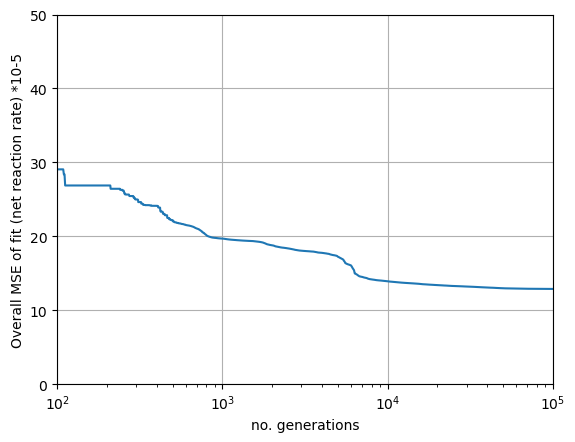

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.687228449920111
1.569481203885629
1.0785785458309372
-4.119558085473375
0.4805955881554998
0.12291568429751536
0.38751809029954454
-3.6768681797825233
0.21099828134421045
3.317221879206866
2.435271184674161
2.5484335428610208
0.3938787204166237
0.029981341002866074
2.8376172130433455
7.085621709907184e-06
0.4885221816377301
-11.24599759487409
1.7626252203272812
1.4984924067059706
-9.868316503225085
0.9669911552134332
3.0530740795868425
0.009566646094882704
3.5405790355651994
2.4851482519495156
1.023110416688213
6.027384198870917
-8.870353803653197
2.4142579298670825
1.5243327237629618
3.0944709696419945
-4.273157124695277
0.5379022582194967
0.9764461428775241
-1.301029993775976


In [37]:
res.X

array([-1.16872284e+01,  1.56948120e+00,  1.07857855e+00, -4.11955809e+00,
        4.80595588e-01,  1.22915684e-01,  3.87518090e-01, -3.67686818e+00,
        2.10998281e-01,  3.31722188e+00,  2.43527118e+00,  2.54843354e+00,
        3.93878720e-01,  2.99813410e-02,  2.83761721e+00,  7.08562171e-06,
        4.88522182e-01, -1.12459976e+01,  1.76262522e+00,  1.49849241e+00,
       -9.86831650e+00,  9.66991155e-01,  3.05307408e+00,  9.56664609e-03,
        3.54057904e+00,  2.48514825e+00,  1.02311042e+00,  6.02738420e+00,
       -8.87035380e+00,  2.41425793e+00,  1.52433272e+00,  3.09447097e+00,
       -4.27315712e+00,  5.37902258e-01,  9.76446143e-01, -1.30102999e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.687228449920111
1.6: 1.569481203885629
0.9: 1.0785785458309372
-4.3: -4.119558085473375
0.5: 0.4805955881554998
0.003: 0.12291568429751536
0.4: 0.38751809029954454
-7.9: -3.6768681797825233
0.7: 0.21099828134421045
7.2: 3.317221879206866
5.7: 2.435271184674161
5.7: 2.5484335428610208
0.8: 0.3938787204166237
0.03: 0.029981341002866074
3.1: 2.8376172130433455
6.000000000000001e-09: 7.085621709907184e-06
0.1: 0.4885221816377301
-12.0: -11.24599759487409
1.9: 1.7626252203272812
1.6: 1.4984924067059706
-11.6: -9.868316503225085
1.2: 0.9669911552134332
4.0: 3.0530740795868425
0.01: 0.009566646094882704
4.2: 3.5405790355651994
5.4: 2.4851482519495156
2.2: 1.023110416688213
11.8: 6.027384198870917
-12.0: -8.870353803653197
3.3: 2.4142579298670825
1.8: 1.5243327237629618
4.2: 3.0944709696419945
-4.0: -4.273157124695277
0.5: 0.5379022582194967
1.0: 0.9764461428775241
coeff fit: 0.8900923625296264
r: 0.9434470639784865


In [42]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.16872284e+01,  1.56948120e+00,  1.07857855e+00, -4.11955809e+00,
        4.80595588e-01,  1.22915684e-01,  3.87518090e-01, -3.67686818e+00,
        2.10998281e-01,  3.31722188e+00,  2.43527118e+00,  2.54843354e+00,
        3.93878720e-01,  2.99813410e-02,  2.83761721e+00,  7.08562171e-06,
        4.88522182e-01, -1.12459976e+01,  1.76262522e+00,  1.49849241e+00,
       -9.86831650e+00,  9.66991155e-01,  3.05307408e+00,  9.56664609e-03,
        3.54057904e+00,  2.48514825e+00,  1.02311042e+00,  6.02738420e+00,
       -8.87035380e+00,  2.41425793e+00,  1.52433272e+00,  3.09447097e+00,
       -4.27315712e+00,  5.37902258e-01,  9.76446143e-01, -1.30102999e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-9.79668052e+00,  1.21535187e+00,  2.41598631e-01, -4.40555769e+00,
        5.24864290e-01,  1.02318934e-07,  4.63126622e-01, -3.42157842e+00,
        1.78316329e-01,  3.83924748e+00,  2.65005775e+00,  2.91455198e+00,
        4.81818936e-01,  5.37730129e-02,  3.21324161e+00,  7.36569002e-08,
        5.79297392e-01, -1.16206811e+01,  1.82952964e+00,  1.55834473e+00,
       -1.01450822e+01,  1.05248717e+00,  3.50127002e+00,  1.20805148e-01,
        3.26455771e+00,  2.75500601e+00,  9.87004992e-01,  6.06367583e+00,
       -1.01875271e+01,  2.80671502e+00,  1.66188538e+00,  3.63350850e+00,
       -4.47571812e+00,  5.81085415e-01,  1.03026834e+00, -1.30102990e+00]
krseed101 = [-1.19999554e+01,  1.62869484e+00,  1.24654245e+00, -4.58616649e+00,
        5.66369200e-01,  3.27335768e-01,  3.83190204e-01, -3.84036485e+00,
        2.30582602e-01,  3.78126317e+00,  2.91147166e+00,  3.04247127e+00,
        2.86420721e-01,  1.77100208e-02,  2.69412475e+00,  5.44643379e-08,
        6.24419458e-01, -1.00624104e+01,  1.55392243e+00,  1.33654315e+00,
       -9.08889834e+00,  8.82598937e-01,  2.82875809e+00,  2.61129878e-02,
        3.15353554e+00,  2.67925149e+00,  9.63369394e-01,  5.90235568e+00,
       -7.98540601e+00,  2.19172796e+00,  1.50740173e+00,  2.81581879e+00,
       -4.14693081e+00,  5.06450526e-01,  9.41357325e-01, -1.30102998e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.8949524971205036
r: 0.9460192900361513
-11.161288106666667
1.47117597
0.8555732103333332
-4.370427423333333
0.523943026
0.15008385143964467
0.4112783053333333
-3.6462704833333333
0.20663240400000002
3.645910843333333
2.665600196666667
2.8351522633333333
0.3873727923333334
0.03382145823333333
2.9149945233333336
2.4045809827e-06
0.5640796773333333
-10.976363033333334
1.7153590966666667
1.4644600966666665
-9.70076568
0.9673590873333334
3.1277007299999995
0.05216159396333333
3.3195574299999997
2.6398019166666664
0.991161602
5.997805236666667
-9.014428969999999
2.4709003033333334
1.5645399433333333
3.181266086666666
-4.298602016666667
0.541812733
0.9826906026666666


In [44]:
meankr

[-11.161288106666667,
 1.47117597,
 0.8555732103333332,
 -4.370427423333333,
 0.523943026,
 0.15008385143964467,
 0.4112783053333333,
 -3.6462704833333333,
 0.20663240400000002,
 3.645910843333333,
 2.665600196666667,
 2.8351522633333333,
 0.3873727923333334,
 0.03382145823333333,
 2.9149945233333336,
 2.4045809827e-06,
 0.5640796773333333,
 -10.976363033333334,
 1.7153590966666667,
 1.4644600966666665,
 -9.70076568,
 0.9673590873333334,
 3.1277007299999995,
 0.05216159396333333,
 3.3195574299999997,
 2.6398019166666664,
 0.991161602,
 5.997805236666667,
 -9.014428969999999,
 2.4709003033333334,
 1.5645399433333333,
 3.181266086666666,
 -4.298602016666667,
 0.541812733,
 0.9826906026666666]

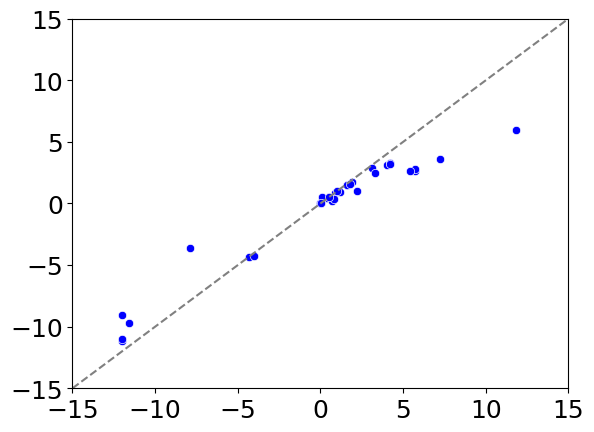

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)',fontsize=18)
#plt.ylabel('Fitted parameter values (log10)',fontsize=18)

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()
